In [1]:
import re
import numpy as np
import pandas as pd
import os
import PIL
import random
import shutil
import matplotlib.pyplot as plt
import PIL
import sys
import cv2
from tqdm import tqdm
from PIL import Image, ImageMath

from skimage.transform import rescale, resize, downscale_local_mean
from img_processing_256 import rename, random_flip_img_train
%matplotlib inline

In [2]:
def remove_margins(image_arr, margin=20):
	"""
	function to trim plxels off all sides of an image
	"""
	h, w = image_arr.shape
	new_image = image_arr[margin:h-margin,margin:w-margin]
	return new_image

In [12]:
def mask_img2(mask_path, full_image_arr, slice_size=512):

	mask = PIL.Image.open(mask_path)
	print(mask.size)
#	if half:
#		print("half")
#		h, w = mask.size
#		new_size = ( h // 2, w // 2)
#		mask.thumbnail(new_size, PIL.Image.ANTIALIAS)
#	print(mask.size)
    
	mask_arr = np.array(mask)
	mask_arr = mask_arr[:,:]
    
#	plt.imshow(mask_arr, cmap='gray')
    
#	if np.sum(np.sum(full_image_arr >= 225)) > 20000:
#		#plt.imshow(full_image_arr, cmap='gray')
#		full_image_arr = remove_margins(full_image_arr)
#		mask_arr = remove_margins(mask_arr)
        
		#plt.imshow(full_image_arr, cmap='gray')
        
#		if output:
#			print("Trimming borders", mask_path)
			
	# The maks size must be same as the full image size
#	if mask_arr.shape != full_image_arr.shape:
		# see if the ratios are the same
#		mask_ratio = mask_arr.shape[0] / mask_arr.shape[1]
#		image_ratio = full_image_arr.shape[0] / full_image_arr.shape[1]
		
#		if abs(mask_ratio - image_ratio) <=  1e-03:
#			if output:
#				print("Mishaped mask, resizing mask", mask_path)
			
			# reshape the mask to match the image
			#mask_arr = imresize(mask_arr, full_image_arr.shape)
#			mask_arr = np.array(Image.fromarray(mask_arr).resize(full_image_arr.shape))
#		else:
#			if output:
#				print("Mask shape:", mask_arr.shape)
#				print("Image shape:", full_image_arr.shape)
#			print("Mask shape doesn't match image!", mask_path)
#			return 0, 0, False, full_image_arr, 0
	
	# find the borders
	mask_mask = mask_arr == 255

	# check whether each row or column have a white pixel
	cols = np.sum(mask_mask, axis=0)
	rows = np.sum(mask_mask, axis=1)

	# check corners
	first_col = np.argmax(cols > 0)
	last_col = mask_arr.shape[1] - np.argmax(np.flip(cols, axis=0) > 0)
	center_col = int((first_col + last_col) / 2)

	first_row = np.argmax(rows > 0)
	last_row = mask_arr.shape[0] - np.argmax(np.flip(rows, axis=0) > 0)
	center_row = int((first_row + last_row) / 2)
	
	col_size = last_col - first_col
	row_size = last_row - first_row
	
	mask_size = [row_size, col_size]
#	print(mask_size)
	# When a mask size is bigger than a slice
	too_big = False
	
	if (last_col - first_col > slice_size + 30) or (last_row - first_row > slice_size + 30):
		too_big = True
#	print("center_row:", center_row)
#	print("center_col:", center_col)
	return center_row, center_col, too_big, mask_size

In [79]:
def create_patches(roi_size, mask_dir, img_dir, Lbls, size=256, debug=True):
    patch_list = []
    Lbl_list = []
    FN_list = []
    
    full_size = 512
    masks = os.listdir(mask_dir)
    counter = 0
    if debug is None:
        progress(counter, len(masks), 'WORKING')
    for mask in tqdm(masks):
        counter += 1
        if debug is None:
            progress(counter, len(masks), mask)
        base_img_file = mask[:-6] + ".png"
        full_img = PIL.Image.open(img_dir+"/"+base_img_file)
#        try:
#            full_img = PIL.Image.open(img_dir + "/" + base_img_file + '.png')
#        except:
#            try:
#                full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000000.png')
#            except:
#                try:
#                    full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000001.png')
#                except:
#                    print("Error FileNotFound:", base_img_file)
#                    continue
        compare = base_img_file[14:]
        #print(compare)
        try:
            Lbl = Lbls.loc[compare]['Class']
        except:
            print("Error LabelNotFound", base_img_file)
            continue
            
        full_img_arr = np.array(full_img)[:,:]
        ctr_row, ctr_col, too_big, mask_size = mask_img2(mask_dir + "/" + mask,full_img_arr)
        img_h, img_w = full_img_arr.shape
        try:
            mask_H = mask_size[0]
            mask_W = mask_size[1]
            roi_size = np.max([mask_H, mask_W])
            if debug:
                print("Mask", mask, " Height:", mask_H, "Width:", mask_W)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
        # Record roi size for DDSM image crop
        roi_sizes.append(roi_size)
        if (ctr_row == 0) and (ctr_col == 0):
            print("Error, skipping", mask)
            continue
        """
        Extract the ROI depending on it's size
        If the ROI is smaller than a slice extract it with some padding
        """
        
#        if roi_size < full_size:

        if(mask_H > mask_W):
            mask_W = mask_H
        else:
            mask_H = mask_W
        
        adj_mask_H = mask_H*1.15
        adj_mask_W = mask_W*1.15
        
        
        start_row = np.max([ctr_row - 512, 0])
        if start_row == 0 :
            end_row = 1024
        else :
            end_row = start_row + 1024
            
        if end_row > img_h:
            end_row = img_h
            start_row = img_h - 1024
            
        start_col = np.max([ctr_col - 512, 0])
        if start_col == 0:
            end_col = 1024
        else :
            end_col = start_col + 1024
        if end_col > img_w:
            end_col = img_w
            start_col = img_w - 1024
       
        end_row = int(end_row)
        end_col = int(end_col)
        start_row = int(start_row)
        start_col = int(start_col)
        print("start_row",start_row)
        print("end_row",end_row)
        print("start_col",start_col)
        print("end_col",end_col)
        
        roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
        
        print("roi_img.shape",roi_img.shape)    
        
        roi_img = roi_img.astype('float32')
        
        roi_img = cv2.resize(roi_img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        roi_img = roi_img.reshape((512, 512, 1))
        #print(roi_img.shape[0])
        #print(roi_img.shape[1])
        
        
        #print(roi_img)
#        patch_1 = crop_img2(roi_img)
#        patch_2 = crop_img2(roi_img)
#        patch_3 = crop_img2(roi_img)
        
        patch_list.append(roi_img)
        Lbl_list.append(Lbl)
        FN_list.append(base_img_file) 
            
#        if (patch_1.shape[0] == size) and (patch_1.shape[1] == size):
#            patch_list.append(patch_1)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
                
#        if (patch_2.shape[0] == size) and (patch_2.shape[1] == size):
#            patch_list.append(patch_2)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
        
#        if (patch_3.shape[0] == size) and (patch_2.shape[1] == size):
#            patch_list.append(patch_3)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
                
    return np.array(patch_list), np.array(Lbl_list), np.array(FN_list), roi_sizes

def create_patches(roi_size, mask_dir, img_dir, Lbls, size=256, debug=True):
    patch_list = []
    Lbl_list = []
    FN_list = []
    
    full_size = 512
    masks = os.listdir(mask_dir)
    counter = 0
    if debug is None:
        progress(counter, len(masks), 'WORKING')
    for mask in tqdm(masks):
        counter += 1
        if debug is None:
            progress(counter, len(masks), mask)
        base_img_file = mask[:-6] + ".png"
        full_img = PIL.Image.open(img_dir+"/"+base_img_file)
        
        #compare = base_img_file[14:]
        compare = base_img_file[10:]
        try:
            Lbl = Lbls.loc[compare]['Class']
        except:
            print("Error LabelNotFound", base_img_file)
            continue
            
        full_img_arr = np.array(full_img)[:,:]
        ctr_row, ctr_col, too_big, mask_size = mask_img2(mask_dir + "/" + mask,full_img_arr)
        img_h, img_w = full_img_arr.shape
        try:
            mask_H = mask_size[0]
            mask_W = mask_size[1]
            roi_size = np.max([mask_H, mask_W])
            if debug:
                print("Mask", mask, " Height:", mask_H, "Width:", mask_W)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
        roi_sizes.append(roi_size)
        if (ctr_row == 0) and (ctr_col == 0):
            print("Error, skipping", mask)
            continue
        """
        Extract the ROI depending on it's size
        If the ROI is smaller than a slice extract it with some padding
        """
        
        adj_mask_H = mask_H*1.15
        adj_mask_W = mask_W*1.15
        
        start_row = np.max([ctr_row - (adj_mask_H // 2), 0])
        end_row = start_row + adj_mask_H
        if end_row > img_h:
            end_row = img_h
            start_row = img_h - adj_mask_H
            
        start_col = np.max([ctr_col - (adj_mask_W // 2), 0])
        end_col = start_col + adj_mask_W
        if end_col > img_w:
            end_col = img_w
            start_col = img_w - adj_mask_W
        end_row = int(end_row)
        end_col = int(end_col)
        start_row = int(start_row)
        start_col = int(start_col)
        roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
        
        patch_list.append(roi_img)
        Lbl_list.append(Lbl)
        FN_list.append(base_img_file)
                
    return np.array(patch_list), np.array(Lbl_list), np.array(FN_list), roi_sizes

In [80]:
#Calc_training
train_labels = pd.read_pickle("label old ver/train_label.pkl")
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/train_png/Calc"
img_dir = "D:/mammography/full/train_png/Calc"

roi_sizes = []

train_calc_patch, train_calc_Lbl, train_calc_FN, train_calc_roi_size = \
    create_patches(roi_sizes, mask_dir, img_dir, Lbls=train_labels, debug=True)

  0%|                                                                                 | 1/1546 [00:00<09:27,  2.72it/s]

(2761, 5056)
Mask Calc-Training_P_00005_RIGHT_CC_1.png  Height: 549 Width: 637
start_row 2431
end_row 3455
start_col 1391
end_col 2415
roi_img.shape (1024, 1024)


  0%|                                                                                 | 2/1546 [00:00<09:57,  2.58it/s]

(2836, 5386)
Mask Calc-Training_P_00005_RIGHT_MLO_1.png  Height: 509 Width: 641
start_row 3036
end_row 4060
start_col 1348
end_col 2372
roi_img.shape (1024, 1024)


  0%|▏                                                                                | 3/1546 [00:01<10:22,  2.48it/s]

(2986, 5356)
Mask Calc-Training_P_00007_LEFT_CC_1.png  Height: 641 Width: 537
start_row 1068
end_row 2092
start_col 1172
end_col 2196
roi_img.shape (1024, 1024)


  0%|▏                                                                                | 4/1546 [00:01<10:59,  2.34it/s]

(3166, 5491)
Mask Calc-Training_P_00007_LEFT_MLO_1.png  Height: 649 Width: 721
start_row 2384
end_row 3408
start_col 1012
end_col 2036
roi_img.shape (1024, 1024)


  0%|▎                                                                                | 5/1546 [00:02<10:42,  2.40it/s]

(3064, 4568)
Mask Calc-Training_P_00008_LEFT_CC_1.png  Height: 121 Width: 137
start_row 1452
end_row 2476
start_col 1124
end_col 2148
roi_img.shape (1024, 1024)


  0%|▎                                                                                | 6/1546 [00:02<10:34,  2.43it/s]

(3064, 4568)
Mask Calc-Training_P_00008_LEFT_CC_2.png  Height: 129 Width: 137
start_row 2240
end_row 3264
start_col 1412
end_col 2436
roi_img.shape (1024, 1024)


  0%|▎                                                                                | 7/1546 [00:02<10:20,  2.48it/s]

(3064, 4568)
Mask Calc-Training_P_00008_LEFT_CC_3.png  Height: 73 Width: 105
start_row 1732
end_row 2756
start_col 1428
end_col 2452
roi_img.shape (1024, 1024)


  1%|▍                                                                                | 8/1546 [00:03<10:12,  2.51it/s]

(3056, 4528)
Mask Calc-Training_P_00008_LEFT_MLO_1.png  Height: 89 Width: 97
start_row 1708
end_row 2732
start_col 1696
end_col 2720
roi_img.shape (1024, 1024)


  1%|▍                                                                                | 9/1546 [00:03<10:10,  2.52it/s]

(3056, 4528)
Mask Calc-Training_P_00008_LEFT_MLO_2.png  Height: 105 Width: 89
start_row 2260
end_row 3284
start_col 1668
end_col 2692
roi_img.shape (1024, 1024)


  1%|▌                                                                               | 10/1546 [00:04<10:03,  2.55it/s]

(3056, 4528)
Mask Calc-Training_P_00008_LEFT_MLO_3.png  Height: 81 Width: 105
start_row 2784
end_row 3808
start_col 1580
end_col 2604
roi_img.shape (1024, 1024)


  1%|▌                                                                               | 11/1546 [00:04<09:55,  2.58it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_1.png  Height: 233 Width: 209
start_row 1388
end_row 2412
start_col 488
end_col 1512
roi_img.shape (1024, 1024)


  1%|▌                                                                               | 12/1546 [00:04<09:53,  2.58it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_2.png  Height: 105 Width: 129
start_row 1884
end_row 2908
start_col 608
end_col 1632
roi_img.shape (1024, 1024)


  1%|▋                                                                               | 13/1546 [00:05<09:48,  2.61it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_3.png  Height: 113 Width: 97
start_row 1200
end_row 2224
start_col 1744
end_col 2768
roi_img.shape (1024, 1024)


  1%|▋                                                                               | 14/1546 [00:05<09:48,  2.60it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_4.png  Height: 73 Width: 89
start_row 1140
end_row 2164
start_col 2008
end_col 3032
roi_img.shape (1024, 1024)


  1%|▊                                                                               | 15/1546 [00:05<09:44,  2.62it/s]

(3032, 4536)
Mask Calc-Training_P_00008_RIGHT_CC_5.png  Height: 89 Width: 121
start_row 716
end_row 1740
start_col 1980
end_col 3004
roi_img.shape (1024, 1024)


  1%|▊                                                                               | 16/1546 [00:06<09:49,  2.60it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_1.png  Height: 241 Width: 113
start_row 2992
end_row 4016
start_col 392
end_col 1416
roi_img.shape (1024, 1024)


  1%|▉                                                                               | 17/1546 [00:06<09:49,  2.59it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_2.png  Height: 65 Width: 57
start_row 3024
end_row 4048
start_col 212
end_col 1236
roi_img.shape (1024, 1024)


  1%|▉                                                                               | 18/1546 [00:07<09:49,  2.59it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_3.png  Height: 73 Width: 81
start_row 1740
end_row 2764
start_col 976
end_col 2000
roi_img.shape (1024, 1024)


  1%|▉                                                                               | 19/1546 [00:07<09:49,  2.59it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_4.png  Height: 97 Width: 97
start_row 1408
end_row 2432
start_col 1272
end_col 2296
roi_img.shape (1024, 1024)


  1%|█                                                                               | 20/1546 [00:07<09:53,  2.57it/s]

(3048, 4576)
Mask Calc-Training_P_00008_RIGHT_MLO_5.png  Height: 233 Width: 129
start_row 2612
end_row 3636
start_col 232
end_col 1256
roi_img.shape (1024, 1024)


  1%|█                                                                               | 21/1546 [00:08<09:55,  2.56it/s]

(3136, 4608)
Mask Calc-Training_P_00010_LEFT_CC_1.png  Height: 89 Width: 89
start_row 1324
end_row 2348
start_col 1572
end_col 2596
roi_img.shape (1024, 1024)


  1%|█▏                                                                              | 22/1546 [00:08<10:00,  2.54it/s]

(3120, 4592)
Mask Calc-Training_P_00010_LEFT_MLO_1.png  Height: 89 Width: 98
start_row 2636
end_row 3660
start_col 1280
end_col 2304
roi_img.shape (1024, 1024)


  1%|█▏                                                                              | 23/1546 [00:09<09:54,  2.56it/s]

(2671, 5356)
Mask Calc-Training_P_00011_LEFT_CC_1.png  Height: 257 Width: 417
start_row 925
end_row 1949
start_col 1647
end_col 2671
roi_img.shape (1024, 1024)


  2%|█▏                                                                              | 24/1546 [00:09<10:14,  2.48it/s]

(2941, 5491)
Mask Calc-Training_P_00011_LEFT_MLO_1.png  Height: 193 Width: 297
start_row 2516
end_row 3540
start_col 1917
end_col 2941
roi_img.shape (1024, 1024)


  2%|█▎                                                                              | 25/1546 [00:10<11:27,  2.21it/s]

(3552, 5944)
Mask Calc-Training_P_00012_LEFT_CC_1.png  Height: 825 Width: 937
start_row 1148
end_row 2172
start_col 540
end_col 1564
roi_img.shape (1024, 1024)


  2%|█▎                                                                              | 26/1546 [00:10<12:33,  2.02it/s]

(3704, 5904)
Mask Calc-Training_P_00012_LEFT_MLO_1.png  Height: 737 Width: 1001
start_row 1712
end_row 2736
start_col 900
end_col 1924
roi_img.shape (1024, 1024)


  2%|█▍                                                                              | 27/1546 [00:11<13:00,  1.95it/s]

(3166, 6211)
Mask Calc-Training_P_00013_RIGHT_MLO_1.png  Height: 513 Width: 617
start_row 3356
end_row 4380
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  2%|█▍                                                                              | 28/1546 [00:11<11:54,  2.12it/s]

(3032, 4728)
Mask Calc-Training_P_00014_LEFT_CC_1.png  Height: 289 Width: 297
start_row 1152
end_row 2176
start_col 156
end_col 1180
roi_img.shape (1024, 1024)


  2%|█▌                                                                              | 29/1546 [00:12<11:15,  2.24it/s]

(3096, 4680)
Mask Calc-Training_P_00014_LEFT_MLO_1.png  Height: 249 Width: 209
start_row 1172
end_row 2196
start_col 624
end_col 1648
roi_img.shape (1024, 1024)


  2%|█▌                                                                              | 30/1546 [00:12<09:23,  2.69it/s]

(1846, 4006)
Mask Calc-Training_P_00016_LEFT_CC_2.png  Height: 401 Width: 513
start_row 2150
end_row 3174
start_col 822
end_col 1846
roi_img.shape (1024, 1024)


  2%|█▌                                                                              | 31/1546 [00:12<08:46,  2.88it/s]

(2011, 5491)
Mask Calc-Training_P_00016_LEFT_MLO_2.png  Height: 425 Width: 409
start_row 3328
end_row 4352
start_col 987
end_col 2011
roi_img.shape (1024, 1024)


  2%|█▋                                                                              | 32/1546 [00:13<10:06,  2.50it/s]

(3391, 5941)
Mask Calc-Training_P_00019_RIGHT_CC_1.png  Height: 633 Width: 457
start_row 832
end_row 1856
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3706, 6871)
Mask Calc-Training_P_00019_RIGHT_MLO_1.png  Height: 817 Width: 681
start_row 1692
end_row 2716
start_col 752
end_col 1776
roi_img.shape (1024, 1024)


  2%|█▊                                                                              | 34/1546 [00:14<10:51,  2.32it/s]

(2416, 4720)
Mask Calc-Training_P_00020_LEFT_CC_1.png  Height: 289 Width: 377
start_row 1032
end_row 2056
start_col 92
end_col 1116
roi_img.shape (1024, 1024)


  2%|█▊                                                                              | 35/1546 [00:14<09:59,  2.52it/s]

(2568, 4688)
Mask Calc-Training_P_00020_LEFT_MLO_1.png  Height: 337 Width: 313
start_row 2024
end_row 3048
start_col 164
end_col 1188
roi_img.shape (1024, 1024)


  2%|█▊                                                                              | 36/1546 [00:14<09:46,  2.58it/s]

(2856, 4888)
Mask Calc-Training_P_00022_LEFT_CC_1.png  Height: 369 Width: 385
start_row 1912
end_row 2936
start_col 528
end_col 1552
roi_img.shape (1024, 1024)


  2%|█▉                                                                              | 37/1546 [00:15<09:51,  2.55it/s]

(3040, 4864)
Mask Calc-Training_P_00022_LEFT_MLO_1.png  Height: 329 Width: 377
start_row 2372
end_row 3396
start_col 1004
end_col 2028
roi_img.shape (1024, 1024)


  2%|█▉                                                                              | 38/1546 [00:15<10:22,  2.42it/s]

(3241, 5386)
Mask Calc-Training_P_00024_LEFT_CC_1.png  Height: 129 Width: 185
start_row 2299
end_row 3323
start_col 1555
end_col 2579
roi_img.shape (1024, 1024)


  3%|██                                                                              | 39/1546 [00:16<11:03,  2.27it/s]

(3361, 5491)
Mask Calc-Training_P_00024_LEFT_MLO_1.png  Height: 177 Width: 137
start_row 1604
end_row 2628
start_col 1019
end_col 2043
roi_img.shape (1024, 1024)


  3%|██                                                                              | 40/1546 [00:16<10:17,  2.44it/s]

(2296, 5431)
Mask Calc-Training_P_00028_LEFT_MLO_1.png  Height: 121 Width: 97
start_row 1928
end_row 2952
start_col 1272
end_col 2296
roi_img.shape (1024, 1024)


  3%|██                                                                              | 41/1546 [00:16<11:26,  2.19it/s]

(3106, 6871)
Mask Calc-Training_P_00029_LEFT_CC_1.png  Height: 265 Width: 185
start_row 2432
end_row 3456
start_col 1447
end_col 2471
roi_img.shape (1024, 1024)


  3%|██▏                                                                             | 42/1546 [00:17<12:19,  2.03it/s]

(3106, 6721)
Mask Calc-Training_P_00029_LEFT_MLO_1.png  Height: 217 Width: 169
start_row 3816
end_row 4840
start_col 1303
end_col 2327
roi_img.shape (1024, 1024)


  3%|██▏                                                                             | 43/1546 [00:17<11:20,  2.21it/s]

(3064, 4560)
Mask Calc-Training_P_00030_LEFT_CC_1.png  Height: 97 Width: 97
start_row 1080
end_row 2104
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  3%|██▎                                                                             | 44/1546 [00:18<10:39,  2.35it/s]

(3064, 4560)
Mask Calc-Training_P_00030_LEFT_CC_2.png  Height: 657 Width: 377
start_row 2176
end_row 3200
start_col 636
end_col 1660
roi_img.shape (1024, 1024)


  3%|██▎                                                                             | 45/1546 [00:18<10:16,  2.44it/s]

(3048, 4600)
Mask Calc-Training_P_00030_LEFT_MLO_1.png  Height: 113 Width: 97
start_row 2000
end_row 3024
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  3%|██▍                                                                             | 46/1546 [00:19<09:57,  2.51it/s]

(3048, 4600)
Mask Calc-Training_P_00030_LEFT_MLO_2.png  Height: 689 Width: 417
start_row 1512
end_row 2536
start_col 640
end_col 1664
roi_img.shape (1024, 1024)


  3%|██▍                                                                             | 47/1546 [00:19<09:47,  2.55it/s]

(3072, 4608)
Mask Calc-Training_P_00030_RIGHT_CC_1.png  Height: 457 Width: 1033
start_row 1892
end_row 2916
start_col 2028
end_col 3052
roi_img.shape (1024, 1024)


  3%|██▍                                                                             | 48/1546 [00:19<09:39,  2.58it/s]

(3016, 4632)
Mask Calc-Training_P_00030_RIGHT_MLO_1.png  Height: 833 Width: 1265
start_row 1824
end_row 2848
start_col 1752
end_col 2776
roi_img.shape (1024, 1024)


  3%|██▌                                                                             | 49/1546 [00:20<10:00,  2.49it/s]

(3076, 5251)
Mask Calc-Training_P_00031_LEFT_CC_1.png  Height: 153 Width: 145
start_row 1862
end_row 2886
start_col 213
end_col 1237
roi_img.shape (1024, 1024)


  3%|██▌                                                                             | 50/1546 [00:20<11:26,  2.18it/s]

(3406, 6451)
Mask Calc-Training_P_00034_RIGHT_CC_2.png  Height: 433 Width: 249
start_row 1052
end_row 2076
start_col 536
end_col 1560
roi_img.shape (1024, 1024)
(3541, 6871)
Mask

  3%|██▋                                                                             | 51/1546 [00:21<12:54,  1.93it/s]

 Calc-Training_P_00034_RIGHT_MLO_2.png  Height: 505 Width: 449
start_row 1824
end_row 2848
start_col 1524
end_col 2548
roi_img.shape (1024, 1024)


  3%|██▋                                                                             | 52/1546 [00:21<12:06,  2.06it/s]

(2731, 5296)
Mask Calc-Training_P_00043_LEFT_MLO_1.png  Height: 889 Width: 849
start_row 2360
end_row 3384
start_col 1609
end_col 2633
roi_img.shape (1024, 1024)


  3%|██▋                                                                             | 53/1546 [00:22<11:19,  2.20it/s]

(3128, 4736)
Mask Calc-Training_P_00047_LEFT_CC_1.png  Height: 89 Width: 73
start_row 1260
end_row 2284
start_col 180
end_col 1204
roi_img.shape (1024, 1024)


  3%|██▊                                                                             | 54/1546 [00:22<10:46,  2.31it/s]

(3128, 4736)
Mask Calc-Training_P_00047_LEFT_CC_2.png  Height: 113 Width: 81
start_row 1344
end_row 2368
start_col 216
end_col 1240
roi_img.shape (1024, 1024)


  4%|██▊                                                                             | 55/1546 [00:23<10:23,  2.39it/s]

(3128, 4736)
Mask Calc-Training_P_00047_LEFT_CC_3.png  Height: 105 Width: 105
start_row 1260
end_row 2284
start_col 76
end_col 1100
roi_img.shape (1024, 1024)


  4%|██▉                                                                             | 56/1546 [00:23<10:05,  2.46it/s]

(3096, 4752)
Mask Calc-Training_P_00047_LEFT_MLO_1.png  Height: 105 Width: 113
start_row 1852
end_row 2876
start_col 456
end_col 1480
roi_img.shape (1024, 1024)


  4%|██▉                                                                             | 57/1546 [00:23<09:56,  2.50it/s]

(3096, 4752)
Mask Calc-Training_P_00047_LEFT_MLO_2.png  Height: 105 Width: 97
start_row 1948
end_row 2972
start_col 464
end_col 1488
roi_img.shape (1024, 1024)


  4%|███                                                                             | 58/1546 [00:24<09:50,  2.52it/s]

(3096, 4752)
Mask Calc-Training_P_00047_LEFT_MLO_3.png  Height: 105 Width: 105
start_row 1860
end_row 2884
start_col 284
end_col 1308
roi_img.shape (1024, 1024)


  4%|███                                                                             | 59/1546 [00:24<11:19,  2.19it/s]

(3920, 5816)
Mask Calc-Training_P_00048_RIGHT_CC_1.png  Height: 145 Width: 169
start_row 2040
end_row 3064
start_col 2188
end_col 3212
roi_img.shape (1024, 1024)


  4%|███                                                                             | 60/1546 [00:25<12:28,  1.99it/s]

(3920, 5816)
Mask Calc-Training_P_00048_RIGHT_CC_2.png  Height: 193 Width: 153
start_row 2040
end_row 3064
start_col 2004
end_col 3028
roi_img.shape (1024, 1024)
(4048, 5864)
Mask Calc-Training_P_00048_RIGHT_MLO_1.png  Height: 161 Width: 145
start_row 2760
end_row 3784
start_col 1960
end_col 2984
roi_img.shape (1024, 1024)


  4%|███▏                                                                            | 62/1546 [00:26<14:09,  1.75it/s]

(4048, 5864)
Mask Calc-Training_P_00048_RIGHT_MLO_2.png  Height: 193 Width: 209
start_row 2528
end_row 3552
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


  4%|███▎                                                                            | 63/1546 [00:26<11:28,  2.15it/s]

(1561, 5011)
Mask Calc-Training_P_00049_RIGHT_CC_1.png  Height: 313 Width: 297
start_row 1461
end_row 2485
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  4%|███▎                                                                            | 64/1546 [00:27<10:10,  2.43it/s]

(2191, 4996)
Mask Calc-Training_P_00049_RIGHT_MLO_1.png  Height: 209 Width: 289
start_row 2340
end_row 3364
start_col 332
end_col 1356
roi_img.shape (1024, 1024)


  4%|███▎                                                                            | 65/1546 [00:27<09:42,  2.54it/s]

(2864, 4560)
Mask Calc-Training_P_00060_RIGHT_CC_1.png  Height: 297 Width: 297
start_row 1108
end_row 2132
start_col 1796
end_col 2820
roi_img.shape (1024, 1024)


  4%|███▍                                                                            | 66/1546 [00:27<09:28,  2.60it/s]

(2880, 4592)
Mask Calc-Training_P_00060_RIGHT_MLO_1.png  Height: 281 Width: 273
start_row 1652
end_row 2676
start_col 728
end_col 1752
roi_img.shape (1024, 1024)


  4%|███▍                                                                            | 67/1546 [00:28<08:52,  2.78it/s]

(2440, 4816)
Mask Calc-Training_P_00062_LEFT_CC_1.png  Height: 337 Width: 217
start_row 1104
end_row 2128
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  4%|███▌                                                                            | 68/1546 [00:28<08:27,  2.91it/s]

(2440, 4784)
Mask Calc-Training_P_00062_LEFT_MLO_1.png  Height: 377 Width: 225
start_row 644
end_row 1668
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  4%|███▌                                                                            | 69/1546 [00:28<08:40,  2.84it/s]

(3064, 4664)
Mask Calc-Training_P_00063_RIGHT_CC_1.png  Height: 249 Width: 313
start_row 604
end_row 1628
start_col 2040
end_col 3064
roi_img.shape (1024, 1024)


  5%|███▌                                                                            | 70/1546 [00:29<08:51,  2.78it/s]

(3088, 4688)
Mask Calc-Training_P_00063_RIGHT_MLO_1.png  Height: 241 Width: 281
start_row 1704
end_row 2728
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


  5%|███▋                                                                            | 71/1546 [00:29<10:47,  2.28it/s]

(3952, 5696)
Mask Calc-Training_P_00071_RIGHT_CC_1.png  Height: 321 Width: 337
start_row 2384
end_row 3408
start_col 2584
end_col 3608
roi_img.shape (1024, 1024)


  5%|███▋                                                                            | 72/1546 [00:30<12:20,  1.99it/s]

(3952, 5720)
Mask Calc-Training_P_00071_RIGHT_MLO_1.png  Height: 377 Width: 321
start_row 2540
end_row 3564
start_col 2088
end_col 3112
roi_img.shape (1024, 1024)
(3766, 6331)
Mask Calc-Training_P_00078_LEFT_CC_1.png  Height: 225 Width: 345
start_row 3325
end_row 4349
start_col 1931
end_col 2955
roi_img.shape (1024, 1024)


  5%|███▊                                                                            | 73/1546 [00:31<13:19,  1.84it/s]

(4111, 6166)
Mask Calc-Training_P_00078_LEFT_MLO_1.png  Height: 361 Width: 265
start_row 3104
end_row 4128
start_col 1300
end_col 2324
roi_img.shape (1024, 1024)


  5%|███▉                                                                            | 75/1546 [00:32<13:23,  1.83it/s]

(3016, 5491)
Mask Calc-Training_P_00083_RIGHT_CC_1.png  Height: 217 Width: 201
start_row 1200
end_row 2224
start_col 320
end_col 1344
roi_img.shape (1024, 1024)


  5%|███▉                                                                            | 76/1546 [00:32<12:21,  1.98it/s]

(2776, 5461)
Mask Calc-Training_P_00084_LEFT_CC_1.png  Height: 667 Width: 585
start_row 2684
end_row 3708
start_col 1056
end_col 2080
roi_img.shape (1024, 1024)


  5%|███▉                                                                            | 77/1546 [00:33<12:03,  2.03it/s]

(3046, 5491)
Mask Calc-Training_P_00084_LEFT_MLO_1.png  Height: 392 Width: 653
start_row 3372
end_row 4396
start_col 1225
end_col 2249
roi_img.shape (1024, 1024)


  5%|████                                                                            | 78/1546 [00:33<10:58,  2.23it/s]

(2896, 4528)
Mask Calc-Training_P_00085_RIGHT_CC_1.png  Height: 625 Width: 809
start_row 2152
end_row 3176
start_col 1708
end_col 2732
roi_img.shape (1024, 1024)


  5%|████                                                                            | 79/1546 [00:33<10:17,  2.38it/s]

(2928, 4560)
Mask Calc-Training_P_00085_RIGHT_MLO_1.png  Height: 721 Width: 729
start_row 2272
end_row 3296
start_col 1676
end_col 2700
roi_img.shape (1024, 1024)


  5%|████▏                                                                           | 80/1546 [00:34<09:25,  2.59it/s]

(2536, 4426)
Mask Calc-Training_P_00088_LEFT_CC_1.png  Height: 126 Width: 146
start_row 1973
end_row 2997
start_col 498
end_col 1522
roi_img.shape (1024, 1024)


  5%|████▏                                                                           | 81/1546 [00:34<09:31,  2.57it/s]

(2746, 5326)
Mask Calc-Training_P_00088_LEFT_MLO_1.png  Height: 151 Width: 156
start_row 2965
end_row 3989
start_col 808
end_col 1832
roi_img.shape (1024, 1024)


  5%|████▏                                                                           | 82/1546 [00:35<10:44,  2.27it/s]

(3632, 5984)
Mask Calc-Training_P_00091_LEFT_CC_1.png  Height: 577 Width: 457
start_row 1288
end_row 2312
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  5%|████▎                                                                           | 83/1546 [00:35<11:34,  2.11it/s]

(3520, 5960)
Mask Calc-Training_P_00091_LEFT_MLO_1.png  Height: 473 Width: 409
start_row 2180
end_row 3204
start_col 132
end_col 1156
roi_img.shape (1024, 1024)


  5%|████▎                                                                           | 84/1546 [00:36<10:54,  2.23it/s]

(3080, 4616)
Mask Calc-Training_P_00098_LEFT_CC_1.png  Height: 361 Width: 825
start_row 1700
end_row 2724
start_col 164
end_col 1188
roi_img.shape (1024, 1024)


  5%|████▍                                                                           | 85/1546 [00:36<10:21,  2.35it/s]

(3064, 4584)
Mask Calc-Training_P_00098_LEFT_MLO_1.png  Height: 705 Width: 657
start_row 1488
end_row 2512
start_col 800
end_col 1824
roi_img.shape (1024, 1024)


  6%|████▍                                                                           | 86/1546 [00:36<10:02,  2.42it/s]

(3064, 4584)
Mask Calc-Training_P_00098_LEFT_MLO_2.png  Height: 369 Width: 345
start_row 2720
end_row 3744
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  6%|████▌                                                                           | 87/1546 [00:37<09:45,  2.49it/s]

(2984, 4632)
Mask Calc-Training_P_00098_RIGHT_CC_1.png  Height: 489 Width: 481
start_row 2020
end_row 3044
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


  6%|████▌                                                                           | 88/1546 [00:37<09:44,  2.50it/s]

(3096, 4672)
Mask Calc-Training_P_00098_RIGHT_MLO_1.png  Height: 241 Width: 281
start_row 784
end_row 1808
start_col 2072
end_col 3096
roi_img.shape (1024, 1024)


  6%|████▌                                                                           | 89/1546 [00:37<09:44,  2.49it/s]

(3096, 4672)
Mask Calc-Training_P_00098_RIGHT_MLO_2.png  Height: 665 Width: 761
start_row 1116
end_row 2140
start_col 1100
end_col 2124
roi_img.shape (1024, 1024)


  6%|████▋                                                                           | 90/1546 [00:38<09:21,  2.59it/s]

(2744, 4752)
Mask Calc-Training_P_00101_RIGHT_CC_2.png  Height: 913 Width: 761
start_row 1192
end_row 2216
start_col 1508
end_col 2532
roi_img.shape (1024, 1024)


  6%|████▋                                                                           | 91/1546 [00:38<09:12,  2.63it/s]

(2776, 4768)
Mask Calc-Training_P_00101_RIGHT_MLO_2.png  Height: 921 Width: 649
start_row 1156
end_row 2180
start_col 764
end_col 1788
roi_img.shape (1024, 1024)


  6%|████▊                                                                           | 92/1546 [00:39<09:56,  2.44it/s]

(3256, 5491)
Mask Calc-Training_P_00105_LEFT_CC_1.png  Height: 289 Width: 537
start_row 1740
end_row 2764
start_col 1618
end_col 2642
roi_img.shape (1024, 1024)


  6%|████▊                                                                           | 93/1546 [00:39<10:39,  2.27it/s]

(3361, 5491)
Mask Calc-Training_P_00105_LEFT_MLO_1.png  Height: 521 Width: 473
start_row 2392
end_row 3416
start_col 1891
end_col 2915
roi_img.shape (1024, 1024)


  6%|████▊                                                                           | 94/1546 [00:40<12:06,  2.00it/s]

(3928, 5752)
Mask Calc-Training_P_00106_RIGHT_CC_1.png  Height: 80 Width: 105
start_row 2184
end_row 3208
start_col 1292
end_col 2316
roi_img.shape (1024, 1024)


  6%|████▉                                                                           | 95/1546 [00:40<12:53,  1.88it/s]

(3992, 5768)
Mask Calc-Training_P_00106_RIGHT_MLO_4.png  Height: 113 Width: 129
start_row 2416
end_row 3440
start_col 824
end_col 1848
roi_img.shape (1024, 1024)


  6%|████▉                                                                           | 96/1546 [00:41<11:40,  2.07it/s]

(2992, 4696)
Mask Calc-Training_P_00112_LEFT_CC_1.png  Height: 177 Width: 201
start_row 2736
end_row 3760
start_col 12
end_col 1036
roi_img.shape (1024, 1024)


  6%|█████                                                                           | 97/1546 [00:41<10:45,  2.24it/s]

(2992, 4696)
Mask Calc-Training_P_00112_LEFT_CC_2.png  Height: 161 Width: 137
start_row 2448
end_row 3472
start_col 140
end_col 1164
roi_img.shape (1024, 1024)


  6%|█████                                                                           | 98/1546 [00:42<10:12,  2.37it/s]

(2992, 4696)
Mask Calc-Training_P_00112_LEFT_CC_3.png  Height: 129 Width: 121
start_row 2272
end_row 3296
start_col 28
end_col 1052
roi_img.shape (1024, 1024)


  6%|█████                                                                           | 99/1546 [00:42<09:49,  2.46it/s]

(2992, 4696)
Mask Calc-Training_P_00112_LEFT_CC_4.png  Height: 145 Width: 129
start_row 2000
end_row 3024
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  6%|█████                                                                          | 100/1546 [00:42<09:31,  2.53it/s]

(3008, 4608)
Mask Calc-Training_P_00112_LEFT_MLO_1.png  Height: 193 Width: 169
start_row 760
end_row 1784
start_col 548
end_col 1572
roi_img.shape (1024, 1024)


  7%|█████▏                                                                         | 101/1546 [00:43<09:16,  2.60it/s]

(3008, 4608)
Mask Calc-Training_P_00112_LEFT_MLO_2.png  Height: 178 Width: 201
start_row 1536
end_row 2560
start_col 196
end_col 1220
roi_img.shape (1024, 1024)


  7%|█████▏                                                                         | 102/1546 [00:43<09:07,  2.64it/s]

(3008, 4608)
Mask Calc-Training_P_00112_LEFT_MLO_3.png  Height: 129 Width: 137
start_row 1216
end_row 2240
start_col 740
end_col 1764
roi_img.shape (1024, 1024)


  7%|█████▎                                                                         | 103/1546 [00:43<09:01,  2.67it/s]

(3008, 4608)
Mask Calc-Training_P_00112_LEFT_MLO_4.png  Height: 129 Width: 153
start_row 1968
end_row 2992
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  7%|█████▎                                                                         | 104/1546 [00:44<08:56,  2.69it/s]

(3008, 4608)
Mask Calc-Training_P_00112_LEFT_MLO_5.png  Height: 137 Width: 129
start_row 2020
end_row 3044
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  7%|█████▎                                                                         | 105/1546 [00:44<08:52,  2.71it/s]

(3008, 4608)
Mask Calc-Training_P_00112_LEFT_MLO_6.png  Height: 161 Width: 177
start_row 2296
end_row 3320
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  7%|█████▍                                                                         | 106/1546 [00:44<08:50,  2.71it/s]

(3072, 4608)
Mask Calc-Training_P_00112_RIGHT_CC_1.png  Height: 121 Width: 129
start_row 820
end_row 1844
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


  7%|█████▍                                                                         | 107/1546 [00:45<08:52,  2.70it/s]

(3072, 4608)
Mask Calc-Training_P_00112_RIGHT_CC_2.png  Height: 129 Width: 153
start_row 1288
end_row 2312
start_col 1852
end_col 2876
roi_img.shape (1024, 1024)


  7%|█████▌                                                                         | 108/1546 [00:45<08:53,  2.70it/s]

(3072, 4608)
Mask Calc-Training_P_00112_RIGHT_CC_3.png  Height: 89 Width: 153
start_row 1300
end_row 2324
start_col 1988
end_col 3012
roi_img.shape (1024, 1024)


  7%|█████▌                                                                         | 109/1546 [00:46<08:51,  2.71it/s]

(3072, 4608)
Mask Calc-Training_P_00112_RIGHT_CC_4.png  Height: 121 Width: 153
start_row 1812
end_row 2836
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


  7%|█████▌                                                                         | 110/1546 [00:46<08:51,  2.70it/s]

(3072, 4608)
Mask Calc-Training_P_00112_RIGHT_CC_5.png  Height: 129 Width: 113
start_row 2304
end_row 3328
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


  7%|█████▋                                                                         | 111/1546 [00:46<08:48,  2.72it/s]

(3072, 4608)
Mask Calc-Training_P_00112_RIGHT_CC_6.png  Height: 201 Width: 145
start_row 2468
end_row 3492
start_col 1760
end_col 2784
roi_img.shape (1024, 1024)


  7%|█████▋                                                                         | 112/1546 [00:47<08:51,  2.70it/s]

(3040, 4640)
Mask Calc-Training_P_00112_RIGHT_MLO_1.png  Height: 145 Width: 161
start_row 2016
end_row 3040
start_col 1632
end_col 2656
roi_img.shape (1024, 1024)


  7%|█████▊                                                                         | 113/1546 [00:47<08:53,  2.68it/s]

(3040, 4640)
Mask Calc-Training_P_00112_RIGHT_MLO_2.png  Height: 153 Width: 113
start_row 1716
end_row 2740
start_col 1528
end_col 2552
roi_img.shape (1024, 1024)


  7%|█████▊                                                                         | 114/1546 [00:47<08:53,  2.69it/s]

(3040, 4640)
Mask Calc-Training_P_00112_RIGHT_MLO_3.png  Height: 113 Width: 121
start_row 2168
end_row 3192
start_col 1204
end_col 2228
roi_img.shape (1024, 1024)


  7%|█████▉                                                                         | 115/1546 [00:48<08:54,  2.68it/s]

(3040, 4640)
Mask Calc-Training_P_00112_RIGHT_MLO_4.png  Height: 161 Width: 137
start_row 2456
end_row 3480
start_col 1604
end_col 2628
roi_img.shape (1024, 1024)


  8%|█████▉                                                                         | 116/1546 [00:48<08:55,  2.67it/s]

(3040, 4640)
Mask Calc-Training_P_00112_RIGHT_MLO_5.png  Height: 129 Width: 145
start_row 2760
end_row 3784
start_col 1744
end_col 2768
roi_img.shape (1024, 1024)


  8%|█████▉                                                                         | 117/1546 [00:49<08:56,  2.67it/s]

(3040, 4640)
Mask Calc-Training_P_00112_RIGHT_MLO_6.png  Height: 185 Width: 177
start_row 3316
end_row 4340
start_col 1960
end_col 2984
roi_img.shape (1024, 1024)


  8%|██████                                                                         | 118/1546 [00:49<08:54,  2.67it/s]

(3040, 4640)
Mask Calc-Training_P_00112_RIGHT_MLO_7.png  Height: 113 Width: 113
start_row 1896
end_row 2920
start_col 2016
end_col 3040
roi_img.shape (1024, 1024)


  8%|██████                                                                         | 119/1546 [00:49<08:57,  2.66it/s]

(3120, 4768)
Mask Calc-Training_P_00121_LEFT_CC_1.png  Height: 225 Width: 169
start_row 2144
end_row 3168
start_col 444
end_col 1468
roi_img.shape (1024, 1024)


  8%|██████▏                                                                        | 120/1546 [00:50<08:56,  2.66it/s]

(3032, 4792)
Mask Calc-Training_P_00121_LEFT_MLO_1.png  Height: 201 Width: 185
start_row 2364
end_row 3388
start_col 540
end_col 1564
roi_img.shape (1024, 1024)


  8%|██████▏                                                                        | 121/1546 [00:50<08:42,  2.73it/s]

(2992, 4504)
Mask Calc-Training_P_00123_LEFT_CC_1.png  Height: 185 Width: 233
start_row 1596
end_row 2620
start_col 188
end_col 1212
roi_img.shape (1024, 1024)


  8%|██████▏                                                                        | 122/1546 [00:50<08:33,  2.78it/s]

(3008, 4464)
Mask Calc-Training_P_00123_LEFT_MLO_1.png  Height: 249 Width: 241
start_row 2036
end_row 3060
start_col 488
end_col 1512
roi_img.shape (1024, 1024)


  8%|██████▎                                                                        | 123/1546 [00:51<09:45,  2.43it/s]

(3456, 5896)
Mask Calc-Training_P_00129_LEFT_CC_1.png  Height: 561 Width: 329
start_row 3312
end_row 4336
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  8%|██████▎                                                                        | 124/1546 [00:51<10:48,  2.19it/s]

(3536, 5936)
Mask Calc-Training_P_00129_LEFT_MLO_1.png  Height: 497 Width: 345
start_row 3000
end_row 4024
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  8%|██████▍                                                                        | 125/1546 [00:52<10:03,  2.36it/s]

(2920, 4592)
Mask Calc-Training_P_00136_LEFT_CC_1.png  Height: 361 Width: 369
start_row 1292
end_row 2316
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  8%|██████▍                                                                        | 126/1546 [00:52<09:25,  2.51it/s]

(2784, 4624)
Mask Calc-Training_P_00136_LEFT_MLO_1.png  Height: 297 Width: 273
start_row 1124
end_row 2148
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  8%|██████▍                                                                        | 127/1546 [00:52<08:59,  2.63it/s]

(2784, 4624)
Mask Calc-Training_P_00136_LEFT_MLO_2.png  Height: 441 Width: 273
start_row 2308
end_row 3332
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  8%|██████▌                                                                        | 128/1546 [00:53<08:58,  2.63it/s]

(2581, 5491)
Mask Calc-Training_P_00151_RIGHT_MLO_1.png  Height: 993 Width: 681
start_row 1924
end_row 2948
start_col 64
end_col 1088
roi_img.shape (1024, 1024)


  8%|██████▌                                                                        | 129/1546 [00:53<08:59,  2.62it/s]

(3112, 4768)
Mask Calc-Training_P_00157_LEFT_CC_1.png  Height: 177 Width: 217
start_row 1424
end_row 2448
start_col 148
end_col 1172
roi_img.shape (1024, 1024)


  8%|██████▋                                                                        | 130/1546 [00:54<08:59,  2.63it/s]

(3112, 4768)
Mask Calc-Training_P_00157_LEFT_CC_2.png  Height: 185 Width: 201
start_row 1940
end_row 2964
start_col 20
end_col 1044
roi_img.shape (1024, 1024)


  8%|██████▋                                                                        | 131/1546 [00:54<08:58,  2.63it/s]

(3088, 4768)
Mask Calc-Training_P_00157_LEFT_MLO_1.png  Height: 161 Width: 121
start_row 1472
end_row 2496
start_col 556
end_col 1580
roi_img.shape (1024, 1024)


  9%|██████▋                                                                        | 132/1546 [00:54<08:58,  2.62it/s]

(3088, 4768)
Mask Calc-Training_P_00157_LEFT_MLO_2.png  Height: 153 Width: 177
start_row 1212
end_row 2236
start_col 744
end_col 1768
roi_img.shape (1024, 1024)


  9%|██████▊                                                                        | 133/1546 [00:55<08:58,  2.62it/s]

(3088, 4768)
Mask Calc-Training_P_00157_LEFT_MLO_3.png  Height: 129 Width: 145
start_row 1352
end_row 2376
start_col 696
end_col 1720
roi_img.shape (1024, 1024)


  9%|██████▊                                                                        | 134/1546 [00:55<10:36,  2.22it/s]

(4104, 5776)
Mask Calc-Training_P_00159_LEFT_CC_1.png  Height: 257 Width: 289
start_row 1048
end_row 2072
start_col 16
end_col 1040
roi_img.shape (1024, 1024)


  9%|██████▉                                                                        | 135/1546 [00:56<11:47,  1.99it/s]

(4120, 5768)
Mask Calc-Training_P_00159_LEFT_MLO_1.png  Height: 305 Width: 297
start_row 1824
end_row 2848
start_col 668
end_col 1692
roi_img.shape (1024, 1024)


  9%|██████▉                                                                        | 136/1546 [00:56<11:15,  2.09it/s]

(3076, 5236)
Mask Calc-Training_P_00161_LEFT_MLO_1.png  Height: 1089 Width: 873
start_row 2356
end_row 3380
start_col 2052
end_col 3076
roi_img.shape (1024, 1024)
(3661, 6871)
Mask

  9%|███████                                                                        | 137/1546 [00:57<12:37,  1.86it/s]

 Calc-Training_P_00162_LEFT_CC_1.png  Height: 136 Width: 320
start_row 3278
end_row 4302
start_col 2573
end_col 3597
roi_img.shape (1024, 1024)
(3856, 6856)


  9%|███████                                                                        | 138/1546 [00:58<14:05,  1.67it/s]

Mask Calc-Training_P_00162_LEFT_MLO_1.png  Height: 262 Width: 184
start_row 4287
end_row 5311
start_col 2715
end_col 3739
roi_img.shape (1024, 1024)


  9%|███████                                                                        | 139/1546 [00:59<14:30,  1.62it/s]

(3976, 5701)
Mask Calc-Training_P_00179_LEFT_CC_1.png  Height: 377 Width: 305
start_row 1604
end_row 2628
start_col 1913
end_col 2937
roi_img.shape (1024, 1024)
(4276, 5986)
Mask Calc-Training_P_00179_LEFT_MLO_1.png  Height: 593 Width: 545
start_row 2220
end_row 3244
start_col 1357
end_col 2381
roi_img.shape (1024, 1024)


  9%|███████▏                                                                       | 141/1546 [00:59<12:04,  1.94it/s]

(1981, 3931)
Mask Calc-Training_P_00181_RIGHT_CC_1.png  Height: 369 Width: 353
start_row 1578
end_row 2602
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  9%|███████▎                                                                       | 142/1546 [01:00<10:54,  2.15it/s]

(2416, 5431)
Mask Calc-Training_P_00181_RIGHT_MLO_1.png  Height: 257 Width: 473
start_row 3244
end_row 4268
start_col 80
end_col 1104
roi_img.shape (1024, 1024)
(4591, 6391)


  9%|███████▎                                                                       | 143/1546 [01:01<13:04,  1.79it/s]

Mask Calc-Training_P_00182_LEFT_CC_1.png  Height: 357 Width: 421
start_row 1104
end_row 2128
start_col 656
end_col 1680
roi_img.shape (1024, 1024)
(4636, 6841)


  9%|███████▎                                                                       | 144/1546 [01:01<15:14,  1.53it/s]

Mask Calc-Training_P_00182_LEFT_MLO_1.png  Height: 489 Width: 473
start_row 3802
end_row 4826
start_col 1022
end_col 2046
roi_img.shape (1024, 1024)


  9%|███████▍                                                                       | 145/1546 [01:02<13:10,  1.77it/s]

(2824, 4512)
Mask Calc-Training_P_00183_RIGHT_MLO_1.png  Height: 329 Width: 281
start_row 1084
end_row 2108
start_col 1800
end_col 2824
roi_img.shape (1024, 1024)


  9%|███████▍                                                                       | 146/1546 [01:02<11:46,  1.98it/s]

(2506, 5491)
Mask Calc-Training_P_00185_LEFT_CC_1.png  Height: 193 Width: 353
start_row 2884
end_row 3908
start_col 1064
end_col 2088
roi_img.shape (1024, 1024)


 10%|███████▌                                                                       | 147/1546 [01:03<11:24,  2.04it/s]

(3001, 5491)
Mask Calc-Training_P_00185_LEFT_MLO_1.png  Height: 161 Width: 313
start_row 3668
end_row 4692
start_col 1051
end_col 2075
roi_img.shape (1024, 1024)


 10%|███████▌                                                                       | 148/1546 [01:03<10:54,  2.14it/s]

(2671, 5491)
Mask Calc-Training_P_00188_RIGHT_MLO_1.png  Height: 321 Width: 361
start_row 995
end_row 2019
start_col 360
end_col 1384
roi_img.shape (1024, 1024)


 10%|███████▌                                                                       | 149/1546 [01:03<10:09,  2.29it/s]

(2596, 5281)
Mask Calc-Training_P_00189_LEFT_CC_1.png  Height: 329 Width: 401
start_row 2598
end_row 3622
start_col 754
end_col 1778
roi_img.shape (1024, 1024)


 10%|███████▋                                                                       | 150/1546 [01:04<10:02,  2.32it/s]

(2806, 5491)
Mask Calc-Training_P_00189_LEFT_MLO_1.png  Height: 313 Width: 441
start_row 3688
end_row 4712
start_col 928
end_col 1952
roi_img.shape (1024, 1024)


 10%|███████▋                                                                       | 151/1546 [01:04<09:23,  2.48it/s]

(2401, 5266)
Mask Calc-Training_P_00196_RIGHT_CC_1.png  Height: 105 Width: 105
start_row 2792
end_row 3816
start_col 528
end_col 1552
roi_img.shape (1024, 1024)


 10%|███████▊                                                                       | 152/1546 [01:04<08:57,  2.59it/s]

(2461, 5371)
Mask Calc-Training_P_00196_RIGHT_MLO_1.png  Height: 105 Width: 105
start_row 2984
end_row 4008
start_col 368
end_col 1392
roi_img.shape (1024, 1024)


 10%|███████▊                                                                       | 153/1546 [01:05<10:37,  2.19it/s]

(4072, 5744)
Mask Calc-Training_P_00197_RIGHT_CC_1.png  Height: 1081 Width: 665
start_row 2284
end_row 3308
start_col 2900
end_col 3924
roi_img.shape (1024, 1024)


 10%|███████▊                                                                       | 154/1546 [01:06<12:13,  1.90it/s]

(3992, 5744)
Mask Calc-Training_P_00197_RIGHT_MLO_1.png  Height: 449 Width: 793
start_row 2056
end_row 3080
start_col 2228
end_col 3252
roi_img.shape (1024, 1024)


 10%|███████▉                                                                       | 155/1546 [01:06<13:12,  1.75it/s]

(3991, 6061)
Mask Calc-Training_P_00201_LEFT_MLO_1.png  Height: 1489 Width: 929
start_row 3164
end_row 4188
start_col 912
end_col 1936
roi_img.shape (1024, 1024)
(4104, 5704)
Mask Calc-Training_P_00208_RIGHT_CC_1.png  Height: 473 Width: 361
start_row 1596
end_row 2620
start_col 1868
end_col 2892
roi_img.shape (1024, 1024)


 10%|███████▉                                                                       | 156/1546 [01:07<14:09,  1.64it/s]

(4104, 5704)
Mask Calc-Training_P_00208_RIGHT_CC_2.png  Height: 689 Width: 641
start_row 3192
end_row 4216
start_col 2800
end_col 3824
roi_img.shape (1024, 1024)


 10%|████████                                                                       | 158/1546 [01:08<14:25,  1.60it/s]

(4136, 5720)
Mask Calc-Training_P_00208_RIGHT_MLO_1.png  Height: 433 Width: 457
start_row 1976
end_row 3000
start_col 1916
end_col 2940
roi_img.shape (1024, 1024)


 10%|████████                                                                       | 159/1546 [01:09<14:28,  1.60it/s]

(4136, 5720)
Mask Calc-Training_P_00208_RIGHT_MLO_2.png  Height: 537 Width: 393
start_row 3436
end_row 4460
start_col 2124
end_col 3148
roi_img.shape (1024, 1024)


 10%|████████▏                                                                      | 160/1546 [01:10<14:15,  1.62it/s]

(3556, 5821)
Mask Calc-Training_P_00220_LEFT_CC_1.png  Height: 537 Width: 689
start_row 2673
end_row 3697
start_col 1597
end_col 2621
roi_img.shape (1024, 1024)


 10%|████████▏                                                                      | 161/1546 [01:10<14:54,  1.55it/s]

(3496, 6391)
Mask Calc-Training_P_00220_LEFT_MLO_1.png  Height: 609 Width: 593
start_row 3740
end_row 4764
start_col 1265
end_col 2289
roi_img.shape (1024, 1024)


 10%|████████▎                                                                      | 162/1546 [01:11<12:53,  1.79it/s]

(2576, 4744)
Mask Calc-Training_P_00224_LEFT_CC_2.png  Height: 289 Width: 321
start_row 1768
end_row 2792
start_col 40
end_col 1064
roi_img.shape (1024, 1024)


 11%|████████▎                                                                      | 163/1546 [01:11<11:38,  1.98it/s]

(2392, 4760)
Mask Calc-Training_P_00224_LEFT_MLO_2.png  Height: 369 Width: 297
start_row 2368
end_row 3392
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 11%|████████▍                                                                      | 164/1546 [01:11<09:30,  2.42it/s]

(1546, 4126)
Mask Calc-Training_P_00232_RIGHT_CC_1.png  Height: 225 Width: 129
start_row 1777
end_row 2801
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 11%|████████▍                                                                      | 165/1546 [01:12<08:46,  2.63it/s]

(1816, 5281)
Mask Calc-Training_P_00232_RIGHT_MLO_1.png  Height: 161 Width: 225
start_row 3684
end_row 4708
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 11%|████████▍                                                                      | 166/1546 [01:12<08:53,  2.59it/s]

(2701, 5416)
Mask Calc-Training_P_00243_LEFT_CC_1.png  Height: 986 Width: 846
start_row 2040
end_row 3064
start_col 1165
end_col 2189
roi_img.shape (1024, 1024)


 11%|████████▌                                                                      | 167/1546 [01:13<09:45,  2.36it/s]

(2926, 5491)
Mask Calc-Training_P_00243_LEFT_MLO_1.png  Height: 745 Width: 875
start_row 2153
end_row 3177
start_col 1158
end_col 2182
roi_img.shape (1024, 1024)


 11%|████████▌                                                                      | 168/1546 [01:13<10:27,  2.20it/s]

(3391, 5491)
Mask Calc-Training_P_00245_RIGHT_MLO_1.png  Height: 185 Width: 329
start_row 1688
end_row 2712
start_col 968
end_col 1992
roi_img.shape (1024, 1024)


 11%|████████▋                                                                      | 169/1546 [01:13<10:10,  2.26it/s]

(2341, 5326)
Mask Calc-Training_P_00250_LEFT_MLO_1.png  Height: 105 Width: 73
start_row 2792
end_row 3816
start_col 1317
end_col 2341
roi_img.shape (1024, 1024)


 11%|████████▋                                                                      | 170/1546 [01:14<10:25,  2.20it/s]

(2941, 5491)
Mask Calc-Training_P_00251_RIGHT_CC_1.png  Height: 321 Width: 329
start_row 1564
end_row 2588
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 11%|████████▋                                                                      | 171/1546 [01:14<10:55,  2.10it/s]

(3016, 5491)
Mask Calc-Training_P_00251_RIGHT_MLO_1.png  Height: 369 Width: 433
start_row 2028
end_row 3052
start_col 428
end_col 1452
roi_img.shape (1024, 1024)


 11%|████████▊                                                                      | 172/1546 [01:15<10:48,  2.12it/s]

(2971, 5401)
Mask Calc-Training_P_00255_RIGHT_CC_1.png  Height: 385 Width: 617
start_row 2636
end_row 3660
start_col 512
end_col 1536
roi_img.shape (1024, 1024)


 11%|████████▊                                                                      | 173/1546 [01:15<11:11,  2.05it/s]

(3091, 5491)
Mask Calc-Training_P_00255_RIGHT_MLO_1.png  Height: 705 Width: 841
start_row 2460
end_row 3484
start_col 472
end_col 1496
roi_img.shape (1024, 1024)


 11%|████████▉                                                                      | 174/1546 [01:16<10:35,  2.16it/s]

(3016, 4592)
Mask Calc-Training_P_00256_LEFT_CC_1.png  Height: 153 Width: 153
start_row 2020
end_row 3044
start_col 548
end_col 1572
roi_img.shape (1024, 1024)


 11%|████████▉                                                                      | 175/1546 [01:16<10:29,  2.18it/s]

(3000, 4560)
Mask Calc-Training_P_00256_LEFT_MLO_1.png  Height: 193 Width: 185
start_row 1808
end_row 2832
start_col 1260
end_col 2284
roi_img.shape (1024, 1024)


 11%|████████▉                                                                      | 176/1546 [01:17<11:26,  2.00it/s]

(3896, 5632)
Mask Calc-Training_P_00260_RIGHT_CC_1.png  Height: 257 Width: 193
start_row 1304
end_row 2328
start_col 2872
end_col 3896
roi_img.shape (1024, 1024)


 11%|█████████                                                                      | 177/1546 [01:18<12:37,  1.81it/s]

(3920, 5688)
Mask Calc-Training_P_00260_RIGHT_MLO_1.png  Height: 401 Width: 337
start_row 2584
end_row 3608
start_col 2896
end_col 3920
roi_img.shape (1024, 1024)


 12%|█████████                                                                      | 178/1546 [01:18<12:58,  1.76it/s]

(3346, 6661)
Mask Calc-Training_P_00263_LEFT_MLO_1.png  Height: 391 Width: 561
start_row 3055
end_row 4079
start_col 1910
end_col 2934
roi_img.shape (1024, 1024)


 12%|█████████▏                                                                     | 179/1546 [01:19<13:05,  1.74it/s]

(3552, 6040)
Mask Calc-Training_P_00266_LEFT_CC_1.png  Height: 2993 Width: 2777
start_row 3056
end_row 4080
start_col 876
end_col 1900
roi_img.shape (1024, 1024)


 12%|█████████▏                                                                     | 180/1546 [01:19<13:15,  1.72it/s]

(3704, 5944)
Mask Calc-Training_P_00266_LEFT_MLO_1.png  Height: 3777 Width: 2753
start_row 2728
end_row 3752
start_col 872
end_col 1896
roi_img.shape (1024, 1024)


 12%|█████████▏                                                                     | 181/1546 [01:20<11:36,  1.96it/s]

(2408, 4728)
Mask Calc-Training_P_00268_LEFT_CC_1.png  Height: 2481 Width: 833
start_row 1576
end_row 2600
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 12%|█████████▎                                                                     | 182/1546 [01:20<10:33,  2.15it/s]

(2616, 4648)
Mask Calc-Training_P_00268_LEFT_MLO_1.png  Height: 2417 Width: 1057
start_row 1416
end_row 2440
start_col 16
end_col 1040
roi_img.shape (1024, 1024)


 12%|█████████▎                                                                     | 183/1546 [01:21<10:07,  2.24it/s]

(2416, 5326)
Mask Calc-Training_P_00269_LEFT_CC_1.png  Height: 193 Width: 345
start_row 1740
end_row 2764
start_col 1282
end_col 2306
roi_img.shape (1024, 1024)


 12%|█████████▍                                                                     | 184/1546 [01:21<10:31,  2.16it/s]

(2926, 5491)
Mask Calc-Training_P_00269_LEFT_MLO_1.png  Height: 201 Width: 273
start_row 2048
end_row 3072
start_col 1116
end_col 2140
roi_img.shape (1024, 1024)


 12%|█████████▍                                                                     | 185/1546 [01:21<09:55,  2.29it/s]

(2611, 5191)
Mask Calc-Training_P_00270_LEFT_CC_1.png  Height: 857 Width: 529
start_row 1181
end_row 2205
start_col 1521
end_col 2545
roi_img.shape (1024, 1024)


 12%|█████████▌                                                                     | 186/1546 [01:22<10:15,  2.21it/s]

(2866, 5491)
Mask Calc-Training_P_00270_LEFT_MLO_1.png  Height: 553 Width: 873
start_row 2936
end_row 3960
start_col 1596
end_col 2620
roi_img.shape (1024, 1024)


 12%|█████████▌                                                                     | 187/1546 [01:22<09:51,  2.30it/s]

(2640, 4736)
Mask Calc-Training_P_00271_LEFT_CC_1.png  Height: 1625 Width: 1601
start_row 1900
end_row 2924
start_col 400
end_col 1424
roi_img.shape (1024, 1024)


 12%|█████████▌                                                                     | 188/1546 [01:23<09:41,  2.34it/s]

(2672, 4720)
Mask Calc-Training_P_00271_LEFT_MLO_1.png  Height: 1497 Width: 1513
start_row 2740
end_row 3764
start_col 252
end_col 1276
roi_img.shape (1024, 1024)
(3631, 6871)
Mask Calc-Training_P_00274_RIGHT_MLO_1.png  Height: 113 Width: 145
start_row 3876
end_row 4900
start_col 1644
end_col 2668
roi_img.shape (1024, 1024)


 12%|█████████▋                                                                     | 190/1546 [01:24<10:55,  2.07it/s]

(3088, 4544)
Mask Calc-Training_P_00275_LEFT_CC_1.png  Height: 306 Width: 137
start_row 2929
end_row 3953
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 12%|█████████▊                                                                     | 191/1546 [01:24<10:25,  2.17it/s]

(3080, 4560)
Mask Calc-Training_P_00275_LEFT_MLO_1.png  Height: 345 Width: 313
start_row 1948
end_row 2972
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 12%|█████████▊                                                                     | 192/1546 [01:25<10:31,  2.15it/s]

(2701, 5491)
Mask Calc-Training_P_00276_RIGHT_CC_1.png  Height: 201 Width: 241
start_row 1232
end_row 2256
start_col 124
end_col 1148
roi_img.shape (1024, 1024)


 12%|█████████▊                                                                     | 193/1546 [01:25<10:48,  2.08it/s]

(2971, 5491)
Mask Calc-Training_P_00276_RIGHT_MLO_1.png  Height: 217 Width: 257
start_row 2904
end_row 3928
start_col 60
end_col 1084
roi_img.shape (1024, 1024)


 13%|█████████▉                                                                     | 194/1546 [01:26<11:48,  1.91it/s]

(3776, 5928)
Mask Calc-Training_P_00280_LEFT_CC_1.png  Height: 633 Width: 1177
start_row 2260
end_row 3284
start_col 740
end_col 1764
roi_img.shape (1024, 1024)


 13%|█████████▉                                                                     | 195/1546 [01:26<12:37,  1.78it/s]

(4104, 5824)
Mask Calc-Training_P_00280_LEFT_MLO_1.png  Height: 481 Width: 905
start_row 3456
end_row 4480
start_col 940
end_col 1964
roi_img.shape (1024, 1024)


 13%|██████████                                                                     | 196/1546 [01:27<11:49,  1.90it/s]

(3152, 4712)
Mask Calc-Training_P_00282_LEFT_CC_1.png  Height: 433 Width: 593
start_row 1256
end_row 2280
start_col 472
end_col 1496
roi_img.shape (1024, 1024)


 13%|██████████                                                                     | 197/1546 [01:27<11:19,  1.98it/s]

(3120, 4736)
Mask Calc-Training_P_00282_LEFT_MLO_1.png  Height: 497 Width: 513
start_row 2040
end_row 3064
start_col 712
end_col 1736
roi_img.shape (1024, 1024)


 13%|██████████                                                                     | 198/1546 [01:28<10:28,  2.14it/s]

(3024, 4544)
Mask Calc-Training_P_00284_LEFT_CC_1.png  Height: 256 Width: 209
start_row 1200
end_row 2224
start_col 720
end_col 1744
roi_img.shape (1024, 1024)


 13%|██████████▏                                                                    | 199/1546 [01:28<09:46,  2.30it/s]

(3024, 4544)
Mask Calc-Training_P_00284_LEFT_CC_2.png  Height: 273 Width: 241
start_row 2168
end_row 3192
start_col 56
end_col 1080
roi_img.shape (1024, 1024)


 13%|██████████▏                                                                    | 200/1546 [01:29<09:46,  2.29it/s]

(2784, 4712)
Mask Calc-Training_P_00284_LEFT_MLO_1.png  Height: 305 Width: 265
start_row 2144
end_row 3168
start_col 100
end_col 1124
roi_img.shape (1024, 1024)


 13%|██████████▎                                                                    | 201/1546 [01:29<09:16,  2.42it/s]

(2784, 4712)
Mask Calc-Training_P_00284_LEFT_MLO_2.png  Height: 297 Width: 257
start_row 2924
end_row 3948
start_col 488
end_col 1512
roi_img.shape (1024, 1024)


 13%|██████████▎                                                                    | 202/1546 [01:29<10:16,  2.18it/s]

(3046, 6136)
Mask Calc-Training_P_00288_RIGHT_CC_1.png  Height: 131 Width: 216
start_row 2025
end_row 3049
start_col 263
end_col 1287
roi_img.shape (1024, 1024)


 13%|██████████▎                                                                    | 203/1546 [01:30<11:21,  1.97it/s]

(3076, 7021)
Mask Calc-Training_P_00288_RIGHT_MLO_1.png  Height: 221 Width: 231
start_row 3715
end_row 4739
start_col 170
end_col 1194
roi_img.shape (1024, 1024)


 13%|██████████▍                                                                    | 204/1546 [01:30<10:30,  2.13it/s]

(2304, 4792)
Mask Calc-Training_P_00291_LEFT_CC_1.png  Height: 314 Width: 561
start_row 1668
end_row 2692
start_col 264
end_col 1288
roi_img.shape (1024, 1024)


 13%|██████████▍                                                                    | 205/1546 [01:31<09:18,  2.40it/s]

(2304, 4792)
Mask Calc-Training_P_00291_LEFT_CC_2.png  Height: 193 Width: 193
start_row 2320
end_row 3344
start_col 224
end_col 1248
roi_img.shape (1024, 1024)


 13%|██████████▌                                                                    | 206/1546 [01:31<08:28,  2.64it/s]

(2304, 4792)
Mask Calc-Training_P_00291_LEFT_CC_3.png  Height: 225 Width: 281
start_row 1264
end_row 2288
start_col 92
end_col 1116
roi_img.shape (1024, 1024)


 13%|██████████▌                                                                    | 207/1546 [01:31<08:07,  2.75it/s]

(2536, 4680)
Mask Calc-Training_P_00291_LEFT_MLO_1.png  Height: 433 Width: 801
start_row 1616
end_row 2640
start_col 424
end_col 1448
roi_img.shape (1024, 1024)


 13%|██████████▋                                                                    | 208/1546 [01:32<07:50,  2.84it/s]

(2536, 4680)
Mask Calc-Training_P_00291_LEFT_MLO_2.png  Height: 249 Width: 297
start_row 2252
end_row 3276
start_col 60
end_col 1084
roi_img.shape (1024, 1024)


 14%|██████████▋                                                                    | 209/1546 [01:32<08:15,  2.70it/s]

(2680, 4744)
Mask Calc-Training_P_00291_RIGHT_CC_1.png  Height: 249 Width: 257
start_row 1124
end_row 2148
start_col 1240
end_col 2264
roi_img.shape (1024, 1024)


 14%|██████████▋                                                                    | 210/1546 [01:33<08:14,  2.70it/s]

(2592, 4704)
Mask Calc-Training_P_00291_RIGHT_MLO_1.png  Height: 217 Width: 209
start_row 2108
end_row 3132
start_col 1024
end_col 2048
roi_img.shape (1024, 1024)


 14%|██████████▊                                                                    | 211/1546 [01:33<09:04,  2.45it/s]

(2911, 5491)
Mask Calc-Training_P_00293_LEFT_CC_1.png  Height: 401 Width: 361
start_row 1500
end_row 2524
start_col 1417
end_col 2441
roi_img.shape (1024, 1024)


 14%|██████████▊                                                                    | 212/1546 [01:34<09:45,  2.28it/s]

(3121, 5491)
Mask Calc-Training_P_00293_LEFT_MLO_1.png  Height: 201 Width: 353
start_row 2320
end_row 3344
start_col 1391
end_col 2415
roi_img.shape (1024, 1024)
(3886, 6436)
Mask Calc-Training_P_00297_RIGHT_CC_1.png  Height: 129 Width: 313
start_row 3108
end_row 4132
start_col 624
end_col 1648
roi_img.shape (1024, 1024)


 14%|██████████▉                                                                    | 213/1546 [01:34<11:32,  1.92it/s]

(4081, 6136)
Mask Calc-Training_P_00297_RIGHT_MLO_1.png  Height: 161 Width: 281
start_row 3204
end_row 4228
start_col 1088
end_col 2112
roi_img.shape (1024, 1024)


 14%|██████████▉                                                                    | 215/1546 [01:36<13:20,  1.66it/s]

(3936, 5664)
Mask Calc-Training_P_00302_LEFT_CC_1.png  Height: 457 Width: 425
start_row 1364
end_row 2388
start_col 444
end_col 1468
roi_img.shape (1024, 1024)


 14%|███████████                                                                    | 216/1546 [01:36<13:13,  1.68it/s]

(3936, 5664)
Mask Calc-Training_P_00302_LEFT_CC_2.png  Height: 249 Width: 353
start_row 2484
end_row 3508
start_col 96
end_col 1120
roi_img.shape (1024, 1024)


 14%|███████████                                                                    | 217/1546 [01:37<13:23,  1.65it/s]

(3880, 5688)
Mask Calc-Training_P_00302_LEFT_MLO_1.png  Height: 545 Width: 505
start_row 2504
end_row 3528
start_col 852
end_col 1876
roi_img.shape (1024, 1024)
(3880, 5688)
Mask Calc-Training_P_00302_LEFT_MLO_2.png  Height: 353 Width: 353
start_row 3624
end_row 4648
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 14%|███████████▏                                                                   | 219/1546 [01:38<13:47,  1.60it/s]

(3992, 5616)
Mask Calc-Training_P_00302_RIGHT_CC_1.png  Height: 665 Width: 961
start_row 820
end_row 1844
start_col 2680
end_col 3704
roi_img.shape (1024, 1024)


 14%|███████████▏                                                                   | 220/1546 [01:39<14:00,  1.58it/s]

(3736, 5664)
Mask Calc-Training_P_00302_RIGHT_MLO_1.png  Height: 825 Width: 825
start_row 2668
end_row 3692
start_col 2228
end_col 3252
roi_img.shape (1024, 1024)


 14%|███████████▎                                                                   | 221/1546 [01:39<13:41,  1.61it/s]

(3152, 5952)
Mask Calc-Training_P_00307_LEFT_CC_1.png  Height: 481 Width: 409
start_row 3352
end_row 4376
start_col 172
end_col 1196
roi_img.shape (1024, 1024)


 14%|███████████▎                                                                   | 222/1546 [01:40<13:44,  1.61it/s]

(3384, 5904)
Mask Calc-Training_P_00307_LEFT_MLO_1.png  Height: 457 Width: 433
start_row 2500
end_row 3524
start_col 552
end_col 1576
roi_img.shape (1024, 1024)


 14%|███████████▍                                                                   | 223/1546 [01:40<12:23,  1.78it/s]

(3096, 4640)
Mask Calc-Training_P_00308_LEFT_CC_1.png  Height: 273 Width: 241
start_row 1320
end_row 2344
start_col 616
end_col 1640
roi_img.shape (1024, 1024)


 14%|███████████▍                                                                   | 224/1546 [01:41<11:29,  1.92it/s]

(2992, 4552)
Mask Calc-Training_P_00308_LEFT_MLO_1.png  Height: 225 Width: 281
start_row 2320
end_row 3344
start_col 772
end_col 1796
roi_img.shape (1024, 1024)


 15%|███████████▍                                                                   | 225/1546 [01:41<10:22,  2.12it/s]

(2236, 4696)
Mask Calc-Training_P_00311_RIGHT_CC_1.png  Height: 937 Width: 593
start_row 1142
end_row 2166
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 15%|███████████▌                                                                   | 226/1546 [01:42<09:34,  2.30it/s]

(2161, 5176)
Mask Calc-Training_P_00312_RIGHT_MLO_1.png  Height: 185 Width: 129
start_row 3264
end_row 4288
start_col 292
end_col 1316
roi_img.shape (1024, 1024)


 15%|███████████▌                                                                   | 227/1546 [01:42<09:22,  2.34it/s]

(2671, 4996)
Mask Calc-Training_P_00316_RIGHT_CC_1.png  Height: 1031 Width: 1371
start_row 945
end_row 1969
start_col 200
end_col 1224
roi_img.shape (1024, 1024)


 15%|███████████▋                                                                   | 228/1546 [01:42<09:45,  2.25it/s]

(2686, 5446)
Mask Calc-Training_P_00316_RIGHT_MLO_1.png  Height: 906 Width: 1216
start_row 2628
end_row 3652
start_col 503
end_col 1527
roi_img.shape (1024, 1024)


 15%|███████████▋                                                                   | 229/1546 [01:43<10:42,  2.05it/s]

(3301, 5881)
Mask Calc-Training_P_00318_LEFT_MLO_1.png  Height: 393 Width: 345
start_row 1976
end_row 3000
start_col 1890
end_col 2914
roi_img.shape (1024, 1024)


 15%|███████████▊                                                                   | 230/1546 [01:43<10:06,  2.17it/s]

(2371, 4831)
Mask Calc-Training_P_00321_LEFT_CC_1.png  Height: 316 Width: 251
start_row 2478
end_row 3502
start_col 1347
end_col 2371
roi_img.shape (1024, 1024)


 15%|███████████▊                                                                   | 231/1546 [01:44<09:59,  2.19it/s]

(2476, 4756)
Mask Calc-Training_P_00321_LEFT_MLO_1.png  Height: 231 Width: 266
start_row 3160
end_row 4184
start_col 1452
end_col 2476
roi_img.shape (1024, 1024)


 15%|███████████▊                                                                   | 232/1546 [01:44<09:45,  2.25it/s]

(2928, 4552)
Mask Calc-Training_P_00322_LEFT_CC_1.png  Height: 385 Width: 697
start_row 2952
end_row 3976
start_col 436
end_col 1460
roi_img.shape (1024, 1024)


 15%|███████████▉                                                                   | 233/1546 [01:45<09:26,  2.32it/s]

(2888, 4512)
Mask Calc-Training_P_00322_LEFT_MLO_1.png  Height: 817 Width: 913
start_row 2896
end_row 3920
start_col 256
end_col 1280
roi_img.shape (1024, 1024)


 15%|███████████▉                                                                   | 234/1546 [01:45<09:11,  2.38it/s]

(2386, 5326)
Mask Calc-Training_P_00326_LEFT_MLO_1.png  Height: 361 Width: 489
start_row 3232
end_row 4256
start_col 1308
end_col 2332
roi_img.shape (1024, 1024)


 15%|████████████                                                                   | 235/1546 [01:45<08:42,  2.51it/s]

(2356, 5491)
Mask Calc-Training_P_00336_LEFT_CC_1.png  Height: 225 Width: 177
start_row 2468
end_row 3492
start_col 1290
end_col 2314
roi_img.shape (1024, 1024)


 15%|████████████                                                                   | 236/1546 [01:46<08:39,  2.52it/s]

(2401, 5491)
Mask Calc-Training_P_00336_LEFT_MLO_1.png  Height: 185 Width: 201
start_row 2192
end_row 3216
start_col 1099
end_col 2123
roi_img.shape (1024, 1024)


 15%|████████████                                                                   | 237/1546 [01:46<07:34,  2.88it/s]

(1861, 4006)
Mask Calc-Training_P_00337_LEFT_CC_1.png  Height: 97 Width: 89
start_row 1546
end_row 2570
start_col 575
end_col 1599
roi_img.shape (1024, 1024)


 15%|████████████▏                                                                  | 238/1546 [01:46<07:41,  2.83it/s]

(2056, 5191)
Mask Calc-Training_P_00337_LEFT_MLO_1.png  Height: 145 Width: 105
start_row 2028
end_row 3052
start_col 562
end_col 1586
roi_img.shape (1024, 1024)


 15%|████████████▏                                                                  | 239/1546 [01:47<08:53,  2.45it/s]

(3048, 5912)
Mask Calc-Training_P_00339_LEFT_CC_1.png  Height: 385 Width: 385
start_row 2112
end_row 3136
start_col 392
end_col 1416
roi_img.shape (1024, 1024)


 16%|████████████▎                                                                  | 240/1546 [01:47<09:46,  2.23it/s]

(3104, 5840)
Mask Calc-Training_P_00339_LEFT_MLO_1.png  Height: 385 Width: 361
start_row 2440
end_row 3464
start_col 972
end_col 1996
roi_img.shape (1024, 1024)


 16%|████████████▎                                                                  | 241/1546 [01:48<09:37,  2.26it/s]

(2824, 4600)
Mask Calc-Training_P_00346_RIGHT_CC_1.png  Height: 177 Width: 153
start_row 680
end_row 1704
start_col 1800
end_col 2824
roi_img.shape (1024, 1024)


 16%|████████████▎                                                                  | 242/1546 [01:48<09:20,  2.33it/s]

(3064, 4656)
Mask Calc-Training_P_00346_RIGHT_MLO_1.png  Height: 169 Width: 161
start_row 1372
end_row 2396
start_col 1776
end_col 2800
roi_img.shape (1024, 1024)


 16%|████████████▍                                                                  | 243/1546 [01:49<10:29,  2.07it/s]

(3040, 5896)
Mask Calc-Training_P_00349_RIGHT_CC_1.png  Height: 257 Width: 249
start_row 1600
end_row 2624
start_col 1180
end_col 2204
roi_img.shape (1024, 1024)


 16%|████████████▍                                                                  | 244/1546 [01:49<11:07,  1.95it/s]

(3312, 5896)
Mask Calc-Training_P_00349_RIGHT_MLO_1.png  Height: 233 Width: 225
start_row 3188
end_row 4212
start_col 1216
end_col 2240
roi_img.shape (1024, 1024)


 16%|████████████▌                                                                  | 245/1546 [01:50<12:37,  1.72it/s]

(3826, 5776)
Mask Calc-Training_P_00355_LEFT_CC_1.png  Height: 689 Width: 949
start_row 1813
end_row 2837
start_col 208
end_col 1232
roi_img.shape (1024, 1024)


 16%|████████████▌                                                                  | 246/1546 [01:51<13:17,  1.63it/s]

(3736, 6391)
Mask Calc-Training_P_00355_LEFT_MLO_1.png  Height: 729 Width: 833
start_row 3638
end_row 4662
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▌                                                                  | 247/1546 [01:51<13:00,  1.66it/s]

(3301, 5491)
Mask Calc-Training_P_00357_LEFT_CC_1.png  Height: 689 Width: 537
start_row 1268
end_row 2292
start_col 2277
end_col 3301
roi_img.shape (1024, 1024)


 16%|████████████▋                                                                  | 248/1546 [01:52<11:56,  1.81it/s]

(2836, 5491)
Mask Calc-Training_P_00360_RIGHT_CC_1.png  Height: 705 Width: 865
start_row 2897
end_row 3921
start_col 548
end_col 1572
roi_img.shape (1024, 1024)


 16%|████████████▋                                                                  | 249/1546 [01:53<12:42,  1.70it/s]

(3331, 6616)
Mask Calc-Training_P_00360_RIGHT_MLO_1.png  Height: 529 Width: 977
start_row 4420
end_row 5444
start_col 956
end_col 1980
roi_img.shape (1024, 1024)
(4144, 6024)
Mask Calc-Training_P_00364_RIGHT_CC_1.png  Height: 209 Width: 209
start_row 2440
end_row 3464
start_col 2912
end_col 3936
roi_img.shape (1024, 1024)


 16%|████████████▊                                                                  | 250/1546 [01:53<13:29,  1.60it/s]

(4120, 6024)
Mask Calc-Training_P_00364_RIGHT_MLO_1.png  Height: 257 Width: 297
start_row 1720
end_row 2744
start_col 2332
end_col 3356
roi_img.shape (1024, 1024)


 16%|████████████▉                                                                  | 252/1546 [01:54<12:06,  1.78it/s]

(2896, 4488)
Mask Calc-Training_P_00373_LEFT_CC_1.png  Height: 289 Width: 329
start_row 1840
end_row 2864
start_col 164
end_col 1188
roi_img.shape (1024, 1024)


 16%|████████████▉                                                                  | 253/1546 [01:55<10:55,  1.97it/s]

(2896, 4544)
Mask Calc-Training_P_00373_LEFT_MLO_1.png  Height: 337 Width: 305
start_row 2584
end_row 3608
start_col 8
end_col 1032
roi_img.shape (1024, 1024)


 16%|████████████▉                                                                  | 254/1546 [01:55<09:48,  2.20it/s]

(2840, 4408)
Mask Calc-Training_P_00377_LEFT_CC_1.png  Height: 257 Width: 257
start_row 1752
end_row 2776
start_col 40
end_col 1064
roi_img.shape (1024, 1024)


 16%|█████████████                                                                  | 255/1546 [01:55<08:55,  2.41it/s]

(2840, 4408)
Mask Calc-Training_P_00377_LEFT_CC_2.png  Height: 537 Width: 537
start_row 2428
end_row 3452
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 17%|█████████████                                                                  | 256/1546 [01:56<08:35,  2.50it/s]

(2784, 4440)
Mask Calc-Training_P_00377_LEFT_MLO_1.png  Height: 1049 Width: 801
start_row 2516
end_row 3540
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 17%|█████████████▏                                                                 | 257/1546 [01:56<07:58,  2.69it/s]

(2326, 4636)
Mask Calc-Training_P_00378_LEFT_CC_1.png  Height: 169 Width: 225
start_row 632
end_row 1656
start_col 1196
end_col 2220
roi_img.shape (1024, 1024)


 17%|█████████████▏                                                                 | 258/1546 [01:56<08:07,  2.64it/s]

(2626, 5041)
Mask Calc-Training_P_00378_LEFT_MLO_1.png  Height: 161 Width: 169
start_row 1940
end_row 2964
start_col 1602
end_col 2626
roi_img.shape (1024, 1024)


 17%|█████████████▏                                                                 | 259/1546 [01:57<07:59,  2.68it/s]

(2400, 4776)
Mask Calc-Training_P_00380_RIGHT_CC_1.png  Height: 305 Width: 417
start_row 2216
end_row 3240
start_col 1256
end_col 2280
roi_img.shape (1024, 1024)


 17%|█████████████▎                                                                 | 260/1546 [01:57<08:09,  2.63it/s]

(2688, 4800)
Mask Calc-Training_P_00380_RIGHT_MLO_1.png  Height: 441 Width: 377
start_row 2380
end_row 3404
start_col 1196
end_col 2220
roi_img.shape (1024, 1024)


 17%|█████████████▎                                                                 | 261/1546 [01:58<08:39,  2.47it/s]

(3096, 4576)
Mask Calc-Training_P_00385_LEFT_CC_1.png  Height: 177 Width: 129
start_row 2144
end_row 3168
start_col 976
end_col 2000
roi_img.shape (1024, 1024)


 17%|█████████████▍                                                                 | 262/1546 [01:58<08:30,  2.51it/s]

(3096, 4576)
Mask Calc-Training_P_00385_LEFT_CC_2.png  Height: 168 Width: 121
start_row 1852
end_row 2876
start_col 860
end_col 1884
roi_img.shape (1024, 1024)


 17%|█████████████▍                                                                 | 263/1546 [01:58<08:25,  2.54it/s]

(3096, 4576)
Mask Calc-Training_P_00385_LEFT_CC_3.png  Height: 689 Width: 1825
start_row 3216
end_row 4240
start_col 408
end_col 1432
roi_img.shape (1024, 1024)


 17%|█████████████▍                                                                 | 264/1546 [01:59<08:22,  2.55it/s]

(3096, 4576)
Mask Calc-Training_P_00385_LEFT_CC_4.png  Height: 529 Width: 889
start_row 824
end_row 1848
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 17%|█████████████▌                                                                 | 265/1546 [01:59<08:28,  2.52it/s]

(3072, 4440)
Mask Calc-Training_P_00385_LEFT_MLO_1.png  Height: 112 Width: 105
start_row 2144
end_row 3168
start_col 1316
end_col 2340
roi_img.shape (1024, 1024)


 17%|█████████████▌                                                                 | 266/1546 [02:00<08:23,  2.54it/s]

(3072, 4440)
Mask Calc-Training_P_00385_LEFT_MLO_2.png  Height: 105 Width: 121
start_row 1980
end_row 3004
start_col 1324
end_col 2348
roi_img.shape (1024, 1024)


 17%|█████████████▋                                                                 | 267/1546 [02:00<08:28,  2.51it/s]

(3072, 4440)
Mask Calc-Training_P_00385_LEFT_MLO_3.png  Height: 505 Width: 2169
start_row 2356
end_row 3380
start_col 572
end_col 1596
roi_img.shape (1024, 1024)


 17%|█████████████▋                                                                 | 268/1546 [02:00<08:27,  2.52it/s]

(3072, 4440)
Mask Calc-Training_P_00385_LEFT_MLO_4.png  Height: 729 Width: 1977
start_row 636
end_row 1660
start_col 476
end_col 1500
roi_img.shape (1024, 1024)


 17%|█████████████▋                                                                 | 269/1546 [02:01<08:53,  2.39it/s]

(3072, 4536)
Mask Calc-Training_P_00385_RIGHT_CC_2.png  Height: 129 Width: 145
start_row 552
end_row 1576
start_col 1992
end_col 3016
roi_img.shape (1024, 1024)


 17%|█████████████▊                                                                 | 270/1546 [02:01<08:36,  2.47it/s]

(3072, 4536)
Mask Calc-Training_P_00385_RIGHT_CC_3.png  Height: 465 Width: 1425
start_row 2032
end_row 3056
start_col 1816
end_col 2840
roi_img.shape (1024, 1024)


 18%|█████████████▊                                                                 | 271/1546 [02:02<08:53,  2.39it/s]

(3112, 4288)
Mask Calc-Training_P_00385_RIGHT_MLO_2.png  Height: 121 Width: 97
start_row 1500
end_row 2524
start_col 1448
end_col 2472
roi_img.shape (1024, 1024)


 18%|█████████████▉                                                                 | 272/1546 [02:02<08:37,  2.46it/s]

(3112, 4288)
Mask Calc-Training_P_00385_RIGHT_MLO_3.png  Height: 1233 Width: 2153
start_row 1144
end_row 2168
start_col 1500
end_col 2524
roi_img.shape (1024, 1024)


 18%|█████████████▉                                                                 | 273/1546 [02:02<08:11,  2.59it/s]

(2356, 5071)
Mask Calc-Training_P_00392_LEFT_CC_1.png  Height: 354 Width: 296
start_row 1549
end_row 2573
start_col 1332
end_col 2356
roi_img.shape (1024, 1024)


 18%|██████████████                                                                 | 274/1546 [02:03<08:37,  2.46it/s]

(2476, 5491)
Mask Calc-Training_P_00392_LEFT_MLO_1.png  Height: 338 Width: 194
start_row 1994
end_row 3018
start_col 861
end_col 1885
roi_img.shape (1024, 1024)


 18%|██████████████                                                                 | 275/1546 [02:03<08:36,  2.46it/s]

(3096, 4776)
Mask Calc-Training_P_00393_LEFT_MLO_1.png  Height: 769 Width: 657
start_row 1528
end_row 2552
start_col 272
end_col 1296
roi_img.shape (1024, 1024)


 18%|██████████████                                                                 | 276/1546 [02:04<09:16,  2.28it/s]

(3112, 4608)
Mask Calc-Training_P_00394_LEFT_MLO_1.png  Height: 121 Width: 89
start_row 0
end_row 1024
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 18%|██████████████▏                                                                | 277/1546 [02:04<08:59,  2.35it/s]

(3112, 4608)
Mask Calc-Training_P_00394_LEFT_MLO_2.png  Height: 273 Width: 273
start_row 0
end_row 1024
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 18%|██████████████▏                                                                | 278/1546 [02:05<10:27,  2.02it/s]

(3656, 5912)
Mask Calc-Training_P_00395_RIGHT_CC_1.png  Height: 425 Width: 401
start_row 1500
end_row 2524
start_col 2056
end_col 3080
roi_img.shape (1024, 1024)


 18%|██████████████▎                                                                | 279/1546 [02:05<10:54,  1.94it/s]

(3656, 5912)
Mask Calc-Training_P_00395_RIGHT_CC_2.png  Height: 481 Width: 441
start_row 1832
end_row 2856
start_col 2556
end_col 3580
roi_img.shape (1024, 1024)


 18%|██████████████▎                                                                | 280/1546 [02:06<11:12,  1.88it/s]

(3656, 5912)
Mask Calc-Training_P_00395_RIGHT_CC_3.png  Height: 497 Width: 473
start_row 2528
end_row 3552
start_col 2388
end_col 3412
roi_img.shape (1024, 1024)


 18%|██████████████▎                                                                | 281/1546 [02:07<11:44,  1.80it/s]

(3688, 5920)
Mask Calc-Training_P_00395_RIGHT_MLO_1.png  Height: 417 Width: 441
start_row 1136
end_row 2160
start_col 2180
end_col 3204
roi_img.shape (1024, 1024)


 18%|██████████████▍                                                                | 282/1546 [02:07<11:49,  1.78it/s]

(3688, 5920)
Mask Calc-Training_P_00395_RIGHT_MLO_2.png  Height: 257 Width: 289
start_row 1736
end_row 2760
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


 18%|██████████████▍                                                                | 283/1546 [02:08<11:53,  1.77it/s]

(3688, 5920)
Mask Calc-Training_P_00395_RIGHT_MLO_3.png  Height: 305 Width: 353
start_row 1720
end_row 2744
start_col 1352
end_col 2376
roi_img.shape (1024, 1024)


 18%|██████████████▌                                                                | 284/1546 [02:08<11:13,  1.87it/s]

(3040, 4632)
Mask Calc-Training_P_00398_LEFT_CC_1.png  Height: 121 Width: 105
start_row 460
end_row 1484
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 18%|██████████████▌                                                                | 285/1546 [02:09<10:45,  1.95it/s]

(3032, 4584)
Mask Calc-Training_P_00398_LEFT_MLO_1.png  Height: 137 Width: 193
start_row 532
end_row 1556
start_col 352
end_col 1376
roi_img.shape (1024, 1024)


 18%|██████████████▌                                                                | 286/1546 [02:09<09:57,  2.11it/s]

(2446, 5026)
Mask Calc-Training_P_00400_RIGHT_CC_1.png  Height: 505 Width: 505
start_row 2552
end_row 3576
start_col 56
end_col 1080
roi_img.shape (1024, 1024)


 19%|██████████████▋                                                                | 287/1546 [02:09<09:34,  2.19it/s]

(2611, 5491)
Mask Calc-Training_P_00400_RIGHT_MLO_1.png  Height: 553 Width: 401
start_row 3024
end_row 4048
start_col 372
end_col 1396
roi_img.shape (1024, 1024)


 19%|██████████████▋                                                                | 288/1546 [02:10<10:05,  2.08it/s]

(3001, 6286)
Mask Calc-Training_P_00404_RIGHT_MLO_1.png  Height: 156 Width: 221
start_row 4483
end_row 5507
start_col 370
end_col 1394
roi_img.shape (1024, 1024)


 19%|██████████████▊                                                                | 289/1546 [02:11<10:40,  1.96it/s]

(3241, 6256)
Mask Calc-Training_P_00410_RIGHT_CC_1.png  Height: 221 Width: 286
start_row 3995
end_row 5019
start_col 698
end_col 1722
roi_img.shape (1024, 1024)


 19%|██████████████▊                                                                | 290/1546 [02:11<11:39,  1.80it/s]

(3406, 6931)
Mask Calc-Training_P_00410_RIGHT_MLO_1.png  Height: 201 Width: 386
start_row 4630
end_row 5654
start_col 908
end_col 1932
roi_img.shape (1024, 1024)


 19%|██████████████▊                                                                | 291/1546 [02:12<10:51,  1.93it/s]

(2968, 4536)
Mask Calc-Training_P_00418_LEFT_CC_1.png  Height: 241 Width: 193
start_row 1288
end_row 2312
start_col 200
end_col 1224
roi_img.shape (1024, 1024)


 19%|██████████████▉                                                                | 292/1546 [02:12<10:12,  2.05it/s]

(2944, 4536)
Mask Calc-Training_P_00418_LEFT_MLO_1.png  Height: 217 Width: 209
start_row 1348
end_row 2372
start_col 656
end_col 1680
roi_img.shape (1024, 1024)


 19%|██████████████▉                                                                | 293/1546 [02:13<09:52,  2.11it/s]

(2952, 4496)
Mask Calc-Training_P_00418_RIGHT_CC_1.png  Height: 177 Width: 193
start_row 3032
end_row 4056
start_col 1016
end_col 2040
roi_img.shape (1024, 1024)


 19%|███████████████                                                                | 294/1546 [02:13<09:58,  2.09it/s]

(2944, 4512)
Mask Calc-Training_P_00418_RIGHT_MLO_1.png  Height: 121 Width: 145
start_row 2708
end_row 3732
start_col 1400
end_col 2424
roi_img.shape (1024, 1024)


 19%|███████████████                                                                | 295/1546 [02:13<09:20,  2.23it/s]

(2968, 4584)
Mask Calc-Training_P_00422_LEFT_CC_1.png  Height: 201 Width: 177
start_row 1212
end_row 2236
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 19%|███████████████▏                                                               | 296/1546 [02:14<08:41,  2.40it/s]

(2944, 4584)
Mask Calc-Training_P_00422_LEFT_MLO_1.png  Height: 169 Width: 177
start_row 1900
end_row 2924
start_col 40
end_col 1064
roi_img.shape (1024, 1024)


 19%|███████████████▏                                                               | 297/1546 [02:14<10:21,  2.01it/s]

(3888, 5808)
Mask Calc-Training_P_00425_RIGHT_CC_1.png  Height: 353 Width: 345
start_row 1800
end_row 2824
start_col 2740
end_col 3764
roi_img.shape (1024, 1024)


 19%|███████████████▏                                                               | 298/1546 [02:15<11:44,  1.77it/s]

(3976, 5728)
Mask Calc-Training_P_00425_RIGHT_MLO_1.png  Height: 409 Width: 361
start_row 1588
end_row 2612
start_col 1844
end_col 2868
roi_img.shape (1024, 1024)


 19%|███████████████▎                                                               | 299/1546 [02:16<12:29,  1.66it/s]

(3736, 5744)
Mask Calc-Training_P_00432_RIGHT_CC_1.png  Height: 137 Width: 201
start_row 3492
end_row 4516
start_col 2580
end_col 3604
roi_img.shape (1024, 1024)


 19%|███████████████▎                                                               | 300/1546 [02:16<12:17,  1.69it/s]

(3736, 5744)
Mask Calc-Training_P_00432_RIGHT_CC_2.png  Height: 209 Width: 177
start_row 2112
end_row 3136
start_col 1112
end_col 2136
roi_img.shape (1024, 1024)


 19%|███████████████▍                                                               | 301/1546 [02:17<12:45,  1.63it/s]

(3632, 5736)
Mask Calc-Training_P_00432_RIGHT_MLO_1.png  Height: 145 Width: 137
start_row 2864
end_row 3888
start_col 868
end_col 1892
roi_img.shape (1024, 1024)


 20%|███████████████▍                                                               | 302/1546 [02:18<12:24,  1.67it/s]

(3632, 5736)
Mask Calc-Training_P_00432_RIGHT_MLO_2.png  Height: 169 Width: 161
start_row 2284
end_row 3308
start_col 2608
end_col 3632
roi_img.shape (1024, 1024)


 20%|███████████████▍                                                               | 303/1546 [02:18<11:11,  1.85it/s]

(2848, 4704)
Mask Calc-Training_P_00438_LEFT_CC_1.png  Height: 689 Width: 281
start_row 2248
end_row 3272
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 20%|███████████████▌                                                               | 304/1546 [02:18<09:58,  2.07it/s]

(2608, 4704)
Mask Calc-Training_P_00438_LEFT_MLO_1.png  Height: 753 Width: 497
start_row 2600
end_row 3624
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 20%|███████████████▌                                                               | 305/1546 [02:19<10:24,  1.99it/s]

(3046, 6256)
Mask Calc-Training_P_00443_RIGHT_MLO_1.png  Height: 726 Width: 546
start_row 4033
end_row 5057
start_col 1758
end_col 2782
roi_img.shape (1024, 1024)
(4531, 6091)


 20%|███████████████▋                                                               | 306/1546 [02:20<12:10,  1.70it/s]

Mask Calc-Training_P_00445_LEFT_MLO_1.png  Height: 1337 Width: 865
start_row 3992
end_row 5016
start_col 1652
end_col 2676
roi_img.shape (1024, 1024)


 20%|███████████████▋                                                               | 307/1546 [02:20<12:15,  1.68it/s]

(3208, 5920)
Mask Calc-Training_P_00447_RIGHT_CC_1.png  Height: 433 Width: 505
start_row 2216
end_row 3240
start_col 2140
end_col 3164
roi_img.shape (1024, 1024)


 20%|███████████████▋                                                               | 308/1546 [02:21<12:14,  1.69it/s]

(3296, 5872)
Mask Calc-Training_P_00447_RIGHT_MLO_1.png  Height: 529 Width: 433
start_row 2520
end_row 3544
start_col 1680
end_col 2704
roi_img.shape (1024, 1024)


 20%|███████████████▊                                                               | 309/1546 [02:21<11:31,  1.79it/s]

(2986, 5491)
Mask Calc-Training_P_00448_LEFT_CC_1.png  Height: 409 Width: 425
start_row 1688
end_row 2712
start_col 1962
end_col 2986
roi_img.shape (1024, 1024)


 20%|███████████████▊                                                               | 310/1546 [02:22<11:15,  1.83it/s]

(3076, 5491)
Mask Calc-Training_P_00448_LEFT_MLO_1.png  Height: 329 Width: 385
start_row 2344
end_row 3368
start_col 1874
end_col 2898
roi_img.shape (1024, 1024)


 20%|███████████████▉                                                               | 311/1546 [02:22<10:23,  1.98it/s]

(3112, 4624)
Mask Calc-Training_P_00452_LEFT_CC_1.png  Height: 865 Width: 1161
start_row 656
end_row 1680
start_col 196
end_col 1220
roi_img.shape (1024, 1024)


 20%|███████████████▉                                                               | 312/1546 [02:23<10:04,  2.04it/s]

(3128, 4624)
Mask Calc-Training_P_00452_LEFT_MLO_1.png  Height: 2681 Width: 881
start_row 1452
end_row 2476
start_col 592
end_col 1616
roi_img.shape (1024, 1024)


 20%|███████████████▉                                                               | 313/1546 [02:23<09:24,  2.19it/s]

(3128, 4624)
Mask Calc-Training_P_00452_LEFT_MLO_2.png  Height: 785 Width: 969
start_row 2632
end_row 3656
start_col 564
end_col 1588
roi_img.shape (1024, 1024)


 20%|████████████████                                                               | 314/1546 [02:24<09:06,  2.26it/s]

(3096, 4624)
Mask Calc-Training_P_00452_RIGHT_CC_1.png  Height: 1345 Width: 1681
start_row 2456
end_row 3480
start_col 1728
end_col 2752
roi_img.shape (1024, 1024)


 20%|████████████████                                                               | 315/1546 [02:24<08:45,  2.34it/s]

(3096, 4624)
Mask Calc-Training_P_00452_RIGHT_CC_2.png  Height: 889 Width: 1481
start_row 844
end_row 1868
start_col 1764
end_col 2788
roi_img.shape (1024, 1024)


 20%|████████████████▏                                                              | 316/1546 [02:24<09:01,  2.27it/s]

(3104, 4592)
Mask Calc-Training_P_00452_RIGHT_MLO_1.png  Height: 2385 Width: 929
start_row 736
end_row 1760
start_col 1776
end_col 2800
roi_img.shape (1024, 1024)


 21%|████████████████▏                                                              | 317/1546 [02:25<08:45,  2.34it/s]

(3104, 4592)
Mask Calc-Training_P_00452_RIGHT_MLO_2.png  Height: 577 Width: 465
start_row 2080
end_row 3104
start_col 1104
end_col 2128
roi_img.shape (1024, 1024)


 21%|████████████████▏                                                              | 318/1546 [02:25<08:25,  2.43it/s]

(3104, 4592)
Mask Calc-Training_P_00452_RIGHT_MLO_3.png  Height: 1001 Width: 1657
start_row 2164
end_row 3188
start_col 1732
end_col 2756
roi_img.shape (1024, 1024)


 21%|████████████████▎                                                              | 319/1546 [02:26<10:02,  2.04it/s]

(3888, 5672)
Mask Calc-Training_P_00455_LEFT_CC_1.png  Height: 89 Width: 89
start_row 1868
end_row 2892
start_col 1372
end_col 2396
roi_img.shape (1024, 1024)
(3888, 5672)
Mask Calc-Training_P_00455_LEFT_CC_2.png  Height: 113 Width: 81
start_row 2872
end_row 3896
start_col 696
end_col 1720
roi_img.shape (1024, 1024)


 21%|████████████████▍                                                              | 321/1546 [02:27<11:04,  1.84it/s]

(3888, 5672)
Mask Calc-Training_P_00455_LEFT_CC_3.png  Height: 121 Width: 81
start_row 3724
end_row 4748
start_col 360
end_col 1384
roi_img.shape (1024, 1024)


 21%|████████████████▍                                                              | 322/1546 [02:28<11:14,  1.82it/s]

(3888, 5672)
Mask Calc-Training_P_00455_LEFT_CC_4.png  Height: 81 Width: 65
start_row 2864
end_row 3888
start_col 72
end_col 1096
roi_img.shape (1024, 1024)


 21%|████████████████▌                                                              | 323/1546 [02:28<12:07,  1.68it/s]

(3912, 5488)
Mask Calc-Training_P_00455_LEFT_MLO_1.png  Height: 88 Width: 81
start_row 1268
end_row 2292
start_col 344
end_col 1368
roi_img.shape (1024, 1024)


 21%|████████████████▌                                                              | 324/1546 [02:29<12:05,  1.68it/s]

(3912, 5488)
Mask Calc-Training_P_00455_LEFT_MLO_2.png  Height: 81 Width: 89
start_row 2024
end_row 3048
start_col 788
end_col 1812
roi_img.shape (1024, 1024)


 21%|████████████████▌                                                              | 325/1546 [02:30<12:07,  1.68it/s]

(3912, 5488)
Mask Calc-Training_P_00455_LEFT_MLO_3.png  Height: 73 Width: 57
start_row 2276
end_row 3300
start_col 84
end_col 1108
roi_img.shape (1024, 1024)


 21%|████████████████▋                                                              | 326/1546 [02:30<12:08,  1.68it/s]

(3912, 5488)
Mask Calc-Training_P_00455_LEFT_MLO_4.png  Height: 89 Width: 73
start_row 2444
end_row 3468
start_col 1436
end_col 2460
roi_img.shape (1024, 1024)


 21%|████████████████▋                                                              | 327/1546 [02:31<10:54,  1.86it/s]

(2701, 5176)
Mask Calc-Training_P_00456_RIGHT_CC_1.png  Height: 337 Width: 349
start_row 1784
end_row 2808
start_col 1563
end_col 2587
roi_img.shape (1024, 1024)


 21%|████████████████▊                                                              | 328/1546 [02:31<10:27,  1.94it/s]

(2806, 5221)
Mask Calc-Training_P_00456_RIGHT_MLO_1.png  Height: 397 Width: 417
start_row 1462
end_row 2486
start_col 1506
end_col 2530
roi_img.shape (1024, 1024)
(4651, 6871)


 21%|████████████████▊                                                              | 329/1546 [02:32<13:18,  1.52it/s]

Mask Calc-Training_P_00458_LEFT_CC_1.png  Height: 185 Width: 175
start_row 4837
end_row 5861
start_col 2259
end_col 3283
roi_img.shape (1024, 1024)


 21%|████████████████▊                                                              | 330/1546 [02:32<11:59,  1.69it/s]

(2976, 4592)
Mask Calc-Training_P_00467_LEFT_CC_1.png  Height: 137 Width: 185
start_row 428
end_row 1452
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 21%|████████████████▉                                                              | 331/1546 [02:33<11:01,  1.84it/s]

(2944, 4552)
Mask Calc-Training_P_00467_LEFT_MLO_1.png  Height: 153 Width: 201
start_row 796
end_row 1820
start_col 644
end_col 1668
roi_img.shape (1024, 1024)


 21%|████████████████▉                                                              | 332/1546 [02:33<10:37,  1.90it/s]

(2960, 4624)
Mask Calc-Training_P_00467_RIGHT_CC_1.png  Height: 169 Width: 177
start_row 2348
end_row 3372
start_col 1296
end_col 2320
roi_img.shape (1024, 1024)


 22%|█████████████████                                                              | 333/1546 [02:34<09:50,  2.05it/s]

(2952, 4552)
Mask Calc-Training_P_00467_RIGHT_MLO_1.png  Height: 201 Width: 169
start_row 2852
end_row 3876
start_col 1260
end_col 2284
roi_img.shape (1024, 1024)


 22%|█████████████████                                                              | 334/1546 [02:34<10:20,  1.95it/s]

(3016, 6811)
Mask Calc-Training_P_00469_LEFT_CC_1.png  Height: 137 Width: 169
start_row 2011
end_row 3035
start_col 1733
end_col 2757
roi_img.shape (1024, 1024)


 22%|█████████████████                                                              | 335/1546 [02:35<10:58,  1.84it/s]

(3226, 6316)
Mask Calc-Training_P_00469_LEFT_MLO_1.png  Height: 161 Width: 153
start_row 3076
end_row 4100
start_col 1887
end_col 2911
roi_img.shape (1024, 1024)


 22%|█████████████████▏                                                             | 336/1546 [02:35<10:48,  1.87it/s]

(3072, 4688)
Mask Calc-Training_P_00471_LEFT_CC_1.png  Height: 121 Width: 113
start_row 804
end_row 1828
start_col 1064
end_col 2088
roi_img.shape (1024, 1024)


 22%|█████████████████▏                                                             | 337/1546 [02:36<10:01,  2.01it/s]

(3072, 4688)
Mask Calc-Training_P_00471_LEFT_CC_2.png  Height: 113 Width: 113
start_row 648
end_row 1672
start_col 1024
end_col 2048
roi_img.shape (1024, 1024)


 22%|█████████████████▎                                                             | 338/1546 [02:36<09:26,  2.13it/s]

(3072, 4688)
Mask Calc-Training_P_00471_LEFT_CC_3.png  Height: 129 Width: 177
start_row 1448
end_row 2472
start_col 1584
end_col 2608
roi_img.shape (1024, 1024)


 22%|█████████████████▎                                                             | 339/1546 [02:37<09:21,  2.15it/s]

(3184, 4736)
Mask Calc-Training_P_00471_LEFT_MLO_1.png  Height: 257 Width: 769
start_row 1544
end_row 2568
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 22%|█████████████████▎                                                             | 340/1546 [02:37<09:23,  2.14it/s]

(3184, 4736)
Mask Calc-Training_P_00471_LEFT_MLO_2.png  Height: 249 Width: 201
start_row 2540
end_row 3564
start_col 1060
end_col 2084
roi_img.shape (1024, 1024)


 22%|█████████████████▍                                                             | 341/1546 [02:38<09:18,  2.16it/s]

(3184, 4736)
Mask Calc-Training_P_00471_LEFT_MLO_3.png  Height: 185 Width: 193
start_row 2716
end_row 3740
start_col 2072
end_col 3096
roi_img.shape (1024, 1024)


 22%|█████████████████▍                                                             | 342/1546 [02:38<08:49,  2.27it/s]

(2491, 4861)
Mask Calc-Training_P_00473_LEFT_CC_1.png  Height: 1121 Width: 1009
start_row 1452
end_row 2476
start_col 1033
end_col 2057
roi_img.shape (1024, 1024)


 22%|█████████████████▌                                                             | 343/1546 [02:38<09:00,  2.23it/s]

(2911, 5491)
Mask Calc-Training_P_00473_LEFT_MLO_1.png  Height: 657 Width: 953
start_row 1844
end_row 2868
start_col 1313
end_col 2337
roi_img.shape (1024, 1024)


 22%|█████████████████▌                                                             | 344/1546 [02:39<09:10,  2.18it/s]

(2911, 5491)
Mask Calc-Training_P_00474_LEFT_CC_1.png  Height: 1209 Width: 1313
start_row 1944
end_row 2968
start_col 1637
end_col 2661
roi_img.shape (1024, 1024)


 22%|█████████████████▋                                                             | 345/1546 [02:40<09:46,  2.05it/s]

(3301, 5326)
Mask Calc-Training_P_00474_LEFT_MLO_1.png  Height: 1089 Width: 1025
start_row 2268
end_row 3292
start_col 2139
end_col 3163
roi_img.shape (1024, 1024)


 22%|█████████████████▋                                                             | 346/1546 [02:40<10:57,  1.82it/s]

(4000, 5112)
Mask Calc-Training_P_00476_LEFT_CC_1.png  Height: 65 Width: 41
start_row 3072
end_row 4096
start_col 1932
end_col 2956
roi_img.shape (1024, 1024)


 22%|█████████████████▋                                                             | 347/1546 [02:41<11:04,  1.80it/s]

(4024, 5144)
Mask Calc-Training_P_00476_LEFT_MLO_1.png  Height: 97 Width: 65
start_row 3296
end_row 4320
start_col 1880
end_col 2904
roi_img.shape (1024, 1024)


 23%|█████████████████▊                                                             | 348/1546 [02:41<11:29,  1.74it/s]

(3968, 5768)
Mask Calc-Training_P_00476_RIGHT_CC_1.png  Height: 49 Width: 49
start_row 3272
end_row 4296
start_col 2944
end_col 3968
roi_img.shape (1024, 1024)


 23%|█████████████████▊                                                             | 349/1546 [02:42<11:46,  1.70it/s]

(3968, 5768)
Mask Calc-Training_P_00476_RIGHT_CC_2.png  Height: 49 Width: 57
start_row 3840
end_row 4864
start_col 2944
end_col 3968
roi_img.shape (1024, 1024)


 23%|█████████████████▉                                                             | 350/1546 [02:43<11:50,  1.68it/s]

(3968, 5768)
Mask Calc-Training_P_00476_RIGHT_CC_3.png  Height: 49 Width: 33
start_row 3152
end_row 4176
start_col 2760
end_col 3784
roi_img.shape (1024, 1024)
(4032, 5768)
Mask Calc-Training_P_00476_RIGHT_MLO_1.png  Height: 73 Width: 97
start_row 2028
end_row 3052
start_col 3008
end_col 4032
roi_img.shape (1024, 1024)


 23%|█████████████████▉                                                             | 352/1546 [02:44<12:25,  1.60it/s]

(4032, 5768)
Mask Calc-Training_P_00476_RIGHT_MLO_2.png  Height: 81 Width: 73
start_row 1736
end_row 2760
start_col 2468
end_col 3492
roi_img.shape (1024, 1024)
(4032, 5768)
Mask Calc-Training_P_00476_RIGHT_MLO_3.png  Height: 57 Width: 57
start_row 1492
end_row 2516
start_col 2988
end_col 4012
roi_img.shape (1024, 1024)


 23%|██████████████████                                                             | 354/1546 [02:45<11:38,  1.71it/s]

(2960, 4680)
Mask Calc-Training_P_00479_LEFT_CC_1.png  Height: 345 Width: 417
start_row 3116
end_row 4140
start_col 8
end_col 1032
roi_img.shape (1024, 1024)


 23%|██████████████████▏                                                            | 355/1546 [02:46<11:10,  1.78it/s]

(2968, 4656)
Mask Calc-Training_P_00479_LEFT_MLO_1.png  Height: 313 Width: 409
start_row 2428
end_row 3452
start_col 188
end_col 1212
roi_img.shape (1024, 1024)


 23%|██████████████████▏                                                            | 356/1546 [02:46<10:32,  1.88it/s]

(3104, 4640)
Mask Calc-Training_P_00480_LEFT_CC_1.png  Height: 993 Width: 1553
start_row 2096
end_row 3120
start_col 280
end_col 1304
roi_img.shape (1024, 1024)


 23%|██████████████████▏                                                            | 357/1546 [02:46<09:39,  2.05it/s]

(3104, 4480)
Mask Calc-Training_P_00480_LEFT_MLO_1.png  Height: 793 Width: 1673
start_row 1828
end_row 2852
start_col 332
end_col 1356
roi_img.shape (1024, 1024)


 23%|██████████████████▎                                                            | 358/1546 [02:47<09:40,  2.05it/s]

(3104, 4640)
Mask Calc-Training_P_00480_RIGHT_CC_1.png  Height: 473 Width: 689
start_row 1412
end_row 2436
start_col 2080
end_col 3104
roi_img.shape (1024, 1024)


 23%|██████████████████▎                                                            | 359/1546 [02:47<09:03,  2.18it/s]

(3104, 4640)
Mask Calc-Training_P_00480_RIGHT_CC_2.png  Height: 177 Width: 937
start_row 1760
end_row 2784
start_col 2020
end_col 3044
roi_img.shape (1024, 1024)


 23%|██████████████████▍                                                            | 360/1546 [02:48<08:41,  2.27it/s]

(3104, 4640)
Mask Calc-Training_P_00480_RIGHT_CC_3.png  Height: 2017 Width: 1641
start_row 2344
end_row 3368
start_col 1748
end_col 2772
roi_img.shape (1024, 1024)


 23%|██████████████████▍                                                            | 361/1546 [02:48<08:59,  2.20it/s]

(3080, 4576)
Mask Calc-Training_P_00480_RIGHT_MLO_1.png  Height: 417 Width: 1673
start_row 2336
end_row 3360
start_col 1708
end_col 2732
roi_img.shape (1024, 1024)


 23%|██████████████████▍                                                            | 362/1546 [02:49<09:28,  2.08it/s]

(3196, 5491)
Mask Calc-Training_P_00484_LEFT_CC_1.png  Height: 1209 Width: 1009
start_row 2400
end_row 3424
start_col 1154
end_col 2178
roi_img.shape (1024, 1024)


 23%|██████████████████▌                                                            | 363/1546 [02:49<10:13,  1.93it/s]

(3421, 5491)
Mask Calc-Training_P_00484_LEFT_MLO_1.png  Height: 1025 Width: 977
start_row 3548
end_row 4572
start_col 1227
end_col 2251
roi_img.shape (1024, 1024)


 24%|██████████████████▌                                                            | 364/1546 [02:50<10:41,  1.84it/s]

(3608, 5928)
Mask Calc-Training_P_00486_RIGHT_CC_1.png  Height: 1641 Width: 1553
start_row 1756
end_row 2780
start_col 2176
end_col 3200
roi_img.shape (1024, 1024)


 24%|██████████████████▋                                                            | 365/1546 [02:51<11:20,  1.73it/s]

(3680, 5928)
Mask Calc-Training_P_00486_RIGHT_MLO_1.png  Height: 1505 Width: 1209
start_row 2992
end_row 4016
start_col 1772
end_col 2796
roi_img.shape (1024, 1024)


 24%|██████████████████▋                                                            | 366/1546 [02:51<11:01,  1.78it/s]

(3121, 5491)
Mask Calc-Training_P_00491_LEFT_MLO_1.png  Height: 325 Width: 296
start_row 2860
end_row 3884
start_col 2097
end_col 3121
roi_img.shape (1024, 1024)
(4111, 5911)
Mask Calc-Training_P_00502_LEFT_CC_1.png  Height: 146 Width: 246
start_row 3723
end_row 4747
start_col 2268
end_col 3292
roi_img.shape (1024, 1024)


 24%|██████████████████▊                                                            | 367/1546 [02:52<11:48,  1.66it/s]

(4081, 6496)
Mask Calc-Training_P_00502_LEFT_MLO_1.png  Height: 101 Width: 176
start_row 4540
end_row 5564
start_col 2328
end_col 3352
roi_img.shape (1024, 1024)


 24%|██████████████████▊                                                            | 369/1546 [02:53<10:53,  1.80it/s]

(2496, 4648)
Mask Calc-Training_P_00503_RIGHT_CC_1.png  Height: 257 Width: 249
start_row 1568
end_row 2592
start_col 1284
end_col 2308
roi_img.shape (1024, 1024)


 24%|██████████████████▉                                                            | 370/1546 [02:53<10:01,  1.95it/s]

(2648, 4640)
Mask Calc-Training_P_00503_RIGHT_MLO_1.png  Height: 321 Width: 177
start_row 2152
end_row 3176
start_col 1136
end_col 2160
roi_img.shape (1024, 1024)


 24%|██████████████████▉                                                            | 371/1546 [02:54<09:59,  1.96it/s]

(3224, 4440)
Mask Calc-Training_P_00505_LEFT_CC_1.png  Height: 73 Width: 57
start_row 1812
end_row 2836
start_col 644
end_col 1668
roi_img.shape (1024, 1024)


 24%|███████████████████                                                            | 372/1546 [02:54<09:51,  1.98it/s]

(3120, 4560)
Mask Calc-Training_P_00505_LEFT_MLO_1.png  Height: 89 Width: 65
start_row 1956
end_row 2980
start_col 616
end_col 1640
roi_img.shape (1024, 1024)


 24%|███████████████████                                                            | 373/1546 [02:55<09:12,  2.12it/s]

(3120, 4560)
Mask Calc-Training_P_00505_LEFT_MLO_2.png  Height: 113 Width: 113
start_row 1976
end_row 3000
start_col 1224
end_col 2248
roi_img.shape (1024, 1024)


 24%|███████████████████                                                            | 374/1546 [02:55<09:09,  2.13it/s]

(3088, 4608)
Mask Calc-Training_P_00505_RIGHT_CC_1.png  Height: 57 Width: 81
start_row 1596
end_row 2620
start_col 1576
end_col 2600
roi_img.shape (1024, 1024)


 24%|███████████████████▏                                                           | 375/1546 [02:56<08:35,  2.27it/s]

(3088, 4608)
Mask Calc-Training_P_00505_RIGHT_CC_2.png  Height: 73 Width: 145
start_row 564
end_row 1588
start_col 1352
end_col 2376
roi_img.shape (1024, 1024)


 24%|███████████████████▏                                                           | 376/1546 [02:56<08:45,  2.23it/s]

(3040, 4216)
Mask Calc-Training_P_00505_RIGHT_MLO_1.png  Height: 57 Width: 57
start_row 2764
end_row 3788
start_col 1532
end_col 2556
roi_img.shape (1024, 1024)


 24%|███████████████████▎                                                           | 377/1546 [02:56<08:19,  2.34it/s]

(3040, 4216)
Mask Calc-Training_P_00505_RIGHT_MLO_2.png  Height: 97 Width: 81
start_row 1624
end_row 2648
start_col 1416
end_col 2440
roi_img.shape (1024, 1024)


 24%|███████████████████▎                                                           | 378/1546 [02:57<09:50,  1.98it/s]

(3992, 5720)
Mask Calc-Training_P_00506_RIGHT_CC_1.png  Height: 49 Width: 65
start_row 2928
end_row 3952
start_col 1720
end_col 2744
roi_img.shape (1024, 1024)
(4040, 5720)
Mask Calc-Training_P_00506_RIGHT_MLO_1.png  Height: 81 Width: 97
start_row 3704
end_row 4728
start_col 1920
end_col 2944
roi_img.shape (1024, 1024)


 25%|███████████████████▍                                                           | 380/1546 [02:58<10:15,  1.90it/s]

(2731, 5491)
Mask Calc-Training_P_00508_LEFT_CC_1.png  Height: 657 Width: 1105
start_row 3468
end_row 4492
start_col 1497
end_col 2521
roi_img.shape (1024, 1024)


 25%|███████████████████▍                                                           | 381/1546 [02:59<10:13,  1.90it/s]

(2971, 5491)
Mask Calc-Training_P_00508_LEFT_MLO_1.png  Height: 849 Width: 953
start_row 3364
end_row 4388
start_col 1685
end_col 2709
roi_img.shape (1024, 1024)


 25%|███████████████████▌                                                           | 382/1546 [02:59<10:54,  1.78it/s]

(4040, 5720)
Mask Calc-Training_P_00510_LEFT_CC_1.png  Height: 169 Width: 169
start_row 1228
end_row 2252
start_col 1132
end_col 2156
roi_img.shape (1024, 1024)
(4040, 5720)
Mask Calc-Training_P_00510_LEFT_CC_2.png  Height: 97 Width: 113
start_row 3512
end_row 4536
start_col 320
end_col 1344


 25%|███████████████████▌                                                           | 383/1546 [03:00<11:23,  1.70it/s]

roi_img.shape (1024, 1024)
(4040, 5720)
Mask Calc-Training_P_00510_LEFT_CC_3.png  Height: 121 Width: 169
start_row 2836
end_row 3860
start_col 276
end_col 1300
roi_img.shape (1024, 1024)


 25%|███████████████████▌                                                           | 384/1546 [03:01<11:42,  1.65it/s]

(4040, 5720)
Mask

 25%|███████████████████▋                                                           | 385/1546 [03:01<11:45,  1.65it/s]

 Calc-Training_P_00510_LEFT_CC_5.png  Height: 488 Width: 657
start_row 2828
end_row 3852
start_col 1360
end_col 2384
roi_img.shape (1024, 1024)
(4168, 5680)
Mask Calc-Training_P_00510_LEFT_MLO_1.png  Height: 153 Width: 177
start_row 2100
end_row 3124
start_col 1632
end_col 2656
roi_img.shape (1024, 1024)


 25%|███████████████████▋                                                           | 386/1546 [03:02<12:09,  1.59it/s]

(4168, 5680)
Mask

 25%|███████████████████▊                                                           | 387/1546 [03:03<12:24,  1.56it/s]

 Calc-Training_P_00510_LEFT_MLO_3.png  Height: 145 Width: 385
start_row 1496
end_row 2520
start_col 560
end_col 1584
roi_img.shape (1024, 1024)


 25%|███████████████████▊                                                           | 388/1546 [03:03<12:38,  1.53it/s]

(4008, 5696)
Mask Calc-Training_P_00510_RIGHT_CC_1.png  Height: 209 Width: 201
start_row 1864
end_row 2888
start_col 1540
end_col 2564
roi_img.shape (1024, 1024)
(4008, 5696)
Mask Calc-Training_P_00510_RIGHT_CC_2.png  Height: 153 Width: 177
start_row 3276
end_row 4300
start_col 2288
end_col 3312
roi_img.shape (1024, 1024)


 25%|███████████████████▉                                                           | 389/1546 [03:04<12:24,  1.55it/s]

(4008, 5696)
Mask Calc-Training_P_00510_RIGHT_CC_3.png  Height: 489 Width: 1137
start_row 836
end_row 1860
start_col 2880
end_col 3904
roi_img.shape (1024, 1024)


 25%|███████████████████▉                                                           | 391/1546 [03:05<12:23,  1.55it/s]

(4064, 5800)
Mask Calc-Training_P_00510_RIGHT_MLO_1.png  Height: 193 Width: 161
start_row 2848
end_row 3872
start_col 1416
end_col 2440
roi_img.shape (1024, 1024)
(4064, 5800)
Mask Calc-Training_P_00510_RIGHT_MLO_2.png  Height: 129 Width: 169
start_row 2296
end_row 3320
start_col 2252
end_col 3276
roi_img.shape (1024, 1024)


 25%|████████████████████                                                           | 393/1546 [03:07<12:16,  1.57it/s]

(4064, 5800)
Mask Calc-Training_P_00510_RIGHT_MLO_3.png  Height: 1041 Width: 753
start_row 832
end_row 1856
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 25%|████████████████████▏                                                          | 394/1546 [03:07<11:00,  1.74it/s]

(3048, 4544)
Mask Calc-Training_P_00519_LEFT_CC_1.png  Height: 193 Width: 169
start_row 1784
end_row 2808
start_col 68
end_col 1092
roi_img.shape (1024, 1024)


 26%|████████████████████▏                                                          | 395/1546 [03:07<09:48,  1.96it/s]

(2992, 4528)
Mask Calc-Training_P_00519_LEFT_MLO_1.png  Height: 209 Width: 201
start_row 2344
end_row 3368
start_col 148
end_col 1172
roi_img.shape (1024, 1024)


 26%|████████████████████▏                                                          | 396/1546 [03:08<09:16,  2.07it/s]

(3024, 4480)
Mask Calc-Training_P_00520_LEFT_CC_1.png  Height: 257 Width: 241
start_row 832
end_row 1856
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 26%|████████████████████▎                                                          | 397/1546 [03:08<08:40,  2.21it/s]

(3024, 4488)
Mask Calc-Training_P_00520_LEFT_MLO_1.png  Height: 129 Width: 209
start_row 1264
end_row 2288
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 26%|████████████████████▎                                                          | 398/1546 [03:08<08:22,  2.28it/s]

(2752, 4680)
Mask Calc-Training_P_00522_RIGHT_CC_1.png  Height: 401 Width: 409
start_row 416
end_row 1440
start_col 1436
end_col 2460
roi_img.shape (1024, 1024)


 26%|████████████████████▍                                                          | 399/1546 [03:09<08:32,  2.24it/s]

(2728, 4640)
Mask Calc-Training_P_00522_RIGHT_MLO_2.png  Height: 369 Width: 457
start_row 2048
end_row 3072
start_col 1236
end_col 2260
roi_img.shape (1024, 1024)


 26%|████████████████████▍                                                          | 400/1546 [03:09<08:17,  2.30it/s]

(2544, 4656)
Mask Calc-Training_P_00523_RIGHT_CC_1.png  Height: 473 Width: 577
start_row 932
end_row 1956
start_col 1464
end_col 2488
roi_img.shape (1024, 1024)


 26%|████████████████████▍                                                          | 401/1546 [03:10<08:15,  2.31it/s]

(2656, 4672)
Mask Calc-Training_P_00523_RIGHT_MLO_1.png  Height: 521 Width: 481
start_row 1348
end_row 2372
start_col 1384
end_col 2408
roi_img.shape (1024, 1024)


 26%|████████████████████▌                                                          | 402/1546 [03:10<08:06,  2.35it/s]

(2632, 4712)
Mask Calc-Training_P_00527_RIGHT_MLO_1.png  Height: 225 Width: 241
start_row 760
end_row 1784
start_col 1320
end_col 2344
roi_img.shape (1024, 1024)


 26%|████████████████████▌                                                          | 403/1546 [03:11<08:19,  2.29it/s]

(3048, 4528)
Mask Calc-Training_P_00529_LEFT_MLO_1.png  Height: 73 Width: 65
start_row 1796
end_row 2820
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 26%|████████████████████▋                                                          | 404/1546 [03:11<08:25,  2.26it/s]

(3048, 4608)
Mask Calc-Training_P_00529_RIGHT_CC_1.png  Height: 65 Width: 65
start_row 1808
end_row 2832
start_col 1080
end_col 2104
roi_img.shape (1024, 1024)


 26%|████████████████████▋                                                          | 405/1546 [03:12<08:05,  2.35it/s]

(3048, 4608)
Mask Calc-Training_P_00529_RIGHT_CC_2.png  Height: 49 Width: 57
start_row 1760
end_row 2784
start_col 2024
end_col 3048
roi_img.shape (1024, 1024)


 26%|████████████████████▋                                                          | 406/1546 [03:12<08:17,  2.29it/s]

(3040, 4600)
Mask Calc-Training_P_00529_RIGHT_MLO_1.png  Height: 137 Width: 113
start_row 868
end_row 1892
start_col 1864
end_col 2888
roi_img.shape (1024, 1024)


 26%|████████████████████▊                                                          | 407/1546 [03:12<08:01,  2.37it/s]

(3040, 4600)
Mask Calc-Training_P_00529_RIGHT_MLO_2.png  Height: 73 Width: 81
start_row 2204
end_row 3228
start_col 1040
end_col 2064
roi_img.shape (1024, 1024)


 26%|████████████████████▊                                                          | 408/1546 [03:13<09:05,  2.09it/s]

(3376, 6331)
Mask Calc-Training_P_00530_LEFT_CC_1.png  Height: 141 Width: 126
start_row 3814
end_row 4838
start_col 1810
end_col 2834
roi_img.shape (1024, 1024)
(3616, 6196)
Mask Calc-Training_P_00530_LEFT_MLO_1.png  Height: 127 Width: 88
start_row 3765
end_row 4789
start_col 2084
end_col 3108
roi_img.shape (1024, 1024)


 27%|████████████████████▉                                                          | 410/1546 [03:14<10:35,  1.79it/s]

(3271, 5686)
Mask Calc-Training_P_00531_RIGHT_CC_1.png  Height: 113 Width: 121
start_row 1624
end_row 2648
start_col 448
end_col 1472
roi_img.shape (1024, 1024)


 27%|█████████████████████                                                          | 411/1546 [03:15<11:33,  1.64it/s]

(3286, 6721)
Mask Calc-Training_P_00531_RIGHT_MLO_1.png  Height: 129 Width: 137
start_row 2998
end_row 4022
start_col 736
end_col 1760
roi_img.shape (1024, 1024)


 27%|█████████████████████                                                          | 412/1546 [03:15<10:32,  1.79it/s]

(2776, 4640)
Mask Calc-Training_P_00534_RIGHT_CC_1.png  Height: 897 Width: 873
start_row 2160
end_row 3184
start_col 1732
end_col 2756
roi_img.shape (1024, 1024)


 27%|█████████████████████                                                          | 413/1546 [03:16<09:34,  1.97it/s]

(2680, 4672)
Mask Calc-Training_P_00534_RIGHT_MLO_1.png  Height: 1033 Width: 777
start_row 2484
end_row 3508
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)


 27%|█████████████████████▏                                                         | 414/1546 [03:16<09:13,  2.04it/s]

(3056, 4600)
Mask Calc-Training_P_00538_RIGHT_CC_1.png  Height: 49 Width: 49
start_row 1992
end_row 3016
start_col 1728
end_col 2752
roi_img.shape (1024, 1024)


 27%|█████████████████████▏                                                         | 415/1546 [03:17<08:37,  2.19it/s]

(3056, 4600)
Mask Calc-Training_P_00538_RIGHT_CC_2.png  Height: 89 Width: 89
start_row 1340
end_row 2364
start_col 1620
end_col 2644
roi_img.shape (1024, 1024)


 27%|█████████████████████▎                                                         | 416/1546 [03:17<08:31,  2.21it/s]

(3040, 4600)
Mask Calc-Training_P_00538_RIGHT_MLO_1.png  Height: 65 Width: 57
start_row 1864
end_row 2888
start_col 1492
end_col 2516
roi_img.shape (1024, 1024)


 27%|█████████████████████▎                                                         | 417/1546 [03:17<08:02,  2.34it/s]

(3040, 4600)
Mask Calc-Training_P_00538_RIGHT_MLO_2.png  Height: 129 Width: 113
start_row 1912
end_row 2936
start_col 1160
end_col 2184
roi_img.shape (1024, 1024)


 27%|█████████████████████▎                                                         | 418/1546 [03:18<09:09,  2.05it/s]

(3848, 5736)
Mask Calc-Training_P_00539_RIGHT_CC_2.png  Height: 73 Width: 49
start_row 2652
end_row 3676
start_col 1680
end_col 2704
roi_img.shape (1024, 1024)


 27%|█████████████████████▍                                                         | 419/1546 [03:19<09:41,  1.94it/s]

(3848, 5736)
Mask Calc-Training_P_00539_RIGHT_CC_3.png  Height: 73 Width: 73
start_row 2652
end_row 3676
start_col 1780
end_col 2804
roi_img.shape (1024, 1024)


 27%|█████████████████████▍                                                         | 420/1546 [03:19<10:11,  1.84it/s]

(3848, 5736)
Mask Calc-Training_P_00539_RIGHT_CC_4.png  Height: 89 Width: 65
start_row 2796
end_row 3820
start_col 1792
end_col 2816
roi_img.shape (1024, 1024)


 27%|█████████████████████▌                                                         | 421/1546 [03:20<10:44,  1.74it/s]

(4072, 5728)
Mask Calc-Training_P_00539_RIGHT_MLO_2.png  Height: 33 Width: 57
start_row 2232
end_row 3256
start_col 1332
end_col 2356
roi_img.shape (1024, 1024)


 27%|█████████████████████▌                                                         | 422/1546 [03:21<11:00,  1.70it/s]

(4072, 5728)
Mask Calc-Training_P_00539_RIGHT_MLO_3.png  Height: 41 Width: 49
start_row 2228
end_row 3252
start_col 1432
end_col 2456
roi_img.shape (1024, 1024)
(4072, 5728)
Mask Calc-Training_P_00539_RIGHT_MLO_4.png  Height: 41 Width: 57

 27%|█████████████████████▌                                                         | 423/1546 [03:21<11:11,  1.67it/s]


start_row 2308
end_row 3332
start_col 1380
end_col 2404
roi_img.shape (1024, 1024)


 27%|█████████████████████▋                                                         | 424/1546 [03:22<10:07,  1.85it/s]

(2936, 4512)
Mask Calc-Training_P_00546_RIGHT_MLO_1.png  Height: 777 Width: 625
start_row 900
end_row 1924
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 27%|█████████████████████▋                                                         | 425/1546 [03:22<09:09,  2.04it/s]

(2920, 4456)
Mask Calc-Training_P_00548_LEFT_CC_1.png  Height: 401 Width: 433
start_row 1440
end_row 2464
start_col 32
end_col 1056
roi_img.shape (1024, 1024)


 28%|█████████████████████▊                                                         | 426/1546 [03:22<08:16,  2.25it/s]

(2920, 4456)
Mask Calc-Training_P_00548_LEFT_CC_2.png  Height: 321 Width: 337
start_row 1800
end_row 2824
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 28%|█████████████████████▊                                                         | 427/1546 [03:23<07:39,  2.44it/s]

(2920, 4456)
Mask Calc-Training_P_00548_LEFT_CC_3.png  Height: 289 Width: 121
start_row 1528
end_row 2552
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 28%|█████████████████████▊                                                         | 428/1546 [03:23<07:21,  2.53it/s]

(2856, 4464)
Mask Calc-Training_P_00548_LEFT_MLO_1.png  Height: 409 Width: 361
start_row 1884
end_row 2908
start_col 252
end_col 1276
roi_img.shape (1024, 1024)


 28%|█████████████████████▉                                                         | 429/1546 [03:23<07:02,  2.65it/s]

(2856, 4464)
Mask Calc-Training_P_00548_LEFT_MLO_2.png  Height: 257 Width: 313
start_row 2424
end_row 3448
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 28%|█████████████████████▉                                                         | 430/1546 [03:24<06:49,  2.72it/s]

(2856, 4464)
Mask Calc-Training_P_00548_LEFT_MLO_3.png  Height: 297 Width: 209
start_row 2628
end_row 3652
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 28%|██████████████████████                                                         | 431/1546 [03:24<07:28,  2.49it/s]

(2821, 5266)
Mask Calc-Training_P_00551_RIGHT_CC_1.png  Height: 809 Width: 729
start_row 1783
end_row 2807
start_col 704
end_col 1728
roi_img.shape (1024, 1024)


 28%|██████████████████████                                                         | 432/1546 [03:25<07:35,  2.44it/s]

(2671, 5491)
Mask Calc-Training_P_00551_RIGHT_MLO_1.png  Height: 841 Width: 497
start_row 2448
end_row 3472
start_col 748
end_col 1772
roi_img.shape (1024, 1024)


 28%|██████████████████████▏                                                        | 433/1546 [03:25<08:34,  2.16it/s]

(2836, 5491)
Mask Calc-Training_P_00552_RIGHT_MLO_1.png  Height: 225 Width: 321
start_row 4012
end_row 5036
start_col 12
end_col 1036
roi_img.shape (1024, 1024)


 28%|██████████████████████▏                                                        | 434/1546 [03:26<08:25,  2.20it/s]

(3104, 4504)
Mask Calc-Training_P_00555_RIGHT_CC_1.png  Height: 97 Width: 97
start_row 832
end_row 1856
start_col 2000
end_col 3024
roi_img.shape (1024, 1024)


 28%|██████████████████████▏                                                        | 435/1546 [03:26<07:57,  2.32it/s]

(3104, 4504)
Mask Calc-Training_P_00555_RIGHT_CC_2.png  Height: 97 Width: 113
start_row 2576
end_row 3600
start_col 2016
end_col 3040
roi_img.shape (1024, 1024)


 28%|██████████████████████▎                                                        | 436/1546 [03:26<08:13,  2.25it/s]

(3080, 4552)
Mask Calc-Training_P_00555_RIGHT_MLO_1.png  Height: 89 Width: 89
start_row 1412
end_row 2436
start_col 1460
end_col 2484
roi_img.shape (1024, 1024)


 28%|██████████████████████▎                                                        | 437/1546 [03:27<07:48,  2.37it/s]

(3080, 4552)
Mask Calc-Training_P_00555_RIGHT_MLO_2.png  Height: 81 Width: 73
start_row 2064
end_row 3088
start_col 1588
end_col 2612
roi_img.shape (1024, 1024)


 28%|██████████████████████▍                                                        | 438/1546 [03:27<07:42,  2.39it/s]

(2296, 5146)
Mask Calc-Training_P_00556_LEFT_CC_1.png  Height: 441 Width: 249
start_row 2040
end_row 3064
start_col 698
end_col 1722
roi_img.shape (1024, 1024)


 28%|██████████████████████▍                                                        | 439/1546 [03:28<07:44,  2.38it/s]

(2491, 5491)
Mask Calc-Training_P_00556_LEFT_MLO_1.png  Height: 273 Width: 289
start_row 3132
end_row 4156
start_col 1017
end_col 2041
roi_img.shape (1024, 1024)


 28%|██████████████████████▍                                                        | 440/1546 [03:28<07:33,  2.44it/s]

(3032, 4536)
Mask Calc-Training_P_00557_LEFT_CC_1.png  Height: 209 Width: 129
start_row 1416
end_row 2440
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 29%|██████████████████████▌                                                        | 441/1546 [03:28<07:42,  2.39it/s]

(2992, 4456)
Mask Calc-Training_P_00557_LEFT_MLO_1.png  Height: 177 Width: 177
start_row 1736
end_row 2760
start_col 312
end_col 1336
roi_img.shape (1024, 1024)


 29%|██████████████████████▌                                                        | 442/1546 [03:29<07:51,  2.34it/s]

(3032, 4544)
Mask Calc-Training_P_00557_RIGHT_CC_1.png  Height: 201 Width: 169
start_row 2460
end_row 3484
start_col 2008
end_col 3032
roi_img.shape (1024, 1024)


 29%|██████████████████████▋                                                        | 443/1546 [03:29<07:27,  2.47it/s]

(3032, 4544)
Mask Calc-Training_P_00557_RIGHT_CC_2.png  Height: 241 Width: 297
start_row 2472
end_row 3496
start_col 1756
end_col 2780
roi_img.shape (1024, 1024)


 29%|██████████████████████▋                                                        | 444/1546 [03:30<07:11,  2.55it/s]

(3032, 4544)
Mask Calc-Training_P_00557_RIGHT_CC_3.png  Height: 225 Width: 225
start_row 1680
end_row 2704
start_col 1464
end_col 2488
roi_img.shape (1024, 1024)


 29%|██████████████████████▋                                                        | 445/1546 [03:30<07:01,  2.61it/s]

(3032, 4544)
Mask Calc-Training_P_00557_RIGHT_CC_4.png  Height: 226 Width: 233
start_row 1248
end_row 2272
start_col 1724
end_col 2748
roi_img.shape (1024, 1024)


 29%|██████████████████████▊                                                        | 446/1546 [03:30<07:12,  2.54it/s]

(3056, 4448)
Mask Calc-Training_P_00557_RIGHT_MLO_1.png  Height: 321 Width: 273
start_row 2648
end_row 3672
start_col 1872
end_col 2896
roi_img.shape (1024, 1024)


 29%|██████████████████████▊                                                        | 447/1546 [03:31<07:03,  2.59it/s]

(3056, 4448)
Mask Calc-Training_P_00557_RIGHT_MLO_2.png  Height: 281 Width: 217
start_row 2316
end_row 3340
start_col 1508
end_col 2532
roi_img.shape (1024, 1024)


 29%|██████████████████████▉                                                        | 448/1546 [03:31<07:00,  2.61it/s]

(3056, 4448)
Mask Calc-Training_P_00557_RIGHT_MLO_3.png  Height: 209 Width: 169
start_row 1912
end_row 2936
start_col 1492
end_col 2516
roi_img.shape (1024, 1024)


 29%|██████████████████████▉                                                        | 449/1546 [03:32<07:03,  2.59it/s]

(2960, 4616)
Mask Calc-Training_P_00558_RIGHT_CC_1.png  Height: 385 Width: 345
start_row 2472
end_row 3496
start_col 1936
end_col 2960
roi_img.shape (1024, 1024)


 29%|██████████████████████▉                                                        | 450/1546 [03:32<07:24,  2.47it/s]

(2992, 4656)
Mask Calc-Training_P_00558_RIGHT_MLO_1.png  Height: 449 Width: 465
start_row 1864
end_row 2888
start_col 1968
end_col 2992
roi_img.shape (1024, 1024)


 29%|███████████████████████                                                        | 451/1546 [03:32<07:08,  2.55it/s]

(2992, 4656)
Mask Calc-Training_P_00558_RIGHT_MLO_2.png  Height: 257 Width: 241
start_row 2144
end_row 3168
start_col 1968
end_col 2992
roi_img.shape (1024, 1024)


 29%|███████████████████████                                                        | 452/1546 [03:33<09:03,  2.01it/s]

(4104, 5832)
Mask Calc-Training_P_00559_RIGHT_CC_1.png  Height: 177 Width: 169
start_row 1944
end_row 2968
start_col 2612
end_col 3636
roi_img.shape (1024, 1024)
(4104, 5832)
Mask

 29%|███████████████████████▏                                                       | 453/1546 [03:34<09:50,  1.85it/s]

 Calc-Training_P_00559_RIGHT_CC_2.png  Height: 145 Width: 129
start_row 2040
end_row 3064
start_col 2384
end_col 3408
roi_img.shape (1024, 1024)
(4096, 5912)
Mask Calc-Training_P_00559_RIGHT_MLO_1.png  Height: 168 Width: 169
start_row 1820
end_row 2844
start_col 1644
end_col 2668
roi_img.shape (1024, 1024)


 29%|███████████████████████▎                                                       | 455/1546 [03:35<10:48,  1.68it/s]

(4096, 5912)
Mask Calc-Training_P_00559_RIGHT_MLO_2.png  Height: 186 Width: 121
start_row 2013
end_row 3037
start_col 1460
end_col 2484
roi_img.shape (1024, 1024)


 29%|███████████████████████▎                                                       | 456/1546 [03:35<09:32,  1.91it/s]

(2146, 4996)
Mask Calc-Training_P_00563_RIGHT_MLO_1.png  Height: 131 Width: 216
start_row 1405
end_row 2429
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 30%|███████████████████████▎                                                       | 457/1546 [03:36<08:59,  2.02it/s]

(2936, 4568)
Mask Calc-Training_P_00571_RIGHT_CC_1.png  Height: 385 Width: 425
start_row 1584
end_row 2608
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 30%|███████████████████████▍                                                       | 458/1546 [03:36<08:30,  2.13it/s]

(2912, 4624)
Mask Calc-Training_P_00571_RIGHT_MLO_1.png  Height: 409 Width: 369
start_row 2924
end_row 3948
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 30%|███████████████████████▍                                                       | 459/1546 [03:37<08:00,  2.26it/s]

(2760, 4664)
Mask Calc-Training_P_00573_RIGHT_CC_1.png  Height: 1761 Width: 1017
start_row 1368
end_row 2392
start_col 1732
end_col 2756
roi_img.shape (1024, 1024)


 30%|███████████████████████▌                                                       | 460/1546 [03:37<07:33,  2.40it/s]

(2832, 4632)
Mask Calc-Training_P_00573_RIGHT_MLO_3.png  Height: 1649 Width: 1345
start_row 1896
end_row 2920
start_col 1608
end_col 2632
roi_img.shape (1024, 1024)


 30%|███████████████████████▌                                                       | 461/1546 [03:38<08:49,  2.05it/s]

(3991, 5716)
Mask Calc-Training_P_00574_RIGHT_CC_1.png  Height: 713 Width: 433
start_row 2681
end_row 3705
start_col 572
end_col 1596
roi_img.shape (1024, 1024)
(4201, 6571)


 30%|███████████████████████▌                                                       | 462/1546 [03:38<10:19,  1.75it/s]

Mask Calc-Training_P_00574_RIGHT_MLO_1.png  Height: 673 Width: 481
start_row 3476
end_row 4500
start_col 460
end_col 1484
roi_img.shape (1024, 1024)


 30%|███████████████████████▋                                                       | 463/1546 [03:39<10:46,  1.68it/s]

(3451, 6121)
Mask Calc-Training_P_00578_LEFT_CC_1.png  Height: 129 Width: 145
start_row 2656
end_row 3680
start_col 1492
end_col 2516
roi_img.shape (1024, 1024)


 30%|███████████████████████▋                                                       | 464/1546 [03:40<10:58,  1.64it/s]

(3436, 5941)
Mask Calc-Training_P_00578_LEFT_MLO_1.png  Height: 89 Width: 161
start_row 2256
end_row 3280
start_col 1381
end_col 2405
roi_img.shape (1024, 1024)


 30%|███████████████████████▊                                                       | 465/1546 [03:40<09:35,  1.88it/s]

(2784, 4760)
Mask Calc-Training_P_00582_RIGHT_MLO_1.png  Height: 1129 Width: 841
start_row 1060
end_row 2084
start_col 1760
end_col 2784
roi_img.shape (1024, 1024)


 30%|███████████████████████▊                                                       | 466/1546 [03:41<09:56,  1.81it/s]

(2851, 6856)
Mask Calc-Training_P_00583_LEFT_CC_1.png  Height: 409 Width: 417
start_row 2688
end_row 3712
start_col 1388
end_col 2412
roi_img.shape (1024, 1024)


 30%|███████████████████████▊                                                       | 467/1546 [03:41<10:35,  1.70it/s]

(3241, 6871)
Mask Calc-Training_P_00583_LEFT_MLO_1.png  Height: 305 Width: 369
start_row 3548
end_row 4572
start_col 1562
end_col 2586
roi_img.shape (1024, 1024)


 30%|███████████████████████▉                                                       | 468/1546 [03:42<09:37,  1.87it/s]

(2608, 4696)
Mask Calc-Training_P_00584_LEFT_CC_1.png  Height: 889 Width: 745
start_row 2196
end_row 3220
start_col 36
end_col 1060
roi_img.shape (1024, 1024)
(4136, 5736)
Mask Calc-Training_P_00585_LEFT_CC_1.png  Height: 153 Width: 145
start_row 3004
end_row 4028
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 30%|███████████████████████▉                                                       | 469/1546 [03:42<10:23,  1.73it/s]

(4200, 5752)
Mask Calc-Training_P_00585_LEFT_MLO_1.png  Height: 289 Width: 217
start_row 3584
end_row 4608
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 30%|████████████████████████                                                       | 471/1546 [03:44<10:47,  1.66it/s]

(3088, 5896)
Mask Calc-Training_P_00591_RIGHT_CC_1.png  Height: 1265 Width: 873
start_row 3288
end_row 4312
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 31%|████████████████████████                                                       | 472/1546 [03:44<10:07,  1.77it/s]

(3088, 5896)
Mask Calc-Training_P_00591_RIGHT_CC_2.png  Height: 1873 Width: 2209
start_row 1488
end_row 2512
start_col 1464
end_col 2488
roi_img.shape (1024, 1024)


 31%|████████████████████████▏                                                      | 473/1546 [03:45<10:30,  1.70it/s]

(3232, 6000)
Mask Calc-Training_P_00591_RIGHT_MLO_1.png  Height: 1257 Width: 713
start_row 1972
end_row 2996
start_col 2208
end_col 3232
roi_img.shape (1024, 1024)


 31%|████████████████████████▏                                                      | 474/1546 [03:45<10:08,  1.76it/s]

(3232, 6000)
Mask Calc-Training_P_00591_RIGHT_MLO_2.png  Height: 2361 Width: 1785
start_row 1932
end_row 2956
start_col 1372
end_col 2396
roi_img.shape (1024, 1024)


 31%|████████████████████████▎                                                      | 475/1546 [03:46<09:29,  1.88it/s]

(3024, 4504)
Mask Calc-Training_P_00593_RIGHT_CC_1.png  Height: 153 Width: 145
start_row 1812
end_row 2836
start_col 2000
end_col 3024
roi_img.shape (1024, 1024)


 31%|████████████████████████▎                                                      | 476/1546 [03:46<09:03,  1.97it/s]

(3000, 4544)
Mask Calc-Training_P_00593_RIGHT_MLO_1.png  Height: 217 Width: 209
start_row 2052
end_row 3076
start_col 1976
end_col 3000
roi_img.shape (1024, 1024)


 31%|████████████████████████▎                                                      | 477/1546 [03:47<08:41,  2.05it/s]

(3128, 4720)
Mask Calc-Training_P_00594_LEFT_CC_2.png  Height: 385 Width: 225
start_row 2552
end_row 3576
start_col 1456
end_col 2480
roi_img.shape (1024, 1024)


 31%|████████████████████████▍                                                      | 478/1546 [03:47<08:33,  2.08it/s]

(3184, 4696)
Mask Calc-Training_P_00594_LEFT_MLO_2.png  Height: 401 Width: 353
start_row 2824
end_row 3848
start_col 1568
end_col 2592
roi_img.shape (1024, 1024)


 31%|████████████████████████▍                                                      | 479/1546 [03:47<07:22,  2.41it/s]

(1831, 4021)
Mask Calc-Training_P_00595_LEFT_CC_1.png  Height: 301 Width: 281
start_row 1160
end_row 2184
start_col 807
end_col 1831
roi_img.shape (1024, 1024)


 31%|████████████████████████▌                                                      | 480/1546 [03:48<06:51,  2.59it/s]

(1981, 4741)
Mask Calc-Training_P_00595_LEFT_MLO_1.png  Height: 366 Width: 271
start_row 1708
end_row 2732
start_col 725
end_col 1749
roi_img.shape (1024, 1024)


 31%|████████████████████████▌                                                      | 481/1546 [03:48<06:49,  2.60it/s]

(2680, 4768)
Mask Calc-Training_P_00597_LEFT_CC_1.png  Height: 225 Width: 177
start_row 2208
end_row 3232
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 31%|████████████████████████▋                                                      | 482/1546 [03:48<06:53,  2.57it/s]

(2640, 4768)
Mask Calc-Training_P_00597_LEFT_MLO_1.png  Height: 209 Width: 185
start_row 2632
end_row 3656
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 31%|████████████████████████▋                                                      | 483/1546 [03:49<06:55,  2.56it/s]

(2688, 4696)
Mask Calc-Training_P_00600_LEFT_CC_1.png  Height: 425 Width: 457
start_row 860
end_row 1884
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 31%|████████████████████████▋                                                      | 484/1546 [03:49<06:36,  2.68it/s]

(2688, 4696)
Mask Calc-Training_P_00600_LEFT_CC_2.png  Height: 481 Width: 401
start_row 1552
end_row 2576
start_col 672
end_col 1696
roi_img.shape (1024, 1024)


 31%|████████████████████████▊                                                      | 485/1546 [03:50<06:34,  2.69it/s]

(2464, 4736)
Mask Calc-Training_P_00600_LEFT_MLO_1.png  Height: 401 Width: 385
start_row 576
end_row 1600
start_col 416
end_col 1440
roi_img.shape (1024, 1024)


 31%|████████████████████████▊                                                      | 486/1546 [03:50<06:15,  2.82it/s]

(2464, 4736)
Mask Calc-Training_P_00600_LEFT_MLO_2.png  Height: 361 Width: 457
start_row 2412
end_row 3436
start_col 676
end_col 1700
roi_img.shape (1024, 1024)


 32%|████████████████████████▉                                                      | 487/1546 [03:51<07:53,  2.24it/s]

(3624, 5872)
Mask Calc-Training_P_00601_LEFT_CC_2.png  Height: 801 Width: 1177
start_row 2320
end_row 3344
start_col 1556
end_col 2580
roi_img.shape (1024, 1024)


 32%|████████████████████████▉                                                      | 488/1546 [03:51<08:44,  2.02it/s]

(3648, 5816)
Mask Calc-Training_P_00601_LEFT_MLO_1.png  Height: 953 Width: 1049
start_row 3236
end_row 4260
start_col 1660
end_col 2684
roi_img.shape (1024, 1024)


 32%|████████████████████████▉                                                      | 489/1546 [03:51<07:44,  2.27it/s]

(2026, 4201)
Mask Calc-Training_P_00606_LEFT_CC_1.png  Height: 537 Width: 497
start_row 956
end_row 1980
start_col 880
end_col 1904
roi_img.shape (1024, 1024)


 32%|█████████████████████████                                                      | 490/1546 [03:52<07:38,  2.30it/s]

(2356, 5461)
Mask Calc-Training_P_00606_LEFT_MLO_1.png  Height: 449 Width: 649
start_row 2956
end_row 3980
start_col 830
end_col 1854
roi_img.shape (1024, 1024)


 32%|█████████████████████████                                                      | 491/1546 [03:52<07:35,  2.32it/s]

(2821, 5071)
Mask Calc-Training_P_00609_RIGHT_CC_1.png  Height: 483 Width: 542
start_row 666
end_row 1690
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 32%|█████████████████████████▏                                                     | 492/1546 [03:53<08:25,  2.08it/s]

(3346, 5491)
Mask Calc-Training_P_00609_RIGHT_MLO_1.png  Height: 517 Width: 846
start_row 2894
end_row 3918
start_col 403
end_col 1427
roi_img.shape (1024, 1024)


 32%|█████████████████████████▏                                                     | 493/1546 [03:54<09:40,  1.81it/s]

(4080, 5616)
Mask Calc-Training_P_00613_RIGHT_CC_1.png  Height: 97 Width: 73
start_row 3776
end_row 4800
start_col 3056
end_col 4080
roi_img.shape (1024, 1024)
(4128, 5720)
Mask Calc-Training_P_00613_RIGHT_MLO_1.png  Height: 81 Width: 105
start_row 1616
end_row 2640
start_col 3104
end_col 4128
roi_img.shape (1024, 1024)


 32%|█████████████████████████▏                                                     | 494/1546 [03:54<10:16,  1.71it/s]

(3920, 6008)
Mask Calc-Training_P_00621_LEFT_CC_1.png  Height: 353 Width: 241
start_row 2368
end_row 3392
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 32%|█████████████████████████▎                                                     | 495/1546 [03:55<10:44,  1.63it/s]

(4016, 5984)
Mask Calc-Training_P_00621_LEFT_MLO_1.png  Height: 265 Width: 241
start_row 2756
end_row 3780
start_col 224
end_col 1248
roi_img.shape (1024, 1024)


 32%|█████████████████████████▍                                                     | 497/1546 [03:56<10:30,  1.66it/s]

(2716, 5386)
Mask Calc-Training_P_00624_LEFT_CC_1.png  Height: 1265 Width: 1341
start_row 1642
end_row 2666
start_col 328
end_col 1352
roi_img.shape (1024, 1024)


 32%|█████████████████████████▍                                                     | 498/1546 [03:57<10:00,  1.74it/s]

(2971, 5266)
Mask Calc-Training_P_00624_LEFT_MLO_1.png  Height: 749 Width: 1781
start_row 1949
end_row 2973
start_col 424
end_col 1448
roi_img.shape (1024, 1024)


 32%|█████████████████████████▍                                                     | 499/1546 [03:57<09:29,  1.84it/s]

(2701, 5191)
Mask Calc-Training_P_00624_RIGHT_CC_1.png  Height: 301 Width: 273
start_row 2273
end_row 3297
start_col 1277
end_col 2301
roi_img.shape (1024, 1024)


 32%|█████████████████████████▌                                                     | 500/1546 [03:58<08:51,  1.97it/s]

(2491, 5206)
Mask Calc-Training_P_00624_RIGHT_MLO_1.png  Height: 325 Width: 301
start_row 2332
end_row 3356
start_col 969
end_col 1993
roi_img.shape (1024, 1024)


 32%|█████████████████████████▌                                                     | 501/1546 [03:58<08:40,  2.01it/s]

(2461, 5491)
Mask Calc-Training_P_00625_RIGHT_MLO_1.png  Height: 529 Width: 289
start_row 2724
end_row 3748
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 32%|█████████████████████████▋                                                     | 502/1546 [03:59<09:20,  1.86it/s]

(3196, 5491)
Mask Calc-Training_P_00627_LEFT_CC_1.png  Height: 681 Width: 715
start_row 1600
end_row 2624
start_col 1556
end_col 2580
roi_img.shape (1024, 1024)


 33%|█████████████████████████▋                                                     | 503/1546 [03:59<08:51,  1.96it/s]

(2976, 4480)
Mask Calc-Training_P_00631_RIGHT_CC_1.png  Height: 344 Width: 425
start_row 668
end_row 1692
start_col 1952
end_col 2976
roi_img.shape (1024, 1024)


 33%|█████████████████████████▊                                                     | 504/1546 [04:00<08:44,  1.99it/s]

(3024, 4496)
Mask Calc-Training_P_00631_RIGHT_MLO_1.png  Height: 433 Width: 385
start_row 1800
end_row 2824
start_col 2000
end_col 3024
roi_img.shape (1024, 1024)


 33%|█████████████████████████▊                                                     | 505/1546 [04:00<08:07,  2.14it/s]

(2864, 4528)
Mask Calc-Training_P_00633_RIGHT_MLO_1.png  Height: 361 Width: 377
start_row 1252
end_row 2276
start_col 1840
end_col 2864
roi_img.shape (1024, 1024)


 33%|█████████████████████████▊                                                     | 506/1546 [04:00<07:46,  2.23it/s]

(3064, 4616)
Mask Calc-Training_P_00635_LEFT_CC_1.png  Height: 121 Width: 57
start_row 1172
end_row 2196
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 33%|█████████████████████████▉                                                     | 507/1546 [04:01<07:27,  2.32it/s]

(3080, 4584)
Mask Calc-Training_P_00635_LEFT_MLO_1.png  Height: 137 Width: 161
start_row 1740
end_row 2764
start_col 120
end_col 1144
roi_img.shape (1024, 1024)


 33%|█████████████████████████▉                                                     | 508/1546 [04:01<07:23,  2.34it/s]

(3120, 4672)
Mask Calc-Training_P_00635_RIGHT_CC_1.png  Height: 145 Width: 145
start_row 1952
end_row 2976
start_col 1872
end_col 2896
roi_img.shape (1024, 1024)


 33%|██████████████████████████                                                     | 509/1546 [04:02<07:07,  2.42it/s]

(3120, 4672)
Mask Calc-Training_P_00635_RIGHT_CC_2.png  Height: 121 Width: 153
start_row 2140
end_row 3164
start_col 2096
end_col 3120
roi_img.shape (1024, 1024)


 33%|██████████████████████████                                                     | 510/1546 [04:02<07:11,  2.40it/s]

(3072, 4592)
Mask Calc-Training_P_00635_RIGHT_MLO_1.png  Height: 217 Width: 193
start_row 2324
end_row 3348
start_col 1584
end_col 2608
roi_img.shape (1024, 1024)


 33%|██████████████████████████                                                     | 511/1546 [04:02<06:56,  2.49it/s]

(3072, 4592)
Mask Calc-Training_P_00635_RIGHT_MLO_2.png  Height: 185 Width: 145
start_row 2796
end_row 3820
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


 33%|██████████████████████████▏                                                    | 512/1546 [04:03<06:59,  2.47it/s]

(2836, 5236)
Mask Calc-Training_P_00638_LEFT_CC_1.png  Height: 1329 Width: 1793
start_row 2205
end_row 3229
start_col 1394
end_col 2418
roi_img.shape (1024, 1024)


 33%|██████████████████████████▏                                                    | 513/1546 [04:03<07:30,  2.29it/s]

(2941, 5476)
Mask Calc-Training_P_00638_LEFT_MLO_1.png  Height: 1321 Width: 1865
start_row 2232
end_row 3256
start_col 1463
end_col 2487
roi_img.shape (1024, 1024)


 33%|██████████████████████████▎                                                    | 514/1546 [04:04<08:27,  2.03it/s]

(3168, 5872)
Mask Calc-Training_P_00639_RIGHT_CC_1.png  Height: 433 Width: 225
start_row 1888
end_row 2912
start_col 2144
end_col 3168
roi_img.shape (1024, 1024)


 33%|██████████████████████████▎                                                    | 515/1546 [04:04<08:37,  1.99it/s]

(3184, 5928)
Mask Calc-Training_P_00639_RIGHT_MLO_1.png  Height: 289 Width: 209
start_row 1016
end_row 2040
start_col 1576
end_col 2600
roi_img.shape (1024, 1024)


 33%|██████████████████████████▎                                                    | 516/1546 [04:05<09:36,  1.79it/s]

(4040, 5720)
Mask Calc-Training_P_00642_LEFT_CC_1.png  Height: 417 Width: 233
start_row 1640
end_row 2664
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 33%|██████████████████████████▍                                                    | 517/1546 [04:06<10:09,  1.69it/s]

(3976, 5576)
Mask Calc-Training_P_00642_LEFT_MLO_1.png  Height: 433 Width: 305
start_row 2968
end_row 3992
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 34%|██████████████████████████▍                                                    | 518/1546 [04:06<10:26,  1.64it/s]

(3696, 5784)
Mask Calc-Training_P_00642_RIGHT_CC_1.png  Height: 417 Width: 385
start_row 3568
end_row 4592
start_col 2672
end_col 3696
roi_img.shape (1024, 1024)
(4040, 5728)
Mask Calc-Training_P_00642_RIGHT_MLO_1.png  Height: 385 Width: 369
start_row 2960
end_row 3984
start_col 3016
end_col 4040
roi_img.shape (1024, 1024)


 34%|██████████████████████████▌                                                    | 520/1546 [04:08<10:57,  1.56it/s]

(3121, 5896)
Mask Calc-Training_P_00645_RIGHT_MLO_1.png  Height: 276 Width: 353
start_row 2180
end_row 3204
start_col 1161
end_col 2185
roi_img.shape (1024, 1024)


 34%|██████████████████████████▌                                                    | 521/1546 [04:08<09:20,  1.83it/s]

(1921, 5041)
Mask Calc-Training_P_00647_RIGHT_CC_1.png  Height: 537 Width: 609
start_row 1314
end_row 2338
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 34%|██████████████████████████▋                                                    | 522/1546 [04:09<08:49,  1.93it/s]

(2431, 5446)
Mask Calc-Training_P_00647_RIGHT_MLO_1.png  Height: 441 Width: 601
start_row 1720
end_row 2744
start_col 408
end_col 1432
roi_img.shape (1024, 1024)


 34%|██████████████████████████▋                                                    | 523/1546 [04:09<08:21,  2.04it/s]

(3112, 4640)
Mask Calc-Training_P_00652_LEFT_CC_2.png  Height: 289 Width: 345
start_row 1752
end_row 2776
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 34%|██████████████████████████▊                                                    | 524/1546 [04:09<08:14,  2.07it/s]

(3120, 4680)
Mask Calc-Training_P_00652_LEFT_MLO_1.png  Height: 321 Width: 329
start_row 2288
end_row 3312
start_col 204
end_col 1228
roi_img.shape (1024, 1024)


 34%|██████████████████████████▊                                                    | 525/1546 [04:10<08:13,  2.07it/s]

(3112, 4776)
Mask Calc-Training_P_00654_RIGHT_CC_1.png  Height: 225 Width: 265
start_row 2144
end_row 3168
start_col 1140
end_col 2164
roi_img.shape (1024, 1024)


 34%|██████████████████████████▉                                                    | 526/1546 [04:10<07:58,  2.13it/s]

(3136, 4720)
Mask Calc-Training_P_00654_RIGHT_MLO_1.png  Height: 193 Width: 321
start_row 1936
end_row 2960
start_col 952
end_col 1976
roi_img.shape (1024, 1024)
(4040, 5760)
Mask Calc-Training_P_00655_RIGHT_CC_1.png  Height: 281 Width: 465
start_row 2324
end_row 3348
start_col 2672
end_col 3696
roi_img.shape (1024, 1024)


 34%|██████████████████████████▉                                                    | 527/1546 [04:11<09:18,  1.82it/s]

(3968, 5712)
Mask Calc-Training_P_00655_RIGHT_MLO_1.png  Height: 513 Width: 625
start_row 3632
end_row 4656
start_col 2584
end_col 3608
roi_img.shape (1024, 1024)


 34%|██████████████████████████▉                                                    | 528/1546 [04:12<10:12,  1.66it/s]

(4261, 6871)


 34%|███████████████████████████                                                    | 529/1546 [04:13<11:23,  1.49it/s]

Mask Calc-Training_P_00658_LEFT_CC_1.png  Height: 841 Width: 1565
start_row 3490
end_row 4514
start_col 1420
end_col 2444
roi_img.shape (1024, 1024)
(4471, 6511)


 34%|███████████████████████████                                                    | 530/1546 [04:14<12:03,  1.40it/s]

Mask Calc-Training_P_00658_LEFT_MLO_1.png  Height: 889 Width: 2540
start_row 4751
end_row 5775
start_col 1780
end_col 2804
roi_img.shape (1024, 1024)


 34%|███████████████████████████▏                                                   | 531/1546 [04:14<10:23,  1.63it/s]

(2624, 4768)
Mask Calc-Training_P_00664_RIGHT_CC_1.png  Height: 873 Width: 729
start_row 1644
end_row 2668
start_col 1600
end_col 2624
roi_img.shape (1024, 1024)


 34%|███████████████████████████▏                                                   | 532/1546 [04:14<09:12,  1.84it/s]

(2704, 4752)
Mask Calc-Training_P_00664_RIGHT_MLO_1.png  Height: 921 Width: 801
start_row 1500
end_row 2524
start_col 1336
end_col 2360
roi_img.shape (1024, 1024)


 34%|███████████████████████████▏                                                   | 533/1546 [04:15<09:46,  1.73it/s]

(3944, 5816)
Mask Calc-Training_P_00666_LEFT_CC_1.png  Height: 305 Width: 369
start_row 1624
end_row 2648
start_col 272
end_col 1296
roi_img.shape (1024, 1024)


 35%|███████████████████████████▎                                                   | 534/1546 [04:16<09:54,  1.70it/s]

(4000, 5728)
Mask Calc-Training_P_00666_LEFT_MLO_1.png  Height: 353 Width: 369
start_row 2136
end_row 3160
start_col 720
end_col 1744
roi_img.shape (1024, 1024)


 35%|███████████████████████████▎                                                   | 535/1546 [04:16<10:01,  1.68it/s]

(3720, 5752)
Mask Calc-Training_P_00666_RIGHT_CC_2.png  Height: 273 Width: 233
start_row 2176
end_row 3200
start_col 1948
end_col 2972
roi_img.shape (1024, 1024)


 35%|███████████████████████████▍                                                   | 536/1546 [04:17<09:48,  1.72it/s]

(3720, 5752)
Mask Calc-Training_P_00666_RIGHT_CC_3.png  Height: 401 Width: 433
start_row 2552
end_row 3576
start_col 2128
end_col 3152
roi_img.shape (1024, 1024)


 35%|███████████████████████████▍                                                   | 537/1546 [04:17<09:54,  1.70it/s]

(3728, 5760)
Mask Calc-Training_P_00666_RIGHT_MLO_2.png  Height: 273 Width: 265
start_row 3464
end_row 4488
start_col 1484
end_col 2508
roi_img.shape (1024, 1024)


 35%|███████████████████████████▍                                                   | 538/1546 [04:18<09:48,  1.71it/s]

(3728, 5760)
Mask Calc-Training_P_00666_RIGHT_MLO_3.png  Height: 353 Width: 425
start_row 3720
end_row 4744
start_col 1764
end_col 2788
roi_img.shape (1024, 1024)


 35%|███████████████████████████▌                                                   | 539/1546 [04:18<08:43,  1.92it/s]

(2848, 4672)
Mask Calc-Training_P_00667_RIGHT_CC_1.png  Height: 337 Width: 345
start_row 1608
end_row 2632
start_col 1824
end_col 2848
roi_img.shape (1024, 1024)


 35%|███████████████████████████▌                                                   | 540/1546 [04:19<08:00,  2.09it/s]

(2776, 4640)
Mask Calc-Training_P_00667_RIGHT_MLO_1.png  Height: 545 Width: 393
start_row 1552
end_row 2576
start_col 1548
end_col 2572
roi_img.shape (1024, 1024)


 35%|███████████████████████████▋                                                   | 541/1546 [04:19<07:23,  2.27it/s]

(2320, 4720)
Mask Calc-Training_P_00669_RIGHT_CC_1.png  Height: 257 Width: 217
start_row 808
end_row 1832
start_col 1296
end_col 2320
roi_img.shape (1024, 1024)


 35%|███████████████████████████▋                                                   | 542/1546 [04:19<07:06,  2.35it/s]

(2544, 4656)
Mask Calc-Training_P_00669_RIGHT_MLO_1.png  Height: 409 Width: 433
start_row 1236
end_row 2260
start_col 1240
end_col 2264
roi_img.shape (1024, 1024)


 35%|███████████████████████████▋                                                   | 543/1546 [04:20<08:15,  2.02it/s]

(3872, 5496)
Mask Calc-Training_P_00673_LEFT_MLO_1.png  Height: 1113 Width: 401
start_row 68
end_row 1092
start_col 176
end_col 1200
roi_img.shape (1024, 1024)


 35%|███████████████████████████▊                                                   | 544/1546 [04:21<08:58,  1.86it/s]

(3888, 5600)
Mask Calc-Training_P_00673_RIGHT_MLO_2.png  Height: 145 Width: 177
start_row 1168
end_row 2192
start_col 2560
end_col 3584
roi_img.shape (1024, 1024)


 35%|███████████████████████████▊                                                   | 545/1546 [04:21<08:40,  1.92it/s]

(3080, 4568)
Mask Calc-Training_P_00674_RIGHT_CC_1.png  Height: 201 Width: 217
start_row 1396
end_row 2420
start_col 964
end_col 1988
roi_img.shape (1024, 1024)


 35%|███████████████████████████▉                                                   | 546/1546 [04:22<08:05,  2.06it/s]

(3056, 4608)
Mask Calc-Training_P_00674_RIGHT_MLO_1.png  Height: 185 Width: 153
start_row 2332
end_row 3356
start_col 132
end_col 1156
roi_img.shape (1024, 1024)


 35%|███████████████████████████▉                                                   | 547/1546 [04:22<07:28,  2.23it/s]

(2872, 4344)
Mask Calc-Training_P_00680_LEFT_CC_1.png  Height: 1817 Width: 825
start_row 1900
end_row 2924
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 35%|████████████████████████████                                                   | 548/1546 [04:22<07:06,  2.34it/s]

(2920, 4216)
Mask Calc-Training_P_00680_LEFT_MLO_1.png  Height: 1665 Width: 1041
start_row 2184
end_row 3208
start_col 8
end_col 1032
roi_img.shape (1024, 1024)


 36%|████████████████████████████                                                   | 549/1546 [04:23<06:48,  2.44it/s]

(2848, 4440)
Mask Calc-Training_P_00680_RIGHT_CC_1.png  Height: 2113 Width: 809
start_row 1960
end_row 2984
start_col 1824
end_col 2848
roi_img.shape (1024, 1024)


 36%|████████████████████████████                                                   | 550/1546 [04:23<06:47,  2.44it/s]

(2840, 4448)
Mask Calc-Training_P_00680_RIGHT_MLO_1.png  Height: 1409 Width: 833
start_row 2216
end_row 3240
start_col 1816
end_col 2840
roi_img.shape (1024, 1024)


 36%|████████████████████████████▏                                                  | 551/1546 [04:23<06:31,  2.54it/s]

(2304, 4720)
Mask Calc-Training_P_00682_RIGHT_CC_1.png  Height: 185 Width: 177
start_row 1860
end_row 2884
start_col 1168
end_col 2192
roi_img.shape (1024, 1024)


 36%|████████████████████████████▏                                                  | 552/1546 [04:24<06:31,  2.54it/s]

(2456, 4664)
Mask Calc-Training_P_00682_RIGHT_MLO_1.png  Height: 209 Width: 177
start_row 3240
end_row 4264
start_col 1352
end_col 2376
roi_img.shape (1024, 1024)


 36%|████████████████████████████▎                                                  | 553/1546 [04:24<06:23,  2.59it/s]

(2656, 4966)
Mask Calc-Training_P_00683_RIGHT_CC_1.png  Height: 1129 Width: 1377
start_row 1440
end_row 2464
start_col 484
end_col 1508
roi_img.shape (1024, 1024)


 36%|████████████████████████████▎                                                  | 554/1546 [04:25<07:02,  2.35it/s]

(2836, 5461)
Mask Calc-Training_P_00683_RIGHT_MLO_1.png  Height: 897 Width: 1081
start_row 2084
end_row 3108
start_col 856
end_col 1880
roi_img.shape (1024, 1024)


 36%|████████████████████████████▎                                                  | 555/1546 [04:25<06:51,  2.41it/s]

(2656, 4640)
Mask Calc-Training_P_00684_RIGHT_CC_1.png  Height: 369 Width: 241
start_row 808
end_row 1832
start_col 1632
end_col 2656
roi_img.shape (1024, 1024)


 36%|████████████████████████████▍                                                  | 556/1546 [04:26<06:52,  2.40it/s]

(2696, 4664)
Mask Calc-Training_P_00684_RIGHT_MLO_1.png  Height: 297 Width: 313
start_row 620
end_row 1644
start_col 1244
end_col 2268
roi_img.shape (1024, 1024)


 36%|████████████████████████████▍                                                  | 557/1546 [04:26<06:49,  2.42it/s]

(2952, 4504)
Mask Calc-Training_P_00685_RIGHT_CC_1.png  Height: 449 Width: 513
start_row 2576
end_row 3600
start_col 1928
end_col 2952
roi_img.shape (1024, 1024)


 36%|████████████████████████████▌                                                  | 558/1546 [04:26<07:03,  2.33it/s]

(2928, 4552)
Mask Calc-Training_P_00685_RIGHT_MLO_1.png  Height: 401 Width: 617
start_row 3136
end_row 4160
start_col 1904
end_col 2928
roi_img.shape (1024, 1024)


 36%|████████████████████████████▌                                                  | 559/1546 [04:27<08:26,  1.95it/s]

(3728, 6032)
Mask Calc-Training_P_00693_LEFT_CC_1.png  Height: 2929 Width: 2289
start_row 2088
end_row 3112
start_col 696
end_col 1720
roi_img.shape (1024, 1024)


 36%|████████████████████████████▌                                                  | 560/1546 [04:28<08:44,  1.88it/s]

(3144, 6016)
Mask Calc-Training_P_00693_LEFT_MLO_1.png  Height: 2121 Width: 2289
start_row 3828
end_row 4852
start_col 632
end_col 1656
roi_img.shape (1024, 1024)


 36%|████████████████████████████▋                                                  | 561/1546 [04:28<08:18,  1.97it/s]

(3008, 4520)
Mask Calc-Training_P_00701_LEFT_CC_1.png  Height: 441 Width: 329
start_row 1156
end_row 2180
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 36%|████████████████████████████▋                                                  | 562/1546 [04:29<07:55,  2.07it/s]

(3016, 4504)
Mask Calc-Training_P_00701_LEFT_MLO_1.png  Height: 417 Width: 441
start_row 1176
end_row 2200
start_col 716
end_col 1740
roi_img.shape (1024, 1024)


 36%|████████████████████████████▊                                                  | 563/1546 [04:29<07:45,  2.11it/s]

(3016, 4472)
Mask Calc-Training_P_00704_LEFT_CC_1.png  Height: 129 Width: 129
start_row 536
end_row 1560
start_col 592
end_col 1616
roi_img.shape (1024, 1024)


 36%|████████████████████████████▊                                                  | 564/1546 [04:29<07:21,  2.22it/s]

(3024, 4504)
Mask Calc-Training_P_00704_LEFT_MLO_1.png  Height: 145 Width: 161
start_row 1744
end_row 2768
start_col 672
end_col 1696
roi_img.shape (1024, 1024)
(4088, 5720)
Mask Calc-Training_P_00705_LEFT_CC_1.png  Height: 129 Width: 121
start_row 1696
end_row 2720
start_col 1892
end_col 2916
roi_img.shape (1024, 1024)


 37%|████████████████████████████▉                                                  | 566/1546 [04:31<08:55,  1.83it/s]

(4088, 5720)
Mask Calc-Training_P_00705_LEFT_CC_2.png  Height: 97 Width: 89
start_row 1744
end_row 2768
start_col 1988
end_col 3012
roi_img.shape (1024, 1024)


 37%|████████████████████████████▉                                                  | 567/1546 [04:31<09:48,  1.66it/s]

(3888, 5840)
Mask Calc-Training_P_00705_LEFT_MLO_1.png  Height: 129 Width: 89
start_row 2680
end_row 3704
start_col 1892
end_col 2916
roi_img.shape (1024, 1024)


 37%|█████████████████████████████                                                  | 568/1546 [04:32<09:49,  1.66it/s]

(3888, 5840)
Mask Calc-Training_P_00705_LEFT_MLO_2.png  Height: 89 Width: 97
start_row 2684
end_row 3708
start_col 1976
end_col 3000
roi_img.shape (1024, 1024)


 37%|█████████████████████████████                                                  | 569/1546 [04:32<08:20,  1.95it/s]

(2026, 4666)
Mask Calc-Training_P_00709_RIGHT_CC_1.png  Height: 249 Width: 329
start_row 933
end_row 1957
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▏                                                 | 570/1546 [04:33<07:24,  2.19it/s]

(2146, 5401)
Mask Calc-Training_P_00709_RIGHT_MLO_1.png  Height: 265 Width: 265
start_row 2248
end_row 3272
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▏                                                 | 571/1546 [04:33<07:15,  2.24it/s]

(3112, 4728)
Mask Calc-Training_P_00710_RIGHT_CC_2.png  Height: 233 Width: 321
start_row 1572
end_row 2596
start_col 2088
end_col 3112
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▏                                                 | 572/1546 [04:34<07:27,  2.18it/s]

(3120, 4688)
Mask Calc-Training_P_00710_RIGHT_MLO_2.png  Height: 329 Width: 609
start_row 1452
end_row 2476
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▎                                                 | 573/1546 [04:34<06:56,  2.34it/s]

(2432, 4688)
Mask Calc-Training_P_00712_RIGHT_CC_1.png  Height: 1833 Width: 865
start_row 1980
end_row 3004
start_col 760
end_col 1784
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▎                                                 | 574/1546 [04:34<06:36,  2.45it/s]

(2280, 4680)
Mask Calc-Training_P_00712_RIGHT_MLO_1.png  Height: 1825 Width: 1121
start_row 2280
end_row 3304
start_col 704
end_col 1728
roi_img.shape (1024, 1024)
(4876, 6346)


 37%|█████████████████████████████▍                                                 | 575/1546 [04:35<08:58,  1.80it/s]

Mask Calc-Training_P_00713_LEFT_CC_1.png  Height: 265 Width: 361
start_row 3115
end_row 4139
start_col 2025
end_col 3049
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▍                                                 | 576/1546 [04:36<07:54,  2.04it/s]

(2176, 4306)
Mask Calc-Training_P_00725_LEFT_CC_1.png  Height: 129 Width: 161
start_row 771
end_row 1795
start_col 1022
end_col 2046
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▍                                                 | 577/1546 [04:36<07:41,  2.10it/s]

(2446, 5326)
Mask Calc-Training_P_00725_LEFT_MLO_1.png  Height: 97 Width: 121
start_row 2284
end_row 3308
start_col 1040
end_col 2064
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▌                                                 | 578/1546 [04:36<07:40,  2.10it/s]

(2821, 5146)
Mask Calc-Training_P_00729_LEFT_CC_1.png  Height: 416 Width: 376
start_row 3183
end_row 4207
start_col 1083
end_col 2107
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▌                                                 | 579/1546 [04:37<08:03,  2.00it/s]

(2986, 6511)
Mask Calc-Training_P_00729_LEFT_MLO_1.png  Height: 251 Width: 426
start_row 4280
end_row 5304
start_col 1323
end_col 2347
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▋                                                 | 580/1546 [04:37<07:37,  2.11it/s]

(2984, 4784)
Mask Calc-Training_P_00734_RIGHT_CC_1.png  Height: 649 Width: 625
start_row 1852
end_row 2876
start_col 1960
end_col 2984
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▋                                                 | 581/1546 [04:38<07:20,  2.19it/s]

(2720, 4800)
Mask Calc-Training_P_00734_RIGHT_MLO_2.png  Height: 865 Width: 897
start_row 2576
end_row 3600
start_col 1696
end_col 2720
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▋                                                 | 582/1546 [04:38<07:34,  2.12it/s]

(2971, 5371)
Mask Calc-Training_P_00735_LEFT_CC_1.png  Height: 137 Width: 161
start_row 2568
end_row 3592
start_col 1409
end_col 2433
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▊                                                 | 583/1546 [04:39<08:04,  1.99it/s]

(3196, 5491)
Mask Calc-Training_P_00735_LEFT_MLO_1.png  Height: 105 Width: 161
start_row 2616
end_row 3640
start_col 1866
end_col 2890
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▊                                                 | 584/1546 [04:40<08:46,  1.83it/s]

(3091, 6736)
Mask Calc-Training_P_00736_LEFT_CC_1.png  Height: 137 Width: 249
start_row 1536
end_row 2560
start_col 2067
end_col 3091
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▉                                                 | 585/1546 [04:40<09:10,  1.75it/s]

(3346, 6241)
Mask Calc-Training_P_00736_LEFT_MLO_1.png  Height: 217 Width: 249
start_row 2808
end_row 3832
start_col 1943
end_col 2967
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▉                                                 | 586/1546 [04:41<08:09,  1.96it/s]

(2776, 4560)
Mask Calc-Training_P_00743_LEFT_CC_1.png  Height: 289 Width: 233
start_row 1408
end_row 2432
start_col 228
end_col 1252
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▉                                                 | 587/1546 [04:41<07:29,  2.13it/s]

(2792, 4528)
Mask Calc-Training_P_00743_LEFT_MLO_1.png  Height: 305 Width: 257
start_row 2312
end_row 3336
start_col 320
end_col 1344
roi_img.shape (1024, 1024)


 38%|██████████████████████████████                                                 | 588/1546 [04:41<07:15,  2.20it/s]

(3040, 4592)
Mask Calc-Training_P_00744_RIGHT_CC_1.png  Height: 65 Width: 41
start_row 2304
end_row 3328
start_col 844
end_col 1868
roi_img.shape (1024, 1024)


 38%|██████████████████████████████                                                 | 589/1546 [04:42<07:35,  2.10it/s]

(3032, 4568)
Mask Calc-Training_P_00744_RIGHT_MLO_1.png  Height: 81 Width: 65
start_row 2640
end_row 3664
start_col 592
end_col 1616
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▏                                                | 590/1546 [04:42<07:19,  2.18it/s]

(3088, 4576)
Mask Calc-Training_P_00750_LEFT_CC_1.png  Height: 49 Width: 49
start_row 1552
end_row 2576
start_col 96
end_col 1120
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▏                                                | 591/1546 [04:43<07:01,  2.26it/s]

(3024, 4584)
Mask Calc-Training_P_00750_LEFT_MLO_1.png  Height: 49 Width: 41
start_row 2152
end_row 3176
start_col 260
end_col 1284
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▎                                                | 592/1546 [04:43<06:53,  2.31it/s]

(3072, 4568)
Mask Calc-Training_P_00750_RIGHT_CC_1.png  Height: 41 Width: 41
start_row 1428
end_row 2452
start_col 1972
end_col 2996
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▎                                                | 593/1546 [04:43<06:33,  2.42it/s]

(3072, 4568)
Mask Calc-Training_P_00750_RIGHT_CC_2.png  Height: 57 Width: 41
start_row 1300
end_row 2324
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▎                                                | 594/1546 [04:44<06:27,  2.46it/s]

(3048, 4568)
Mask Calc-Training_P_00750_RIGHT_MLO_1.png  Height: 89 Width: 57
start_row 1772
end_row 2796
start_col 1572
end_col 2596
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▍                                                | 595/1546 [04:44<06:15,  2.53it/s]

(3048, 4568)
Mask Calc-Training_P_00750_RIGHT_MLO_2.png  Height: 73 Width: 73
start_row 1444
end_row 2468
start_col 1628
end_col 2652
roi_img.shape (1024, 1024)
(4726, 6766)


 39%|██████████████████████████████▍                                                | 596/1546 [04:45<08:37,  1.84it/s]

Mask Calc-Training_P_00751_LEFT_CC_1.png  Height: 289 Width: 225
start_row 3148
end_row 4172
start_col 1479
end_col 2503
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▌                                                | 597/1546 [04:46<08:06,  1.95it/s]

(2536, 5326)
Mask Calc-Training_P_00757_LEFT_MLO_1.png  Height: 489 Width: 369
start_row 2368
end_row 3392
start_col 1512
end_col 2536
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▌                                                | 598/1546 [04:46<07:13,  2.19it/s]

(2251, 4666)
Mask Calc-Training_P_00759_LEFT_CC_1.png  Height: 193 Width: 145
start_row 1448
end_row 2472
start_col 1227
end_col 2251
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▌                                                | 599/1546 [04:46<06:23,  2.47it/s]

(2251, 4666)
Mask Calc-Training_P_00759_LEFT_CC_2.png  Height: 161 Width: 153
start_row 1792
end_row 2816
start_col 1227
end_col 2251
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▋                                                | 600/1546 [04:47<06:28,  2.44it/s]

(2281, 5386)
Mask Calc-Training_P_00759_LEFT_MLO_1.png  Height: 145 Width: 186
start_row 3076
end_row 4100
start_col 1257
end_col 2281
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▋                                                | 601/1546 [04:47<06:09,  2.56it/s]

(2281, 5386)
Mask Calc-Training_P_00759_LEFT_MLO_2.png  Height: 177 Width: 177
start_row 1748
end_row 2772
start_col 1167
end_col 2191
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▊                                                | 602/1546 [04:47<06:33,  2.40it/s]

(3080, 4720)
Mask Calc-Training_P_00761_RIGHT_CC_1.png  Height: 577 Width: 529
start_row 1104
end_row 2128
start_col 2056
end_col 3080
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▊                                                | 603/1546 [04:48<06:31,  2.41it/s]

(2992, 4616)
Mask Calc-Training_P_00761_RIGHT_MLO_1.png  Height: 209 Width: 233
start_row 1072
end_row 2096
start_col 1780
end_col 2804
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▊                                                | 604/1546 [04:49<07:56,  1.98it/s]

(4040, 5744)
Mask Calc-Training_P_00767_LEFT_CC_1.png  Height: 393 Width: 1225
start_row 3220
end_row 4244
start_col 332
end_col 1356
roi_img.shape (1024, 1024)
(4136, 5720)
Mask Calc-Training_P_00767_LEFT_MLO_1.png  Height: 321 Width: 841
start_row 1648
end_row 2672
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▉                                                | 605/1546 [04:49<09:06,  1.72it/s]

(4128, 5704)
Mask Calc-Training_P_00767_RIGHT_CC_1.png

 39%|██████████████████████████████▉                                                | 606/1546 [04:50<09:51,  1.59it/s]

  Height: 257 Width: 609
start_row 2280
end_row 3304
start_col 1952
end_col 2976
roi_img.shape (1024, 1024)
(4192, 5800)
Mask

 39%|███████████████████████████████                                                | 607/1546 [04:51<10:31,  1.49it/s]

 Calc-Training_P_00767_RIGHT_MLO_1.png  Height: 169 Width: 809
start_row 3324
end_row 4348
start_col 2276
end_col 3300
roi_img.shape (1024, 1024)


 39%|███████████████████████████████                                                | 608/1546 [04:51<09:20,  1.67it/s]

(2960, 4592)
Mask Calc-Training_P_00768_LEFT_CC_1.png  Height: 225 Width: 233
start_row 928
end_row 1952
start_col 500
end_col 1524
roi_img.shape (1024, 1024)


 39%|███████████████████████████████                                                | 609/1546 [04:52<08:45,  1.78it/s]

(2976, 4584)
Mask Calc-Training_P_00768_LEFT_MLO_1.png  Height: 305 Width: 225
start_row 1960
end_row 2984
start_col 1272
end_col 2296
roi_img.shape (1024, 1024)


 39%|███████████████████████████████▏                                               | 610/1546 [04:52<08:53,  1.76it/s]

(3752, 5624)
Mask Calc-Training_P_00771_RIGHT_CC_1.png  Height: 569 Width: 497
start_row 2156
end_row 3180
start_col 2512
end_col 3536
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▏                                               | 611/1546 [04:53<09:09,  1.70it/s]

(3712, 5584)
Mask Calc-Training_P_00771_RIGHT_MLO_1.png  Height: 361 Width: 385
start_row 2220
end_row 3244
start_col 2400
end_col 3424
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▎                                               | 612/1546 [04:53<08:27,  1.84it/s]

(2746, 5011)
Mask Calc-Training_P_00772_RIGHT_CC_1.png  Height: 253 Width: 199
start_row 3318
end_row 4342
start_col 128
end_col 1152
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▎                                               | 613/1546 [04:54<08:06,  1.92it/s]

(2836, 5311)
Mask Calc-Training_P_00772_RIGHT_MLO_1.png  Height: 285 Width: 252
start_row 3227
end_row 4251
start_col 63
end_col 1087
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▍                                               | 614/1546 [04:54<07:37,  2.04it/s]

(3064, 4680)
Mask Calc-Training_P_00778_LEFT_CC_1.png  Height: 273 Width: 217
start_row 2808
end_row 3832
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▍                                               | 615/1546 [04:55<07:22,  2.10it/s]

(3088, 4696)
Mask Calc-Training_P_00778_LEFT_MLO_1.png  Height: 193 Width: 193
start_row 2032
end_row 3056
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▍                                               | 616/1546 [04:55<07:09,  2.16it/s]

(3072, 4584)
Mask Calc-Training_P_00780_LEFT_CC_1.png  Height: 1257 Width: 1425
start_row 660
end_row 1684
start_col 344
end_col 1368
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▌                                               | 617/1546 [04:56<06:48,  2.27it/s]

(3072, 4584)
Mask Calc-Training_P_00780_LEFT_CC_2.png  Height: 241 Width: 441
start_row 2808
end_row 3832
start_col 1012
end_col 2036
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▌                                               | 618/1546 [04:56<06:57,  2.23it/s]

(3072, 4440)
Mask Calc-Training_P_00780_LEFT_MLO_1.png  Height: 3073 Width: 921
start_row 1048
end_row 2072
start_col 404
end_col 1428
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▋                                               | 619/1546 [04:56<06:33,  2.35it/s]

(3072, 4440)
Mask Calc-Training_P_00780_LEFT_MLO_2.png  Height: 297 Width: 505
start_row 2100
end_row 3124
start_col 356
end_col 1380
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▋                                               | 620/1546 [04:57<06:36,  2.34it/s]

(3104, 4400)
Mask Calc-Training_P_00780_RIGHT_CC_1.png  Height: 1377 Width: 857
start_row 1000
end_row 2024
start_col 1580
end_col 2604
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▋                                               | 621/1546 [04:57<06:22,  2.42it/s]

(3104, 4400)
Mask Calc-Training_P_00780_RIGHT_CC_2.png  Height: 441 Width: 649
start_row 1100
end_row 2124
start_col 2080
end_col 3104
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▊                                               | 622/1546 [04:58<06:10,  2.50it/s]

(3104, 4400)
Mask Calc-Training_P_00780_RIGHT_CC_3.png  Height: 137 Width: 185
start_row 2452
end_row 3476
start_col 1132
end_col 2156
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▊                                               | 623/1546 [04:58<06:03,  2.54it/s]

(3104, 4400)
Mask Calc-Training_P_00780_RIGHT_CC_4.png  Height: 129 Width: 113
start_row 2288
end_row 3312
start_col 1544
end_col 2568
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▉                                               | 624/1546 [04:58<05:55,  2.59it/s]

(3104, 4400)
Mask Calc-Training_P_00780_RIGHT_CC_5.png  Height: 89 Width: 113
start_row 2156
end_row 3180
start_col 1520
end_col 2544
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▉                                               | 625/1546 [04:59<06:08,  2.50it/s]

(3072, 4496)
Mask Calc-Training_P_00780_RIGHT_MLO_1.png  Height: 2337 Width: 577
start_row 1584
end_row 2608
start_col 1800
end_col 2824
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▉                                               | 626/1546 [04:59<06:00,  2.55it/s]

(3072, 4496)
Mask Calc-Training_P_00780_RIGHT_MLO_2.png  Height: 153 Width: 417
start_row 1676
end_row 2700
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


 41%|████████████████████████████████                                               | 627/1546 [04:59<05:55,  2.58it/s]

(3072, 4496)
Mask Calc-Training_P_00780_RIGHT_MLO_3.png  Height: 225 Width: 577
start_row 1840
end_row 2864
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


 41%|████████████████████████████████                                               | 628/1546 [05:00<05:57,  2.57it/s]

(3072, 4496)
Mask Calc-Training_P_00780_RIGHT_MLO_4.png  Height: 184 Width: 105
start_row 2228
end_row 3252
start_col 1676
end_col 2700
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▏                                              | 629/1546 [05:00<05:54,  2.59it/s]

(3072, 4496)
Mask Calc-Training_P_00780_RIGHT_MLO_5.png  Height: 145 Width: 137
start_row 2168
end_row 3192
start_col 1556
end_col 2580
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▏                                              | 630/1546 [05:01<06:47,  2.25it/s]

(3184, 5904)
Mask Calc-Training_P_00784_RIGHT_CC_1.png  Height: 1825 Width: 1089
start_row 2920
end_row 3944
start_col 2120
end_col 3144
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▏                                              | 631/1546 [05:01<07:32,  2.02it/s]

(3144, 5896)
Mask Calc-Training_P_00784_RIGHT_MLO_1.png  Height: 2025 Width: 1833
start_row 2532
end_row 3556
start_col 1692
end_col 2716
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▎                                              | 632/1546 [05:02<07:05,  2.15it/s]

(2491, 4441)
Mask Calc-Training_P_00787_LEFT_CC_1.png  Height: 266 Width: 251
start_row 1038
end_row 2062
start_col 1467
end_col 2491
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▎                                              | 633/1546 [05:02<07:10,  2.12it/s]

(2521, 5506)
Mask Calc-Training_P_00787_LEFT_MLO_1.png  Height: 186 Width: 201
start_row 2143
end_row 3167
start_col 720
end_col 1744
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▍                                              | 634/1546 [05:03<06:58,  2.18it/s]

(2928, 4576)
Mask Calc-Training_P_00792_LEFT_CC_1.png  Height: 289 Width: 289
start_row 1912
end_row 2936
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▍                                              | 635/1546 [05:03<06:57,  2.18it/s]

(2904, 4528)
Mask Calc-Training_P_00792_LEFT_MLO_1.png  Height: 393 Width: 297
start_row 1940
end_row 2964
start_col 92
end_col 1116
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▍                                              | 636/1546 [05:04<06:58,  2.17it/s]

(2912, 4576)
Mask Calc-Training_P_00793_LEFT_CC_1.png  Height: 433 Width: 681
start_row 1816
end_row 2840
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▌                                              | 637/1546 [05:04<07:05,  2.14it/s]

(2888, 4568)
Mask Calc-Training_P_00793_LEFT_MLO_1.png  Height: 529 Width: 761
start_row 1408
end_row 2432
start_col 340
end_col 1364
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▌                                              | 638/1546 [05:05<06:49,  2.22it/s]

(2936, 4544)
Mask Calc-Training_P_00799_LEFT_CC_1.png  Height: 489 Width: 593
start_row 1860
end_row 2884
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▋                                              | 639/1546 [05:05<06:37,  2.28it/s]

(2992, 4408)
Mask Calc-Training_P_00799_LEFT_MLO_1.png  Height: 409 Width: 561
start_row 1204
end_row 2228
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▋                                              | 640/1546 [05:05<06:32,  2.31it/s]

(3024, 4512)
Mask Calc-Training_P_00799_RIGHT_CC_1.png  Height: 169 Width: 217
start_row 908
end_row 1932
start_col 2000
end_col 3024
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▊                                              | 641/1546 [05:06<06:33,  2.30it/s]

(2992, 4568)
Mask Calc-Training_P_00799_RIGHT_MLO_1.png  Height: 185 Width: 209
start_row 1468
end_row 2492
start_col 1968
end_col 2992
roi_img.shape (1024, 1024)


 42%|████████████████████████████████▊                                              | 642/1546 [05:06<07:05,  2.12it/s]

(3196, 5401)
Mask Calc-Training_P_00806_LEFT_CC_1.png  Height: 97 Width: 145
start_row 1324
end_row 2348
start_col 1250
end_col 2274
roi_img.shape (1024, 1024)


 42%|████████████████████████████████▊                                              | 643/1546 [05:07<07:45,  1.94it/s]

(3331, 5491)
Mask Calc-Training_P_00806_LEFT_MLO_1.png  Height: 233 Width: 313
start_row 2120
end_row 3144
start_col 1341
end_col 2365
roi_img.shape (1024, 1024)


 42%|████████████████████████████████▉                                              | 644/1546 [05:08<07:52,  1.91it/s]

(2866, 5476)
Mask Calc-Training_P_00808_LEFT_MLO_1.png  Height: 194 Width: 203
start_row 2071
end_row 3095
start_col 1842
end_col 2866
roi_img.shape (1024, 1024)


 42%|████████████████████████████████▉                                              | 645/1546 [05:08<07:15,  2.07it/s]

(2744, 4672)
Mask Calc-Training_P_00809_LEFT_CC_1.png  Height: 753 Width: 777
start_row 560
end_row 1584
start_col 28
end_col 1052
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████                                              | 646/1546 [05:08<06:56,  2.16it/s]

(2752, 4656)
Mask Calc-Training_P_00809_LEFT_MLO_1.png  Height: 833 Width: 929
start_row 1696
end_row 2720
start_col 920
end_col 1944
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████                                              | 647/1546 [05:09<06:50,  2.19it/s]

(3096, 4584)
Mask Calc-Training_P_00812_LEFT_CC_1.png  Height: 241 Width: 1225
start_row 392
end_row 1416
start_col 100
end_col 1124
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████                                              | 648/1546 [05:09<06:55,  2.16it/s]

(3096, 4544)
Mask Calc-Training_P_00812_LEFT_MLO_1.png  Height: 2513 Width: 1641
start_row 1072
end_row 2096
start_col 324
end_col 1348
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▏                                             | 649/1546 [05:10<06:30,  2.29it/s]

(2800, 4448)
Mask Calc-Training_P_00814_LEFT_CC_2.png  Height: 2289 Width: 1265
start_row 1480
end_row 2504
start_col 120
end_col 1144
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▏                                             | 650/1546 [05:10<06:29,  2.30it/s]

(2736, 4376)
Mask Calc-Training_P_00814_LEFT_MLO_2.png  Height: 2001 Width: 1457
start_row 2264
end_row 3288
start_col 216
end_col 1240
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▎                                             | 651/1546 [05:10<06:19,  2.36it/s]

(2752, 4248)
Mask Calc-Training_P_00814_RIGHT_CC_1.png  Height: 2561 Width: 1337
start_row 1736
end_row 2760
start_col 1564
end_col 2588
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▎                                             | 652/1546 [05:11<06:15,  2.38it/s]

(2776, 4496)
Mask Calc-Training_P_00814_RIGHT_MLO_1.png  Height: 1817 Width: 1433
start_row 2284
end_row 3308
start_col 1540
end_col 2564
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▎                                             | 653/1546 [05:11<06:19,  2.35it/s]

(2832, 4728)
Mask Calc-Training_P_00819_RIGHT_CC_1.png  Height: 225 Width: 217
start_row 1696
end_row 2720
start_col 1460
end_col 2484
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▍                                             | 654/1546 [05:12<06:33,  2.27it/s]

(2880, 4656)
Mask Calc-Training_P_00819_RIGHT_MLO_1.png  Height: 249 Width: 201
start_row 1172
end_row 2196
start_col 764
end_col 1788
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▍                                             | 655/1546 [05:12<06:01,  2.46it/s]

(2184, 4840)
Mask Calc-Training_P_00824_LEFT_CC_1.png  Height: 289 Width: 297
start_row 2224
end_row 3248
start_col 164
end_col 1188
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▌                                             | 656/1546 [05:12<05:43,  2.59it/s]

(2248, 4776)
Mask Calc-Training_P_00824_LEFT_MLO_1.png  Height: 249 Width: 273
start_row 1412
end_row 2436
start_col 344
end_col 1368
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▌                                             | 657/1546 [05:13<06:27,  2.29it/s]

(2956, 5491)
Mask Calc-Training_P_00825_RIGHT_MLO_1.png  Height: 175 Width: 238
start_row 3326
end_row 4350
start_col 997
end_col 2021
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▌                                             | 658/1546 [05:13<06:06,  2.42it/s]

(2251, 5041)
Mask Calc-Training_P_00832_RIGHT_CC_1.png  Height: 701 Width: 1068
start_row 1758
end_row 2782
start_col 244
end_col 1268
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▋                                             | 659/1546 [05:14<06:17,  2.35it/s]

(2536, 5491)
Mask Calc-Training_P_00832_RIGHT_MLO_1.png  Height: 488 Width: 981
start_row 3213
end_row 4237
start_col 398
end_col 1422
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▋                                             | 660/1546 [05:14<05:57,  2.48it/s]

(2584, 4664)
Mask Calc-Training_P_00833_LEFT_CC_1.png  Height: 401 Width: 329
start_row 1080
end_row 2104
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▊                                             | 661/1546 [05:15<06:04,  2.43it/s]

(2752, 4680)
Mask Calc-Training_P_00833_LEFT_MLO_1.png  Height: 401 Width: 281
start_row 1456
end_row 2480
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▊                                             | 662/1546 [05:15<06:00,  2.45it/s]

(3008, 4488)
Mask Calc-Training_P_00834_LEFT_CC_1.png  Height: 177 Width: 217
start_row 1504
end_row 2528
start_col 140
end_col 1164
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▉                                             | 663/1546 [05:15<05:54,  2.49it/s]

(3064, 4544)
Mask Calc-Training_P_00834_LEFT_MLO_1.png  Height: 145 Width: 161
start_row 2056
end_row 3080
start_col 560
end_col 1584
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▉                                             | 664/1546 [05:16<06:34,  2.24it/s]

(3256, 5491)
Mask Calc-Training_P_00835_LEFT_CC_1.png  Height: 121 Width: 185
start_row 2640
end_row 3664
start_col 1466
end_col 2490
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▉                                             | 665/1546 [05:17<06:59,  2.10it/s]

(3151, 5491)
Mask Calc-Training_P_00835_LEFT_MLO_1.png  Height: 177 Width: 129
start_row 3172
end_row 4196
start_col 1221
end_col 2245
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████                                             | 666/1546 [05:17<07:00,  2.09it/s]

(3064, 4624)
Mask Calc-Training_P_00840_RIGHT_CC_1.png  Height: 65 Width: 65
start_row 2392
end_row 3416
start_col 1456
end_col 2480
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████                                             | 667/1546 [05:17<06:54,  2.12it/s]

(3056, 4488)
Mask Calc-Training_P_00840_RIGHT_MLO_1.png  Height: 49 Width: 57
start_row 2104
end_row 3128
start_col 1284
end_col 2308
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▏                                            | 668/1546 [05:18<07:35,  1.93it/s]

(3456, 5936)
Mask Calc-Training_P_00842_LEFT_CC_1.png  Height: 361 Width: 321
start_row 3396
end_row 4420
start_col 232
end_col 1256
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▏                                            | 669/1546 [05:19<07:44,  1.89it/s]

(3168, 5904)
Mask Calc-Training_P_00842_LEFT_MLO_1.png  Height: 345 Width: 313
start_row 2996
end_row 4020
start_col 92
end_col 1116
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▏                                            | 670/1546 [05:19<06:50,  2.13it/s]

(1531, 5131)
Mask Calc-Training_P_00846_LEFT_CC_1.png  Height: 193 Width: 105
start_row 2917
end_row 3941
start_col 507
end_col 1531
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▎                                            | 671/1546 [05:19<06:28,  2.25it/s]

(2011, 5386)
Mask Calc-Training_P_00846_LEFT_MLO_1.png  Height: 177 Width: 129
start_row 2308
end_row 3332
start_col 987
end_col 2011
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▎                                            | 672/1546 [05:20<06:15,  2.33it/s]

(2728, 4560)
Mask Calc-Training_P_00847_LEFT_CC_2.png  Height: 177 Width: 161
start_row 1552
end_row 2576
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▍                                            | 673/1546 [05:20<06:03,  2.40it/s]

(2872, 4424)
Mask Calc-Training_P_00847_LEFT_MLO_2.png  Height: 241 Width: 185
start_row 1480
end_row 2504
start_col 692
end_col 1716
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▍                                            | 674/1546 [05:21<06:56,  2.09it/s]

(3901, 5596)
Mask Calc-Training_P_00852_LEFT_CC_1.png  Height: 161 Width: 301
start_row 1990
end_row 3014
start_col 2285
end_col 3309
roi_img.shape (1024, 1024)
(4186, 7111)


 44%|██████████████████████████████████▍                                            | 675/1546 [05:22<08:36,  1.68it/s]

Mask Calc-Training_P_00852_LEFT_MLO_1.png  Height: 201 Width: 286
start_row 4895
end_row 5919
start_col 2133
end_col 3157
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▌                                            | 676/1546 [05:22<07:41,  1.88it/s]

(2461, 4861)
Mask Calc-Training_P_00854_RIGHT_CC_1.png  Height: 97 Width: 105
start_row 1819
end_row 2843
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▌                                            | 677/1546 [05:22<07:19,  1.98it/s]

(2671, 5491)
Mask Calc-Training_P_00854_RIGHT_MLO_1.png  Height: 129 Width: 121
start_row 2324
end_row 3348
start_col 176
end_col 1200
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▋                                            | 678/1546 [05:23<07:04,  2.05it/s]

(3160, 4656)
Mask Calc-Training_P_00855_RIGHT_CC_1.png  Height: 249 Width: 249
start_row 2308
end_row 3332
start_col 2136
end_col 3160
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▋                                            | 679/1546 [05:23<06:42,  2.15it/s]

(2832, 4448)
Mask Calc-Training_P_00856_LEFT_MLO_1.png  Height: 553 Width: 681
start_row 2020
end_row 3044
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▋                                            | 680/1546 [05:24<06:19,  2.28it/s]

(2784, 4568)
Mask Calc-Training_P_00858_LEFT_CC_1.png  Height: 265 Width: 289
start_row 2828
end_row 3852
start_col 472
end_col 1496
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▊                                            | 681/1546 [05:24<06:00,  2.40it/s]

(2792, 4560)
Mask Calc-Training_P_00858_LEFT_MLO_1.png  Height: 281 Width: 321
start_row 2204
end_row 3228
start_col 608
end_col 1632
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▊                                            | 682/1546 [05:24<05:57,  2.42it/s]

(2832, 4600)
Mask Calc-Training_P_00858_RIGHT_CC_1.png  Height: 273 Width: 289
start_row 1048
end_row 2072
start_col 1808
end_col 2832
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▉                                            | 683/1546 [05:25<05:39,  2.54it/s]

(2832, 4600)
Mask Calc-Training_P_00858_RIGHT_CC_2.png  Height: 313 Width: 273
start_row 2460
end_row 3484
start_col 1808
end_col 2832
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▉                                            | 684/1546 [05:25<05:26,  2.64it/s]

(2760, 4552)
Mask Calc-Training_P_00858_RIGHT_MLO_1.png  Height: 241 Width: 281
start_row 2256
end_row 3280
start_col 1736
end_col 2760
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████                                            | 685/1546 [05:25<05:13,  2.75it/s]

(2760, 4552)
Mask Calc-Training_P_00858_RIGHT_MLO_2.png  Height: 305 Width: 209
start_row 2000
end_row 3024
start_col 1736
end_col 2760
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████                                            | 686/1546 [05:26<05:17,  2.71it/s]

(2640, 4712)
Mask Calc-Training_P_00861_RIGHT_CC_1.png  Height: 313 Width: 129
start_row 1412
end_row 2436
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████                                            | 687/1546 [05:26<05:13,  2.74it/s]

(2712, 4680)
Mask Calc-Training_P_00861_RIGHT_MLO_1.png  Height: 241 Width: 225
start_row 1064
end_row 2088
start_col 1352
end_col 2376
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▏                                           | 688/1546 [05:27<05:07,  2.79it/s]

(2326, 4036)
Mask Calc-Training_P_00862_LEFT_CC_1.png  Height: 111 Width: 116
start_row 1200
end_row 2224
start_col 1243
end_col 2267
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▏                                           | 689/1546 [05:27<05:29,  2.60it/s]

(2431, 5536)
Mask Calc-Training_P_00862_LEFT_MLO_1.png  Height: 106 Width: 146
start_row 2013
end_row 3037
start_col 838
end_col 1862
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▎                                           | 690/1546 [05:27<05:51,  2.43it/s]

(2806, 5491)
Mask Calc-Training_P_00864_LEFT_CC_1.png  Height: 873 Width: 913
start_row 2568
end_row 3592
start_col 1660
end_col 2684
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▎                                           | 691/1546 [05:28<06:13,  2.29it/s]

(2806, 5491)
Mask Calc-Training_P_00864_LEFT_MLO_1.png  Height: 697 Width: 1041
start_row 1448
end_row 2472
start_col 1348
end_col 2372
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▎                                           | 692/1546 [05:28<06:28,  2.20it/s]

(2836, 5446)
Mask Calc-Training_P_00866_RIGHT_CC_1.png  Height: 233 Width: 321
start_row 1320
end_row 2344
start_col 364
end_col 1388
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▍                                           | 693/1546 [05:29<06:49,  2.08it/s]

(3361, 5491)
Mask Calc-Training_P_00866_RIGHT_MLO_1.png  Height: 305 Width: 425
start_row 2140
end_row 3164
start_col 1312
end_col 2336
roi_img.shape (1024, 1024)
(3766, 6511)
Mask Calc-Training_P_00868_RIGHT_CC_1.png  Height: 169 Width: 89
start_row 2512
end_row 3536
start_col 792
end_col 1816
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▍                                           | 694/1546 [05:30<07:49,  1.81it/s]

(4276, 6871)


 45%|███████████████████████████████████▌                                           | 695/1546 [05:31<08:56,  1.59it/s]

Mask Calc-Training_P_00868_RIGHT_MLO_1.png  Height: 113 Width: 105
start_row 3532
end_row 4556
start_col 1464
end_col 2488
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▌                                           | 696/1546 [05:31<09:03,  1.56it/s]

(3952, 5488)
Mask Calc-Training_P_00877_LEFT_CC_1.png  Height: 209 Width: 257
start_row 2672
end_row 3696
start_col 1184
end_col 2208
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▌                                           | 697/1546 [05:32<08:42,  1.62it/s]

(3952, 5488)
Mask Calc-Training_P_00877_LEFT_CC_2.png  Height: 185 Width: 161
start_row 2676
end_row 3700
start_col 384
end_col 1408
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▋                                           | 698/1546 [05:32<08:50,  1.60it/s]

(3976, 5536)
Mask Calc-Training_P_00877_LEFT_MLO_1.png  Height: 161 Width: 321
start_row 3504
end_row 4528
start_col 1400
end_col 2424
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▋                                           | 699/1546 [05:33<08:36,  1.64it/s]

(3976, 5536)
Mask Calc-Training_P_00877_LEFT_MLO_2.png  Height: 233 Width: 265
start_row 3556
end_row 4580
start_col 532
end_col 1556
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▊                                           | 700/1546 [05:33<08:02,  1.75it/s]

(3064, 4424)
Mask Calc-Training_P_00878_LEFT_CC_1.png  Height: 145 Width: 161
start_row 2152
end_row 3176
start_col 1208
end_col 2232
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▊                                           | 701/1546 [05:34<07:40,  1.84it/s]

(3280, 4640)
Mask Calc-Training_P_00878_LEFT_MLO_1.png  Height: 161 Width: 153
start_row 3448
end_row 4472
start_col 1324
end_col 2348
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▊                                           | 702/1546 [05:34<06:55,  2.03it/s]

(2251, 5281)
Mask Calc-Training_P_00880_RIGHT_CC_1.png  Height: 145 Width: 153
start_row 2325
end_row 3349
start_col 232
end_col 1256
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▉                                           | 703/1546 [05:35<06:34,  2.14it/s]

(2928, 4424)
Mask Calc-Training_P_00882_LEFT_CC_1.png  Height: 529 Width: 537
start_row 2048
end_row 3072
start_col 988
end_col 2012
roi_img.shape (1024, 1024)


 46%|███████████████████████████████████▉                                           | 704/1546 [05:35<06:36,  2.12it/s]

(2952, 4472)
Mask Calc-Training_P_00882_LEFT_MLO_1.png  Height: 545 Width: 465
start_row 2008
end_row 3032
start_col 1232
end_col 2256
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████                                           | 705/1546 [05:36<06:19,  2.22it/s]

(2600, 4832)
Mask Calc-Training_P_00883_RIGHT_CC_1.png  Height: 1129 Width: 1305
start_row 908
end_row 1932
start_col 1428
end_col 2452
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████                                           | 706/1546 [05:36<05:54,  2.37it/s]

(2544, 4824)
Mask Calc-Training_P_00883_RIGHT_MLO_1.png  Height: 1569 Width: 1689
start_row 1696
end_row 2720
start_col 1108
end_col 2132
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▏                                          | 707/1546 [05:36<06:01,  2.32it/s]

(2806, 5056)
Mask Calc-Training_P_00890_RIGHT_MLO_1.png  Height: 145 Width: 169
start_row 1748
end_row 2772
start_col 536
end_col 1560
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▏                                          | 708/1546 [05:37<06:02,  2.31it/s]

(3128, 4616)
Mask Calc-Training_P_00895_RIGHT_CC_1.png  Height: 97 Width: 73
start_row 1824
end_row 2848
start_col 1228
end_col 2252
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▏                                          | 709/1546 [05:37<06:06,  2.28it/s]

(3136, 4696)
Mask Calc-Training_P_00895_RIGHT_MLO_1.png  Height: 65 Width: 81
start_row 2720
end_row 3744
start_col 1208
end_col 2232
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▎                                          | 710/1546 [05:38<05:53,  2.36it/s]

(2641, 4726)
Mask Calc-Training_P_00897_LEFT_CC_1.png  Height: 361 Width: 377
start_row 1168
end_row 2192
start_col 1299
end_col 2323
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▎                                          | 711/1546 [05:38<06:16,  2.22it/s]

(2731, 5491)
Mask Calc-Training_P_00897_LEFT_MLO_1.png  Height: 289 Width: 297
start_row 2308
end_row 3332
start_col 1181
end_col 2205
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▍                                          | 712/1546 [05:39<06:14,  2.23it/s]

(2626, 4996)
Mask Calc-Training_P_00899_RIGHT_CC_1.png  Height: 297 Width: 481
start_row 2593
end_row 3617
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▍                                          | 713/1546 [05:39<06:27,  2.15it/s]

(2926, 5491)
Mask Calc-Training_P_00899_RIGHT_MLO_1.png  Height: 425 Width: 393
start_row 3688
end_row 4712
start_col 80
end_col 1104
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▍                                          | 714/1546 [05:40<06:44,  2.06it/s]

(3016, 5491)
Mask Calc-Training_P_00909_LEFT_MLO_1.png  Height: 177 Width: 129
start_row 3708
end_row 4732
start_col 1992
end_col 3016
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▌                                          | 715/1546 [05:40<06:52,  2.01it/s]

(3211, 5491)
Mask Calc-Training_P_00912_LEFT_CC_1.png  Height: 180 Width: 170
start_row 1567
end_row 2591
start_col 2187
end_col 3211
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▌                                          | 716/1546 [05:41<07:05,  1.95it/s]

(3346, 5491)
Mask Calc-Training_P_00912_LEFT_MLO_1.png  Height: 194 Width: 165
start_row 2342
end_row 3366
start_col 2322
end_col 3346
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▋                                          | 717/1546 [05:41<07:31,  1.84it/s]

(3286, 6226)
Mask Calc-Training_P_00916_RIGHT_MLO_1.png  Height: 97 Width: 57
start_row 3124
end_row 4148
start_col 1264
end_col 2288
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▋                                          | 718/1546 [05:42<06:47,  2.03it/s]

(2816, 4384)
Mask Calc-Training_P_00923_RIGHT_CC_1.png  Height: 281 Width: 393
start_row 1276
end_row 2300
start_col 1644
end_col 2668
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▋                                          | 719/1546 [05:42<06:27,  2.13it/s]

(2856, 4496)
Mask Calc-Training_P_00923_RIGHT_MLO_1.png  Height: 289 Width: 313
start_row 2296
end_row 3320
start_col 1636
end_col 2660
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▊                                          | 720/1546 [05:43<06:12,  2.22it/s]

(3008, 4552)
Mask Calc-Training_P_00924_LEFT_CC_1.png  Height: 97 Width: 89
start_row 2480
end_row 3504
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▊                                          | 721/1546 [05:43<06:18,  2.18it/s]

(3248, 4768)
Mask Calc-Training_P_00924_LEFT_MLO_1.png  Height: 73 Width: 65
start_row 2580
end_row 3604
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▉                                          | 722/1546 [05:43<06:09,  2.23it/s]

(3248, 4768)
Mask Calc-Training_P_00924_LEFT_MLO_2.png  Height: 97 Width: 113
start_row 2192
end_row 3216
start_col 160
end_col 1184
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▉                                          | 723/1546 [05:44<06:01,  2.28it/s]

(3248, 4768)
Mask Calc-Training_P_00924_LEFT_MLO_3.png  Height: 81 Width: 105
start_row 1424
end_row 2448
start_col 68
end_col 1092
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▉                                          | 724/1546 [05:44<06:03,  2.26it/s]

(3104, 4600)
Mask Calc-Training_P_00924_RIGHT_CC_2.png  Height: 1033 Width: 673
start_row 1868
end_row 2892
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████                                          | 725/1546 [05:45<06:05,  2.24it/s]

(3072, 4632)
Mask Calc-Training_P_00924_RIGHT_MLO_2.png  Height: 969 Width: 601
start_row 1980
end_row 3004
start_col 1468
end_col 2492
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████                                          | 726/1546 [05:45<05:51,  2.33it/s]

(3072, 4632)
Mask Calc-Training_P_00924_RIGHT_MLO_3.png  Height: 273 Width: 193
start_row 2792
end_row 3816
start_col 1096
end_col 2120
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▏                                         | 727/1546 [05:46<05:40,  2.40it/s]

(3072, 4632)
Mask Calc-Training_P_00924_RIGHT_MLO_4.png  Height: 97 Width: 161
start_row 3288
end_row 4312
start_col 1784
end_col 2808
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▏                                         | 728/1546 [05:46<05:37,  2.43it/s]

(2512, 4760)
Mask Calc-Training_P_00925_RIGHT_CC_1.png  Height: 817 Width: 641
start_row 1864
end_row 2888
start_col 1256
end_col 2280
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▎                                         | 729/1546 [05:46<05:42,  2.39it/s]

(2624, 4728)
Mask Calc-Training_P_00925_RIGHT_MLO_1.png  Height: 889 Width: 793
start_row 1308
end_row 2332
start_col 972
end_col 1996
roi_img.shape (1024, 1024)
(4096, 5672)
Mask Calc-Training_P_00926_LEFT_CC_1.png  Height: 266 Width: 345
start_row 636
end_row 1660
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▎                                         | 731/1546 [05:48<07:47,  1.74it/s]

(4152, 5656)
Mask Calc-Training_P_00926_LEFT_MLO_1.png  Height: 353 Width: 353
start_row 1896
end_row 2920
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▍                                         | 732/1546 [05:48<07:35,  1.79it/s]

(2881, 5671)
Mask Calc-Training_P_00930_LEFT_CC_1.png  Height: 217 Width: 305
start_row 1357
end_row 2381
start_col 1857
end_col 2881
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▍                                         | 733/1546 [05:49<07:57,  1.70it/s]

(3121, 6406)
Mask Calc-Training_P_00930_LEFT_MLO_1.png  Height: 361 Width: 289
start_row 2656
end_row 3680
start_col 826
end_col 1850
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▌                                         | 734/1546 [05:50<07:58,  1.70it/s]

(2866, 6211)
Mask Calc-Training_P_00933_LEFT_CC_1.png  Height: 191 Width: 291
start_row 2560
end_row 3584
start_col 1842
end_col 2866
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▌                                         | 735/1546 [05:50<07:42,  1.75it/s]

(2851, 6271)
Mask Calc-Training_P_00933_LEFT_MLO_1.png  Height: 401 Width: 231
start_row 3125
end_row 4149
start_col 1240
end_col 2264
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▌                                         | 736/1546 [05:51<06:51,  1.97it/s]

(2968, 4368)
Mask Calc-Training_P_00937_LEFT_CC_1.png  Height: 1025 Width: 841
start_row 2312
end_row 3336
start_col 340
end_col 1364
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▋                                         | 737/1546 [05:51<06:30,  2.07it/s]

(2976, 4552)
Mask Calc-Training_P_00937_LEFT_MLO_1.png  Height: 1057 Width: 769
start_row 2184
end_row 3208
start_col 504
end_col 1528
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▋                                         | 738/1546 [05:51<06:13,  2.17it/s]

(2984, 4600)
Mask Calc-Training_P_00937_RIGHT_CC_1.png  Height: 353 Width: 401
start_row 1352
end_row 2376
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▊                                         | 739/1546 [05:52<05:49,  2.31it/s]

(2984, 4600)
Mask Calc-Training_P_00937_RIGHT_CC_2.png  Height: 265 Width: 273
start_row 2060
end_row 3084
start_col 1312
end_col 2336
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▊                                         | 740/1546 [05:52<05:40,  2.37it/s]

(2992, 4632)
Mask Calc-Training_P_00937_RIGHT_MLO_1.png  Height: 353 Width: 265
start_row 1896
end_row 2920
start_col 1436
end_col 2460
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▊                                         | 741/1546 [05:53<05:31,  2.43it/s]

(2992, 4632)
Mask Calc-Training_P_00937_RIGHT_MLO_2.png  Height: 329 Width: 273
start_row 2980
end_row 4004
start_col 1296
end_col 2320
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▉                                         | 742/1546 [05:53<05:38,  2.37it/s]

(2952, 4504)
Mask Calc-Training_P_00944_LEFT_CC_1.png  Height: 337 Width: 369
start_row 2240
end_row 3264
start_col 808
end_col 1832
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▉                                         | 743/1546 [05:53<05:41,  2.35it/s]

(2880, 4480)
Mask Calc-Training_P_00944_LEFT_MLO_1.png  Height: 297 Width: 297
start_row 3276
end_row 4300
start_col 692
end_col 1716
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████                                         | 744/1546 [05:54<05:15,  2.54it/s]

(2011, 5191)
Mask Calc-Training_P_00945_RIGHT_CC_1.png  Height: 201 Width: 193
start_row 2543
end_row 3567
start_col 220
end_col 1244
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████                                         | 745/1546 [05:54<04:56,  2.70it/s]

(2026, 5491)
Mask Calc-Training_P_00945_RIGHT_MLO_1.png  Height: 225 Width: 161
start_row 2620
end_row 3644
start_col 284
end_col 1308
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████                                         | 746/1546 [05:54<05:18,  2.51it/s]

(2952, 4576)
Mask Calc-Training_P_00953_LEFT_CC_1.png  Height: 305 Width: 345
start_row 1384
end_row 2408
start_col 100
end_col 1124
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▏                                        | 747/1546 [05:55<05:32,  2.40it/s]

(3024, 4536)
Mask Calc-Training_P_00953_LEFT_MLO_1.png  Height: 345 Width: 369
start_row 2108
end_row 3132
start_col 368
end_col 1392
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▏                                        | 748/1546 [05:55<04:57,  2.68it/s]

(1831, 3961)
Mask Calc-Training_P_00954_RIGHT_CC_1.png  Height: 569 Width: 737
start_row 1788
end_row 2812
start_col 108
end_col 1132
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▎                                        | 749/1546 [05:56<04:42,  2.83it/s]

(1831, 4921)
Mask Calc-Training_P_00954_RIGHT_MLO_1.png  Height: 697 Width: 713
start_row 2552
end_row 3576
start_col 136
end_col 1160
roi_img.shape (1024, 1024)
(4088, 5696)
Mask Calc-Training_P_00955_RIGHT_CC_1.png  Height: 217 Width: 249
start_row 3012
end_row 4036
start_col 1380
end_col 2404
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▎                                        | 750/1546 [05:56<05:52,  2.26it/s]

(4104, 5712)
Mask Calc-Training_P_00955_RIGHT_MLO_1.png  Height: 185 Width: 169
start_row 2268
end_row 3292
start_col 860
end_col 1884
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▍                                        | 751/1546 [05:57<06:46,  1.96it/s]

(4111, 6871)


 49%|██████████████████████████████████████▍                                        | 752/1546 [05:58<07:56,  1.67it/s]

Mask Calc-Training_P_00956_LEFT_MLO_1.png  Height: 153 Width: 137
start_row 3848
end_row 4872
start_col 844
end_col 1868
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▍                                        | 753/1546 [05:58<07:37,  1.73it/s]

(2956, 5401)
Mask Calc-Training_P_00960_LEFT_CC_1.png  Height: 177 Width: 177
start_row 2018
end_row 3042
start_col 1932
end_col 2956
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▌                                        | 754/1546 [05:59<07:41,  1.72it/s]

(3436, 5491)
Mask Calc-Training_P_00960_LEFT_MLO_1.png  Height: 169 Width: 193
start_row 2096
end_row 3120
start_col 1474
end_col 2498
roi_img.shape (1024, 1024)
(4951, 6871)


 49%|██████████████████████████████████████▌                                        | 755/1546 [06:00<09:17,  1.42it/s]

Mask Calc-Training_P_00965_LEFT_CC_1.png  Height: 248 Width: 252
start_row 2822
end_row 3846
start_col 2487
end_col 3511
roi_img.shape (1024, 1024)
(5251, 6871)


 49%|██████████████████████████████████████▋                                        | 756/1546 [06:01<10:35,  1.24it/s]

Mask Calc-Training_P_00965_LEFT_MLO_1.png  Height: 377 Width: 363
start_row 4364
end_row 5388
start_col 2895
end_col 3919
roi_img.shape (1024, 1024)
(3928, 6032)
Mask Calc-Training_P_00967_RIGHT_CC_1.png  Height: 745 Width: 721
start_row 2324
end_row 3348
start_col 2456
end_col 3480
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▋                                        | 757/1546 [06:02<10:22,  1.27it/s]

(3840, 6056)
Mask Calc-Training_P_00967_RIGHT_MLO_1.png

 49%|██████████████████████████████████████▋                                        | 758/1546 [06:02<09:49,  1.34it/s]

  Height: 1009 Width: 769
start_row 1448
end_row 2472
start_col 1544
end_col 2568
roi_img.shape (1024, 1024)
(4080, 5608)
Mask Calc-Training_P_00969_LEFT_CC_2.png  Height: 208 Width: 361
start_row 624
end_row 1648
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▊                                        | 760/1546 [06:04<09:17,  1.41it/s]

(4008, 5688)
Mask Calc-Training_P_00969_LEFT_MLO_2.png  Height: 137 Width: 169
start_row 1140
end_row 2164
start_col 340
end_col 1364
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▉                                        | 761/1546 [06:04<08:49,  1.48it/s]

(4008, 5688)
Mask Calc-Training_P_00969_LEFT_MLO_3.png  Height: 641 Width: 737
start_row 1472
end_row 2496
start_col 304
end_col 1328
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▉                                        | 762/1546 [06:05<08:29,  1.54it/s]

(4008, 5688)
Mask Calc-Training_P_00969_LEFT_MLO_5.png  Height: 481 Width: 377
start_row 1288
end_row 2312
start_col 908
end_col 1932
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▉                                        | 763/1546 [06:05<08:14,  1.58it/s]

(3256, 6361)
Mask Calc-Training_P_00971_RIGHT_MLO_1.png  Height: 537 Width: 393
start_row 3208
end_row 4232
start_col 1528
end_col 2552
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████                                        | 764/1546 [06:06<07:28,  1.74it/s]

(2731, 5236)
Mask Calc-Training_P_00973_RIGHT_CC_1.png  Height: 449 Width: 353
start_row 1981
end_row 3005
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████                                        | 765/1546 [06:06<07:00,  1.86it/s]

(2671, 5416)
Mask Calc-Training_P_00973_RIGHT_MLO_1.png  Height: 665 Width: 657
start_row 1480
end_row 2504
start_col 612
end_col 1636
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▏                                       | 766/1546 [06:07<06:47,  1.92it/s]

(2776, 5491)
Mask Calc-Training_P_00977_LEFT_MLO_1.png  Height: 345 Width: 369
start_row 3528
end_row 4552
start_col 1126
end_col 2150
roi_img.shape (1024, 1024)
(4080, 5912)
Mask Calc-Training_P_00978_LEFT_CC_1.png  Height: 217 Width: 257
start_row 1308
end_row 2332
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▏                                       | 767/1546 [06:07<07:23,  1.76it/s]

(4112, 5824)
Mask Calc-Training_P_00978_LEFT_MLO_1.png  Height: 177 Width: 193
start_row 2088
end_row 3112
start_col 592
end_col 1616
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▎                                       | 769/1546 [06:08<06:29,  2.00it/s]

(1846, 4306)
Mask Calc-Training_P_00981_LEFT_CC_1.png  Height: 1701 Width: 944
start_row 2225
end_row 3249
start_col 822
end_col 1846
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▎                                       | 770/1546 [06:09<06:10,  2.10it/s]

(2416, 5416)
Mask Calc-Training_P_00981_LEFT_MLO_1.png  Height: 1186 Width: 961
start_row 3993
end_row 5017
start_col 1392
end_col 2416
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▍                                       | 771/1546 [06:09<05:45,  2.24it/s]

(2626, 5071)
Mask Calc-Training_P_00983_LEFT_CC_1.png  Height: 201 Width: 561
start_row 1208
end_row 2232
start_col 1602
end_col 2626
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▍                                       | 772/1546 [06:10<05:40,  2.28it/s]

(3000, 4520)
Mask Calc-Training_P_00989_RIGHT_CC_1.png  Height: 121 Width: 105
start_row 948
end_row 1972
start_col 1540
end_col 2564
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▌                                       | 773/1546 [06:10<05:22,  2.40it/s]

(3000, 4520)
Mask Calc-Training_P_00989_RIGHT_CC_2.png  Height: 105 Width: 89
start_row 1132
end_row 2156
start_col 1284
end_col 2308
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▌                                       | 774/1546 [06:10<05:35,  2.30it/s]

(2952, 4536)
Mask Calc-Training_P_00989_RIGHT_MLO_1.png  Height: 233 Width: 185
start_row 1540
end_row 2564
start_col 1260
end_col 2284
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▌                                       | 775/1546 [06:11<05:37,  2.28it/s]

(3056, 4552)
Mask Calc-Training_P_00991_LEFT_CC_1.png  Height: 65 Width: 89
start_row 952
end_row 1976
start_col 436
end_col 1460
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▋                                       | 776/1546 [06:11<05:42,  2.25it/s]

(3032, 4520)
Mask Calc-Training_P_00991_LEFT_MLO_1.png  Height: 65 Width: 89
start_row 2032
end_row 3056
start_col 708
end_col 1732
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▋                                       | 777/1546 [06:12<05:37,  2.28it/s]

(2920, 4568)
Mask Calc-Training_P_00992_LEFT_CC_1.png  Height: 249 Width: 225
start_row 604
end_row 1628
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▊                                       | 778/1546 [06:12<05:29,  2.33it/s]

(2920, 4536)
Mask Calc-Training_P_00992_LEFT_MLO_1.png  Height: 225 Width: 217
start_row 1160
end_row 2184
start_col 268
end_col 1292
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▊                                       | 779/1546 [06:13<05:26,  2.35it/s]

(2968, 4632)
Mask Calc-Training_P_00992_RIGHT_CC_1.png  Height: 841 Width: 993
start_row 1964
end_row 2988
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▊                                       | 780/1546 [06:13<05:26,  2.35it/s]

(2952, 4680)
Mask Calc-Training_P_00992_RIGHT_MLO_1.png  Height: 985 Width: 945
start_row 1940
end_row 2964
start_col 1568
end_col 2592
roi_img.shape (1024, 1024)


 51%|███████████████████████████████████████▉                                       | 781/1546 [06:13<05:46,  2.21it/s]

(3451, 5416)
Mask Calc-Training_P_00993_RIGHT_CC_1.png  Height: 246 Width: 136
start_row 2048
end_row 3072
start_col 1898
end_col 2922
roi_img.shape (1024, 1024)


 51%|███████████████████████████████████████▉                                       | 782/1546 [06:14<06:02,  2.11it/s]

(3286, 5881)
Mask Calc-Training_P_00993_RIGHT_MLO_1.png  Height: 211 Width: 121
start_row 3145
end_row 4169
start_col 1890
end_col 2914
roi_img.shape (1024, 1024)
(3781, 6826)
Mask

 51%|████████████████████████████████████████                                       | 783/1546 [06:15<07:17,  1.74it/s]

 Calc-Training_P_00998_LEFT_CC_1.png  Height: 353 Width: 505
start_row 4223
end_row 5247
start_col 1258
end_col 2282
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████                                       | 784/1546 [06:15<06:35,  1.93it/s]

(2680, 4720)
Mask Calc-Training_P_01002_LEFT_CC_1.png  Height: 2369 Width: 1465
start_row 1504
end_row 2528
start_col 324
end_col 1348
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████                                       | 785/1546 [06:16<06:18,  2.01it/s]

(2696, 4720)
Mask Calc-Training_P_01002_LEFT_MLO_1.png  Height: 2265 Width: 1753
start_row 1812
end_row 2836
start_col 468
end_col 1492
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▏                                      | 786/1546 [06:16<06:05,  2.08it/s]

(3056, 4520)
Mask Calc-Training_P_01003_LEFT_CC_1.png  Height: 241 Width: 281
start_row 2312
end_row 3336
start_col 588
end_col 1612
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▏                                      | 787/1546 [06:17<05:55,  2.14it/s]

(3032, 4512)
Mask Calc-Training_P_01003_LEFT_MLO_1.png  Height: 177 Width: 273
start_row 1968
end_row 2992
start_col 768
end_col 1792
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▎                                      | 788/1546 [06:17<05:48,  2.18it/s]

(2491, 5491)
Mask Calc-Training_P_01010_RIGHT_MLO_1.png  Height: 257 Width: 449
start_row 3244
end_row 4268
start_col 340
end_col 1364
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▎                                      | 789/1546 [06:17<05:55,  2.13it/s]

(3571, 5056)
Mask Calc-Training_P_01015_LEFT_CC_1.png  Height: 396 Width: 571
start_row 1578
end_row 2602
start_col 1670
end_col 2694
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▎                                      | 790/1546 [06:18<06:27,  1.95it/s]

(3571, 6286)
Mask Calc-Training_P_01015_LEFT_MLO_1.png  Height: 341 Width: 416
start_row 2905
end_row 3929
start_col 1448
end_col 2472
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▍                                      | 791/1546 [06:19<06:17,  2.00it/s]

(2551, 5491)
Mask Calc-Training_P_01016_RIGHT_MLO_1.png  Height: 497 Width: 521
start_row 3188
end_row 4212
start_col 1120
end_col 2144
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▍                                      | 792/1546 [06:19<06:13,  2.02it/s]

(2971, 5326)
Mask Calc-Training_P_01019_LEFT_CC_1.png  Height: 581 Width: 521
start_row 2040
end_row 3064
start_col 786
end_col 1810
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▌                                      | 793/1546 [06:20<06:15,  2.00it/s]

(3001, 5386)
Mask Calc-Training_P_01019_LEFT_MLO_1.png  Height: 473 Width: 473
start_row 2302
end_row 3326
start_col 1054
end_col 2078
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▌                                      | 794/1546 [06:20<05:57,  2.11it/s]

(3088, 4600)
Mask Calc-Training_P_01029_LEFT_CC_1.png  Height: 153 Width: 169
start_row 2116
end_row 3140
start_col 500
end_col 1524
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▌                                      | 795/1546 [06:20<05:35,  2.24it/s]

(3088, 4600)
Mask Calc-Training_P_01029_LEFT_CC_2.png  Height: 145 Width: 137
start_row 2432
end_row 3456
start_col 908
end_col 1932
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▋                                      | 796/1546 [06:21<05:17,  2.36it/s]

(3088, 4600)
Mask Calc-Training_P_01029_LEFT_CC_3.png  Height: 153 Width: 153
start_row 2988
end_row 4012
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▋                                      | 797/1546 [06:21<05:18,  2.35it/s]

(3088, 4536)
Mask Calc-Training_P_01029_LEFT_MLO_1.png  Height: 169 Width: 209
start_row 964
end_row 1988
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▊                                      | 798/1546 [06:22<05:04,  2.45it/s]

(3088, 4536)
Mask Calc-Training_P_01029_LEFT_MLO_2.png  Height: 153 Width: 209
start_row 1180
end_row 2204
start_col 648
end_col 1672
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▊                                      | 799/1546 [06:22<04:59,  2.49it/s]

(3088, 4536)
Mask Calc-Training_P_01029_LEFT_MLO_3.png  Height: 177 Width: 209
start_row 1776
end_row 2800
start_col 896
end_col 1920
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▉                                      | 800/1546 [06:22<05:08,  2.42it/s]

(3104, 4576)
Mask Calc-Training_P_01029_RIGHT_CC_1.png  Height: 121 Width: 145
start_row 1860
end_row 2884
start_col 1544
end_col 2568
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▉                                      | 801/1546 [06:23<05:14,  2.37it/s]

(3096, 4600)
Mask Calc-Training_P_01029_RIGHT_MLO_1.png  Height: 97 Width: 89
start_row 1368
end_row 2392
start_col 900
end_col 1924
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▉                                      | 802/1546 [06:23<05:32,  2.23it/s]

(2920, 4592)
Mask Calc-Training_P_01033_LEFT_CC_1.png  Height: 305 Width: 281
start_row 744
end_row 1768
start_col 492
end_col 1516
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████                                      | 803/1546 [06:24<05:29,  2.25it/s]

(2904, 4544)
Mask Calc-Training_P_01033_LEFT_MLO_1.png  Height: 273 Width: 273
start_row 1904
end_row 2928
start_col 816
end_col 1840
roi_img.shape (1024, 1024)
(4088, 5904)
Mask

 52%|█████████████████████████████████████████                                      | 804/1546 [06:24<06:34,  1.88it/s]

 Calc-Training_P_01034_LEFT_CC_1.png  Height: 289 Width: 225
start_row 2248
end_row 3272
start_col 552
end_col 1576
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▏                                     | 805/1546 [06:25<06:56,  1.78it/s]

(4088, 5904)
Mask Calc-Training_P_01034_LEFT_CC_2.png  Height: 169 Width: 145
start_row 2748
end_row 3772
start_col 1056
end_col 2080
roi_img.shape (1024, 1024)
(4072, 5952)
Mask Calc-Training_P_01034_LEFT_MLO_1.png  Height: 161 Width: 209
start_row 2824
end_row 3848
start_col 744
end_col 1768
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▏                                     | 806/1546 [06:26<07:17,  1.69it/s]

(4072, 5952)
Mask Calc-Training_P_01034_LEFT_MLO_2.png  Height: 201 Width: 201
start_row 3636
end_row 4660
start_col 716
end_col 1740
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▏                                     | 807/1546 [06:26<07:28,  1.65it/s]

(4072, 5952)
Mask

 52%|█████████████████████████████████████████▎                                     | 808/1546 [06:27<07:36,  1.62it/s]

 Calc-Training_P_01034_LEFT_MLO_3.png  Height: 177 Width: 177
start_row 3984
end_row 5008
start_col 856
end_col 1880
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▎                                     | 809/1546 [06:27<06:33,  1.87it/s]

(2161, 4606)
Mask Calc-Training_P_01037_LEFT_CC_1.png  Height: 126 Width: 204
start_row 2476
end_row 3500
start_col 1115
end_col 2139
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▍                                     | 810/1546 [06:28<06:10,  1.98it/s]

(2446, 5491)
Mask Calc-Training_P_01037_LEFT_MLO_1.png  Height: 146 Width: 219
start_row 3510
end_row 4534
start_col 1422
end_col 2446
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▍                                     | 811/1546 [06:28<06:21,  1.93it/s]

(3091, 5656)
Mask Calc-Training_P_01040_RIGHT_CC_1.png  Height: 345 Width: 305
start_row 2965
end_row 3989
start_col 20
end_col 1044
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▍                                     | 812/1546 [06:29<06:54,  1.77it/s]

(3376, 6121)
Mask Calc-Training_P_01040_RIGHT_MLO_1.png  Height: 337 Width: 321
start_row 2132
end_row 3156
start_col 308
end_col 1332
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▌                                     | 813/1546 [06:29<06:24,  1.91it/s]

(2928, 4496)
Mask Calc-Training_P_01041_RIGHT_CC_1.png  Height: 553 Width: 489
start_row 2212
end_row 3236
start_col 1904
end_col 2928
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▌                                     | 814/1546 [06:30<06:07,  1.99it/s]

(2920, 4504)
Mask Calc-Training_P_01041_RIGHT_MLO_1.png  Height: 561 Width: 577
start_row 1480
end_row 2504
start_col 1840
end_col 2864
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▋                                     | 815/1546 [06:30<05:48,  2.10it/s]

(2664, 4728)
Mask Calc-Training_P_01043_RIGHT_CC_1.png  Height: 409 Width: 393
start_row 1372
end_row 2396
start_col 1640
end_col 2664
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▋                                     | 816/1546 [06:31<05:23,  2.26it/s]

(2656, 4736)
Mask Calc-Training_P_01043_RIGHT_MLO_1.png  Height: 481 Width: 337
start_row 1816
end_row 2840
start_col 1456
end_col 2480
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▋                                     | 817/1546 [06:31<05:48,  2.09it/s]

(3271, 5491)
Mask Calc-Training_P_01045_RIGHT_CC_1.png  Height: 305 Width: 416
start_row 1161
end_row 2185
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▊                                     | 818/1546 [06:32<06:10,  1.97it/s]

(3436, 5431)
Mask Calc-Training_P_01045_RIGHT_MLO_1.png  Height: 160 Width: 426
start_row 954
end_row 1978
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▊                                     | 819/1546 [06:33<06:51,  1.77it/s]

(3421, 6586)
Mask Calc-Training_P_01046_LEFT_CC_1.png  Height: 137 Width: 161
start_row 3624
end_row 4648
start_col 1254
end_col 2278
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▉                                     | 820/1546 [06:33<07:30,  1.61it/s]

(3496, 6496)
Mask Calc-Training_P_01046_LEFT_MLO_1.png  Height: 121 Width: 169
start_row 4272
end_row 5296
start_col 1445
end_col 2469
roi_img.shape (1024, 1024)
(4064, 5680)
Mask Calc-Training_P_01049_LEFT_CC_1.png  Height: 121 Width: 105
start_row 2700
end_row 3724
start_col 1140
end_col 2164
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▉                                     | 821/1546 [06:34<07:30,  1.61it/s]

(4128, 5704)
Mask Calc-Training_P_01049_LEFT_MLO_1.png  Height: 113 Width: 97
start_row 3688
end_row 4712
start_col 1072
end_col 2096
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████                                     | 823/1546 [06:35<07:29,  1.61it/s]

(3656, 5888)
Mask Calc-Training_P_01053_LEFT_CC_1.png  Height: 257 Width: 361
start_row 4008
end_row 5032
start_col 1204
end_col 2228
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████                                     | 824/1546 [06:36<07:39,  1.57it/s]

(4136, 5840)
Mask Calc-Training_P_01053_LEFT_MLO_1.png  Height: 169 Width: 273
start_row 3724
end_row 4748
start_col 1176
end_col 2200
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▏                                    | 825/1546 [06:36<07:00,  1.72it/s]

(2746, 5116)
Mask Calc-Training_P_01056_RIGHT_CC_1.png  Height: 153 Width: 153
start_row 849
end_row 1873
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▏                                    | 826/1546 [06:37<06:41,  1.79it/s]

(2941, 5491)
Mask Calc-Training_P_01056_RIGHT_MLO_1.png  Height: 193 Width: 177
start_row 1900
end_row 2924
start_col 132
end_col 1156
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▎                                    | 827/1546 [06:37<05:51,  2.04it/s]

(2086, 4921)
Mask Calc-Training_P_01059_LEFT_CC_1.png  Height: 508 Width: 880
start_row 1079
end_row 2103
start_col 1062
end_col 2086
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▎                                    | 828/1546 [06:38<05:38,  2.12it/s]

(2461, 5266)
Mask Calc-Training_P_01059_LEFT_MLO_1.png  Height: 860 Width: 556
start_row 2456
end_row 3480
start_col 1181
end_col 2205
roi_img.shape (1024, 1024)
(4456, 6406)


 54%|██████████████████████████████████████████▎                                    | 829/1546 [06:38<06:54,  1.73it/s]

Mask Calc-Training_P_01060_RIGHT_CC_1.png  Height: 503 Width: 233
start_row 1950
end_row 2974
start_col 796
end_col 1820
roi_img.shape (1024, 1024)
(4336, 6196)
Mask Calc-Training_P_01060_RIGHT_MLO_1.png  Height: 271 Width: 257
start_row 3640
end_row 4664
start_col 823
end_col 1847
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▍                                    | 831/1546 [06:40<07:03,  1.69it/s]

(2941, 5491)
Mask Calc-Training_P_01063_RIGHT_MLO_1.png  Height: 121 Width: 89
start_row 2688
end_row 3712
start_col 1200
end_col 2224
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▌                                    | 832/1546 [06:40<06:10,  1.93it/s]

(1936, 4996)
Mask Calc-Training_P_01064_LEFT_MLO_1.png  Height: 226 Width: 151
start_row 3013
end_row 4037
start_col 730
end_col 1754
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▌                                    | 833/1546 [06:40<05:48,  2.05it/s]

(2632, 4824)
Mask Calc-Training_P_01065_LEFT_CC_1.png  Height: 1345 Width: 1537
start_row 1360
end_row 2384
start_col 352
end_col 1376
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▌                                    | 834/1546 [06:41<05:32,  2.14it/s]

(2632, 4808)
Mask Calc-Training_P_01065_LEFT_MLO_1.png  Height: 657 Width: 1377
start_row 2568
end_row 3592
start_col 304
end_col 1328
roi_img.shape (1024, 1024)
(4246, 5896)
Mask

 54%|██████████████████████████████████████████▋                                    | 835/1546 [06:42<06:26,  1.84it/s]

 Calc-Training_P_01066_RIGHT_CC_1.png  Height: 161 Width: 249
start_row 4099
end_row 5123
start_col 1344
end_col 2368
roi_img.shape (1024, 1024)
(4276, 6766)


 54%|██████████████████████████████████████████▋                                    | 836/1546 [06:42<07:27,  1.59it/s]

Mask Calc-Training_P_01066_RIGHT_MLO_1.png  Height: 145 Width: 169
start_row 3740
end_row 4764
start_col 776
end_col 1800
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▊                                    | 837/1546 [06:43<06:37,  1.78it/s]

(2960, 4592)
Mask Calc-Training_P_01069_LEFT_CC_1.png  Height: 121 Width: 81
start_row 2100
end_row 3124
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▊                                    | 838/1546 [06:43<06:06,  1.93it/s]

(3040, 4552)
Mask Calc-Training_P_01069_LEFT_MLO_1.png  Height: 105 Width: 121
start_row 2372
end_row 3396
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▊                                    | 839/1546 [06:44<05:48,  2.03it/s]

(3120, 4608)
Mask Calc-Training_P_01069_RIGHT_CC_1.png  Height: 81 Width: 81
start_row 1912
end_row 2936
start_col 1664
end_col 2688
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▉                                    | 840/1546 [06:44<05:42,  2.06it/s]

(3120, 4584)
Mask Calc-Training_P_01069_RIGHT_MLO_1.png  Height: 97 Width: 89
start_row 2288
end_row 3312
start_col 1380
end_col 2404
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▉                                    | 841/1546 [06:45<06:23,  1.84it/s]

(3226, 6766)
Mask Calc-Training_P_01072_LEFT_CC_1.png  Height: 369 Width: 393
start_row 1331
end_row 2355
start_col 1991
end_col 3015
roi_img.shape (1024, 1024)


 54%|███████████████████████████████████████████                                    | 842/1546 [06:45<06:42,  1.75it/s]

(3151, 6316)
Mask Calc-Training_P_01072_LEFT_MLO_1.png  Height: 377 Width: 505
start_row 2984
end_row 4008
start_col 1660
end_col 2684
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████                                    | 843/1546 [06:46<06:16,  1.87it/s]

(3016, 4752)
Mask Calc-Training_P_01073_RIGHT_CC_1.png  Height: 249 Width: 241
start_row 2732
end_row 3756
start_col 1624
end_col 2648
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▏                                   | 844/1546 [06:46<05:47,  2.02it/s]

(2976, 4728)
Mask Calc-Training_P_01073_RIGHT_MLO_1.png  Height: 289 Width: 273
start_row 2896
end_row 3920
start_col 1696
end_col 2720
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▏                                   | 845/1546 [06:47<05:10,  2.26it/s]

(2248, 4800)
Mask Calc-Training_P_01084_LEFT_CC_2.png  Height: 89 Width: 73
start_row 1500
end_row 2524
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▏                                   | 846/1546 [06:47<04:55,  2.37it/s]

(2600, 4816)
Mask Calc-Training_P_01084_LEFT_MLO_2.png  Height: 73 Width: 49
start_row 1524
end_row 2548
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▎                                   | 847/1546 [06:47<04:35,  2.54it/s]

(2600, 4816)
Mask Calc-Training_P_01084_LEFT_MLO_3.png  Height: 57 Width: 41
start_row 1548
end_row 2572
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4051, 6436)
Mask

 55%|███████████████████████████████████████████▎                                   | 848/1546 [06:48<05:46,  2.01it/s]

 Calc-Training_P_01087_LEFT_CC_1.png  Height: 1449 Width: 1321
start_row 1720
end_row 2744
start_col 2392
end_col 3416
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▍                                   | 849/1546 [06:48<05:41,  2.04it/s]

(2800, 4696)
Mask Calc-Training_P_01091_RIGHT_MLO_1.png  Height: 529 Width: 569
start_row 1520
end_row 2544
start_col 1364
end_col 2388
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▍                                   | 850/1546 [06:49<05:58,  1.94it/s]

(3256, 6316)
Mask Calc-Training_P_01094_RIGHT_CC_1.png  Height: 497 Width: 473
start_row 2050
end_row 3074
start_col 984
end_col 2008
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▍                                   | 851/1546 [06:50<06:44,  1.72it/s]

(3481, 6571)
Mask Calc-Training_P_01094_RIGHT_MLO_1.png  Height: 477 Width: 461
start_row 3353
end_row 4377
start_col 1191
end_col 2215
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▌                                   | 852/1546 [06:50<06:17,  1.84it/s]

(3104, 4664)
Mask Calc-Training_P_01095_LEFT_CC_1.png  Height: 217 Width: 153
start_row 1132
end_row 2156
start_col 268
end_col 1292
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▌                                   | 853/1546 [06:51<05:55,  1.95it/s]

(3088, 4560)
Mask Calc-Training_P_01095_LEFT_MLO_1.png  Height: 177 Width: 169
start_row 1440
end_row 2464
start_col 1172
end_col 2196
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▋                                   | 854/1546 [06:51<06:23,  1.80it/s]

(4016, 5616)
Mask Calc-Training_P_01099_LEFT_CC_1.png  Height: 185 Width: 209
start_row 3580
end_row 4604
start_col 752
end_col 1776
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▋                                   | 855/1546 [06:52<06:28,  1.78it/s]

(4016, 5616)
Mask Calc-Training_P_01099_LEFT_CC_2.png  Height: 160 Width: 185
start_row 1712
end_row 2736
start_col 820
end_col 1844
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▋                                   | 856/1546 [06:53<06:32,  1.76it/s]

(4016, 5616)
Mask Calc-Training_P_01099_LEFT_CC_3.png  Height: 193 Width: 881
start_row 728
end_row 1752
start_col 224
end_col 1248
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▊                                   | 857/1546 [06:53<06:41,  1.72it/s]

(4016, 5616)
Mask Calc-Training_P_01099_LEFT_CC_4.png  Height: 1273 Width: 593
start_row 1492
end_row 2516
start_col 1032
end_col 2056
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▊                                   | 858/1546 [06:54<06:43,  1.70it/s]

(4016, 5616)
Mask Calc-Training_P_01099_LEFT_CC_5.png  Height: 593 Width: 249
start_row 2744
end_row 3768
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 56%|███████████████████████████████████████████▉                                   | 859/1546 [06:54<06:43,  1.70it/s]

(4016, 5616)
Mask Calc-Training_P_01099_LEFT_CC_6.png  Height: 345 Width: 969
start_row 3564
end_row 4588
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 56%|███████████████████████████████████████████▉                                   | 860/1546 [06:55<06:56,  1.65it/s]

(4064, 5672)
Mask Calc-Training_P_01099_LEFT_MLO_1.png  Height: 177 Width: 161
start_row 3680
end_row 4704
start_col 280
end_col 1304
roi_img.shape (1024, 1024)


 56%|███████████████████████████████████████████▉                                   | 861/1546 [06:56<06:57,  1.64it/s]

(4064, 5672)
Mask Calc-Training_P_01099_LEFT_MLO_2.png  Height: 145 Width: 177
start_row 3128
end_row 4152
start_col 904
end_col 1928
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████                                   | 862/1546 [06:56<06:57,  1.64it/s]

(4064, 5672)
Mask Calc-Training_P_01099_LEFT_MLO_3.png  Height: 153 Width: 185
start_row 3100
end_row 4124
start_col 420
end_col 1444
roi_img.shape (1024, 1024)
(4064, 5672)
Mask Calc-Training_P_01099_LEFT_MLO_4.png  Height: 3162 Width: 537
start_row 2068
end_row 3092
start_col 716
end_col 1740
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▏                                  | 864/1546 [06:57<07:05,  1.60it/s]

(3960, 5672)
Mask Calc-Training_P_01099_RIGHT_CC_1.png  Height: 185 Width: 169
start_row 3172
end_row 4196
start_col 1980
end_col 3004
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▏                                  | 865/1546 [06:58<07:00,  1.62it/s]

(3960, 5672)
Mask Calc-Training_P_01099_RIGHT_CC_2.png  Height: 2329 Width: 1793
start_row 1572
end_row 2596
start_col 2528
end_col 3552
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▎                                  | 866/1546 [06:59<06:53,  1.64it/s]

(3960, 5672)
Mask Calc-Training_P_01099_RIGHT_CC_3.png  Height: 1417 Width: 969
start_row 1644
end_row 2668
start_col 1356
end_col 2380
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▎                                  | 867/1546 [06:59<06:49,  1.66it/s]

(3960, 5672)
Mask Calc-Training_P_01099_RIGHT_CC_4.png  Height: 337 Width: 329
start_row 2480
end_row 3504
start_col 2936
end_col 3960
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▎                                  | 868/1546 [07:00<06:50,  1.65it/s]

(3952, 5624)
Mask Calc-Training_P_01099_RIGHT_MLO_1.png  Height: 201 Width: 177
start_row 3060
end_row 4084
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▍                                  | 869/1546 [07:00<06:45,  1.67it/s]

(3952, 5624)
Mask Calc-Training_P_01099_RIGHT_MLO_2.png  Height: 3801 Width: 1561
start_row 1996
end_row 3020
start_col 1916
end_col 2940
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▍                                  | 870/1546 [07:01<06:15,  1.80it/s]

(2641, 5491)
Mask Calc-Training_P_01100_RIGHT_CC_1.png  Height: 517 Width: 470
start_row 1856
end_row 2880
start_col 751
end_col 1775
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▌                                  | 871/1546 [07:01<06:18,  1.78it/s]

(3001, 5491)
Mask Calc-Training_P_01100_RIGHT_MLO_1.png  Height: 460 Width: 363
start_row 2846
end_row 3870
start_col 866
end_col 1890
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▌                                  | 872/1546 [07:02<05:57,  1.89it/s]

(2596, 5491)
Mask Calc-Training_P_01102_LEFT_CC_1.png  Height: 745 Width: 713
start_row 1416
end_row 2440
start_col 1446
end_col 2470
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▌                                  | 873/1546 [07:02<05:43,  1.96it/s]

(2626, 5491)
Mask Calc-Training_P_01102_LEFT_MLO_1.png  Height: 649 Width: 689
start_row 1976
end_row 3000
start_col 1024
end_col 2048
roi_img.shape (1024, 1024)
(3826, 6601)
Mask

 57%|████████████████████████████████████████████▋                                  | 874/1546 [07:03<06:23,  1.75it/s]

 Calc-Training_P_01107_LEFT_CC_1.png  Height: 113 Width: 145
start_row 4212
end_row 5236
start_col 1995
end_col 3019
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▋                                  | 875/1546 [07:03<05:48,  1.93it/s]

(3024, 4696)
Mask Calc-Training_P_01108_LEFT_CC_1.png  Height: 1153 Width: 929
start_row 1408
end_row 2432
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▊                                  | 876/1546 [07:04<05:26,  2.05it/s]

(3048, 4688)
Mask Calc-Training_P_01108_LEFT_MLO_1.png  Height: 1153 Width: 889
start_row 1624
end_row 2648
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4072, 5920)
Mask Calc-Training_P_01111_RIGHT_CC_1.png  Height: 185 Width: 193
start_row 2604
end_row 3628
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▊                                  | 877/1546 [07:05<06:12,  1.80it/s]

(4080, 5896)
Mask Calc-Training_P_01111_RIGHT_MLO_1.png  Height: 185 Width: 169
start_row 4068
end_row 5092
start_col 1884
end_col 2908
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▉                                  | 879/1546 [07:06<06:33,  1.70it/s]

(3728, 5920)
Mask Calc-Training_P_01116_LEFT_CC_1.png  Height: 913 Width: 961
start_row 1376
end_row 2400
start_col 144
end_col 1168
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▉                                  | 880/1546 [07:06<06:38,  1.67it/s]

(3784, 5920)
Mask Calc-Training_P_01116_LEFT_MLO_1.png  Height: 761 Width: 1025
start_row 2652
end_row 3676
start_col 616
end_col 1640
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████                                  | 881/1546 [07:07<06:35,  1.68it/s]

(3166, 5266)
Mask Calc-Training_P_01121_RIGHT_CC_1.png  Height: 105 Width: 105
start_row 3200
end_row 4224
start_col 736
end_col 1760
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████                                  | 882/1546 [07:07<06:00,  1.84it/s]

(2976, 4536)
Mask Calc-Training_P_01122_LEFT_MLO_1.png  Height: 681 Width: 673
start_row 1852
end_row 2876
start_col 104
end_col 1128
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████                                  | 883/1546 [07:08<05:32,  2.00it/s]

(2551, 4921)
Mask Calc-Training_P_01126_LEFT_CC_1.png  Height: 189 Width: 252
start_row 2710
end_row 3734
start_col 1293
end_col 2317
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▏                                 | 884/1546 [07:08<05:17,  2.09it/s]

(2491, 5026)
Mask Calc-Training_P_01126_LEFT_MLO_1.png  Height: 88 Width: 155
start_row 2409
end_row 3433
start_col 1467
end_col 2491
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▏                                 | 885/1546 [07:09<05:39,  1.95it/s]

(3361, 6076)
Mask Calc-Training_P_01127_RIGHT_CC_1.png  Height: 802 Width: 1932
start_row 3090
end_row 4114
start_col 647
end_col 1671
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▎                                 | 886/1546 [07:10<06:00,  1.83it/s]

(3106, 5881)
Mask Calc-Training_P_01127_RIGHT_MLO_1.png  Height: 604 Width: 1329
start_row 3908
end_row 4932
start_col 287
end_col 1311
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▎                                 | 887/1546 [07:10<05:39,  1.94it/s]

(2626, 5056)
Mask Calc-Training_P_01128_RIGHT_CC_1.png  Height: 171 Width: 186
start_row 1595
end_row 2619
start_col 293
end_col 1317
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▍                                 | 888/1546 [07:11<05:40,  1.93it/s]

(2881, 5236)
Mask Calc-Training_P_01128_RIGHT_MLO_1.png  Height: 151 Width: 206
start_row 2360
end_row 3384
start_col 733
end_col 1757
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▍                                 | 889/1546 [07:11<06:02,  1.81it/s]

(3880, 5944)
Mask Calc-Training_P_01129_RIGHT_CC_1.png  Height: 433 Width: 353
start_row 2608
end_row 3632
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)
(3856, 5904)
Mask Calc-Training_P_01129_RIGHT_MLO_1.png  Height: 361 Width: 297
start_row 2436
end_row 3460
start_col 1004
end_col 2028
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▌                                 | 891/1546 [07:12<05:20,  2.04it/s]

(1936, 4381)
Mask Calc-Training_P_01135_RIGHT_CC_1.png  Height: 565 Width: 545
start_row 2079
end_row 3103
start_col 912
end_col 1936
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▌                                 | 892/1546 [07:12<04:51,  2.24it/s]

(2161, 4996)
Mask Calc-Training_P_01135_RIGHT_MLO_1.png  Height: 633 Width: 625
start_row 2020
end_row 3044
start_col 1029
end_col 2053
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▋                                 | 893/1546 [07:13<05:19,  2.04it/s]

(3504, 5704)
Mask Calc-Training_P_01136_RIGHT_CC_1.png  Height: 1169 Width: 1025
start_row 3024
end_row 4048
start_col 2472
end_col 3496
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▋                                 | 894/1546 [07:14<05:32,  1.96it/s]

(3576, 5736)
Mask Calc-Training_P_01136_RIGHT_MLO_1.png  Height: 1009 Width: 873
start_row 1880
end_row 2904
start_col 2552
end_col 3576
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▋                                 | 895/1546 [07:14<05:04,  2.13it/s]

(2311, 4921)
Mask Calc-Training_P_01137_LEFT_CC_1.png  Height: 113 Width: 121
start_row 1258
end_row 2282
start_col 1287
end_col 2311
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▊                                 | 896/1546 [07:14<04:45,  2.28it/s]

(2461, 5491)
Mask Calc-Training_P_01137_LEFT_MLO_1.png  Height: 137 Width: 105
start_row 2152
end_row 3176
start_col 1437
end_col 2461
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▊                                 | 897/1546 [07:15<04:44,  2.28it/s]

(2776, 4632)
Mask Calc-Training_P_01139_RIGHT_CC_1.png  Height: 385 Width: 537
start_row 512
end_row 1536
start_col 1752
end_col 2776
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▉                                 | 898/1546 [07:15<04:45,  2.27it/s]

(2752, 4624)
Mask Calc-Training_P_01139_RIGHT_MLO_1.png  Height: 353 Width: 457
start_row 776
end_row 1800
start_col 1140
end_col 2164
roi_img.shape (1024, 1024)
(4321, 6226)
Mask Calc-Training_P_01143_RIGHT_CC_1.png  Height: 617 Width: 1369
start_row 2205
end_row 3229
start_col 1384
end_col 2408
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▉                                 | 900/1546 [07:16<05:24,  1.99it/s]

(3064, 4792)
Mask Calc-Training_P_01156_LEFT_CC_1.png  Height: 913 Width: 1121
start_row 1136
end_row 2160
start_col 64
end_col 1088
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████                                 | 901/1546 [07:17<05:12,  2.06it/s]

(3048, 4720)
Mask Calc-Training_P_01156_LEFT_MLO_1.png  Height: 1105 Width: 1185
start_row 1696
end_row 2720
start_col 552
end_col 1576
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████                                 | 902/1546 [07:17<05:02,  2.13it/s]

(3072, 4760)
Mask Calc-Training_P_01156_RIGHT_CC_1.png  Height: 377 Width: 337
start_row 1340
end_row 2364
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▏                                | 903/1546 [07:18<05:00,  2.14it/s]

(3056, 4792)
Mask Calc-Training_P_01156_RIGHT_MLO_1.png  Height: 185 Width: 369
start_row 1380
end_row 2404
start_col 1624
end_col 2648
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▏                                | 904/1546 [07:18<04:52,  2.19it/s]

(2936, 4784)
Mask Calc-Training_P_01159_LEFT_CC_1.png  Height: 537 Width: 673
start_row 1380
end_row 2404
start_col 120
end_col 1144
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▏                                | 905/1546 [07:19<04:45,  2.24it/s]

(2816, 4784)
Mask Calc-Training_P_01159_LEFT_MLO_1.png  Height: 449 Width: 449
start_row 1560
end_row 2584
start_col 1144
end_col 2168
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▎                                | 906/1546 [07:19<04:39,  2.29it/s]

(2800, 4512)
Mask Calc-Training_P_01160_LEFT_CC_1.png  Height: 529 Width: 425
start_row 864
end_row 1888
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▎                                | 907/1546 [07:19<04:18,  2.48it/s]

(2800, 4512)
Mask Calc-Training_P_01160_LEFT_CC_2.png  Height: 562 Width: 601
start_row 1672
end_row 2696
start_col 228
end_col 1252
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▍                                | 908/1546 [07:20<04:17,  2.48it/s]

(2912, 4456)
Mask Calc-Training_P_01160_LEFT_MLO_1.png  Height: 801 Width: 449
start_row 1232
end_row 2256
start_col 584
end_col 1608
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▍                                | 909/1546 [07:20<04:20,  2.45it/s]

(2808, 4544)
Mask Calc-Training_P_01160_RIGHT_CC_1.png  Height: 569 Width: 441
start_row 612
end_row 1636
start_col 1784
end_col 2808
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▌                                | 910/1546 [07:21<04:31,  2.34it/s]

(2800, 4504)
Mask Calc-Training_P_01160_RIGHT_MLO_1.png  Height: 753 Width: 465
start_row 1176
end_row 2200
start_col 1200
end_col 2224
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▌                                | 911/1546 [07:21<04:51,  2.18it/s]

(2896, 5461)
Mask Calc-Training_P_01161_LEFT_CC_1.png  Height: 101 Width: 151
start_row 2270
end_row 3294
start_col 795
end_col 1819
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▌                                | 912/1546 [07:22<05:13,  2.02it/s]

(2866, 5506)
Mask Calc-Training_P_01161_LEFT_MLO_1.png  Height: 121 Width: 181
start_row 3195
end_row 4219
start_col 910
end_col 1934
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▋                                | 913/1546 [07:22<04:50,  2.18it/s]

(2461, 4846)
Mask Calc-Training_P_01166_RIGHT_CC_1.png  Height: 177 Width: 145
start_row 2092
end_row 3116
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▋                                | 914/1546 [07:23<04:42,  2.24it/s]

(2611, 5176)
Mask Calc-Training_P_01166_RIGHT_MLO_1.png  Height: 161 Width: 153
start_row 2188
end_row 3212
start_col 288
end_col 1312
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▊                                | 915/1546 [07:23<05:29,  1.92it/s]

(4056, 5592)
Mask Calc-Training_P_01169_LEFT_CC_1.png  Height: 169 Width: 193
start_row 1212
end_row 2236
start_col 1120
end_col 2144
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▊                                | 916/1546 [07:24<05:43,  1.83it/s]

(4056, 5592)
Mask Calc-Training_P_01169_LEFT_CC_2.png  Height: 145 Width: 169
start_row 2280
end_row 3304
start_col 1052
end_col 2076
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▊                                | 917/1546 [07:24<05:50,  1.80it/s]

(4056, 5592)
Mask Calc-Training_P_01169_LEFT_CC_3.png  Height: 161 Width: 169
start_row 2464
end_row 3488
start_col 1660
end_col 2684
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▉                                | 918/1546 [07:25<06:07,  1.71it/s]

(4160, 5632)
Mask Calc-Training_P_01169_LEFT_MLO_1.png  Height: 145 Width: 177
start_row 2120
end_row 3144
start_col 1680
end_col 2704
roi_img.shape (1024, 1024)
(4160, 5632)
Mask Calc-Training_P_01169_LEFT_MLO_2.png  Height: 153 Width: 169
start_row 2748
end_row 3772
start_col 1644
end_col 2668
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████                                | 920/1546 [07:26<06:17,  1.66it/s]

(4160, 5632)
Mask Calc-Training_P_01169_LEFT_MLO_3.png  Height: 137 Width: 137
start_row 2924
end_row 3948
start_col 2180
end_col 3204
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████                                | 921/1546 [07:27<05:35,  1.86it/s]

(2904, 4368)
Mask Calc-Training_P_01170_RIGHT_CC_1.png  Height: 249 Width: 393
start_row 1644
end_row 2668
start_col 1880
end_col 2904
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████                                | 922/1546 [07:27<05:15,  1.98it/s]

(2896, 4448)
Mask Calc-Training_P_01170_RIGHT_MLO_1.png  Height: 385 Width: 377
start_row 1696
end_row 2720
start_col 1872
end_col 2896
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▏                               | 923/1546 [07:27<04:55,  2.11it/s]

(2566, 5296)
Mask Calc-Training_P_01172_LEFT_CC_1.png  Height: 369 Width: 633
start_row 1346
end_row 2370
start_col 1224
end_col 2248
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▏                               | 924/1546 [07:28<04:50,  2.14it/s]

(2671, 5491)
Mask Calc-Training_P_01172_LEFT_MLO_1.png  Height: 425 Width: 345
start_row 2120
end_row 3144
start_col 977
end_col 2001
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▎                               | 925/1546 [07:28<04:46,  2.16it/s]

(3072, 4616)
Mask Calc-Training_P_01180_LEFT_CC_1.png  Height: 897 Width: 801
start_row 968
end_row 1992
start_col 440
end_col 1464
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▎                               | 926/1546 [07:29<04:50,  2.14it/s]

(3064, 4664)
Mask Calc-Training_P_01180_LEFT_MLO_1.png  Height: 849 Width: 849
start_row 1392
end_row 2416
start_col 560
end_col 1584
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▎                               | 927/1546 [07:29<04:36,  2.24it/s]

(2896, 4360)
Mask Calc-Training_P_01184_LEFT_CC_1.png  Height: 457 Width: 369
start_row 884
end_row 1908
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▍                               | 928/1546 [07:30<04:20,  2.37it/s]

(2840, 4392)
Mask Calc-Training_P_01184_LEFT_MLO_1.png  Height: 401 Width: 425
start_row 1328
end_row 2352
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▍                               | 929/1546 [07:30<04:15,  2.42it/s]

(2736, 4752)
Mask Calc-Training_P_01186_LEFT_CC_1.png  Height: 393 Width: 193
start_row 2556
end_row 3580
start_col 144
end_col 1168
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▌                               | 930/1546 [07:30<04:20,  2.36it/s]

(2696, 4728)
Mask Calc-Training_P_01186_LEFT_MLO_1.png  Height: 361 Width: 193
start_row 3436
end_row 4460
start_col 280
end_col 1304
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▌                               | 931/1546 [07:31<03:51,  2.66it/s]

(1666, 4906)
Mask Calc-Training_P_01188_RIGHT_CC_1.png  Height: 1529 Width: 985
start_row 2876
end_row 3900
start_col 48
end_col 1072
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▌                               | 932/1546 [07:31<03:47,  2.70it/s]

(2326, 5221)
Mask Calc-Training_P_01188_RIGHT_MLO_1.png  Height: 1393 Width: 849
start_row 3276
end_row 4300
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3811, 6481)
Mask Calc-Training_P_01193_LEFT_CC_1.png  Height: 372 Width: 339
start_row 3255
end_row 4279
start_col 1892
end_col 2916
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▋                               | 934/1546 [07:32<05:19,  1.91it/s]

(3526, 5386)
Mask Calc-Training_P_01196_LEFT_MLO_1.png  Height: 745 Width: 849
start_row 2552
end_row 3576
start_col 1516
end_col 2540
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▊                               | 935/1546 [07:33<04:58,  2.05it/s]

(2506, 5266)
Mask Calc-Training_P_01197_LEFT_CC_1.png  Height: 501 Width: 545
start_row 1940
end_row 2964
start_col 878
end_col 1902
roi_img.shape (1024, 1024)


 61%|███████████████████████████████████████████████▊                               | 936/1546 [07:33<04:44,  2.15it/s]

(2566, 4756)
Mask Calc-Training_P_01197_LEFT_MLO_1.png  Height: 497 Width: 481
start_row 2190
end_row 3214
start_col 1002
end_col 2026
roi_img.shape (1024, 1024)


 61%|███████████████████████████████████████████████▉                               | 937/1546 [07:34<04:25,  2.29it/s]

(2624, 4608)
Mask Calc-Training_P_01198_RIGHT_CC_1.png  Height: 617 Width: 369
start_row 1956
end_row 2980
start_col 1600
end_col 2624
roi_img.shape (1024, 1024)


 61%|███████████████████████████████████████████████▉                               | 938/1546 [07:34<04:16,  2.37it/s]

(2456, 4656)
Mask Calc-Training_P_01198_RIGHT_MLO_1.png  Height: 761 Width: 601
start_row 1924
end_row 2948
start_col 1388
end_col 2412
roi_img.shape (1024, 1024)


 61%|███████████████████████████████████████████████▉                               | 939/1546 [07:34<04:08,  2.44it/s]

(2792, 4640)
Mask Calc-Training_P_01200_LEFT_CC_1.png  Height: 161 Width: 137
start_row 1600
end_row 2624
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████                               | 940/1546 [07:35<04:03,  2.49it/s]

(2872, 4720)
Mask Calc-Training_P_01200_LEFT_MLO_1.png  Height: 185 Width: 145
start_row 2228
end_row 3252
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████                               | 941/1546 [07:35<04:10,  2.42it/s]

(3008, 4720)
Mask Calc-Training_P_01200_RIGHT_MLO_1.png  Height: 289 Width: 273
start_row 1008
end_row 2032
start_col 1880
end_col 2904
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▏                              | 942/1546 [07:36<04:20,  2.32it/s]

(2912, 4624)
Mask Calc-Training_P_01205_RIGHT_CC_1.png  Height: 289 Width: 1041
start_row 1280
end_row 2304
start_col 1704
end_col 2728
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▏                              | 943/1546 [07:36<04:27,  2.25it/s]

(2888, 4616)
Mask Calc-Training_P_01205_RIGHT_MLO_1.png  Height: 553 Width: 737
start_row 3124
end_row 4148
start_col 1592
end_col 2616
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▏                              | 944/1546 [07:37<04:20,  2.31it/s]

(2632, 4712)
Mask Calc-Training_P_01219_LEFT_CC_1.png  Height: 297 Width: 385
start_row 2484
end_row 3508
start_col 656
end_col 1680
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▎                              | 945/1546 [07:37<04:11,  2.39it/s]

(2768, 4672)
Mask Calc-Training_P_01219_LEFT_MLO_1.png  Height: 497 Width: 377
start_row 2008
end_row 3032
start_col 644
end_col 1668
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▎                              | 946/1546 [07:37<03:56,  2.53it/s]

(2416, 4411)
Mask Calc-Training_P_01220_RIGHT_CC_1.png  Height: 141 Width: 196
start_row 1765
end_row 2789
start_col 118
end_col 1142
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▍                              | 947/1546 [07:38<04:03,  2.46it/s]

(2566, 5161)
Mask Calc-Training_P_01220_RIGHT_MLO_1.png  Height: 176 Width: 201
start_row 2418
end_row 3442
start_col 620
end_col 1644
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▍                              | 948/1546 [07:38<03:25,  2.91it/s]

(1561, 3256)
Mask Calc-Training_P_01227_RIGHT_CC_1.png  Height: 141 Width: 122
start_row 1041
end_row 2065
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▍                              | 949/1546 [07:38<03:19,  2.99it/s]

(1831, 4726)
Mask Calc-Training_P_01227_RIGHT_MLO_1.png  Height: 155 Width: 136
start_row 2003
end_row 3027
start_col 237
end_col 1261
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▌                              | 950/1546 [07:39<04:29,  2.21it/s]

(3706, 6361)
Mask Calc-Training_P_01229_RIGHT_CC_1.png  Height: 199 Width: 175
start_row 1042
end_row 2066
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▌                              | 951/1546 [07:40<05:21,  1.85it/s]

(3586, 6871)
Mask Calc-Training_P_01229_RIGHT_MLO_1.png  Height: 198 Width: 141
start_row 2624
end_row 3648
start_col 847
end_col 1871
roi_img.shape (1024, 1024)
(3826, 6646)
Mask Calc-Training_P_01234_RIGHT_CC_1.png  Height: 112 Width: 151
start_row 1820
end_row 2844
start_col 953
end_col 1977
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▋                              | 953/1546 [07:41<05:52,  1.68it/s]

(3901, 5836)
Mask Calc-Training_P_01234_RIGHT_MLO_1.png  Height: 180 Width: 165
start_row 2909
end_row 3933
start_col 898
end_col 1922
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▋                              | 954/1546 [07:41<05:17,  1.87it/s]

(2281, 5296)
Mask Calc-Training_P_01240_RIGHT_MLO_1.png  Height: 361 Width: 265
start_row 2504
end_row 3528
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▊                              | 955/1546 [07:42<04:45,  2.07it/s]

(2146, 5161)
Mask Calc-Training_P_01246_RIGHT_MLO_1.png  Height: 393 Width: 401
start_row 2248
end_row 3272
start_col 644
end_col 1668
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▊                              | 956/1546 [07:42<04:14,  2.32it/s]

(1921, 4246)
Mask Calc-Training_P_01249_LEFT_CC_1.png  Height: 369 Width: 465
start_row 2078
end_row 3102
start_col 631
end_col 1655
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▉                              | 957/1546 [07:42<03:45,  2.61it/s]

(2041, 4651)
Mask Calc-Training_P_01249_LEFT_MLO_1.png  Height: 497 Width: 457
start_row 2532
end_row 3556
start_col 875
end_col 1899
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▉                              | 958/1546 [07:43<04:34,  2.14it/s]

(3712, 5928)
Mask Calc-Training_P_01250_LEFT_CC_1.png  Height: 2057 Width: 1617
start_row 1724
end_row 2748
start_col 296
end_col 1320
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████                              | 959/1546 [07:44<05:14,  1.87it/s]

(3664, 5832)
Mask Calc-Training_P_01250_LEFT_MLO_1.png  Height: 1969 Width: 1489
start_row 1528
end_row 2552
start_col 776
end_col 1800
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████                              | 960/1546 [07:44<04:39,  2.10it/s]

(2864, 4272)
Mask Calc-Training_P_01252_RIGHT_CC_1.png  Height: 1169 Width: 921
start_row 1760
end_row 2784
start_col 1840
end_col 2864
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████                              | 961/1546 [07:44<04:22,  2.23it/s]

(2952, 4408)
Mask Calc-Training_P_01252_RIGHT_MLO_1.png  Height: 1217 Width: 913
start_row 2008
end_row 3032
start_col 1928
end_col 2952
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▏                             | 962/1546 [07:45<04:15,  2.29it/s]

(2566, 5041)
Mask Calc-Training_P_01255_RIGHT_CC_1.png  Height: 345 Width: 313
start_row 1446
end_row 2470
start_col 120
end_col 1144
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▏                             | 963/1546 [07:45<04:21,  2.23it/s]

(2716, 5341)
Mask Calc-Training_P_01255_RIGHT_MLO_1.png  Height: 345 Width: 321
start_row 1432
end_row 2456
start_col 1140
end_col 2164
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▎                             | 964/1546 [07:46<04:16,  2.26it/s]

(3104, 4544)
Mask Calc-Training_P_01256_RIGHT_CC_1.png  Height: 241 Width: 233
start_row 2256
end_row 3280
start_col 2080
end_col 3104
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▎                             | 965/1546 [07:46<04:17,  2.26it/s]

(3088, 4608)
Mask Calc-Training_P_01256_RIGHT_MLO_1.png  Height: 281 Width: 249
start_row 1540
end_row 2564
start_col 1588
end_col 2612
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▎                             | 966/1546 [07:46<03:45,  2.57it/s]

(2011, 4501)
Mask Calc-Training_P_01259_RIGHT_CC_1.png  Height: 225 Width: 89
start_row 1808
end_row 2832
start_col 96
end_col 1120
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▍                             | 967/1546 [07:47<03:39,  2.63it/s]

(2116, 5491)
Mask Calc-Training_P_01259_RIGHT_MLO_1.png  Height: 249 Width: 209
start_row 2544
end_row 3568
start_col 492
end_col 1516
roi_img.shape (1024, 1024)
(4088, 5776)
Mask

 63%|█████████████████████████████████████████████████▍                             | 968/1546 [07:48<04:30,  2.14it/s]

 Calc-Training_P_01262_RIGHT_CC_3.png  Height: 73 Width: 97
start_row 1620
end_row 2644
start_col 3064
end_col 4088
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▌                             | 969/1546 [07:48<04:52,  1.97it/s]

(4088, 5776)
Mask Calc-Training_P_01262_RIGHT_CC_4.png  Height: 113 Width: 73
start_row 1680
end_row 2704
start_col 3064
end_col 4088
roi_img.shape (1024, 1024)
(4088, 5864)
Mask

 63%|█████████████████████████████████████████████████▌                             | 970/1546 [07:49<05:24,  1.77it/s]

 Calc-Training_P_01262_RIGHT_MLO_2.png  Height: 81 Width: 65
start_row 1880
end_row 2904
start_col 3064
end_col 4088
roi_img.shape (1024, 1024)
(4088, 5864)
Mask Calc-Training_P_01262_RIGHT_MLO_3.png  Height: 88 Width: 65
start_row 2076
end_row 3100
start_col 3064
end_col 4088
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▌                             | 971/1546 [07:49<05:34,  1.72it/s]

(4088, 5864)
Mask Calc-Training_P_01262_RIGHT_MLO_4.png  Height: 97 Width: 89
start_row 2192
end_row 3216
start_col

 63%|█████████████████████████████████████████████████▋                             | 972/1546 [07:50<05:39,  1.69it/s]

 3064
end_col 4088
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▋                             | 973/1546 [07:51<05:21,  1.78it/s]

(2911, 5491)
Mask Calc-Training_P_01264_RIGHT_MLO_1.png  Height: 201 Width: 265
start_row 2752
end_row 3776
start_col 360
end_col 1384
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▊                             | 974/1546 [07:51<04:54,  1.94it/s]

(2952, 4632)
Mask Calc-Training_P_01274_LEFT_CC_1.png  Height: 281 Width: 305
start_row 2700
end_row 3724
start_col 96
end_col 1120
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▊                             | 975/1546 [07:51<04:26,  2.14it/s]

(2952, 4632)
Mask Calc-Training_P_01274_LEFT_CC_2.png  Height: 257 Width: 249
start_row 2384
end_row 3408
start_col 476
end_col 1500
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▊                             | 976/1546 [07:52<04:24,  2.16it/s]

(3056, 4520)
Mask Calc-Training_P_01274_LEFT_MLO_1.png  Height: 161 Width: 337
start_row 1568
end_row 2592
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▉                             | 977/1546 [07:52<04:07,  2.30it/s]

(3056, 4520)
Mask Calc-Training_P_01274_LEFT_MLO_2.png  Height: 161 Width: 225
start_row 1792
end_row 2816
start_col 416
end_col 1440
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▉                             | 978/1546 [07:53<04:09,  2.28it/s]

(3040, 4552)
Mask Calc-Training_P_01274_RIGHT_CC_1.png  Height: 241 Width: 209
start_row 2880
end_row 3904
start_col 1752
end_col 2776
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████                             | 979/1546 [07:53<04:08,  2.28it/s]

(3088, 4536)
Mask Calc-Training_P_01274_RIGHT_MLO_2.png  Height: 65 Width: 49
start_row 2712
end_row 3736
start_col 1496
end_col 2520
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████                             | 980/1546 [07:54<04:31,  2.09it/s]

(3672, 5776)
Mask Calc-Training_P_01275_LEFT_CC_1.png  Height: 177 Width: 193
start_row 3392
end_row 4416
start_col 768
end_col 1792
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████▏                            | 981/1546 [07:54<04:54,  1.92it/s]

(3712, 5800)
Mask Calc-Training_P_01275_LEFT_MLO_1.png  Height: 217 Width: 193
start_row 3804
end_row 4828
start_col 912
end_col 1936
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▏                            | 982/1546 [07:55<04:39,  2.02it/s]

(2968, 4504)
Mask Calc-Training_P_01276_LEFT_CC_1.png  Height: 473 Width: 353
start_row 2492
end_row 3516
start_col 736
end_col 1760
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▏                            | 983/1546 [07:55<04:24,  2.13it/s]

(2952, 4560)
Mask Calc-Training_P_01276_LEFT_MLO_1.png  Height: 577 Width: 321
start_row 2280
end_row 3304
start_col 784
end_col 1808
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▎                            | 984/1546 [07:55<04:18,  2.17it/s]

(2936, 4568)
Mask Calc-Training_P_01276_RIGHT_CC_1.png  Height: 433 Width: 529
start_row 3136
end_row 4160
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▎                            | 985/1546 [07:56<04:00,  2.33it/s]

(2936, 4568)
Mask Calc-Training_P_01276_RIGHT_CC_2.png  Height: 361 Width: 345
start_row 1740
end_row 2764
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▍                            | 986/1546 [07:56<04:05,  2.28it/s]

(2920, 4568)
Mask Calc-Training_P_01276_RIGHT_MLO_1.png  Height: 353 Width: 353
start_row 2448
end_row 3472
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▍                            | 987/1546 [07:57<03:52,  2.41it/s]

(2920, 4568)
Mask Calc-Training_P_01276_RIGHT_MLO_2.png  Height: 465 Width: 521
start_row 2832
end_row 3856
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▍                            | 988/1546 [07:57<04:04,  2.28it/s]

(2976, 4576)
Mask Calc-Training_P_01284_RIGHT_MLO_1.png  Height: 553 Width: 513
start_row 1084
end_row 2108
start_col 1064
end_col 2088
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▌                            | 989/1546 [07:58<03:53,  2.39it/s]

(2976, 4576)
Mask Calc-Training_P_01284_RIGHT_MLO_2.png  Height: 273 Width: 249
start_row 1448
end_row 2472
start_col 1300
end_col 2324
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▌                            | 990/1546 [07:58<04:09,  2.23it/s]

(3088, 4592)
Mask Calc-Training_P_01286_LEFT_CC_1.png  Height: 665 Width: 1353
start_row 588
end_row 1612
start_col 500
end_col 1524
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▋                            | 991/1546 [07:59<04:35,  2.01it/s]

(3328, 4824)
Mask Calc-Training_P_01286_LEFT_MLO_1.png  Height: 761 Width: 1369
start_row 1828
end_row 2852
start_col 1148
end_col 2172
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▋                            | 992/1546 [07:59<04:29,  2.06it/s]

(2536, 4966)
Mask Calc-Training_P_01288_RIGHT_MLO_1.png  Height: 201 Width: 145
start_row 1584
end_row 2608
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▋                            | 993/1546 [08:00<04:53,  1.88it/s]

(3640, 5904)
Mask Calc-Training_P_01291_RIGHT_CC_1.png  Height: 345 Width: 769
start_row 2076
end_row 3100
start_col 2080
end_col 3104
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▊                            | 994/1546 [08:00<05:20,  1.72it/s]

(3904, 5904)
Mask Calc-Training_P_01291_RIGHT_MLO_1.png  Height: 409 Width: 833
start_row 3204
end_row 4228
start_col 2480
end_col 3504
roi_img.shape (1024, 1024)
(3766, 6841)
Mask Calc-Training_P_01292_RIGHT_CC_1.png  Height: 97 Width: 161
start_row 1758
end_row 2782
start_col 444
end_col 1468
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▊                            | 995/1546 [08:01<06:00,  1.53it/s]

(3766, 6841)
Mask Calc-Training_P_01292_RIGHT_CC_2.png  Height: 201 Width: 153
start_row 2554
end_row 3578
start_col 1056
end_col 2080
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▉                            | 996/1546 [08:02<06:03,  1.51it/s]

(3766, 6841)
Mask Calc-Training_P_01292_RIGHT_CC_3.png  Height: 161 Width: 265
start_row 3734
end_row 4758
start_col 1760
end_col 2784
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▉                            | 997/1546 [08:03<06:06,  1.50it/s]

(4066, 6871)


 65%|██████████████████████████████████████████████████▉                            | 998/1546 [08:03<06:27,  1.42it/s]

Mask Calc-Training_P_01292_RIGHT_MLO_1.png  Height: 169 Width: 185
start_row 2504
end_row 3528
start_col 1584
end_col 2608
roi_img.shape (1024, 1024)
(4066, 6871)


 65%|███████████████████████████████████████████████████                            | 999/1546 [08:04<06:34,  1.39it/s]

Mask Calc-Training_P_01292_RIGHT_MLO_2.png  Height: 105 Width: 97
start_row 3064
end_row 4088
start_col 1108
end_col 2132
roi_img.shape (1024, 1024)
(4066, 6871)


 65%|██████████████████████████████████████████████████▍                           | 1000/1546 [08:05<06:39,  1.37it/s]

Mask Calc-Training_P_01292_RIGHT_MLO_3.png  Height: 145 Width: 209
start_row 4828
end_row 5852
start_col 2004
end_col 3028
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▌                           | 1001/1546 [08:06<06:44,  1.35it/s]

(3706, 6376)
Mask Calc-Training_P_01293_RIGHT_CC_1.png  Height: 435 Width: 537
start_row 1641
end_row 2665
start_col 36
end_col 1060
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▌                           | 1002/1546 [08:06<06:15,  1.45it/s]

(3286, 6046)
Mask Calc-Training_P_01293_RIGHT_MLO_1.png  Height: 146 Width: 165
start_row 3124
end_row 4148
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▌                           | 1003/1546 [08:07<06:21,  1.42it/s]

(3952, 5864)
Mask Calc-Training_P_01296_RIGHT_CC_1.png  Height: 561 Width: 449
start_row 1352
end_row 2376
start_col 2144
end_col 3168
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▋                           | 1004/1546 [08:08<06:11,  1.46it/s]

(3832, 5888)
Mask Calc-Training_P_01296_RIGHT_MLO_1.png  Height: 465 Width: 441
start_row 2728
end_row 3752
start_col 1276
end_col 2300
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▋                           | 1005/1546 [08:08<05:28,  1.65it/s]

(2792, 4576)
Mask Calc-Training_P_01297_LEFT_CC_2.png  Height: 433 Width: 305
start_row 1800
end_row 2824
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▊                           | 1006/1546 [08:08<04:54,  1.83it/s]

(2776, 4456)
Mask Calc-Training_P_01297_LEFT_MLO_2.png  Height: 321 Width: 353
start_row 2952
end_row 3976
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▊                           | 1007/1546 [08:09<04:33,  1.97it/s]

(2704, 4696)
Mask Calc-Training_P_01300_LEFT_CC_1.png  Height: 569 Width: 1089
start_row 636
end_row 1660
start_col 32
end_col 1056
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▊                           | 1008/1546 [08:09<04:05,  2.19it/s]

(2704, 4696)
Mask Calc-Training_P_01300_LEFT_CC_2.png  Height: 345 Width: 329
start_row 764
end_row 1788
start_col 756
end_col 1780
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▉                           | 1009/1546 [08:10<04:14,  2.11it/s]

(2936, 4824)
Mask Calc-Training_P_01300_LEFT_MLO_1.png  Height: 681 Width: 745
start_row 1092
end_row 2116
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 65%|██████████████████████████████████████████████████▉                           | 1010/1546 [08:10<04:01,  2.22it/s]

(2936, 4824)
Mask Calc-Training_P_01300_LEFT_MLO_2.png  Height: 529 Width: 561
start_row 1800
end_row 2824
start_col 392
end_col 1416
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████                           | 1011/1546 [08:11<03:52,  2.30it/s]

(2936, 4824)
Mask Calc-Training_P_01300_LEFT_MLO_3.png  Height: 473 Width: 433
start_row 1908
end_row 2932
start_col 864
end_col 1888
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████                           | 1012/1546 [08:11<03:52,  2.29it/s]

(3088, 4632)
Mask Calc-Training_P_01306_LEFT_CC_1.png  Height: 297 Width: 801
start_row 780
end_row 1804
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████                           | 1013/1546 [08:11<03:58,  2.23it/s]

(3064, 4632)
Mask Calc-Training_P_01306_LEFT_MLO_1.png  Height: 281 Width: 921
start_row 1196
end_row 2220
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▏                          | 1014/1546 [08:12<03:58,  2.23it/s]

(3096, 4600)
Mask Calc-Training_P_01306_RIGHT_CC_1.png  Height: 153 Width: 153
start_row 1308
end_row 2332
start_col 1084
end_col 2108
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▏                          | 1015/1546 [08:12<03:48,  2.32it/s]

(3096, 4600)
Mask Calc-Training_P_01306_RIGHT_CC_2.png  Height: 633 Width: 929
start_row 796
end_row 1820
start_col 1976
end_col 3000
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▎                          | 1016/1546 [08:13<04:00,  2.20it/s]

(3088, 4608)
Mask Calc-Training_P_01306_RIGHT_MLO_1.png  Height: 1153 Width: 625
start_row 1536
end_row 2560
start_col 1272
end_col 2296
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▎                          | 1017/1546 [08:13<03:50,  2.29it/s]

(3088, 4608)
Mask Calc-Training_P_01306_RIGHT_MLO_2.png  Height: 97 Width: 81
start_row 2144
end_row 3168
start_col 816
end_col 1840
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▎                          | 1018/1546 [08:14<03:45,  2.34it/s]

(2624, 4704)
Mask Calc-Training_P_01307_LEFT_CC_1.png  Height: 361 Width: 617
start_row 1228
end_row 2252
start_col 172
end_col 1196
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▍                          | 1019/1546 [08:14<03:45,  2.34it/s]

(2512, 4704)
Mask Calc-Training_P_01307_LEFT_MLO_1.png  Height: 449 Width: 481
start_row 2336
end_row 3360
start_col 64
end_col 1088
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▍                          | 1020/1546 [08:15<04:09,  2.11it/s]

(2836, 6451)
Mask Calc-Training_P_01309_RIGHT_CC_1.png  Height: 153 Width: 249
start_row 3190
end_row 4214
start_col 1080
end_col 2104
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▌                          | 1021/1546 [08:15<04:40,  1.87it/s]

(3001, 6556)
Mask Calc-Training_P_01309_RIGHT_MLO_1.png  Height: 249 Width: 193
start_row 4057
end_row 5081
start_col 1148
end_col 2172
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▌                          | 1022/1546 [08:16<04:19,  2.02it/s]

(2408, 4720)
Mask Calc-Training_P_01313_LEFT_CC_1.png  Height: 1457 Width: 1513
start_row 1800
end_row 2824
start_col 484
end_col 1508
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▌                          | 1023/1546 [08:16<04:06,  2.13it/s]

(2488, 4704)
Mask Calc-Training_P_01313_LEFT_MLO_1.png  Height: 1097 Width: 641
start_row 2324
end_row 3348
start_col 1000
end_col 2024
roi_img.shape (1024, 1024)
(4064, 5880)
Mask Calc-Training_P_01314_LEFT_CC_1.png  Height: 329 Width: 329
start_row 1028
end_row 2052
start_col 84
end_col 1108
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▋                          | 1024/1546 [08:17<04:43,  1.84it/s]

(4112, 5968)
Mask Calc-Training_P_01314_LEFT_MLO_1.png  Height: 313 Width: 265
start_row 1844
end_row 2868
start_col 676
end_col 1700
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▊                          | 1026/1546 [08:18<04:36,  1.88it/s]

(2671, 5176)
Mask Calc-Training_P_01315_LEFT_CC_1.png  Height: 169 Width: 233
start_row 711
end_row 1735
start_col 1529
end_col 2553
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▊                          | 1027/1546 [08:18<04:31,  1.91it/s]

(2866, 5476)
Mask Calc-Training_P_01315_LEFT_MLO_1.png  Height: 249 Width: 321
start_row 2048
end_row 3072
start_col 1640
end_col 2664
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▊                          | 1028/1546 [08:19<04:16,  2.02it/s]

(2904, 4568)
Mask Calc-Training_P_01319_RIGHT_CC_1.png  Height: 433 Width: 481
start_row 2536
end_row 3560
start_col 1760
end_col 2784
roi_img.shape (1024, 1024)


 67%|███████████████████████████████████████████████████▉                          | 1029/1546 [08:19<04:16,  2.02it/s]

(2904, 4584)
Mask Calc-Training_P_01319_RIGHT_MLO_1.png  Height: 585 Width: 521
start_row 1948
end_row 2972
start_col 1468
end_col 2492
roi_img.shape (1024, 1024)


 67%|███████████████████████████████████████████████████▉                          | 1030/1546 [08:20<04:17,  2.01it/s]

(3080, 4736)
Mask Calc-Training_P_01321_RIGHT_CC_1.png  Height: 337 Width: 441
start_row 472
end_row 1496
start_col 2056
end_col 3080
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████                          | 1031/1546 [08:20<04:01,  2.14it/s]

(3080, 4736)
Mask Calc-Training_P_01321_RIGHT_CC_2.png  Height: 121 Width: 89
start_row 596
end_row 1620
start_col 2056
end_col 3080
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████                          | 1032/1546 [08:21<04:08,  2.07it/s]

(3112, 4776)
Mask Calc-Training_P_01321_RIGHT_MLO_1.png  Height: 521 Width: 481
start_row 924
end_row 1948
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████                          | 1033/1546 [08:21<03:55,  2.18it/s]

(3112, 4776)
Mask Calc-Training_P_01321_RIGHT_MLO_2.png  Height: 97 Width: 73
start_row 976
end_row 2000
start_col 2088
end_col 3112
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▏                         | 1034/1546 [08:22<03:46,  2.26it/s]

(3112, 4776)
Mask Calc-Training_P_01321_RIGHT_MLO_3.png  Height: 81 Width: 65
start_row 992
end_row 2016
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▏                         | 1035/1546 [08:22<04:10,  2.04it/s]

(3328, 5888)
Mask Calc-Training_P_01334_RIGHT_CC_1.png  Height: 185 Width: 153
start_row 2540
end_row 3564
start_col 1724
end_col 2748
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▎                         | 1036/1546 [08:23<04:13,  2.01it/s]

(3328, 5888)
Mask Calc-Training_P_01334_RIGHT_CC_2.png  Height: 193 Width: 161
start_row 1216
end_row 2240
start_col 2304
end_col 3328
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▎                         | 1037/1546 [08:23<04:44,  1.79it/s]

(3680, 5960)
Mask Calc-Training_P_01334_RIGHT_MLO_1.png  Height: 209 Width: 169
start_row 2712
end_row 3736
start_col 1948
end_col 2972
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▎                         | 1038/1546 [08:24<04:46,  1.77it/s]

(3680, 5960)
Mask Calc-Training_P_01334_RIGHT_MLO_2.png  Height: 233 Width: 217
start_row 3308
end_row 4332
start_col 2656
end_col 3680
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▍                         | 1039/1546 [08:24<04:34,  1.85it/s]

(3136, 4496)
Mask Calc-Training_P_01336_LEFT_CC_1.png  Height: 33 Width: 33
start_row 992
end_row 2016
start_col 408
end_col 1432
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▍                         | 1040/1546 [08:25<04:11,  2.01it/s]

(3136, 4496)
Mask Calc-Training_P_01336_LEFT_CC_2.png  Height: 41 Width: 41
start_row 1716
end_row 2740
start_col 1396
end_col 2420
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▌                         | 1041/1546 [08:25<04:01,  2.09it/s]

(3088, 4536)
Mask Calc-Training_P_01336_LEFT_MLO_1.png  Height: 41 Width: 41
start_row 2660
end_row 3684
start_col 1028
end_col 2052
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▌                         | 1042/1546 [08:26<03:47,  2.21it/s]

(3088, 4536)
Mask Calc-Training_P_01336_LEFT_MLO_2.png  Height: 49 Width: 41
start_row 872
end_row 1896
start_col 1092
end_col 2116
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▌                         | 1043/1546 [08:26<03:51,  2.18it/s]

(3104, 4624)
Mask Calc-Training_P_01336_RIGHT_CC_1.png  Height: 57 Width: 57
start_row 1396
end_row 2420
start_col 1676
end_col 2700
roi_img.shape (1024, 1024)


 68%|████████████████████████████████████████████████████▋                         | 1044/1546 [08:27<03:42,  2.26it/s]

(3104, 4624)
Mask Calc-Training_P_01336_RIGHT_CC_2.png  Height: 64 Width: 41
start_row 1712
end_row 2736
start_col 1132
end_col 2156
roi_img.shape (1024, 1024)


 68%|████████████████████████████████████████████████████▋                         | 1045/1546 [08:27<03:34,  2.34it/s]

(3104, 4624)
Mask Calc-Training_P_01336_RIGHT_CC_3.png  Height: 89 Width: 73
start_row 1892
end_row 2916
start_col 1252
end_col 2276
roi_img.shape (1024, 1024)


 68%|████████████████████████████████████████████████████▊                         | 1046/1546 [08:27<03:40,  2.26it/s]

(3096, 4592)
Mask Calc-Training_P_01336_RIGHT_MLO_1.png  Height: 65 Width: 57
start_row 1816
end_row 2840
start_col 1236
end_col 2260
roi_img.shape (1024, 1024)


 68%|████████████████████████████████████████████████████▊                         | 1047/1546 [08:28<03:34,  2.33it/s]

(3096, 4592)
Mask Calc-Training_P_01336_RIGHT_MLO_2.png  Height: 73 Width: 49
start_row 2052
end_row 3076
start_col 888
end_col 1912
roi_img.shape (1024, 1024)


 68%|████████████████████████████████████████████████████▊                         | 1048/1546 [08:28<03:30,  2.37it/s]

(3096, 4592)
Mask Calc-Training_P_01336_RIGHT_MLO_3.png  Height: 57 Width: 73
start_row 3196
end_row 4220
start_col 1556
end_col 2580
roi_img.shape (1024, 1024)


 68%|████████████████████████████████████████████████████▉                         | 1049/1546 [08:29<03:59,  2.07it/s]

(3571, 5491)
Mask Calc-Training_P_01337_LEFT_CC_1.png  Height: 377 Width: 313
start_row 3512
end_row 4536
start_col 2413
end_col 3437
roi_img.shape (1024, 1024)


 68%|████████████████████████████████████████████████████▉                         | 1050/1546 [08:29<04:11,  1.97it/s]

(3346, 5491)
Mask Calc-Training_P_01337_LEFT_MLO_1.png  Height: 473 Width: 369
start_row 3072
end_row 4096
start_col 2322
end_col 3346
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████                         | 1051/1546 [08:30<04:38,  1.78it/s]

(3436, 6376)
Mask Calc-Training_P_01338_LEFT_CC_1.png  Height: 65 Width: 81
start_row 2736
end_row 3760
start_col 1421
end_col 2445
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████                         | 1052/1546 [08:31<04:46,  1.73it/s]

(3316, 5416)
Mask Calc-Training_P_01338_LEFT_MLO_1.png  Height: 65 Width: 73
start_row 3356
end_row 4380
start_col 1305
end_col 2329
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▏                        | 1053/1546 [08:31<04:16,  1.92it/s]

(2341, 5221)
Mask Calc-Training_P_01339_LEFT_CC_1.png  Height: 233 Width: 243
start_row 2540
end_row 3564
start_col 918
end_col 1942
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▏                        | 1054/1546 [08:32<04:03,  2.02it/s]

(2386, 5146)
Mask Calc-Training_P_01339_LEFT_MLO_1.png  Height: 184 Width: 165
start_row 2723
end_row 3747
start_col 973
end_col 1997
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▏                        | 1055/1546 [08:32<04:20,  1.89it/s]

(3121, 6436)
Mask Calc-Training_P_01342_LEFT_CC_1.png  Height: 209 Width: 417
start_row 1236
end_row 2260
start_col 1514
end_col 2538
roi_img.shape (1024, 1024)
(3811, 6871)
Mask

 68%|█████████████████████████████████████████████████████▎                        | 1056/1546 [08:33<04:59,  1.64it/s]

 Calc-Training_P_01342_LEFT_MLO_1.png  Height: 353 Width: 401
start_row 2292
end_row 3316
start_col 972
end_col 1996
roi_img.shape (1024, 1024)
(4261, 6646)


 68%|█████████████████████████████████████████████████████▎                        | 1057/1546 [08:34<05:37,  1.45it/s]

Mask Calc-Training_P_01345_LEFT_CC_1.png  Height: 238 Width: 488
start_row 3292
end_row 4316
start_col 2065
end_col 3089
roi_img.shape (1024, 1024)
(4168, 6008)
Mask

 68%|█████████████████████████████████████████████████████▍                        | 1058/1546 [08:35<05:46,  1.41it/s]

 Calc-Training_P_01346_LEFT_CC_1.png  Height: 1361 Width: 1545
start_row 2288
end_row 3312
start_col 276
end_col 1300
roi_img.shape (1024, 1024)
(4216, 5816)
Mask Calc-Training_P_01346_LEFT_MLO_1.png  Height: 1801 Width: 1697
start_row 2036
end_row 3060
start_col 1144
end_col 2168
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▍                        | 1060/1546 [08:36<04:56,  1.64it/s]

(2680, 4696)
Mask Calc-Training_P_01358_RIGHT_CC_1.png  Height: 1177 Width: 1905
start_row 980
end_row 2004
start_col 1160
end_col 2184
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▌                        | 1061/1546 [08:36<04:41,  1.72it/s]

(2976, 4640)
Mask Calc-Training_P_01358_RIGHT_MLO_1.png  Height: 1641 Width: 1369
start_row 2220
end_row 3244
start_col 1180
end_col 2204
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▌                        | 1062/1546 [08:37<04:37,  1.74it/s]

(3456, 5912)
Mask Calc-Training_P_01359_LEFT_CC_1.png  Height: 3273 Width: 2873
start_row 3180
end_row 4204
start_col 924
end_col 1948
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▋                        | 1063/1546 [08:37<04:37,  1.74it/s]

(3520, 5832)
Mask Calc-Training_P_01359_LEFT_MLO_1.png  Height: 3097 Width: 2833
start_row 2228
end_row 3252
start_col 904
end_col 1928
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▋                        | 1064/1546 [08:38<04:28,  1.80it/s]

(3586, 5221)
Mask Calc-Training_P_01361_LEFT_CC_1.png  Height: 1156 Width: 2636
start_row 973
end_row 1997
start_col 1728
end_col 2752
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▋                        | 1065/1546 [08:38<04:28,  1.79it/s]

(3466, 5866)
Mask Calc-Training_P_01361_LEFT_MLO_1.png  Height: 1361 Width: 2256
start_row 2255
end_row 3279
start_col 1388
end_col 2412
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▊                        | 1066/1546 [08:39<04:09,  1.92it/s]

(2581, 5026)
Mask Calc-Training_P_01362_RIGHT_CC_1.png  Height: 145 Width: 337
start_row 1605
end_row 2629
start_col 12
end_col 1036
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▊                        | 1067/1546 [08:39<04:10,  1.91it/s]

(2836, 5926)
Mask Calc-Training_P_01362_RIGHT_MLO_1.png  Height: 241 Width: 161
start_row 1668
end_row 2692
start_col 644
end_col 1668
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▉                        | 1068/1546 [08:40<04:46,  1.67it/s]

(3406, 6691)
Mask Calc-Training_P_01365_LEFT_CC_1.png  Height: 537 Width: 793
start_row 2976
end_row 4000
start_col 1187
end_col 2211
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▉                        | 1069/1546 [08:41<04:52,  1.63it/s]

(3571, 6196)
Mask Calc-Training_P_01365_LEFT_MLO_1.png  Height: 673 Width: 689
start_row 2980
end_row 4004
start_col 1044
end_col 2068
roi_img.shape (1024, 1024)


 69%|█████████████████████████████████████████████████████▉                        | 1070/1546 [08:41<04:39,  1.70it/s]

(2776, 5461)
Mask Calc-Training_P_01366_LEFT_MLO_1.png  Height: 321 Width: 385
start_row 836
end_row 1860
start_col 1406
end_col 2430
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████                        | 1071/1546 [08:42<04:31,  1.75it/s]

(2881, 5491)
Mask Calc-Training_P_01369_RIGHT_MLO_1.png  Height: 137 Width: 161
start_row 2504
end_row 3528
start_col 572
end_col 1596
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████                        | 1072/1546 [08:42<04:10,  1.90it/s]

(2461, 5206)
Mask Calc-Training_P_01370_LEFT_CC_1.png  Height: 793 Width: 1009
start_row 1782
end_row 2806
start_col 1075
end_col 2099
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▏                       | 1073/1546 [08:43<04:00,  1.96it/s]

(2551, 5491)
Mask Calc-Training_P_01370_LEFT_MLO_1.png  Height: 633 Width: 961
start_row 1984
end_row 3008
start_col 1157
end_col 2181
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▏                       | 1074/1546 [08:43<04:22,  1.80it/s]

(3271, 6376)
Mask Calc-Training_P_01375_LEFT_CC_1.png  Height: 161 Width: 177
start_row 3362
end_row 4386
start_col 2247
end_col 3271
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▏                       | 1075/1546 [08:44<04:30,  1.74it/s]

(3106, 6466)
Mask Calc-Training_P_01375_LEFT_MLO_1.png  Height: 177 Width: 185
start_row 4012
end_row 5036
start_col 2082
end_col 3106
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▎                       | 1076/1546 [08:44<04:12,  1.86it/s]

(2880, 4672)
Mask Calc-Training_P_01384_LEFT_MLO_1.png  Height: 289 Width: 281
start_row 960
end_row 1984
start_col 740
end_col 1764
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▎                       | 1077/1546 [08:45<03:56,  1.98it/s]

(2716, 4981)
Mask Calc-Training_P_01385_RIGHT_CC_1.png  Height: 153 Width: 257
start_row 1071
end_row 2095
start_col 244
end_col 1268
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▍                       | 1078/1546 [08:45<03:55,  1.99it/s]

(2746, 5491)
Mask Calc-Training_P_01385_RIGHT_MLO_1.png  Height: 241 Width: 273
start_row 2444
end_row 3468
start_col 388
end_col 1412
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▍                       | 1079/1546 [08:46<03:51,  2.02it/s]

(2791, 5176)
Mask Calc-Training_P_01387_LEFT_CC_1.png  Height: 393 Width: 353
start_row 2256
end_row 3280
start_col 757
end_col 1781
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▍                       | 1080/1546 [08:46<03:53,  1.99it/s]

(2941, 5461)
Mask Calc-Training_P_01387_LEFT_MLO_1.png  Height: 321 Width: 329
start_row 3716
end_row 4740
start_col 1079
end_col 2103
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▌                       | 1081/1546 [08:47<03:46,  2.05it/s]

(2944, 4648)
Mask Calc-Training_P_01392_LEFT_CC_1.png  Height: 553 Width: 529
start_row 1012
end_row 2036
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▌                       | 1082/1546 [08:47<03:42,  2.09it/s]

(2896, 4504)
Mask Calc-Training_P_01392_LEFT_MLO_1.png  Height: 530 Width: 457
start_row 1768
end_row 2792
start_col 380
end_col 1404
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▋                       | 1083/1546 [08:48<03:53,  1.98it/s]

(3480, 5992)
Mask Calc-Training_P_01397_LEFT_CC_1.png  Height: 1121 Width: 1137
start_row 3360
end_row 4384
start_col 1128
end_col 2152
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▋                       | 1084/1546 [08:48<04:08,  1.86it/s]

(3776, 5936)
Mask Calc-Training_P_01397_LEFT_MLO_1.png  Height: 1129 Width: 1409
start_row 2180
end_row 3204
start_col 1424
end_col 2448
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▋                       | 1085/1546 [08:49<04:01,  1.91it/s]

(2912, 4504)
Mask Calc-Training_P_01400_LEFT_CC_1.png  Height: 209 Width: 313
start_row 832
end_row 1856
start_col 484
end_col 1508
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▊                       | 1086/1546 [08:49<03:56,  1.95it/s]

(2904, 4456)
Mask Calc-Training_P_01400_LEFT_MLO_1.png  Height: 217 Width: 209
start_row 2644
end_row 3668
start_col 592
end_col 1616
roi_img.shape (1024, 1024)
(4232, 5760)
Mask Calc-Training_P_01401_LEFT_CC_1.png  Height: 369 Width: 289
start_row 3504
end_row 4528
start_col 696
end_col 1720
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▉                       | 1088/1546 [08:51<04:40,  1.63it/s]

(4088, 5720)
Mask Calc-Training_P_01401_LEFT_MLO_1.png  Height: 265 Width: 313
start_row 2244
end_row 3268
start_col 628
end_col 1652
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▉                       | 1089/1546 [08:51<04:14,  1.79it/s]

(3120, 4696)
Mask Calc-Training_P_01406_RIGHT_CC_1.png  Height: 177 Width: 185
start_row 2112
end_row 3136
start_col 1908
end_col 2932
roi_img.shape (1024, 1024)


 71%|██████████████████████████████████████████████████████▉                       | 1090/1546 [08:52<04:01,  1.89it/s]

(3112, 4664)
Mask Calc-Training_P_01406_RIGHT_MLO_1.png  Height: 201 Width: 185
start_row 2524
end_row 3548
start_col 1732
end_col 2756
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████                       | 1091/1546 [08:52<04:23,  1.73it/s]

(4008, 5592)
Mask Calc-Training_P_01408_LEFT_CC_1.png  Height: 177 Width: 137
start_row 1224
end_row 2248
start_col 1052
end_col 2076
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████                       | 1092/1546 [08:53<04:25,  1.71it/s]

(4008, 5592)
Mask Calc-Training_P_01408_LEFT_CC_2.png  Height: 225 Width: 185
start_row 1928
end_row 2952
start_col 1380
end_col 2404
roi_img.shape (1024, 1024)
(4008, 5592)
Mask

 71%|███████████████████████████████████████████████████████▏                      | 1093/1546 [08:54<04:28,  1.69it/s]

 Calc-Training_P_01408_LEFT_CC_3.png  Height: 289 Width: 225
start_row 1896
end_row 2920
start_col 992
end_col 2016
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▏                      | 1094/1546 [08:54<04:28,  1.68it/s]

(4008, 5592)
Mask Calc-Training_P_01408_LEFT_CC_4.png  Height: 353 Width: 273
start_row 2320
end_row 3344
start_col 1008
end_col 2032
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▏                      | 1095/1546 [08:55<04:27,  1.68it/s]

(4008, 5592)
Mask Calc-Training_P_01408_LEFT_CC_5.png  Height: 305 Width: 433
start_row 2888
end_row 3912
start_col 1248
end_col 2272
roi_img.shape (1024, 1024)
(4008, 5592)
Mask Calc-Training_P_01408_LEFT_CC_6.png  Height: 105 Width: 217
start_row 3548
end_row 4572
start_col 828
end_col 1852
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▎                      | 1096/1546 [08:55<04:27,  1.68it/s]

(4128, 5584)
Mask Calc-Training_P_01408_LEFT_MLO_1.png  Height: 129 Width: 105
start_row 2352
end_row 3376
start_col 1156
end_col 2180
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▍                      | 1098/1546 [08:57<04:51,  1.54it/s]

(4128, 5584)
Mask Calc-Training_P_01408_LEFT_MLO_2.png  Height: 217 Width: 145
start_row 2596
end_row 3620
start_col 1592
end_col 2616
roi_img.shape (1024, 1024)
(4128, 5584)
Mask Calc-Training_P_01408_LEFT_MLO_3.png  Height: 225 Width: 185
start_row 2448
end_row 3472
start_col 1348
end_col 2372
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▍                      | 1099/1546 [08:57<04:47,  1.56it/s]

(4128, 5584)
Mask Calc-Training_P_01408_LEFT_MLO_4.png  Height: 169 Width: 281
start_row 2644
end_row 3668
start_col 1068
end_col 2092
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▍                      | 1100/1546 [08:58<04:44,  1.57it/s]

(4128, 5584)
Mask Calc-Training_P_01408_LEFT_MLO_5.png  Height: 177 Width: 473
start_row 2992
end_row 4016
start_col 1268
end_col 2292
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▌                      | 1102/1546 [08:59<04:20,  1.71it/s]

(3136, 4624)
Mask Calc-Training_P_01409_LEFT_CC_1.png  Height: 153 Width: 169
start_row 1611
end_row 2635
start_col 444
end_col 1468
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▋                      | 1103/1546 [09:00<03:51,  1.91it/s]

(3136, 4624)
Mask Calc-Training_P_01409_LEFT_CC_2.png  Height: 128 Width: 129
start_row 1840
end_row 2864
start_col 32
end_col 1056
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▋                      | 1104/1546 [09:00<03:36,  2.04it/s]

(3144, 4536)
Mask Calc-Training_P_01409_LEFT_MLO_1.png  Height: 153 Width: 161
start_row 2052
end_row 3076
start_col 888
end_col 1912
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▊                      | 1105/1546 [09:00<03:20,  2.20it/s]

(3144, 4536)
Mask Calc-Training_P_01409_LEFT_MLO_2.png  Height: 129 Width: 145
start_row 2040
end_row 3064
start_col 616
end_col 1640
roi_img.shape (1024, 1024)


 72%|███████████████████████████████████████████████████████▊                      | 1106/1546 [09:01<03:18,  2.22it/s]

(2904, 4696)
Mask Calc-Training_P_01409_RIGHT_CC_1.png  Height: 961 Width: 1633
start_row 1808
end_row 2832
start_col 1560
end_col 2584
roi_img.shape (1024, 1024)


 72%|███████████████████████████████████████████████████████▊                      | 1107/1546 [09:01<03:16,  2.23it/s]

(2928, 4704)
Mask Calc-Training_P_01409_RIGHT_MLO_1.png  Height: 625 Width: 1345
start_row 2024
end_row 3048
start_col 1624
end_col 2648
roi_img.shape (1024, 1024)


 72%|███████████████████████████████████████████████████████▉                      | 1108/1546 [09:02<03:11,  2.29it/s]

(2904, 4520)
Mask Calc-Training_P_01410_LEFT_CC_1.png  Height: 266 Width: 345
start_row 636
end_row 1660
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 72%|███████████████████████████████████████████████████████▉                      | 1109/1546 [09:02<03:10,  2.29it/s]

(2952, 4536)
Mask Calc-Training_P_01410_LEFT_MLO_1.png  Height: 353 Width: 353
start_row 1896
end_row 2920
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████                      | 1110/1546 [09:03<03:11,  2.27it/s]

(2851, 4516)
Mask Calc-Training_P_01420_RIGHT_CC_1.png  Height: 141 Width: 561
start_row 2900
end_row 3924
start_col 165
end_col 1189
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████                      | 1111/1546 [09:03<03:24,  2.13it/s]

(2926, 5431)
Mask Calc-Training_P_01420_RIGHT_MLO_1.png  Height: 366 Width: 666
start_row 3848
end_row 4872
start_col 153
end_col 1177
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████                      | 1112/1546 [09:04<03:55,  1.85it/s]

(3616, 6091)
Mask Calc-Training_P_01422_RIGHT_CC_1.png  Height: 113 Width: 137
start_row 1538
end_row 2562
start_col 720
end_col 1744
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▏                     | 1113/1546 [09:05<04:18,  1.68it/s]

(3901, 5641)
Mask Calc-Training_P_01422_RIGHT_MLO_1.png  Height: 121 Width: 137
start_row 2728
end_row 3752
start_col 688
end_col 1712
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▏                     | 1114/1546 [09:05<04:05,  1.76it/s]

(2971, 5491)
Mask Calc-Training_P_01424_LEFT_CC_1.png  Height: 529 Width: 385
start_row 1780
end_row 2804
start_col 1433
end_col 2457
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▎                     | 1115/1546 [09:06<03:59,  1.80it/s]

(2866, 5491)
Mask Calc-Training_P_01424_LEFT_MLO_1.png  Height: 481 Width: 497
start_row 2532
end_row 3556
start_col 768
end_col 1792
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▎                     | 1116/1546 [09:06<03:37,  1.98it/s]

(3048, 4232)
Mask Calc-Training_P_01435_RIGHT_CC_1.png  Height: 169 Width: 177
start_row 2108
end_row 3132
start_col 1928
end_col 2952
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▎                     | 1117/1546 [09:06<03:14,  2.21it/s]

(3048, 4232)
Mask Calc-Training_P_01435_RIGHT_CC_2.png  Height: 113 Width: 145
start_row 2248
end_row 3272
start_col 2024
end_col 3048
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▍                     | 1118/1546 [09:07<03:11,  2.23it/s]

(3056, 4496)
Mask Calc-Training_P_01435_RIGHT_MLO_1.png  Height: 185 Width: 161
start_row 1748
end_row 2772
start_col 2032
end_col 3056
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▍                     | 1119/1546 [09:07<03:00,  2.37it/s]

(3056, 4496)
Mask Calc-Training_P_01435_RIGHT_MLO_2.png  Height: 129 Width: 145
start_row 1984
end_row 3008
start_col 1728
end_col 2752
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▌                     | 1120/1546 [09:07<02:52,  2.47it/s]

(3056, 4496)
Mask Calc-Training_P_01435_RIGHT_MLO_3.png  Height: 145 Width: 161
start_row 2688
end_row 3712
start_col 1824
end_col 2848
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▌                     | 1121/1546 [09:08<02:55,  2.43it/s]

(3088, 4760)
Mask Calc-Training_P_01436_RIGHT_CC_1.png  Height: 217 Width: 193
start_row 700
end_row 1724
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▌                     | 1122/1546 [09:08<03:12,  2.20it/s]

(3016, 4784)
Mask Calc-Training_P_01436_RIGHT_MLO_1.png  Height: 185 Width: 129
start_row 2068
end_row 3092
start_col 1440
end_col 2464
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▋                     | 1123/1546 [09:09<03:08,  2.25it/s]

(2976, 4264)
Mask Calc-Training_P_01437_LEFT_CC_1.png  Height: 97 Width: 97
start_row 560
end_row 1584
start_col 264
end_col 1288
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▋                     | 1124/1546 [09:09<02:55,  2.40it/s]

(2976, 4264)
Mask Calc-Training_P_01437_LEFT_CC_2.png  Height: 89 Width: 113
start_row 780
end_row 1804
start_col 184
end_col 1208
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▊                     | 1125/1546 [09:10<02:46,  2.53it/s]

(2976, 4264)
Mask Calc-Training_P_01437_LEFT_CC_3.png  Height: 97 Width: 121
start_row 1200
end_row 2224
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▊                     | 1126/1546 [09:10<02:38,  2.65it/s]

(2976, 4264)
Mask Calc-Training_P_01437_LEFT_CC_4.png  Height: 113 Width: 121
start_row 1528
end_row 2552
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▊                     | 1127/1546 [09:10<02:33,  2.73it/s]

(2976, 4264)
Mask Calc-Training_P_01437_LEFT_CC_5.png  Height: 121 Width: 105
start_row 1796
end_row 2820
start_col 52
end_col 1076
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▉                     | 1128/1546 [09:11<02:29,  2.80it/s]

(2976, 4264)
Mask Calc-Training_P_01437_LEFT_CC_6.png  Height: 121 Width: 97
start_row 1932
end_row 2956
start_col 488
end_col 1512
roi_img.shape (1024, 1024)


 73%|████████████████████████████████████████████████████████▉                     | 1129/1546 [09:11<02:41,  2.58it/s]

(3040, 4312)
Mask Calc-Training_P_01437_LEFT_MLO_1.png  Height: 121 Width: 97
start_row 1116
end_row 2140
start_col 1336
end_col 2360
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████                     | 1130/1546 [09:11<02:37,  2.64it/s]

(3040, 4312)
Mask Calc-Training_P_01437_LEFT_MLO_2.png  Height: 73 Width: 89
start_row 1452
end_row 2476
start_col 396
end_col 1420
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████                     | 1131/1546 [09:12<02:34,  2.69it/s]

(3040, 4312)
Mask Calc-Training_P_01437_LEFT_MLO_3.png  Height: 97 Width: 97
start_row 1488
end_row 2512
start_col 288
end_col 1312
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████                     | 1132/1546 [09:12<02:32,  2.72it/s]

(3040, 4312)
Mask Calc-Training_P_01437_LEFT_MLO_4.png  Height: 97 Width: 129
start_row 1872
end_row 2896
start_col 280
end_col 1304
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▏                    | 1133/1546 [09:12<02:30,  2.74it/s]

(3040, 4312)
Mask Calc-Training_P_01437_LEFT_MLO_5.png  Height: 57 Width: 81
start_row 2164
end_row 3188
start_col 224
end_col 1248
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▏                    | 1134/1546 [09:13<02:30,  2.74it/s]

(3040, 4312)
Mask Calc-Training_P_01437_LEFT_MLO_6.png  Height: 89 Width: 129
start_row 2468
end_row 3492
start_col 360
end_col 1384
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▎                    | 1135/1546 [09:13<02:38,  2.59it/s]

(3008, 4352)
Mask Calc-Training_P_01437_RIGHT_CC_1.png  Height: 129 Width: 129
start_row 1184
end_row 2208
start_col 800
end_col 1824
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▎                    | 1136/1546 [09:14<02:33,  2.67it/s]

(3008, 4352)
Mask Calc-Training_P_01437_RIGHT_CC_2.png  Height: 81 Width: 113
start_row 1392
end_row 2416
start_col 840
end_col 1864
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▎                    | 1137/1546 [09:14<02:30,  2.73it/s]

(3008, 4352)
Mask Calc-Training_P_01437_RIGHT_CC_3.png  Height: 137 Width: 105
start_row 1596
end_row 2620
start_col 1540
end_col 2564
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▍                    | 1138/1546 [09:14<02:27,  2.77it/s]

(3008, 4352)
Mask Calc-Training_P_01437_RIGHT_CC_4.png  Height: 106 Width: 137
start_row 820
end_row 1844
start_col 1984
end_col 3008
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▍                    | 1139/1546 [09:15<02:27,  2.75it/s]

(3008, 4352)
Mask Calc-Training_P_01437_RIGHT_CC_5.png  Height: 89 Width: 113
start_row 1996
end_row 3020
start_col 1104
end_col 2128
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▌                    | 1140/1546 [09:15<02:25,  2.78it/s]

(3008, 4352)
Mask Calc-Training_P_01437_RIGHT_CC_6.png  Height: 89 Width: 113
start_row 2364
end_row 3388
start_col 904
end_col 1928
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▌                    | 1141/1546 [09:15<02:31,  2.68it/s]

(2976, 4384)
Mask Calc-Training_P_01437_RIGHT_MLO_1.png  Height: 89 Width: 161
start_row 460
end_row 1484
start_col 1432
end_col 2456
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▌                    | 1142/1546 [09:16<02:29,  2.70it/s]

(2976, 4384)
Mask Calc-Training_P_01437_RIGHT_MLO_2.png  Height: 105 Width: 129
start_row 1812
end_row 2836
start_col 784
end_col 1808
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▋                    | 1143/1546 [09:16<02:27,  2.74it/s]

(2976, 4384)
Mask Calc-Training_P_01437_RIGHT_MLO_3.png  Height: 89 Width: 73
start_row 1820
end_row 2844
start_col 652
end_col 1676
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▋                    | 1144/1546 [09:16<02:25,  2.77it/s]

(2976, 4384)
Mask Calc-Training_P_01437_RIGHT_MLO_4.png  Height: 113 Width: 145
start_row 1776
end_row 2800
start_col 1256
end_col 2280
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▊                    | 1145/1546 [09:17<02:23,  2.79it/s]

(2976, 4384)
Mask Calc-Training_P_01437_RIGHT_MLO_5.png  Height: 89 Width: 113
start_row 2228
end_row 3252
start_col 896
end_col 1920
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▊                    | 1146/1546 [09:17<02:22,  2.80it/s]

(2976, 4384)
Mask Calc-Training_P_01437_RIGHT_MLO_6.png  Height: 121 Width: 145
start_row 2452
end_row 3476
start_col 728
end_col 1752
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▊                    | 1147/1546 [09:18<02:29,  2.67it/s]

(3040, 4488)
Mask Calc-Training_P_01440_LEFT_CC_1.png  Height: 89 Width: 97
start_row 1788
end_row 2812
start_col 1072
end_col 2096
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▉                    | 1148/1546 [09:18<02:36,  2.54it/s]

(3072, 4552)
Mask Calc-Training_P_01440_LEFT_MLO_1.png  Height: 81 Width: 97
start_row 2432
end_row 3456
start_col 1152
end_col 2176
roi_img.shape (1024, 1024)


 74%|█████████████████████████████████████████████████████████▉                    | 1149/1546 [09:18<02:39,  2.49it/s]

(3064, 4552)
Mask Calc-Training_P_01440_RIGHT_CC_1.png  Height: 89 Width: 89
start_row 2316
end_row 3340
start_col 948
end_col 1972
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████                    | 1150/1546 [09:19<02:34,  2.57it/s]

(3064, 4552)
Mask Calc-Training_P_01440_RIGHT_CC_2.png  Height: 137 Width: 137
start_row 2348
end_row 3372
start_col 1116
end_col 2140
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████                    | 1151/1546 [09:19<02:41,  2.45it/s]

(3056, 4584)
Mask Calc-Training_P_01440_RIGHT_MLO_1.png  Height: 105 Width: 97
start_row 2756
end_row 3780
start_col 720
end_col 1744
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████                    | 1152/1546 [09:20<02:36,  2.52it/s]

(3056, 4584)
Mask Calc-Training_P_01440_RIGHT_MLO_2.png  Height: 97 Width: 121
start_row 2944
end_row 3968
start_col 988
end_col 2012
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▏                   | 1153/1546 [09:20<02:37,  2.50it/s]

(2920, 4488)
Mask Calc-Training_P_01443_RIGHT_CC_1.png  Height: 201 Width: 201
start_row 988
end_row 2012
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▏                   | 1154/1546 [09:20<02:42,  2.42it/s]

(2920, 4504)
Mask Calc-Training_P_01443_RIGHT_MLO_1.png  Height: 185 Width: 209
start_row 1916
end_row 2940
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▎                   | 1155/1546 [09:21<02:51,  2.28it/s]

(2851, 5491)
Mask Calc-Training_P_01446_LEFT_MLO_1.png  Height: 265 Width: 545
start_row 3192
end_row 4216
start_col 1827
end_col 2851
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▎                   | 1156/1546 [09:22<03:12,  2.02it/s]

(4008, 5744)
Mask Calc-Training_P_01451_RIGHT_CC_1.png  Height: 305 Width: 401
start_row 2896
end_row 3920
start_col 1032
end_col 2056
roi_img.shape (1024, 1024)
(4072, 5760)
Mask Calc-Training_P_01451_RIGHT_MLO_1.png  Height: 241 Width: 249
start_row 2760
end_row 3784
start_col 2332
end_col 3356
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▍                   | 1158/1546 [09:23<03:53,  1.66it/s]

(3676, 6601)
Mask Calc-Training_P_01454_LEFT_MLO_2.png  Height: 169 Width: 241
start_row 2043
end_row 3067
start_col 2029
end_col 3053
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▍                   | 1159/1546 [09:23<03:35,  1.80it/s]

(2672, 4760)
Mask Calc-Training_P_01455_RIGHT_CC_1.png  Height: 705 Width: 601
start_row 968
end_row 1992
start_col 1648
end_col 2672
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▌                   | 1160/1546 [09:24<03:19,  1.94it/s]

(2648, 4800)
Mask Calc-Training_P_01455_RIGHT_MLO_1.png  Height: 601 Width: 553
start_row 1500
end_row 2524
start_col 1180
end_col 2204
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▌                   | 1161/1546 [09:24<03:09,  2.03it/s]

(2920, 4752)
Mask Calc-Training_P_01456_LEFT_CC_1.png  Height: 321 Width: 249
start_row 448
end_row 1472
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▋                   | 1162/1546 [09:25<02:55,  2.19it/s]

(2920, 4752)
Mask Calc-Training_P_01456_LEFT_CC_2.png  Height: 209 Width: 233
start_row 1336
end_row 2360
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▋                   | 1163/1546 [09:25<02:55,  2.19it/s]

(2968, 4720)
Mask Calc-Training_P_01456_LEFT_MLO_1.png  Height: 753 Width: 905
start_row 1552
end_row 2576
start_col 564
end_col 1588
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▋                   | 1164/1546 [09:26<02:46,  2.29it/s]

(2968, 4720)
Mask Calc-Training_P_01456_LEFT_MLO_2.png  Height: 193 Width: 161
start_row 2616
end_row 3640
start_col 352
end_col 1376
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▊                   | 1165/1546 [09:26<02:47,  2.28it/s]

(3032, 4528)
Mask Calc-Training_P_01457_LEFT_CC_1.png  Height: 89 Width: 81
start_row 1908
end_row 2932
start_col 1224
end_col 2248
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▊                   | 1166/1546 [09:26<02:37,  2.42it/s]

(3032, 4528)
Mask Calc-Training_P_01457_LEFT_CC_2.png  Height: 57 Width: 65
start_row 2564
end_row 3588
start_col 320
end_col 1344
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▉                   | 1167/1546 [09:27<02:40,  2.36it/s]

(2760, 4472)
Mask Calc-Training_P_01457_LEFT_MLO_1.png  Height: 57 Width: 81
start_row 3276
end_row 4300
start_col 1216
end_col 2240
roi_img.shape (1024, 1024)


 76%|██████████████████████████████████████████████████████████▉                   | 1168/1546 [09:27<02:30,  2.51it/s]

(2760, 4472)
Mask Calc-Training_P_01457_LEFT_MLO_2.png  Height: 81 Width: 81
start_row 2720
end_row 3744
start_col 312
end_col 1336
roi_img.shape (1024, 1024)


 76%|██████████████████████████████████████████████████████████▉                   | 1169/1546 [09:28<02:33,  2.46it/s]

(3040, 4616)
Mask Calc-Training_P_01457_RIGHT_CC_1.png  Height: 72 Width: 81
start_row 2484
end_row 3508
start_col 1696
end_col 2720
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████                   | 1170/1546 [09:28<02:43,  2.30it/s]

(3016, 4576)
Mask Calc-Training_P_01457_RIGHT_MLO_1.png  Height: 89 Width: 89
start_row 2500
end_row 3524
start_col 1708
end_col 2732
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████                   | 1171/1546 [09:29<02:45,  2.26it/s]

(2864, 4552)
Mask Calc-Training_P_01458_LEFT_CC_1.png  Height: 321 Width: 377
start_row 1656
end_row 2680
start_col 316
end_col 1340
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▏                  | 1172/1546 [09:29<02:50,  2.20it/s]

(2840, 4544)
Mask Calc-Training_P_01458_LEFT_MLO_1.png  Height: 257 Width: 265
start_row 2056
end_row 3080
start_col 548
end_col 1572
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▏                  | 1173/1546 [09:29<02:30,  2.49it/s]

(2086, 4351)
Mask Calc-Training_P_01459_LEFT_CC_1.png  Height: 993 Width: 865
start_row 1109
end_row 2133
start_col 1062
end_col 2086
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▏                  | 1174/1546 [09:30<02:31,  2.45it/s]

(2491, 5491)
Mask Calc-Training_P_01459_LEFT_MLO_1.png  Height: 1281 Width: 785
start_row 2628
end_row 3652
start_col 1153
end_col 2177
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▎                  | 1175/1546 [09:30<02:32,  2.43it/s]

(3120, 4544)
Mask Calc-Training_P_01462_LEFT_CC_1.png  Height: 185 Width: 177
start_row 1716
end_row 2740
start_col 48
end_col 1072
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▎                  | 1176/1546 [09:31<02:35,  2.38it/s]

(3112, 4536)
Mask Calc-Training_P_01462_LEFT_MLO_1.png  Height: 177 Width: 169
start_row 1656
end_row 2680
start_col 444
end_col 1468
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▍                  | 1177/1546 [09:31<02:35,  2.37it/s]

(3128, 4728)
Mask Calc-Training_P_01467_RIGHT_CC_1.png  Height: 1585 Width: 1281
start_row 1888
end_row 2912
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▍                  | 1178/1546 [09:31<02:41,  2.28it/s]

(3096, 4744)
Mask Calc-Training_P_01467_RIGHT_MLO_1.png  Height: 1721 Width: 1137
start_row 1956
end_row 2980
start_col 1624
end_col 2648
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▍                  | 1179/1546 [09:32<02:55,  2.09it/s]

(3046, 5326)
Mask Calc-Training_P_01472_RIGHT_MLO_1.png  Height: 271 Width: 131
start_row 2300
end_row 3324
start_col 1115
end_col 2139
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▌                  | 1180/1546 [09:32<02:47,  2.18it/s]

(2640, 4592)
Mask Calc-Training_P_01478_RIGHT_CC_1.png  Height: 113 Width: 121
start_row 760
end_row 1784
start_col 1020
end_col 2044
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▌                  | 1181/1546 [09:33<02:44,  2.22it/s]

(2640, 4632)
Mask Calc-Training_P_01478_RIGHT_MLO_1.png  Height: 145 Width: 145
start_row 2152
end_row 3176
start_col 744
end_col 1768
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▋                  | 1182/1546 [09:33<02:47,  2.17it/s]

(3056, 4592)
Mask Calc-Training_P_01487_RIGHT_MLO_1.png  Height: 105 Width: 129
start_row 492
end_row 1516
start_col 1984
end_col 3008
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▋                  | 1183/1546 [09:34<02:44,  2.21it/s]

(2712, 4688)
Mask Calc-Training_P_01488_LEFT_CC_1.png  Height: 553 Width: 377
start_row 1604
end_row 2628
start_col 572
end_col 1596
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▋                  | 1184/1546 [09:34<02:43,  2.22it/s]

(2640, 4704)
Mask Calc-Training_P_01488_LEFT_MLO_1.png  Height: 729 Width: 793
start_row 1548
end_row 2572
start_col 700
end_col 1724
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▊                  | 1185/1546 [09:35<02:42,  2.22it/s]

(2371, 5491)
Mask Calc-Training_P_01497_LEFT_CC_1.png  Height: 1177 Width: 769
start_row 2096
end_row 3120
start_col 873
end_col 1897
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▊                  | 1186/1546 [09:35<02:51,  2.10it/s]

(2416, 5491)
Mask Calc-Training_P_01497_LEFT_MLO_1.png  Height: 881 Width: 913
start_row 3124
end_row 4148
start_col 974
end_col 1998
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▉                  | 1187/1546 [09:36<02:46,  2.15it/s]

(2461, 5386)
Mask Calc-Training_P_01497_RIGHT_MLO_1.png  Height: 993 Width: 897
start_row 3172
end_row 4196
start_col 628
end_col 1652
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▉                  | 1188/1546 [09:36<02:48,  2.13it/s]

(3056, 4712)
Mask Calc-Training_P_01505_RIGHT_CC_1.png  Height: 1281 Width: 1945
start_row 1104
end_row 2128
start_col 1460
end_col 2484
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▉                  | 1189/1546 [09:37<02:52,  2.07it/s]

(3152, 4632)
Mask Calc-Training_P_01505_RIGHT_MLO_1.png  Height: 1569 Width: 1833
start_row 1608
end_row 2632
start_col 1396
end_col 2420
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████                  | 1190/1546 [09:37<02:46,  2.13it/s]

(2896, 4464)
Mask Calc-Training_P_01513_LEFT_CC_1.png  Height: 337 Width: 353
start_row 1600
end_row 2624
start_col 1056
end_col 2080
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████                  | 1191/1546 [09:38<02:46,  2.13it/s]

(2896, 4240)
Mask Calc-Training_P_01513_LEFT_MLO_1.png  Height: 337 Width: 225
start_row 1744
end_row 2768
start_col 1504
end_col 2528
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1192/1546 [09:38<02:37,  2.25it/s]

(2221, 4606)
Mask Calc-Training_P_01517_LEFT_MLO_2.png  Height: 97 Width: 129
start_row 1660
end_row 2684
start_col 1197
end_col 2221
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1193/1546 [09:39<02:53,  2.03it/s]

(3472, 5880)
Mask Calc-Training_P_01522_RIGHT_CC_1.png  Height: 265 Width: 281
start_row 1100
end_row 2124
start_col 2348
end_col 3372
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1194/1546 [09:39<03:11,  1.83it/s]

(3848, 5936)
Mask Calc-Training_P_01522_RIGHT_MLO_1.png  Height: 257 Width: 233
start_row 2128
end_row 3152
start_col 2132
end_col 3156
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▎                 | 1195/1546 [09:40<03:04,  1.91it/s]

(2761, 5131)
Mask Calc-Training_P_01524_LEFT_CC_1.png  Height: 856 Width: 651
start_row 1898
end_row 2922
start_col 1125
end_col 2149
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▎                 | 1196/1546 [09:40<02:59,  1.95it/s]

(2761, 5251)
Mask Calc-Training_P_01524_LEFT_MLO_1.png  Height: 456 Width: 831
start_row 2903
end_row 3927
start_col 915
end_col 1939
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▍                 | 1197/1546 [09:41<03:14,  1.79it/s]

(3928, 5960)
Mask Calc-Training_P_01526_RIGHT_CC_1.png  Height: 2249 Width: 1361
start_row 2324
end_row 3348
start_col 2688
end_col 3712
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▍                 | 1198/1546 [09:42<03:27,  1.67it/s]

(3744, 5944)
Mask Calc-Training_P_01526_RIGHT_MLO_1.png  Height: 2577 Width: 1497
start_row 3040
end_row 4064
start_col 2220
end_col 3244
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▍                 | 1199/1546 [09:42<03:18,  1.75it/s]

(3286, 5476)
Mask Calc-Training_P_01537_RIGHT_CC_1.png  Height: 1217 Width: 1420
start_row 1728
end_row 2752
start_col 613
end_col 1637
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▌                 | 1200/1546 [09:42<03:01,  1.90it/s]

(2326, 5251)
Mask Calc-Training_P_01545_RIGHT_CC_1.png  Height: 947 Width: 962
start_row 2348
end_row 3372
start_col 640
end_col 1664
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▌                 | 1201/1546 [09:43<03:08,  1.83it/s]

(2701, 6226)
Mask Calc-Training_P_01545_RIGHT_MLO_1.png  Height: 657 Width: 749
start_row 4074
end_row 5098
start_col 485
end_col 1509
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1202/1546 [09:43<02:37,  2.19it/s]

(1681, 3721)
Mask Calc-Training_P_01548_LEFT_CC_1.png  Height: 326 Width: 346
start_row 1403
end_row 2427
start_col 657
end_col 1681
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1203/1546 [09:44<02:31,  2.26it/s]

(2116, 5311)
Mask Calc-Training_P_01548_LEFT_MLO_1.png  Height: 401 Width: 251
start_row 3200
end_row 4224
start_col 910
end_col 1934
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1204/1546 [09:44<02:38,  2.16it/s]

(3271, 5101)
Mask Calc-Training_P_01549_LEFT_CC_1.png  Height: 369 Width: 377
start_row 1641
end_row 2665
start_col 1428
end_col 2452
roi_img.shape (1024, 1024)
(3736, 6631)
Mask Calc-Training_P_01549_LEFT_MLO_1.png  Height: 377 Width: 385
start_row 4032
end_row 5056
start_col 1321
end_col 2345
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▊                 | 1206/1546 [09:46<03:14,  1.75it/s]

(3992, 5688)
Mask Calc-Training_P_01561_LEFT_CC_1.png  Height: 545 Width: 513
start_row 2296
end_row 3320
start_col 1304
end_col 2328
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▉                 | 1207/1546 [09:46<03:19,  1.70it/s]

(3976, 5752)
Mask Calc-Training_P_01561_LEFT_MLO_1.png  Height: 401 Width: 361
start_row 2688
end_row 3712
start_col 1340
end_col 2364
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▉                 | 1208/1546 [09:47<03:04,  1.83it/s]

(3016, 4536)
Mask Calc-Training_P_01563_LEFT_CC_1.png  Height: 89 Width: 89
start_row 2236
end_row 3260
start_col 564
end_col 1588
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▉                 | 1209/1546 [09:47<02:45,  2.04it/s]

(3016, 4536)
Mask Calc-Training_P_01563_LEFT_CC_2.png  Height: 73 Width: 81
start_row 2476
end_row 3500
start_col 296
end_col 1320
roi_img.shape (1024, 1024)


 78%|█████████████████████████████████████████████████████████████                 | 1210/1546 [09:48<02:42,  2.06it/s]

(3096, 4496)
Mask Calc-Training_P_01563_LEFT_MLO_1.png  Height: 81 Width: 81
start_row 1336
end_row 2360
start_col 672
end_col 1696
roi_img.shape (1024, 1024)


 78%|█████████████████████████████████████████████████████████████                 | 1211/1546 [09:48<02:33,  2.18it/s]

(3096, 4496)
Mask Calc-Training_P_01563_LEFT_MLO_2.png  Height: 73 Width: 89
start_row 2468
end_row 3492
start_col 604
end_col 1628
roi_img.shape (1024, 1024)


 78%|█████████████████████████████████████████████████████████████▏                | 1212/1546 [09:48<02:26,  2.29it/s]

(3096, 4496)
Mask Calc-Training_P_01563_LEFT_MLO_3.png  Height: 97 Width: 89
start_row 2448
end_row 3472
start_col 1492
end_col 2516
roi_img.shape (1024, 1024)


 78%|█████████████████████████████████████████████████████████████▏                | 1213/1546 [09:49<02:20,  2.38it/s]

(3096, 4496)
Mask Calc-Training_P_01563_LEFT_MLO_4.png  Height: 89 Width: 65
start_row 3004
end_row 4028
start_col 1272
end_col 2296
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▏                | 1214/1546 [09:49<02:23,  2.31it/s]

(3104, 4552)
Mask Calc-Training_P_01563_RIGHT_CC_1.png  Height: 81 Width: 65
start_row 1656
end_row 2680
start_col 1584
end_col 2608
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1215/1546 [09:50<02:17,  2.40it/s]

(3104, 4552)
Mask Calc-Training_P_01563_RIGHT_CC_2.png  Height: 73 Width: 49
start_row 3228
end_row 4252
start_col 1824
end_col 2848
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1216/1546 [09:50<02:22,  2.31it/s]

(3096, 4464)
Mask Calc-Training_P_01563_RIGHT_MLO_1.png  Height: 73 Width: 89
start_row 1740
end_row 2764
start_col 1532
end_col 2556
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▍                | 1217/1546 [09:50<02:17,  2.40it/s]

(3096, 4464)
Mask Calc-Training_P_01563_RIGHT_MLO_2.png  Height: 97 Width: 65
start_row 2152
end_row 3176
start_col 1424
end_col 2448
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▍                | 1218/1546 [09:51<02:13,  2.45it/s]

(3096, 4464)
Mask Calc-Training_P_01563_RIGHT_MLO_3.png  Height: 89 Width: 73
start_row 2220
end_row 3244
start_col 1132
end_col 2156
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▌                | 1219/1546 [09:51<02:14,  2.43it/s]

(3024, 4472)
Mask Calc-Training_P_01566_LEFT_CC_1.png  Height: 177 Width: 193
start_row 1456
end_row 2480
start_col 920
end_col 1944
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▌                | 1220/1546 [09:52<02:15,  2.40it/s]

(2952, 4496)
Mask Calc-Training_P_01566_LEFT_MLO_1.png  Height: 185 Width: 177
start_row 1964
end_row 2988
start_col 1096
end_col 2120
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▌                | 1221/1546 [09:52<02:14,  2.42it/s]

(2912, 4536)
Mask Calc-Training_P_01567_LEFT_CC_2.png  Height: 225 Width: 217
start_row 2704
end_row 3728
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▋                | 1222/1546 [09:52<02:14,  2.41it/s]

(2944, 4480)
Mask Calc-Training_P_01567_LEFT_MLO_2.png  Height: 201 Width: 225
start_row 2420
end_row 3444
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▋                | 1223/1546 [09:53<02:19,  2.31it/s]

(3032, 4648)
Mask Calc-Training_P_01569_RIGHT_CC_1.png  Height: 1225 Width: 481
start_row 1316
end_row 2340
start_col 2008
end_col 3032
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▊                | 1224/1546 [09:53<02:13,  2.40it/s]

(3032, 4648)
Mask Calc-Training_P_01569_RIGHT_CC_2.png  Height: 225 Width: 209
start_row 1512
end_row 2536
start_col 1872
end_col 2896
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▊                | 1225/1546 [09:54<02:16,  2.35it/s]

(3024, 4648)
Mask Calc-Training_P_01569_RIGHT_MLO_1.png  Height: 1145 Width: 1017
start_row 1828
end_row 2852
start_col 1996
end_col 3020
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▊                | 1226/1546 [09:54<02:15,  2.37it/s]

(2848, 4608)
Mask Calc-Training_P_01570_RIGHT_CC_1.png  Height: 585 Width: 489
start_row 1044
end_row 2068
start_col 1824
end_col 2848
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▉                | 1227/1546 [09:55<02:16,  2.33it/s]

(2856, 4584)
Mask Calc-Training_P_01570_RIGHT_MLO_2.png  Height: 433 Width: 457
start_row 576
end_row 1600
start_col 1832
end_col 2856
roi_img.shape (1024, 1024)
(4261, 6226)
Mask

 79%|█████████████████████████████████████████████████████████████▉                | 1228/1546 [09:55<02:54,  1.82it/s]

 Calc-Training_P_01571_RIGHT_CC_1.png  Height: 657 Width: 609
start_row 3969
end_row 4993
start_col 676
end_col 1700
roi_img.shape (1024, 1024)
(4501, 6271)


 79%|██████████████████████████████████████████████████████████████                | 1229/1546 [09:56<03:18,  1.60it/s]

Mask Calc-Training_P_01571_RIGHT_MLO_1.png  Height: 577 Width: 577
start_row 3628
end_row 4652
start_col 572
end_col 1596
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████                | 1230/1546 [09:57<02:59,  1.77it/s]

(2712, 4784)
Mask Calc-Training_P_01573_RIGHT_CC_2.png  Height: 57 Width: 73
start_row 1564
end_row 2588
start_col 1404
end_col 2428
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████                | 1231/1546 [09:57<02:38,  1.99it/s]

(2712, 4784)
Mask Calc-Training_P_01573_RIGHT_CC_3.png  Height: 41 Width: 65
start_row 1516
end_row 2540
start_col 1376
end_col 2400
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▏               | 1232/1546 [09:57<02:34,  2.03it/s]

(2880, 4792)
Mask Calc-Training_P_01573_RIGHT_MLO_2.png  Height: 65 Width: 41
start_row 2512
end_row 3536
start_col 1500
end_col 2524
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▏               | 1233/1546 [09:58<02:22,  2.20it/s]

(2880, 4792)
Mask Calc-Training_P_01573_RIGHT_MLO_3.png  Height: 57 Width: 41
start_row 2556
end_row 3580
start_col 1564
end_col 2588
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1234/1546 [09:58<02:18,  2.25it/s]

(2832, 4552)
Mask Calc-Training_P_01574_RIGHT_CC_1.png  Height: 473 Width: 473
start_row 1924
end_row 2948
start_col 1660
end_col 2684
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1235/1546 [09:59<02:17,  2.26it/s]

(2832, 4488)
Mask Calc-Training_P_01574_RIGHT_MLO_1.png  Height: 449 Width: 513
start_row 2520
end_row 3544
start_col 1496
end_col 2520
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1236/1546 [09:59<02:23,  2.16it/s]

(2761, 5491)
Mask Calc-Training_P_01575_RIGHT_MLO_1.png  Height: 151 Width: 223
start_row 3763
end_row 4787
start_col 656
end_col 1680
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▍               | 1237/1546 [10:00<02:44,  1.88it/s]

(3800, 5920)
Mask Calc-Training_P_01576_RIGHT_CC_1.png  Height: 417 Width: 465
start_row 3000
end_row 4024
start_col 1920
end_col 2944
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▍               | 1238/1546 [10:01<02:52,  1.79it/s]

(3760, 5912)
Mask Calc-Training_P_01576_RIGHT_MLO_1.png  Height: 449 Width: 489
start_row 3288
end_row 4312
start_col 1452
end_col 2476
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▌               | 1239/1546 [10:01<02:39,  1.93it/s]

(3120, 4536)
Mask Calc-Training_P_01577_RIGHT_CC_1.png  Height: 49 Width: 97
start_row 2128
end_row 3152
start_col 1664
end_col 2688
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▌               | 1240/1546 [10:01<02:32,  2.01it/s]

(3112, 4600)
Mask Calc-Training_P_01577_RIGHT_MLO_1.png  Height: 65 Width: 73
start_row 1896
end_row 2920
start_col 1740
end_col 2764
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▌               | 1241/1546 [10:02<02:40,  1.90it/s]

(3656, 5896)
Mask Calc-Training_P_01579_RIGHT_CC_1.png  Height: 321 Width: 257
start_row 2768
end_row 3792
start_col 952
end_col 1976
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▋               | 1242/1546 [10:03<02:48,  1.80it/s]

(3640, 5856)
Mask Calc-Training_P_01579_RIGHT_MLO_1.png  Height: 249 Width: 257
start_row 4396
end_row 5420
start_col 1280
end_col 2304
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▋               | 1243/1546 [10:03<02:34,  1.96it/s]

(2816, 4664)
Mask Calc-Training_P_01582_LEFT_CC_1.png  Height: 1369 Width: 937
start_row 1404
end_row 2428
start_col 4
end_col 1028
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▊               | 1244/1546 [10:03<02:27,  2.05it/s]

(2880, 4672)
Mask Calc-Training_P_01582_LEFT_MLO_1.png  Height: 1257 Width: 1185
start_row 1700
end_row 2724
start_col 96
end_col 1120
roi_img.shape (1024, 1024)


 81%|██████████████████████████████████████████████████████████████▊               | 1245/1546 [10:04<02:17,  2.18it/s]

(2600, 4656)
Mask Calc-Training_P_01582_RIGHT_CC_1.png  Height: 809 Width: 761
start_row 1900
end_row 2924
start_col 1576
end_col 2600
roi_img.shape (1024, 1024)


 81%|██████████████████████████████████████████████████████████████▊               | 1246/1546 [10:04<02:12,  2.26it/s]

(2536, 4680)
Mask Calc-Training_P_01582_RIGHT_MLO_1.png  Height: 721 Width: 785
start_row 2016
end_row 3040
start_col 1200
end_col 2224
roi_img.shape (1024, 1024)
(3781, 6406)
Mask Calc-Training_P_01585_RIGHT_CC_1.png  Height: 552 Width: 551
start_row 2305
end_row 3329
start_col 1617
end_col 2641
roi_img.shape (1024, 1024)


 81%|██████████████████████████████████████████████████████████████▉               | 1247/1546 [10:05<02:42,  1.84it/s]

(4126, 6646)


 81%|██████████████████████████████████████████████████████████████▉               | 1248/1546 [10:06<03:01,  1.64it/s]

Mask Calc-Training_P_01585_RIGHT_MLO_1.png  Height: 411 Width: 349
start_row 2952
end_row 3976
start_col 2114
end_col 3138
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1249/1546 [10:06<02:50,  1.74it/s]

(2686, 5491)
Mask Calc-Training_P_01596_LEFT_CC_1.png  Height: 833 Width: 481
start_row 2916
end_row 3940
start_col 1148
end_col 2172
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1250/1546 [10:07<02:40,  1.85it/s]

(2656, 5491)
Mask Calc-Training_P_01596_LEFT_MLO_1.png  Height: 601 Width: 609
start_row 3024
end_row 4048
start_col 942
end_col 1966
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1251/1546 [10:07<02:29,  1.98it/s]

(2641, 5011)
Mask Calc-Training_P_01605_LEFT_CC_1.png  Height: 257 Width: 465
start_row 1268
end_row 2292
start_col 1135
end_col 2159
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▏              | 1252/1546 [10:08<02:33,  1.91it/s]

(2926, 5491)
Mask Calc-Training_P_01605_LEFT_MLO_2.png  Height: 273 Width: 377
start_row 1996
end_row 3020
start_col 904
end_col 1928
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▏              | 1253/1546 [10:08<02:14,  2.18it/s]

(1921, 5191)
Mask Calc-Training_P_01609_LEFT_CC_1.png  Height: 177 Width: 153
start_row 1934
end_row 2958
start_col 307
end_col 1331
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1254/1546 [10:08<02:08,  2.27it/s]

(2356, 4981)
Mask Calc-Training_P_01609_LEFT_MLO_1.png  Height: 97 Width: 81
start_row 2404
end_row 3428
start_col 570
end_col 1594
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1255/1546 [10:09<02:22,  2.05it/s]

(3688, 5872)
Mask Calc-Training_P_01610_RIGHT_MLO_1.png  Height: 401 Width: 393
start_row 2760
end_row 3784
start_col 2664
end_col 3688
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1256/1546 [10:10<02:26,  1.98it/s]

(3166, 5356)
Mask Calc-Training_P_01616_RIGHT_CC_1.png  Height: 1225 Width: 1961
start_row 1777
end_row 2801
start_col 832
end_col 1856
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▍              | 1257/1546 [10:10<02:30,  1.91it/s]

(3316, 5491)
Mask Calc-Training_P_01616_RIGHT_MLO_1.png  Height: 1017 Width: 1697
start_row 2808
end_row 3832
start_col 1220
end_col 2244
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▍              | 1258/1546 [10:11<02:38,  1.82it/s]

(3624, 5888)
Mask Calc-Training_P_01625_RIGHT_CC_1.png  Height: 1137 Width: 1641
start_row 2696
end_row 3720
start_col 1252
end_col 2276
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▌              | 1259/1546 [10:11<02:45,  1.73it/s]

(3776, 5912)
Mask Calc-Training_P_01625_RIGHT_MLO_1.png  Height: 1057 Width: 1353
start_row 3400
end_row 4424
start_col 1252
end_col 2276
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▌              | 1260/1546 [10:12<02:23,  1.99it/s]

(2312, 4696)
Mask Calc-Training_P_01626_LEFT_CC_1.png  Height: 409 Width: 513
start_row 988
end_row 2012
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▌              | 1261/1546 [10:12<02:12,  2.16it/s]

(2536, 4704)
Mask Calc-Training_P_01626_LEFT_MLO_1.png  Height: 521 Width: 449
start_row 1404
end_row 2428
start_col 264
end_col 1288
roi_img.shape (1024, 1024)
(4096, 5680)
Mask Calc-Training_P_01628_LEFT_CC_1.png  Height: 113 Width: 177
start_row 3192
end_row 4216
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▋              | 1263/1546 [10:13<02:35,  1.82it/s]

(4096, 5680)
Mask Calc-Training_P_01628_LEFT_CC_2.png  Height: 105 Width: 153
start_row 3212
end_row 4236
start_col 268
end_col 1292
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▊              | 1264/1546 [10:14<02:38,  1.78it/s]

(4096, 5680)
Mask Calc-Training_P_01628_LEFT_CC_3.png  Height: 177 Width: 169
start_row 3824
end_row 4848
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▊              | 1265/1546 [10:15<02:48,  1.66it/s]

(4032, 5664)
Mask Calc-Training_P_01628_LEFT_MLO_1.png  Height: 169 Width: 225
start_row 2436
end_row 3460
start_col 584
end_col 1608
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▊              | 1266/1546 [10:15<02:46,  1.68it/s]

(4032, 5664)
Mask Calc-Training_P_01628_LEFT_MLO_2.png  Height: 153 Width: 161
start_row 2892
end_row 3916
start_col 320
end_col 1344
roi_img.shape (1024, 1024)
(4032, 5664)
Mask Calc-Training_P_01628_LEFT_MLO_3.png  Height: 153 Width: 153
start_row 2964
end_row 3988
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▉              | 1268/1546 [10:17<02:50,  1.63it/s]

(4112, 5528)
Mask Calc-Training_P_01628_RIGHT_CC_1.png  Height: 153 Width: 145
start_row 1900
end_row 2924
start_col 2544
end_col 3568
roi_img.shape (1024, 1024)
(4112, 5528)
Mask Calc-Training_P_01628_RIGHT_CC_2.png  Height: 121 Width: 137
start_row 2476
end_row 3500
start_col 2924
end_col 3948
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████              | 1269/1546 [10:17<02:48,  1.65it/s]

(4072, 5576)
Mask Calc-Training_P_01628_RIGHT_MLO_1.png  Height: 153 Width: 169
start_row 2508
end_row 3532
start_col 1804
end_col 2828
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████              | 1270/1546 [10:18<02:51,  1.61it/s]

(4072, 5576)
Mask Calc-Training_P_01628_RIGHT_MLO_2.png  Height: 169 Width: 193
start_row 2676
end_row 3700
start_col 2568
end_col 3592
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████▏             | 1272/1546 [10:19<02:26,  1.87it/s]

(2600, 4504)
Mask Calc-Training_P_01629_LEFT_CC_1.png  Height: 145 Width: 201
start_row 1904
end_row 2928
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████▏             | 1273/1546 [10:19<02:14,  2.03it/s]

(2904, 4176)
Mask Calc-Training_P_01629_LEFT_MLO_1.png  Height: 185 Width: 249
start_row 2196
end_row 3220
start_col 28
end_col 1052
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████▎             | 1274/1546 [10:19<02:03,  2.20it/s]

(2528, 4688)
Mask Calc-Training_P_01639_RIGHT_CC_1.png  Height: 193 Width: 121
start_row 2016
end_row 3040
start_col 1504
end_col 2528
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████▎             | 1275/1546 [10:20<01:57,  2.30it/s]

(2568, 4720)
Mask Calc-Training_P_01639_RIGHT_MLO_1.png  Height: 209 Width: 209
start_row 2672
end_row 3696
start_col 1544
end_col 2568
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1276/1546 [10:20<01:49,  2.46it/s]

(2071, 4441)
Mask Calc-Training_P_01647_RIGHT_CC_1.png  Height: 361 Width: 409
start_row 2057
end_row 3081
start_col 136
end_col 1160
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1277/1546 [10:21<01:46,  2.53it/s]

(2086, 5116)
Mask Calc-Training_P_01647_RIGHT_MLO_1.png  Height: 361 Width: 377
start_row 3160
end_row 4184
start_col 144
end_col 1168
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1278/1546 [10:21<01:56,  2.29it/s]

(2791, 5491)
Mask Calc-Training_P_01655_RIGHT_CC_1.png  Height: 97 Width: 129
start_row 1628
end_row 2652
start_col 660
end_col 1684
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▌             | 1279/1546 [10:22<02:09,  2.07it/s]

(3151, 5491)
Mask Calc-Training_P_01655_RIGHT_MLO_1.png  Height: 113 Width: 105
start_row 2868
end_row 3892
start_col 936
end_col 1960
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▌             | 1280/1546 [10:22<01:57,  2.27it/s]

(2146, 5056)
Mask Calc-Training_P_01659_LEFT_CC_1.png  Height: 641 Width: 729
start_row 2212
end_row 3236
start_col 1020
end_col 2044
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1281/1546 [10:22<01:58,  2.24it/s]

(2431, 5491)
Mask Calc-Training_P_01659_LEFT_MLO_1.png  Height: 681 Width: 233
start_row 2304
end_row 3328
start_col 817
end_col 1841
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1282/1546 [10:23<02:00,  2.19it/s]

(2926, 5236)
Mask Calc-Training_P_01660_RIGHT_CC_1.png  Height: 385 Width: 457
start_row 1644
end_row 2668
start_col 1144
end_col 2168
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1283/1546 [10:24<02:07,  2.06it/s]

(3061, 5491)
Mask Calc-Training_P_01660_RIGHT_MLO_1.png  Height: 257 Width: 409
start_row 2996
end_row 4020
start_col 1384
end_col 2408
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▊             | 1284/1546 [10:24<02:03,  2.12it/s]

(3112, 4616)
Mask Calc-Training_P_01664_LEFT_CC_1.png  Height: 321 Width: 441
start_row 1144
end_row 2168
start_col 276
end_col 1300
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▊             | 1285/1546 [10:24<02:03,  2.12it/s]

(3128, 4600)
Mask Calc-Training_P_01664_LEFT_MLO_1.png  Height: 257 Width: 321
start_row 1128
end_row 2152
start_col 472
end_col 1496
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▉             | 1286/1546 [10:25<02:00,  2.15it/s]

(3096, 4536)
Mask Calc-Training_P_01664_RIGHT_CC_1.png  Height: 193 Width: 121
start_row 1352
end_row 2376
start_col 1460
end_col 2484
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▉             | 1287/1546 [10:25<01:53,  2.29it/s]

(3096, 4536)
Mask Calc-Training_P_01664_RIGHT_CC_2.png  Height: 193 Width: 161
start_row 768
end_row 1792
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▉             | 1288/1546 [10:26<01:55,  2.24it/s]

(3120, 4568)
Mask Calc-Training_P_01664_RIGHT_MLO_1.png  Height: 249 Width: 169
start_row 1884
end_row 2908
start_col 1732
end_col 2756
roi_img.shape (1024, 1024)


 83%|█████████████████████████████████████████████████████████████████             | 1289/1546 [10:26<01:50,  2.34it/s]

(3120, 4568)
Mask Calc-Training_P_01664_RIGHT_MLO_2.png  Height: 257 Width: 145
start_row 2248
end_row 3272
start_col 1512
end_col 2536
roi_img.shape (1024, 1024)


 83%|█████████████████████████████████████████████████████████████████             | 1290/1546 [10:27<01:53,  2.25it/s]

(2836, 5461)
Mask Calc-Training_P_01676_RIGHT_MLO_1.png  Height: 433 Width: 473
start_row 3212
end_row 4236
start_col 736
end_col 1760
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▏            | 1291/1546 [10:27<02:11,  1.94it/s]

(3936, 5800)
Mask Calc-Training_P_01678_RIGHT_CC_1.png  Height: 369 Width: 369
start_row 3232
end_row 4256
start_col 1808
end_col 2832
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▏            | 1292/1546 [10:28<02:23,  1.77it/s]

(3704, 5872)
Mask Calc-Training_P_01678_RIGHT_MLO_1.png  Height: 393 Width: 401
start_row 3628
end_row 4652
start_col 2024
end_col 3048
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▏            | 1293/1546 [10:28<02:15,  1.87it/s]

(2671, 4801)
Mask Calc-Training_P_01679_RIGHT_CC_1.png  Height: 286 Width: 366
start_row 1748
end_row 2772
start_col 303
end_col 1327
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▎            | 1294/1546 [10:29<02:10,  1.93it/s]

(2911, 5491)
Mask Calc-Training_P_01679_RIGHT_MLO_1.png  Height: 221 Width: 381
start_row 2225
end_row 3249
start_col 915
end_col 1939
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▎            | 1295/1546 [10:29<02:04,  2.01it/s]

(2761, 4936)
Mask Calc-Training_P_01683_LEFT_CC_1.png  Height: 993 Width: 937
start_row 1009
end_row 2033
start_col 1635
end_col 2659
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1296/1546 [10:30<02:14,  1.86it/s]

(3848, 5632)
Mask Calc-Training_P_01688_RIGHT_MLO_1.png  Height: 473 Width: 689
start_row 1412
end_row 2436
start_col 2824
end_col 3848
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1297/1546 [10:30<02:03,  2.01it/s]

(2912, 4632)
Mask Calc-Training_P_01691_RIGHT_CC_1.png  Height: 89 Width: 73
start_row 1228
end_row 2252
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1298/1546 [10:31<01:51,  2.22it/s]

(2912, 4632)
Mask Calc-Training_P_01691_RIGHT_CC_2.png  Height: 89 Width: 81
start_row 1844
end_row 2868
start_col 1728
end_col 2752
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▌            | 1299/1546 [10:31<01:43,  2.38it/s]

(2912, 4632)
Mask Calc-Training_P_01691_RIGHT_CC_3.png  Height: 89 Width: 89
start_row 2100
end_row 3124
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▌            | 1300/1546 [10:31<01:43,  2.37it/s]

(2776, 4624)
Mask Calc-Training_P_01691_RIGHT_MLO_1.png  Height: 81 Width: 97
start_row 1768
end_row 2792
start_col 1448
end_col 2472
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1301/1546 [10:32<01:37,  2.50it/s]

(2776, 4624)
Mask Calc-Training_P_01691_RIGHT_MLO_2.png  Height: 89 Width: 57
start_row 2564
end_row 3588
start_col 1204
end_col 2228
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1302/1546 [10:32<01:34,  2.59it/s]

(2776, 4624)
Mask Calc-Training_P_01691_RIGHT_MLO_3.png  Height: 73 Width: 65
start_row 2940
end_row 3964
start_col 1520
end_col 2544
roi_img.shape (1024, 1024)
(4008, 5696)
Mask Calc-Training_P_01700_LEFT_CC_1.png  Height: 105 Width: 185
start_row 3148
end_row 4172
start_col 820
end_col 1844
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▊            | 1304/1546 [10:34<02:16,  1.78it/s]

(4152, 5152)
Mask Calc-Training_P_01700_LEFT_MLO_1.png  Height: 113 Width: 153
start_row 2896
end_row 3920
start_col 1036
end_col 2060
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▊            | 1305/1546 [10:34<02:25,  1.66it/s]

(4088, 5696)
Mask Calc-Training_P_01700_RIGHT_CC_1.png  Height: 113 Width: 97
start_row 3136
end_row 4160
start_col 2336
end_col 3360
roi_img.shape (1024, 1024)
(4080, 5712)
Mask

 84%|█████████████████████████████████████████████████████████████████▉            | 1306/1546 [10:35<02:34,  1.55it/s]

 Calc-Training_P_01700_RIGHT_MLO_1.png  Height: 97 Width: 97
start_row 2536
end_row 3560
start_col 2248
end_col 3272
roi_img.shape (1024, 1024)


 85%|█████████████████████████████████████████████████████████████████▉            | 1307/1546 [10:35<02:12,  1.80it/s]

(1966, 5236)
Mask Calc-Training_P_01703_RIGHT_MLO_1.png  Height: 273 Width: 169
start_row 2902
end_row 3926
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 85%|█████████████████████████████████████████████████████████████████▉            | 1308/1546 [10:36<02:01,  1.95it/s]

(2551, 5176)
Mask Calc-Training_P_01705_LEFT_CC_1.png  Height: 225 Width: 489
start_row 1247
end_row 2271
start_col 1353
end_col 2377
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████            | 1309/1546 [10:36<02:01,  1.95it/s]

(2776, 5491)
Mask Calc-Training_P_01705_LEFT_MLO_1.png  Height: 209 Width: 425
start_row 1828
end_row 2852
start_col 1354
end_col 2378
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████            | 1310/1546 [10:37<02:08,  1.83it/s]

(3526, 6211)
Mask Calc-Training_P_01709_RIGHT_CC_1.png  Height: 433 Width: 441
start_row 3620
end_row 4644
start_col 1472
end_col 2496
roi_img.shape (1024, 1024)
(3781, 6346)
Mask

 85%|██████████████████████████████████████████████████████████████████▏           | 1311/1546 [10:38<02:20,  1.67it/s]

 Calc-Training_P_01709_RIGHT_MLO_1.png  Height: 345 Width: 393
start_row 3928
end_row 4952
start_col 1448
end_col 2472
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▏           | 1312/1546 [10:38<02:09,  1.81it/s]

(2116, 5131)
Mask Calc-Training_P_01718_RIGHT_MLO_1.png  Height: 151 Width: 181
start_row 1990
end_row 3014
start_col 395
end_col 1419
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▏           | 1313/1546 [10:39<02:14,  1.73it/s]

(3286, 5491)
Mask Calc-Training_P_01721_RIGHT_CC_1.png  Height: 113 Width: 145
start_row 1852
end_row 2876
start_col 692
end_col 1716
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▎           | 1314/1546 [10:39<02:02,  1.89it/s]

(2611, 5161)
Mask Calc-Training_P_01723_RIGHT_CC_1.png  Height: 185 Width: 170
start_row 2587
end_row 3611
start_col 809
end_col 1833
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▎           | 1315/1546 [10:40<01:57,  1.97it/s]

(2566, 5491)
Mask Calc-Training_P_01723_RIGHT_MLO_1.png  Height: 190 Width: 170
start_row 2991
end_row 4015
start_col 606
end_col 1630
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▍           | 1316/1546 [10:40<01:50,  2.08it/s]

(2912, 4544)
Mask Calc-Training_P_01724_LEFT_CC_1.png  Height: 577 Width: 577
start_row 1568
end_row 2592
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▍           | 1317/1546 [10:41<01:47,  2.14it/s]

(2912, 4384)
Mask Calc-Training_P_01724_LEFT_MLO_1.png  Height: 825 Width: 585
start_row 1092
end_row 2116
start_col 636
end_col 1660
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▍           | 1318/1546 [10:41<01:41,  2.24it/s]

(2624, 4640)
Mask Calc-Training_P_01725_RIGHT_CC_2.png  Height: 193 Width: 137
start_row 2592
end_row 3616
start_col 1600
end_col 2624
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▌           | 1319/1546 [10:41<01:39,  2.29it/s]

(2672, 4648)
Mask Calc-Training_P_01725_RIGHT_MLO_2.png  Height: 169 Width: 137
start_row 2524
end_row 3548
start_col 1648
end_col 2672
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▌           | 1320/1546 [10:42<01:47,  2.11it/s]

(3331, 5821)
Mask Calc-Training_P_01729_LEFT_CC_1.png  Height: 351 Width: 706
start_row 1260
end_row 2284
start_col 1823
end_col 2847
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▋           | 1321/1546 [10:42<01:51,  2.02it/s]

(3211, 5776)
Mask Calc-Training_P_01729_LEFT_MLO_1.png  Height: 401 Width: 646
start_row 1945
end_row 2969
start_col 1388
end_col 2412
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▋           | 1322/1546 [10:43<02:02,  1.82it/s]

(3316, 6181)
Mask Calc-Training_P_01730_LEFT_CC_1.png  Height: 145 Width: 161
start_row 1462
end_row 2486
start_col 2292
end_col 3316
roi_img.shape (1024, 1024)
(3511, 6871)
Mask

 86%|██████████████████████████████████████████████████████████████████▋           | 1323/1546 [10:44<02:20,  1.58it/s]

 Calc-Training_P_01730_LEFT_MLO_1.png  Height: 153 Width: 169
start_row 2448
end_row 3472
start_col 2348
end_col 3372
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1324/1546 [10:44<02:05,  1.77it/s]

(2446, 5101)
Mask Calc-Training_P_01732_LEFT_CC_1.png  Height: 161 Width: 161
start_row 1830
end_row 2854
start_col 564
end_col 1588
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1325/1546 [10:45<01:58,  1.87it/s]

(2566, 5491)
Mask Calc-Training_P_01732_LEFT_MLO_1.png  Height: 129 Width: 145
start_row 1908
end_row 2932
start_col 684
end_col 1708
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▉           | 1326/1546 [10:45<01:54,  1.91it/s]

(2701, 5281)
Mask Calc-Training_P_01736_LEFT_CC_1.png  Height: 417 Width: 393
start_row 2180
end_row 3204
start_col 1271
end_col 2295
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▉           | 1327/1546 [10:46<01:59,  1.83it/s]

(3241, 5431)
Mask Calc-Training_P_01736_LEFT_MLO_1.png  Height: 521 Width: 537
start_row 2720
end_row 3744
start_col 1323
end_col 2347
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████           | 1328/1546 [10:46<01:53,  1.92it/s]

(2671, 5101)
Mask Calc-Training_P_01736_RIGHT_CC_1.png  Height: 657 Width: 689
start_row 2034
end_row 3058
start_col 1084
end_col 2108
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████           | 1329/1546 [10:47<01:56,  1.86it/s]

(3151, 5281)
Mask Calc-Training_P_01736_RIGHT_MLO_1.png  Height: 633 Width: 745
start_row 2464
end_row 3488
start_col 1288
end_col 2312
roi_img.shape (1024, 1024)
(3856, 5688)
Mask Calc-Training_P_01740_LEFT_CC_1.png  Height: 49 Width: 65
start_row 2328
end_row 3352
start_col 2096
end_col 3120
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▏          | 1331/1546 [10:48<02:07,  1.69it/s]

(4008, 5640)
Mask Calc-Training_P_01740_LEFT_MLO_1.png  Height: 57 Width: 57
start_row 2988
end_row 4012
start_col 2700
end_col 3724
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▏          | 1332/1546 [10:49<02:09,  1.65it/s]

(3936, 5712)
Mask Calc-Training_P_01740_RIGHT_CC_1.png  Height: 49 Width: 65
start_row 2136
end_row 3160
start_col 936
end_col 1960
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▎          | 1333/1546 [10:49<02:09,  1.64it/s]

(3936, 5712)
Mask Calc-Training_P_01740_RIGHT_CC_2.png  Height: 49 Width: 57
start_row 2328
end_row 3352
start_col 1132
end_col 2156
roi_img.shape (1024, 1024)
(4024, 5568)
Mask Calc-Training_P_01740_RIGHT_MLO_1.png  Height: 64 Width: 65
start_row 2368
end_row 3392
start_col 752
end_col 1776
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▎          | 1335/1546 [10:51<02:09,  1.63it/s]

(4024, 5568)
Mask Calc-Training_P_01740_RIGHT_MLO_2.png  Height: 57 Width: 65
start_row 2676
end_row 3700
start_col 1080
end_col 2104
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▍          | 1336/1546 [10:51<01:57,  1.78it/s]

(3056, 4720)
Mask Calc-Training_P_01741_RIGHT_CC_1.png  Height: 249 Width: 185
start_row 644
end_row 1668
start_col 1932
end_col 2956
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▍          | 1337/1546 [10:52<01:54,  1.83it/s]

(3088, 4744)
Mask Calc-Training_P_01741_RIGHT_MLO_1.png  Height: 273 Width: 225
start_row 2008
end_row 3032
start_col 1488
end_col 2512
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▌          | 1338/1546 [10:52<01:56,  1.78it/s]

(3256, 5840)
Mask Calc-Training_P_01748_RIGHT_CC_1.png  Height: 465 Width: 785
start_row 1552
end_row 2576
start_col 1392
end_col 2416
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▌          | 1339/1546 [10:53<01:58,  1.75it/s]

(3352, 5840)
Mask Calc-Training_P_01748_RIGHT_MLO_1.png  Height: 545 Width: 473
start_row 2352
end_row 3376
start_col 996
end_col 2020
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▌          | 1340/1546 [10:53<01:51,  1.85it/s]

(2656, 5491)
Mask Calc-Training_P_01750_LEFT_CC_1.png  Height: 593 Width: 737
start_row 2956
end_row 3980
start_col 1382
end_col 2406
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▋          | 1341/1546 [10:54<01:50,  1.85it/s]

(2761, 5491)
Mask Calc-Training_P_01750_LEFT_MLO_1.png  Height: 689 Width: 761
start_row 3364
end_row 4388
start_col 1547
end_col 2571
roi_img.shape (1024, 1024)
(4231, 6871)


 87%|███████████████████████████████████████████████████████████████████▋          | 1342/1546 [10:55<02:07,  1.59it/s]

Mask Calc-Training_P_01756_LEFT_CC_1.png  Height: 297 Width: 241
start_row 1720
end_row 2744
start_col 2144
end_col 3168
roi_img.shape (1024, 1024)
(4096, 6391)
Mask

 87%|███████████████████████████████████████████████████████████████████▊          | 1343/1546 [10:55<02:15,  1.50it/s]

 Calc-Training_P_01756_LEFT_MLO_1.png  Height: 249 Width: 249
start_row 2528
end_row 3552
start_col 1501
end_col 2525
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▊          | 1344/1546 [10:56<01:58,  1.70it/s]

(3040, 4432)
Mask Calc-Training_P_01759_RIGHT_CC_1.png  Height: 169 Width: 161
start_row 1852
end_row 2876
start_col 2016
end_col 3040
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▊          | 1345/1546 [10:56<01:49,  1.84it/s]

(3008, 4504)
Mask Calc-Training_P_01759_RIGHT_MLO_1.png  Height: 145 Width: 121
start_row 1584
end_row 2608
start_col 1636
end_col 2660
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▉          | 1346/1546 [10:57<01:42,  1.96it/s]

(3112, 4648)
Mask Calc-Training_P_01760_RIGHT_CC_1.png  Height: 73 Width: 49
start_row 956
end_row 1980
start_col 1960
end_col 2984
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▉          | 1347/1546 [10:57<01:36,  2.07it/s]

(3056, 4560)
Mask Calc-Training_P_01760_RIGHT_MLO_1.png  Height: 81 Width: 73
start_row 1720
end_row 2744
start_col 1636
end_col 2660
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1348/1546 [10:58<01:30,  2.19it/s]

(2904, 4424)
Mask Calc-Training_P_01766_LEFT_CC_1.png  Height: 313 Width: 329
start_row 1300
end_row 2324
start_col 404
end_col 1428
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1349/1546 [10:58<01:26,  2.26it/s]

(2880, 4416)
Mask Calc-Training_P_01766_LEFT_MLO_1.png  Height: 393 Width: 353
start_row 2572
end_row 3596
start_col 632
end_col 1656
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1350/1546 [10:58<01:24,  2.33it/s]

(2506, 5236)
Mask Calc-Training_P_01767_LEFT_CC_1.png  Height: 97 Width: 153
start_row 1988
end_row 3012
start_col 1388
end_col 2412
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████▏         | 1351/1546 [10:59<01:27,  2.23it/s]

(2671, 5491)
Mask Calc-Training_P_01767_LEFT_MLO_1.png  Height: 121 Width: 153
start_row 2616
end_row 3640
start_col 1025
end_col 2049
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████▏         | 1352/1546 [10:59<01:28,  2.18it/s]

(3104, 4592)
Mask Calc-Training_P_01769_LEFT_CC_1.png  Height: 97 Width: 89
start_row 744
end_row 1768
start_col 764
end_col 1788
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▎         | 1353/1546 [11:00<01:30,  2.13it/s]

(3128, 4480)
Mask Calc-Training_P_01769_LEFT_MLO_1.png  Height: 89 Width: 113
start_row 1628
end_row 2652
start_col 1280
end_col 2304
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▎         | 1354/1546 [11:00<01:31,  2.10it/s]

(3104, 4632)
Mask Calc-Training_P_01769_RIGHT_CC_1.png  Height: 73 Width: 65
start_row 788
end_row 1812
start_col 2080
end_col 3104
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▎         | 1355/1546 [11:01<01:26,  2.22it/s]

(3104, 4632)
Mask Calc-Training_P_01769_RIGHT_CC_2.png  Height: 129 Width: 73
start_row 3024
end_row 4048
start_col 1756
end_col 2780
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▍         | 1356/1546 [11:01<01:22,  2.31it/s]

(3104, 4632)
Mask Calc-Training_P_01769_RIGHT_CC_3.png  Height: 49 Width: 41
start_row 2544
end_row 3568
start_col 1812
end_col 2836
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▍         | 1357/1546 [11:01<01:19,  2.38it/s]

(3104, 4632)
Mask Calc-Training_P_01769_RIGHT_CC_4.png  Height: 49 Width: 49
start_row 2296
end_row 3320
start_col 1680
end_col 2704
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▌         | 1358/1546 [11:02<01:17,  2.42it/s]

(3104, 4632)
Mask Calc-Training_P_01769_RIGHT_CC_5.png  Height: 57 Width: 65
start_row 2908
end_row 3932
start_col 2080
end_col 3104
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▌         | 1359/1546 [11:02<01:25,  2.20it/s]

(3096, 4600)
Mask Calc-Training_P_01769_RIGHT_MLO_1.png  Height: 113 Width: 97
start_row 1816
end_row 2840
start_col 1600
end_col 2624
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▌         | 1360/1546 [11:03<01:21,  2.27it/s]

(3096, 4600)
Mask Calc-Training_P_01769_RIGHT_MLO_2.png  Height: 121 Width: 89
start_row 2948
end_row 3972
start_col 1628
end_col 2652
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▋         | 1361/1546 [11:03<01:19,  2.34it/s]

(3096, 4600)
Mask Calc-Training_P_01769_RIGHT_MLO_3.png  Height: 97 Width: 81
start_row 2928
end_row 3952
start_col 1792
end_col 2816
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▋         | 1362/1546 [11:04<01:16,  2.40it/s]

(3096, 4600)
Mask Calc-Training_P_01769_RIGHT_MLO_4.png  Height: 137 Width: 153
start_row 2740
end_row 3764
start_col 2072
end_col 3096
roi_img.shape (1024, 1024)
(4306, 6616)


 88%|████████████████████████████████████████████████████████████████████▊         | 1363/1546 [11:05<01:42,  1.79it/s]

Mask Calc-Training_P_01770_LEFT_MLO_1.png  Height: 216 Width: 286
start_row 2828
end_row 3852
start_col 1593
end_col 2617
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▊         | 1364/1546 [11:05<01:50,  1.65it/s]

(4016, 5856)
Mask Calc-Training_P_01777_LEFT_CC_1.png  Height: 289 Width: 441
start_row 2616
end_row 3640
start_col 436
end_col 1460
roi_img.shape (1024, 1024)
(4016, 5856)
Mask Calc-Training_P_01777_LEFT_CC_2.png  Height: 217 Width: 217
start_row 2260
end_row 3284
start_col 700
end_col 1724
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▊         | 1365/1546 [11:06<01:49,  1.65it/s]

(4000, 5880)
Mask Calc-Training_P_01777_LEFT_MLO_1.png  Height: 305 Width: 401
start_row 2152
end_row 3176
start_col 584
end_col 1608
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▉         | 1366/1546 [11:07<01:54,  1.57it/s]

(4000, 5880)
Mask Calc-Training_P_01777_LEFT_MLO_2.png  Height: 177 Width: 185
start_row 2520
end_row 3544
start_col 1092
end_col 2116
roi_img.shape (1024, 1024)


 88%|█████████████████████████████████████████████████████████████████████         | 1368/1546 [11:08<01:46,  1.67it/s]

(2896, 5446)
Mask Calc-Training_P_01783_LEFT_MLO_1.png  Height: 929 Width: 889
start_row 1764
end_row 2788
start_col 906
end_col 1930
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████         | 1369/1546 [11:08<01:36,  1.83it/s]

(3056, 4624)
Mask Calc-Training_P_01784_LEFT_CC_1.png  Height: 137 Width: 121
start_row 1764
end_row 2788
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████         | 1370/1546 [11:09<01:30,  1.94it/s]

(3024, 4560)
Mask Calc-Training_P_01784_LEFT_MLO_1.png  Height: 169 Width: 169
start_row 2652
end_row 3676
start_col 356
end_col 1380
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1371/1546 [11:09<01:23,  2.11it/s]

(2688, 4752)
Mask Calc-Training_P_01786_RIGHT_CC_1.png  Height: 913 Width: 681
start_row 1168
end_row 2192
start_col 1664
end_col 2688
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1372/1546 [11:09<01:18,  2.22it/s]

(2608, 4728)
Mask Calc-Training_P_01786_RIGHT_MLO_1.png  Height: 617 Width: 1097
start_row 2076
end_row 3100
start_col 1484
end_col 2508
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1373/1546 [11:10<01:16,  2.25it/s]

(2976, 4520)
Mask Calc-Training_P_01791_LEFT_CC_1.png  Height: 289 Width: 345
start_row 1304
end_row 2328
start_col 260
end_col 1284
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1374/1546 [11:10<01:15,  2.27it/s]

(2952, 4472)
Mask Calc-Training_P_01791_LEFT_MLO_1.png  Height: 409 Width: 433
start_row 1260
end_row 2284
start_col 568
end_col 1592
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1375/1546 [11:11<01:13,  2.34it/s]

(2832, 4624)
Mask Calc-Training_P_01792_RIGHT_CC_1.png  Height: 345 Width: 193
start_row 2076
end_row 3100
start_col 1808
end_col 2832
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1376/1546 [11:11<01:08,  2.46it/s]

(2856, 4616)
Mask Calc-Training_P_01792_RIGHT_MLO_1.png  Height: 241 Width: 249
start_row 1392
end_row 2416
start_col 1788
end_col 2812
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1377/1546 [11:11<01:12,  2.34it/s]

(2806, 5281)
Mask Calc-Training_P_01793_LEFT_CC_1.png  Height: 345 Width: 513
start_row 992
end_row 2016
start_col 1782
end_col 2806
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1378/1546 [11:12<01:18,  2.14it/s]

(2986, 5491)
Mask Calc-Training_P_01793_LEFT_MLO_1.png  Height: 369 Width: 553
start_row 2156
end_row 3180
start_col 1724
end_col 2748
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1379/1546 [11:13<01:20,  2.06it/s]

(2686, 6451)
Mask Calc-Training_P_01809_LEFT_MLO_1.png  Height: 1976 Width: 751
start_row 2738
end_row 3762
start_col 1115
end_col 2139
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1380/1546 [11:13<01:17,  2.14it/s]

(2816, 4600)
Mask Calc-Training_P_01810_LEFT_CC_1.png  Height: 337 Width: 321
start_row 1024
end_row 2048
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1381/1546 [11:13<01:16,  2.16it/s]

(2848, 4576)
Mask Calc-Training_P_01810_LEFT_MLO_1.png  Height: 257 Width: 289
start_row 2120
end_row 3144
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1382/1546 [11:14<01:07,  2.43it/s]

(2026, 4156)
Mask Calc-Training_P_01818_LEFT_CC_1.png  Height: 236 Width: 341
start_row 263
end_row 1287
start_col 1002
end_col 2026
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▊        | 1383/1546 [11:14<01:09,  2.36it/s]

(2386, 5356)
Mask Calc-Training_P_01818_LEFT_MLO_1.png  Height: 381 Width: 251
start_row 2145
end_row 3169
start_col 1362
end_col 2386
roi_img.shape (1024, 1024)


 90%|█████████████████████████████████████████████████████████████████████▊        | 1384/1546 [11:15<01:21,  1.98it/s]

(3960, 5440)
Mask Calc-Training_P_01819_LEFT_CC_1.png  Height: 633 Width: 497
start_row 3524
end_row 4548
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1385/1546 [11:15<01:24,  1.91it/s]

(3960, 5440)
Mask Calc-Training_P_01819_LEFT_CC_2.png  Height: 393 Width: 537
start_row 3468
end_row 4492
start_col 612
end_col 1636
roi_img.shape (1024, 1024)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1386/1546 [11:16<01:32,  1.74it/s]

(4032, 5600)
Mask Calc-Training_P_01819_LEFT_MLO_1.png  Height: 537 Width: 585
start_row 2588
end_row 3612
start_col 20
end_col 1044
roi_img.shape (1024, 1024)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1387/1546 [11:17<01:32,  1.72it/s]

(4032, 5600)
Mask Calc-Training_P_01819_LEFT_MLO_2.png  Height: 425 Width: 537
start_row 3428
end_row 4452
start_col 796
end_col 1820
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████        | 1388/1546 [11:17<01:27,  1.81it/s]

(3096, 4600)
Mask Calc-Training_P_01823_LEFT_CC_1.png  Height: 81 Width: 73
start_row 656
end_row 1680
start_col 532
end_col 1556
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████        | 1389/1546 [11:18<01:18,  1.99it/s]

(3096, 4600)
Mask Calc-Training_P_01823_LEFT_CC_2.png  Height: 57 Width: 65
start_row 732
end_row 1756
start_col 872
end_col 1896
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1390/1546 [11:18<01:20,  1.94it/s]

(3144, 4592)
Mask Calc-Training_P_01823_LEFT_MLO_1.png  Height: 97 Width: 73
start_row 3000
end_row 4024
start_col 532
end_col 1556
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1391/1546 [11:19<01:14,  2.08it/s]

(3144, 4592)
Mask Calc-Training_P_01823_LEFT_MLO_2.png  Height: 97 Width: 121
start_row 3128
end_row 4152
start_col 892
end_col 1916
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1392/1546 [11:19<01:12,  2.12it/s]

(3080, 4560)
Mask Calc-Training_P_01823_RIGHT_CC_2.png  Height: 89 Width: 73
start_row 2476
end_row 3500
start_col 900
end_col 1924
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1393/1546 [11:19<01:07,  2.26it/s]

(3080, 4560)
Mask Calc-Training_P_01823_RIGHT_CC_3.png  Height: 89 Width: 65
start_row 2180
end_row 3204
start_col 1384
end_col 2408
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1394/1546 [11:20<01:10,  2.16it/s]

(3128, 4592)
Mask Calc-Training_P_01823_RIGHT_MLO_2.png  Height: 104 Width: 89
start_row 3516
end_row 4540
start_col 1156
end_col 2180
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1395/1546 [11:20<01:06,  2.26it/s]

(3128, 4592)
Mask Calc-Training_P_01823_RIGHT_MLO_3.png  Height: 73 Width: 57
start_row 3140
end_row 4164
start_col 1516
end_col 2540
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1396/1546 [11:21<01:05,  2.29it/s]

(3056, 4464)
Mask Calc-Training_P_01830_LEFT_CC_1.png  Height: 145 Width: 169
start_row 1304
end_row 2328
start_col 644
end_col 1668
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1397/1546 [11:21<01:01,  2.43it/s]

(3056, 4464)
Mask Calc-Training_P_01830_LEFT_CC_2.png  Height: 137 Width: 129
start_row 2916
end_row 3940
start_col 192
end_col 1216
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1398/1546 [11:21<01:01,  2.42it/s]

(3024, 4184)
Mask Calc-Training_P_01830_LEFT_MLO_1.png  Height: 105 Width: 161
start_row 1428
end_row 2452
start_col 1120
end_col 2144
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1399/1546 [11:22<00:57,  2.57it/s]

(3024, 4184)
Mask Calc-Training_P_01830_LEFT_MLO_2.png  Height: 137 Width: 145
start_row 2604
end_row 3628
start_col 80
end_col 1104
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1400/1546 [11:22<00:58,  2.51it/s]

(3016, 4416)
Mask Calc-Training_P_01830_RIGHT_CC_1.png  Height: 321 Width: 329
start_row 744
end_row 1768
start_col 1992
end_col 3016
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1401/1546 [11:23<00:59,  2.43it/s]

(3024, 4240)
Mask Calc-Training_P_01830_RIGHT_MLO_1.png  Height: 201 Width: 169
start_row 988
end_row 2012
start_col 1396
end_col 2420
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1402/1546 [11:23<00:56,  2.56it/s]

(3024, 4240)
Mask Calc-Training_P_01830_RIGHT_MLO_2.png  Height: 145 Width: 177
start_row 1560
end_row 2584
start_col 1040
end_col 2064
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1403/1546 [11:23<00:53,  2.67it/s]

(3024, 4240)
Mask Calc-Training_P_01830_RIGHT_MLO_3.png  Height: 153 Width: 161
start_row 1796
end_row 2820
start_col 1216
end_col 2240
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1404/1546 [11:24<01:04,  2.21it/s]

(3424, 5960)
Mask Calc-Training_P_01832_LEFT_CC_1.png  Height: 209 Width: 225
start_row 1872
end_row 2896
start_col 232
end_col 1256
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1405/1546 [11:25<01:13,  1.92it/s]

(3544, 5952)
Mask Calc-Training_P_01832_LEFT_MLO_1.png  Height: 329 Width: 289
start_row 2196
end_row 3220
start_col 672
end_col 1696
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1406/1546 [11:25<01:17,  1.81it/s]

(3976, 5640)
Mask Calc-Training_P_01838_LEFT_CC_1.png  Height: 105 Width: 113
start_row 532
end_row 1556
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1407/1546 [11:26<01:19,  1.75it/s]

(3976, 5640)
Mask Calc-Training_P_01838_LEFT_CC_2.png  Height: 81 Width: 97
start_row 1448
end_row 2472
start_col 2272
end_col 3296
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████       | 1408/1546 [11:26<01:20,  1.72it/s]

(3976, 5640)
Mask Calc-Training_P_01838_LEFT_CC_3.png  Height: 89 Width: 105
start_row 1724
end_row 2748
start_col 2556
end_col 3580
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████       | 1409/1546 [11:27<01:20,  1.70it/s]

(3976, 5640)
Mask Calc-Training_P_01838_LEFT_CC_4.png  Height: 65 Width: 65
start_row 2752
end_row 3776
start_col 1256
end_col 2280
roi_img.shape (1024, 1024)
(3976, 5640)
Mask Calc-Training_P_01838_LEFT_CC_5.png  Height: 161 Width: 145
start_row 4088
end_row 5112
start_col 1632
end_col 2656
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1411/1546 [11:28<01:23,  1.62it/s]

(4064, 5592)
Mask Calc-Training_P_01838_LEFT_MLO_1.png  Height: 113 Width: 129
start_row 2184
end_row 3208
start_col 2632
end_col 3656
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1412/1546 [11:29<01:22,  1.62it/s]

(4064, 5592)
Mask Calc-Training_P_01838_LEFT_MLO_2.png  Height: 65 Width: 89
start_row 1192
end_row 2216
start_col 2172
end_col 3196
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1413/1546 [11:30<01:22,  1.62it/s]

(4064, 5592)
Mask Calc-Training_P_01838_LEFT_MLO_3.png  Height: 105 Width: 121
start_row 2356
end_row 3380
start_col 1716
end_col 2740
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1414/1546 [11:30<01:21,  1.61it/s]

(4064, 5592)
Mask Calc-Training_P_01838_LEFT_MLO_4.png  Height: 129 Width: 105
start_row 2536
end_row 3560
start_col 1660
end_col 2684
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1415/1546 [11:31<01:21,  1.61it/s]

(4064, 5592)
Mask Calc-Training_P_01838_LEFT_MLO_5.png  Height: 89 Width: 73
start_row 2732
end_row 3756
start_col 1508
end_col 2532
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1416/1546 [11:31<01:20,  1.61it/s]

(4064, 5592)
Mask Calc-Training_P_01838_LEFT_MLO_6.png  Height: 97 Width: 105
start_row 1936
end_row 2960
start_col 3040
end_col 4064
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1417/1546 [11:32<01:20,  1.61it/s]

(4064, 5592)
Mask Calc-Training_P_01838_LEFT_MLO_7.png  Height: 97 Width: 113
start_row 2400
end_row 3424
start_col 3040
end_col 4064
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1418/1546 [11:33<01:21,  1.57it/s]

(4104, 5800)
Mask Calc-Training_P_01838_RIGHT_CC_1.png  Height: 137 Width: 169
start_row 652
end_row 1676
start_col 1628
end_col 2652
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1419/1546 [11:33<01:21,  1.56it/s]

(4104, 5800)
Mask Calc-Training_P_01838_RIGHT_CC_2.png  Height: 81 Width: 81
start_row 192
end_row 1216
start_col 2448
end_col 3472
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1420/1546 [11:34<01:21,  1.55it/s]

(4104, 5800)
Mask Calc-Training_P_01838_RIGHT_CC_3.png  Height: 89 Width: 73
start_row 2932
end_row 3956
start_col 1156
end_col 2180
roi_img.shape (1024, 1024)
(4120, 5760)
Mask Calc-Training_P_01838_RIGHT_MLO_1.png  Height: 121 Width: 161
start_row 2204
end_row 3228
start_col 784
end_col 1808
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1421/1546 [11:35<01:22,  1.52it/s]

(4120, 5760)
Mask Calc-Training_P_01838_RIGHT_MLO_2.png  Height: 113 Width: 105
start_row 1680
end_row 2704
start_col 1412
end_col 2436
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1423/1546 [11:36<01:07,  1.83it/s]

(1891, 4396)
Mask Calc-Training_P_01839_LEFT_CC_1.png  Height: 817 Width: 761
start_row 1497
end_row 2521
start_col 733
end_col 1757
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1424/1546 [11:36<00:59,  2.06it/s]

(2011, 4966)
Mask Calc-Training_P_01839_LEFT_MLO_1.png  Height: 761 Width: 609
start_row 2168
end_row 3192
start_col 681
end_col 1705
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1425/1546 [11:36<00:56,  2.16it/s]

(2296, 5491)
Mask Calc-Training_P_01840_RIGHT_MLO_2.png  Height: 345 Width: 425
start_row 3096
end_row 4120
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1426/1546 [11:37<00:50,  2.38it/s]

(2560, 4336)
Mask Calc-Training_P_01846_RIGHT_CC_1.png  Height: 609 Width: 753
start_row 1520
end_row 2544
start_col 1536
end_col 2560
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1427/1546 [11:37<00:49,  2.40it/s]

(3088, 4592)
Mask Calc-Training_P_01846_RIGHT_MLO_1.png  Height: 769 Width: 673
start_row 1912
end_row 2936
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 92%|████████████████████████████████████████████████████████████████████████      | 1428/1546 [11:38<00:51,  2.29it/s]

(2701, 5161)
Mask Calc-Training_P_01847_LEFT_CC_1.png  Height: 356 Width: 596
start_row 1708
end_row 2732
start_col 1503
end_col 2527
roi_img.shape (1024, 1024)


 92%|████████████████████████████████████████████████████████████████████████      | 1429/1546 [11:38<00:51,  2.26it/s]

(2716, 5326)
Mask Calc-Training_P_01847_LEFT_MLO_1.png  Height: 311 Width: 526
start_row 3075
end_row 4099
start_col 1593
end_col 2617
roi_img.shape (1024, 1024)


 92%|████████████████████████████████████████████████████████████████████████▏     | 1430/1546 [11:39<00:49,  2.33it/s]

(2221, 4726)
Mask Calc-Training_P_01856_LEFT_CC_1.png  Height: 226 Width: 766
start_row 3058
end_row 4082
start_col 1197
end_col 2221
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1431/1546 [11:39<00:49,  2.32it/s]

(2521, 4861)
Mask Calc-Training_P_01856_LEFT_MLO_1.png  Height: 251 Width: 246
start_row 1955
end_row 2979
start_col 1497
end_col 2521
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1432/1546 [11:39<00:47,  2.39it/s]

(2872, 4536)
Mask Calc-Training_P_01858_LEFT_CC_1.png  Height: 313 Width: 297
start_row 1828
end_row 2852
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1433/1546 [11:40<00:47,  2.39it/s]

(2912, 4472)
Mask Calc-Training_P_01858_LEFT_MLO_1.png  Height: 417 Width: 433
start_row 2056
end_row 3080
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1434/1546 [11:40<00:52,  2.14it/s]

(3888, 5232)
Mask Calc-Training_P_01864_LEFT_CC_2.png  Height: 513 Width: 2177
start_row 3232
end_row 4256
start_col 984
end_col 2008
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1435/1546 [11:41<00:54,  2.04it/s]

(3888, 5232)
Mask Calc-Training_P_01864_LEFT_CC_3.png  Height: 97 Width: 113
start_row 2856
end_row 3880
start_col 2264
end_col 3288
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1436/1546 [11:41<00:56,  1.96it/s]

(3888, 5232)
Mask Calc-Training_P_01864_LEFT_CC_4.png  Height: 105 Width: 105
start_row 3108
end_row 4132
start_col 2052
end_col 3076
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1437/1546 [11:42<00:57,  1.88it/s]

(3912, 5240)
Mask Calc-Training_P_01864_LEFT_MLO_2.png  Height: 113 Width: 129
start_row 3408
end_row 4432
start_col 1976
end_col 3000
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1438/1546 [11:43<00:57,  1.87it/s]

(3912, 5240)
Mask Calc-Training_P_01864_LEFT_MLO_3.png  Height: 137 Width: 577
start_row 3420
end_row 4444
start_col 1512
end_col 2536
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1439/1546 [11:43<00:57,  1.85it/s]

(3912, 5240)
Mask Calc-Training_P_01864_LEFT_MLO_4.png  Height: 114 Width: 233
start_row 3632
end_row 4656
start_col 1668
end_col 2692
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1440/1546 [11:44<00:57,  1.84it/s]

(3912, 5240)
Mask Calc-Training_P_01864_LEFT_MLO_5.png  Height: 953 Width: 2033
start_row 1812
end_row 2836
start_col 608
end_col 1632
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1441/1546 [11:44<00:59,  1.75it/s]

(3744, 5224)
Mask Calc-Training_P_01864_RIGHT_CC_1.png  Height: 209 Width: 225
start_row 2856
end_row 3880
start_col 2512
end_col 3536
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1442/1546 [11:45<00:58,  1.79it/s]

(3744, 5224)
Mask Calc-Training_P_01864_RIGHT_CC_2.png  Height: 1241 Width: 1257
start_row 3444
end_row 4468
start_col 2436
end_col 3460
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1443/1546 [11:45<00:56,  1.83it/s]

(3744, 5224)
Mask Calc-Training_P_01864_RIGHT_CC_3.png  Height: 881 Width: 1625
start_row 976
end_row 2000
start_col 2396
end_col 3420
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1444/1546 [11:46<00:58,  1.75it/s]

(3624, 5128)
Mask Calc-Training_P_01864_RIGHT_MLO_1.png  Height: 121 Width: 145
start_row 2708
end_row 3732
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▉     | 1445/1546 [11:46<00:55,  1.83it/s]

(3624, 5128)
Mask Calc-Training_P_01864_RIGHT_MLO_2.png  Height: 233 Width: 1265
start_row 2404
end_row 3428
start_col 2464
end_col 3488
roi_img.shape (1024, 1024)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1446/1546 [11:47<00:53,  1.87it/s]

(3624, 5128)
Mask Calc-Training_P_01864_RIGHT_MLO_3.png  Height: 2649 Width: 1161
start_row 1012
end_row 2036
start_col 1788
end_col 2812
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████     | 1447/1546 [11:47<00:49,  1.99it/s]

(3008, 4560)
Mask Calc-Training_P_01875_LEFT_CC_1.png  Height: 401 Width: 881
start_row 2016
end_row 3040
start_col 88
end_col 1112
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████     | 1448/1546 [11:48<00:47,  2.04it/s]

(3040, 4560)
Mask Calc-Training_P_01875_LEFT_MLO_1.png  Height: 1289 Width: 993
start_row 204
end_row 1228
start_col 248
end_col 1272
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████     | 1449/1546 [11:48<00:45,  2.12it/s]

(3008, 4448)
Mask Calc-Training_P_01875_RIGHT_CC_1.png  Height: 353 Width: 849
start_row 792
end_row 1816
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1450/1546 [11:49<00:42,  2.27it/s]

(3008, 4448)
Mask Calc-Training_P_01875_RIGHT_CC_2.png  Height: 561 Width: 1105
start_row 1584
end_row 2608
start_col 1768
end_col 2792
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1451/1546 [11:49<00:43,  2.20it/s]

(3056, 4568)
Mask Calc-Training_P_01875_RIGHT_MLO_1.png  Height: 2073 Width: 1025
start_row 564
end_row 1588
start_col 1528
end_col 2552
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1452/1546 [11:50<00:49,  1.90it/s]

(3376, 6391)
Mask Calc-Training_P_01884_RIGHT_CC_1.png  Height: 137 Width: 169
start_row 2388
end_row 3412
start_col 1304
end_col 2328
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1453/1546 [11:51<00:53,  1.73it/s]

(3736, 6331)
Mask Calc-Training_P_01884_RIGHT_MLO_1.png  Height: 153 Width: 177
start_row 3480
end_row 4504
start_col 1628
end_col 2652
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1454/1546 [11:51<00:57,  1.61it/s]

(3984, 5704)
Mask Calc-Training_P_01885_LEFT_CC_1.png  Height: 105 Width: 105
start_row 1804
end_row 2828
start_col 460
end_col 1484
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1455/1546 [11:52<00:55,  1.64it/s]

(3976, 5472)
Mask Calc-Training_P_01885_LEFT_MLO_1.png  Height: 97 Width: 81
start_row 2360
end_row 3384
start_col 1352
end_col 2376
roi_img.shape (1024, 1024)
(4184, 5728)
Mask Calc-Training_P_01885_RIGHT_CC_1.png  Height: 97 Width: 73
start_row 2808
end_row 3832
start_col 1756
end_col 2780
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1456/1546 [11:53<00:59,  1.52it/s]

(4176, 5768)
Mask

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1457/1546 [11:53<00:58,  1.53it/s]

 Calc-Training_P_01885_RIGHT_MLO_1.png  Height: 81 Width: 73
start_row 2288
end_row 3312
start_col 1212
end_col 2236
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1458/1546 [11:54<00:51,  1.72it/s]

(2491, 5131)
Mask Calc-Training_P_02105_LEFT_CC_1.png  Height: 1745 Width: 1321
start_row 1582
end_row 2606
start_col 222
end_col 1246
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1459/1546 [11:54<00:49,  1.76it/s]

(2986, 5386)
Mask Calc-Training_P_02105_LEFT_MLO_1.png  Height: 1785 Width: 2009
start_row 2038
end_row 3062
start_col 542
end_col 1566
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1460/1546 [11:55<00:50,  1.70it/s]

(3871, 5386)
Mask Calc-Training_P_02115_LEFT_CC_1.png  Height: 493 Width: 393
start_row 3172
end_row 4196
start_col 1706
end_col 2730
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1461/1546 [11:55<00:50,  1.67it/s]

(3676, 5386)
Mask Calc-Training_P_02115_LEFT_MLO_1.png  Height: 365 Width: 373
start_row 3404
end_row 4428
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1462/1546 [11:56<00:42,  1.98it/s]

(1936, 4681)
Mask Calc-Training_P_02133_LEFT_CC_1.png  Height: 781 Width: 613
start_row 1752
end_row 2776
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1463/1546 [11:56<00:38,  2.18it/s]

(2116, 5221)
Mask Calc-Training_P_02133_LEFT_MLO_1.png  Height: 745 Width: 657
start_row 2171
end_row 3195
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1464/1546 [11:57<00:35,  2.28it/s]

(2341, 5281)
Mask Calc-Training_P_02154_LEFT_CC_1.png  Height: 305 Width: 269
start_row 1801
end_row 2825
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1465/1546 [11:57<00:36,  2.23it/s]

(2641, 5371)
Mask Calc-Training_P_02154_LEFT_MLO_1.png  Height: 377 Width: 297
start_row 3071
end_row 4095
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1466/1546 [11:57<00:34,  2.29it/s]

(2341, 5251)
Mask Calc-Training_P_02190_RIGHT_CC_1.png  Height: 781 Width: 873
start_row 2120
end_row 3144
start_col 937
end_col 1961
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████    | 1467/1546 [11:58<00:35,  2.25it/s]

(2641, 5296)
Mask Calc-Training_P_02190_RIGHT_MLO_1.png  Height: 625 Width: 725
start_row 2830
end_row 3854
start_col 647
end_col 1671
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████    | 1468/1546 [11:58<00:30,  2.52it/s]

(1951, 4096)
Mask Calc-Training_P_02195_RIGHT_CC_1.png  Height: 297 Width: 213
start_row 451
end_row 1475
start_col 927
end_col 1951
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████    | 1469/1546 [11:58<00:28,  2.68it/s]

(1981, 4831)
Mask Calc-Training_P_02195_RIGHT_MLO_1.png  Height: 685 Width: 432
start_row 1428
end_row 2452
start_col 957
end_col 1981
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1470/1546 [11:59<00:33,  2.24it/s]

(3256, 5296)
Mask Calc-Training_P_02218_LEFT_CC_1.png  Height: 909 Width: 317
start_row 229
end_row 1253
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1471/1546 [12:00<00:37,  1.98it/s]

(3406, 5176)
Mask Calc-Training_P_02218_LEFT_MLO_1.png  Height: 869 Width: 993
start_row 1268
end_row 2292
start_col 110
end_col 1134
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1472/1546 [12:00<00:34,  2.13it/s]

(2551, 5116)
Mask Calc-Training_P_02220_LEFT_CC_1.png  Height: 481 Width: 357
start_row 3142
end_row 4166
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1473/1546 [12:00<00:32,  2.24it/s]

(2311, 5386)
Mask Calc-Training_P_02220_LEFT_MLO_1.png  Height: 453 Width: 513
start_row 3156
end_row 4180
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1474/1546 [12:01<00:30,  2.37it/s]

(2281, 5116)
Mask Calc-Training_P_02226_LEFT_CC_1.png  Height: 633 Width: 701
start_row 2832
end_row 3856
start_col 396
end_col 1420
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1475/1546 [12:01<00:30,  2.35it/s]

(2536, 5311)
Mask Calc-Training_P_02226_LEFT_MLO_1.png  Height: 757 Width: 757
start_row 3893
end_row 4917
start_col 60
end_col 1084
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1476/1546 [12:02<00:32,  2.14it/s]

(3196, 5536)
Mask Calc-Training_P_02232_LEFT_CC_1.png  Height: 529 Width: 1009
start_row 771
end_row 1795
start_col 30
end_col 1054
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1477/1546 [12:02<00:35,  1.92it/s]

(3211, 6151)
Mask Calc-Training_P_02232_LEFT_MLO_1.png  Height: 613 Width: 733
start_row 1833
end_row 2857
start_col 784
end_col 1808
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1478/1546 [12:03<00:31,  2.19it/s]

(1966, 4801)
Mask Calc-Training_P_02234_LEFT_CC_1.png  Height: 361 Width: 645
start_row 2182
end_row 3206
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1479/1546 [12:03<00:29,  2.30it/s]

(2326, 5041)
Mask Calc-Training_P_02234_LEFT_MLO_1.png  Height: 533 Width: 517
start_row 1100
end_row 2124
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1480/1546 [12:04<00:28,  2.32it/s]

(2926, 5236)
Mask Calc-Training_P_02259_LEFT_CC_1.png  Height: 417 Width: 445
start_row 2302
end_row 3326
start_col 1228
end_col 2252
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1481/1546 [12:04<00:30,  2.15it/s]

(3031, 5251)
Mask Calc-Training_P_02259_LEFT_MLO_1.png  Height: 473 Width: 489
start_row 3587
end_row 4611
start_col 1102
end_col 2126
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1482/1546 [12:05<00:30,  2.08it/s]

(2911, 5446)
Mask Calc-Training_P_02270_RIGHT_CC_1.png  Height: 681 Width: 721
start_row 1867
end_row 2891
start_col 603
end_col 1627
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1483/1546 [12:05<00:30,  2.07it/s]

(3061, 5161)
Mask Calc-Training_P_02270_RIGHT_MLO_1.png  Height: 733 Width: 601
start_row 2136
end_row 3160
start_col 605
end_col 1629
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1484/1546 [12:06<00:32,  1.89it/s]

(3511, 6061)
Mask Calc-Training_P_02285_LEFT_CC_1.png  Height: 485 Width: 565
start_row 2677
end_row 3701
start_col 404
end_col 1428
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1485/1546 [12:07<00:35,  1.71it/s]

(3661, 6436)
Mask Calc-Training_P_02285_LEFT_MLO_1.png  Height: 565 Width: 641
start_row 3132
end_row 4156
start_col 686
end_col 1710
roi_img.shape (1024, 1024)
(4351, 6571)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1486/1546 [12:07<00:39,  1.52it/s]

Mask Calc-Training_P_02313_LEFT_CC_1.png  Height: 1205 Width: 1113
start_row 1334
end_row 2358
start_col 442
end_col 1466
roi_img.shape (1024, 1024)
(4351, 5476)
Mask Calc-Training_P_02313_LEFT_MLO_1.png  Height: 601 Width: 873
start_row 2702
end_row 3726
start_col 630
end_col 1654
roi_img.shape (1024, 1024)


 96%|███████████████████████████████████████████████████████████████████████████   | 1487/1546 [12:08<00:39,  1.51it/s]

(4096, 6331)
Mask

 96%|███████████████████████████████████████████████████████████████████████████   | 1488/1546 [12:09<00:39,  1.46it/s]

 Calc-Training_P_02316_RIGHT_CC_1.png  Height: 457 Width: 589
start_row 1597
end_row 2621
start_col 2222
end_col 3246
roi_img.shape (1024, 1024)
(4216, 6271)
Mask Calc-Training_P_02316_RIGHT_MLO_1.png  Height: 461 Width: 581
start_row 2617
end_row 3641
start_col 2130
end_col 3154
roi_img.shape (1024, 1024)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1490/1546 [12:10<00:38,  1.44it/s]

(3481, 5971)
Mask Calc-Training_P_02318_RIGHT_CC_1.png  Height: 421 Width: 473
start_row 3564
end_row 4588
start_col 2057
end_col 3081
roi_img.shape (1024, 1024)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1491/1546 [12:11<00:38,  1.42it/s]

(3946, 5746)
Mask Calc-Training_P_02318_RIGHT_MLO_1.png  Height: 525 Width: 593
start_row 3912
end_row 4936
start_col 2922
end_col 3946
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1492/1546 [12:12<00:39,  1.37it/s]

(3946, 6076)
Mask Calc-Training_P_02323_LEFT_CC_1.png  Height: 393 Width: 433
start_row 3087
end_row 4111
start_col 682
end_col 1706
roi_img.shape (1024, 1024)
(4276, 6136)
Mask Calc-Training_P_02323_LEFT_MLO_1.png  Height: 529 Width: 629
start_row 4544
end_row 5568
start_col 540
end_col 1564
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1494/1546 [12:13<00:35,  1.46it/s]

(3901, 5311)
Mask Calc-Training_P_02348_RIGHT_CC_1.png  Height: 877 Width: 1353
start_row 2081
end_row 3105
start_col 1297
end_col 2321
roi_img.shape (1024, 1024)
(4411, 6736)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1495/1546 [12:14<00:37,  1.38it/s]

Mask Calc-Training_P_02348_RIGHT_MLO_1.png  Height: 949 Width: 1125
start_row 4520
end_row 5544
start_col 1789
end_col 2813
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1496/1546 [12:14<00:32,  1.53it/s]

(3046, 4996)
Mask Calc-Training_P_02368_RIGHT_CC_1.png  Height: 405 Width: 369
start_row 1722
end_row 2746
start_col 2022
end_col 3046
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1497/1546 [12:15<00:30,  1.63it/s]

(3121, 5281)
Mask Calc-Training_P_02368_RIGHT_MLO_1.png  Height: 373 Width: 385
start_row 2528
end_row 3552
start_col 2053
end_col 3077
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1498/1546 [12:15<00:27,  1.77it/s]

(2626, 5386)
Mask Calc-Training_P_02380_LEFT_CC_1.png  Height: 589 Width: 593
start_row 2240
end_row 3264
start_col 386
end_col 1410
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1499/1546 [12:16<00:25,  1.83it/s]

(2866, 5266)
Mask Calc-Training_P_02380_LEFT_MLO_1.png  Height: 661 Width: 637
start_row 2398
end_row 3422
start_col 788
end_col 1812
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1500/1546 [12:16<00:22,  2.06it/s]

(2311, 4936)
Mask Calc-Training_P_02393_LEFT_CC_1.png  Height: 745 Width: 513
start_row 1239
end_row 2263
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1501/1546 [12:17<00:22,  2.04it/s]

(2731, 5386)
Mask Calc-Training_P_02393_LEFT_MLO_1.png  Height: 789 Width: 813
start_row 1980
end_row 3004
start_col 380
end_col 1404
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1502/1546 [12:17<00:21,  2.02it/s]

(3061, 5281)
Mask Calc-Training_P_02400_LEFT_CC_1.png  Height: 649 Width: 673
start_row 3046
end_row 4070
start_col 1042
end_col 2066
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1503/1546 [12:18<00:21,  1.97it/s]

(3406, 5266)
Mask Calc-Training_P_02400_LEFT_MLO_1.png  Height: 789 Width: 833
start_row 3230
end_row 4254
start_col 1326
end_col 2350
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1504/1546 [12:18<00:19,  2.12it/s]

(2521, 5116)
Mask Calc-Training_P_02402_RIGHT_CC_1.png  Height: 777 Width: 709
start_row 2772
end_row 3796
start_col 1491
end_col 2515
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1505/1546 [12:19<00:19,  2.12it/s]

(2881, 5296)
Mask Calc-Training_P_02402_RIGHT_MLO_1.png  Height: 601 Width: 717
start_row 2779
end_row 3803
start_col 1715
end_col 2739
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1506/1546 [12:19<00:18,  2.19it/s]

(2806, 4861)
Mask Calc-Training_P_02405_RIGHT_CC_1.png  Height: 557 Width: 861
start_row 1030
end_row 2054
start_col 1692
end_col 2716
roi_img.shape (1024, 1024)


 97%|████████████████████████████████████████████████████████████████████████████  | 1507/1546 [12:19<00:18,  2.13it/s]

(2761, 5206)
Mask Calc-Training_P_02405_RIGHT_MLO_1.png  Height: 645 Width: 809
start_row 2605
end_row 3629
start_col 1245
end_col 2269
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████  | 1508/1546 [12:20<00:16,  2.28it/s]

(2416, 4786)
Mask Calc-Training_P_02409_RIGHT_CC_1.png  Height: 657 Width: 661
start_row 1863
end_row 2887
start_col 678
end_col 1702
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1509/1546 [12:20<00:16,  2.28it/s]

(2836, 4906)
Mask Calc-Training_P_02409_RIGHT_MLO_1.png  Height: 585 Width: 545
start_row 2235
end_row 3259
start_col 1148
end_col 2172
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1510/1546 [12:21<00:15,  2.37it/s]

(2386, 5131)
Mask Calc-Training_P_02419_LEFT_CC_1.png  Height: 625 Width: 633
start_row 3099
end_row 4123
start_col 98
end_col 1122
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1511/1546 [12:21<00:14,  2.38it/s]

(2581, 5386)
Mask Calc-Training_P_02419_LEFT_MLO_1.png  Height: 1065 Width: 545
start_row 3414
end_row 4438
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1512/1546 [12:22<00:15,  2.25it/s]

(2971, 5251)
Mask Calc-Training_P_02424_RIGHT_CC_1.png  Height: 1193 Width: 1233
start_row 2144
end_row 3168
start_col 1111
end_col 2135
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1513/1546 [12:22<00:15,  2.08it/s]

(3121, 5371)
Mask Calc-Training_P_02424_RIGHT_MLO_1.png  Height: 877 Width: 989
start_row 2828
end_row 3852
start_col 983
end_col 2007
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1514/1546 [12:23<00:16,  1.94it/s]

(3451, 5386)
Mask Calc-Training_P_02434_LEFT_CC_1.png  Height: 313 Width: 313
start_row 1322
end_row 2346
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1515/1546 [12:23<00:16,  1.84it/s]

(3526, 5161)
Mask Calc-Training_P_02434_LEFT_MLO_1.png  Height: 369 Width: 377
start_row 2328
end_row 3352
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4126, 6616)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1516/1546 [12:24<00:18,  1.63it/s]

Mask Calc-Training_P_02437_LEFT_CC_1.png  Height: 1457 Width: 2269
start_row 1263
end_row 2287
start_col 1240
end_col 2264
roi_img.shape (1024, 1024)
(4531, 6301)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1517/1546 [12:25<00:19,  1.49it/s]

Mask Calc-Training_P_02437_LEFT_MLO_1.png  Height: 1773 Width: 2277
start_row 2616
end_row 3640
start_col 1552
end_col 2576
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1518/1546 [12:25<00:17,  1.56it/s]

(3256, 5191)
Mask Calc-Training_P_02442_LEFT_CC_1.png  Height: 1593 Width: 1853
start_row 2053
end_row 3077
start_col 1188
end_col 2212
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1519/1546 [12:26<00:16,  1.64it/s]

(3211, 4981)
Mask Calc-Training_P_02442_LEFT_MLO_1.png  Height: 1669 Width: 1873
start_row 2520
end_row 3544
start_col 1398
end_col 2422
roi_img.shape (1024, 1024)
(3796, 6691)
Mask Calc-Training_P_02456_LEFT_MLO_1.png  Height: 573 Width: 813
start_row 1584
end_row 2608
start_col 1312
end_col 2336
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1521/1546 [12:27<00:14,  1.73it/s]

(2626, 5761)
Mask Calc-Training_P_02459_RIGHT_CC_1.png  Height: 633 Width: 581
start_row 2100
end_row 3124
start_col 1568
end_col 2592
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1522/1546 [12:28<00:14,  1.67it/s]

(2941, 6841)
Mask Calc-Training_P_02459_RIGHT_MLO_1.png  Height: 613 Width: 605
start_row 3828
end_row 4852
start_col 1251
end_col 2275
roi_img.shape (1024, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1523/1546 [12:28<00:11,  1.93it/s]

(2311, 5206)
Mask Calc-Training_P_02460_RIGHT_CC_1.png  Height: 1025 Width: 349
start_row 2207
end_row 3231
start_col 1287
end_col 2311
roi_img.shape (1024, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1524/1546 [12:28<00:10,  2.15it/s]

(2041, 5161)
Mask Calc-Training_P_02460_RIGHT_MLO_1.png  Height: 1597 Width: 1041
start_row 1925
end_row 2949
start_col 985
end_col 2009
roi_img.shape (1024, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1525/1546 [12:29<00:08,  2.36it/s]

(2326, 4876)
Mask Calc-Training_P_02468_LEFT_CC_1.png  Height: 1053 Width: 897
start_row 1072
end_row 2096
start_col 158
end_col 1182
roi_img.shape (1024, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1526/1546 [12:29<00:08,  2.45it/s]

(2401, 4951)
Mask Calc-Training_P_02468_LEFT_MLO_1.png  Height: 853 Width: 1041
start_row 1820
end_row 2844
start_col 318
end_col 1342
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1527/1546 [12:30<00:08,  2.34it/s]

(2866, 5386)
Mask Calc-Training_P_02475_LEFT_CC_1.png  Height: 589 Width: 605
start_row 636
end_row 1660
start_col 284
end_col 1308
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1528/1546 [12:30<00:07,  2.26it/s]

(2656, 5386)
Mask Calc-Training_P_02475_LEFT_MLO_1.png  Height: 625 Width: 621
start_row 1298
end_row 2322
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1529/1546 [12:30<00:06,  2.43it/s]

(2266, 4756)
Mask Calc-Training_P_02489_RIGHT_CC_1.png  Height: 397 Width: 429
start_row 1814
end_row 2838
start_col 844
end_col 1868
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1530/1546 [12:31<00:06,  2.45it/s]

(2446, 5221)
Mask Calc-Training_P_02489_RIGHT_MLO_1.png  Height: 477 Width: 581
start_row 2333
end_row 3357
start_col 340
end_col 1364
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1531/1546 [12:31<00:06,  2.48it/s]

(2341, 5116)
Mask Calc-Training_P_02508_LEFT_CC_1.png  Height: 1089 Width: 1317
start_row 1704
end_row 2728
start_col 524
end_col 1548
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1532/1546 [12:32<00:05,  2.43it/s]

(2596, 5221)
Mask Calc-Training_P_02508_LEFT_MLO_1.png  Height: 1081 Width: 1353
start_row 2348
end_row 3372
start_col 574
end_col 1598
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1533/1546 [12:32<00:05,  2.25it/s]

(3226, 5251)
Mask Calc-Training_P_02518_RIGHT_CC_1.png  Height: 1021 Width: 1185
start_row 2633
end_row 3657
start_col 1702
end_col 2726
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1534/1546 [12:33<00:05,  2.01it/s]

(3436, 5236)
Mask Calc-Training_P_02518_RIGHT_MLO_1.png  Height: 541 Width: 1345
start_row 3988
end_row 5012
start_col 1680
end_col 2704
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1535/1546 [12:33<00:05,  1.84it/s]

(3541, 5311)
Mask Calc-Training_P_02522_RIGHT_CC_1.png  Height: 1725 Width: 1901
start_row 1641
end_row 2665
start_col 991
end_col 2015
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1536/1546 [12:34<00:05,  1.85it/s]

(3436, 5371)
Mask Calc-Training_P_02522_RIGHT_MLO_1.png  Height: 1745 Width: 2057
start_row 2682
end_row 3706
start_col 1116
end_col 2140
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1537/1546 [12:35<00:04,  1.85it/s]

(3661, 5191)
Mask Calc-Training_P_02559_RIGHT_CC_1.png  Height: 729 Width: 1053
start_row 1112
end_row 2136
start_col 2039
end_col 3063
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1538/1546 [12:35<00:04,  1.81it/s]

(3916, 5266)
Mask Calc-Training_P_02559_RIGHT_MLO_1.png  Height: 433 Width: 921
start_row 3139
end_row 4163
start_col 1940
end_col 2964
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1539/1546 [12:36<00:04,  1.71it/s]

(3766, 5206)
Mask Calc-Training_P_02563_RIGHT_CC_1.png  Height: 545 Width: 513
start_row 888
end_row 1912
start_col 2630
end_col 3654
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1540/1546 [12:36<00:03,  1.71it/s]

(3511, 5266)
Mask Calc-Training_P_02563_RIGHT_MLO_1.png  Height: 361 Width: 389
start_row 1454
end_row 2478
start_col 2329
end_col 3353
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1541/1546 [12:37<00:03,  1.66it/s]

(3286, 6571)
Mask Calc-Training_P_02566_RIGHT_CC_1.png  Height: 1701 Width: 2201
start_row 3353
end_row 4377
start_col 1538
end_col 2562
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1542/1546 [12:38<00:02,  1.57it/s]

(3526, 6286)
Mask Calc-Training_P_02566_RIGHT_MLO_1.png  Height: 1057 Width: 1633
start_row 3435
end_row 4459
start_col 2058
end_col 3082
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1543/1546 [12:38<00:01,  1.52it/s]

(3541, 6391)
Mask Calc-Training_P_02572_LEFT_CC_1.png  Height: 489 Width: 549
start_row 3052
end_row 4076
start_col 1032
end_col 2056
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1544/1546 [12:39<00:01,  1.53it/s]

(3676, 6421)
Mask Calc-Training_P_02572_LEFT_MLO_1.png  Height: 481 Width: 573
start_row 4832
end_row 5856
start_col 1008
end_col 2032
roi_img.shape (1024, 1024)
(4111, 6466)
Mask Calc-Training_P_02584_LEFT_CC_1.png  Height: 489 Width: 525
start_row 4106
end_row 5130
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1545/1546 [12:40<00:00,  1.47it/s]

(4471, 6361)


100%|██████████████████████████████████████████████████████████████████████████████| 1546/1546 [12:41<00:00,  2.03it/s]

Mask Calc-Training_P_02584_LEFT_MLO_1.png  Height: 465 Width: 517
start_row 4127
end_row 5151
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


In [81]:
print("Train calc patches shape:", train_calc_patch.shape)
print("Train calc Labels:", len(train_calc_Lbl))
print("Train calc File Name:", len(train_calc_FN))

Train calc patches shape: (1546, 512, 512, 1)
Train calc Labels: 1546
Train calc File Name: 1546


In [82]:
np.save(os.path.join("npy_new3", "train_calc_patch.npy"), train_calc_patch)
np.save(os.path.join("npy_new3", "train_calc_Lbl.npy"), np.array(train_calc_Lbl))
np.save(os.path.join("npy_new3", "train_calc_FN.npy"), train_calc_FN)
np.save(os.path.join("npy_new3", "train_calc_roi_size.npy"), np.array(train_calc_roi_size))

In [83]:
#Mass_training
train_labels = pd.read_pickle("label old ver/train_label.pkl")
train_labels['IMAGE_NAME2'] = train_labels.index
train_labels = train_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/train_png/Mass"
img_dir = "D:/mammography/full/train_png/Mass"

roi_sizes = []

train_mass_patch, train_mass_Lbl, train_mass_FN, train_mass_roi_size = \
    create_patches(roi_sizes, mask_dir, img_dir, Lbls=train_labels, debug=True)

  0%|                                                                                 | 1/1318 [00:00<09:17,  2.36it/s]

(3024, 4808)
Mask Mass-Training_P_00001_LEFT_CC_1.png  Height: 475 Width: 391
start_row 2147
end_row 3171
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  0%|                                                                                 | 2/1318 [00:00<09:27,  2.32it/s]

(2656, 4800)
Mask Mass-Training_P_00001_LEFT_MLO_1.png  Height: 252 Width: 216
start_row 2594
end_row 3618
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  0%|▏                                                                                | 3/1318 [00:01<10:02,  2.18it/s]

(2986, 5491)
Mask Mass-Training_P_00004_LEFT_CC_1.png  Height: 426 Width: 383
start_row 3201
end_row 4225
start_col 1096
end_col 2120
roi_img.shape (1024, 1024)


  0%|▏                                                                                | 4/1318 [00:01<10:34,  2.07it/s]

(3046, 5491)
Mask Mass-Training_P_00004_LEFT_MLO_1.png  Height: 387 Width: 382
start_row 2736
end_row 3760
start_col 1332
end_col 2356
roi_img.shape (1024, 1024)


  0%|▎                                                                                | 5/1318 [00:02<10:34,  2.07it/s]

(2911, 5491)
Mask Mass-Training_P_00004_RIGHT_MLO_1.png  Height: 359 Width: 425
start_row 3471
end_row 4495
start_col 394
end_col 1418
roi_img.shape (1024, 1024)


  0%|▎                                                                                | 6/1318 [00:02<09:28,  2.31it/s]

(2206, 4441)
Mask Mass-Training_P_00009_RIGHT_CC_1.png  Height: 181 Width: 200
start_row 1754
end_row 2778
start_col 73
end_col 1097
roi_img.shape (1024, 1024)


  1%|▍                                                                                | 7/1318 [00:03<09:44,  2.24it/s]

(2596, 5266)
Mask Mass-Training_P_00009_RIGHT_MLO_1.png  Height: 231 Width: 180
start_row 2162
end_row 3186
start_col 162
end_col 1186
roi_img.shape (1024, 1024)
(4000, 5552)
Mask Mass-Training_P_00015_LEFT_MLO_1.png  Height: 235 Width: 244
start_row 1927
end_row 2951
start_col 211
end_col 1235
roi_img.shape (1024, 1024)


  1%|▌                                                                                | 9/1318 [00:04<10:26,  2.09it/s]

(2584, 4720)
Mask Mass-Training_P_00018_RIGHT_CC_1.png  Height: 266 Width: 304
start_row 1009
end_row 2033
start_col 1534
end_col 2558
roi_img.shape (1024, 1024)


  1%|▌                                                                               | 10/1318 [00:04<09:55,  2.20it/s]

(2544, 4664)
Mask Mass-Training_P_00018_RIGHT_MLO_1.png  Height: 254 Width: 250
start_row 1767
end_row 2791
start_col 1096
end_col 2120
roi_img.shape (1024, 1024)


  1%|▋                                                                               | 11/1318 [00:05<09:45,  2.23it/s]

(2928, 4424)
Mask Mass-Training_P_00021_LEFT_CC_1.png  Height: 241 Width: 258
start_row 788
end_row 1812
start_col 500
end_col 1524
roi_img.shape (1024, 1024)


  1%|▋                                                                               | 12/1318 [00:05<09:26,  2.30it/s]

(2904, 4480)
Mask Mass-Training_P_00021_LEFT_MLO_1.png  Height: 215 Width: 237
start_row 1718
end_row 2742
start_col 1055
end_col 2079
roi_img.shape (1024, 1024)


  1%|▊                                                                               | 13/1318 [00:05<09:16,  2.34it/s]

(2872, 4568)
Mask Mass-Training_P_00021_RIGHT_CC_1.png  Height: 145 Width: 154
start_row 1730
end_row 2754
start_col 1207
end_col 2231
roi_img.shape (1024, 1024)


  1%|▊                                                                               | 14/1318 [00:06<09:13,  2.36it/s]

(2784, 4576)
Mask Mass-Training_P_00021_RIGHT_MLO_1.png  Height: 289 Width: 236
start_row 1552
end_row 2576
start_col 684
end_col 1708
roi_img.shape (1024, 1024)


  1%|▉                                                                               | 15/1318 [00:06<10:10,  2.14it/s]

(3301, 5491)
Mask Mass-Training_P_00023_RIGHT_CC_1.png  Height: 225 Width: 222
start_row 2174
end_row 3198
start_col 923
end_col 1947
roi_img.shape (1024, 1024)


  1%|▉                                                                               | 16/1318 [00:07<10:55,  1.99it/s]

(3286, 6001)
Mask Mass-Training_P_00023_RIGHT_MLO_1.png  Height: 206 Width: 227
start_row 2842
end_row 3866
start_col 1905
end_col 2929
roi_img.shape (1024, 1024)


  1%|█                                                                               | 17/1318 [00:08<12:33,  1.73it/s]

(3421, 6706)
Mask Mass-Training_P_00026_LEFT_CC_1.png  Height: 231 Width: 209
start_row 3341
end_row 4365
start_col 1736
end_col 2760
roi_img.shape (1024, 1024)


  1%|█                                                                               | 18/1318 [00:08<13:05,  1.65it/s]

(3361, 6796)
Mask Mass-Training_P_00026_LEFT_MLO_1.png  Height: 202 Width: 235
start_row 3764
end_row 4788
start_col 1591
end_col 2615
roi_img.shape (1024, 1024)


  1%|█▏                                                                              | 19/1318 [00:09<13:56,  1.55it/s]

(3800, 5896)
Mask Mass-Training_P_00027_RIGHT_CC_1.png  Height: 329 Width: 286
start_row 2986
end_row 4010
start_col 2452
end_col 3476
roi_img.shape (1024, 1024)


  2%|█▏                                                                              | 20/1318 [00:10<13:50,  1.56it/s]

(3760, 5904)
Mask Mass-Training_P_00027_RIGHT_MLO_1.png  Height: 371 Width: 409
start_row 2105
end_row 3129
start_col 2042
end_col 3066
roi_img.shape (1024, 1024)


  2%|█▎                                                                              | 21/1318 [00:11<14:23,  1.50it/s]

(3406, 6451)
Mask Mass-Training_P_00034_RIGHT_CC_1.png  Height: 395 Width: 434
start_row 941
end_row 1965
start_col 500
end_col 1524
roi_img.shape (1024, 1024)
(3541, 6871)
Mask Mass-Training_P_00034_RIGHT_MLO_1.png  Height: 398 Width: 352
start_row 1693
end_row 2717
start_col 1451
end_col 2475
roi_img.shape (1024, 1024)


  2%|█▍                                                                              | 23/1318 [00:12<13:09,  1.64it/s]

(2704, 4688)
Mask Mass-Training_P_00039_RIGHT_CC_1.png  Height: 507 Width: 424
start_row 2856
end_row 3880
start_col 824
end_col 1848
roi_img.shape (1024, 1024)


  2%|█▍                                                                              | 24/1318 [00:12<11:57,  1.80it/s]

(2760, 4720)
Mask Mass-Training_P_00039_RIGHT_MLO_1.png  Height: 435 Width: 436
start_row 3274
end_row 4298
start_col 1282
end_col 2306
roi_img.shape (1024, 1024)


  2%|█▌                                                                              | 25/1318 [00:13<12:13,  1.76it/s]

(3984, 5664)
Mask Mass-Training_P_00041_LEFT_CC_1.png  Height: 135 Width: 179
start_row 730
end_row 1754
start_col 1200
end_col 2224
roi_img.shape (1024, 1024)
(4040, 5664)
Mask Mass-Training_P_00041_LEFT_MLO_1.png  Height: 163 Width: 172
start_row 2043
end_row 3067
start_col 1283
end_col 2307
roi_img.shape (1024, 1024)


  2%|█▋                                                                              | 27/1318 [00:14<11:35,  1.86it/s]

(2888, 4504)
Mask Mass-Training_P_00044_RIGHT_CC_1.png  Height: 223 Width: 207
start_row 1199
end_row 2223
start_col 615
end_col 1639
roi_img.shape (1024, 1024)


  2%|█▋                                                                              | 28/1318 [00:14<10:19,  2.08it/s]

(2888, 4504)
Mask Mass-Training_P_00044_RIGHT_CC_2.png  Height: 274 Width: 357
start_row 1760
end_row 2784
start_col 727
end_col 1751
roi_img.shape (1024, 1024)


  2%|█▊                                                                              | 29/1318 [00:14<09:26,  2.27it/s]

(2888, 4504)
Mask Mass-Training_P_00044_RIGHT_CC_3.png  Height: 128 Width: 120
start_row 2363
end_row 3387
start_col 555
end_col 1579
roi_img.shape (1024, 1024)


  2%|█▊                                                                              | 30/1318 [00:15<08:49,  2.43it/s]

(2888, 4504)
Mask Mass-Training_P_00044_RIGHT_CC_4.png  Height: 418 Width: 435
start_row 2986
end_row 4010
start_col 1831
end_col 2855
roi_img.shape (1024, 1024)


  2%|█▉                                                                              | 31/1318 [00:15<09:17,  2.31it/s]

(2960, 4552)
Mask Mass-Training_P_00044_RIGHT_MLO_1.png  Height: 480 Width: 534
start_row 2055
end_row 3079
start_col 1818
end_col 2842
roi_img.shape (1024, 1024)


  2%|█▉                                                                              | 32/1318 [00:16<08:54,  2.41it/s]

(2960, 4552)
Mask Mass-Training_P_00044_RIGHT_MLO_2.png  Height: 613 Width: 406
start_row 2547
end_row 3571
start_col 490
end_col 1514
roi_img.shape (1024, 1024)


  3%|██                                                                              | 33/1318 [00:16<09:50,  2.18it/s]

(3166, 5491)
Mask Mass-Training_P_00045_LEFT_CC_1.png  Height: 296 Width: 330
start_row 2483
end_row 3507
start_col 2026
end_col 3050
roi_img.shape (1024, 1024)


  3%|██                                                                              | 34/1318 [00:17<10:51,  1.97it/s]

(3316, 5491)
Mask Mass-Training_P_00045_LEFT_MLO_1.png  Height: 240 Width: 242
start_row 1980
end_row 3004
start_col 1882
end_col 2906
roi_img.shape (1024, 1024)


  3%|██                                                                              | 35/1318 [00:17<10:08,  2.11it/s]

(2944, 4488)
Mask Mass-Training_P_00046_RIGHT_MLO_1.png  Height: 332 Width: 403
start_row 2040
end_row 3064
start_col 1757
end_col 2781
roi_img.shape (1024, 1024)


  3%|██▏                                                                             | 36/1318 [00:18<09:29,  2.25it/s]

(2472, 4704)
Mask Mass-Training_P_00051_LEFT_CC_1.png  Height: 723 Width: 554
start_row 1820
end_row 2844
start_col 743
end_col 1767
roi_img.shape (1024, 1024)


  3%|██▏                                                                             | 37/1318 [00:18<09:20,  2.29it/s]

(2552, 4704)
Mask Mass-Training_P_00051_LEFT_MLO_1.png  Height: 772 Width: 510
start_row 2843
end_row 3867
start_col 865
end_col 1889
roi_img.shape (1024, 1024)


  3%|██▎                                                                             | 38/1318 [00:18<09:11,  2.32it/s]

(2920, 4520)
Mask Mass-Training_P_00054_RIGHT_MLO_1.png  Height: 246 Width: 229
start_row 2480
end_row 3504
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


  3%|██▎                                                                             | 39/1318 [00:19<09:39,  2.21it/s]

(3046, 5386)
Mask Mass-Training_P_00055_LEFT_CC_1.png  Height: 433 Width: 398
start_row 2270
end_row 3294
start_col 639
end_col 1663
roi_img.shape (1024, 1024)


  3%|██▍                                                                             | 40/1318 [00:19<09:31,  2.24it/s]

(2584, 4744)
Mask Mass-Training_P_00057_RIGHT_CC_1.png  Height: 271 Width: 279
start_row 2753
end_row 3777
start_col 900
end_col 1924
roi_img.shape (1024, 1024)


  3%|██▍                                                                             | 41/1318 [00:20<09:37,  2.21it/s]

(2680, 4704)
Mask Mass-Training_P_00057_RIGHT_MLO_1.png  Height: 228 Width: 290
start_row 2260
end_row 3284
start_col 940
end_col 1964
roi_img.shape (1024, 1024)


  3%|██▌                                                                             | 42/1318 [00:21<11:05,  1.92it/s]

(4411, 5311)
Mask Mass-Training_P_00058_RIGHT_CC_1.png  Height: 422 Width: 368
start_row 942
end_row 1966
start_col 1217
end_col 2241
roi_img.shape (1024, 1024)


  3%|██▌                                                                             | 43/1318 [00:21<11:20,  1.87it/s]

(3133, 4686)
Mask Mass-Training_P_00059_LEFT_CC_1.png  Height: 215 Width: 241
start_row 1800
end_row 2824
start_col 568
end_col 1592
roi_img.shape (1024, 1024)


  3%|██▋                                                                             | 44/1318 [00:22<11:32,  1.84it/s]

(3016, 4686)
Mask Mass-Training_P_00059_LEFT_MLO_1.png  Height: 200 Width: 269
start_row 2550
end_row 3574
start_col 505
end_col 1529
roi_img.shape (1024, 1024)


  3%|██▋                                                                             | 45/1318 [00:22<12:10,  1.74it/s]

(3800, 5640)
Mask Mass-Training_P_00061_RIGHT_CC_1.png  Height: 212 Width: 194
start_row 1853
end_row 2877
start_col 2279
end_col 3303
roi_img.shape (1024, 1024)


  3%|██▊                                                                             | 46/1318 [00:23<12:59,  1.63it/s]

(4000, 5448)
Mask Mass-Training_P_00061_RIGHT_MLO_1.png  Height: 270 Width: 265
start_row 1991
end_row 3015
start_col 1723
end_col 2747
roi_img.shape (1024, 1024)


  4%|██▊                                                                             | 47/1318 [00:23<12:00,  1.76it/s]

(2832, 4560)
Mask Mass-Training_P_00064_RIGHT_MLO_1.png  Height: 480 Width: 542
start_row 1167
end_row 2191
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


  4%|██▉                                                                             | 48/1318 [00:24<11:50,  1.79it/s]

(3331, 5386)
Mask Mass-Training_P_00065_LEFT_CC_1.png  Height: 332 Width: 370
start_row 2057
end_row 3081
start_col 975
end_col 1999
roi_img.shape (1024, 1024)


  4%|██▉                                                                             | 49/1318 [00:25<11:35,  1.82it/s]

(3121, 5236)
Mask Mass-Training_P_00065_LEFT_MLO_1.png  Height: 386 Width: 365
start_row 1520
end_row 2544
start_col 1514
end_col 2538
roi_img.shape (1024, 1024)


  4%|███                                                                             | 50/1318 [00:25<11:15,  1.88it/s]

(3088, 4784)
Mask Mass-Training_P_00068_RIGHT_CC_1.png  Height: 504 Width: 348
start_row 829
end_row 1853
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


  4%|███                                                                             | 51/1318 [00:25<10:42,  1.97it/s]

(3112, 4824)
Mask Mass-Training_P_00068_RIGHT_MLO_1.png  Height: 298 Width: 395
start_row 544
end_row 1568
start_col 1604
end_col 2628
roi_img.shape (1024, 1024)


  4%|███▏                                                                            | 52/1318 [00:26<11:38,  1.81it/s]

(3646, 6301)
Mask Mass-Training_P_00074_LEFT_MLO_1.png  Height: 304 Width: 360
start_row 4113
end_row 5137
start_col 2321
end_col 3345
roi_img.shape (1024, 1024)


  4%|███▏                                                                            | 53/1318 [00:27<12:27,  1.69it/s]

(3331, 6481)
Mask Mass-Training_P_00074_RIGHT_CC_1.png  Height: 182 Width: 200
start_row 4604
end_row 5628
start_col 515
end_col 1539
roi_img.shape (1024, 1024)


  4%|███▎                                                                            | 54/1318 [00:27<12:53,  1.63it/s]

(3451, 6871)
Mask Mass-Training_P_00074_RIGHT_MLO_1.png  Height: 173 Width: 190
start_row 4105
end_row 5129
start_col 10
end_col 1034
roi_img.shape (1024, 1024)


  4%|███▎                                                                            | 55/1318 [00:28<13:38,  1.54it/s]

(3601, 6526)
Mask Mass-Training_P_00076_LEFT_CC_1.png  Height: 197 Width: 194
start_row 2029
end_row 3053
start_col 895
end_col 1919
roi_img.shape (1024, 1024)
(3886, 6271)
Mask 

  4%|███▍                                                                            | 56/1318 [00:29<13:47,  1.53it/s]

Mass-Training_P_00076_LEFT_MLO_1.png  Height: 204 Width: 212
start_row 3077
end_row 4101
start_col 883
end_col 1907
roi_img.shape (1024, 1024)


  4%|███▍                                                                            | 57/1318 [00:29<12:39,  1.66it/s]

(3226, 4696)
Mask Mass-Training_P_00079_RIGHT_CC_1.png  Height: 581 Width: 593
start_row 1390
end_row 2414
start_col 1662
end_col 2686
roi_img.shape (1024, 1024)


  4%|███▌                                                                            | 58/1318 [00:30<12:01,  1.75it/s]

(3106, 4951)
Mask Mass-Training_P_00079_RIGHT_MLO_1.png  Height: 445 Width: 484
start_row 2625
end_row 3649
start_col 1789
end_col 2813
roi_img.shape (1024, 1024)


  4%|███▌                                                                            | 59/1318 [00:30<11:02,  1.90it/s]

(2728, 4768)
Mask Mass-Training_P_00080_RIGHT_CC_1.png  Height: 353 Width: 330
start_row 2118
end_row 3142
start_col 1211
end_col 2235
roi_img.shape (1024, 1024)


  5%|███▋                                                                            | 60/1318 [00:31<10:51,  1.93it/s]

(2840, 4680)
Mask Mass-Training_P_00080_RIGHT_MLO_1.png  Height: 400 Width: 353
start_row 1900
end_row 2924
start_col 968
end_col 1992
roi_img.shape (1024, 1024)


  5%|███▋                                                                            | 61/1318 [00:31<10:26,  2.01it/s]

(2744, 4704)
Mask Mass-Training_P_00081_RIGHT_CC_1.png  Height: 358 Width: 346
start_row 1041
end_row 2065
start_col 1505
end_col 2529
roi_img.shape (1024, 1024)


  5%|███▊                                                                            | 62/1318 [00:32<10:07,  2.07it/s]

(2704, 4776)
Mask Mass-Training_P_00081_RIGHT_MLO_1.png  Height: 333 Width: 325
start_row 1701
end_row 2725
start_col 1040
end_col 2064
roi_img.shape (1024, 1024)


  5%|███▊                                                                            | 63/1318 [00:32<09:48,  2.13it/s]

(2960, 4496)
Mask Mass-Training_P_00086_RIGHT_CC_1.png  Height: 206 Width: 231
start_row 2640
end_row 3664
start_col 1456
end_col 2480
roi_img.shape (1024, 1024)


  5%|███▉                                                                            | 64/1318 [00:33<09:49,  2.13it/s]

(2936, 4504)
Mask Mass-Training_P_00086_RIGHT_MLO_1.png  Height: 218 Width: 216
start_row 2244
end_row 3268
start_col 1647
end_col 2671
roi_img.shape (1024, 1024)


  5%|███▉                                                                            | 65/1318 [00:33<09:23,  2.22it/s]

(2520, 4704)
Mask Mass-Training_P_00090_LEFT_CC_1.png  Height: 307 Width: 378
start_row 860
end_row 1884
start_col 342
end_col 1366
roi_img.shape (1024, 1024)


  5%|████                                                                            | 66/1318 [00:33<09:26,  2.21it/s]

(2832, 4696)
Mask Mass-Training_P_00090_LEFT_MLO_1.png  Height: 305 Width: 270
start_row 1520
end_row 2544
start_col 671
end_col 1695
roi_img.shape (1024, 1024)


  5%|████                                                                            | 67/1318 [00:34<08:59,  2.32it/s]

(2392, 4744)
Mask Mass-Training_P_00092_LEFT_CC_1.png  Height: 360 Width: 344
start_row 1230
end_row 2254
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  5%|████▏                                                                           | 68/1318 [00:34<08:42,  2.39it/s]

(2280, 4720)
Mask Mass-Training_P_00092_LEFT_MLO_1.png  Height: 339 Width: 299
start_row 235
end_row 1259
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  5%|████▏                                                                           | 69/1318 [00:35<07:56,  2.62it/s]

(2280, 4720)
Mask Mass-Training_P_00092_LEFT_MLO_2.png  Height: 353 Width: 364
start_row 2115
end_row 3139
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  5%|████▏                                                                           | 70/1318 [00:35<07:56,  2.62it/s]

(2552, 4760)
Mask Mass-Training_P_00092_RIGHT_CC_1.png  Height: 119 Width: 55
start_row 2377
end_row 3401
start_col 1528
end_col 2552
roi_img.shape (1024, 1024)


  5%|████▎                                                                           | 71/1318 [00:35<08:02,  2.58it/s]

(2392, 4704)
Mask Mass-Training_P_00092_RIGHT_MLO_1.png  Height: 192 Width: 166
start_row 118
end_row 1142
start_col 1368
end_col 2392
roi_img.shape (1024, 1024)


  5%|████▎                                                                           | 72/1318 [00:36<07:34,  2.74it/s]

(2392, 4704)
Mask Mass-Training_P_00092_RIGHT_MLO_2.png  Height: 205 Width: 211
start_row 1649
end_row 2673
start_col 1368
end_col 2392
roi_img.shape (1024, 1024)


  6%|████▍                                                                           | 73/1318 [00:36<08:05,  2.57it/s]

(2952, 4560)
Mask Mass-Training_P_00094_RIGHT_CC_1.png  Height: 299 Width: 256
start_row 1851
end_row 2875
start_col 1091
end_col 2115
roi_img.shape (1024, 1024)


  6%|████▍                                                                           | 74/1318 [00:37<08:30,  2.44it/s]

(2888, 4608)
Mask Mass-Training_P_00094_RIGHT_MLO_1.png  Height: 275 Width: 278
start_row 2765
end_row 3789
start_col 907
end_col 1931
roi_img.shape (1024, 1024)
(4056, 5888)
Mask Mass-Training_P_00095_LEFT_CC_1.png  Height: 264 Width: 267
start_row 2415
end_row 3439
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  6%|████▌                                                                           | 75/1318 [00:37<10:06,  2.05it/s]

(4040, 5848)
Mask Mass-Training_P_00095_LEFT_MLO_1.png  Height: 240 Width: 263
start_row 2455
end_row 3479
start_col 209
end_col 1233
roi_img.shape (1024, 1024)


  6%|████▋                                                                           | 77/1318 [00:38<10:56,  1.89it/s]

(2566, 5011)
Mask Mass-Training_P_00096_RIGHT_CC_1.png  Height: 319 Width: 414
start_row 1585
end_row 2609
start_col 600
end_col 1624
roi_img.shape (1024, 1024)


  6%|████▋                                                                           | 78/1318 [00:39<11:18,  1.83it/s]

(2836, 6661)
Mask Mass-Training_P_00096_RIGHT_MLO_1.png  Height: 341 Width: 317
start_row 4069
end_row 5093
start_col 642
end_col 1666
roi_img.shape (1024, 1024)


  6%|████▊                                                                           | 79/1318 [00:40<12:01,  1.72it/s]

(3920, 5744)
Mask Mass-Training_P_00106_LEFT_CC_1.png  Height: 108 Width: 96
start_row 633
end_row 1657
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  6%|████▊                                                                           | 80/1318 [00:40<12:03,  1.71it/s]

(3920, 5744)
Mask Mass-Training_P_00106_LEFT_CC_2.png  Height: 225 Width: 87
start_row 511
end_row 1535
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  6%|████▉                                                                           | 81/1318 [00:41<12:05,  1.71it/s]

(3920, 5744)
Mask Mass-Training_P_00106_LEFT_CC_3.png  Height: 155 Width: 139
start_row 1244
end_row 2268
start_col 521
end_col 1545
roi_img.shape (1024, 1024)


  6%|████▉                                                                           | 82/1318 [00:41<12:16,  1.68it/s]

(4024, 5704)
Mask Mass-Training_P_00106_LEFT_MLO_1.png  Height: 169 Width: 143
start_row 839
end_row 1863
start_col 300
end_col 1324
roi_img.shape (1024, 1024)
(4024, 5704)
Mask Mass-Training_P_00106_LEFT_MLO_2.png  Height: 160 Width: 111
start_row 1326
end_row 2350
start_col 104
end_col 1128
roi_img.shape (1024, 1024)


  6%|█████                                                                           | 84/1318 [00:43<12:19,  1.67it/s]

(4024, 5704)
Mask Mass-Training_P_00106_LEFT_MLO_3.png  Height: 154 Width: 170
start_row 1153
end_row 2177
start_col 489
end_col 1513
roi_img.shape (1024, 1024)


  6%|█████▏                                                                          | 85/1318 [00:43<12:17,  1.67it/s]

(4024, 5704)
Mask Mass-Training_P_00106_LEFT_MLO_4.png  Height: 142 Width: 138
start_row 1556
end_row 2580
start_col 1389
end_col 2413
roi_img.shape (1024, 1024)


  7%|█████▏                                                                          | 86/1318 [00:44<12:19,  1.67it/s]

(4024, 5704)
Mask Mass-Training_P_00106_LEFT_MLO_5.png  Height: 164 Width: 197
start_row 2492
end_row 3516
start_col 43
end_col 1067
roi_img.shape (1024, 1024)


  7%|█████▎                                                                          | 87/1318 [00:45<13:10,  1.56it/s]

(3928, 5752)
Mask Mass-Training_P_00106_RIGHT_CC_2.png  Height: 89 Width: 132
start_row 1321
end_row 2345
start_col 2297
end_col 3321
roi_img.shape (1024, 1024)
(3928, 5752)
Mask Mass-Training_P_00106_RIGHT_CC_3.png  Height: 118 Width: 135
start_row 758
end_row 1782
start_col 2800
end_col 3824
roi_img.shape (1024, 1024)


  7%|█████▍                                                                          | 89/1318 [00:46<12:41,  1.61it/s]

(3928, 5752)
Mask Mass-Training_P_00106_RIGHT_CC_4.png  Height: 104 Width: 124
start_row 463
end_row 1487
start_col 2904
end_col 3928
roi_img.shape (1024, 1024)


  7%|█████▍                                                                          | 90/1318 [00:46<12:44,  1.61it/s]

(3992, 5768)
Mask Mass-Training_P_00106_RIGHT_MLO_1.png  Height: 86 Width: 84
start_row 1291
end_row 2315
start_col 2665
end_col 3689
roi_img.shape (1024, 1024)


  7%|█████▌                                                                          | 91/1318 [00:47<12:35,  1.62it/s]

(3992, 5768)
Mask Mass-Training_P_00106_RIGHT_MLO_2.png  Height: 171 Width: 190
start_row 1784
end_row 2808
start_col 2376
end_col 3400
roi_img.shape (1024, 1024)


  7%|█████▌                                                                          | 92/1318 [00:48<12:31,  1.63it/s]

(3992, 5768)
Mask Mass-Training_P_00106_RIGHT_MLO_3.png  Height: 106 Width: 151
start_row 1662
end_row 2686
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


  7%|█████▋                                                                          | 93/1318 [00:48<11:25,  1.79it/s]

(2952, 4584)
Mask Mass-Training_P_00107_RIGHT_MLO_1.png  Height: 317 Width: 246
start_row 1460
end_row 2484
start_col 1207
end_col 2231
roi_img.shape (1024, 1024)


  7%|█████▋                                                                          | 94/1318 [00:49<11:23,  1.79it/s]

(2951, 4686)
Mask Mass-Training_P_00108_LEFT_CC_1.png  Height: 188 Width: 164
start_row 1264
end_row 2288
start_col 522
end_col 1546
roi_img.shape (1024, 1024)


  7%|█████▊                                                                          | 95/1318 [00:49<11:32,  1.77it/s]

(2990, 4686)
Mask Mass-Training_P_00108_LEFT_MLO_1.png  Height: 158 Width: 207
start_row 2898
end_row 3922
start_col 397
end_col 1421
roi_img.shape (1024, 1024)


  7%|█████▊                                                                          | 96/1318 [00:50<12:22,  1.65it/s]

(3796, 5641)
Mask Mass-Training_P_00109_LEFT_CC_1.png  Height: 242 Width: 216
start_row 2441
end_row 3465
start_col 586
end_col 1610
roi_img.shape (1024, 1024)


  7%|█████▉                                                                          | 97/1318 [00:50<11:42,  1.74it/s]

(2806, 5611)
Mask Mass-Training_P_00110_LEFT_CC_1.png  Height: 857 Width: 625
start_row 1262
end_row 2286
start_col 1782
end_col 2806
roi_img.shape (1024, 1024)


  7%|█████▉                                                                          | 98/1318 [00:51<12:01,  1.69it/s]

(2866, 6871)
Mask Mass-Training_P_00110_LEFT_MLO_1.png  Height: 824 Width: 894
start_row 2655
end_row 3679
start_col 1644
end_col 2668
roi_img.shape (1024, 1024)


  8%|██████                                                                          | 99/1318 [00:52<12:05,  1.68it/s]

(3286, 5836)
Mask Mass-Training_P_00110_RIGHT_CC_1.png  Height: 254 Width: 251
start_row 3208
end_row 4232
start_col 406
end_col 1430
roi_img.shape (1024, 1024)
(4096, 6871)


  8%|█████▉                                                                         | 100/1318 [00:52<13:26,  1.51it/s]

Mask Mass-Training_P_00117_LEFT_MLO_1.png  Height: 225 Width: 223
start_row 3701
end_row 4725
start_col 1445
end_col 2469
roi_img.shape (1024, 1024)


  8%|██████                                                                         | 101/1318 [00:53<12:43,  1.59it/s]

(3152, 6000)
Mask Mass-Training_P_00119_LEFT_CC_1.png  Height: 244 Width: 250
start_row 1596
end_row 2620
start_col 726
end_col 1750
roi_img.shape (1024, 1024)


  8%|██████                                                                         | 102/1318 [00:53<12:07,  1.67it/s]

(3272, 5976)
Mask Mass-Training_P_00119_LEFT_MLO_1.png  Height: 138 Width: 133
start_row 3553
end_row 4577
start_col 1042
end_col 2066
roi_img.shape (1024, 1024)


  8%|██████▏                                                                        | 103/1318 [00:54<10:51,  1.87it/s]

(2984, 4528)
Mask Mass-Training_P_00120_LEFT_CC_1.png  Height: 716 Width: 560
start_row 2175
end_row 3199
start_col 208
end_col 1232
roi_img.shape (1024, 1024)


  8%|██████▏                                                                        | 104/1318 [00:54<09:59,  2.03it/s]

(2824, 4352)
Mask Mass-Training_P_00120_LEFT_MLO_1.png  Height: 735 Width: 856
start_row 2486
end_row 3510
start_col 67
end_col 1091
roi_img.shape (1024, 1024)


  8%|██████▎                                                                        | 105/1318 [00:55<09:39,  2.09it/s]

(2920, 4592)
Mask Mass-Training_P_00122_RIGHT_MLO_1.png  Height: 234 Width: 248
start_row 1149
end_row 2173
start_col 1611
end_col 2635
roi_img.shape (1024, 1024)


  8%|██████▎                                                                        | 106/1318 [00:55<10:31,  1.92it/s]

(3592, 6008)
Mask Mass-Training_P_00128_LEFT_CC_1.png  Height: 582 Width: 727
start_row 2498
end_row 3522
start_col 415
end_col 1439
roi_img.shape (1024, 1024)


  8%|██████▍                                                                        | 107/1318 [00:56<09:28,  2.13it/s]

(2360, 4672)
Mask Mass-Training_P_00133_LEFT_CC_1.png  Height: 348 Width: 305
start_row 1016
end_row 2040
start_col 432
end_col 1456
roi_img.shape (1024, 1024)


  8%|██████▍                                                                        | 108/1318 [00:56<08:50,  2.28it/s]

(2488, 4672)
Mask Mass-Training_P_00133_LEFT_MLO_1.png  Height: 309 Width: 353
start_row 1744
end_row 2768
start_col 574
end_col 1598
roi_img.shape (1024, 1024)


  8%|██████▌                                                                        | 109/1318 [00:57<10:03,  2.00it/s]

(3451, 6466)
Mask Mass-Training_P_00134_LEFT_CC_1.png  Height: 260 Width: 262
start_row 3316
end_row 4340
start_col 1548
end_col 2572
roi_img.shape (1024, 1024)
(3886, 6826)
Mask Mass-Training_P_00134_LEFT_MLO_1.png  Height: 338 Width: 406
start_row 4803
end_row 5827
start_col 2155
end_col 3179
roi_img.shape (1024, 1024)


  8%|██████▋                                                                        | 111/1318 [00:58<10:05,  1.99it/s]

(2568, 4776)
Mask Mass-Training_P_00137_LEFT_CC_1.png  Height: 206 Width: 260
start_row 2253
end_row 3277
start_col 137
end_col 1161
roi_img.shape (1024, 1024)


  8%|██████▋                                                                        | 112/1318 [00:58<09:26,  2.13it/s]

(2776, 4704)
Mask Mass-Training_P_00137_LEFT_MLO_1.png  Height: 150 Width: 153
start_row 2116
end_row 3140
start_col 374
end_col 1398
roi_img.shape (1024, 1024)


  9%|██████▊                                                                        | 113/1318 [00:59<10:29,  1.91it/s]

(3784, 5864)
Mask Mass-Training_P_00146_RIGHT_CC_1.png  Height: 655 Width: 419
start_row 1038
end_row 2062
start_col 2760
end_col 3784
roi_img.shape (1024, 1024)


  9%|██████▊                                                                        | 114/1318 [00:59<11:00,  1.82it/s]

(3600, 5904)
Mask Mass-Training_P_00146_RIGHT_MLO_1.png  Height: 419 Width: 488
start_row 1221
end_row 2245
start_col 2367
end_col 3391
roi_img.shape (1024, 1024)


  9%|██████▉                                                                        | 115/1318 [01:00<10:28,  1.92it/s]

(2816, 4680)
Mask Mass-Training_P_00148_RIGHT_CC_1.png  Height: 252 Width: 255
start_row 1130
end_row 2154
start_col 1502
end_col 2526
roi_img.shape (1024, 1024)


  9%|██████▉                                                                        | 116/1318 [01:00<09:49,  2.04it/s]

(2728, 4632)
Mask Mass-Training_P_00148_RIGHT_MLO_1.png  Height: 303 Width: 270
start_row 2210
end_row 3234
start_col 687
end_col 1711
roi_img.shape (1024, 1024)


  9%|███████                                                                        | 117/1318 [01:01<09:33,  2.09it/s]

(2656, 4728)
Mask Mass-Training_P_00149_LEFT_CC_1.png  Height: 329 Width: 350
start_row 1326
end_row 2350
start_col 646
end_col 1670
roi_img.shape (1024, 1024)


  9%|███████                                                                        | 118/1318 [01:01<09:55,  2.01it/s]

(3096, 5944)
Mask Mass-Training_P_00149_LEFT_MLO_1.png  Height: 292 Width: 275
start_row 2781
end_row 3805
start_col 1432
end_col 2456
roi_img.shape (1024, 1024)


  9%|███████▏                                                                       | 119/1318 [01:02<09:34,  2.09it/s]

(2816, 4744)
Mask Mass-Training_P_00160_LEFT_CC_1.png  Height: 200 Width: 213
start_row 1068
end_row 2092
start_col 800
end_col 1824
roi_img.shape (1024, 1024)


  9%|███████▏                                                                       | 120/1318 [01:02<09:46,  2.04it/s]

(3000, 4736)
Mask Mass-Training_P_00160_LEFT_MLO_1.png  Height: 284 Width: 294
start_row 2379
end_row 3403
start_col 1044
end_col 2068
roi_img.shape (1024, 1024)


  9%|███████▎                                                                       | 121/1318 [01:03<09:55,  2.01it/s]

(2896, 4672)
Mask Mass-Training_P_00160_RIGHT_CC_1.png  Height: 236 Width: 224
start_row 0
end_row 1024
start_col 1872
end_col 2896
roi_img.shape (1024, 1024)


  9%|███████▎                                                                       | 122/1318 [01:03<09:58,  2.00it/s]

(2880, 4712)
Mask Mass-Training_P_00160_RIGHT_MLO_1.png  Height: 236 Width: 246
start_row 1489
end_row 2513
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


  9%|███████▎                                                                       | 123/1318 [01:04<10:59,  1.81it/s]

(3346, 6481)
Mask Mass-Training_P_00166_RIGHT_CC_1.png  Height: 251 Width: 215
start_row 2141
end_row 3165
start_col 329
end_col 1353
roi_img.shape (1024, 1024)


  9%|███████▍                                                                       | 124/1318 [01:05<11:43,  1.70it/s]

(3241, 6016)
Mask Mass-Training_P_00166_RIGHT_MLO_1.png  Height: 274 Width: 206
start_row 3560
end_row 4584
start_col 716
end_col 1740
roi_img.shape (1024, 1024)


  9%|███████▍                                                                       | 125/1318 [01:05<10:56,  1.82it/s]

(2872, 4592)
Mask Mass-Training_P_00169_RIGHT_MLO_1.png  Height: 453 Width: 335
start_row 1992
end_row 3016
start_col 1848
end_col 2872
roi_img.shape (1024, 1024)


 10%|███████▌                                                                       | 126/1318 [01:05<09:53,  2.01it/s]

(2386, 4516)
Mask Mass-Training_P_00172_LEFT_CC_1.png  Height: 400 Width: 503
start_row 2391
end_row 3415
start_col 932
end_col 1956
roi_img.shape (1024, 1024)


 10%|███████▌                                                                       | 127/1318 [01:06<09:48,  2.02it/s]

(2521, 5236)
Mask Mass-Training_P_00172_LEFT_MLO_1.png  Height: 453 Width: 523
start_row 3086
end_row 4110
start_col 985
end_col 2009
roi_img.shape (1024, 1024)


 10%|███████▋                                                                       | 128/1318 [01:06<08:52,  2.24it/s]

(2768, 4656)
Mask Mass-Training_P_00174_RIGHT_CC_1.png  Height: 341 Width: 228
start_row 1903
end_row 2927
start_col 1744
end_col 2768
roi_img.shape (1024, 1024)


 10%|███████▋                                                                       | 129/1318 [01:07<08:34,  2.31it/s]

(2616, 4664)
Mask Mass-Training_P_00174_RIGHT_MLO_1.png  Height: 420 Width: 338
start_row 2135
end_row 3159
start_col 1370
end_col 2394
roi_img.shape (1024, 1024)


 10%|███████▊                                                                       | 130/1318 [01:07<08:25,  2.35it/s]

(2976, 4528)
Mask Mass-Training_P_00175_RIGHT_CC_1.png  Height: 241 Width: 294
start_row 992
end_row 2016
start_col 1952
end_col 2976
roi_img.shape (1024, 1024)


 10%|███████▊                                                                       | 131/1318 [01:08<08:35,  2.30it/s]

(2960, 4528)
Mask Mass-Training_P_00175_RIGHT_MLO_1.png  Height: 285 Width: 300
start_row 1157
end_row 2181
start_col 1683
end_col 2707
roi_img.shape (1024, 1024)


 10%|███████▉                                                                       | 132/1318 [01:08<08:33,  2.31it/s]

(2744, 4728)
Mask Mass-Training_P_00187_LEFT_CC_1.png  Height: 317 Width: 286
start_row 3054
end_row 4078
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 10%|███████▉                                                                       | 133/1318 [01:08<08:46,  2.25it/s]

(2736, 4720)
Mask Mass-Training_P_00187_LEFT_MLO_1.png  Height: 195 Width: 231
start_row 2171
end_row 3195
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4216, 6871)


 10%|████████                                                                       | 134/1318 [01:09<10:51,  1.82it/s]

Mask Mass-Training_P_00190_LEFT_MLO_1.png  Height: 553 Width: 654
start_row 4386
end_row 5410
start_col 2059
end_col 3083
roi_img.shape (1024, 1024)


 10%|████████                                                                       | 135/1318 [01:10<11:12,  1.76it/s]

(3808, 5824)
Mask Mass-Training_P_00199_LEFT_CC_1.png  Height: 381 Width: 407
start_row 2954
end_row 3978
start_col 1472
end_col 2496
roi_img.shape (1024, 1024)


 10%|████████▏                                                                      | 136/1318 [01:10<11:28,  1.72it/s]

(3920, 5528)
Mask Mass-Training_P_00199_LEFT_MLO_1.png  Height: 441 Width: 371
start_row 4170
end_row 5194
start_col 1371
end_col 2395
roi_img.shape (1024, 1024)


 10%|████████▏                                                                      | 137/1318 [01:11<12:15,  1.61it/s]

(3824, 5832)
Mask Mass-Training_P_00205_RIGHT_CC_1.png  Height: 280 Width: 192
start_row 3388
end_row 4412
start_col 2283
end_col 3307
roi_img.shape (1024, 1024)


 10%|████████▎                                                                      | 138/1318 [01:12<12:52,  1.53it/s]

(3776, 5880)
Mask Mass-Training_P_00205_RIGHT_MLO_1.png  Height: 234 Width: 220
start_row 4149
end_row 5173
start_col 2370
end_col 3394
roi_img.shape (1024, 1024)


 11%|████████▎                                                                      | 139/1318 [01:13<12:44,  1.54it/s]

(3736, 5856)
Mask Mass-Training_P_00206_RIGHT_MLO_1.png  Height: 608 Width: 333
start_row 2095
end_row 3119
start_col 2712
end_col 3736
roi_img.shape (1024, 1024)


 11%|████████▍                                                                      | 140/1318 [01:13<11:03,  1.78it/s]

(2304, 4728)
Mask Mass-Training_P_00207_LEFT_CC_1.png  Height: 210 Width: 175
start_row 1771
end_row 2795
start_col 142
end_col 1166
roi_img.shape (1024, 1024)


 11%|████████▍                                                                      | 141/1318 [01:13<09:23,  2.09it/s]

(2304, 4728)
Mask Mass-Training_P_00207_LEFT_CC_2.png  Height: 199 Width: 234
start_row 2076
end_row 3100
start_col 85
end_col 1109
roi_img.shape (1024, 1024)


 11%|████████▌                                                                      | 142/1318 [01:13<08:15,  2.38it/s]

(2304, 4728)
Mask Mass-Training_P_00207_LEFT_CC_3.png  Height: 144 Width: 185
start_row 2339
end_row 3363
start_col 194
end_col 1218
roi_img.shape (1024, 1024)


 11%|████████▌                                                                      | 143/1318 [01:14<08:06,  2.42it/s]

(2464, 4728)
Mask Mass-Training_P_00207_LEFT_MLO_1.png  Height: 137 Width: 165
start_row 2948
end_row 3972
start_col 293
end_col 1317
roi_img.shape (1024, 1024)


 11%|████████▋                                                                      | 144/1318 [01:14<07:31,  2.60it/s]

(2464, 4728)
Mask Mass-Training_P_00207_LEFT_MLO_2.png  Height: 177 Width: 190
start_row 2566
end_row 3590
start_col 240
end_col 1264
roi_img.shape (1024, 1024)


 11%|████████▋                                                                      | 145/1318 [01:15<07:05,  2.75it/s]

(2464, 4728)
Mask Mass-Training_P_00207_LEFT_MLO_3.png  Height: 193 Width: 185
start_row 2036
end_row 3060
start_col 526
end_col 1550
roi_img.shape (1024, 1024)


 11%|████████▊                                                                      | 146/1318 [01:15<08:50,  2.21it/s]

(4136, 5720)
Mask Mass-Training_P_00208_RIGHT_MLO_3.png  Height: 276 Width: 323
start_row 2709
end_row 3733
start_col 3112
end_col 4136
roi_img.shape (1024, 1024)


 11%|████████▊                                                                      | 147/1318 [01:16<08:58,  2.18it/s]

(2912, 4592)
Mask Mass-Training_P_00215_RIGHT_CC_1.png  Height: 215 Width: 176
start_row 1715
end_row 2739
start_col 1069
end_col 2093
roi_img.shape (1024, 1024)


 11%|████████▊                                                                      | 148/1318 [01:16<08:48,  2.21it/s]

(3104, 4616)
Mask Mass-Training_P_00217_LEFT_CC_1.png  Height: 223 Width: 241
start_row 3236
end_row 4260
start_col 415
end_col 1439
roi_img.shape (1024, 1024)


 11%|████████▉                                                                      | 149/1318 [01:17<09:50,  1.98it/s]

(2926, 6421)
Mask Mass-Training_P_00218_LEFT_CC_1.png  Height: 155 Width: 212
start_row 1770
end_row 2794
start_col 1301
end_col 2325
roi_img.shape (1024, 1024)


 11%|████████▉                                                                      | 150/1318 [01:17<11:04,  1.76it/s]

(3091, 6676)
Mask Mass-Training_P_00218_LEFT_MLO_1.png  Height: 174 Width: 174
start_row 2442
end_row 3466
start_col 1148
end_col 2172
roi_img.shape (1024, 1024)


 11%|█████████                                                                      | 151/1318 [01:18<10:18,  1.89it/s]

(3048, 4640)
Mask Mass-Training_P_00219_RIGHT_CC_1.png  Height: 359 Width: 224
start_row 869
end_row 1893
start_col 2024
end_col 3048
roi_img.shape (1024, 1024)


 12%|█████████                                                                      | 152/1318 [01:18<10:28,  1.86it/s]

(3091, 5491)
Mask Mass-Training_P_00221_RIGHT_MLO_1.png  Height: 156 Width: 200
start_row 3463
end_row 4487
start_col 776
end_col 1800
roi_img.shape (1024, 1024)


 12%|█████████▏                                                                     | 153/1318 [01:19<09:41,  2.00it/s]

(2576, 4744)
Mask Mass-Training_P_00224_LEFT_CC_1.png  Height: 184 Width: 222
start_row 1137
end_row 2161
start_col 293
end_col 1317
roi_img.shape (1024, 1024)


 12%|█████████▏                                                                     | 154/1318 [01:19<09:02,  2.15it/s]

(2392, 4760)
Mask Mass-Training_P_00224_LEFT_MLO_1.png  Height: 235 Width: 202
start_row 1323
end_row 2347
start_col 828
end_col 1852
roi_img.shape (1024, 1024)


 12%|█████████▎                                                                     | 155/1318 [01:20<08:43,  2.22it/s]

(2608, 4776)
Mask Mass-Training_P_00224_RIGHT_CC_1.png  Height: 425 Width: 403
start_row 1063
end_row 2087
start_col 1087
end_col 2111
roi_img.shape (1024, 1024)


 12%|█████████▎                                                                     | 156/1318 [01:20<08:42,  2.22it/s]

(2760, 4736)
Mask Mass-Training_P_00224_RIGHT_MLO_1.png  Height: 559 Width: 447
start_row 1777
end_row 2801
start_col 1231
end_col 2255
roi_img.shape (1024, 1024)


 12%|█████████▍                                                                     | 157/1318 [01:21<10:28,  1.85it/s]

(3466, 6661)
Mask Mass-Training_P_00225_RIGHT_CC_1.png  Height: 204 Width: 256
start_row 1292
end_row 2316
start_col 463
end_col 1487
roi_img.shape (1024, 1024)


 12%|█████████▍                                                                     | 158/1318 [01:22<11:17,  1.71it/s]

(3736, 6301)
Mask Mass-Training_P_00225_RIGHT_MLO_1.png  Height: 203 Width: 275
start_row 2477
end_row 3501
start_col 1470
end_col 2494
roi_img.shape (1024, 1024)
(4056, 5928)
Mask Mass-Training_P_00226_LEFT_CC_1.png  Height: 514 Width: 516
start_row 2362
end_row 3386
start_col 604
end_col 1628
roi_img.shape (1024, 1024)


 12%|█████████▌                                                                     | 159/1318 [01:22<11:50,  1.63it/s]

(4072, 5896)
Mask Mass-Training_P_00226_LEFT_MLO_1.png  Height: 491 Width: 425
start_row 2458
end_row 3482
start_col 929
end_col 1953
roi_img.shape (1024, 1024)


 12%|█████████▋                                                                     | 161/1318 [01:23<11:17,  1.71it/s]

(2968, 4576)
Mask Mass-Training_P_00229_LEFT_CC_1.png  Height: 358 Width: 217
start_row 672
end_row 1696
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 12%|█████████▋                                                                     | 162/1318 [01:24<10:11,  1.89it/s]

(2952, 4584)
Mask Mass-Training_P_00229_LEFT_MLO_1.png  Height: 419 Width: 349
start_row 1117
end_row 2141
start_col 47
end_col 1071
roi_img.shape (1024, 1024)


 12%|█████████▊                                                                     | 163/1318 [01:24<09:25,  2.04it/s]

(2912, 4568)
Mask Mass-Training_P_00231_LEFT_CC_1.png  Height: 304 Width: 298
start_row 1066
end_row 2090
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 12%|█████████▊                                                                     | 164/1318 [01:25<08:39,  2.22it/s]

(2920, 4592)
Mask Mass-Training_P_00231_LEFT_MLO_1.png  Height: 303 Width: 259
start_row 1587
end_row 2611
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 13%|█████████▉                                                                     | 165/1318 [01:25<08:13,  2.34it/s]

(2221, 5146)
Mask Mass-Training_P_00234_LEFT_CC_1.png  Height: 601 Width: 701
start_row 1875
end_row 2899
start_col 922
end_col 1946
roi_img.shape (1024, 1024)
(4156, 6691)


 13%|█████████▉                                                                     | 166/1318 [01:26<10:09,  1.89it/s]

Mask Mass-Training_P_00235_RIGHT_CC_1.png  Height: 370 Width: 330
start_row 3359
end_row 4383
start_col 804
end_col 1828
roi_img.shape (1024, 1024)
(4006, 6436)
Mask Mass-Training_P_00235_RIGHT_MLO_1.png  Height: 258 Width: 336
start_row 2701
end_row 3725
start_col 1115
end_col 2139
roi_img.shape (1024, 1024)


 13%|██████████                                                                     | 168/1318 [01:27<09:49,  1.95it/s]

(2568, 4712)
Mask Mass-Training_P_00236_RIGHT_MLO_1.png  Height: 635 Width: 361
start_row 1190
end_row 2214
start_col 1544
end_col 2568
roi_img.shape (1024, 1024)


 13%|██████████▏                                                                    | 169/1318 [01:27<09:08,  2.10it/s]

(2512, 4760)
Mask Mass-Training_P_00239_RIGHT_CC_1.png  Height: 270 Width: 254
start_row 956
end_row 1980
start_col 787
end_col 1811
roi_img.shape (1024, 1024)


 13%|██████████▏                                                                    | 170/1318 [01:28<08:56,  2.14it/s]

(2608, 4688)
Mask Mass-Training_P_00239_RIGHT_MLO_1.png  Height: 252 Width: 223
start_row 2033
end_row 3057
start_col 598
end_col 1622
roi_img.shape (1024, 1024)


 13%|██████████▏                                                                    | 171/1318 [01:28<08:38,  2.21it/s]

(2768, 4704)
Mask Mass-Training_P_00240_RIGHT_CC_1.png  Height: 332 Width: 340
start_row 1079
end_row 2103
start_col 1697
end_col 2721
roi_img.shape (1024, 1024)


 13%|██████████▎                                                                    | 172/1318 [01:28<08:36,  2.22it/s]

(2824, 4736)
Mask Mass-Training_P_00240_RIGHT_MLO_1.png  Height: 217 Width: 250
start_row 2180
end_row 3204
start_col 1734
end_col 2758
roi_img.shape (1024, 1024)
(4208, 6024)
Mask Mass-Training_P_00241_RIGHT_CC_1.png  Height: 230 Width: 288
start_row 4144
end_row 5168
start_col 3184
end_col 4208
roi_img.shape (1024, 1024)


 13%|██████████▎                                                                    | 173/1318 [01:29<10:09,  1.88it/s]

(4216, 6048)
Mask Mass-Training_P_00241_RIGHT_MLO_1.png  Height: 267 Width: 273
start_row 2613
end_row 3637
start_col 3090
end_col 4114
roi_img.shape (1024, 1024)


 13%|██████████▍                                                                    | 175/1318 [01:30<10:27,  1.82it/s]

(2760, 4600)
Mask Mass-Training_P_00242_RIGHT_CC_1.png  Height: 303 Width: 325
start_row 1873
end_row 2897
start_col 799
end_col 1823
roi_img.shape (1024, 1024)


 13%|██████████▌                                                                    | 176/1318 [01:31<09:55,  1.92it/s]

(2848, 4584)
Mask Mass-Training_P_00242_RIGHT_MLO_1.png  Height: 258 Width: 304
start_row 1510
end_row 2534
start_col 837
end_col 1861
roi_img.shape (1024, 1024)


 13%|██████████▌                                                                    | 177/1318 [01:31<09:43,  1.96it/s]

(2864, 4400)
Mask Mass-Training_P_00247_RIGHT_CC_1.png  Height: 308 Width: 378
start_row 2004
end_row 3028
start_col 1840
end_col 2864
roi_img.shape (1024, 1024)


 14%|██████████▋                                                                    | 178/1318 [01:32<09:33,  1.99it/s]

(2760, 4384)
Mask Mass-Training_P_00247_RIGHT_MLO_1.png  Height: 382 Width: 394
start_row 1878
end_row 2902
start_col 1572
end_col 2596
roi_img.shape (1024, 1024)
(4801, 6511)


 14%|██████████▋                                                                    | 179/1318 [01:33<11:38,  1.63it/s]

Mask Mass-Training_P_00248_LEFT_MLO_1.png  Height: 315 Width: 349
start_row 1846
end_row 2870
start_col 2127
end_col 3151
roi_img.shape (1024, 1024)


 14%|██████████▊                                                                    | 180/1318 [01:33<10:48,  1.75it/s]

(2816, 4760)
Mask Mass-Training_P_00254_LEFT_CC_1.png  Height: 228 Width: 245
start_row 1278
end_row 2302
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 14%|██████████▊                                                                    | 181/1318 [01:34<11:11,  1.69it/s]

(3672, 5856)
Mask Mass-Training_P_00254_LEFT_MLO_1.png  Height: 245 Width: 245
start_row 1371
end_row 2395
start_col 542
end_col 1566
roi_img.shape (1024, 1024)


 14%|██████████▉                                                                    | 182/1318 [01:34<10:03,  1.88it/s]

(2624, 4608)
Mask Mass-Training_P_00259_RIGHT_CC_1.png  Height: 310 Width: 285
start_row 1984
end_row 3008
start_col 1600
end_col 2624
roi_img.shape (1024, 1024)


 14%|██████████▉                                                                    | 183/1318 [01:35<09:30,  1.99it/s]

(2800, 4664)
Mask Mass-Training_P_00259_RIGHT_MLO_1.png  Height: 270 Width: 283
start_row 2995
end_row 4019
start_col 1776
end_col 2800
roi_img.shape (1024, 1024)


 14%|███████████                                                                    | 184/1318 [01:35<08:37,  2.19it/s]

(2776, 4176)
Mask Mass-Training_P_00264_LEFT_CC_1.png  Height: 233 Width: 265
start_row 2262
end_row 3286
start_col 614
end_col 1638
roi_img.shape (1024, 1024)


 14%|███████████                                                                    | 185/1318 [01:35<08:34,  2.20it/s]

(2888, 4456)
Mask Mass-Training_P_00264_LEFT_MLO_1.png  Height: 361 Width: 308
start_row 1795
end_row 2819
start_col 516
end_col 1540
roi_img.shape (1024, 1024)


 14%|███████████▏                                                                   | 186/1318 [01:36<09:35,  1.97it/s]

(3472, 5856)
Mask Mass-Training_P_00265_RIGHT_CC_1.png  Height: 472 Width: 502
start_row 1597
end_row 2621
start_col 2380
end_col 3404
roi_img.shape (1024, 1024)


 14%|███████████▏                                                                   | 187/1318 [01:37<10:34,  1.78it/s]

(3664, 5832)
Mask Mass-Training_P_00265_RIGHT_MLO_1.png  Height: 646 Width: 659
start_row 1854
end_row 2878
start_col 1955
end_col 2979
roi_img.shape (1024, 1024)
(3841, 6871)
Mask

 14%|███████████▎                                                                   | 188/1318 [01:37<11:28,  1.64it/s]

 Mass-Training_P_00273_LEFT_CC_1.png  Height: 377 Width: 381
start_row 4198
end_row 5222
start_col 2631
end_col 3655
roi_img.shape (1024, 1024)


 14%|███████████▎                                                                   | 189/1318 [01:38<11:38,  1.62it/s]

(3212, 4686)
Mask Mass-Training_P_00279_LEFT_CC_1.png  Height: 282 Width: 318
start_row 639
end_row 1663
start_col 770
end_col 1794
roi_img.shape (1024, 1024)


 14%|███████████▍                                                                   | 190/1318 [01:39<11:30,  1.63it/s]

(3166, 6256)
Mask Mass-Training_P_00281_LEFT_MLO_1.png  Height: 330 Width: 381
start_row 3567
end_row 4591
start_col 2033
end_col 3057
roi_img.shape (1024, 1024)


 14%|███████████▍                                                                   | 191/1318 [01:39<10:47,  1.74it/s]

(2716, 5791)
Mask Mass-Training_P_00283_RIGHT_CC_1.png  Height: 532 Width: 387
start_row 1351
end_row 2375
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 15%|███████████▌                                                                   | 192/1318 [01:40<10:22,  1.81it/s]

(2881, 6316)
Mask Mass-Training_P_00283_RIGHT_MLO_1.png  Height: 358 Width: 379
start_row 1974
end_row 2998
start_col 1364
end_col 2388
roi_img.shape (1024, 1024)


 15%|███████████▌                                                                   | 193/1318 [01:40<09:35,  1.95it/s]

(2784, 4704)
Mask Mass-Training_P_00287_RIGHT_CC_1.png  Height: 368 Width: 386
start_row 662
end_row 1686
start_col 1513
end_col 2537
roi_img.shape (1024, 1024)


 15%|███████████▋                                                                   | 194/1318 [01:41<09:23,  1.99it/s]

(2792, 4752)
Mask Mass-Training_P_00287_RIGHT_MLO_1.png  Height: 307 Width: 317
start_row 2206
end_row 3230
start_col 970
end_col 1994
roi_img.shape (1024, 1024)


 15%|███████████▋                                                                   | 195/1318 [01:41<09:09,  2.04it/s]

(2806, 5356)
Mask Mass-Training_P_00289_LEFT_CC_1.png  Height: 231 Width: 152
start_row 1594
end_row 2618
start_col 1782
end_col 2806
roi_img.shape (1024, 1024)


 15%|███████████▋                                                                   | 196/1318 [01:41<09:13,  2.03it/s]

(2761, 5491)
Mask Mass-Training_P_00289_LEFT_MLO_1.png  Height: 211 Width: 216
start_row 1711
end_row 2735
start_col 1667
end_col 2691
roi_img.shape (1024, 1024)


 15%|███████████▊                                                                   | 197/1318 [01:42<08:48,  2.12it/s]

(2864, 4560)
Mask Mass-Training_P_00294_LEFT_CC_1.png  Height: 259 Width: 243
start_row 2489
end_row 3513
start_col 265
end_col 1289
roi_img.shape (1024, 1024)


 15%|███████████▊                                                                   | 198/1318 [01:42<08:35,  2.17it/s]

(2912, 4512)
Mask Mass-Training_P_00294_LEFT_MLO_1.png  Height: 149 Width: 226
start_row 1870
end_row 2894
start_col 864
end_col 1888
roi_img.shape (1024, 1024)


 15%|███████████▉                                                                   | 199/1318 [01:43<08:37,  2.16it/s]

(2928, 4560)
Mask Mass-Training_P_00298_LEFT_CC_1.png  Height: 224 Width: 212
start_row 1867
end_row 2891
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 15%|███████████▉                                                                   | 200/1318 [01:43<08:54,  2.09it/s]

(2920, 4528)
Mask Mass-Training_P_00298_LEFT_MLO_1.png  Height: 292 Width: 302
start_row 3487
end_row 4511
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 15%|████████████                                                                   | 201/1318 [01:44<08:24,  2.21it/s]

(2888, 4520)
Mask Mass-Training_P_00303_LEFT_CC_1.png  Height: 158 Width: 177
start_row 2578
end_row 3602
start_col 15
end_col 1039
roi_img.shape (1024, 1024)


 15%|████████████                                                                   | 202/1318 [01:44<08:24,  2.21it/s]

(2976, 4552)
Mask Mass-Training_P_00303_LEFT_MLO_1.png  Height: 229 Width: 314
start_row 2444
end_row 3468
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 15%|████████████▏                                                                  | 203/1318 [01:45<08:11,  2.27it/s]

(2944, 4592)
Mask Mass-Training_P_00303_RIGHT_CC_1.png  Height: 331 Width: 287
start_row 1886
end_row 2910
start_col 1920
end_col 2944
roi_img.shape (1024, 1024)


 15%|████████████▏                                                                  | 204/1318 [01:45<07:45,  2.39it/s]

(2848, 4600)
Mask Mass-Training_P_00303_RIGHT_MLO_1.png  Height: 317 Width: 254
start_row 2113
end_row 3137
start_col 1824
end_col 2848
roi_img.shape (1024, 1024)


 16%|████████████▎                                                                  | 205/1318 [01:45<08:28,  2.19it/s]

(2951, 4543)
Mask Mass-Training_P_00304_LEFT_MLO_1.png  Height: 208 Width: 176
start_row 1058
end_row 2082
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▎                                                                  | 206/1318 [01:46<08:23,  2.21it/s]

(2968, 4552)
Mask Mass-Training_P_00309_LEFT_CC_1.png  Height: 269 Width: 270
start_row 856
end_row 1880
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▍                                                                  | 207/1318 [01:46<07:51,  2.36it/s]

(2968, 4552)
Mask Mass-Training_P_00309_LEFT_CC_2.png  Height: 190 Width: 185
start_row 1532
end_row 2556
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▍                                                                  | 208/1318 [01:47<07:54,  2.34it/s]

(2744, 4584)
Mask Mass-Training_P_00309_LEFT_MLO_1.png  Height: 284 Width: 231
start_row 2124
end_row 3148
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▌                                                                  | 209/1318 [01:47<07:22,  2.51it/s]

(2744, 4584)
Mask Mass-Training_P_00309_LEFT_MLO_2.png  Height: 208 Width: 234
start_row 1948
end_row 2972
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▌                                                                  | 210/1318 [01:47<07:16,  2.54it/s]

(2206, 4846)
Mask Mass-Training_P_00313_RIGHT_CC_1.png  Height: 248 Width: 275
start_row 2674
end_row 3698
start_col 109
end_col 1133
roi_img.shape (1024, 1024)


 16%|████████████▋                                                                  | 211/1318 [01:48<07:14,  2.55it/s]

(2221, 4906)
Mask Mass-Training_P_00313_RIGHT_MLO_1.png  Height: 241 Width: 230
start_row 3094
end_row 4118
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▋                                                                  | 212/1318 [01:48<07:32,  2.45it/s]

(2752, 4640)
Mask Mass-Training_P_00314_RIGHT_CC_1.png  Height: 678 Width: 689
start_row 2119
end_row 3143
start_col 1201
end_col 2225
roi_img.shape (1024, 1024)


 16%|████████████▊                                                                  | 213/1318 [01:49<07:58,  2.31it/s]

(2736, 4680)
Mask Mass-Training_P_00314_RIGHT_MLO_1.png  Height: 732 Width: 646
start_row 2018
end_row 3042
start_col 826
end_col 1850
roi_img.shape (1024, 1024)


 16%|████████████▊                                                                  | 214/1318 [01:49<08:28,  2.17it/s]

(3166, 5761)
Mask Mass-Training_P_00317_RIGHT_MLO_1.png  Height: 162 Width: 204
start_row 3048
end_row 4072
start_col 1385
end_col 2409
roi_img.shape (1024, 1024)


 16%|████████████▉                                                                  | 215/1318 [01:50<08:56,  2.05it/s]

(3166, 5491)
Mask Mass-Training_P_00319_LEFT_CC_1.png  Height: 565 Width: 713
start_row 2680
end_row 3704
start_col 1245
end_col 2269
roi_img.shape (1024, 1024)


 16%|████████████▉                                                                  | 216/1318 [01:50<09:41,  1.89it/s]

(3256, 5401)
Mask Mass-Training_P_00319_LEFT_MLO_1.png  Height: 526 Width: 497
start_row 3404
end_row 4428
start_col 1447
end_col 2471
roi_img.shape (1024, 1024)


 16%|█████████████                                                                  | 217/1318 [01:51<09:05,  2.02it/s]

(3096, 4664)
Mask Mass-Training_P_00320_LEFT_CC_1.png  Height: 234 Width: 299
start_row 2710
end_row 3734
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 17%|█████████████                                                                  | 218/1318 [01:51<08:52,  2.07it/s]

(3080, 4640)
Mask Mass-Training_P_00320_LEFT_MLO_1.png  Height: 337 Width: 322
start_row 2132
end_row 3156
start_col 90
end_col 1114
roi_img.shape (1024, 1024)
(4056, 5928)
Mask

 17%|█████████████▏                                                                 | 219/1318 [01:52<10:20,  1.77it/s]

 Mass-Training_P_00328_LEFT_MLO_1.png  Height: 408 Width: 500
start_row 1179
end_row 2203
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4056, 5920)
Mask Mass-Training_P_00328_RIGHT_CC_1.png  Height: 265 Width: 372
start_row 862
end_row 1886
start_col 3032
end_col 4056
roi_img.shape (1024, 1024)


 17%|█████████████▏                                                                 | 221/1318 [01:53<11:15,  1.62it/s]

(4056, 5920)
Mask Mass-Training_P_00328_RIGHT_CC_2.png  Height: 254 Width: 237
start_row 2058
end_row 3082
start_col 3032
end_col 4056
roi_img.shape (1024, 1024)
(4056, 5928)
Mask 

 17%|█████████████▎                                                                 | 222/1318 [01:54<11:25,  1.60it/s]

Mass-Training_P_00328_RIGHT_MLO_1.png  Height: 228 Width: 258
start_row 1128
end_row 2152
start_col 1941
end_col 2965
roi_img.shape (1024, 1024)
(4056, 5928)
Mask Mass-Training_P_00328_RIGHT_MLO_2.png  Height: 229 Width: 194
start_row 1371
end_row 2395

 17%|█████████████▎                                                                 | 223/1318 [01:55<11:26,  1.59it/s]


start_col 2608
end_col 3632
roi_img.shape (1024, 1024)


 17%|█████████████▍                                                                 | 224/1318 [01:55<10:16,  1.78it/s]

(2626, 4516)
Mask Mass-Training_P_00330_LEFT_CC_1.png  Height: 220 Width: 232
start_row 1121
end_row 2145
start_col 1427
end_col 2451
roi_img.shape (1024, 1024)


 17%|█████████████▍                                                                 | 225/1318 [01:56<09:36,  1.90it/s]

(2671, 4696)
Mask Mass-Training_P_00330_LEFT_MLO_1.png  Height: 217 Width: 210
start_row 2280
end_row 3304
start_col 1563
end_col 2587
roi_img.shape (1024, 1024)


 17%|█████████████▌                                                                 | 226/1318 [01:56<09:00,  2.02it/s]

(2640, 4592)
Mask Mass-Training_P_00332_LEFT_CC_1.png  Height: 187 Width: 168
start_row 770
end_row 1794
start_col 33
end_col 1057
roi_img.shape (1024, 1024)


 17%|█████████████▌                                                                 | 227/1318 [01:56<08:52,  2.05it/s]

(2752, 4712)
Mask Mass-Training_P_00332_LEFT_MLO_1.png  Height: 252 Width: 211
start_row 1669
end_row 2693
start_col 60
end_col 1084
roi_img.shape (1024, 1024)


 17%|█████████████▋                                                                 | 228/1318 [01:57<08:38,  2.10it/s]

(2696, 4712)
Mask Mass-Training_P_00332_RIGHT_CC_1.png  Height: 276 Width: 341
start_row 1087
end_row 2111
start_col 1460
end_col 2484
roi_img.shape (1024, 1024)


 17%|█████████████▋                                                                 | 229/1318 [01:57<08:35,  2.11it/s]

(2696, 4704)
Mask Mass-Training_P_00332_RIGHT_MLO_1.png  Height: 326 Width: 319
start_row 1874
end_row 2898
start_col 856
end_col 1880
roi_img.shape (1024, 1024)


 17%|█████████████▊                                                                 | 230/1318 [01:58<08:03,  2.25it/s]

(2251, 5251)
Mask Mass-Training_P_00333_RIGHT_CC_1.png  Height: 365 Width: 324
start_row 1999
end_row 3023
start_col 1227
end_col 2251
roi_img.shape (1024, 1024)


 18%|█████████████▊                                                                 | 231/1318 [01:58<07:53,  2.30it/s]

(2581, 5101)
Mask Mass-Training_P_00333_RIGHT_MLO_1.png  Height: 343 Width: 337
start_row 2171
end_row 3195
start_col 1077
end_col 2101
roi_img.shape (1024, 1024)


 18%|█████████████▉                                                                 | 232/1318 [01:59<07:36,  2.38it/s]

(2664, 4680)
Mask Mass-Training_P_00334_LEFT_MLO_1.png  Height: 581 Width: 540
start_row 2456
end_row 3480
start_col 313
end_col 1337
roi_img.shape (1024, 1024)


 18%|█████████████▉                                                                 | 233/1318 [01:59<07:51,  2.30it/s]

(2461, 5986)
Mask Mass-Training_P_00335_LEFT_MLO_1.png  Height: 627 Width: 500
start_row 3458
end_row 4482
start_col 1437
end_col 2461
roi_img.shape (1024, 1024)


 18%|██████████████                                                                 | 234/1318 [02:00<08:44,  2.07it/s]

(3672, 5600)
Mask Mass-Training_P_00342_RIGHT_CC_1.png  Height: 148 Width: 139
start_row 1228
end_row 2252
start_col 2648
end_col 3672
roi_img.shape (1024, 1024)


 18%|██████████████                                                                 | 235/1318 [02:00<09:18,  1.94it/s]

(3712, 5728)
Mask Mass-Training_P_00342_RIGHT_MLO_1.png  Height: 165 Width: 200
start_row 1121
end_row 2145
start_col 2027
end_col 3051
roi_img.shape (1024, 1024)


 18%|██████████████▏                                                                | 236/1318 [02:01<09:39,  1.87it/s]

(3712, 5728)
Mask Mass-Training_P_00342_RIGHT_MLO_2.png  Height: 166 Width: 198
start_row 1232
end_row 2256
start_col 2184
end_col 3208
roi_img.shape (1024, 1024)


 18%|██████████████▏                                                                | 237/1318 [02:01<09:53,  1.82it/s]

(3712, 5728)
Mask Mass-Training_P_00342_RIGHT_MLO_3.png  Height: 161 Width: 211
start_row 1479
end_row 2503
start_col 2461
end_col 3485
roi_img.shape (1024, 1024)


 18%|██████████████▎                                                                | 238/1318 [02:02<09:05,  1.98it/s]

(2251, 5341)
Mask Mass-Training_P_00348_LEFT_CC_1.png  Height: 190 Width: 181
start_row 2697
end_row 3721
start_col 848
end_col 1872
roi_img.shape (1024, 1024)


 18%|██████████████▎                                                                | 239/1318 [02:02<08:56,  2.01it/s]

(2701, 5491)
Mask Mass-Training_P_00348_LEFT_MLO_1.png  Height: 250 Width: 213
start_row 2324
end_row 3348
start_col 1366
end_col 2390
roi_img.shape (1024, 1024)


 18%|██████████████▍                                                                | 240/1318 [02:03<09:25,  1.91it/s]

(3928, 5520)
Mask Mass-Training_P_00351_LEFT_CC_1.png  Height: 365 Width: 374
start_row 1970
end_row 2994
start_col 1269
end_col 2293
roi_img.shape (1024, 1024)


 18%|██████████████▍                                                                | 241/1318 [02:03<09:56,  1.81it/s]

(3904, 5640)
Mask Mass-Training_P_00351_LEFT_MLO_1.png  Height: 376 Width: 417
start_row 3818
end_row 4842
start_col 1223
end_col 2247
roi_img.shape (1024, 1024)


 18%|██████████████▌                                                                | 242/1318 [02:04<10:17,  1.74it/s]

(3361, 5881)
Mask Mass-Training_P_00354_LEFT_CC_1.png  Height: 323 Width: 442
start_row 958
end_row 1982
start_col 2149
end_col 3173
roi_img.shape (1024, 1024)


 18%|██████████████▌                                                                | 243/1318 [02:05<11:19,  1.58it/s]

(3466, 6871)
Mask Mass-Training_P_00354_LEFT_MLO_1.png  Height: 194 Width: 308
start_row 2846
end_row 3870
start_col 1707
end_col 2731
roi_img.shape (1024, 1024)


 19%|██████████████▋                                                                | 244/1318 [02:05<11:03,  1.62it/s]

(3061, 6451)
Mask Mass-Training_P_00356_LEFT_CC_1.png  Height: 430 Width: 577
start_row 3500
end_row 4524
start_col 1977
end_col 3001
roi_img.shape (1024, 1024)


 19%|██████████████▋                                                                | 245/1318 [02:06<09:34,  1.87it/s]

(2251, 5176)
Mask Mass-Training_P_00361_RIGHT_MLO_1.png  Height: 444 Width: 392
start_row 837
end_row 1861
start_col 1227
end_col 2251
roi_img.shape (1024, 1024)


 19%|██████████████▋                                                                | 246/1318 [02:06<08:51,  2.02it/s]

(2536, 4728)
Mask Mass-Training_P_00363_LEFT_CC_1.png  Height: 388 Width: 447
start_row 1841
end_row 2865
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 19%|██████████████▊                                                                | 247/1318 [02:07<08:33,  2.09it/s]

(2712, 4736)
Mask Mass-Training_P_00363_LEFT_MLO_1.png  Height: 494 Width: 630
start_row 1867
end_row 2891
start_col 276
end_col 1300
roi_img.shape (1024, 1024)


 19%|██████████████▊                                                                | 248/1318 [02:07<09:18,  1.91it/s]

(3496, 6151)
Mask Mass-Training_P_00366_RIGHT_CC_1.png  Height: 224 Width: 238
start_row 3285
end_row 4309
start_col 792
end_col 1816
roi_img.shape (1024, 1024)
(3631, 6706)
Mask Mass-Training_P_00366_RIGHT_MLO_1.png  Height: 194 Width: 239
start_row 3742
end_row 4766
start_col 659
end_col 1683
roi_img.shape (1024, 1024)


 19%|██████████████▉                                                                | 250/1318 [02:08<09:42,  1.83it/s]

(2881, 5371)
Mask Mass-Training_P_00370_RIGHT_CC_1.png  Height: 206 Width: 176
start_row 1359
end_row 2383
start_col 759
end_col 1783
roi_img.shape (1024, 1024)


 19%|███████████████                                                                | 251/1318 [02:09<09:57,  1.78it/s]

(3121, 5491)
Mask Mass-Training_P_00370_RIGHT_MLO_1.png  Height: 210 Width: 202
start_row 2030
end_row 3054
start_col 1099
end_col 2123
roi_img.shape (1024, 1024)


 19%|███████████████                                                                | 252/1318 [02:10<10:43,  1.66it/s]

(3856, 5648)
Mask Mass-Training_P_00376_RIGHT_CC_1.png  Height: 226 Width: 206
start_row 1001
end_row 2025
start_col 1945
end_col 2969
roi_img.shape (1024, 1024)


 19%|███████████████▏                                                               | 253/1318 [02:10<10:49,  1.64it/s]

(3912, 5760)
Mask Mass-Training_P_00376_RIGHT_MLO_1.png  Height: 170 Width: 145
start_row 85
end_row 1109
start_col 2888
end_col 3912
roi_img.shape (1024, 1024)


 19%|███████████████▏                                                               | 254/1318 [02:11<10:42,  1.66it/s]

(3912, 5760)
Mask Mass-Training_P_00376_RIGHT_MLO_2.png  Height: 180 Width: 213
start_row 58
end_row 1082
start_col 2888
end_col 3912
roi_img.shape (1024, 1024)


 19%|███████████████▎                                                               | 255/1318 [02:12<10:38,  1.66it/s]

(3912, 5760)
Mask Mass-Training_P_00376_RIGHT_MLO_3.png  Height: 203 Width: 208
start_row 575
end_row 1599
start_col 2888
end_col 3912
roi_img.shape (1024, 1024)


 19%|███████████████▎                                                               | 256/1318 [02:12<10:36,  1.67it/s]

(3912, 5760)
Mask Mass-Training_P_00376_RIGHT_MLO_4.png  Height: 199 Width: 210
start_row 2938
end_row 3962
start_col 1460
end_col 2484
roi_img.shape (1024, 1024)
(4366, 6871)


 19%|███████████████▍                                                               | 257/1318 [02:13<11:50,  1.49it/s]

Mask Mass-Training_P_00383_LEFT_MLO_1.png  Height: 436 Width: 452
start_row 3207
end_row 4231
start_col 932
end_col 1956
roi_img.shape (1024, 1024)


 20%|███████████████▍                                                               | 258/1318 [02:13<10:39,  1.66it/s]

(2664, 4608)
Mask Mass-Training_P_00384_RIGHT_CC_1.png  Height: 285 Width: 301
start_row 1468
end_row 2492
start_col 1037
end_col 2061
roi_img.shape (1024, 1024)


 20%|███████████████▌                                                               | 259/1318 [02:14<10:19,  1.71it/s]

(2990, 4608)
Mask Mass-Training_P_00384_RIGHT_MLO_1.png  Height: 295 Width: 333
start_row 1235
end_row 2259
start_col 642
end_col 1666
roi_img.shape (1024, 1024)


 20%|███████████████▌                                                               | 260/1318 [02:14<09:40,  1.82it/s]

(3072, 4536)
Mask Mass-Training_P_00385_RIGHT_CC_1.png  Height: 213 Width: 236
start_row 265
end_row 1289
start_col 1878
end_col 2902
roi_img.shape (1024, 1024)


 20%|███████████████▋                                                               | 261/1318 [02:15<09:07,  1.93it/s]

(3112, 4288)
Mask Mass-Training_P_00385_RIGHT_MLO_1.png  Height: 269 Width: 290
start_row 1487
end_row 2511
start_col 1370
end_col 2394
roi_img.shape (1024, 1024)


 20%|███████████████▋                                                               | 262/1318 [02:15<08:15,  2.13it/s]

(2304, 4744)
Mask Mass-Training_P_00386_LEFT_CC_1.png  Height: 241 Width: 182
start_row 1676
end_row 2700
start_col 48
end_col 1072
roi_img.shape (1024, 1024)


 20%|███████████████▊                                                               | 263/1318 [02:16<08:07,  2.16it/s]

(2552, 4728)
Mask Mass-Training_P_00386_LEFT_MLO_1.png  Height: 245 Width: 212
start_row 1614
end_row 2638
start_col 659
end_col 1683
roi_img.shape (1024, 1024)


 20%|███████████████▊                                                               | 264/1318 [02:16<08:07,  2.16it/s]

(2806, 5236)
Mask Mass-Training_P_00389_LEFT_MLO_1.png  Height: 376 Width: 369
start_row 2113
end_row 3137
start_col 1271
end_col 2295
roi_img.shape (1024, 1024)
(3841, 6301)
Mask Mass-Training_P_00396_LEFT_CC_1.png  Height: 194 Width: 228
start_row 4348
end_row 5372
start_col 2817
end_col 3841
roi_img.shape (1024, 1024)


 20%|███████████████▉                                                               | 265/1318 [02:17<09:11,  1.91it/s]

(3916, 6871)


 20%|███████████████▉                                                               | 266/1318 [02:18<10:29,  1.67it/s]

Mask Mass-Training_P_00396_LEFT_MLO_1.png  Height: 223 Width: 235
start_row 3868
end_row 4892
start_col 2892
end_col 3916
roi_img.shape (1024, 1024)


 20%|████████████████                                                               | 267/1318 [02:18<11:00,  1.59it/s]

(3784, 5912)
Mask Mass-Training_P_00399_RIGHT_CC_1.png  Height: 327 Width: 276
start_row 2783
end_row 3807
start_col 1972
end_col 2996
roi_img.shape (1024, 1024)


 20%|████████████████                                                               | 268/1318 [02:19<11:12,  1.56it/s]

(3624, 5944)
Mask Mass-Training_P_00399_RIGHT_MLO_1.png  Height: 356 Width: 294
start_row 4011
end_row 5035
start_col 1846
end_col 2870
roi_img.shape (1024, 1024)


 20%|████████████████                                                               | 269/1318 [02:20<11:20,  1.54it/s]

(3560, 5936)
Mask Mass-Training_P_00401_LEFT_CC_1.png  Height: 150 Width: 174
start_row 3242
end_row 4266
start_col 1346
end_col 2370
roi_img.shape (1024, 1024)


 20%|████████████████▏                                                              | 270/1318 [02:20<11:05,  1.57it/s]

(3560, 5792)
Mask Mass-Training_P_00401_LEFT_MLO_1.png  Height: 159 Width: 176
start_row 3652
end_row 4676
start_col 1157
end_col 2181
roi_img.shape (1024, 1024)


 21%|████████████████▏                                                              | 271/1318 [02:21<11:57,  1.46it/s]

(3736, 6211)
Mask Mass-Training_P_00406_RIGHT_CC_1.png  Height: 468 Width: 458
start_row 1560
end_row 2584
start_col 306
end_col 1330
roi_img.shape (1024, 1024)
(4081, 6691)


 21%|████████████████▎                                                              | 272/1318 [02:22<12:20,  1.41it/s]

Mask Mass-Training_P_00406_RIGHT_MLO_1.png  Height: 445 Width: 473
start_row 3055
end_row 4079
start_col 708
end_col 1732
roi_img.shape (1024, 1024)


 21%|████████████████▎                                                              | 273/1318 [02:22<10:31,  1.66it/s]

(2504, 4720)
Mask Mass-Training_P_00408_RIGHT_CC_1.png  Height: 543 Width: 560
start_row 1358
end_row 2382
start_col 1480
end_col 2504
roi_img.shape (1024, 1024)


 21%|████████████████▍                                                              | 274/1318 [02:22<09:12,  1.89it/s]

(2568, 4704)
Mask Mass-Training_P_00408_RIGHT_MLO_1.png  Height: 523 Width: 453
start_row 1720
end_row 2744
start_col 1544
end_col 2568
roi_img.shape (1024, 1024)


 21%|████████████████▍                                                              | 275/1318 [02:23<09:36,  1.81it/s]

(3704, 5704)
Mask Mass-Training_P_00411_RIGHT_CC_1.png  Height: 370 Width: 324
start_row 1844
end_row 2868
start_col 1705
end_col 2729
roi_img.shape (1024, 1024)


 21%|████████████████▌                                                              | 276/1318 [02:24<10:02,  1.73it/s]

(3720, 5776)
Mask Mass-Training_P_00411_RIGHT_MLO_1.png  Height: 240 Width: 306
start_row 3050
end_row 4074
start_col 1539
end_col 2563
roi_img.shape (1024, 1024)


 21%|████████████████▌                                                              | 277/1318 [02:24<09:09,  1.89it/s]

(2840, 4416)
Mask Mass-Training_P_00412_RIGHT_CC_1.png  Height: 421 Width: 574
start_row 969
end_row 1993
start_col 1816
end_col 2840
roi_img.shape (1024, 1024)


 21%|████████████████▋                                                              | 278/1318 [02:25<08:34,  2.02it/s]

(2832, 4464)
Mask Mass-Training_P_00412_RIGHT_MLO_1.png  Height: 339 Width: 364
start_row 2397
end_row 3421
start_col 1808
end_col 2832
roi_img.shape (1024, 1024)


 21%|████████████████▋                                                              | 279/1318 [02:25<08:16,  2.09it/s]

(3040, 4752)
Mask Mass-Training_P_00413_LEFT_CC_1.png  Height: 632 Width: 680
start_row 959
end_row 1983
start_col 124
end_col 1148
roi_img.shape (1024, 1024)


 21%|████████████████▊                                                              | 280/1318 [02:25<08:10,  2.11it/s]

(3120, 4704)
Mask Mass-Training_P_00413_LEFT_MLO_1.png  Height: 570 Width: 520
start_row 1517
end_row 2541
start_col 761
end_col 1785
roi_img.shape (1024, 1024)
(4501, 6871)


 21%|████████████████▊                                                              | 281/1318 [02:26<10:10,  1.70it/s]

Mask Mass-Training_P_00414_LEFT_CC_1.png  Height: 315 Width: 288
start_row 4200
end_row 5224
start_col 2421
end_col 3445
roi_img.shape (1024, 1024)
(4576, 6781)


 21%|████████████████▉                                                              | 282/1318 [02:27<11:48,  1.46it/s]

Mask Mass-Training_P_00414_LEFT_MLO_1.png  Height: 214 Width: 217
start_row 3797
end_row 4821
start_col 2616
end_col 3640
roi_img.shape (1024, 1024)
(4051, 6136)
Mask Mass-Training_P_00415_RIGHT_CC_1.png  Height: 182 Width: 210
start_row 3892
end_row 4916
start_col 1799
end_col 2823
roi_img.shape (1024, 1024)


 21%|████████████████▉                                                              | 283/1318 [02:28<11:46,  1.46it/s]

(3961, 6646)
Mask Mass-Training_P_00415_RIGHT_MLO_1.png  Height: 207 Width: 222
start_row 3551
end_row 4575
start_col 1539
end_col 2563
roi_img.shape (1024, 1024)


 22%|█████████████████                                                              | 285/1318 [02:29<10:23,  1.66it/s]

(2680, 4656)
Mask Mass-Training_P_00417_RIGHT_CC_1.png  Height: 261 Width: 187
start_row 1156
end_row 2180
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)


 22%|█████████████████▏                                                             | 286/1318 [02:29<09:15,  1.86it/s]

(2752, 4680)
Mask Mass-Training_P_00417_RIGHT_MLO_1.png  Height: 301 Width: 288
start_row 1598
end_row 2622
start_col 1728
end_col 2752
roi_img.shape (1024, 1024)


 22%|█████████████████▏                                                             | 287/1318 [02:30<08:29,  2.02it/s]

(2584, 4656)
Mask Mass-Training_P_00419_LEFT_CC_1.png  Height: 243 Width: 191
start_row 1555
end_row 2579
start_col 810
end_col 1834
roi_img.shape (1024, 1024)


 22%|█████████████████▎                                                             | 288/1318 [02:30<07:36,  2.26it/s]

(2584, 4656)
Mask Mass-Training_P_00419_LEFT_CC_2.png  Height: 320 Width: 292
start_row 1664
end_row 2688
start_col 110
end_col 1134
roi_img.shape (1024, 1024)


 22%|█████████████████▎                                                             | 289/1318 [02:31<07:46,  2.20it/s]

(2640, 4608)
Mask Mass-Training_P_00419_LEFT_MLO_1.png  Height: 358 Width: 372
start_row 2621
end_row 3645
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 22%|█████████████████▍                                                             | 290/1318 [02:31<07:10,  2.39it/s]

(2640, 4608)
Mask Mass-Training_P_00419_LEFT_MLO_2.png  Height: 173 Width: 246
start_row 2650
end_row 3674
start_col 520
end_col 1544
roi_img.shape (1024, 1024)


 22%|█████████████████▍                                                             | 291/1318 [02:31<07:06,  2.41it/s]

(2720, 4648)
Mask Mass-Training_P_00419_RIGHT_CC_1.png  Height: 228 Width: 240
start_row 1223
end_row 2247
start_col 1020
end_col 2044
roi_img.shape (1024, 1024)


 22%|█████████████████▌                                                             | 292/1318 [02:32<07:15,  2.36it/s]

(2664, 4656)
Mask Mass-Training_P_00419_RIGHT_MLO_1.png  Height: 246 Width: 244
start_row 2030
end_row 3054
start_col 843
end_col 1867
roi_img.shape (1024, 1024)


 22%|█████████████████▌                                                             | 293/1318 [02:32<07:44,  2.21it/s]

(2896, 5224)
Mask Mass-Training_P_00420_RIGHT_CC_1.png  Height: 167 Width: 209
start_row 2578
end_row 3602
start_col 1381
end_col 2405
roi_img.shape (1024, 1024)


 22%|█████████████████▌                                                             | 294/1318 [02:33<07:32,  2.26it/s]

(2896, 5224)
Mask Mass-Training_P_00420_RIGHT_CC_2.png  Height: 180 Width: 155
start_row 2926
end_row 3950
start_col 1672
end_col 2696
roi_img.shape (1024, 1024)


 22%|█████████████████▋                                                             | 295/1318 [02:33<07:57,  2.14it/s]

(3264, 5048)
Mask Mass-Training_P_00420_RIGHT_MLO_1.png  Height: 164 Width: 181
start_row 2809
end_row 3833
start_col 2045
end_col 3069
roi_img.shape (1024, 1024)


 22%|█████████████████▋                                                             | 296/1318 [02:34<07:50,  2.17it/s]

(3264, 5048)
Mask Mass-Training_P_00420_RIGHT_MLO_2.png  Height: 146 Width: 230
start_row 3586
end_row 4610
start_col 1872
end_col 2896
roi_img.shape (1024, 1024)


 23%|█████████████████▊                                                             | 297/1318 [02:34<07:39,  2.22it/s]

(2872, 4592)
Mask Mass-Training_P_00421_LEFT_CC_1.png  Height: 208 Width: 194
start_row 1565
end_row 2589
start_col 592
end_col 1616
roi_img.shape (1024, 1024)


 23%|█████████████████▊                                                             | 298/1318 [02:35<07:22,  2.30it/s]

(2784, 4480)
Mask Mass-Training_P_00421_LEFT_MLO_1.png  Height: 160 Width: 171
start_row 2630
end_row 3654
start_col 296
end_col 1320
roi_img.shape (1024, 1024)


 23%|█████████████████▉                                                             | 299/1318 [02:35<06:43,  2.52it/s]

(1854, 4373)
Mask Mass-Training_P_00423_RIGHT_CC_1.png  Height: 896 Width: 694
start_row 1201
end_row 2225
start_col 804
end_col 1828
roi_img.shape (1024, 1024)


 23%|█████████████████▉                                                             | 300/1318 [02:35<06:45,  2.51it/s]

(2888, 4488)
Mask Mass-Training_P_00426_RIGHT_CC_1.png  Height: 259 Width: 298
start_row 1118
end_row 2142
start_col 1864
end_col 2888
roi_img.shape (1024, 1024)


 23%|██████████████████                                                             | 301/1318 [02:36<06:49,  2.48it/s]

(2912, 4528)
Mask Mass-Training_P_00426_RIGHT_MLO_1.png  Height: 188 Width: 230
start_row 1975
end_row 2999
start_col 1468
end_col 2492
roi_img.shape (1024, 1024)


 23%|██████████████████                                                             | 302/1318 [02:36<07:17,  2.32it/s]

(2881, 5491)
Mask Mass-Training_P_00427_RIGHT_MLO_1.png  Height: 174 Width: 197
start_row 3004
end_row 4028
start_col 905
end_col 1929
roi_img.shape (1024, 1024)


 23%|██████████████████▏                                                            | 303/1318 [02:37<07:25,  2.28it/s]

(2784, 4728)
Mask Mass-Training_P_00428_LEFT_CC_1.png  Height: 163 Width: 188
start_row 1554
end_row 2578
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 23%|██████████████████▏                                                            | 304/1318 [02:37<08:17,  2.04it/s]

(3224, 5944)
Mask Mass-Training_P_00430_LEFT_CC_1.png  Height: 226 Width: 313
start_row 1875
end_row 2899
start_col 1168
end_col 2192
roi_img.shape (1024, 1024)


 23%|██████████████████▎                                                            | 305/1318 [02:38<08:41,  1.94it/s]

(3480, 5992)
Mask Mass-Training_P_00430_LEFT_MLO_1.png  Height: 226 Width: 256
start_row 2740
end_row 3764
start_col 1735
end_col 2759
roi_img.shape (1024, 1024)


 23%|██████████████████▎                                                            | 306/1318 [02:38<08:08,  2.07it/s]

(2912, 4648)
Mask Mass-Training_P_00431_RIGHT_CC_1.png  Height: 434 Width: 403
start_row 2159
end_row 3183
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 23%|██████████████████▍                                                            | 307/1318 [02:39<07:57,  2.12it/s]

(2904, 4624)
Mask Mass-Training_P_00431_RIGHT_MLO_2.png  Height: 451 Width: 619
start_row 2952
end_row 3976
start_col 1736
end_col 2760
roi_img.shape (1024, 1024)


 23%|██████████████████▍                                                            | 308/1318 [02:39<08:40,  1.94it/s]

(3864, 5712)
Mask Mass-Training_P_00432_LEFT_CC_1.png  Height: 206 Width: 173
start_row 3769
end_row 4793
start_col 1296
end_col 2320
roi_img.shape (1024, 1024)


 23%|██████████████████▌                                                            | 309/1318 [02:40<09:02,  1.86it/s]

(3864, 5712)
Mask Mass-Training_P_00432_LEFT_CC_2.png  Height: 238 Width: 212
start_row 2762
end_row 3786
start_col 1228
end_col 2252
roi_img.shape (1024, 1024)


 24%|██████████████████▌                                                            | 310/1318 [02:40<09:24,  1.79it/s]

(3944, 5640)
Mask Mass-Training_P_00432_LEFT_MLO_1.png  Height: 167 Width: 181
start_row 3316
end_row 4340
start_col 1075
end_col 2099
roi_img.shape (1024, 1024)


 24%|██████████████████▋                                                            | 311/1318 [02:41<09:34,  1.75it/s]

(3944, 5640)
Mask Mass-Training_P_00432_LEFT_MLO_2.png  Height: 237 Width: 233
start_row 3715
end_row 4739
start_col 631
end_col 1655
roi_img.shape (1024, 1024)


 24%|██████████████████▋                                                            | 312/1318 [02:42<08:59,  1.86it/s]

(2416, 5476)
Mask Mass-Training_P_00435_RIGHT_MLO_1.png  Height: 173 Width: 214
start_row 2185
end_row 3209
start_col 492
end_col 1516
roi_img.shape (1024, 1024)


 24%|██████████████████▊                                                            | 313/1318 [02:42<08:38,  1.94it/s]

(2664, 4321)
Mask Mass-Training_P_00436_LEFT_CC_1.png  Height: 211 Width: 230
start_row 3203
end_row 4227
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 24%|██████████████████▊                                                            | 314/1318 [02:43<08:56,  1.87it/s]

(2977, 4634)
Mask Mass-Training_P_00436_LEFT_MLO_1.png  Height: 239 Width: 245
start_row 2212
end_row 3236
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 24%|██████████████████▉                                                            | 315/1318 [02:43<08:38,  1.93it/s]

(2851, 5011)
Mask Mass-Training_P_00437_LEFT_CC_1.png  Height: 385 Width: 403
start_row 2565
end_row 3589
start_col 1449
end_col 2473
roi_img.shape (1024, 1024)


 24%|██████████████████▉                                                            | 316/1318 [02:44<08:45,  1.91it/s]

(3076, 5371)
Mask Mass-Training_P_00437_LEFT_MLO_1.png  Height: 420 Width: 365
start_row 1916
end_row 2940
start_col 1565
end_col 2589
roi_img.shape (1024, 1024)


 24%|███████████████████                                                            | 317/1318 [02:44<08:25,  1.98it/s]

(2672, 4680)
Mask Mass-Training_P_00439_RIGHT_CC_1.png  Height: 494 Width: 377
start_row 2044
end_row 3068
start_col 779
end_col 1803
roi_img.shape (1024, 1024)


 24%|███████████████████                                                            | 318/1318 [02:44<08:11,  2.04it/s]

(2648, 4712)
Mask Mass-Training_P_00439_RIGHT_MLO_1.png  Height: 374 Width: 386
start_row 2471
end_row 3495
start_col 804
end_col 1828
roi_img.shape (1024, 1024)


 24%|███████████████████                                                            | 319/1318 [02:45<07:59,  2.08it/s]

(2611, 5281)
Mask Mass-Training_P_00440_RIGHT_MLO_1.png  Height: 242 Width: 275
start_row 1933
end_row 2957
start_col 501
end_col 1525
roi_img.shape (1024, 1024)


 24%|███████████████████▏                                                           | 320/1318 [02:46<08:55,  1.86it/s]

(3301, 6016)
Mask Mass-Training_P_00441_RIGHT_MLO_1.png  Height: 495 Width: 431
start_row 3582
end_row 4606
start_col 234
end_col 1258
roi_img.shape (1024, 1024)
(4040, 5752)
Mask Mass-Training_P_00442_RIGHT_CC_1.png  Height: 503 Width: 500
start_row 2428
end_row 3452
start_col 2500
end_col 3524
roi_img.shape (1024, 1024)


 24%|███████████████████▎                                                           | 322/1318 [02:47<09:53,  1.68it/s]

(4032, 5760)
Mask Mass-Training_P_00442_RIGHT_MLO_1.png  Height: 443 Width: 509
start_row 2828
end_row 3852
start_col 2121
end_col 3145
roi_img.shape (1024, 1024)


 25%|███████████████████▎                                                           | 323/1318 [02:47<09:45,  1.70it/s]

(2866, 5146)
Mask Mass-Training_P_00444_LEFT_CC_1.png  Height: 204 Width: 198
start_row 2398
end_row 3422
start_col 1842
end_col 2866
roi_img.shape (1024, 1024)


 25%|███████████████████▍                                                           | 324/1318 [02:48<09:24,  1.76it/s]

(2761, 5491)
Mask Mass-Training_P_00444_LEFT_MLO_1.png  Height: 199 Width: 224
start_row 2066
end_row 3090
start_col 1737
end_col 2761
roi_img.shape (1024, 1024)


 25%|███████████████████▍                                                           | 325/1318 [02:48<08:49,  1.87it/s]

(2576, 4760)
Mask Mass-Training_P_00450_LEFT_CC_1.png  Height: 518 Width: 430
start_row 723
end_row 1747
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 25%|███████████████████▌                                                           | 326/1318 [02:49<08:40,  1.91it/s]

(2960, 4712)
Mask Mass-Training_P_00450_LEFT_MLO_1.png  Height: 584 Width: 503
start_row 1759
end_row 2783
start_col 294
end_col 1318
roi_img.shape (1024, 1024)


 25%|███████████████████▌                                                           | 327/1318 [02:50<09:14,  1.79it/s]

(3976, 5464)
Mask Mass-Training_P_00451_LEFT_CC_1.png  Height: 293 Width: 274
start_row 2702
end_row 3726
start_col 428
end_col 1452
roi_img.shape (1024, 1024)


 25%|███████████████████▋                                                           | 328/1318 [02:50<09:57,  1.66it/s]

(4008, 5432)
Mask Mass-Training_P_00451_LEFT_MLO_1.png  Height: 301 Width: 290
start_row 2429
end_row 3453
start_col 1040
end_col 2064
roi_img.shape (1024, 1024)


 25%|███████████████████▋                                                           | 329/1318 [02:51<09:00,  1.83it/s]

(2246, 4660)
Mask Mass-Training_P_00453_LEFT_CC_1.png  Height: 223 Width: 195
start_row 1316
end_row 2340
start_col 610
end_col 1634
roi_img.shape (1024, 1024)


 25%|███████████████████▊                                                           | 330/1318 [02:51<08:50,  1.86it/s]

(2664, 4686)
Mask Mass-Training_P_00453_LEFT_MLO_1.png  Height: 202 Width: 219
start_row 2103
end_row 3127
start_col 731
end_col 1755
roi_img.shape (1024, 1024)


 25%|███████████████████▊                                                           | 331/1318 [02:52<08:03,  2.04it/s]

(2446, 5176)
Mask Mass-Training_P_00454_RIGHT_CC_1.png  Height: 290 Width: 299
start_row 1944
end_row 2968
start_col 1048
end_col 2072
roi_img.shape (1024, 1024)


 25%|███████████████████▉                                                           | 332/1318 [02:52<07:41,  2.14it/s]

(2521, 5161)
Mask Mass-Training_P_00454_RIGHT_MLO_1.png  Height: 302 Width: 306
start_row 2356
end_row 3380
start_col 558
end_col 1582
roi_img.shape (1024, 1024)


 25%|███████████████████▉                                                           | 333/1318 [02:53<08:45,  1.87it/s]

(3424, 6040)
Mask Mass-Training_P_00462_LEFT_CC_1.png  Height: 539 Width: 608
start_row 2928
end_row 3952
start_col 840
end_col 1864
roi_img.shape (1024, 1024)


 25%|████████████████████                                                           | 334/1318 [02:53<08:56,  1.83it/s]

(3408, 5976)
Mask Mass-Training_P_00462_LEFT_MLO_1.png  Height: 672 Width: 637
start_row 2991
end_row 4015
start_col 1001
end_col 2025
roi_img.shape (1024, 1024)


 25%|████████████████████                                                           | 335/1318 [02:54<09:20,  1.75it/s]

(3352, 5952)
Mask Mass-Training_P_00465_LEFT_CC_1.png  Height: 265 Width: 369
start_row 2185
end_row 3209
start_col 1036
end_col 2060
roi_img.shape (1024, 1024)


 25%|████████████████████▏                                                          | 336/1318 [02:54<09:08,  1.79it/s]

(3264, 5952)
Mask Mass-Training_P_00465_LEFT_MLO_1.png  Height: 285 Width: 255
start_row 2112
end_row 3136
start_col 1133
end_col 2157
roi_img.shape (1024, 1024)
(3931, 6871)
Mask Mass-Training_P_00468_LEFT_CC_1.png  Height: 295 Width: 193
start_row 2468
end_row 3492
start_col 505
end_col 1529
roi_img.shape (1024, 1024)


 26%|████████████████████▏                                                          | 337/1318 [02:55<10:00,  1.63it/s]

(4156, 6706)


 26%|████████████████████▎                                                          | 338/1318 [02:56<10:46,  1.52it/s]

Mask Mass-Training_P_00468_LEFT_MLO_1.png  Height: 364 Width: 236
start_row 3636
end_row 4660
start_col 449
end_col 1473
roi_img.shape (1024, 1024)


 26%|████████████████████▎                                                          | 339/1318 [02:56<10:05,  1.62it/s]

(3096, 4624)
Mask Mass-Training_P_00471_RIGHT_CC_1.png  Height: 314 Width: 271
start_row 2642
end_row 3666
start_col 1220
end_col 2244
roi_img.shape (1024, 1024)


 26%|████████████████████▍                                                          | 340/1318 [02:57<09:06,  1.79it/s]

(3144, 4568)
Mask Mass-Training_P_00471_RIGHT_MLO_1.png  Height: 257 Width: 295
start_row 2630
end_row 3654
start_col 1083
end_col 2107
roi_img.shape (1024, 1024)


 26%|████████████████████▍                                                          | 341/1318 [02:57<08:25,  1.93it/s]

(2776, 4712)
Mask Mass-Training_P_00475_LEFT_MLO_1.png  Height: 231 Width: 245
start_row 974
end_row 1998
start_col 282
end_col 1306
roi_img.shape (1024, 1024)


 26%|████████████████████▍                                                          | 342/1318 [02:58<07:57,  2.04it/s]

(2632, 4744)
Mask Mass-Training_P_00475_RIGHT_MLO_1.png  Height: 204 Width: 184
start_row 787
end_row 1811
start_col 1588
end_col 2612
roi_img.shape (1024, 1024)


 26%|████████████████████▌                                                          | 343/1318 [02:58<08:23,  1.94it/s]

(3166, 5476)
Mask Mass-Training_P_00484_RIGHT_CC_1.png  Height: 470 Width: 478
start_row 1574
end_row 2598
start_col 1170
end_col 2194
roi_img.shape (1024, 1024)


 26%|████████████████████▌                                                          | 344/1318 [02:59<08:21,  1.94it/s]

(3032, 4624)
Mask Mass-Training_P_00487_RIGHT_CC_1.png  Height: 181 Width: 242
start_row 2460
end_row 3484
start_col 1274
end_col 2298
roi_img.shape (1024, 1024)


 26%|████████████████████▋                                                          | 345/1318 [02:59<08:16,  1.96it/s]

(3032, 4608)
Mask Mass-Training_P_00487_RIGHT_MLO_1.png  Height: 233 Width: 228
start_row 3378
end_row 4402
start_col 1352
end_col 2376
roi_img.shape (1024, 1024)


 26%|████████████████████▋                                                          | 346/1318 [03:00<07:14,  2.24it/s]

(1872, 4736)
Mask Mass-Training_P_00488_LEFT_CC_1.png  Height: 143 Width: 177
start_row 1496
end_row 2520
start_col 280
end_col 1304
roi_img.shape (1024, 1024)


 26%|████████████████████▊                                                          | 347/1318 [03:00<06:56,  2.33it/s]

(2600, 4680)
Mask Mass-Training_P_00488_LEFT_MLO_1.png  Height: 215 Width: 332
start_row 2636
end_row 3660
start_col 197
end_col 1221
roi_img.shape (1024, 1024)


 26%|████████████████████▊                                                          | 348/1318 [03:01<08:22,  1.93it/s]

(3571, 6091)
Mask Mass-Training_P_00492_RIGHT_MLO_1.png  Height: 387 Width: 479
start_row 2687
end_row 3711
start_col 973
end_col 1997
roi_img.shape (1024, 1024)


 26%|████████████████████▉                                                          | 349/1318 [03:01<08:04,  2.00it/s]

(3112, 4608)
Mask Mass-Training_P_00495_RIGHT_CC_1.png  Height: 360 Width: 452
start_row 1083
end_row 2107
start_col 2016
end_col 3040
roi_img.shape (1024, 1024)


 27%|████████████████████▉                                                          | 350/1318 [03:02<07:50,  2.06it/s]

(3088, 4624)
Mask Mass-Training_P_00495_RIGHT_MLO_2.png  Height: 515 Width: 529
start_row 1692
end_row 2716
start_col 1535
end_col 2559
roi_img.shape (1024, 1024)


 27%|█████████████████████                                                          | 351/1318 [03:02<08:07,  1.98it/s]

(3256, 5296)
Mask Mass-Training_P_00496_LEFT_CC_1.png  Height: 139 Width: 134
start_row 1793
end_row 2817
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 27%|█████████████████████                                                          | 352/1318 [03:03<08:25,  1.91it/s]

(3061, 5281)
Mask Mass-Training_P_00496_LEFT_MLO_1.png  Height: 278 Width: 266
start_row 2177
end_row 3201
start_col 386
end_col 1410
roi_img.shape (1024, 1024)


 27%|█████████████████████▏                                                         | 353/1318 [03:03<08:44,  1.84it/s]

(3840, 5448)
Mask Mass-Training_P_00499_RIGHT_CC_1.png  Height: 258 Width: 314
start_row 1732
end_row 2756
start_col 2138
end_col 3162
roi_img.shape (1024, 1024)


 27%|█████████████████████▏                                                         | 354/1318 [03:04<09:06,  1.76it/s]

(3808, 5696)
Mask Mass-Training_P_00499_RIGHT_MLO_1.png  Height: 230 Width: 282
start_row 2304
end_row 3328
start_col 1677
end_col 2701
roi_img.shape (1024, 1024)
(3826, 6526)
Mask Mass-Training_P_00504_RIGHT_MLO_1.png  Height: 231 Width: 292
start_row 4709
end_row 5733
start_col 751
end_col 1775
roi_img.shape (1024, 1024)


 27%|█████████████████████▎                                                         | 356/1318 [03:05<09:46,  1.64it/s]

(4096, 5464)
Mask Mass-Training_P_00506_LEFT_MLO_1.png  Height: 214 Width: 194
start_row 322
end_row 1346
start_col 107
end_col 1131
roi_img.shape (1024, 1024)


 27%|█████████████████████▍                                                         | 357/1318 [03:06<09:36,  1.67it/s]

(3104, 5912)
Mask Mass-Training_P_00509_RIGHT_CC_1.png  Height: 324 Width: 364
start_row 2810
end_row 3834
start_col 1631
end_col 2655
roi_img.shape (1024, 1024)


 27%|█████████████████████▍                                                         | 358/1318 [03:07<09:49,  1.63it/s]

(3096, 5960)
Mask Mass-Training_P_00509_RIGHT_MLO_1.png  Height: 302 Width: 336
start_row 3224
end_row 4248
start_col 1378
end_col 2402
roi_img.shape (1024, 1024)


 27%|█████████████████████▌                                                         | 359/1318 [03:07<08:53,  1.80it/s]

(3104, 4664)
Mask Mass-Training_P_00512_RIGHT_CC_1.png  Height: 146 Width: 117
start_row 2088
end_row 3112
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 27%|█████████████████████▌                                                         | 360/1318 [03:07<08:24,  1.90it/s]

(3136, 4664)
Mask Mass-Training_P_00512_RIGHT_MLO_1.png  Height: 299 Width: 301
start_row 2059
end_row 3083
start_col 1951
end_col 2975
roi_img.shape (1024, 1024)


 27%|█████████████████████▋                                                         | 361/1318 [03:08<08:04,  1.98it/s]

(2736, 4776)
Mask Mass-Training_P_00515_LEFT_CC_2.png  Height: 264 Width: 246
start_row 2606
end_row 3630
start_col 937
end_col 1961
roi_img.shape (1024, 1024)


 27%|█████████████████████▋                                                         | 362/1318 [03:08<08:00,  1.99it/s]

(2816, 4744)
Mask Mass-Training_P_00515_LEFT_MLO_2.png  Height: 288 Width: 294
start_row 3323
end_row 4347
start_col 815
end_col 1839
roi_img.shape (1024, 1024)


 28%|█████████████████████▊                                                         | 363/1318 [03:09<07:44,  2.06it/s]

(2688, 4720)
Mask Mass-Training_P_00515_RIGHT_CC_1.png  Height: 489 Width: 488
start_row 2225
end_row 3249
start_col 498
end_col 1522
roi_img.shape (1024, 1024)


 28%|█████████████████████▊                                                         | 364/1318 [03:09<07:36,  2.09it/s]

(3032, 4480)
Mask Mass-Training_P_00517_LEFT_CC_1.png  Height: 706 Width: 456
start_row 641
end_row 1665
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 28%|█████████████████████▉                                                         | 365/1318 [03:10<07:37,  2.08it/s]

(3040, 4496)
Mask Mass-Training_P_00517_LEFT_MLO_1.png  Height: 608 Width: 555
start_row 288
end_row 1312
start_col 133
end_col 1157
roi_img.shape (1024, 1024)


 28%|█████████████████████▉                                                         | 366/1318 [03:10<07:33,  2.10it/s]

(2856, 4600)
Mask Mass-Training_P_00518_LEFT_CC_1.png  Height: 223 Width: 237
start_row 1373
end_row 2397
start_col 954
end_col 1978
roi_img.shape (1024, 1024)


 28%|█████████████████████▉                                                         | 367/1318 [03:11<07:28,  2.12it/s]

(3072, 4512)
Mask Mass-Training_P_00518_LEFT_MLO_1.png  Height: 221 Width: 246
start_row 3018
end_row 4042
start_col 708
end_col 1732
roi_img.shape (1024, 1024)


 28%|██████████████████████                                                         | 368/1318 [03:11<07:04,  2.24it/s]

(2976, 4512)
Mask Mass-Training_P_00519_RIGHT_CC_1.png  Height: 273 Width: 267
start_row 1986
end_row 3010
start_col 1734
end_col 2758
roi_img.shape (1024, 1024)


 28%|██████████████████████                                                         | 369/1318 [03:11<06:52,  2.30it/s]

(3040, 4504)
Mask Mass-Training_P_00519_RIGHT_MLO_1.png  Height: 245 Width: 260
start_row 2270
end_row 3294
start_col 1589
end_col 2613
roi_img.shape (1024, 1024)


 28%|██████████████████████▏                                                        | 370/1318 [03:12<06:55,  2.28it/s]

(2728, 4640)
Mask Mass-Training_P_00522_RIGHT_MLO_1.png  Height: 278 Width: 282
start_row 2546
end_row 3570
start_col 509
end_col 1533
roi_img.shape (1024, 1024)


 28%|██████████████████████▏                                                        | 371/1318 [03:13<07:41,  2.05it/s]

(2941, 6541)
Mask Mass-Training_P_00526_RIGHT_CC_1.png  Height: 234 Width: 329
start_row 1493
end_row 2517
start_col 847
end_col 1871
roi_img.shape (1024, 1024)


 28%|██████████████████████▎                                                        | 372/1318 [03:13<08:20,  1.89it/s]

(2821, 6781)
Mask Mass-Training_P_00526_RIGHT_MLO_1.png  Height: 269 Width: 291
start_row 2732
end_row 3756
start_col 987
end_col 2011
roi_img.shape (1024, 1024)


 28%|██████████████████████▎                                                        | 373/1318 [03:14<08:59,  1.75it/s]

(3888, 5400)
Mask Mass-Training_P_00528_LEFT_MLO_1.png  Height: 249 Width: 241
start_row 339
end_row 1363
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 28%|██████████████████████▍                                                        | 374/1318 [03:14<08:50,  1.78it/s]

(3888, 5400)
Mask Mass-Training_P_00528_LEFT_MLO_2.png  Height: 250 Width: 278
start_row 1244
end_row 2268
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 28%|██████████████████████▍                                                        | 375/1318 [03:15<09:19,  1.68it/s]

(3960, 5576)
Mask Mass-Training_P_00528_RIGHT_CC_1.png  Height: 392 Width: 422
start_row 854
end_row 1878
start_col 2870
end_col 3894
roi_img.shape (1024, 1024)


 29%|██████████████████████▌                                                        | 376/1318 [03:16<09:53,  1.59it/s]

(3736, 5568)
Mask Mass-Training_P_00528_RIGHT_MLO_1.png  Height: 349 Width: 366
start_row 2311
end_row 3335
start_col 2567
end_col 3591
roi_img.shape (1024, 1024)


 29%|██████████████████████▌                                                        | 377/1318 [03:16<09:31,  1.65it/s]

(3286, 5281)
Mask Mass-Training_P_00532_LEFT_CC_1.png  Height: 355 Width: 311
start_row 1881
end_row 2905
start_col 1610
end_col 2634
roi_img.shape (1024, 1024)


 29%|██████████████████████▋                                                        | 378/1318 [03:17<08:22,  1.87it/s]

(2384, 4664)
Mask Mass-Training_P_00534_LEFT_CC_1.png  Height: 246 Width: 242
start_row 2256
end_row 3280
start_col 756
end_col 1780
roi_img.shape (1024, 1024)


 29%|██████████████████████▋                                                        | 379/1318 [03:17<07:31,  2.08it/s]

(2480, 4656)
Mask Mass-Training_P_00534_LEFT_MLO_1.png  Height: 244 Width: 329
start_row 2692
end_row 3716
start_col 679
end_col 1703
roi_img.shape (1024, 1024)
(4201, 6526)


 29%|██████████████████████▊                                                        | 380/1318 [03:18<08:46,  1.78it/s]

Mask Mass-Training_P_00535_LEFT_CC_1.png  Height: 229 Width: 208
start_row 3624
end_row 4648
start_col 987
end_col 2011
roi_img.shape (1024, 1024)


 29%|██████████████████████▊                                                        | 381/1318 [03:19<09:37,  1.62it/s]

(3848, 5736)
Mask Mass-Training_P_00539_RIGHT_CC_1.png  Height: 604 Width: 662
start_row 2607
end_row 3631
start_col 1880
end_col 2904
roi_img.shape (1024, 1024)


 29%|██████████████████████▉                                                        | 382/1318 [03:19<09:45,  1.60it/s]

(4072, 5728)
Mask Mass-Training_P_00539_RIGHT_MLO_1.png  Height: 324 Width: 283
start_row 2069
end_row 3093
start_col 1489
end_col 2513
roi_img.shape (1024, 1024)


 29%|██████████████████████▉                                                        | 383/1318 [03:20<08:42,  1.79it/s]

(2656, 4664)
Mask Mass-Training_P_00540_LEFT_CC_1.png  Height: 319 Width: 296
start_row 841
end_row 1865
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 29%|███████████████████████                                                        | 384/1318 [03:20<08:11,  1.90it/s]

(2888, 4672)
Mask Mass-Training_P_00540_LEFT_MLO_1.png  Height: 277 Width: 251
start_row 1783
end_row 2807
start_col 323
end_col 1347
roi_img.shape (1024, 1024)


 29%|███████████████████████                                                        | 385/1318 [03:21<08:11,  1.90it/s]

(2941, 5566)
Mask Mass-Training_P_00543_RIGHT_CC_1.png  Height: 318 Width: 341
start_row 1255
end_row 2279
start_col 491
end_col 1515
roi_img.shape (1024, 1024)


 29%|███████████████████████▏                                                       | 386/1318 [03:21<08:01,  1.94it/s]

(2851, 5671)
Mask Mass-Training_P_00543_RIGHT_MLO_1.png  Height: 506 Width: 489
start_row 1767
end_row 2791
start_col 503
end_col 1527
roi_img.shape (1024, 1024)


 29%|███████████████████████▏                                                       | 387/1318 [03:22<08:12,  1.89it/s]

(3196, 5476)
Mask Mass-Training_P_00545_LEFT_MLO_1.png  Height: 190 Width: 227
start_row 4163
end_row 5187
start_col 1501
end_col 2525
roi_img.shape (1024, 1024)


 29%|███████████████████████▎                                                       | 388/1318 [03:22<08:18,  1.86it/s]

(3301, 5386)
Mask Mass-Training_P_00549_LEFT_CC_1.png  Height: 252 Width: 279
start_row 1961
end_row 2985
start_col 682
end_col 1706
roi_img.shape (1024, 1024)


 30%|███████████████████████▎                                                       | 389/1318 [03:23<08:27,  1.83it/s]

(3361, 5326)
Mask Mass-Training_P_00549_LEFT_MLO_1.png  Height: 207 Width: 295
start_row 3205
end_row 4229
start_col 769
end_col 1793
roi_img.shape (1024, 1024)


 30%|███████████████████████▍                                                       | 390/1318 [03:23<08:04,  1.91it/s]

(2776, 5491)
Mask Mass-Training_P_00550_RIGHT_MLO_1.png  Height: 219 Width: 269
start_row 2361
end_row 3385
start_col 912
end_col 1936
roi_img.shape (1024, 1024)


 30%|███████████████████████▍                                                       | 391/1318 [03:24<07:32,  2.05it/s]

(2544, 4728)
Mask Mass-Training_P_00553_LEFT_CC_1.png  Height: 224 Width: 270
start_row 954
end_row 1978
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 30%|███████████████████████▍                                                       | 392/1318 [03:24<07:19,  2.11it/s]

(2760, 4752)
Mask Mass-Training_P_00553_LEFT_MLO_1.png  Height: 266 Width: 240
start_row 920
end_row 1944
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 30%|███████████████████████▌                                                       | 393/1318 [03:25<07:34,  2.03it/s]

(3336, 5808)
Mask Mass-Training_P_00554_LEFT_CC_1.png  Height: 195 Width: 189
start_row 1327
end_row 2351
start_col 1788
end_col 2812
roi_img.shape (1024, 1024)


 30%|███████████████████████▌                                                       | 394/1318 [03:25<07:56,  1.94it/s]

(3536, 5816)
Mask Mass-Training_P_00554_LEFT_MLO_1.png  Height: 248 Width: 174
start_row 2416
end_row 3440
start_col 2094
end_col 3118
roi_img.shape (1024, 1024)


 30%|███████████████████████▋                                                       | 395/1318 [03:26<08:44,  1.76it/s]

(4184, 5856)
Mask Mass-Training_P_00559_LEFT_CC_1.png  Height: 239 Width: 236
start_row 2675
end_row 3699
start_col 1130
end_col 2154
roi_img.shape (1024, 1024)


 30%|███████████████████████▋                                                       | 396/1318 [03:26<08:56,  1.72it/s]

(4048, 5752)
Mask Mass-Training_P_00559_LEFT_MLO_1.png  Height: 233 Width: 165
start_row 2240
end_row 3264
start_col 1637
end_col 2661
roi_img.shape (1024, 1024)


 30%|███████████████████████▊                                                       | 397/1318 [03:27<09:28,  1.62it/s]

(3984, 5648)
Mask Mass-Training_P_00560_RIGHT_MLO_1.png  Height: 245 Width: 308
start_row 3452
end_row 4476
start_col 1366
end_col 2390
roi_img.shape (1024, 1024)


 30%|███████████████████████▊                                                       | 398/1318 [03:28<09:24,  1.63it/s]

(3376, 5491)
Mask Mass-Training_P_00564_RIGHT_CC_1.png  Height: 391 Width: 559
start_row 2433
end_row 3457
start_col 1042
end_col 2066
roi_img.shape (1024, 1024)


 30%|███████████████████████▉                                                       | 399/1318 [03:28<08:14,  1.86it/s]

(2011, 5176)
Mask Mass-Training_P_00566_RIGHT_CC_1.png  Height: 516 Width: 533
start_row 1858
end_row 2882
start_col 284
end_col 1308
roi_img.shape (1024, 1024)


 30%|███████████████████████▉                                                       | 400/1318 [03:29<07:44,  1.98it/s]

(2431, 5221)
Mask Mass-Training_P_00566_RIGHT_MLO_1.png  Height: 402 Width: 489
start_row 2043
end_row 3067
start_col 653
end_col 1677
roi_img.shape (1024, 1024)


 30%|████████████████████████                                                       | 401/1318 [03:29<08:19,  1.84it/s]

(3464, 5936)
Mask Mass-Training_P_00568_LEFT_CC_1.png  Height: 760 Width: 749
start_row 2443
end_row 3467
start_col 538
end_col 1562
roi_img.shape (1024, 1024)


 31%|████████████████████████                                                       | 402/1318 [03:30<08:58,  1.70it/s]

(3504, 5864)
Mask Mass-Training_P_00568_LEFT_MLO_1.png  Height: 712 Width: 809
start_row 2074
end_row 3098
start_col 1099
end_col 2123
roi_img.shape (1024, 1024)


 31%|████████████████████████▏                                                      | 403/1318 [03:31<09:19,  1.64it/s]

(3984, 5800)
Mask Mass-Training_P_00569_RIGHT_CC_1.png  Height: 409 Width: 416
start_row 1484
end_row 2508
start_col 2960
end_col 3984
roi_img.shape (1024, 1024)


 31%|████████████████████████▏                                                      | 404/1318 [03:31<09:36,  1.59it/s]

(3904, 5808)
Mask Mass-Training_P_00569_RIGHT_MLO_1.png  Height: 377 Width: 438
start_row 3413
end_row 4437
start_col 2308
end_col 3332
roi_img.shape (1024, 1024)


 31%|████████████████████████▎                                                      | 405/1318 [03:32<08:08,  1.87it/s]

(1981, 4876)
Mask Mass-Training_P_00572_RIGHT_CC_1.png  Height: 481 Width: 516
start_row 1385
end_row 2409
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 31%|████████████████████████▎                                                      | 406/1318 [03:32<07:32,  2.02it/s]

(2326, 5491)
Mask Mass-Training_P_00572_RIGHT_MLO_1.png  Height: 346 Width: 269
start_row 3073
end_row 4097
start_col 54
end_col 1078
roi_img.shape (1024, 1024)


 31%|████████████████████████▍                                                      | 407/1318 [03:32<07:10,  2.12it/s]

(2832, 4632)
Mask Mass-Training_P_00573_RIGHT_MLO_1.png  Height: 360 Width: 293
start_row 0
end_row 1024
start_col 1808
end_col 2832
roi_img.shape (1024, 1024)


 31%|████████████████████████▍                                                      | 408/1318 [03:33<06:35,  2.30it/s]

(2832, 4632)
Mask Mass-Training_P_00573_RIGHT_MLO_2.png  Height: 208 Width: 220
start_row 673
end_row 1697
start_col 1808
end_col 2832
roi_img.shape (1024, 1024)


 31%|████████████████████████▌                                                      | 409/1318 [03:33<06:19,  2.40it/s]

(2456, 4728)
Mask Mass-Training_P_00575_RIGHT_MLO_1.png  Height: 380 Width: 332
start_row 394
end_row 1418
start_col 1432
end_col 2456
roi_img.shape (1024, 1024)


 31%|████████████████████████▌                                                      | 410/1318 [03:34<06:32,  2.31it/s]

(3136, 4800)
Mask Mass-Training_P_00577_RIGHT_CC_1.png  Height: 256 Width: 308
start_row 1359
end_row 2383
start_col 2112
end_col 3136
roi_img.shape (1024, 1024)


 31%|████████████████████████▋                                                      | 411/1318 [03:34<06:44,  2.24it/s]

(3120, 4808)
Mask Mass-Training_P_00577_RIGHT_MLO_1.png  Height: 264 Width: 286
start_row 2329
end_row 3353
start_col 2096
end_col 3120
roi_img.shape (1024, 1024)


 31%|████████████████████████▋                                                      | 412/1318 [03:35<07:28,  2.02it/s]

(3456, 5824)
Mask Mass-Training_P_00581_LEFT_MLO_1.png  Height: 343 Width: 264
start_row 1555
end_row 2579
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 31%|████████████████████████▊                                                      | 413/1318 [03:35<07:12,  2.09it/s]

(2680, 4696)
Mask Mass-Training_P_00584_LEFT_MLO_1.png  Height: 349 Width: 411
start_row 2333
end_row 3357
start_col 67
end_col 1091
roi_img.shape (1024, 1024)


 31%|████████████████████████▊                                                      | 414/1318 [03:35<06:51,  2.20it/s]

(2528, 4744)
Mask Mass-Training_P_00586_LEFT_CC_1.png  Height: 490 Width: 443
start_row 1999
end_row 3023
start_col 377
end_col 1401
roi_img.shape (1024, 1024)


 31%|████████████████████████▊                                                      | 415/1318 [03:36<06:51,  2.19it/s]

(2680, 4736)
Mask Mass-Training_P_00586_LEFT_MLO_1.png  Height: 403 Width: 357
start_row 1391
end_row 2415
start_col 457
end_col 1481
roi_img.shape (1024, 1024)


 32%|████████████████████████▉                                                      | 416/1318 [03:36<06:20,  2.37it/s]

(2680, 4736)
Mask Mass-Training_P_00586_LEFT_MLO_2.png  Height: 462 Width: 421
start_row 2706
end_row 3730
start_col 260
end_col 1284
roi_img.shape (1024, 1024)


 32%|████████████████████████▉                                                      | 417/1318 [03:37<06:57,  2.16it/s]

(3181, 5386)
Mask Mass-Training_P_00592_LEFT_CC_1.png  Height: 206 Width: 202
start_row 2033
end_row 3057
start_col 1043
end_col 2067
roi_img.shape (1024, 1024)


 32%|█████████████████████████                                                      | 418/1318 [03:37<07:24,  2.03it/s]

(3061, 5386)
Mask Mass-Training_P_00592_LEFT_MLO_1.png  Height: 345 Width: 362
start_row 2781
end_row 3805
start_col 748
end_col 1772
roi_img.shape (1024, 1024)


 32%|█████████████████████████                                                      | 419/1318 [03:38<08:09,  1.84it/s]

(4016, 5688)
Mask Mass-Training_P_00596_LEFT_CC_1.png  Height: 311 Width: 292
start_row 1458
end_row 2482
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 32%|█████████████████████████▏                                                     | 420/1318 [03:39<08:30,  1.76it/s]

(3824, 5808)
Mask Mass-Training_P_00596_LEFT_MLO_1.png  Height: 327 Width: 372
start_row 2310
end_row 3334
start_col 48
end_col 1072
roi_img.shape (1024, 1024)


 32%|█████████████████████████▏                                                     | 421/1318 [03:39<08:58,  1.67it/s]

(3616, 5704)
Mask Mass-Training_P_00596_RIGHT_CC_1.png  Height: 262 Width: 131
start_row 970
end_row 1994
start_col 2592
end_col 3616
roi_img.shape (1024, 1024)


 32%|█████████████████████████▎                                                     | 422/1318 [03:40<09:03,  1.65it/s]

(3728, 5712)
Mask Mass-Training_P_00596_RIGHT_MLO_1.png  Height: 257 Width: 305
start_row 1991
end_row 3015
start_col 2475
end_col 3499
roi_img.shape (1024, 1024)


 32%|█████████████████████████▎                                                     | 423/1318 [03:40<08:19,  1.79it/s]

(2864, 4744)
Mask Mass-Training_P_00597_RIGHT_MLO_1.png  Height: 279 Width: 252
start_row 1429
end_row 2453
start_col 1321
end_col 2345
roi_img.shape (1024, 1024)
(3991, 6406)
Mask Mass-Training_P_00604_LEFT_CC_1.png  Height: 262 Width: 237
start_row 628
end_row 1652
start_col 2967
end_col 3991
roi_img.shape (1024, 1024)


 32%|█████████████████████████▍                                                     | 424/1318 [03:41<08:58,  1.66it/s]

(4291, 6436)


 32%|█████████████████████████▍                                                     | 425/1318 [03:42<09:44,  1.53it/s]

Mask Mass-Training_P_00604_LEFT_MLO_1.png  Height: 242 Width: 280
start_row 1204
end_row 2228
start_col 2264
end_col 3288
roi_img.shape (1024, 1024)


 32%|█████████████████████████▌                                                     | 426/1318 [03:43<10:08,  1.47it/s]

(3451, 6511)
Mask Mass-Training_P_00605_RIGHT_MLO_1.png  Height: 260 Width: 266
start_row 4533
end_row 5557
start_col 1024
end_col 2048
roi_img.shape (1024, 1024)


 32%|█████████████████████████▌                                                     | 427/1318 [03:43<10:05,  1.47it/s]

(3360, 5896)
Mask Mass-Training_P_00607_RIGHT_CC_1.png  Height: 177 Width: 170
start_row 2429
end_row 3453
start_col 433
end_col 1457
roi_img.shape (1024, 1024)


 32%|█████████████████████████▋                                                     | 428/1318 [03:44<09:37,  1.54it/s]

(3448, 5880)
Mask Mass-Training_P_00607_RIGHT_MLO_1.png  Height: 207 Width: 182
start_row 4189
end_row 5213
start_col 555
end_col 1579
roi_img.shape (1024, 1024)


 33%|█████████████████████████▋                                                     | 429/1318 [03:44<08:32,  1.74it/s]

(2928, 4720)
Mask Mass-Training_P_00611_RIGHT_CC_1.png  Height: 345 Width: 304
start_row 1218
end_row 2242
start_col 1904
end_col 2928
roi_img.shape (1024, 1024)


 33%|█████████████████████████▊                                                     | 430/1318 [03:45<07:53,  1.88it/s]

(2712, 4760)
Mask Mass-Training_P_00611_RIGHT_MLO_1.png  Height: 275 Width: 236
start_row 1859
end_row 2883
start_col 1445
end_col 2469
roi_img.shape (1024, 1024)


 33%|█████████████████████████▊                                                     | 431/1318 [03:45<07:46,  1.90it/s]

(3016, 5506)
Mask Mass-Training_P_00616_LEFT_MLO_1.png  Height: 257 Width: 237
start_row 2443
end_row 3467
start_col 1992
end_col 3016
roi_img.shape (1024, 1024)


 33%|█████████████████████████▉                                                     | 432/1318 [03:46<07:34,  1.95it/s]

(2880, 4608)
Mask Mass-Training_P_00617_RIGHT_MLO_1.png  Height: 138 Width: 133
start_row 1347
end_row 2371
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


 33%|█████████████████████████▉                                                     | 433/1318 [03:46<07:18,  2.02it/s]

(2746, 5206)
Mask Mass-Training_P_00622_LEFT_CC_1.png  Height: 247 Width: 254
start_row 3864
end_row 4888
start_col 1603
end_col 2627
roi_img.shape (1024, 1024)


 33%|██████████████████████████                                                     | 434/1318 [03:47<07:29,  1.97it/s]

(3406, 5386)
Mask Mass-Training_P_00626_LEFT_CC_1.png  Height: 310 Width: 340
start_row 961
end_row 1985
start_col 747
end_col 1771
roi_img.shape (1024, 1024)


 33%|██████████████████████████                                                     | 435/1318 [03:47<07:50,  1.88it/s]

(3481, 5266)
Mask Mass-Training_P_00626_LEFT_MLO_1.png  Height: 317 Width: 375
start_row 1160
end_row 2184
start_col 1216
end_col 2240
roi_img.shape (1024, 1024)


 33%|██████████████████████████▏                                                    | 436/1318 [03:48<08:17,  1.77it/s]

(3661, 5386)
Mask Mass-Training_P_00630_LEFT_CC_1.png  Height: 477 Width: 601
start_row 1338
end_row 2362
start_col 261
end_col 1285
roi_img.shape (1024, 1024)


 33%|██████████████████████████▏                                                    | 437/1318 [03:49<09:09,  1.60it/s]

(3856, 5386)
Mask Mass-Training_P_00630_LEFT_MLO_1.png  Height: 382 Width: 441
start_row 3017
end_row 4041
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 33%|██████████████████████████▎                                                    | 438/1318 [03:49<08:09,  1.80it/s]

(2936, 4520)
Mask Mass-Training_P_00634_LEFT_CC_1.png  Height: 313 Width: 246
start_row 815
end_row 1839
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 33%|██████████████████████████▎                                                    | 439/1318 [03:49<07:11,  2.04it/s]

(2936, 4520)
Mask Mass-Training_P_00634_LEFT_CC_2.png  Height: 291 Width: 353
start_row 1326
end_row 2350
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 33%|██████████████████████████▎                                                    | 440/1318 [03:50<06:46,  2.16it/s]

(2864, 4448)
Mask Mass-Training_P_00634_LEFT_MLO_1.png  Height: 317 Width: 302
start_row 1284
end_row 2308
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 33%|██████████████████████████▍                                                    | 441/1318 [03:50<06:12,  2.36it/s]

(2864, 4448)
Mask Mass-Training_P_00634_LEFT_MLO_2.png  Height: 279 Width: 298
start_row 1619
end_row 2643
start_col 242
end_col 1266
roi_img.shape (1024, 1024)


 34%|██████████████████████████▍                                                    | 442/1318 [03:51<06:13,  2.35it/s]

(2888, 4592)
Mask Mass-Training_P_00634_RIGHT_MLO_1.png  Height: 452 Width: 290
start_row 1004
end_row 2028
start_col 1864
end_col 2888
roi_img.shape (1024, 1024)
(5386, 6631)


 34%|██████████████████████████▌                                                    | 443/1318 [03:52<08:44,  1.67it/s]

Mask Mass-Training_P_00637_RIGHT_CC_1.png  Height: 280 Width: 200
start_row 1449
end_row 2473
start_col 2360
end_col 3384
roi_img.shape (1024, 1024)


 34%|██████████████████████████▌                                                    | 444/1318 [03:52<07:59,  1.82it/s]

(2664, 4792)
Mask Mass-Training_P_00640_RIGHT_CC_1.png  Height: 283 Width: 259
start_row 2640
end_row 3664
start_col 1167
end_col 2191
roi_img.shape (1024, 1024)


 34%|██████████████████████████▋                                                    | 445/1318 [03:53<07:37,  1.91it/s]

(2768, 4776)
Mask Mass-Training_P_00640_RIGHT_MLO_1.png  Height: 284 Width: 255
start_row 3752
end_row 4776
start_col 1526
end_col 2550
roi_img.shape (1024, 1024)
(3451, 6871)
Mask

 34%|██████████████████████████▋                                                    | 446/1318 [03:53<08:29,  1.71it/s]

 Mass-Training_P_00644_LEFT_CC_1.png  Height: 351 Width: 431
start_row 3895
end_row 4919
start_col 2041
end_col 3065
roi_img.shape (1024, 1024)


 34%|██████████████████████████▊                                                    | 447/1318 [03:54<09:00,  1.61it/s]

(3316, 6871)
Mask Mass-Training_P_00644_LEFT_MLO_1.png  Height: 323 Width: 346
start_row 4683
end_row 5707
start_col 2292
end_col 3316
roi_img.shape (1024, 1024)


 34%|██████████████████████████▊                                                    | 448/1318 [03:55<09:05,  1.60it/s]

(3391, 5386)
Mask Mass-Training_P_00648_LEFT_CC_1.png  Height: 322 Width: 363
start_row 1137
end_row 2161
start_col 728
end_col 1752
roi_img.shape (1024, 1024)


 34%|██████████████████████████▉                                                    | 449/1318 [03:55<09:03,  1.60it/s]

(3376, 5386)
Mask Mass-Training_P_00648_LEFT_MLO_1.png  Height: 369 Width: 362
start_row 1646
end_row 2670
start_col 836
end_col 1860
roi_img.shape (1024, 1024)


 34%|██████████████████████████▉                                                    | 450/1318 [03:56<08:40,  1.67it/s]

(2941, 5716)
Mask Mass-Training_P_00651_RIGHT_MLO_1.png  Height: 484 Width: 419
start_row 3820
end_row 4844
start_col 1435
end_col 2459
roi_img.shape (1024, 1024)


 34%|███████████████████████████                                                    | 451/1318 [03:56<07:54,  1.83it/s]

(2536, 5086)
Mask Mass-Training_P_00653_LEFT_CC_1.png  Height: 312 Width: 297
start_row 1169
end_row 2193
start_col 1512
end_col 2536
roi_img.shape (1024, 1024)


 34%|███████████████████████████                                                    | 452/1318 [03:57<07:29,  1.93it/s]

(2641, 4996)
Mask Mass-Training_P_00653_LEFT_MLO_1.png  Height: 273 Width: 295
start_row 2106
end_row 3130
start_col 892
end_col 1916
roi_img.shape (1024, 1024)


 34%|███████████████████████████▏                                                   | 453/1318 [03:57<07:58,  1.81it/s]

(3376, 5491)
Mask Mass-Training_P_00659_RIGHT_MLO_1.png  Height: 387 Width: 462
start_row 3988
end_row 5012
start_col 72
end_col 1096
roi_img.shape (1024, 1024)


 34%|███████████████████████████▏                                                   | 454/1318 [03:58<08:04,  1.78it/s]

(3496, 5856)
Mask Mass-Training_P_00660_LEFT_CC_1.png  Height: 289 Width: 314
start_row 2209
end_row 3233
start_col 1226
end_col 2250
roi_img.shape (1024, 1024)
(4072, 5896)
Mask

 35%|███████████████████████████▎                                                   | 455/1318 [03:59<08:31,  1.69it/s]

 Mass-Training_P_00660_LEFT_MLO_1.png  Height: 234 Width: 299
start_row 4103
end_row 5127
start_col 1565
end_col 2589
roi_img.shape (1024, 1024)


 35%|███████████████████████████▎                                                   | 456/1318 [03:59<08:20,  1.72it/s]

(3361, 5116)
Mask Mass-Training_P_00661_LEFT_CC_1.png  Height: 186 Width: 170
start_row 3148
end_row 4172
start_col 674
end_col 1698
roi_img.shape (1024, 1024)


 35%|███████████████████████████▍                                                   | 457/1318 [04:00<08:12,  1.75it/s]

(3061, 5191)
Mask Mass-Training_P_00661_LEFT_MLO_1.png  Height: 167 Width: 157
start_row 3649
end_row 4673
start_col 320
end_col 1344
roi_img.shape (1024, 1024)


 35%|███████████████████████████▍                                                   | 458/1318 [04:00<08:46,  1.63it/s]

(3556, 6361)
Mask Mass-Training_P_00665_LEFT_MLO_1.png  Height: 273 Width: 236
start_row 3438
end_row 4462
start_col 2493
end_col 3517
roi_img.shape (1024, 1024)


 35%|███████████████████████████▌                                                   | 459/1318 [04:01<08:58,  1.59it/s]

(3720, 5752)
Mask Mass-Training_P_00666_RIGHT_CC_1.png  Height: 236 Width: 210
start_row 1171
end_row 2195
start_col 2417
end_col 3441
roi_img.shape (1024, 1024)


 35%|███████████████████████████▌                                                   | 460/1318 [04:02<08:56,  1.60it/s]

(3728, 5760)
Mask Mass-Training_P_00666_RIGHT_MLO_1.png  Height: 204 Width: 244
start_row 2278
end_row 3302
start_col 1819
end_col 2843
roi_img.shape (1024, 1024)


 35%|███████████████████████████▋                                                   | 461/1318 [04:02<08:00,  1.78it/s]

(2728, 4816)
Mask Mass-Training_P_00670_RIGHT_CC_1.png  Height: 229 Width: 271
start_row 1567
end_row 2591
start_col 1520
end_col 2544
roi_img.shape (1024, 1024)


 35%|███████████████████████████▋                                                   | 462/1318 [04:02<07:30,  1.90it/s]

(2872, 4800)
Mask Mass-Training_P_00670_RIGHT_MLO_1.png  Height: 248 Width: 208
start_row 2991
end_row 4015
start_col 1634
end_col 2658
roi_img.shape (1024, 1024)


 35%|███████████████████████████▊                                                   | 463/1318 [04:03<07:48,  1.83it/s]

(3888, 5600)
Mask Mass-Training_P_00673_RIGHT_MLO_1.png  Height: 241 Width: 249
start_row 344
end_row 1368
start_col 2644
end_col 3668
roi_img.shape (1024, 1024)


 35%|███████████████████████████▊                                                   | 464/1318 [04:04<08:00,  1.78it/s]

(3888, 5600)
Mask Mass-Training_P_00673_RIGHT_MLO_3.png  Height: 178 Width: 190
start_row 0
end_row 1024
start_col 2442
end_col 3466
roi_img.shape (1024, 1024)


 35%|███████████████████████████▊                                                   | 465/1318 [04:04<08:05,  1.76it/s]

(3888, 5600)
Mask Mass-Training_P_00673_RIGHT_MLO_4.png  Height: 200 Width: 190
start_row 381
end_row 1405
start_col 2864
end_col 3888
roi_img.shape (1024, 1024)


 35%|███████████████████████████▉                                                   | 466/1318 [04:05<07:03,  2.01it/s]

(2176, 4726)
Mask Mass-Training_P_00675_LEFT_CC_1.png  Height: 323 Width: 319
start_row 925
end_row 1949
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 35%|███████████████████████████▉                                                   | 467/1318 [04:05<06:39,  2.13it/s]

(2446, 5311)
Mask Mass-Training_P_00675_LEFT_MLO_1.png  Height: 351 Width: 260
start_row 1609
end_row 2633
start_col 135
end_col 1159
roi_img.shape (1024, 1024)


 36%|████████████████████████████                                                   | 468/1318 [04:06<07:14,  1.95it/s]

(3226, 6271)
Mask Mass-Training_P_00678_LEFT_CC_2.png  Height: 378 Width: 432
start_row 1608
end_row 2632
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)


 36%|████████████████████████████                                                   | 469/1318 [04:06<08:00,  1.77it/s]

(3436, 6736)
Mask Mass-Training_P_00678_LEFT_MLO_2.png  Height: 400 Width: 632
start_row 2811
end_row 3835
start_col 2276
end_col 3300
roi_img.shape (1024, 1024)


 36%|████████████████████████████▏                                                  | 470/1318 [04:07<07:15,  1.95it/s]

(2233, 4608)
Mask Mass-Training_P_00687_LEFT_CC_1.png  Height: 259 Width: 234
start_row 1581
end_row 2605
start_col 618
end_col 1642
roi_img.shape (1024, 1024)


 36%|████████████████████████████▏                                                  | 471/1318 [04:07<06:59,  2.02it/s]

(2468, 4686)
Mask Mass-Training_P_00687_LEFT_MLO_1.png  Height: 332 Width: 322
start_row 2806
end_row 3830
start_col 694
end_col 1718
roi_img.shape (1024, 1024)


 36%|████████████████████████████▎                                                  | 472/1318 [04:08<07:14,  1.95it/s]

(2911, 6346)
Mask Mass-Training_P_00690_LEFT_MLO_1.png  Height: 396 Width: 402
start_row 2544
end_row 3568
start_col 822
end_col 1846
roi_img.shape (1024, 1024)


 36%|████████████████████████████▎                                                  | 473/1318 [04:08<06:47,  2.07it/s]

(2506, 5101)
Mask Mass-Training_P_00692_LEFT_MLO_1.png  Height: 281 Width: 322
start_row 3294
end_row 4318
start_col 1482
end_col 2506
roi_img.shape (1024, 1024)


 36%|████████████████████████████▍                                                  | 474/1318 [04:08<06:16,  2.24it/s]

(2259, 4360)
Mask Mass-Training_P_00694_RIGHT_CC_1.png  Height: 358 Width: 357
start_row 1834
end_row 2858
start_col 1494
end_col 2518
roi_img.shape (1024, 1024)


 36%|████████████████████████████▍                                                  | 475/1318 [04:09<05:54,  2.38it/s]

(2063, 4451)
Mask Mass-Training_P_00694_RIGHT_MLO_1.png  Height: 266 Width: 303
start_row 1413
end_row 2437
start_col 813
end_col 1837
roi_img.shape (1024, 1024)
(4056, 5768)
Mask Mass-Training_P_00695_RIGHT_CC_1.png 

 36%|████████████████████████████▌                                                  | 476/1318 [04:09<06:58,  2.01it/s]

 Height: 1224 Width: 1110
start_row 1839
end_row 2863
start_col 2886
end_col 3910
roi_img.shape (1024, 1024)


 36%|████████████████████████████▌                                                  | 477/1318 [04:10<08:02,  1.74it/s]

(4168, 5936)
Mask Mass-Training_P_00695_RIGHT_MLO_1.png  Height: 1329 Width: 1365
start_row 2628
end_row 3652
start_col 2557
end_col 3581
roi_img.shape (1024, 1024)


 36%|████████████████████████████▋                                                  | 478/1318 [04:11<07:54,  1.77it/s]

(3064, 5864)
Mask Mass-Training_P_00698_RIGHT_CC_1.png  Height: 492 Width: 472
start_row 2213
end_row 3237
start_col 2001
end_col 3025
roi_img.shape (1024, 1024)


 36%|████████████████████████████▋                                                  | 479/1318 [04:11<07:53,  1.77it/s]

(3152, 5872)
Mask Mass-Training_P_00698_RIGHT_MLO_1.png  Height: 630 Width: 551
start_row 2938
end_row 3962
start_col 2041
end_col 3065
roi_img.shape (1024, 1024)


 36%|████████████████████████████▊                                                  | 480/1318 [04:12<08:16,  1.69it/s]

(4064, 5728)
Mask Mass-Training_P_00700_RIGHT_CC_1.png  Height: 384 Width: 356
start_row 1291
end_row 2315
start_col 2887
end_col 3911
roi_img.shape (1024, 1024)


 36%|████████████████████████████▊                                                  | 481/1318 [04:13<08:48,  1.58it/s]

(3960, 5696)
Mask Mass-Training_P_00700_RIGHT_MLO_1.png  Height: 345 Width: 268
start_row 1463
end_row 2487
start_col 1735
end_col 2759
roi_img.shape (1024, 1024)


 37%|████████████████████████████▉                                                  | 482/1318 [04:13<08:37,  1.61it/s]

(3376, 6391)
Mask Mass-Training_P_00702_RIGHT_CC_1.png  Height: 254 Width: 230
start_row 970
end_row 1994
start_col 871
end_col 1895
roi_img.shape (1024, 1024)
(3571, 6916)
Mask Mass-Training_P_00702_RIGHT_MLO_1.png  Height: 210 Width: 232
start_row 3814
end_row 4838
start_col 657
end_col 1681
roi_img.shape (1024, 1024)


 37%|█████████████████████████████                                                  | 484/1318 [04:15<08:25,  1.65it/s]

(2716, 4543)
Mask Mass-Training_P_00703_LEFT_CC_1.png  Height: 301 Width: 283
start_row 1861
end_row 2885
start_col 785
end_col 1809
roi_img.shape (1024, 1024)


 37%|█████████████████████████████                                                  | 485/1318 [04:15<07:59,  1.74it/s]

(2990, 4686)
Mask Mass-Training_P_00703_LEFT_MLO_1.png  Height: 259 Width: 239
start_row 1931
end_row 2955
start_col 1178
end_col 2202
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▏                                                 | 486/1318 [04:15<07:22,  1.88it/s]

(2808, 4736)
Mask Mass-Training_P_00706_RIGHT_CC_1.png  Height: 642 Width: 584
start_row 2008
end_row 3032
start_col 1784
end_col 2808
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▏                                                 | 487/1318 [04:16<06:54,  2.00it/s]

(2776, 4744)
Mask Mass-Training_P_00706_RIGHT_MLO_1.png  Height: 592 Width: 558
start_row 1296
end_row 2320
start_col 1404
end_col 2428
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▎                                                 | 488/1318 [04:16<06:25,  2.15it/s]

(2952, 4560)
Mask Mass-Training_P_00708_RIGHT_CC_1.png  Height: 255 Width: 147
start_row 2173
end_row 3197
start_col 1928
end_col 2952
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▎                                                 | 489/1318 [04:17<06:12,  2.23it/s]

(2896, 4560)
Mask Mass-Training_P_00708_RIGHT_MLO_1.png  Height: 213 Width: 192
start_row 2490
end_row 3514
start_col 1557
end_col 2581
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▎                                                 | 490/1318 [04:17<06:08,  2.24it/s]

(3096, 4696)
Mask Mass-Training_P_00710_LEFT_CC_1.png  Height: 236 Width: 255
start_row 1751
end_row 2775
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▍                                                 | 491/1318 [04:17<05:49,  2.37it/s]

(3096, 4696)
Mask Mass-Training_P_00710_LEFT_CC_2.png  Height: 429 Width: 309
start_row 2097
end_row 3121
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▍                                                 | 492/1318 [04:18<06:03,  2.27it/s]

(3120, 4712)
Mask Mass-Training_P_00710_LEFT_MLO_1.png  Height: 323 Width: 317
start_row 1885
end_row 2909
start_col 390
end_col 1414
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▌                                                 | 493/1318 [04:18<06:05,  2.26it/s]

(3112, 4728)
Mask Mass-Training_P_00710_RIGHT_CC_1.png  Height: 148 Width: 243
start_row 987
end_row 2011
start_col 1966
end_col 2990
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▌                                                 | 494/1318 [04:19<06:06,  2.25it/s]

(3120, 4688)
Mask Mass-Training_P_00710_RIGHT_MLO_1.png  Height: 184 Width: 242
start_row 2167
end_row 3191
start_col 1828
end_col 2852
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▋                                                 | 495/1318 [04:19<06:43,  2.04it/s]

(3800, 5760)
Mask Mass-Training_P_00711_LEFT_CC_1.png  Height: 305 Width: 270
start_row 1236
end_row 2260
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4080, 5784)
Mask Mass-Training_P_00711_LEFT_MLO_1.png  Height: 283 Width: 345
start_row 1471
end_row 2495
start_col 734
end_col 1758
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▊                                                 | 497/1318 [04:21<07:42,  1.78it/s]

(3928, 5720)
Mask Mass-Training_P_00711_RIGHT_CC_1.png  Height: 181 Width: 186
start_row 3126
end_row 4150
start_col 996
end_col 2020
roi_img.shape (1024, 1024)
(4056, 5728)
Mask Mass-Training_P_00711_RIGHT_MLO_1.png  Height: 144 Width: 210
start_row 3400
end_row 4424
start_col 1011
end_col 2035
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▉                                                 | 499/1318 [04:22<07:27,  1.83it/s]

(2481, 4660)
Mask Mass-Training_P_00715_RIGHT_CC_1.png  Height: 146 Width: 173
start_row 987
end_row 2011
start_col 1821
end_col 2845
roi_img.shape (1024, 1024)


 38%|█████████████████████████████▉                                                 | 500/1318 [04:22<07:01,  1.94it/s]

(2403, 4582)
Mask Mass-Training_P_00715_RIGHT_MLO_1.png  Height: 178 Width: 170
start_row 1813
end_row 2837
start_col 1569
end_col 2593
roi_img.shape (1024, 1024)


 38%|██████████████████████████████                                                 | 501/1318 [04:23<06:42,  2.03it/s]

(3032, 4616)
Mask Mass-Training_P_00716_LEFT_MLO_1.png  Height: 167 Width: 266
start_row 671
end_row 1695
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 38%|██████████████████████████████                                                 | 502/1318 [04:23<07:36,  1.79it/s]

(3736, 6571)
Mask Mass-Training_P_00717_RIGHT_CC_1.png  Height: 239 Width: 243
start_row 3471
end_row 4495
start_col 1337
end_col 2361
roi_img.shape (1024, 1024)
(3766, 6241)
Mask Mass-Training_P_00717_RIGHT_MLO_1.png  Height: 242 Width: 298
start_row 4072
end_row 5096
start_col 1462
end_col 2486
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▏                                                | 504/1318 [04:24<07:03,  1.92it/s]

(2200, 4632)
Mask Mass-Training_P_00719_LEFT_CC_1.png  Height: 502 Width: 479
start_row 3073
end_row 4097
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▎                                                | 505/1318 [04:25<06:37,  2.05it/s]

(2608, 4592)
Mask Mass-Training_P_00719_LEFT_MLO_1.png  Height: 497 Width: 367
start_row 2448
end_row 3472
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4141, 6751)


 38%|██████████████████████████████▎                                                | 506/1318 [04:26<07:57,  1.70it/s]

Mask Mass-Training_P_00720_RIGHT_MLO_1.png  Height: 212 Width: 138
start_row 3029
end_row 4053
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▍                                                | 507/1318 [04:26<07:54,  1.71it/s]

(3192, 5920)
Mask Mass-Training_P_00723_LEFT_MLO_1.png  Height: 289 Width: 188
start_row 2014
end_row 3038
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▍                                                | 508/1318 [04:27<07:16,  1.85it/s]

(2912, 4608)
Mask Mass-Training_P_00726_RIGHT_CC_1.png  Height: 239 Width: 227
start_row 1866
end_row 2890
start_col 1419
end_col 2443
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▌                                                | 509/1318 [04:27<06:53,  1.96it/s]

(2944, 4616)
Mask Mass-Training_P_00726_RIGHT_MLO_1.png  Height: 327 Width: 285
start_row 2997
end_row 4021
start_col 1106
end_col 2130
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▌                                                | 510/1318 [04:28<06:38,  2.03it/s]

(3152, 4624)
Mask Mass-Training_P_00728_RIGHT_CC_1.png  Height: 345 Width: 446
start_row 2039
end_row 3063
start_col 2014
end_col 3038
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▋                                                | 511/1318 [04:28<06:33,  2.05it/s]

(3240, 4640)
Mask Mass-Training_P_00728_RIGHT_MLO_1.png  Height: 297 Width: 369
start_row 3175
end_row 4199
start_col 2099
end_col 3123
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▋                                                | 512/1318 [04:28<06:10,  2.17it/s]

(2672, 4680)
Mask Mass-Training_P_00730_RIGHT_CC_1.png  Height: 136 Width: 60
start_row 1536
end_row 2560
start_col 1648
end_col 2672
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▋                                                | 513/1318 [04:29<06:49,  1.97it/s]

(3728, 5664)
Mask Mass-Training_P_00731_RIGHT_CC_1.png  Height: 372 Width: 331
start_row 1600
end_row 2624
start_col 1954
end_col 2978
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▊                                                | 514/1318 [04:30<07:24,  1.81it/s]

(3728, 5680)
Mask Mass-Training_P_00731_RIGHT_MLO_1.png  Height: 355 Width: 355
start_row 2199
end_row 3223
start_col 1687
end_col 2711
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▊                                                | 515/1318 [04:30<06:56,  1.93it/s]

(2784, 4672)
Mask Mass-Training_P_00732_LEFT_CC_1.png  Height: 599 Width: 777
start_row 1033
end_row 2057
start_col 742
end_col 1766
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▉                                                | 516/1318 [04:31<06:46,  1.97it/s]

(2776, 4728)
Mask Mass-Training_P_00732_LEFT_MLO_1.png  Height: 641 Width: 646
start_row 2280
end_row 3304
start_col 1301
end_col 2325
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▉                                                | 517/1318 [04:31<06:59,  1.91it/s]

(2986, 6061)
Mask Mass-Training_P_00733_RIGHT_CC_1.png  Height: 397 Width: 330
start_row 1395
end_row 2419
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 39%|███████████████████████████████                                                | 518/1318 [04:32<07:05,  1.88it/s]

(3286, 6031)
Mask Mass-Training_P_00733_RIGHT_MLO_1.png  Height: 257 Width: 283
start_row 1863
end_row 2887
start_col 511
end_col 1535
roi_img.shape (1024, 1024)


 39%|███████████████████████████████                                                | 519/1318 [04:32<06:35,  2.02it/s]

(2720, 4800)
Mask Mass-Training_P_00734_RIGHT_MLO_1.png  Height: 325 Width: 189
start_row 2720
end_row 3744
start_col 1696
end_col 2720
roi_img.shape (1024, 1024)


 39%|███████████████████████████████▏                                               | 520/1318 [04:33<07:18,  1.82it/s]

(3480, 6000)
Mask Mass-Training_P_00737_LEFT_CC_1.png  Height: 760 Width: 357
start_row 801
end_row 1825
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▏                                               | 521/1318 [04:33<07:27,  1.78it/s]

(3680, 6000)
Mask Mass-Training_P_00737_LEFT_MLO_1.png  Height: 797 Width: 785
start_row 2226
end_row 3250
start_col 318
end_col 1342
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▎                                               | 522/1318 [04:34<06:54,  1.92it/s]

(2976, 4760)
Mask Mass-Training_P_00739_LEFT_CC_1.png  Height: 204 Width: 207
start_row 2216
end_row 3240
start_col 217
end_col 1241
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▎                                               | 523/1318 [04:34<06:33,  2.02it/s]

(2760, 4760)
Mask Mass-Training_P_00739_LEFT_MLO_1.png  Height: 195 Width: 231
start_row 2737
end_row 3761
start_col 415
end_col 1439
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▍                                               | 524/1318 [04:35<06:46,  1.95it/s]

(3376, 6064)
Mask Mass-Training_P_00742_LEFT_CC_1.png  Height: 238 Width: 219
start_row 860
end_row 1884
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▍                                               | 525/1318 [04:35<07:09,  1.84it/s]

(3608, 5928)
Mask Mass-Training_P_00742_LEFT_MLO_1.png  Height: 210 Width: 196
start_row 1755
end_row 2779
start_col 1113
end_col 2137
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▌                                               | 526/1318 [04:36<06:42,  1.97it/s]

(2728, 4784)
Mask Mass-Training_P_00746_LEFT_CC_1.png  Height: 344 Width: 269
start_row 1654
end_row 2678
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▌                                               | 527/1318 [04:36<06:24,  2.06it/s]

(2896, 4720)
Mask Mass-Training_P_00746_LEFT_MLO_1.png  Height: 315 Width: 289
start_row 2363
end_row 3387
start_col 500
end_col 1524
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▋                                               | 528/1318 [04:37<06:08,  2.14it/s]

(2936, 4544)
Mask Mass-Training_P_00747_LEFT_CC_1.png  Height: 247 Width: 269
start_row 2439
end_row 3463
start_col 842
end_col 1866
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▋                                               | 529/1318 [04:37<05:58,  2.20it/s]

(2904, 4576)
Mask Mass-Training_P_00747_LEFT_MLO_1.png  Height: 325 Width: 294
start_row 3120
end_row 4144
start_col 952
end_col 1976
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▊                                               | 530/1318 [04:38<05:50,  2.25it/s]

(2712, 4744)
Mask Mass-Training_P_00753_RIGHT_CC_1.png  Height: 333 Width: 316
start_row 1954
end_row 2978
start_col 1688
end_col 2712
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▊                                               | 531/1318 [04:38<05:56,  2.21it/s]

(2736, 4704)
Mask Mass-Training_P_00753_RIGHT_MLO_1.png  Height: 330 Width: 320
start_row 2634
end_row 3658
start_col 1712
end_col 2736
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▉                                               | 532/1318 [04:38<05:45,  2.28it/s]

(2686, 5491)
Mask Mass-Training_P_00754_LEFT_CC_1.png  Height: 182 Width: 214
start_row 2967
end_row 3991
start_col 1418
end_col 2442
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▉                                               | 533/1318 [04:39<05:58,  2.19it/s]

(2776, 5491)
Mask Mass-Training_P_00754_LEFT_MLO_1.png  Height: 250 Width: 189
start_row 2922
end_row 3946
start_col 1466
end_col 2490
roi_img.shape (1024, 1024)


 41%|████████████████████████████████                                               | 534/1318 [04:40<06:46,  1.93it/s]

(3691, 6091)
Mask Mass-Training_P_00764_RIGHT_CC_1.png  Height: 317 Width: 397
start_row 1829
end_row 2853
start_col 1256
end_col 2280
roi_img.shape (1024, 1024)


 41%|████████████████████████████████                                               | 535/1318 [04:40<07:27,  1.75it/s]

(3496, 5821)
Mask Mass-Training_P_00764_RIGHT_MLO_1.png  Height: 255 Width: 239
start_row 2626
end_row 3650
start_col 1845
end_col 2869
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▏                                              | 536/1318 [04:41<06:32,  1.99it/s]

(2050, 4634)
Mask Mass-Training_P_00765_RIGHT_CC_1.png  Height: 144 Width: 142
start_row 2340
end_row 3364
start_col 1332
end_col 2356
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▏                                              | 537/1318 [04:41<06:02,  2.15it/s]

(2311, 4686)
Mask Mass-Training_P_00765_RIGHT_MLO_1.png  Height: 118 Width: 108
start_row 1708
end_row 2732
start_col 1213
end_col 2237
roi_img.shape (1024, 1024)
(3886, 6391)
Mask Mass-Training_P_00770_RIGHT_CC_1.png  Height: 159 Width: 234
start_row 3751
end_row 4775
start_col 1264
end_col 2288
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▎                                              | 539/1318 [04:42<06:34,  1.97it/s]

(2944, 4600)
Mask Mass-Training_P_00775_LEFT_CC_1.png  Height: 591 Width: 606
start_row 1271
end_row 2295
start_col 13
end_col 1037
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▎                                              | 540/1318 [04:43<06:06,  2.13it/s]

(2968, 4408)
Mask Mass-Training_P_00775_LEFT_MLO_1.png  Height: 644 Width: 778
start_row 1067
end_row 2091
start_col 579
end_col 1603
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▍                                              | 541/1318 [04:43<07:09,  1.81it/s]

(3536, 5912)
Mask Mass-Training_P_00776_RIGHT_CC_1.png  Height: 277 Width: 250
start_row 2081
end_row 3105
start_col 1883
end_col 2907
roi_img.shape (1024, 1024)
(3816, 5888)
Mask Mass-Training_P_00776_RIGHT_MLO_1.png  Height: 221 Width: 207
start_row 1579
end_row 2603
start_col 1434
end_col 2458
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▌                                              | 543/1318 [04:44<06:48,  1.90it/s]

(3064, 4680)
Mask Mass-Training_P_00778_RIGHT_CC_1.png  Height: 432 Width: 133
start_row 1507
end_row 2531
start_col 1375
end_col 2399
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▌                                              | 544/1318 [04:45<06:11,  2.08it/s]

(3064, 4680)
Mask Mass-Training_P_00778_RIGHT_CC_2.png  Height: 321 Width: 133
start_row 1706
end_row 2730
start_col 1274
end_col 2298
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▋                                              | 545/1318 [04:45<06:01,  2.14it/s]

(3064, 4656)
Mask Mass-Training_P_00778_RIGHT_MLO_1.png  Height: 336 Width: 215
start_row 2211
end_row 3235
start_col 1355
end_col 2379
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▋                                              | 546/1318 [04:46<05:43,  2.25it/s]

(3064, 4656)
Mask Mass-Training_P_00778_RIGHT_MLO_2.png  Height: 131 Width: 87
start_row 2237
end_row 3261
start_col 1244
end_col 2268
roi_img.shape (1024, 1024)


 42%|████████████████████████████████▊                                              | 547/1318 [04:46<06:19,  2.03it/s]

(3720, 5816)
Mask Mass-Training_P_00779_LEFT_CC_1.png  Height: 503 Width: 429
start_row 1417
end_row 2441
start_col 611
end_col 1635
roi_img.shape (1024, 1024)


 42%|████████████████████████████████▊                                              | 548/1318 [04:47<06:48,  1.88it/s]

(3824, 5816)
Mask Mass-Training_P_00779_LEFT_MLO_1.png  Height: 549 Width: 428
start_row 2666
end_row 3690
start_col 909
end_col 1933
roi_img.shape (1024, 1024)


 42%|████████████████████████████████▉                                              | 549/1318 [04:47<06:24,  2.00it/s]

(2968, 4576)
Mask Mass-Training_P_00781_RIGHT_CC_1.png  Height: 536 Width: 484
start_row 2540
end_row 3564
start_col 1721
end_col 2745
roi_img.shape (1024, 1024)


 42%|████████████████████████████████▉                                              | 550/1318 [04:48<06:19,  2.02it/s]

(3008, 4592)
Mask Mass-Training_P_00781_RIGHT_MLO_1.png  Height: 422 Width: 588
start_row 3382
end_row 4406
start_col 1578
end_col 2602
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████                                              | 551/1318 [04:48<06:14,  2.05it/s]

(3121, 5491)
Mask Mass-Training_P_00782_RIGHT_CC_1.png  Height: 429 Width: 516
start_row 2799
end_row 3823
start_col 515
end_col 1539
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████                                              | 552/1318 [04:49<06:30,  1.96it/s]

(3526, 5341)
Mask Mass-Training_P_00794_LEFT_CC_1.png  Height: 394 Width: 393
start_row 1661
end_row 2685
start_col 831
end_col 1855
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▏                                             | 553/1318 [04:49<06:33,  1.94it/s]

(3256, 5071)
Mask Mass-Training_P_00794_LEFT_MLO_1.png  Height: 357 Width: 378
start_row 2170
end_row 3194
start_col 1199
end_col 2223
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▏                                             | 554/1318 [04:50<06:01,  2.11it/s]

(2696, 4704)
Mask Mass-Training_P_00797_LEFT_CC_1.png  Height: 226 Width: 248
start_row 1008
end_row 2032
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▎                                             | 555/1318 [04:50<05:27,  2.33it/s]

(2696, 4704)
Mask Mass-Training_P_00797_LEFT_CC_2.png  Height: 388 Width: 458
start_row 1605
end_row 2629
start_col 38
end_col 1062
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▎                                             | 556/1318 [04:50<05:21,  2.37it/s]

(2632, 4736)
Mask Mass-Training_P_00797_LEFT_MLO_1.png  Height: 313 Width: 239
start_row 2076
end_row 3100
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▍                                             | 557/1318 [04:51<04:59,  2.54it/s]

(2632, 4736)
Mask Mass-Training_P_00797_LEFT_MLO_2.png  Height: 493 Width: 453
start_row 1674
end_row 2698
start_col 634
end_col 1658
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▍                                             | 558/1318 [04:51<04:53,  2.59it/s]

(2824, 4704)
Mask Mass-Training_P_00797_RIGHT_CC_1.png  Height: 298 Width: 312
start_row 1379
end_row 2403
start_col 1677
end_col 2701
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▌                                             | 559/1318 [04:52<05:04,  2.50it/s]

(2728, 4736)
Mask Mass-Training_P_00797_RIGHT_MLO_1.png  Height: 329 Width: 342
start_row 2100
end_row 3124
start_col 1281
end_col 2305
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▌                                             | 560/1318 [04:52<04:47,  2.64it/s]

(2472, 4720)
Mask Mass-Training_P_00798_RIGHT_CC_1.png  Height: 587 Width: 654
start_row 1790
end_row 2814
start_col 1448
end_col 2472
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▋                                             | 561/1318 [04:52<04:49,  2.61it/s]

(2640, 4696)
Mask Mass-Training_P_00798_RIGHT_MLO_1.png  Height: 514 Width: 625
start_row 1485
end_row 2509
start_col 1196
end_col 2220
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▋                                             | 562/1318 [04:53<05:47,  2.18it/s]

(3346, 6286)
Mask Mass-Training_P_00801_LEFT_CC_1.png  Height: 320 Width: 299
start_row 3075
end_row 4099
start_col 730
end_col 1754
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▋                                             | 563/1318 [04:54<06:54,  1.82it/s]

(3451, 6496)
Mask Mass-Training_P_00801_LEFT_MLO_1.png  Height: 258 Width: 258
start_row 3616
end_row 4640
start_col 697
end_col 1721
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▊                                             | 564/1318 [04:54<06:45,  1.86it/s]

(2832, 4720)
Mask Mass-Training_P_00802_LEFT_CC_1.png  Height: 1059 Width: 943
start_row 2185
end_row 3209
start_col 528
end_col 1552
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▊                                             | 565/1318 [04:55<06:30,  1.93it/s]

(2872, 4720)
Mask Mass-Training_P_00802_LEFT_MLO_1.png  Height: 520 Width: 810
start_row 1718
end_row 2742
start_col 1497
end_col 2521
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▉                                             | 566/1318 [04:55<05:57,  2.10it/s]

(2872, 4720)
Mask Mass-Training_P_00802_LEFT_MLO_2.png  Height: 456 Width: 717
start_row 1529
end_row 2553
start_col 980
end_col 2004
roi_img.shape (1024, 1024)


 43%|█████████████████████████████████▉                                             | 567/1318 [04:55<05:34,  2.24it/s]

(2872, 4720)
Mask Mass-Training_P_00802_LEFT_MLO_3.png  Height: 458 Width: 712
start_row 1304
end_row 2328
start_col 483
end_col 1507
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████                                             | 568/1318 [04:56<06:07,  2.04it/s]

(3361, 5431)
Mask Mass-Training_P_00803_LEFT_CC_1.png  Height: 254 Width: 299
start_row 2775
end_row 3799
start_col 2337
end_col 3361
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████                                             | 569/1318 [04:57<06:22,  1.96it/s]

(3091, 6091)
Mask Mass-Training_P_00810_RIGHT_MLO_1.png  Height: 162 Width: 168
start_row 2919
end_row 3943
start_col 1039
end_col 2063
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▏                                            | 570/1318 [04:57<05:54,  2.11it/s]

(2800, 4448)
Mask Mass-Training_P_00814_LEFT_CC_1.png  Height: 512 Width: 318
start_row 1577
end_row 2601
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▏                                            | 571/1318 [04:57<05:37,  2.21it/s]

(2736, 4376)
Mask Mass-Training_P_00814_LEFT_MLO_1.png  Height: 402 Width: 409
start_row 1668
end_row 2692
start_col 65
end_col 1089
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▎                                            | 572/1318 [04:58<05:57,  2.09it/s]

(3211, 5461)
Mask Mass-Training_P_00815_LEFT_CC_1.png  Height: 392 Width: 404
start_row 1132
end_row 2156
start_col 1337
end_col 2361
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▎                                            | 573/1318 [04:58<06:10,  2.01it/s]

(3421, 5491)
Mask Mass-Training_P_00815_LEFT_MLO_1.png  Height: 458 Width: 674
start_row 1688
end_row 2712
start_col 1701
end_col 2725
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▍                                            | 574/1318 [04:59<05:33,  2.23it/s]

(2041, 4801)
Mask Mass-Training_P_00816_RIGHT_CC_1.png  Height: 242 Width: 315
start_row 2080
end_row 3104
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▍                                            | 575/1318 [04:59<05:20,  2.32it/s]

(2206, 5491)
Mask Mass-Training_P_00816_RIGHT_MLO_1.png  Height: 304 Width: 230
start_row 3426
end_row 4450
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▌                                            | 576/1318 [04:59<05:04,  2.44it/s]

(2616, 4640)
Mask Mass-Training_P_00818_RIGHT_CC_1.png  Height: 285 Width: 268
start_row 2689
end_row 3713
start_col 1592
end_col 2616
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▌                                            | 577/1318 [05:00<04:58,  2.49it/s]

(2544, 4632)
Mask Mass-Training_P_00818_RIGHT_MLO_1.png  Height: 305 Width: 250
start_row 2199
end_row 3223
start_col 1520
end_col 2544
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▋                                            | 578/1318 [05:00<04:36,  2.68it/s]

(1786, 5341)
Mask Mass-Training_P_00823_RIGHT_CC_1.png  Height: 199 Width: 255
start_row 1627
end_row 2651
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▋                                            | 579/1318 [05:01<04:39,  2.64it/s]

(2236, 5491)
Mask Mass-Training_P_00823_RIGHT_MLO_1.png  Height: 174 Width: 187
start_row 2996
end_row 4020
start_col 301
end_col 1325
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▊                                            | 580/1318 [05:01<05:18,  2.32it/s]

(3094, 4621)
Mask Mass-Training_P_00826_LEFT_CC_1.png  Height: 232 Width: 260
start_row 2301
end_row 3325
start_col 204
end_col 1228
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▊                                            | 581/1318 [05:02<05:39,  2.17it/s]

(3251, 4647)
Mask Mass-Training_P_00826_LEFT_MLO_1.png  Height: 240 Width: 276
start_row 2612
end_row 3636
start_col 357
end_col 1381
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▉                                            | 582/1318 [05:02<06:00,  2.04it/s]

(3166, 5086)
Mask Mass-Training_P_00828_LEFT_CC_1.png  Height: 406 Width: 398
start_row 2384
end_row 3408
start_col 1595
end_col 2619
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▉                                            | 583/1318 [05:03<06:31,  1.88it/s]

(3496, 6451)
Mask Mass-Training_P_00829_LEFT_CC_1.png  Height: 281 Width: 293
start_row 4561
end_row 5585
start_col 2472
end_col 3496
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████                                            | 584/1318 [05:04<07:04,  1.73it/s]

(3586, 6316)
Mask Mass-Training_P_00829_LEFT_MLO_1.png  Height: 242 Width: 397
start_row 4634
end_row 5658
start_col 2562
end_col 3586
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████                                            | 585/1318 [05:04<06:59,  1.75it/s]

(2911, 5491)
Mask Mass-Training_P_00831_RIGHT_MLO_1.png  Height: 588 Width: 611
start_row 2663
end_row 3687
start_col 1157
end_col 2181
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████                                            | 586/1318 [05:04<06:15,  1.95it/s]

(2504, 4696)
Mask Mass-Training_P_00836_LEFT_CC_1.png  Height: 260 Width: 299
start_row 2652
end_row 3676
start_col 53
end_col 1077
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▏                                           | 587/1318 [05:05<06:07,  1.99it/s]

(2872, 4640)
Mask Mass-Training_P_00836_LEFT_MLO_1.png  Height: 286 Width: 308
start_row 2658
end_row 3682
start_col 240
end_col 1264
roi_img.shape (1024, 1024)
(3776, 5760)
Mask Mass-Training_P_00841_RIGHT_CC_1.png  Height: 290 Width: 342
start_row 2608
end_row 3632
start_col 2752
end_col 3776
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▎                                           | 589/1318 [05:06<06:55,  1.75it/s]

(3912, 5768)
Mask Mass-Training_P_00841_RIGHT_MLO_1.png  Height: 342 Width: 461
start_row 2652
end_row 3676
start_col 2554
end_col 3578
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▎                                           | 590/1318 [05:07<06:30,  1.86it/s]

(3072, 4688)
Mask Mass-Training_P_00844_RIGHT_CC_1.png  Height: 199 Width: 224
start_row 1115
end_row 2139
start_col 1652
end_col 2676
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▍                                           | 591/1318 [05:07<06:05,  1.99it/s]

(3080, 4768)
Mask Mass-Training_P_00844_RIGHT_MLO_1.png  Height: 203 Width: 280
start_row 2453
end_row 3477
start_col 1785
end_col 2809
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▍                                           | 592/1318 [05:08<06:04,  1.99it/s]

(2806, 5491)
Mask Mass-Training_P_00845_RIGHT_CC_1.png  Height: 162 Width: 172
start_row 1318
end_row 2342
start_col 70
end_col 1094
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▌                                           | 593/1318 [05:08<05:37,  2.15it/s]

(2872, 4424)
Mask Mass-Training_P_00847_LEFT_MLO_1.png  Height: 272 Width: 271
start_row 1854
end_row 2878
start_col 475
end_col 1499
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▌                                           | 594/1318 [05:08<05:31,  2.18it/s]

(2920, 4440)
Mask Mass-Training_P_00848_LEFT_CC_1.png  Height: 351 Width: 289
start_row 945
end_row 1969
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▋                                           | 595/1318 [05:09<05:33,  2.17it/s]

(2896, 4528)
Mask Mass-Training_P_00848_LEFT_MLO_1.png  Height: 161 Width: 232
start_row 1176
end_row 2200
start_col 542
end_col 1566
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▋                                           | 596/1318 [05:10<06:36,  1.82it/s]

(3576, 5936)
Mask Mass-Training_P_00849_LEFT_CC_1.png  Height: 449 Width: 376
start_row 3292
end_row 4316
start_col 918
end_col 1942
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▊                                           | 597/1318 [05:10<06:47,  1.77it/s]

(3568, 5896)
Mask Mass-Training_P_00849_LEFT_MLO_1.png  Height: 418 Width: 430
start_row 4504
end_row 5528
start_col 1184
end_col 2208
roi_img.shape (1024, 1024)
(3856, 6691)
Mask Mass-Training_P_00851_LEFT_CC_1.png  Height: 248 Width: 274
start_row 643
end_row 1667
start_col 2832
end_col 3856
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▊                                           | 598/1318 [05:11<07:33,  1.59it/s]

(4246, 6721)


 45%|███████████████████████████████████▉                                           | 599/1318 [05:12<08:11,  1.46it/s]

Mask Mass-Training_P_00851_LEFT_MLO_1.png  Height: 227 Width: 268
start_row 2505
end_row 3529
start_col 3150
end_col 4174
roi_img.shape (1024, 1024)


 46%|███████████████████████████████████▉                                           | 600/1318 [05:12<07:35,  1.58it/s]

(2911, 6016)
Mask Mass-Training_P_00853_RIGHT_CC_1.png  Height: 191 Width: 217
start_row 2688
end_row 3712
start_col 34
end_col 1058
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████                                           | 601/1318 [05:13<06:52,  1.74it/s]

(2611, 4634)
Mask Mass-Training_P_00859_LEFT_CC_1.png  Height: 236 Width: 322
start_row 2054
end_row 3078
start_col 692
end_col 1716
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████                                           | 602/1318 [05:13<06:40,  1.79it/s]

(2807, 4686)
Mask Mass-Training_P_00859_LEFT_MLO_1.png  Height: 304 Width: 304
start_row 2373
end_row 3397
start_col 789
end_col 1813
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▏                                          | 603/1318 [05:14<06:15,  1.91it/s]

(2912, 4664)
Mask Mass-Training_P_00863_RIGHT_CC_1.png  Height: 495 Width: 480
start_row 390
end_row 1414
start_col 1239
end_col 2263
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▏                                          | 604/1318 [05:14<06:11,  1.92it/s]

(2904, 4640)
Mask Mass-Training_P_00863_RIGHT_MLO_1.png  Height: 388 Width: 421
start_row 2301
end_row 3325
start_col 1197
end_col 2221
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▎                                          | 605/1318 [05:15<05:38,  2.11it/s]

(2296, 5491)
Mask Mass-Training_P_00865_RIGHT_MLO_1.png  Height: 298 Width: 305
start_row 2892
end_row 3916
start_col 684
end_col 1708
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▎                                          | 606/1318 [05:15<05:08,  2.31it/s]

(2296, 5491)
Mask Mass-Training_P_00865_RIGHT_MLO_2.png  Height: 372 Width: 366
start_row 2774
end_row 3798
start_col 62
end_col 1086
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▍                                          | 607/1318 [05:15<05:02,  2.35it/s]

(2936, 4544)
Mask Mass-Training_P_00869_LEFT_CC_1.png  Height: 223 Width: 251
start_row 734
end_row 1758
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▍                                          | 608/1318 [05:16<04:59,  2.37it/s]

(2896, 4472)
Mask Mass-Training_P_00869_LEFT_MLO_1.png  Height: 252 Width: 259
start_row 1488
end_row 2512
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▌                                          | 609/1318 [05:16<04:46,  2.48it/s]

(2320, 4712)
Mask Mass-Training_P_00870_LEFT_CC_1.png  Height: 361 Width: 380
start_row 1932
end_row 2956
start_col 569
end_col 1593
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▌                                          | 610/1318 [05:16<04:40,  2.53it/s]

(2512, 4720)
Mask Mass-Training_P_00870_LEFT_MLO_1.png  Height: 276 Width: 296
start_row 2561
end_row 3585
start_col 358
end_col 1382
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▌                                          | 611/1318 [05:17<04:49,  2.44it/s]

(2784, 4816)
Mask Mass-Training_P_00871_LEFT_CC_1.png  Height: 514 Width: 521
start_row 1742
end_row 2766
start_col 577
end_col 1601
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▋                                          | 612/1318 [05:17<04:51,  2.42it/s]

(2776, 4880)
Mask Mass-Training_P_00871_LEFT_MLO_1.png  Height: 543 Width: 591
start_row 2180
end_row 3204
start_col 755
end_col 1779
roi_img.shape (1024, 1024)
(3901, 6856)
Mask Mass-Training_P_00881_LEFT_CC_1.png  Height: 153 Width:

 47%|████████████████████████████████████▋                                          | 613/1318 [05:18<05:56,  1.98it/s]

 150
start_row 4897
end_row 5921
start_col 2877
end_col 3901
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▊                                          | 614/1318 [05:19<06:13,  1.88it/s]

(3496, 5956)
Mask Mass-Training_P_00881_LEFT_MLO_1.png  Height: 185 Width: 197
start_row 4148
end_row 5172
start_col 2472
end_col 3496
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▊                                          | 615/1318 [05:19<06:01,  1.94it/s]

(2984, 4472)
Mask Mass-Training_P_00884_LEFT_MLO_1.png  Height: 259 Width: 350
start_row 2821
end_row 3845
start_col 643
end_col 1667
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▉                                          | 616/1318 [05:20<05:38,  2.07it/s]

(2752, 4728)
Mask Mass-Training_P_00886_LEFT_CC_1.png  Height: 312 Width: 291
start_row 2613
end_row 3637
start_col 271
end_col 1295
roi_img.shape (1024, 1024)


 47%|████████████████████████████████████▉                                          | 617/1318 [05:20<05:20,  2.19it/s]

(2472, 4752)
Mask Mass-Training_P_00886_LEFT_MLO_1.png  Height: 270 Width: 317
start_row 2227
end_row 3251
start_col 304
end_col 1328
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████                                          | 618/1318 [05:20<05:01,  2.32it/s]

(2560, 4680)
Mask Mass-Training_P_00889_LEFT_CC_1.png  Height: 288 Width: 250
start_row 749
end_row 1773
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████                                          | 619/1318 [05:21<04:56,  2.36it/s]

(2552, 4704)
Mask Mass-Training_P_00889_LEFT_MLO_1.png  Height: 325 Width: 312
start_row 712
end_row 1736
start_col 465
end_col 1489
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▏                                         | 620/1318 [05:21<04:52,  2.39it/s]

(2480, 4728)
Mask Mass-Training_P_00891_RIGHT_CC_1.png  Height: 378 Width: 369
start_row 1788
end_row 2812
start_col 1273
end_col 2297
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▏                                         | 621/1318 [05:22<04:46,  2.43it/s]

(2512, 4696)
Mask Mass-Training_P_00891_RIGHT_MLO_1.png  Height: 294 Width: 325
start_row 1599
end_row 2623
start_col 987
end_col 2011
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▎                                         | 622/1318 [05:22<04:50,  2.39it/s]

(2944, 4656)
Mask Mass-Training_P_00892_LEFT_CC_1.png  Height: 385 Width: 283
start_row 378
end_row 1402
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▎                                         | 623/1318 [05:22<04:54,  2.36it/s]

(2912, 4640)
Mask Mass-Training_P_00892_LEFT_MLO_1.png  Height: 375 Width: 403
start_row 836
end_row 1860
start_col 48
end_col 1072
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▍                                         | 624/1318 [05:23<05:38,  2.05it/s]

(3346, 6496)
Mask Mass-Training_P_00894_RIGHT_MLO_1.png  Height: 238 Width: 315
start_row 5018
end_row 6042
start_col 367
end_col 1391
roi_img.shape (1024, 1024)
(4816, 5866)


 47%|█████████████████████████████████████▍                                         | 625/1318 [05:24<06:48,  1.70it/s]

Mask Mass-Training_P_00896_LEFT_CC_1.png  Height: 254 Width: 287
start_row 2369
end_row 3393
start_col 1524
end_col 2548
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▌                                         | 626/1318 [05:24<06:33,  1.76it/s]

(2881, 5401)
Mask Mass-Training_P_00898_LEFT_CC_1.png  Height: 248 Width: 271
start_row 2595
end_row 3619
start_col 958
end_col 1982
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▌                                         | 627/1318 [05:25<05:46,  2.00it/s]

(2592, 4696)
Mask Mass-Training_P_00900_LEFT_MLO_1.png  Height: 312 Width: 329
start_row 1211
end_row 2235
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▋                                         | 628/1318 [05:25<05:23,  2.13it/s]

(2206, 5056)
Mask Mass-Training_P_00901_RIGHT_CC_1.png  Height: 400 Width: 425
start_row 2210
end_row 3234
start_col 619
end_col 1643
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▋                                         | 629/1318 [05:26<05:22,  2.14it/s]

(2536, 6271)
Mask Mass-Training_P_00901_RIGHT_MLO_1.png  Height: 344 Width: 387
start_row 4432
end_row 5456
start_col 478
end_col 1502
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▊                                         | 630/1318 [05:26<05:52,  1.95it/s]

(3576, 5960)
Mask Mass-Training_P_00902_LEFT_CC_1.png  Height: 428 Width: 415
start_row 2452
end_row 3476
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 48%|█████████████████████████████████████▊                                         | 631/1318 [05:27<06:23,  1.79it/s]

(3504, 5904)
Mask Mass-Training_P_00902_LEFT_MLO_1.png  Height: 415 Width: 413
start_row 3240
end_row 4264
start_col 110
end_col 1134
roi_img.shape (1024, 1024)
(3781, 6376)
Mask

 48%|█████████████████████████████████████▉                                         | 632/1318 [05:28<06:55,  1.65it/s]

 Mass-Training_P_00903_LEFT_MLO_1.png  Height: 485 Width: 737
start_row 1687
end_row 2711
start_col 1811
end_col 2835
roi_img.shape (1024, 1024)
(4080, 5896)
Mask

 48%|█████████████████████████████████████▉                                         | 633/1318 [05:28<07:05,  1.61it/s]

 Mass-Training_P_00906_LEFT_CC_1.png  Height: 383 Width: 509
start_row 2716
end_row 3740
start_col 143
end_col 1167
roi_img.shape (1024, 1024)
(4104, 5832)
Mask Mass-Training_P_00906_LEFT_MLO_1.png  Height: 295 Width: 323
start_row 2861
end_row 3885
start_col 499
end_col 1523
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████                                         | 635/1318 [05:29<06:12,  1.84it/s]

(2288, 4680)
Mask Mass-Training_P_00911_LEFT_CC_1.png  Height: 359 Width: 354
start_row 2071
end_row 3095
start_col 221
end_col 1245
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████                                         | 636/1318 [05:30<05:46,  1.97it/s]

(2941, 5221)
Mask Mass-Training_P_00913_LEFT_CC_1.png  Height: 303 Width: 329
start_row 650
end_row 1674
start_col 508
end_col 1532
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▏                                        | 637/1318 [05:30<05:43,  1.98it/s]

(2986, 5296)
Mask Mass-Training_P_00913_LEFT_MLO_1.png  Height: 369 Width: 364
start_row 2685
end_row 3709
start_col 530
end_col 1554
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▏                                        | 638/1318 [05:31<06:15,  1.81it/s]

(4080, 5704)
Mask Mass-Training_P_00914_LEFT_CC_1.png  Height: 191 Width: 266
start_row 1365
end_row 2389
start_col 1620
end_col 2644
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▎                                        | 639/1318 [05:31<06:28,  1.75it/s]

(4080, 5704)
Mask Mass-Training_P_00914_LEFT_CC_2.png  Height: 279 Width: 275
start_row 1415
end_row 2439
start_col 653
end_col 1677
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▎                                        | 640/1318 [05:32<06:36,  1.71it/s]

(4080, 5704)
Mask Mass-Training_P_00914_LEFT_CC_3.png  Height: 258 Width: 286
start_row 1885
end_row 2909
start_col 1278
end_col 2302
roi_img.shape (1024, 1024)
(4080, 5752)
Mask Mass-Training_P_00914_LEFT_MLO_1.png  Height: 245 Width: 225
start_row 1446
end_row 2470
start_col 1634
end_col 2658
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▍                                        | 642/1318 [05:33<06:57,  1.62it/s]

(4080, 5752)
Mask Mass-Training_P_00914_LEFT_MLO_2.png  Height: 255 Width: 242
start_row 2881
end_row 3905
start_col 1946
end_col 2970
roi_img.shape (1024, 1024)
(4080, 5752)
Mask Mass-Training_P_00914_LEFT_MLO_3.png  Height: 273 Width: 268
start_row 2912
end_row 3936
start_col 1607
end_col 2631
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▌                                        | 644/1318 [05:34<06:12,  1.81it/s]

(2298, 4569)
Mask Mass-Training_P_00915_RIGHT_CC_1.png  Height: 292 Width: 298
start_row 1876
end_row 2900
start_col 1096
end_col 2120
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▋                                        | 645/1318 [05:35<05:53,  1.90it/s]

(2442, 4686)
Mask Mass-Training_P_00915_RIGHT_MLO_1.png  Height: 253 Width: 286
start_row 1593
end_row 2617
start_col 936
end_col 1960
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▋                                        | 646/1318 [05:35<05:25,  2.06it/s]

(2840, 4672)
Mask Mass-Training_P_00917_RIGHT_MLO_1.png  Height: 312 Width: 206
start_row 1163
end_row 2187
start_col 1816
end_col 2840
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▊                                        | 647/1318 [05:36<05:49,  1.92it/s]

(3768, 5920)
Mask Mass-Training_P_00920_RIGHT_CC_1.png  Height: 298 Width: 425
start_row 1627
end_row 2651
start_col 2447
end_col 3471
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▊                                        | 648/1318 [05:36<06:10,  1.81it/s]

(3808, 5976)
Mask Mass-Training_P_00920_RIGHT_MLO_1.png  Height: 285 Width: 304
start_row 2578
end_row 3602
start_col 2184
end_col 3208
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▉                                        | 649/1318 [05:37<06:10,  1.80it/s]

(3072, 5920)
Mask Mass-Training_P_00921_RIGHT_CC_1.png  Height: 359 Width: 400
start_row 1615
end_row 2639
start_col 1947
end_col 2971
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▉                                        | 650/1318 [05:38<06:18,  1.77it/s]

(3346, 5191)
Mask Mass-Training_P_00927_LEFT_CC_1.png  Height: 325 Width: 284
start_row 1196
end_row 2220
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████                                        | 651/1318 [05:38<06:10,  1.80it/s]

(3316, 4686)
Mask Mass-Training_P_00927_LEFT_MLO_1.png  Height: 254 Width: 314
start_row 497
end_row 1521
start_col 270
end_col 1294
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████                                        | 652/1318 [05:39<05:40,  1.96it/s]

(2672, 4720)
Mask Mass-Training_P_00929_LEFT_CC_1.png  Height: 443 Width: 409
start_row 1631
end_row 2655
start_col 920
end_col 1944
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▏                                       | 653/1318 [05:39<05:24,  2.05it/s]

(2712, 4712)
Mask Mass-Training_P_00929_LEFT_MLO_1.png  Height: 372 Width: 369
start_row 1970
end_row 2994
start_col 1370
end_col 2394
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▏                                       | 654/1318 [05:39<04:49,  2.29it/s]

(2026, 4381)
Mask Mass-Training_P_00931_LEFT_CC_1.png  Height: 238 Width: 220
start_row 1855
end_row 2879
start_col 773
end_col 1797
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▎                                       | 655/1318 [05:40<04:46,  2.31it/s]

(2401, 5236)
Mask Mass-Training_P_00931_LEFT_MLO_1.png  Height: 244 Width: 208
start_row 3052
end_row 4076
start_col 974
end_col 1998
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▎                                       | 656/1318 [05:40<05:29,  2.01it/s]

(3706, 5386)
Mask Mass-Training_P_00935_LEFT_CC_1.png  Height: 310 Width: 353
start_row 2792
end_row 3816
start_col 857
end_col 1881
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▍                                       | 657/1318 [05:41<05:45,  1.91it/s]

(3616, 5386)
Mask Mass-Training_P_00935_LEFT_MLO_1.png  Height: 366 Width: 320
start_row 2368
end_row 3392
start_col 1331
end_col 2355
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▍                                       | 658/1318 [05:41<05:08,  2.14it/s]

(2251, 4591)
Mask Mass-Training_P_00939_RIGHT_CC_1.png  Height: 231 Width: 185
start_row 2598
end_row 3622
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▌                                       | 659/1318 [05:42<05:01,  2.19it/s]

(2386, 5491)
Mask Mass-Training_P_00939_RIGHT_MLO_1.png  Height: 177 Width: 187
start_row 3789
end_row 4813
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▌                                       | 660/1318 [05:42<05:41,  1.93it/s]

(3346, 6871)
Mask Mass-Training_P_00941_LEFT_MLO_1.png  Height: 217 Width: 255
start_row 2870
end_row 3894
start_col 2207
end_col 3231
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▌                                       | 661/1318 [05:43<05:05,  2.15it/s]

(2011, 4412)
Mask Mass-Training_P_00949_LEFT_CC_1.png  Height: 234 Width: 233
start_row 1129
end_row 2153
start_col 62
end_col 1086
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▋                                       | 662/1318 [05:43<04:52,  2.24it/s]

(2194, 4686)
Mask Mass-Training_P_00949_LEFT_MLO_1.png  Height: 338 Width: 287
start_row 2609
end_row 3633
start_col 155
end_col 1179
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▋                                       | 663/1318 [05:44<04:43,  2.31it/s]

(2664, 4744)
Mask Mass-Training_P_00950_LEFT_CC_1.png  Height: 375 Width: 284
start_row 2567
end_row 3591
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▊                                       | 664/1318 [05:44<04:43,  2.31it/s]

(2920, 4624)
Mask Mass-Training_P_00952_RIGHT_CC_1.png  Height: 513 Width: 421
start_row 1886
end_row 2910
start_col 1758
end_col 2782
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▊                                       | 665/1318 [05:44<04:45,  2.29it/s]

(2944, 4608)
Mask Mass-Training_P_00952_RIGHT_MLO_1.png  Height: 409 Width: 368
start_row 2292
end_row 3316
start_col 1805
end_col 2829
roi_img.shape (1024, 1024)


 51%|███████████████████████████████████████▉                                       | 666/1318 [05:45<04:31,  2.40it/s]

(2536, 4792)
Mask Mass-Training_P_00958_LEFT_CC_2.png  Height: 372 Width: 374
start_row 915
end_row 1939
start_col 198
end_col 1222
roi_img.shape (1024, 1024)


 51%|███████████████████████████████████████▉                                       | 667/1318 [05:45<04:21,  2.49it/s]

(2992, 4560)
Mask Mass-Training_P_00958_LEFT_MLO_2.png  Height: 549 Width: 721
start_row 1140
end_row 2164
start_col 219
end_col 1243
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████                                       | 668/1318 [05:46<04:17,  2.52it/s]

(2496, 4680)
Mask Mass-Training_P_00959_RIGHT_MLO_1.png  Height: 322 Width: 288
start_row 1283
end_row 2307
start_col 1472
end_col 2496
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████                                       | 669/1318 [05:46<04:47,  2.25it/s]

(3464, 5968)
Mask Mass-Training_P_00961_LEFT_MLO_1.png  Height: 370 Width: 350
start_row 1830
end_row 2854
start_col 17
end_col 1041
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▏                                      | 670/1318 [05:47<05:24,  2.00it/s]

(3944, 5504)
Mask Mass-Training_P_00963_LEFT_CC_1.png  Height: 420 Width: 401
start_row 3397
end_row 4421
start_col 1164
end_col 2188
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▏                                      | 671/1318 [05:47<05:56,  1.81it/s]

(4088, 5448)
Mask Mass-Training_P_00963_LEFT_MLO_1.png  Height: 445 Width: 362
start_row 3298
end_row 4322
start_col 1394
end_col 2418
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▎                                      | 672/1318 [05:48<05:25,  1.98it/s]

(2400, 4792)
Mask Mass-Training_P_00968_LEFT_CC_1.png  Height: 338 Width: 427
start_row 1768
end_row 2792
start_col 1191
end_col 2215
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▎                                      | 673/1318 [05:48<05:05,  2.11it/s]

(2592, 4728)
Mask Mass-Training_P_00968_LEFT_MLO_1.png  Height: 338 Width: 341
start_row 2868
end_row 3892
start_col 1108
end_col 2132
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▍                                      | 674/1318 [05:49<05:12,  2.06it/s]

(2926, 5491)
Mask Mass-Training_P_00970_LEFT_MLO_1.png  Height: 171 Width: 182
start_row 2915
end_row 3939
start_col 1703
end_col 2727
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▍                                      | 675/1318 [05:49<05:11,  2.06it/s]

(3056, 4640)
Mask Mass-Training_P_00972_LEFT_CC_1.png  Height: 148 Width: 146
start_row 2103
end_row 3127
start_col 750
end_col 1774
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▌                                      | 676/1318 [05:50<05:06,  2.10it/s]

(3104, 4624)
Mask Mass-Training_P_00972_LEFT_MLO_1.png  Height: 184 Width: 193
start_row 2163
end_row 3187
start_col 858
end_col 1882
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▌                                      | 677/1318 [05:50<04:48,  2.22it/s]

(2431, 5236)
Mask Mass-Training_P_00976_LEFT_CC_1.png  Height: 302 Width: 305
start_row 1152
end_row 2176
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▋                                      | 678/1318 [05:50<04:46,  2.24it/s]

(2686, 5386)
Mask Mass-Training_P_00976_LEFT_MLO_1.png  Height: 255 Width: 299
start_row 2155
end_row 3179
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3992, 5800)
Mask Mass-Training_P_00978_RIGHT_CC_1.png  Height: 367 Width: 585
start_row 628
end_row 1652
start_col 2803
end_col 3827
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▋                                      | 679/1318 [05:51<05:26,  1.96it/s]

(4040, 5896)
Mask

 52%|████████████████████████████████████████▊                                      | 680/1318 [05:52<06:13,  1.71it/s]

 Mass-Training_P_00978_RIGHT_MLO_1.png  Height: 561 Width: 665
start_row 1861
end_row 2885
start_col 2797
end_col 3821
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▊                                      | 681/1318 [05:53<06:26,  1.65it/s]

(3872, 5392)
Mask Mass-Training_P_00982_RIGHT_CC_1.png  Height: 216 Width: 263
start_row 1403
end_row 2427
start_col 2188
end_col 3212
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▉                                      | 682/1318 [05:53<06:16,  1.69it/s]

(3720, 5392)
Mask Mass-Training_P_00982_RIGHT_MLO_1.png  Height: 272 Width: 295
start_row 3274
end_row 4298
start_col 1938
end_col 2962
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▉                                      | 683/1318 [05:54<05:42,  1.85it/s]

(2728, 4752)
Mask Mass-Training_P_00984_RIGHT_CC_1.png  Height: 495 Width: 608
start_row 1145
end_row 2169
start_col 995
end_col 2019
roi_img.shape (1024, 1024)


 52%|████████████████████████████████████████▉                                      | 684/1318 [05:54<05:29,  1.93it/s]

(2696, 4728)
Mask Mass-Training_P_00984_RIGHT_MLO_1.png  Height: 390 Width: 569
start_row 1410
end_row 2434
start_col 1024
end_col 2048
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████                                      | 685/1318 [05:54<05:25,  1.94it/s]

(3316, 5386)
Mask Mass-Training_P_00988_LEFT_CC_1.png  Height: 301 Width: 306
start_row 2500
end_row 3524
start_col 813
end_col 1837
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████                                      | 686/1318 [05:55<05:32,  1.90it/s]

(3616, 5386)
Mask Mass-Training_P_00988_LEFT_MLO_1.png  Height: 260 Width: 338
start_row 3189
end_row 4213
start_col 520
end_col 1544
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▏                                     | 687/1318 [05:56<05:53,  1.78it/s]

(4120, 5768)
Mask Mass-Training_P_00990_RIGHT_CC_1.png  Height: 1042 Width: 1046
start_row 2281
end_row 3305
start_col 2497
end_col 3521
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▏                                     | 688/1318 [05:56<06:22,  1.65it/s]

(4096, 5800)
Mask Mass-Training_P_00990_RIGHT_MLO_1.png  Height: 809 Width: 597
start_row 2438
end_row 3462
start_col 2182
end_col 3206
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▎                                     | 689/1318 [05:57<05:39,  1.85it/s]

(2888, 4440)
Mask Mass-Training_P_00994_RIGHT_MLO_1.png  Height: 338 Width: 256
start_row 2367
end_row 3391
start_col 1307
end_col 2331
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▎                                     | 690/1318 [05:57<06:01,  1.73it/s]

(3451, 6481)
Mask Mass-Training_P_00995_LEFT_CC_1.png  Height: 398 Width: 422
start_row 1731
end_row 2755
start_col 2272
end_col 3296
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▍                                     | 691/1318 [05:58<06:12,  1.69it/s]

(3376, 6751)
Mask Mass-Training_P_00995_LEFT_MLO_1.png  Height: 366 Width: 334
start_row 3357
end_row 4381
start_col 2183
end_col 3207
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▍                                     | 692/1318 [05:58<05:37,  1.86it/s]

(2371, 5491)
Mask Mass-Training_P_00996_RIGHT_CC_1.png  Height: 291 Width: 416
start_row 1465
end_row 2489
start_col 176
end_col 1200
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▌                                     | 693/1318 [05:59<04:58,  2.09it/s]

(2448, 4696)
Mask Mass-Training_P_00997_LEFT_CC_1.png  Height: 445 Width: 212
start_row 2064
end_row 3088
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▌                                     | 694/1318 [05:59<04:39,  2.23it/s]

(2584, 4672)
Mask Mass-Training_P_00997_LEFT_MLO_1.png  Height: 662 Width: 498
start_row 2334
end_row 3358
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▋                                     | 695/1318 [06:00<05:12,  1.99it/s]

(3472, 5992)
Mask Mass-Training_P_00999_LEFT_CC_1.png  Height: 228 Width: 212
start_row 1407
end_row 2431
start_col 621
end_col 1645
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▋                                     | 696/1318 [06:00<05:38,  1.84it/s]

(3504, 6016)
Mask Mass-Training_P_00999_LEFT_MLO_1.png  Height: 298 Width: 357
start_row 3104
end_row 4128
start_col 884
end_col 1908
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▊                                     | 697/1318 [06:01<05:21,  1.93it/s]

(2952, 4616)
Mask Mass-Training_P_01000_RIGHT_CC_1.png  Height: 773 Width: 760
start_row 1008
end_row 2032
start_col 1649
end_col 2673
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▊                                     | 698/1318 [06:01<04:58,  2.08it/s]

(2976, 4608)
Mask Mass-Training_P_01000_RIGHT_MLO_1.png  Height: 692 Width: 819
start_row 1395
end_row 2419
start_col 1232
end_col 2256
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▉                                     | 699/1318 [06:02<04:54,  2.10it/s]

(2944, 4712)
Mask Mass-Training_P_01008_RIGHT_CC_1.png  Height: 375 Width: 372
start_row 571
end_row 1595
start_col 1920
end_col 2944
roi_img.shape (1024, 1024)


 53%|█████████████████████████████████████████▉                                     | 700/1318 [06:02<04:57,  2.08it/s]

(2968, 4648)
Mask Mass-Training_P_01008_RIGHT_MLO_1.png  Height: 469 Width: 505
start_row 984
end_row 2008
start_col 1640
end_col 2664
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████                                     | 701/1318 [06:03<05:04,  2.03it/s]

(3136, 5816)
Mask Mass-Training_P_01009_RIGHT_CC_1.png  Height: 279 Width: 279
start_row 3423
end_row 4447
start_col 883
end_col 1907
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████                                     | 702/1318 [06:03<05:26,  1.89it/s]

(2976, 5840)
Mask Mass-Training_P_01009_RIGHT_MLO_1.png  Height: 278 Width: 276
start_row 3782
end_row 4806
start_col 716
end_col 1740
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▏                                    | 703/1318 [06:04<04:57,  2.07it/s]

(2968, 4544)
Mask Mass-Training_P_01018_RIGHT_MLO_1.png  Height: 207 Width: 154
start_row 859
end_row 1883
start_col 1944
end_col 2968
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▏                                    | 704/1318 [06:04<05:25,  1.89it/s]

(3541, 6451)
Mask Mass-Training_P_01031_LEFT_CC_1.png  Height: 636 Width: 570
start_row 2529
end_row 3553
start_col 1954
end_col 2978
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▎                                    | 705/1318 [06:05<04:51,  2.11it/s]

(2800, 4536)
Mask Mass-Training_P_01032_RIGHT_CC_1.png  Height: 364 Width: 473
start_row 1619
end_row 2643
start_col 1592
end_col 2616
roi_img.shape (1024, 1024)
(4032, 5936)
Mask Mass-Training_P_01034_RIGHT_CC_1.png  Height: 288 Width: 210
start_row 2089
end_row 3113
start_col 2713
end_col 3737
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▍                                    | 707/1318 [06:06<05:46,  1.76it/s]

(4048, 5904)
Mask Mass-Training_P_01034_RIGHT_MLO_1.png  Height: 133 Width: 175
start_row 4218
end_row 5242
start_col 2703
end_col 3727
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▍                                    | 708/1318 [06:06<05:05,  2.00it/s]

(2480, 4808)
Mask Mass-Training_P_01035_RIGHT_CC_1.png  Height: 320 Width: 287
start_row 1192
end_row 2216
start_col 1456
end_col 2480
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▍                                    | 709/1318 [06:07<04:33,  2.23it/s]

(2512, 4712)
Mask Mass-Training_P_01035_RIGHT_MLO_1.png  Height: 335 Width: 336
start_row 1562
end_row 2586
start_col 1488
end_col 2512
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▌                                    | 710/1318 [06:07<04:23,  2.31it/s]

(2716, 5326)
Mask Mass-Training_P_01036_RIGHT_MLO_1.png  Height: 568 Width: 672
start_row 1393
end_row 2417
start_col 745
end_col 1769
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▌                                    | 711/1318 [06:08<04:54,  2.06it/s]

(3696, 5872)
Mask Mass-Training_P_01039_LEFT_CC_1.png  Height: 307 Width: 295
start_row 2279
end_row 3303
start_col 1415
end_col 2439
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▋                                    | 712/1318 [06:08<05:20,  1.89it/s]

(3752, 5904)
Mask Mass-Training_P_01039_RIGHT_CC_1.png  Height: 211 Width: 209
start_row 819
end_row 1843
start_col 776
end_col 1800
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▋                                    | 713/1318 [06:09<05:33,  1.82it/s]

(3752, 5904)
Mask Mass-Training_P_01039_RIGHT_CC_2.png  Height: 212 Width: 303
start_row 215
end_row 1239
start_col 2091
end_col 3115
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▊                                    | 714/1318 [06:10<05:42,  1.76it/s]

(3752, 5904)
Mask Mass-Training_P_01039_RIGHT_CC_3.png  Height: 243 Width: 312
start_row 231
end_row 1255
start_col 2728
end_col 3752
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▊                                    | 715/1318 [06:10<05:50,  1.72it/s]

(3752, 5904)
Mask Mass-Training_P_01039_RIGHT_CC_4.png  Height: 223 Width: 280
start_row 1059
end_row 2083
start_col 2369
end_col 3393
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▉                                    | 716/1318 [06:11<05:56,  1.69it/s]

(3752, 5904)
Mask Mass-Training_P_01039_RIGHT_CC_6.png  Height: 252 Width: 247
start_row 3946
end_row 4970
start_col 1811
end_col 2835
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▉                                    | 717/1318 [06:12<06:13,  1.61it/s]

(3880, 5896)
Mask Mass-Training_P_01039_RIGHT_MLO_1.png  Height: 272 Width: 309
start_row 302
end_row 1326
start_col 1712
end_col 2736
roi_img.shape (1024, 1024)


 54%|███████████████████████████████████████████                                    | 718/1318 [06:12<06:17,  1.59it/s]

(3880, 5896)
Mask Mass-Training_P_01039_RIGHT_MLO_2.png  Height: 345 Width: 307
start_row 722
end_row 1746
start_col 1169
end_col 2193
roi_img.shape (1024, 1024)
(3880, 5896)
Mask Mass-Training_P_01039_RIGHT_MLO_3.png  Height: 146 Width: 135
start_row 2237
end_row 3261
start_col 568
end_col 1592
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▏                                   | 720/1318 [06:13<06:24,  1.55it/s]

(3880, 5896)
Mask Mass-Training_P_01039_RIGHT_MLO_4.png  Height: 244 Width: 260
start_row 2896
end_row 3920
start_col 1308
end_col 2332
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▏                                   | 721/1318 [06:14<06:27,  1.54it/s]

(3880, 5896)
Mask Mass-Training_P_01039_RIGHT_MLO_5.png  Height: 298 Width: 270
start_row 4754
end_row 5778
start_col 1638
end_col 2662
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▎                                   | 722/1318 [06:15<06:25,  1.55it/s]

(3880, 5896)
Mask Mass-Training_P_01039_RIGHT_MLO_6.png  Height: 251 Width: 405
start_row 3615
end_row 4639
start_col 2014
end_col 3038
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▎                                   | 723/1318 [06:15<05:35,  1.77it/s]

(3048, 4680)
Mask Mass-Training_P_01047_LEFT_CC_1.png  Height: 217 Width: 233
start_row 2377
end_row 3401
start_col 660
end_col 1684
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▍                                   | 724/1318 [06:16<05:03,  1.96it/s]

(2992, 4640)
Mask Mass-Training_P_01047_LEFT_MLO_1.png  Height: 128 Width: 127
start_row 2820
end_row 3844
start_col 549
end_col 1573
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▍                                   | 725/1318 [06:16<04:35,  2.15it/s]

(2233, 4608)
Mask Mass-Training_P_01048_RIGHT_CC_1.png  Height: 341 Width: 297
start_row 2065
end_row 3089
start_col 932
end_col 1956
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▌                                   | 726/1318 [06:16<04:19,  2.28it/s]

(2403, 4582)
Mask Mass-Training_P_01048_RIGHT_MLO_1.png  Height: 324 Width: 387
start_row 2846
end_row 3870
start_col 1229
end_col 2253
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▌                                   | 727/1318 [06:17<04:04,  2.42it/s]

(2904, 4616)
Mask Mass-Training_P_01051_RIGHT_CC_1.png  Height: 374 Width: 195
start_row 1069
end_row 2093
start_col 1880
end_col 2904
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▋                                   | 728/1318 [06:17<03:58,  2.48it/s]

(2936, 4616)
Mask Mass-Training_P_01051_RIGHT_MLO_1.png  Height: 319 Width: 307
start_row 1023
end_row 2047
start_col 1305
end_col 2329
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▋                                   | 729/1318 [06:17<03:46,  2.60it/s]

(2624, 4752)
Mask Mass-Training_P_01052_LEFT_CC_1.png  Height: 342 Width: 193
start_row 686
end_row 1710
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▊                                   | 730/1318 [06:18<03:38,  2.69it/s]

(2512, 4744)
Mask Mass-Training_P_01052_LEFT_MLO_1.png  Height: 524 Width: 479
start_row 923
end_row 1947
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▊                                   | 731/1318 [06:18<03:34,  2.73it/s]

(2506, 4846)
Mask Mass-Training_P_01054_RIGHT_MLO_1.png  Height: 173 Width: 192
start_row 2217
end_row 3241
start_col 418
end_col 1442
roi_img.shape (1024, 1024)


 56%|███████████████████████████████████████████▉                                   | 732/1318 [06:18<03:49,  2.56it/s]

(2971, 5296)
Mask Mass-Training_P_01057_RIGHT_CC_1.png  Height: 387 Width: 340
start_row 538
end_row 1562
start_col 1947
end_col 2971
roi_img.shape (1024, 1024)


 56%|███████████████████████████████████████████▉                                   | 733/1318 [06:19<04:01,  2.42it/s]

(3121, 5251)
Mask Mass-Training_P_01057_RIGHT_MLO_1.png  Height: 300 Width: 326
start_row 1402
end_row 2426
start_col 1513
end_col 2537
roi_img.shape (1024, 1024)


 56%|███████████████████████████████████████████▉                                   | 734/1318 [06:19<03:50,  2.53it/s]

(2752, 4640)
Mask Mass-Training_P_01062_RIGHT_CC_1.png  Height: 237 Width: 287
start_row 614
end_row 1638
start_col 1728
end_col 2752
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████                                   | 735/1318 [06:20<03:46,  2.57it/s]

(2792, 4696)
Mask Mass-Training_P_01062_RIGHT_MLO_1.png  Height: 277 Width: 250
start_row 1308
end_row 2332
start_col 1337
end_col 2361
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████                                   | 736/1318 [06:20<03:34,  2.72it/s]

(2311, 4981)
Mask Mass-Training_P_01070_LEFT_CC_1.png  Height: 264 Width: 242
start_row 2038
end_row 3062
start_col 839
end_col 1863
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▏                                  | 737/1318 [06:20<03:36,  2.69it/s]

(2491, 5446)
Mask Mass-Training_P_01070_LEFT_MLO_1.png  Height: 143 Width: 251
start_row 2435
end_row 3459
start_col 1217
end_col 2241
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▏                                  | 738/1318 [06:21<04:05,  2.36it/s]

(3432, 5880)
Mask Mass-Training_P_01071_LEFT_CC_1.png  Height: 256 Width: 232
start_row 2643
end_row 3667
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▎                                  | 739/1318 [06:22<04:31,  2.13it/s]

(3648, 5840)
Mask Mass-Training_P_01071_LEFT_MLO_1.png  Height: 290 Width: 247
start_row 2921
end_row 3945
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▎                                  | 740/1318 [06:22<04:50,  1.99it/s]

(3664, 5928)
Mask Mass-Training_P_01076_RIGHT_CC_1.png  Height: 399 Width: 381
start_row 1174
end_row 2198
start_col 2640
end_col 3664
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▍                                  | 741/1318 [06:23<05:07,  1.87it/s]

(3696, 5960)
Mask Mass-Training_P_01076_RIGHT_MLO_1.png  Height: 455 Width: 363
start_row 1233
end_row 2257
start_col 1458
end_col 2482
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▍                                  | 742/1318 [06:23<05:02,  1.90it/s]

(3421, 5296)
Mask Mass-Training_P_01077_LEFT_CC_1.png  Height: 311 Width: 310
start_row 1765
end_row 2789
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▌                                  | 743/1318 [06:24<04:38,  2.06it/s]

(2952, 4520)
Mask Mass-Training_P_01079_RIGHT_CC_1.png  Height: 237 Width: 259
start_row 1117
end_row 2141
start_col 965
end_col 1989
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▌                                  | 744/1318 [06:24<04:19,  2.21it/s]

(2952, 4520)
Mask Mass-Training_P_01079_RIGHT_MLO_1.png  Height: 291 Width: 222
start_row 2309
end_row 3333
start_col 964
end_col 1988
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▋                                  | 745/1318 [06:25<04:38,  2.06it/s]

(3680, 5712)
Mask Mass-Training_P_01082_RIGHT_MLO_1.png  Height: 371 Width: 424
start_row 2389
end_row 3413
start_col 2656
end_col 3680
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▋                                  | 746/1318 [06:25<04:10,  2.29it/s]

(2536, 4680)
Mask Mass-Training_P_01083_RIGHT_MLO_1.png  Height: 206 Width: 275
start_row 610
end_row 1634
start_col 1363
end_col 2387
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▊                                  | 747/1318 [06:25<03:44,  2.55it/s]

(2248, 4800)
Mask Mass-Training_P_01084_LEFT_CC_1.png  Height: 423 Width: 374
start_row 1205
end_row 2229
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▊                                  | 748/1318 [06:25<03:32,  2.69it/s]

(2600, 4816)
Mask Mass-Training_P_01084_LEFT_MLO_1.png  Height: 369 Width: 322
start_row 1448
end_row 2472
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▉                                  | 749/1318 [06:26<03:49,  2.48it/s]

(3136, 5491)
Mask Mass-Training_P_01086_LEFT_MLO_1.png  Height: 254 Width: 245
start_row 1566
end_row 2590
start_col 1988
end_col 3012
roi_img.shape (1024, 1024)


 57%|████████████████████████████████████████████▉                                  | 750/1318 [06:27<04:18,  2.20it/s]

(3528, 5976)
Mask Mass-Training_P_01088_LEFT_CC_1.png  Height: 345 Width: 300
start_row 1884
end_row 2908
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████                                  | 751/1318 [06:27<04:38,  2.04it/s]

(3560, 5928)
Mask Mass-Training_P_01088_LEFT_MLO_1.png  Height: 299 Width: 346
start_row 2017
end_row 3041
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████                                  | 752/1318 [06:27<04:17,  2.20it/s]

(2971, 4351)
Mask Mass-Training_P_01093_LEFT_CC_1.png  Height: 259 Width: 254
start_row 693
end_row 1717
start_col 1947
end_col 2971
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▏                                 | 753/1318 [06:28<04:13,  2.23it/s]

(2986, 5191)
Mask Mass-Training_P_01093_LEFT_MLO_1.png  Height: 280 Width: 256
start_row 1879
end_row 2903
start_col 1860
end_col 2884
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▏                                 | 754/1318 [06:28<03:48,  2.47it/s]

(2432, 4672)
Mask Mass-Training_P_01097_LEFT_CC_1.png  Height: 299 Width: 259
start_row 1847
end_row 2871
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▎                                 | 755/1318 [06:29<03:39,  2.57it/s]

(2776, 4632)
Mask Mass-Training_P_01097_LEFT_MLO_1.png  Height: 243 Width: 257
start_row 3103
end_row 4127
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▎                                 | 756/1318 [06:29<04:32,  2.06it/s]

(3672, 5912)
Mask Mass-Training_P_01103_RIGHT_CC_1.png  Height: 358 Width: 285
start_row 2057
end_row 3081
start_col 1134
end_col 2158
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▎                                 | 757/1318 [06:30<04:47,  1.95it/s]

(3672, 5912)
Mask Mass-Training_P_01103_RIGHT_CC_2.png  Height: 271 Width: 265
start_row 2650
end_row 3674
start_col 1321
end_col 2345
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▍                                 | 758/1318 [06:30<04:56,  1.89it/s]

(3672, 5912)
Mask Mass-Training_P_01103_RIGHT_CC_3.png  Height: 315 Width: 336
start_row 3493
end_row 4517
start_col 1782
end_col 2806
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▍                                 | 759/1318 [06:31<05:09,  1.80it/s]

(3744, 5856)
Mask Mass-Training_P_01103_RIGHT_MLO_1.png  Height: 295 Width: 297
start_row 3765
end_row 4789
start_col 1110
end_col 2134
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▌                                 | 760/1318 [06:32<05:17,  1.76it/s]

(3744, 5856)
Mask Mass-Training_P_01103_RIGHT_MLO_2.png  Height: 311 Width: 282
start_row 3851
end_row 4875
start_col 1603
end_col 2627
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▌                                 | 761/1318 [06:32<05:20,  1.74it/s]

(3744, 5856)
Mask Mass-Training_P_01103_RIGHT_MLO_3.png  Height: 312 Width: 316
start_row 3859
end_row 4883
start_col 2258
end_col 3282
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▋                                 | 762/1318 [06:33<05:07,  1.81it/s]

(3256, 5491)
Mask Mass-Training_P_01104_LEFT_MLO_1.png  Height: 275 Width: 325
start_row 2496
end_row 3520
start_col 1498
end_col 2522
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▋                                 | 763/1318 [06:33<04:51,  1.91it/s]

(3106, 5491)
Mask Mass-Training_P_01109_LEFT_MLO_1.png  Height: 246 Width: 253
start_row 3120
end_row 4144
start_col 1167
end_col 2191
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▊                                 | 764/1318 [06:34<04:20,  2.13it/s]

(2552, 4824)
Mask Mass-Training_P_01112_LEFT_CC_1.png  Height: 336 Width: 336
start_row 1177
end_row 2201
start_col 503
end_col 1527
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▊                                 | 765/1318 [06:34<04:02,  2.28it/s]

(2656, 4752)
Mask Mass-Training_P_01112_LEFT_MLO_1.png  Height: 245 Width: 261
start_row 1950
end_row 2974
start_col 1218
end_col 2242
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▉                                 | 766/1318 [06:34<03:52,  2.37it/s]

(2546, 4647)
Mask Mass-Training_P_01115_RIGHT_CC_1.png  Height: 271 Width: 310
start_row 2008
end_row 3032
start_col 1633
end_col 2657
roi_img.shape (1024, 1024)


 58%|█████████████████████████████████████████████▉                                 | 767/1318 [06:35<03:45,  2.45it/s]

(2429, 4569)
Mask Mass-Training_P_01115_RIGHT_MLO_1.png  Height: 388 Width: 418
start_row 1727
end_row 2751
start_col 1069
end_col 2093
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████                                 | 768/1318 [06:35<03:41,  2.48it/s]

(2731, 5341)
Mask Mass-Training_P_01118_RIGHT_CC_1.png  Height: 249 Width: 244
start_row 2436
end_row 3460
start_col 219
end_col 1243
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████                                 | 769/1318 [06:35<03:41,  2.48it/s]

(2851, 5326)
Mask Mass-Training_P_01118_RIGHT_MLO_1.png  Height: 225 Width: 276
start_row 2362
end_row 3386
start_col 524
end_col 1548
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▏                                | 770/1318 [06:36<03:26,  2.65it/s]

(2611, 4666)
Mask Mass-Training_P_01120_LEFT_CC_1.png  Height: 365 Width: 449
start_row 2259
end_row 3283
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▏                                | 771/1318 [06:36<03:26,  2.64it/s]

(2656, 5341)
Mask Mass-Training_P_01120_LEFT_MLO_1.png  Height: 447 Width: 433
start_row 2281
end_row 3305
start_col 134
end_col 1158
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▎                                | 772/1318 [06:36<03:21,  2.71it/s]

(2792, 4720)
Mask Mass-Training_P_01123_LEFT_CC_1.png  Height: 265 Width: 260
start_row 2170
end_row 3194
start_col 175
end_col 1199
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▎                                | 773/1318 [06:37<03:24,  2.67it/s]

(2912, 4744)
Mask Mass-Training_P_01123_LEFT_MLO_1.png  Height: 319 Width: 321
start_row 2213
end_row 3237
start_col 396
end_col 1420
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▍                                | 774/1318 [06:37<03:16,  2.76it/s]

(2236, 5296)
Mask Mass-Training_P_01124_RIGHT_CC_1.png  Height: 203 Width: 201
start_row 3420
end_row 4444
start_col 976
end_col 2000
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▍                                | 775/1318 [06:38<03:19,  2.72it/s]

(2521, 5311)
Mask Mass-Training_P_01124_RIGHT_MLO_1.png  Height: 239 Width: 290
start_row 3537
end_row 4561
start_col 1387
end_col 2411
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▌                                | 776/1318 [06:38<03:56,  2.29it/s]

(3928, 5648)
Mask Mass-Training_P_01130_RIGHT_CC_1.png  Height: 380 Width: 399
start_row 980
end_row 2004
start_col 2904
end_col 3928
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▌                                | 777/1318 [06:39<04:03,  2.22it/s]

(3384, 5296)
Mask Mass-Training_P_01130_RIGHT_MLO_1.png  Height: 352 Width: 300
start_row 2074
end_row 3098
start_col 2360
end_col 3384
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▋                                | 778/1318 [06:39<04:06,  2.19it/s]

(3256, 5251)
Mask Mass-Training_P_01131_LEFT_CC_1.png  Height: 380 Width: 430
start_row 1630
end_row 2654
start_col 686
end_col 1710
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▋                                | 779/1318 [06:40<04:06,  2.19it/s]

(3136, 5251)
Mask Mass-Training_P_01131_LEFT_MLO_1.png  Height: 462 Width: 347
start_row 2173
end_row 3197
start_col 1393
end_col 2417
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▊                                | 780/1318 [06:40<03:55,  2.28it/s]

(2936, 4576)
Mask Mass-Training_P_01133_RIGHT_CC_1.png  Height: 341 Width: 354
start_row 1334
end_row 2358
start_col 1478
end_col 2502
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▊                                | 781/1318 [06:40<03:55,  2.28it/s]

(2632, 4688)
Mask Mass-Training_P_01134_RIGHT_CC_1.png  Height: 353 Width: 351
start_row 1731
end_row 2755
start_col 1586
end_col 2610
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▊                                | 782/1318 [06:41<03:41,  2.42it/s]

(2560, 4704)
Mask Mass-Training_P_01134_RIGHT_MLO_1.png  Height: 383 Width: 316
start_row 1722
end_row 2746
start_col 1009
end_col 2033
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▉                                | 783/1318 [06:41<04:04,  2.19it/s]

(3328, 5800)
Mask Mass-Training_P_01138_RIGHT_CC_1.png  Height: 825 Width: 630
start_row 3024
end_row 4048
start_col 2304
end_col 3328
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▉                                | 784/1318 [06:42<04:26,  2.00it/s]

(3552, 5816)
Mask Mass-Training_P_01138_RIGHT_MLO_1.png  Height: 795 Width: 657
start_row 1959
end_row 2983
start_col 2528
end_col 3552
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████                                | 785/1318 [06:42<04:06,  2.17it/s]

(2912, 4544)
Mask Mass-Training_P_01142_RIGHT_CC_1.png  Height: 315 Width: 257
start_row 2572
end_row 3596
start_col 1345
end_col 2369
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████                                | 786/1318 [06:43<03:51,  2.29it/s]

(2896, 4504)
Mask Mass-Training_P_01142_RIGHT_MLO_1.png  Height: 439 Width: 345
start_row 2575
end_row 3599
start_col 1280
end_col 2304
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▏                               | 787/1318 [06:43<04:09,  2.13it/s]

(3360, 5912)
Mask Mass-Training_P_01144_LEFT_CC_1.png  Height: 349 Width: 334
start_row 2381
end_row 3405
start_col 302
end_col 1326
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▏                               | 788/1318 [06:44<04:27,  1.98it/s]

(3576, 5880)
Mask Mass-Training_P_01144_LEFT_MLO_1.png  Height: 312 Width: 314
start_row 3573
end_row 4597
start_col 602
end_col 1626
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▎                               | 789/1318 [06:44<04:12,  2.09it/s]

(2806, 5341)
Mask Mass-Training_P_01146_LEFT_CC_1.png  Height: 261 Width: 161
start_row 2158
end_row 3182
start_col 1782
end_col 2806
roi_img.shape (1024, 1024)
(3944, 5992)
Mask Mass-Training_P_01149_RIGHT_CC_1.png  Height: 439 Width: 292
start_row 1905
end_row 2929
start_col 2920
end_col 3944
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▍                               | 791/1318 [06:45<04:41,  1.87it/s]

(3896, 5872)
Mask Mass-Training_P_01149_RIGHT_MLO_1.png  Height: 360 Width: 363
start_row 1862
end_row 2886
start_col 2157
end_col 3181
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▍                               | 792/1318 [06:46<04:14,  2.07it/s]

(2832, 4768)
Mask Mass-Training_P_01150_LEFT_CC_1.png  Height: 213 Width: 231
start_row 2029
end_row 3053
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▌                               | 793/1318 [06:46<03:48,  2.30it/s]

(2432, 4752)
Mask Mass-Training_P_01150_LEFT_MLO_1.png  Height: 205 Width: 175
start_row 2172
end_row 3196
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▌                               | 794/1318 [06:46<03:41,  2.36it/s]

(3080, 4576)
Mask Mass-Training_P_01151_RIGHT_CC_1.png  Height: 284 Width: 301
start_row 1324
end_row 2348
start_col 2055
end_col 3079
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▋                               | 795/1318 [06:47<03:35,  2.43it/s]

(3088, 4600)
Mask Mass-Training_P_01151_RIGHT_MLO_1.png  Height: 250 Width: 262
start_row 1978
end_row 3002
start_col 1552
end_col 2576
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▋                               | 796/1318 [06:48<04:28,  1.94it/s]

(4064, 5776)
Mask Mass-Training_P_01152_RIGHT_CC_1.png  Height: 317 Width: 347
start_row 1232
end_row 2256
start_col 2939
end_col 3963
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▊                               | 797/1318 [06:48<04:44,  1.83it/s]

(4064, 5776)
Mask Mass-Training_P_01152_RIGHT_CC_3.png  Height: 234 Width: 218
start_row 3540
end_row 4564
start_col 2117
end_col 3141
roi_img.shape (1024, 1024)


 61%|███████████████████████████████████████████████▊                               | 798/1318 [06:49<04:59,  1.74it/s]

(4088, 5816)
Mask Mass-Training_P_01152_RIGHT_MLO_1.png  Height: 289 Width: 333
start_row 1822
end_row 2846
start_col 2390
end_col 3414
roi_img.shape (1024, 1024)
(4088, 5816)
Mask Mass-Training_P_01152_RIGHT_MLO_3.png  Height: 212 Width: 272
start_row 4211
end_row 5235
start_col 2125
end_col 3149
roi_img.shape (1024, 1024)


 61%|███████████████████████████████████████████████▉                               | 799/1318 [06:50<05:08,  1.68it/s]

(4126, 6436)
Mask

 61%|███████████████████████████████████████████████▉                               | 800/1318 [06:50<05:25,  1.59it/s]

 Mass-Training_P_01153_RIGHT_CC_1.png  Height: 246 Width: 278
start_row 1869
end_row 2893
start_col 1168
end_col 2192
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████                               | 801/1318 [06:51<04:40,  1.84it/s]

(2592, 4744)
Mask Mass-Training_P_01155_RIGHT_CC_1.png  Height: 372 Width: 327
start_row 1293
end_row 2317
start_col 895
end_col 1919
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████                               | 802/1318 [06:51<04:09,  2.07it/s]

(2488, 4712)
Mask Mass-Training_P_01155_RIGHT_MLO_1.png  Height: 305 Width: 259
start_row 1794
end_row 2818
start_col 318
end_col 1342
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▏                              | 803/1318 [06:51<04:10,  2.06it/s]

(3151, 5866)
Mask Mass-Training_P_01158_RIGHT_CC_1.png  Height: 507 Width: 453
start_row 2004
end_row 3028
start_col 36
end_col 1060
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▏                              | 804/1318 [06:52<04:24,  1.94it/s]

(3361, 6406)
Mask Mass-Training_P_01158_RIGHT_MLO_1.png  Height: 334 Width: 535
start_row 2817
end_row 3841
start_col 491
end_col 1515
roi_img.shape (1024, 1024)
(3721, 6436)
Mask Mass-Training_P_01162_LEFT_CC_1.png  Height: 338 Width: 299
start_row 2608
end_row 3632
start_col 1590
end_col 2614
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▎                              | 805/1318 [06:53<04:47,  1.79it/s]

(4096, 5911)
Mask

 61%|████████████████████████████████████████████████▎                              | 806/1318 [06:53<05:07,  1.66it/s]

 Mass-Training_P_01162_LEFT_MLO_1.png  Height: 387 Width: 355
start_row 1995
end_row 3019
start_col 1304
end_col 2328
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▎                              | 807/1318 [06:54<04:29,  1.90it/s]

(2768, 4640)
Mask Mass-Training_P_01163_LEFT_CC_1.png  Height: 345 Width: 280
start_row 2645
end_row 3669
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▍                              | 808/1318 [06:54<04:05,  2.08it/s]

(2784, 4664)
Mask Mass-Training_P_01163_LEFT_MLO_1.png  Height: 279 Width: 242
start_row 1843
end_row 2867
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▍                              | 809/1318 [06:54<03:37,  2.34it/s]

(2431, 4291)
Mask Mass-Training_P_01164_RIGHT_CC_1.png  Height: 310 Width: 319
start_row 2068
end_row 3092
start_col 1099
end_col 2123
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▌                              | 810/1318 [06:55<03:36,  2.35it/s]

(2866, 5146)
Mask Mass-Training_P_01164_RIGHT_MLO_1.png  Height: 372 Width: 310
start_row 3359
end_row 4383
start_col 1548
end_col 2572
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▌                              | 811/1318 [06:55<03:38,  2.32it/s]

(2971, 5491)
Mask Mass-Training_P_01165_LEFT_CC_1.png  Height: 808 Width: 1010
start_row 1607
end_row 2631
start_col 1647
end_col 2671
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▋                              | 812/1318 [06:56<03:41,  2.28it/s]

(2956, 5491)
Mask Mass-Training_P_01165_LEFT_MLO_1.png  Height: 711 Width: 778
start_row 2519
end_row 3543
start_col 1405
end_col 2429
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▋                              | 813/1318 [06:56<03:54,  2.15it/s]

(3496, 5491)
Mask Mass-Training_P_01165_RIGHT_CC_1.png  Height: 413 Width: 449
start_row 2127
end_row 3151
start_col 818
end_col 1842
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▊                              | 814/1318 [06:57<04:12,  2.00it/s]

(3541, 6196)
Mask Mass-Training_P_01171_LEFT_CC_1.png  Height: 404 Width: 395
start_row 1437
end_row 2461
start_col 1273
end_col 2297
roi_img.shape (1024, 1024)
(3661, 6871)
Mask Mass-Training_P_01171_LEFT_MLO_1.png  Height: 260 Width: 303
start_row 2632
end_row 3656
start_col 1295
end_col 2319
roi_img.shape (1024, 1024)


 62%|████████████████████████████████████████████████▉                              | 816/1318 [06:58<04:36,  1.81it/s]

(3646, 5596)
Mask Mass-Training_P_01173_RIGHT_CC_1.png  Height: 401 Width: 505
start_row 2005
end_row 3029
start_col 387
end_col 1411
roi_img.shape (1024, 1024)
(3811, 6931)
Mask Mass-Training_P_01173_RIGHT_MLO_1.png  Height: 421 Width: 356
start_row 3485
end_row 4509
start_col 431
end_col 1455
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████                              | 818/1318 [06:59<04:25,  1.88it/s]

(2840, 4520)
Mask Mass-Training_P_01175_LEFT_MLO_1.png  Height: 334 Width: 252
start_row 1942
end_row 2966
start_col 165
end_col 1189
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████                              | 819/1318 [07:00<04:01,  2.06it/s]

(2896, 4632)
Mask Mass-Training_P_01175_RIGHT_CC_1.png  Height: 268 Width: 270
start_row 866
end_row 1890
start_col 1872
end_col 2896
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▏                             | 820/1318 [07:00<03:49,  2.17it/s]

(2920, 4784)
Mask Mass-Training_P_01175_RIGHT_MLO_1.png  Height: 207 Width: 317
start_row 2707
end_row 3731
start_col 1481
end_col 2505
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▏                             | 821/1318 [07:00<03:32,  2.34it/s]

(2928, 4512)
Mask Mass-Training_P_01178_RIGHT_CC_1.png  Height: 240 Width: 250
start_row 2332
end_row 3356
start_col 1904
end_col 2928
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▎                             | 822/1318 [07:01<03:21,  2.46it/s]

(2912, 4512)
Mask Mass-Training_P_01178_RIGHT_MLO_1.png  Height: 263 Width: 328
start_row 1269
end_row 2293
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▎                             | 823/1318 [07:01<03:00,  2.74it/s]

(2116, 4696)
Mask Mass-Training_P_01179_LEFT_CC_1.png  Height: 300 Width: 289
start_row 1351
end_row 2375
start_col 1092
end_col 2116
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▍                             | 824/1318 [07:01<02:54,  2.83it/s]

(2146, 5506)
Mask Mass-Training_P_01179_LEFT_MLO_1.png  Height: 250 Width: 237
start_row 2394
end_row 3418
start_col 428
end_col 1452
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▍                             | 825/1318 [07:02<02:50,  2.89it/s]

(2872, 4464)
Mask Mass-Training_P_01181_LEFT_CC_1.png  Height: 322 Width: 326
start_row 1255
end_row 2279
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▌                             | 826/1318 [07:02<02:49,  2.90it/s]

(2856, 4432)
Mask Mass-Training_P_01181_LEFT_MLO_1.png  Height: 269 Width: 393
start_row 2729
end_row 3753
start_col 42
end_col 1066
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▌                             | 827/1318 [07:02<03:00,  2.72it/s]

(2742, 4686)
Mask Mass-Training_P_01182_LEFT_CC_1.png  Height: 327 Width: 252
start_row 1040
end_row 2064
start_col 73
end_col 1097
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▋                             | 828/1318 [07:03<03:11,  2.56it/s]

(2820, 4686)
Mask Mass-Training_P_01182_LEFT_MLO_1.png  Height: 278 Width: 250
start_row 1515
end_row 2539
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▋                             | 829/1318 [07:03<03:34,  2.28it/s]

(3936, 5456)
Mask Mass-Training_P_01185_RIGHT_CC_1.png  Height: 283 Width: 237
start_row 2648
end_row 3672
start_col 2912
end_col 3936
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▋                             | 830/1318 [07:04<03:49,  2.13it/s]

(3720, 5336)
Mask Mass-Training_P_01185_RIGHT_MLO_1.png  Height: 458 Width: 671
start_row 297
end_row 1321
start_col 2301
end_col 3325
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▊                             | 831/1318 [07:04<04:03,  2.00it/s]

(3544, 6032)
Mask Mass-Training_P_01189_LEFT_CC_1.png  Height: 563 Width: 579
start_row 1813
end_row 2837
start_col 219
end_col 1243
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▊                             | 832/1318 [07:05<04:18,  1.88it/s]

(3768, 5904)
Mask Mass-Training_P_01189_LEFT_MLO_1.png  Height: 674 Width: 832
start_row 1997
end_row 3021
start_col 971
end_col 1995
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▉                             | 833/1318 [07:06<04:25,  1.83it/s]

(3688, 5936)
Mask Mass-Training_P_01190_LEFT_CC_1.png  Height: 564 Width: 410
start_row 2919
end_row 3943
start_col 354
end_col 1378
roi_img.shape (1024, 1024)


 63%|█████████████████████████████████████████████████▉                             | 834/1318 [07:06<04:28,  1.80it/s]

(3552, 5880)
Mask Mass-Training_P_01190_LEFT_MLO_1.png  Height: 432 Width: 452
start_row 2942
end_row 3966
start_col 661
end_col 1685
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████                             | 835/1318 [07:07<04:13,  1.91it/s]

(3076, 5491)
Mask Mass-Training_P_01194_LEFT_MLO_1.png  Height: 313 Width: 302
start_row 2168
end_row 3192
start_col 1234
end_col 2258
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████                             | 836/1318 [07:07<03:49,  2.10it/s]

(3000, 4456)
Mask Mass-Training_P_01201_LEFT_CC_1.png  Height: 384 Width: 402
start_row 2038
end_row 3062
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▏                            | 837/1318 [07:07<03:35,  2.24it/s]

(2960, 4408)
Mask Mass-Training_P_01201_LEFT_MLO_1.png  Height: 357 Width: 766
start_row 1176
end_row 2200
start_col 733
end_col 1757
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▏                            | 838/1318 [07:08<03:48,  2.10it/s]

(3536, 5960)
Mask Mass-Training_P_01203_RIGHT_CC_1.png  Height: 344 Width: 295
start_row 2670
end_row 3694
start_col 2211
end_col 3235
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▎                            | 839/1318 [07:09<04:02,  1.97it/s]

(3752, 5944)
Mask Mass-Training_P_01203_RIGHT_MLO_1.png  Height: 323 Width: 295
start_row 2097
end_row 3121
start_col 1891
end_col 2915
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▎                            | 840/1318 [07:09<03:43,  2.13it/s]

(2521, 5236)
Mask Mass-Training_P_01206_RIGHT_CC_1.png  Height: 360 Width: 408
start_row 1340
end_row 2364
start_col 387
end_col 1411
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▍                            | 841/1318 [07:09<03:31,  2.25it/s]

(2491, 5491)
Mask Mass-Training_P_01206_RIGHT_MLO_1.png  Height: 380 Width: 331
start_row 2178
end_row 3202
start_col 754
end_col 1778
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▍                            | 842/1318 [07:10<03:19,  2.38it/s]

(3048, 4448)
Mask Mass-Training_P_01207_RIGHT_MLO_1.png  Height: 601 Width: 495
start_row 797
end_row 1821
start_col 2024
end_col 3048
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▌                            | 843/1318 [07:10<03:10,  2.49it/s]

(2696, 4736)
Mask Mass-Training_P_01209_LEFT_CC_1.png  Height: 255 Width: 234
start_row 2388
end_row 3412
start_col 281
end_col 1305
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▌                            | 844/1318 [07:11<03:39,  2.16it/s]

(3496, 6556)
Mask Mass-Training_P_01212_RIGHT_CC_1.png  Height: 229 Width: 310
start_row 2335
end_row 3359
start_col 862
end_col 1886
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▋                            | 845/1318 [07:11<03:58,  1.98it/s]

(3451, 6406)
Mask Mass-Training_P_01212_RIGHT_MLO_1.png  Height: 305 Width: 257
start_row 1781
end_row 2805
start_col 1368
end_col 2392
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▋                            | 846/1318 [07:12<04:08,  1.90it/s]

(3571, 5941)
Mask Mass-Training_P_01215_RIGHT_CC_1.png  Height: 288 Width: 313
start_row 2976
end_row 4000
start_col 714
end_col 1738
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▊                            | 847/1318 [07:12<04:22,  1.79it/s]

(3541, 6166)
Mask Mass-Training_P_01215_RIGHT_MLO_1.png  Height: 261 Width: 282
start_row 4432
end_row 5456
start_col 525
end_col 1549
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▊                            | 848/1318 [07:13<04:27,  1.76it/s]

(3872, 5304)
Mask Mass-Training_P_01216_RIGHT_CC_1.png  Height: 230 Width: 200
start_row 1736
end_row 2760
start_col 753
end_col 1777
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▉                            | 849/1318 [07:14<04:28,  1.75it/s]

(3888, 5240)
Mask Mass-Training_P_01216_RIGHT_MLO_1.png  Height: 175 Width: 223
start_row 3734
end_row 4758
start_col 1152
end_col 2176
roi_img.shape (1024, 1024)


 64%|██████████████████████████████████████████████████▉                            | 850/1318 [07:14<04:23,  1.78it/s]

(3360, 5824)
Mask Mass-Training_P_01218_RIGHT_CC_2.png  Height: 490 Width: 479
start_row 1745
end_row 2769
start_col 2336
end_col 3360
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████                            | 851/1318 [07:15<04:26,  1.75it/s]

(3704, 5872)
Mask Mass-Training_P_01218_RIGHT_MLO_2.png  Height: 439 Width: 530
start_row 3292
end_row 4316
start_col 2566
end_col 3590
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████                            | 852/1318 [07:15<03:57,  1.96it/s]

(2920, 4552)
Mask Mass-Training_P_01221_LEFT_CC_1.png  Height: 611 Width: 297
start_row 1783
end_row 2807
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▏                           | 853/1318 [07:15<03:37,  2.14it/s]

(2880, 4560)
Mask Mass-Training_P_01221_LEFT_MLO_1.png  Height: 941 Width: 916
start_row 1664
end_row 2688
start_col 43
end_col 1067
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▏                           | 854/1318 [07:16<03:26,  2.25it/s]

(2904, 4776)
Mask Mass-Training_P_01222_LEFT_MLO_1.png  Height: 278 Width: 282
start_row 553
end_row 1577
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3936, 5728)
Mask Mass-Training_P_01225_RIGHT_CC_1.png  Height: 557 Width: 502
start_row 1435
end_row 2459
start_col 2628
end_col 3652
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▎                           | 856/1318 [07:17<04:07,  1.86it/s]

(4040, 5720)
Mask Mass-Training_P_01225_RIGHT_MLO_1.png  Height: 619 Width: 494
start_row 1507
end_row 2531
start_col 1905
end_col 2929
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▎                           | 857/1318 [07:17<03:42,  2.07it/s]

(2356, 5491)
Mask Mass-Training_P_01226_LEFT_MLO_1.png  Height: 165 Width: 187
start_row 3140
end_row 4164
start_col 1207
end_col 2231
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▍                           | 858/1318 [07:18<04:00,  1.91it/s]

(3631, 6031)
Mask Mass-Training_P_01230_LEFT_MLO_1.png  Height: 231 Width: 218
start_row 3755
end_row 4779
start_col 2607
end_col 3631
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▍                           | 859/1318 [07:18<03:36,  2.12it/s]

(2936, 4528)
Mask Mass-Training_P_01231_LEFT_CC_1.png  Height: 621 Width: 315
start_row 572
end_row 1596
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▌                           | 860/1318 [07:19<03:20,  2.28it/s]

(2944, 4584)
Mask Mass-Training_P_01231_LEFT_MLO_1.png  Height: 434 Width: 480
start_row 974
end_row 1998
start_col 124
end_col 1148
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▌                           | 861/1318 [07:19<03:08,  2.43it/s]

(2664, 4720)
Mask Mass-Training_P_01232_RIGHT_CC_1.png  Height: 346 Width: 396
start_row 429
end_row 1453
start_col 1433
end_col 2457
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▋                           | 862/1318 [07:19<03:00,  2.53it/s]

(2648, 4712)
Mask Mass-Training_P_01232_RIGHT_MLO_1.png  Height: 288 Width: 290
start_row 1895
end_row 2919
start_col 1383
end_col 2407
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▋                           | 863/1318 [07:20<03:23,  2.23it/s]

(3931, 5296)
Mask Mass-Training_P_01233_LEFT_CC_1.png  Height: 290 Width: 249
start_row 2413
end_row 3437
start_col 1584
end_col 2608
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▊                           | 864/1318 [07:21<03:44,  2.02it/s]

(4051, 5296)
Mask Mass-Training_P_01233_LEFT_MLO_1.png  Height: 285 Width: 365
start_row 4191
end_row 5215
start_col 2014
end_col 3038
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▊                           | 865/1318 [07:21<03:27,  2.18it/s]

(2752, 4712)
Mask Mass-Training_P_01237_RIGHT_MLO_1.png  Height: 142 Width: 131
start_row 860
end_row 1884
start_col 1728
end_col 2752
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▉                           | 866/1318 [07:21<03:10,  2.37it/s]

(2576, 4784)
Mask Mass-Training_P_01238_RIGHT_CC_1.png  Height: 307 Width: 329
start_row 2063
end_row 3087
start_col 1237
end_col 2261
roi_img.shape (1024, 1024)


 66%|███████████████████████████████████████████████████▉                           | 867/1318 [07:22<03:00,  2.50it/s]

(2632, 4840)
Mask Mass-Training_P_01238_RIGHT_MLO_1.png  Height: 300 Width: 358
start_row 3132
end_row 4156
start_col 1117
end_col 2141
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████                           | 868/1318 [07:22<02:41,  2.78it/s]

(2056, 4591)
Mask Mass-Training_P_01239_RIGHT_CC_1.png  Height: 268 Width: 328
start_row 1814
end_row 2838
start_col 595
end_col 1619
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████                           | 869/1318 [07:22<02:42,  2.76it/s]

(2896, 4640)
Mask Mass-Training_P_01241_RIGHT_CC_1.png  Height: 211 Width: 222
start_row 1495
end_row 2519
start_col 1415
end_col 2439
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▏                          | 870/1318 [07:23<02:44,  2.73it/s]

(2816, 4648)
Mask Mass-Training_P_01241_RIGHT_MLO_1.png  Height: 215 Width: 207
start_row 2308
end_row 3332
start_col 857
end_col 1881
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▏                          | 871/1318 [07:23<02:53,  2.57it/s]

(2885, 4686)
Mask Mass-Training_P_01243_LEFT_CC_1.png  Height: 306 Width: 309
start_row 1456
end_row 2480
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▎                          | 872/1318 [07:24<03:08,  2.36it/s]

(3251, 4686)
Mask Mass-Training_P_01243_LEFT_MLO_1.png  Height: 290 Width: 341
start_row 2235
end_row 3259
start_col 219
end_col 1243
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▎                          | 873/1318 [07:24<02:51,  2.59it/s]

(2168, 4792)
Mask Mass-Training_P_01248_LEFT_CC_1.png  Height: 255 Width: 343
start_row 1205
end_row 2229
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▍                          | 874/1318 [07:24<02:47,  2.65it/s]

(2504, 4768)
Mask Mass-Training_P_01248_LEFT_MLO_1.png  Height: 338 Width: 335
start_row 1638
end_row 2662
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▍                          | 875/1318 [07:25<03:16,  2.26it/s]

(3856, 5872)
Mask Mass-Training_P_01250_RIGHT_CC_1.png  Height: 515 Width: 532
start_row 1217
end_row 2241
start_col 2447
end_col 3471
roi_img.shape (1024, 1024)
(3800, 5864)
Mask Mass-Training_P_01250_RIGHT_MLO_1.png  Height: 514 Width: 459
start_row 2118
end_row 3142
start_col 2003
end_col 3027
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▌                          | 876/1318 [07:26<03:37,  2.03it/s]

(4111, 6541)


 67%|████████████████████████████████████████████████████▌                          | 877/1318 [07:26<04:12,  1.74it/s]

Mask Mass-Training_P_01258_LEFT_CC_1.png  Height: 254 Width: 221
start_row 1315
end_row 2339
start_col 2175
end_col 3199
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▋                          | 878/1318 [07:27<03:45,  1.95it/s]

(2656, 4688)
Mask Mass-Training_P_01260_LEFT_MLO_1.png  Height: 427 Width: 332
start_row 84
end_row 1108
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▋                          | 879/1318 [07:27<03:20,  2.19it/s]

(2528, 4624)
Mask Mass-Training_P_01261_LEFT_CC_1.png  Height: 329 Width: 301
start_row 525
end_row 1549
start_col 321
end_col 1345
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▋                          | 880/1318 [07:27<03:06,  2.35it/s]

(2680, 4656)
Mask Mass-Training_P_01261_LEFT_MLO_1.png  Height: 330 Width: 322
start_row 2244
end_row 3268
start_col 646
end_col 1670
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▊                          | 881/1318 [07:28<03:37,  2.01it/s]

(4088, 5776)
Mask Mass-Training_P_01262_RIGHT_CC_1.png  Height: 563 Width: 289
start_row 1355
end_row 2379
start_col 2602
end_col 3626
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▊                          | 882/1318 [07:29<03:50,  1.89it/s]

(4088, 5776)
Mask Mass-Training_P_01262_RIGHT_CC_2.png  Height: 589 Width: 381
start_row 1340
end_row 2364
start_col 3064
end_col 4088
roi_img.shape (1024, 1024)
(4088, 5864)
Mask Mass-Training_P_01262_RIGHT_MLO_1.png  Height: 782 Width: 558
start_row 2019
end_row 3043
start_col

 67%|████████████████████████████████████████████████████▉                          | 883/1318 [07:29<03:59,  1.81it/s]

 3064
end_col 4088
roi_img.shape (1024, 1024)


 67%|████████████████████████████████████████████████████▉                          | 884/1318 [07:30<03:51,  1.87it/s]

(3241, 5491)
Mask Mass-Training_P_01264_LEFT_MLO_1.png  Height: 293 Width: 292
start_row 2734
end_row 3758
start_col 2217
end_col 3241
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████                          | 885/1318 [07:30<03:56,  1.83it/s]

(3728, 5784)
Mask Mass-Training_P_01265_RIGHT_CC_1.png  Height: 209 Width: 246
start_row 3562
end_row 4586
start_col 1942
end_col 2966
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████                          | 886/1318 [07:31<04:00,  1.80it/s]

(3728, 5704)
Mask Mass-Training_P_01265_RIGHT_MLO_1.png  Height: 191 Width: 263
start_row 3193
end_row 4217
start_col 1680
end_col 2704
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████▏                         | 887/1318 [07:31<03:43,  1.93it/s]

(2776, 5491)
Mask Mass-Training_P_01267_RIGHT_MLO_1.png  Height: 133 Width: 204
start_row 2540
end_row 3564
start_col 78
end_col 1102
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████▏                         | 888/1318 [07:32<03:24,  2.11it/s]

(2626, 5326)
Mask Mass-Training_P_01268_RIGHT_CC_1.png  Height: 380 Width: 401
start_row 2719
end_row 3743
start_col 804
end_col 1828
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████▎                         | 889/1318 [07:32<03:15,  2.20it/s]

(2791, 5281)
Mask Mass-Training_P_01268_RIGHT_MLO_1.png  Height: 311 Width: 380
start_row 2731
end_row 3755
start_col 1015
end_col 2039
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▎                         | 890/1318 [07:33<03:36,  1.98it/s]

(3688, 5760)
Mask Mass-Training_P_01270_LEFT_CC_1.png  Height: 226 Width: 352
start_row 994
end_row 2018
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▍                         | 891/1318 [07:33<03:52,  1.84it/s]

(3976, 5792)
Mask Mass-Training_P_01270_LEFT_MLO_1.png  Height: 217 Width: 324
start_row 2068
end_row 3092
start_col 507
end_col 1531
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▍                         | 892/1318 [07:34<03:58,  1.79it/s]

(3712, 5848)
Mask Mass-Training_P_01270_RIGHT_CC_1.png  Height: 920 Width: 956
start_row 1149
end_row 2173
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▌                         | 893/1318 [07:35<04:04,  1.74it/s]

(3768, 5824)
Mask Mass-Training_P_01270_RIGHT_MLO_1.png  Height: 914 Width: 708
start_row 2861
end_row 3885
start_col 683
end_col 1707
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▌                         | 894/1318 [07:35<04:08,  1.71it/s]

(3768, 5824)
Mask Mass-Training_P_01270_RIGHT_MLO_2.png  Height: 922 Width: 896
start_row 1334
end_row 2358
start_col 1742
end_col 2766
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▋                         | 895/1318 [07:36<04:17,  1.64it/s]

(3601, 6601)
Mask Mass-Training_P_01271_RIGHT_CC_1.png  Height: 511 Width: 394
start_row 3310
end_row 4334
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3991, 6646)
Mask Mass-Training_P_01271_RIGHT_MLO_1.png  Height: 334 Width: 329
start_row 3022
end_row 4046
start_col 30
end_col 1054
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▊                         | 897/1318 [07:37<04:30,  1.55it/s]

(3656, 5848)
Mask Mass-Training_P_01273_RIGHT_CC_1.png  Height: 315 Width: 328
start_row 851
end_row 1875
start_col 2632
end_col 3656
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▊                         | 898/1318 [07:38<04:20,  1.61it/s]

(3656, 5848)
Mask Mass-Training_P_01273_RIGHT_CC_2.png  Height: 212 Width: 224
start_row 3033
end_row 4057
start_col 2632
end_col 3656
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▉                         | 899/1318 [07:38<04:10,  1.67it/s]

(3656, 5848)
Mask Mass-Training_P_01273_RIGHT_CC_3.png  Height: 232 Width: 190
start_row 3099
end_row 4123
start_col 2632
end_col 3656
roi_img.shape (1024, 1024)
(4120, 5880)
Mask Mass-Training_P_01273_RIGHT_MLO_1.png  Height: 209 Width: 235
start_row 1364
end_row 2388
start_col 2540
end_col 3564
roi_img.shape (1024, 1024)


 68%|█████████████████████████████████████████████████████▉                         | 900/1318 [07:39<04:27,  1.56it/s]

(4120, 5880)
Mask Mass-Training_P_01273_RIGHT_MLO_2.png  Height: 210 Width: 244
start_row 2026
end_row 3050
start_col 3096
end_col 4120
roi_img.shape (1024, 1024)


 68%|██████████████████████████████████████████████████████                         | 901/1318 [07:40<04:26,  1.57it/s]

(4120, 5880)
Mask Mass-Training_P_01273_RIGHT_MLO_3.png  Height: 268 Width: 347
start_row 2277
end_row 3301
start_col 2777
end_col 3801
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▏                        | 903/1318 [07:41<03:53,  1.78it/s]

(3088, 4536)
Mask Mass-Training_P_01274_RIGHT_MLO_1.png  Height: 163 Width: 166
start_row 1525
end_row 2549
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▏                        | 904/1318 [07:41<03:35,  1.92it/s]

(2926, 5491)
Mask Mass-Training_P_01279_LEFT_CC_1.png  Height: 380 Width: 574
start_row 2156
end_row 3180
start_col 1780
end_col 2804
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▏                        | 905/1318 [07:41<03:16,  2.11it/s]

(3024, 4544)
Mask Mass-Training_P_01280_RIGHT_CC_1.png  Height: 157 Width: 242
start_row 2329
end_row 3353
start_col 2000
end_col 3024
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▎                        | 906/1318 [07:42<03:06,  2.21it/s]

(3056, 4600)
Mask Mass-Training_P_01280_RIGHT_MLO_1.png  Height: 189 Width: 225
start_row 2076
end_row 3100
start_col 1926
end_col 2950
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▎                        | 907/1318 [07:42<03:12,  2.14it/s]

(3466, 5236)
Mask Mass-Training_P_01281_RIGHT_MLO_1.png  Height: 171 Width: 275
start_row 3268
end_row 4292
start_col 681
end_col 1705
roi_img.shape (1024, 1024)
(3811, 6646)
Mask Mass-Training_P_01283_RIGHT_MLO_1.png  Height: 296 Width: 329
start_row 2784
end_row 3808
start_col 1148
end_col 2172
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▍                        | 909/1318 [07:44<03:26,  1.98it/s]

(2791, 4906)
Mask Mass-Training_P_01285_RIGHT_CC_1.png  Height: 303 Width: 284
start_row 2216
end_row 3240
start_col 1270
end_col 2294
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▌                        | 910/1318 [07:44<03:19,  2.05it/s]

(2986, 5266)
Mask Mass-Training_P_01285_RIGHT_MLO_1.png  Height: 296 Width: 348
start_row 3502
end_row 4526
start_col 1676
end_col 2700
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▌                        | 911/1318 [07:44<03:05,  2.19it/s]

(3112, 4680)
Mask Mass-Training_P_01290_RIGHT_CC_1.png  Height: 346 Width: 312
start_row 765
end_row 1789
start_col 2088
end_col 3112
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▋                        | 912/1318 [07:45<02:50,  2.38it/s]

(2792, 4576)
Mask Mass-Training_P_01297_LEFT_CC_1.png  Height: 381 Width: 387
start_row 1769
end_row 2793
start_col 697
end_col 1721
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▋                        | 913/1318 [07:45<02:41,  2.51it/s]

(2776, 4456)
Mask Mass-Training_P_01297_LEFT_MLO_1.png  Height: 429 Width: 359
start_row 2730
end_row 3754
start_col 868
end_col 1892
roi_img.shape (1024, 1024)
(3541, 6871)
Mask

 69%|██████████████████████████████████████████████████████▊                        | 914/1318 [07:46<03:14,  2.08it/s]

 Mass-Training_P_01299_LEFT_MLO_1.png  Height: 427 Width: 358
start_row 3229
end_row 4253
start_col 2228
end_col 3252
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▊                        | 915/1318 [07:46<02:51,  2.35it/s]

(2116, 4636)
Mask Mass-Training_P_01301_RIGHT_CC_1.png  Height: 307 Width: 246
start_row 648
end_row 1672
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▉                        | 916/1318 [07:46<02:45,  2.43it/s]

(2296, 5491)
Mask Mass-Training_P_01301_RIGHT_MLO_1.png  Height: 275 Width: 280
start_row 1795
end_row 2819
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 70%|██████████████████████████████████████████████████████▉                        | 917/1318 [07:47<02:37,  2.54it/s]

(2776, 4672)
Mask Mass-Training_P_01302_RIGHT_CC_1.png  Height: 281 Width: 308
start_row 1218
end_row 2242
start_col 1694
end_col 2718
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████                        | 918/1318 [07:47<02:34,  2.60it/s]

(2776, 4712)
Mask Mass-Training_P_01302_RIGHT_MLO_1.png  Height: 320 Width: 308
start_row 1920
end_row 2944
start_col 1209
end_col 2233
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████                        | 919/1318 [07:47<02:31,  2.63it/s]

(2936, 4520)
Mask Mass-Training_P_01304_RIGHT_CC_1.png  Height: 307 Width: 336
start_row 1631
end_row 2655
start_col 1283
end_col 2307
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▏                       | 920/1318 [07:48<02:30,  2.64it/s]

(2936, 4496)
Mask Mass-Training_P_01304_RIGHT_MLO_1.png  Height: 244 Width: 337
start_row 2240
end_row 3264
start_col 1147
end_col 2171
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▏                       | 921/1318 [07:48<02:28,  2.67it/s]

(2776, 4736)
Mask Mass-Training_P_01305_LEFT_CC_1.png  Height: 193 Width: 187
start_row 1497
end_row 2521
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▎                       | 922/1318 [07:49<02:21,  2.79it/s]

(2552, 4752)
Mask Mass-Training_P_01305_LEFT_MLO_1.png  Height: 228 Width: 234
start_row 1837
end_row 2861
start_col 19
end_col 1043
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▎                       | 923/1318 [07:49<02:19,  2.82it/s]

(2632, 4736)
Mask Mass-Training_P_01312_LEFT_CC_1.png  Height: 321 Width: 317
start_row 1438
end_row 2462
start_col 180
end_col 1204
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▍                       | 924/1318 [07:49<02:21,  2.79it/s]

(2944, 4552)
Mask Mass-Training_P_01317_RIGHT_MLO_1.png  Height: 367 Width: 306
start_row 1691
end_row 2715
start_col 1920
end_col 2944
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▍                       | 925/1318 [07:50<02:15,  2.91it/s]

(2251, 4921)
Mask Mass-Training_P_01324_LEFT_CC_1.png  Height: 497 Width: 461
start_row 1233
end_row 2257
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▌                       | 926/1318 [07:50<02:15,  2.90it/s]

(2416, 5386)
Mask Mass-Training_P_01324_LEFT_MLO_1.png  Height: 569 Width: 567
start_row 3014
end_row 4038
start_col 245
end_col 1269
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▌                       | 927/1318 [07:50<02:32,  2.57it/s]

(3076, 5521)
Mask Mass-Training_P_01325_RIGHT_MLO_1.png  Height: 308 Width: 368
start_row 3345
end_row 4369
start_col 97
end_col 1121
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▌                       | 928/1318 [07:51<02:26,  2.67it/s]

(2544, 4688)
Mask Mass-Training_P_01326_LEFT_CC_1.png  Height: 517 Width: 430
start_row 808
end_row 1832
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▋                       | 929/1318 [07:51<02:18,  2.81it/s]

(2424, 4688)
Mask Mass-Training_P_01326_LEFT_MLO_1.png  Height: 571 Width: 672
start_row 1354
end_row 2378
start_col 228
end_col 1252
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▋                       | 930/1318 [07:51<02:22,  2.72it/s]

(2671, 5491)
Mask Mass-Training_P_01327_LEFT_MLO_1.png  Height: 279 Width: 375
start_row 2564
end_row 3588
start_col 1513
end_col 2537
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▊                       | 931/1318 [07:52<02:23,  2.70it/s]

(3048, 4544)
Mask Mass-Training_P_01328_LEFT_CC_1.png  Height: 268 Width: 335
start_row 2046
end_row 3070
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▊                       | 932/1318 [07:52<02:23,  2.69it/s]

(3008, 4520)
Mask Mass-Training_P_01328_LEFT_MLO_1.png  Height: 287 Width: 390
start_row 3446
end_row 4470
start_col 162
end_col 1186
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▉                       | 933/1318 [07:53<02:23,  2.68it/s]

(2912, 4560)
Mask Mass-Training_P_01330_RIGHT_MLO_1.png  Height: 387 Width: 409
start_row 732
end_row 1756
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


 71%|███████████████████████████████████████████████████████▉                       | 934/1318 [07:53<02:50,  2.25it/s]

(3960, 5688)
Mask Mass-Training_P_01332_RIGHT_CC_1.png  Height: 164 Width: 170
start_row 805
end_row 1829
start_col 2120
end_col 3144
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████                       | 935/1318 [07:54<03:14,  1.97it/s]

(4120, 5752)
Mask Mass-Training_P_01332_RIGHT_MLO_1.png  Height: 187 Width: 185
start_row 2453
end_row 3477
start_col 1534
end_col 2558
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████                       | 936/1318 [07:54<03:27,  1.84it/s]

(3826, 6076)
Mask Mass-Training_P_01340_LEFT_CC_1.png  Height: 215 Width: 194
start_row 1658
end_row 2682
start_col 1410
end_col 2434
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▏                      | 937/1318 [07:55<03:26,  1.84it/s]

(3112, 4776)
Mask Mass-Training_P_01343_LEFT_CC_1.png  Height: 450 Width: 404
start_row 1317
end_row 2341
start_col 481
end_col 1505
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▏                      | 938/1318 [07:55<03:10,  2.00it/s]

(3112, 4776)
Mask Mass-Training_P_01343_LEFT_CC_2.png  Height: 389 Width: 413
start_row 1643
end_row 2667
start_col 1025
end_col 2049
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▎                      | 939/1318 [07:56<03:04,  2.06it/s]

(3144, 4696)
Mask Mass-Training_P_01343_LEFT_MLO_1.png  Height: 382 Width: 307
start_row 1284
end_row 2308
start_col 764
end_col 1788
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▎                      | 940/1318 [07:56<02:53,  2.18it/s]

(3144, 4696)
Mask Mass-Training_P_01343_LEFT_MLO_2.png  Height: 419 Width: 409
start_row 1906
end_row 2930
start_col 1067
end_col 2091
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▍                      | 941/1318 [07:57<02:41,  2.33it/s]

(2720, 4816)
Mask Mass-Training_P_01349_LEFT_MLO_1.png  Height: 257 Width: 242
start_row 2845
end_row 3869
start_col 942
end_col 1966
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▍                      | 942/1318 [07:57<03:02,  2.06it/s]

(4008, 5624)
Mask Mass-Training_P_01350_RIGHT_CC_1.png  Height: 245 Width: 257
start_row 1354
end_row 2378
start_col 2856
end_col 3880
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▌                      | 943/1318 [07:58<03:20,  1.87it/s]

(4120, 5680)
Mask Mass-Training_P_01350_RIGHT_MLO_1.png  Height: 315 Width: 301
start_row 2011
end_row 3035
start_col 2426
end_col 3450
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▌                      | 944/1318 [07:58<03:08,  1.99it/s]

(2836, 5266)
Mask Mass-Training_P_01354_RIGHT_MLO_1.png  Height: 291 Width: 242
start_row 1443
end_row 2467
start_col 472
end_col 1496
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▋                      | 945/1318 [07:59<03:25,  1.82it/s]

(3331, 6871)
Mask Mass-Training_P_01355_LEFT_MLO_1.png  Height: 337 Width: 366
start_row 3250
end_row 4274
start_col 1786
end_col 2810
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▋                      | 946/1318 [08:00<03:29,  1.77it/s]

(3632, 5968)
Mask Mass-Training_P_01356_LEFT_CC_1.png  Height: 635 Width: 635
start_row 1976
end_row 3000
start_col 1105
end_col 2129
roi_img.shape (1024, 1024)
(3920, 5896)
Mask Mass-Training_P_01356_LEFT_MLO_1.png  Height: 546 Width: 550
start_row 3136
end_row 4160
start_col 815
end_col 1839
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▊                      | 948/1318 [08:01<03:11,  1.93it/s]

(2792, 4704)
Mask Mass-Training_P_01357_LEFT_MLO_1.png  Height: 317 Width: 257
start_row 302
end_row 1326
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3901, 6601)
Mask Mass-Training_P_01360_LEFT_CC_1.png  Height: 297 Width: 351
start_row 3052
end_row 4076
start_col 1722
end_col 2746
roi_img.shape (1024, 1024)


 72%|████████████████████████████████████████████████████████▉                      | 949/1318 [08:01<03:31,  1.74it/s]

(4231, 6871)


 72%|████████████████████████████████████████████████████████▉                      | 950/1318 [08:02<03:57,  1.55it/s]

Mask Mass-Training_P_01360_LEFT_MLO_1.png  Height: 293 Width: 307
start_row 4626
end_row 5650
start_col 1607
end_col 2631
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████                      | 951/1318 [08:03<03:47,  1.61it/s]

(3151, 6346)
Mask Mass-Training_P_01362_LEFT_MLO_1.png  Height: 327 Width: 318
start_row 2820
end_row 3844
start_col 1992
end_col 3016
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████                      | 952/1318 [08:03<03:13,  1.89it/s]

(1815, 4595)
Mask Mass-Training_P_01363_RIGHT_CC_1.png  Height: 332 Width: 347
start_row 2238
end_row 3262
start_col 953
end_col 1977
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████                      | 953/1318 [08:03<02:49,  2.15it/s]

(2024, 4660)
Mask Mass-Training_P_01363_RIGHT_MLO_1.png  Height: 268 Width: 328
start_row 2814
end_row 3838
start_col 1073
end_col 2097
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▏                     | 954/1318 [08:04<02:59,  2.03it/s]

(3400, 5936)
Mask Mass-Training_P_01364_LEFT_CC_1.png  Height: 588 Width: 717
start_row 2971
end_row 3995
start_col 881
end_col 1905
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▏                     | 955/1318 [08:04<03:08,  1.93it/s]

(3584, 5928)
Mask Mass-Training_P_01364_LEFT_MLO_1.png  Height: 493 Width: 537
start_row 3348
end_row 4372
start_col 1335
end_col 2359
roi_img.shape (1024, 1024)
(3511, 6871)
Mask Mass-Training_P_01367_LEFT_MLO_1.png  Height: 363 Width: 372
start_row 2736
end_row 3760
start_col 1134
end_col 2158
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▎                     | 957/1318 [08:05<03:05,  1.95it/s]

(2881, 5041)
Mask Mass-Training_P_01371_RIGHT_CC_1.png  Height: 381 Width: 481
start_row 1437
end_row 2461
start_col 762
end_col 1786
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▍                     | 958/1318 [08:06<03:00,  1.99it/s]

(3181, 5491)
Mask Mass-Training_P_01371_RIGHT_MLO_1.png  Height: 282 Width: 322
start_row 2765
end_row 3789
start_col 1038
end_col 2062
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▍                     | 959/1318 [08:06<02:44,  2.18it/s]

(2992, 4600)
Mask Mass-Training_P_01373_RIGHT_CC_1.png  Height: 265 Width: 285
start_row 918
end_row 1942
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▌                     | 960/1318 [08:07<02:36,  2.28it/s]

(3040, 4616)
Mask Mass-Training_P_01373_RIGHT_MLO_1.png  Height: 234 Width: 238
start_row 1068
end_row 2092
start_col 2016
end_col 3040
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▌                     | 961/1318 [08:07<02:41,  2.21it/s]

(3040, 5864)
Mask Mass-Training_P_01374_RIGHT_CC_1.png  Height: 422 Width: 362
start_row 2193
end_row 3217
start_col 1926
end_col 2950
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▋                     | 962/1318 [08:08<02:44,  2.17it/s]

(3008, 5856)
Mask Mass-Training_P_01374_RIGHT_MLO_1.png  Height: 307 Width: 373
start_row 2533
end_row 3557
start_col 1493
end_col 2517
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▋                     | 963/1318 [08:08<02:29,  2.38it/s]

(2281, 5281)
Mask Mass-Training_P_01379_LEFT_CC_1.png  Height: 266 Width: 217
start_row 745
end_row 1769
start_col 1257
end_col 2281
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▊                     | 964/1318 [08:08<02:24,  2.46it/s]

(2521, 5446)
Mask Mass-Training_P_01379_LEFT_MLO_1.png  Height: 355 Width: 271
start_row 1445
end_row 2469
start_col 1078
end_col 2102
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▊                     | 965/1318 [08:09<02:15,  2.61it/s]

(2752, 4544)
Mask Mass-Training_P_01382_LEFT_CC_1.png  Height: 271 Width: 253
start_row 1215
end_row 2239
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▉                     | 966/1318 [08:09<02:14,  2.61it/s]

(3096, 4552)
Mask Mass-Training_P_01382_LEFT_MLO_1.png  Height: 277 Width: 253
start_row 2292
end_row 3316
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 73%|█████████████████████████████████████████████████████████▉                     | 967/1318 [08:09<02:09,  2.71it/s]

(2648, 4712)
Mask Mass-Training_P_01383_LEFT_CC_1.png  Height: 345 Width: 250
start_row 1788
end_row 2812
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 73%|██████████████████████████████████████████████████████████                     | 968/1318 [08:10<02:03,  2.83it/s]

(2456, 4704)
Mask Mass-Training_P_01383_LEFT_MLO_1.png  Height: 445 Width: 458
start_row 2683
end_row 3707
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████                     | 969/1318 [08:10<02:07,  2.73it/s]

(2888, 4536)
Mask Mass-Training_P_01386_LEFT_CC_1.png  Height: 437 Width: 434
start_row 1410
end_row 2434
start_col 366
end_col 1390
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▏                    | 970/1318 [08:11<02:12,  2.63it/s]

(2776, 5296)
Mask Mass-Training_P_01388_LEFT_CC_1.png  Height: 318 Width: 351
start_row 942
end_row 1966
start_col 423
end_col 1447
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▏                    | 971/1318 [08:11<02:20,  2.46it/s]

(3181, 5386)
Mask Mass-Training_P_01388_LEFT_MLO_1.png  Height: 258 Width: 262
start_row 2154
end_row 3178
start_col 1380
end_col 2404
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▎                    | 972/1318 [08:11<02:14,  2.57it/s]

(2936, 4216)
Mask Mass-Training_P_01389_RIGHT_CC_1.png  Height: 212 Width: 251
start_row 1031
end_row 2055
start_col 1688
end_col 2712
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▎                    | 973/1318 [08:12<02:11,  2.63it/s]

(2912, 4288)
Mask Mass-Training_P_01389_RIGHT_MLO_1.png  Height: 278 Width: 296
start_row 1817
end_row 2841
start_col 1074
end_col 2098
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▍                    | 974/1318 [08:12<02:12,  2.59it/s]

(3104, 4712)
Mask Mass-Training_P_01391_LEFT_CC_1.png  Height: 523 Width: 499
start_row 1664
end_row 2688
start_col 1217
end_col 2241
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▍                    | 975/1318 [08:13<02:33,  2.23it/s]

(3091, 6451)
Mask Mass-Training_P_01394_LEFT_CC_1.png  Height: 408 Width: 456
start_row 2563
end_row 3587
start_col 721
end_col 1745
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▌                    | 976/1318 [08:13<02:41,  2.11it/s]

(3091, 6451)
Mask Mass-Training_P_01394_LEFT_CC_2.png  Height: 377 Width: 466
start_row 3122
end_row 4146
start_col 1899
end_col 2923
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▌                    | 977/1318 [08:14<02:45,  2.06it/s]

(2971, 6061)
Mask Mass-Training_P_01394_LEFT_MLO_1.png  Height: 398 Width: 368
start_row 3576
end_row 4600
start_col 598
end_col 1622
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▌                    | 978/1318 [08:14<02:45,  2.06it/s]

(2971, 6061)
Mask Mass-Training_P_01394_LEFT_MLO_2.png  Height: 429 Width: 419
start_row 4218
end_row 5242
start_col 1776
end_col 2800
roi_img.shape (1024, 1024)
(3496, 6916)
Mask Mass-Training_P_01394_RIGHT_CC_1.png  Height: 409 Width: 394
start_row 2248


 74%|██████████████████████████████████████████████████████████▋                    | 979/1318 [08:15<03:00,  1.88it/s]

end_row 3272
start_col 1188
end_col 2212
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▋                    | 980/1318 [08:15<03:03,  1.84it/s]

(3346, 6016)
Mask Mass-Training_P_01394_RIGHT_MLO_1.png  Height: 437 Width: 507
start_row 3085
end_row 4109
start_col 1767
end_col 2791
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▊                    | 981/1318 [08:16<02:46,  2.02it/s]

(3120, 4560)
Mask Mass-Training_P_01398_LEFT_CC_1.png  Height: 261 Width: 238
start_row 2890
end_row 3914
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▊                    | 982/1318 [08:16<02:36,  2.15it/s]

(3192, 4528)
Mask Mass-Training_P_01398_LEFT_MLO_1.png  Height: 320 Width: 344
start_row 2290
end_row 3314
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▉                    | 983/1318 [08:17<02:52,  1.94it/s]

(3616, 6406)
Mask Mass-Training_P_01402_RIGHT_MLO_1.png  Height: 261 Width: 263
start_row 2589
end_row 3613
start_col 872
end_col 1896
roi_img.shape (1024, 1024)


 75%|██████████████████████████████████████████████████████████▉                    | 984/1318 [08:17<02:38,  2.11it/s]

(2792, 4680)
Mask Mass-Training_P_01405_RIGHT_CC_1.png  Height: 256 Width: 358
start_row 1239
end_row 2263
start_col 1412
end_col 2436
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████                    | 985/1318 [08:18<02:28,  2.25it/s]

(2800, 4736)
Mask Mass-Training_P_01405_RIGHT_MLO_1.png  Height: 320 Width: 262
start_row 2061
end_row 3085
start_col 1261
end_col 2285
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████                    | 986/1318 [08:18<02:20,  2.36it/s]

(3120, 4608)
Mask Mass-Training_P_01406_LEFT_MLO_1.png  Height: 575 Width: 544
start_row 2301
end_row 3325
start_col 121
end_col 1145
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▏                   | 987/1318 [08:18<02:12,  2.51it/s]

(2616, 4712)
Mask Mass-Training_P_01411_RIGHT_MLO_1.png  Height: 270 Width: 264
start_row 961
end_row 1985
start_col 1592
end_col 2616
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▏                   | 988/1318 [08:19<02:29,  2.21it/s]

(3632, 5984)
Mask Mass-Training_P_01412_LEFT_CC_1.png  Height: 199 Width: 276
start_row 1794
end_row 2818
start_col 482
end_col 1506
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▎                   | 989/1318 [08:20<02:43,  2.01it/s]

(3664, 5920)
Mask Mass-Training_P_01412_LEFT_MLO_1.png  Height: 246 Width: 298
start_row 2413
end_row 3437
start_col 1118
end_col 2142
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▎                   | 990/1318 [08:20<02:50,  1.93it/s]

(3466, 6166)
Mask Mass-Training_P_01413_RIGHT_CC_1.png  Height: 353 Width: 494
start_row 2170
end_row 3194
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3556, 6661)
Mask

 75%|███████████████████████████████████████████████████████████▍                   | 991/1318 [08:21<03:05,  1.77it/s]

 Mass-Training_P_01413_RIGHT_MLO_1.png  Height: 491 Width: 631
start_row 3955
end_row 4979
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▍                   | 992/1318 [08:21<03:03,  1.77it/s]

(3271, 6316)
Mask Mass-Training_P_01417_RIGHT_MLO_1.png  Height: 567 Width: 586
start_row 3207
end_row 4231
start_col 957
end_col 1981
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▌                   | 993/1318 [08:22<02:45,  1.97it/s]

(3056, 4464)
Mask Mass-Training_P_01418_RIGHT_CC_1.png  Height: 300 Width: 314
start_row 788
end_row 1812
start_col 2032
end_col 3056
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▌                   | 994/1318 [08:22<02:30,  2.15it/s]

(2984, 4424)
Mask Mass-Training_P_01418_RIGHT_MLO_1.png  Height: 476 Width: 490
start_row 1597
end_row 2621
start_col 1960
end_col 2984
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▋                   | 995/1318 [08:23<02:29,  2.16it/s]

(2807, 4595)
Mask Mass-Training_P_01423_RIGHT_CC_1.png  Height: 168 Width: 217
start_row 1857
end_row 2881
start_col 1607
end_col 2631
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▋                   | 996/1318 [08:23<02:29,  2.16it/s]

(2885, 4556)
Mask Mass-Training_P_01423_RIGHT_MLO_1.png  Height: 180 Width: 188
start_row 3025
end_row 4049
start_col 1855
end_col 2879
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▊                   | 997/1318 [08:23<02:18,  2.31it/s]

(2696, 4696)
Mask Mass-Training_P_01426_RIGHT_CC_1.png  Height: 251 Width: 286
start_row 1024
end_row 2048
start_col 1289
end_col 2313
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▊                   | 998/1318 [08:24<02:14,  2.39it/s]

(2856, 4720)
Mask Mass-Training_P_01426_RIGHT_MLO_1.png  Height: 315 Width: 300
start_row 2648
end_row 3672
start_col 1203
end_col 2227
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▉                   | 999/1318 [08:24<02:14,  2.37it/s]

(2956, 5266)
Mask Mass-Training_P_01427_LEFT_MLO_1.png  Height: 415 Width: 471
start_row 1931
end_row 2955
start_col 1238
end_col 2262
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▏                  | 1000/1318 [08:24<02:06,  2.51it/s]

(2491, 4906)
Mask Mass-Training_P_01430_RIGHT_MLO_1.png  Height: 408 Width: 397
start_row 1078
end_row 2102
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▏                  | 1001/1318 [08:25<02:09,  2.45it/s]

(2581, 5446)
Mask Mass-Training_P_01431_LEFT_MLO_1.png  Height: 180 Width: 133
start_row 1996
end_row 3020
start_col 1557
end_col 2581
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▎                  | 1002/1318 [08:25<02:09,  2.44it/s]

(2686, 5491)
Mask Mass-Training_P_01433_LEFT_CC_1.png  Height: 368 Width: 399
start_row 1788
end_row 2812
start_col 1159
end_col 2183
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▎                  | 1003/1318 [08:26<02:12,  2.38it/s]

(2911, 5491)
Mask Mass-Training_P_01433_LEFT_MLO_1.png  Height: 440 Width: 420
start_row 2677
end_row 3701
start_col 797
end_col 1821
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▍                  | 1004/1318 [08:26<02:02,  2.56it/s]

(2528, 4744)
Mask Mass-Training_P_01434_LEFT_CC_1.png  Height: 640 Width: 472
start_row 2139
end_row 3163
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 76%|███████████████████████████████████████████████████████████▍                  | 1005/1318 [08:26<01:56,  2.68it/s]

(2664, 4728)
Mask Mass-Training_P_01434_LEFT_MLO_1.png  Height: 577 Width: 482
start_row 1584
end_row 2608
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4786, 6586)


 76%|███████████████████████████████████████████████████████████▌                  | 1006/1318 [08:27<02:43,  1.91it/s]

Mask Mass-Training_P_01438_LEFT_MLO_1.png  Height: 485 Width: 490
start_row 4443
end_row 5467
start_col 1000
end_col 2024
roi_img.shape (1024, 1024)
(3706, 6871)
Mask Mass-Training_P_01439_LEFT_CC_1.png  Height: 262 Width:

 76%|███████████████████████████████████████████████████████████▌                  | 1007/1318 [08:28<02:56,  1.76it/s]

 263
start_row 4287
end_row 5311
start_col 1715
end_col 2739
roi_img.shape (1024, 1024)
(3961, 6811)
Mask Mass-Training_P_01439_LEFT_MLO_1.png  Height: 214 Width: 226
start_row 5343
end_row 6367
start_col 2052


 76%|███████████████████████████████████████████████████████████▋                  | 1008/1318 [08:29<03:12,  1.61it/s]

end_col 3076
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▋                  | 1009/1318 [08:29<03:04,  1.67it/s]

(3286, 6091)
Mask Mass-Training_P_01441_RIGHT_CC_1.png  Height: 226 Width: 262
start_row 4073
end_row 5097
start_col 199
end_col 1223
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▊                  | 1010/1318 [08:30<03:02,  1.69it/s]

(3436, 6076)
Mask Mass-Training_P_01441_RIGHT_MLO_1.png  Height: 208 Width: 183
start_row 2962
end_row 3986
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▊                  | 1011/1318 [08:30<03:03,  1.67it/s]

(3511, 6421)
Mask Mass-Training_P_01442_RIGHT_CC_1.png  Height: 381 Width: 381
start_row 4488
end_row 5512
start_col 1365
end_col 2389
roi_img.shape (1024, 1024)
(3931, 6406)
Mask Mass-Training_P_01442_RIGHT_MLO_1.png  Height: 371 Width: 412
start_row 3871
end_row 4895
start_col 1503
end_col 2527
roi_img.shape (1024, 1024)


 77%|███████████████████████████████████████████████████████████▉                  | 1013/1318 [08:32<03:08,  1.62it/s]

(3136, 6526)
Mask Mass-Training_P_01444_RIGHT_MLO_1.png  Height: 242 Width: 279
start_row 3373
end_row 4397
start_col 428
end_col 1452
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████                  | 1014/1318 [08:32<02:51,  1.77it/s]

(2986, 5266)
Mask Mass-Training_P_01445_RIGHT_CC_1.png  Height: 189 Width: 206
start_row 293
end_row 1317
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████                  | 1015/1318 [08:33<02:41,  1.87it/s]

(2971, 5491)
Mask Mass-Training_P_01445_RIGHT_MLO_1.png  Height: 219 Width: 239
start_row 1257
end_row 2281
start_col 395
end_col 1419
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1016/1318 [08:33<02:42,  1.86it/s]

(3466, 5686)
Mask Mass-Training_P_01447_RIGHT_CC_1.png  Height: 501 Width: 489
start_row 1921
end_row 2945
start_col 93
end_col 1117
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1017/1318 [08:34<02:47,  1.80it/s]

(3526, 6046)
Mask Mass-Training_P_01447_RIGHT_MLO_1.png  Height: 535 Width: 472
start_row 3337
end_row 4361
start_col 110
end_col 1134
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▏                 | 1018/1318 [08:34<02:29,  2.01it/s]

(2800, 4704)
Mask Mass-Training_P_01452_RIGHT_CC_1.png  Height: 166 Width: 170
start_row 2571
end_row 3595
start_col 1776
end_col 2800
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▎                 | 1019/1318 [08:35<02:15,  2.21it/s]

(2952, 4560)
Mask Mass-Training_P_01453_LEFT_MLO_1.png  Height: 309 Width: 267
start_row 2690
end_row 3714
start_col 40
end_col 1064
roi_img.shape (1024, 1024)
(3676, 6601)
Mask Mass-Training_P_01454_LEFT_MLO_1.png  Height: 328 Width: 421
start_row 2062
end_row 

 77%|████████████████████████████████████████████████████████████▎                 | 1020/1318 [08:35<02:34,  1.93it/s]

3086
start_col 2034
end_col 3058
roi_img.shape (1024, 1024)


 77%|████████████████████████████████████████████████████████████▍                 | 1021/1318 [08:36<02:18,  2.14it/s]

(2728, 4736)
Mask Mass-Training_P_01461_RIGHT_CC_1.png  Height: 324 Width: 380
start_row 1451
end_row 2475
start_col 1704
end_col 2728
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▍                 | 1022/1318 [08:36<02:07,  2.32it/s]

(2712, 4736)
Mask Mass-Training_P_01461_RIGHT_MLO_1.png  Height: 345 Width: 350
start_row 2401
end_row 3425
start_col 1599
end_col 2623
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▌                 | 1023/1318 [08:36<02:21,  2.08it/s]

(3880, 5944)
Mask Mass-Training_P_01473_RIGHT_MLO_1.png  Height: 306 Width: 308
start_row 2192
end_row 3216
start_col 2413
end_col 3437
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▌                 | 1024/1318 [08:37<02:10,  2.26it/s]

(2596, 4411)
Mask Mass-Training_P_01474_RIGHT_CC_1.png  Height: 320 Width: 360
start_row 671
end_row 1695
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1025/1318 [08:37<02:05,  2.33it/s]

(2461, 5401)
Mask Mass-Training_P_01474_RIGHT_MLO_1.png  Height: 486 Width: 505
start_row 1627
end_row 2651
start_col 265
end_col 1289
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▋                 | 1026/1318 [08:38<02:12,  2.21it/s]

(3541, 5386)
Mask Mass-Training_P_01475_LEFT_CC_1.png  Height: 320 Width: 364
start_row 1179
end_row 2203
start_col 717
end_col 1741
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▊                 | 1027/1318 [08:38<02:17,  2.12it/s]

(3451, 5386)
Mask Mass-Training_P_01475_LEFT_MLO_1.png  Height: 292 Width: 349
start_row 2429
end_row 3453
start_col 708
end_col 1732
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▊                 | 1028/1318 [08:39<02:17,  2.10it/s]

(3024, 5936)
Mask Mass-Training_P_01481_RIGHT_CC_1.png  Height: 319 Width: 292
start_row 3916
end_row 4940
start_col 2000
end_col 3024
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▉                 | 1029/1318 [08:39<02:19,  2.07it/s]

(3080, 5936)
Mask Mass-Training_P_01481_RIGHT_MLO_1.png  Height: 543 Width: 375
start_row 2798
end_row 3822
start_col 2056
end_col 3080
roi_img.shape (1024, 1024)


 78%|████████████████████████████████████████████████████████████▉                 | 1030/1318 [08:40<02:05,  2.30it/s]

(2600, 4632)
Mask Mass-Training_P_01482_RIGHT_CC_1.png  Height: 390 Width: 309
start_row 1180
end_row 2204
start_col 1047
end_col 2071
roi_img.shape (1024, 1024)


 78%|█████████████████████████████████████████████████████████████                 | 1031/1318 [08:40<01:59,  2.40it/s]

(2720, 4720)
Mask Mass-Training_P_01482_RIGHT_MLO_1.png  Height: 561 Width: 471
start_row 1734
end_row 2758
start_col 891
end_col 1915
roi_img.shape (1024, 1024)


 78%|█████████████████████████████████████████████████████████████                 | 1032/1318 [08:40<01:53,  2.52it/s]

(2431, 4996)
Mask Mass-Training_P_01484_RIGHT_MLO_1.png  Height: 297 Width: 313
start_row 1207
end_row 2231
start_col 521
end_col 1545
roi_img.shape (1024, 1024)


 78%|█████████████████████████████████████████████████████████████▏                | 1033/1318 [08:41<01:51,  2.55it/s]

(2611, 5281)
Mask Mass-Training_P_01485_LEFT_CC_1.png  Height: 268 Width: 365
start_row 2620
end_row 3644
start_col 462
end_col 1486
roi_img.shape (1024, 1024)


 78%|█████████████████████████████████████████████████████████████▏                | 1034/1318 [08:41<01:49,  2.60it/s]

(2551, 5311)
Mask Mass-Training_P_01485_LEFT_MLO_1.png  Height: 353 Width: 318
start_row 2980
end_row 4004
start_col 579
end_col 1603
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1035/1318 [08:41<01:49,  2.57it/s]

(2520, 4504)
Mask Mass-Training_P_01486_RIGHT_CC_1.png  Height: 312 Width: 356
start_row 2320
end_row 3344
start_col 802
end_col 1826
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1036/1318 [08:42<01:55,  2.44it/s]

(2794, 4595)
Mask Mass-Training_P_01486_RIGHT_MLO_1.png  Height: 467 Width: 446
start_row 1705
end_row 2729
start_col 946
end_col 1970
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▎                | 1037/1318 [08:42<01:50,  2.55it/s]

(2568, 4720)
Mask Mass-Training_P_01491_RIGHT_MLO_1.png  Height: 448 Width: 345
start_row 948
end_row 1972
start_col 1508
end_col 2532
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▍                | 1038/1318 [08:43<01:52,  2.49it/s]

(3088, 4760)
Mask Mass-Training_P_01493_RIGHT_CC_1.png  Height: 232 Width: 171
start_row 1830
end_row 2854
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▍                | 1039/1318 [08:43<01:45,  2.64it/s]

(2296, 4824)
Mask Mass-Training_P_01494_LEFT_CC_2.png  Height: 545 Width: 542
start_row 1842
end_row 2866
start_col 198
end_col 1222
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▌                | 1040/1318 [08:43<01:55,  2.41it/s]

(2688, 4824)
Mask Mass-Training_P_01494_LEFT_MLO_1.png  Height: 398 Width: 358
start_row 1413
end_row 2437
start_col 124
end_col 1148
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▌                | 1041/1318 [08:44<01:49,  2.53it/s]

(2688, 4824)
Mask Mass-Training_P_01494_LEFT_MLO_2.png  Height: 565 Width: 609
start_row 2502
end_row 3526
start_col 310
end_col 1334
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▋                | 1042/1318 [08:44<02:00,  2.29it/s]

(2971, 5971)
Mask Mass-Training_P_01495_RIGHT_MLO_1.png  Height: 220 Width: 283
start_row 4947
end_row 5971
start_col 631
end_col 1655
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▋                | 1043/1318 [08:45<01:56,  2.37it/s]

(2912, 4528)
Mask Mass-Training_P_01498_RIGHT_MLO_1.png  Height: 419 Width: 284
start_row 1597
end_row 2621
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▊                | 1044/1318 [08:45<01:52,  2.44it/s]

(2928, 4616)
Mask Mass-Training_P_01499_RIGHT_CC_1.png  Height: 365 Width: 392
start_row 1889
end_row 2913
start_col 1839
end_col 2863
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▊                | 1045/1318 [08:46<01:49,  2.49it/s]

(2896, 4616)
Mask Mass-Training_P_01499_RIGHT_MLO_1.png  Height: 417 Width: 364
start_row 2362
end_row 3386
start_col 1675
end_col 2699
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▉                | 1046/1318 [08:46<01:55,  2.36it/s]

(2986, 6046)
Mask Mass-Training_P_01501_RIGHT_CC_1.png  Height: 276 Width: 271
start_row 2515
end_row 3539
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 79%|█████████████████████████████████████████████████████████████▉                | 1047/1318 [08:47<02:06,  2.15it/s]

(3286, 6256)
Mask Mass-Training_P_01501_RIGHT_MLO_1.png  Height: 268 Width: 312
start_row 2313
end_row 3337
start_col 817
end_col 1841
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████                | 1048/1318 [08:47<01:53,  2.37it/s]

(2311, 4381)
Mask Mass-Training_P_01503_LEFT_CC_1.png  Height: 267 Width: 204
start_row 515
end_row 1539
start_col 1287
end_col 2311
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████                | 1049/1318 [08:47<01:53,  2.37it/s]

(2716, 5491)
Mask Mass-Training_P_01503_LEFT_MLO_1.png  Height: 206 Width: 231
start_row 2912
end_row 3936
start_col 1692
end_col 2716
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▏               | 1050/1318 [08:48<01:45,  2.54it/s]

(2401, 5071)
Mask Mass-Training_P_01504_LEFT_CC_1.png  Height: 336 Width: 308
start_row 921
end_row 1945
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▏               | 1051/1318 [08:48<01:43,  2.58it/s]

(2596, 5386)
Mask Mass-Training_P_01504_LEFT_MLO_1.png  Height: 337 Width: 373
start_row 1532
end_row 2556
start_col 296
end_col 1320
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1052/1318 [08:48<01:46,  2.50it/s]

(2851, 5686)
Mask Mass-Training_P_01506_LEFT_CC_1.png  Height: 218 Width: 337
start_row 1344
end_row 2368
start_col 1827
end_col 2851
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▎               | 1053/1318 [08:49<01:58,  2.23it/s]

(3136, 6511)
Mask Mass-Training_P_01506_LEFT_MLO_1.png  Height: 220 Width: 226
start_row 2668
end_row 3692
start_col 1715
end_col 2739
roi_img.shape (1024, 1024)
(4171, 6871)


 80%|██████████████████████████████████████████████████████████████▍               | 1054/1318 [08:50<02:25,  1.81it/s]

Mask Mass-Training_P_01508_LEFT_MLO_1.png  Height: 315 Width: 347
start_row 2836
end_row 3860
start_col 1836
end_col 2860
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▍               | 1055/1318 [08:50<02:15,  1.95it/s]

(2731, 5371)
Mask Mass-Training_P_01509_RIGHT_CC_1.png  Height: 240 Width: 261
start_row 3386
end_row 4410
start_col 347
end_col 1371
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▍               | 1056/1318 [08:51<02:10,  2.01it/s]

(3001, 5491)
Mask Mass-Training_P_01509_RIGHT_MLO_1.png  Height: 308 Width: 236
start_row 3248
end_row 4272
start_col 41
end_col 1065
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▌               | 1057/1318 [08:51<01:58,  2.21it/s]

(2880, 4640)
Mask Mass-Training_P_01514_LEFT_CC_1.png  Height: 226 Width: 300
start_row 540
end_row 1564
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▌               | 1058/1318 [08:51<01:51,  2.33it/s]

(2792, 4640)
Mask Mass-Training_P_01514_LEFT_MLO_1.png  Height: 400 Width: 369
start_row 735
end_row 1759
start_col 752
end_col 1776
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▋               | 1059/1318 [08:52<01:50,  2.35it/s]

(2936, 4792)
Mask Mass-Training_P_01516_RIGHT_CC_1.png  Height: 432 Width: 522
start_row 2638
end_row 3662
start_col 1024
end_col 2048
roi_img.shape (1024, 1024)


 80%|██████████████████████████████████████████████████████████████▋               | 1060/1318 [08:52<01:48,  2.38it/s]

(3040, 4640)
Mask Mass-Training_P_01516_RIGHT_MLO_1.png  Height: 374 Width: 363
start_row 2604
end_row 3628
start_col 995
end_col 2019
roi_img.shape (1024, 1024)


 81%|██████████████████████████████████████████████████████████████▊               | 1061/1318 [08:53<01:39,  2.57it/s]

(2221, 4606)
Mask Mass-Training_P_01517_LEFT_MLO_1.png  Height: 355 Width: 334
start_row 1768
end_row 2792
start_col 1197
end_col 2221
roi_img.shape (1024, 1024)


 81%|██████████████████████████████████████████████████████████████▊               | 1062/1318 [08:53<01:43,  2.46it/s]

(3176, 4800)
Mask Mass-Training_P_01529_RIGHT_CC_1.png  Height: 713 Width: 935
start_row 1040
end_row 2064
start_col 1782
end_col 2806
roi_img.shape (1024, 1024)


 81%|██████████████████████████████████████████████████████████████▉               | 1063/1318 [08:53<01:46,  2.39it/s]

(3240, 4736)
Mask Mass-Training_P_01529_RIGHT_MLO_1.png  Height: 754 Width: 800
start_row 1399
end_row 2423
start_col 1378
end_col 2402
roi_img.shape (1024, 1024)
(4056, 5688)
Mask Mass-Training_P_01531_RIGHT_MLO_1.png  Height: 424 Width: 379
start_row 2393
end_row 3417
start_col 1967
end_col 2991
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1065/1318 [08:55<02:05,  2.02it/s]

(3091, 6001)
Mask Mass-Training_P_01532_LEFT_CC_1.png  Height: 204 Width: 224
start_row 3255
end_row 4279
start_col 661
end_col 1685
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████               | 1066/1318 [08:55<02:09,  1.95it/s]

(2956, 6736)
Mask Mass-Training_P_01532_LEFT_MLO_1.png  Height: 193 Width: 225
start_row 3190
end_row 4214
start_col 593
end_col 1617
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▏              | 1067/1318 [08:56<02:11,  1.90it/s]

(3448, 5904)
Mask Mass-Training_P_01540_LEFT_CC_1.png  Height: 374 Width: 400
start_row 1785
end_row 2809
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▏              | 1068/1318 [08:56<02:14,  1.86it/s]

(3528, 5864)
Mask Mass-Training_P_01540_LEFT_MLO_1.png  Height: 467 Width: 463
start_row 2475
end_row 3499
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1069/1318 [08:57<02:15,  1.83it/s]

(3352, 5904)
Mask Mass-Training_P_01543_RIGHT_CC_1.png  Height: 373 Width: 258
start_row 2594
end_row 3618
start_col 722
end_col 1746
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▎              | 1070/1318 [08:57<02:17,  1.81it/s]

(3448, 5944)
Mask Mass-Training_P_01543_RIGHT_MLO_1.png  Height: 274 Width: 279
start_row 2370
end_row 3394
start_col 698
end_col 1722
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▍              | 1071/1318 [08:58<02:18,  1.78it/s]

(3800, 5912)
Mask Mass-Training_P_01544_RIGHT_CC_1.png  Height: 381 Width: 352
start_row 1320
end_row 2344
start_col 2740
end_col 3764
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▍              | 1072/1318 [08:59<02:19,  1.77it/s]

(3720, 5808)
Mask Mass-Training_P_01544_RIGHT_MLO_1.png  Height: 387 Width: 391
start_row 2115
end_row 3139
start_col 2125
end_col 3149
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▌              | 1073/1318 [08:59<02:23,  1.70it/s]

(3976, 5791)
Mask Mass-Training_P_01553_RIGHT_MLO_1.png  Height: 267 Width: 273
start_row 2173
end_row 3197
start_col 500
end_col 1524
roi_img.shape (1024, 1024)


 81%|███████████████████████████████████████████████████████████████▌              | 1074/1318 [09:00<02:09,  1.88it/s]

(3120, 4608)
Mask Mass-Training_P_01556_LEFT_CC_1.png  Height: 563 Width: 569
start_row 982
end_row 2006
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▌              | 1075/1318 [09:00<01:52,  2.15it/s]

(2356, 4531)
Mask Mass-Training_P_01557_RIGHT_CC_1.png  Height: 225 Width: 176
start_row 1146
end_row 2170
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▋              | 1076/1318 [09:00<01:47,  2.26it/s]

(2581, 5491)
Mask Mass-Training_P_01557_RIGHT_MLO_1.png  Height: 264 Width: 234
start_row 3191
end_row 4215
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▋              | 1077/1318 [09:01<01:56,  2.07it/s]

(3736, 5806)
Mask Mass-Training_P_01559_RIGHT_MLO_1.png  Height: 459 Width: 522
start_row 2755
end_row 3779
start_col 1416
end_col 2440
roi_img.shape (1024, 1024)
(4426, 6871)


 82%|███████████████████████████████████████████████████████████████▊              | 1078/1318 [09:02<02:19,  1.73it/s]

Mask Mass-Training_P_01560_RIGHT_CC_1.png  Height: 346 Width: 405
start_row 1277
end_row 2301
start_col 404
end_col 1428
roi_img.shape (1024, 1024)
(4501, 6871)


 82%|███████████████████████████████████████████████████████████████▊              | 1079/1318 [09:03<02:39,  1.50it/s]

Mask Mass-Training_P_01560_RIGHT_MLO_1.png  Height: 285 Width: 387
start_row 3101
end_row 4125
start_col 1305
end_col 2329
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▉              | 1080/1318 [09:03<02:16,  1.74it/s]

(2920, 4584)
Mask Mass-Training_P_01564_RIGHT_CC_1.png  Height: 382 Width: 411
start_row 997
end_row 2021
start_col 1688
end_col 2712
roi_img.shape (1024, 1024)


 82%|███████████████████████████████████████████████████████████████▉              | 1081/1318 [09:03<02:00,  1.96it/s]

(2888, 4616)
Mask Mass-Training_P_01564_RIGHT_MLO_1.png  Height: 377 Width: 448
start_row 1476
end_row 2500
start_col 1313
end_col 2337
roi_img.shape (1024, 1024)
(3496, 6601)
Mask Mass-Training_P_01565_RIGHT_CC_1.png  Height: 535 Width: 543
start_row 3047
end_row 4071
start_col 1714
end_col 2738
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████              | 1083/1318 [09:04<02:12,  1.77it/s]

(3676, 6391)
Mask Mass-Training_P_01565_RIGHT_MLO_1.png  Height: 554 Width: 584
start_row 2854
end_row 3878
start_col 2040
end_col 3064
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████▏             | 1084/1318 [09:05<01:57,  2.00it/s]

(2944, 4480)
Mask Mass-Training_P_01567_LEFT_MLO_1.png  Height: 516 Width: 486
start_row 1151
end_row 2175
start_col 42
end_col 1066
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████▏             | 1085/1318 [09:05<02:03,  1.88it/s]

(3960, 5608)
Mask Mass-Training_P_01572_RIGHT_CC_1.png  Height: 189 Width: 215
start_row 3274
end_row 4298
start_col 1401
end_col 2425
roi_img.shape (1024, 1024)
(4072, 5664)
Mask Mass-Training_P_01572_RIGHT_MLO_1.png  Height: 172 Width: 192
start_row 3159
end_row 4183
start_col 1515
end_col 2539
roi_img.shape (1024, 1024)


 82%|████████████████████████████████████████████████████████████████▎             | 1087/1318 [09:06<01:57,  1.96it/s]

(2712, 4784)
Mask Mass-Training_P_01573_RIGHT_CC_1.png  Height: 523 Width: 618
start_row 1467
end_row 2491
start_col 1334
end_col 2358
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1088/1318 [09:07<01:49,  2.10it/s]

(2880, 4792)
Mask Mass-Training_P_01573_RIGHT_MLO_1.png  Height: 367 Width: 454
start_row 2631
end_row 3655
start_col 1459
end_col 2483
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▍             | 1089/1318 [09:07<01:59,  1.92it/s]

(3466, 6841)
Mask Mass-Training_P_01581_LEFT_CC_1.png  Height: 262 Width: 199
start_row 3708
end_row 4732
start_col 1175
end_col 2199
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▌             | 1090/1318 [09:08<02:04,  1.84it/s]

(3361, 6691)
Mask Mass-Training_P_01581_LEFT_MLO_1.png  Height: 203 Width: 189
start_row 3903
end_row 4927
start_col 1250
end_col 2274
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▌             | 1091/1318 [09:09<01:54,  1.98it/s]

(2461, 6061)
Mask Mass-Training_P_01583_RIGHT_MLO_1.png  Height: 181 Width: 164
start_row 4518
end_row 5542
start_col 91
end_col 1115
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1092/1318 [09:09<01:45,  2.14it/s]

(2816, 4800)
Mask Mass-Training_P_01589_LEFT_CC_1.png  Height: 266 Width: 216
start_row 649
end_row 1673
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1093/1318 [09:09<01:38,  2.28it/s]

(2800, 4808)
Mask Mass-Training_P_01589_LEFT_MLO_1.png  Height: 207 Width: 225
start_row 1447
end_row 2471
start_col 313
end_col 1337
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▋             | 1094/1318 [09:10<01:33,  2.39it/s]

(2808, 4824)
Mask Mass-Training_P_01591_LEFT_CC_1.png  Height: 306 Width: 310
start_row 3232
end_row 4256
start_col 498
end_col 1522
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▊             | 1095/1318 [09:10<01:30,  2.46it/s]

(2896, 4784)
Mask Mass-Training_P_01591_LEFT_MLO_1.png  Height: 297 Width: 295
start_row 3310
end_row 4334
start_col 657
end_col 1681
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▊             | 1096/1318 [09:10<01:22,  2.70it/s]

(2256, 4768)
Mask Mass-Training_P_01593_LEFT_CC_1.png  Height: 378 Width: 353
start_row 2023
end_row 3047
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▉             | 1097/1318 [09:11<01:21,  2.72it/s]

(2624, 4752)
Mask Mass-Training_P_01593_LEFT_MLO_1.png  Height: 399 Width: 294
start_row 3344
end_row 4368
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 83%|████████████████████████████████████████████████████████████████▉             | 1098/1318 [09:11<01:25,  2.57it/s]

(2566, 5491)
Mask Mass-Training_P_01596_RIGHT_MLO_1.png  Height: 336 Width: 310
start_row 3147
end_row 4171
start_col 53
end_col 1077
roi_img.shape (1024, 1024)


 83%|█████████████████████████████████████████████████████████████████             | 1099/1318 [09:11<01:24,  2.60it/s]

(2566, 5491)
Mask Mass-Training_P_01596_RIGHT_MLO_2.png  Height: 451 Width: 404
start_row 1959
end_row 2983
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 83%|█████████████████████████████████████████████████████████████████             | 1100/1318 [09:12<01:20,  2.70it/s]

(2664, 4736)
Mask Mass-Training_P_01600_RIGHT_CC_1.png  Height: 595 Width: 386
start_row 1113
end_row 2137
start_col 1640
end_col 2664
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▏            | 1101/1318 [09:12<01:27,  2.48it/s]

(2936, 4648)
Mask Mass-Training_P_01600_RIGHT_MLO_1.png  Height: 399 Width: 570
start_row 0
end_row 1024
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▏            | 1102/1318 [09:13<01:24,  2.55it/s]

(2936, 4648)
Mask Mass-Training_P_01600_RIGHT_MLO_2.png  Height: 477 Width: 365
start_row 1109
end_row 2133
start_col 1257
end_col 2281
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▎            | 1103/1318 [09:13<01:35,  2.25it/s]

(3440, 5968)
Mask Mass-Training_P_01604_LEFT_CC_1.png  Height: 265 Width: 248
start_row 1600
end_row 2624
start_col 619
end_col 1643
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▎            | 1104/1318 [09:14<01:43,  2.06it/s]

(3504, 5888)
Mask Mass-Training_P_01604_LEFT_MLO_1.png  Height: 382 Width: 305
start_row 2850
end_row 3874
start_col 550
end_col 1574
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1105/1318 [09:14<01:37,  2.19it/s]

(2728, 4688)
Mask Mass-Training_P_01606_RIGHT_MLO_1.png  Height: 215 Width: 217
start_row 1139
end_row 2163
start_col 1704
end_col 2728
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▍            | 1106/1318 [09:15<01:45,  2.02it/s]

(3736, 5752)
Mask Mass-Training_P_01608_RIGHT_CC_1.png  Height: 153 Width: 219
start_row 580
end_row 1604
start_col 2263
end_col 3287
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▌            | 1107/1318 [09:15<01:51,  1.89it/s]

(3736, 5720)
Mask Mass-Training_P_01608_RIGHT_MLO_1.png  Height: 177 Width: 203
start_row 1975
end_row 2999
start_col 1520
end_col 2544
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▌            | 1108/1318 [09:16<01:44,  2.01it/s]

(2746, 5491)
Mask Mass-Training_P_01611_RIGHT_CC_1.png  Height: 186 Width: 180
start_row 1771
end_row 2795
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1109/1318 [09:16<01:42,  2.04it/s]

(3121, 5491)
Mask Mass-Training_P_01611_RIGHT_MLO_1.png  Height: 195 Width: 186
start_row 2440
end_row 3464
start_col 181
end_col 1205
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1110/1318 [09:17<01:35,  2.17it/s]

(2671, 5266)
Mask Mass-Training_P_01612_LEFT_CC_1.png  Height: 466 Width: 422
start_row 1289
end_row 2313
start_col 1095
end_col 2119
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▋            | 1111/1318 [09:17<01:33,  2.21it/s]

(2731, 5491)
Mask Mass-Training_P_01612_LEFT_MLO_1.png  Height: 525 Width: 492
start_row 1875
end_row 2899
start_col 766
end_col 1790
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▊            | 1112/1318 [09:18<01:42,  2.01it/s]

(3391, 6421)
Mask Mass-Training_P_01613_LEFT_CC_1.png  Height: 344 Width: 435
start_row 2564
end_row 3588
start_col 1396
end_col 2420
roi_img.shape (1024, 1024)


 84%|█████████████████████████████████████████████████████████████████▊            | 1113/1318 [09:18<01:48,  1.89it/s]

(3526, 6076)
Mask Mass-Training_P_01613_LEFT_MLO_1.png  Height: 453 Width: 461
start_row 3561
end_row 4585
start_col 1578
end_col 2602
roi_img.shape (1024, 1024)


 85%|█████████████████████████████████████████████████████████████████▉            | 1114/1318 [09:19<01:38,  2.07it/s]

(2551, 5131)
Mask Mass-Training_P_01619_LEFT_CC_1.png  Height: 269 Width: 282
start_row 2120
end_row 3144
start_col 535
end_col 1559
roi_img.shape (1024, 1024)


 85%|█████████████████████████████████████████████████████████████████▉            | 1115/1318 [09:19<01:33,  2.16it/s]

(2761, 5146)
Mask Mass-Training_P_01619_LEFT_MLO_1.png  Height: 352 Width: 368
start_row 3269
end_row 4293
start_col 1075
end_col 2099
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████            | 1116/1318 [09:19<01:27,  2.32it/s]

(2856, 4400)
Mask Mass-Training_P_01620_RIGHT_CC_1.png  Height: 376 Width: 378
start_row 1243
end_row 2267
start_col 1832
end_col 2856
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████            | 1117/1318 [09:20<01:20,  2.51it/s]

(2808, 4336)
Mask Mass-Training_P_01620_RIGHT_MLO_1.png  Height: 490 Width: 356
start_row 1966
end_row 2990
start_col 1453
end_col 2477
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▏           | 1118/1318 [09:20<01:33,  2.13it/s]

(4064, 5760)
Mask Mass-Training_P_01621_RIGHT_CC_1.png  Height: 193 Width: 218
start_row 1945
end_row 2969
start_col 1297
end_col 2321
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▏           | 1119/1318 [09:21<01:42,  1.94it/s]

(4040, 5768)
Mask Mass-Training_P_01621_RIGHT_MLO_1.png  Height: 204 Width: 259
start_row 3944
end_row 4968
start_col 1391
end_col 2415
roi_img.shape (1024, 1024)
(3976, 6736)
Mask Mass-Training_P_01630_RIGHT_MLO_1.png  Height: 313 Width: 288
start_row 3240
end_row 4264
start_col 2217
end_col 3241
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▎           | 1121/1318 [09:22<01:52,  1.76it/s]

(3280, 4640)
Mask Mass-Training_P_01632_LEFT_CC_1.png  Height: 171 Width: 159
start_row 435
end_row 1459
start_col 221
end_col 1245
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▍           | 1122/1318 [09:23<01:42,  1.91it/s]

(3280, 4640)
Mask Mass-Training_P_01632_LEFT_CC_2.png  Height: 161 Width: 181
start_row 610
end_row 1634
start_col 961
end_col 1985
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▍           | 1123/1318 [09:23<01:43,  1.89it/s]

(3296, 4568)
Mask Mass-Training_P_01632_LEFT_MLO_1.png  Height: 153 Width: 168
start_row 292
end_row 1316
start_col 984
end_col 2008
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▌           | 1124/1318 [09:24<01:35,  2.03it/s]

(3296, 4568)
Mask Mass-Training_P_01632_LEFT_MLO_2.png  Height: 162 Width: 219
start_row 1308
end_row 2332
start_col 1257
end_col 2281
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▌           | 1125/1318 [09:24<01:31,  2.10it/s]

(3312, 4704)
Mask Mass-Training_P_01632_RIGHT_CC_1.png  Height: 339 Width: 385
start_row 2165
end_row 3189
start_col 1334
end_col 2358
roi_img.shape (1024, 1024)


 85%|██████████████████████████████████████████████████████████████████▋           | 1126/1318 [09:25<01:29,  2.15it/s]

(3304, 4544)
Mask Mass-Training_P_01632_RIGHT_MLO_1.png  Height: 379 Width: 397
start_row 1837
end_row 2861
start_col 934
end_col 1958
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▋           | 1127/1318 [09:25<01:23,  2.30it/s]

(2680, 4736)
Mask Mass-Training_P_01633_RIGHT_CC_1.png  Height: 241 Width: 270
start_row 2565
end_row 3589
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1128/1318 [09:25<01:20,  2.37it/s]

(2712, 4696)
Mask Mass-Training_P_01633_RIGHT_MLO_1.png  Height: 149 Width: 180
start_row 1406
end_row 2430
start_col 1397
end_col 2421
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1129/1318 [09:26<01:17,  2.45it/s]

(2840, 4720)
Mask Mass-Training_P_01634_LEFT_CC_1.png  Height: 255 Width: 261
start_row 1403
end_row 2427
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▊           | 1130/1318 [09:26<01:14,  2.51it/s]

(3016, 4656)
Mask Mass-Training_P_01634_LEFT_MLO_1.png  Height: 235 Width: 251
start_row 1720
end_row 2744
start_col 54
end_col 1078
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▉           | 1131/1318 [09:27<01:16,  2.46it/s]

(3280, 4824)
Mask Mass-Training_P_01635_LEFT_CC_1.png  Height: 284 Width: 275
start_row 1993
end_row 3017
start_col 803
end_col 1827
roi_img.shape (1024, 1024)


 86%|██████████████████████████████████████████████████████████████████▉           | 1132/1318 [09:27<01:16,  2.43it/s]

(3152, 4648)
Mask Mass-Training_P_01635_LEFT_MLO_1.png  Height: 290 Width: 273
start_row 2236
end_row 3260
start_col 1022
end_col 2046
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████           | 1133/1318 [09:27<01:17,  2.38it/s]

(3280, 4800)
Mask Mass-Training_P_01635_RIGHT_CC_1.png  Height: 349 Width: 205
start_row 644
end_row 1668
start_col 2256
end_col 3280
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████           | 1134/1318 [09:28<01:17,  2.39it/s]

(3064, 4720)
Mask Mass-Training_P_01635_RIGHT_MLO_1.png  Height: 239 Width: 317
start_row 937
end_row 1961
start_col 1901
end_col 2925
roi_img.shape (1024, 1024)
(3871, 6316)
Mask Mass-Training_P_01636_RIGHT_MLO_1.png  Height: 302 Width: 356
start_row 3398

 86%|███████████████████████████████████████████████████████████████████▏          | 1135/1318 [09:28<01:31,  1.99it/s]


end_row 4422
start_col 954
end_col 1978
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▏          | 1136/1318 [09:29<01:28,  2.05it/s]

(2851, 5491)
Mask Mass-Training_P_01637_LEFT_MLO_1.png  Height: 308 Width: 269
start_row 2078
end_row 3102
start_col 1649
end_col 2673
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▎          | 1137/1318 [09:29<01:19,  2.29it/s]

(2221, 5236)
Mask Mass-Training_P_01638_RIGHT_CC_1.png  Height: 201 Width: 182
start_row 3321
end_row 4345
start_col 534
end_col 1558
roi_img.shape (1024, 1024)


 86%|███████████████████████████████████████████████████████████████████▎          | 1138/1318 [09:30<01:15,  2.39it/s]

(2521, 5131)
Mask Mass-Training_P_01638_RIGHT_MLO_1.png  Height: 169 Width: 225
start_row 3437
end_row 4461
start_col 758
end_col 1782
roi_img.shape (1024, 1024)
(3931, 6871)
Mask Mass-Training_P_01641_LEFT_CC_1.png  Height: 319 Width: 322
start_row 4325

 86%|███████████████████████████████████████████████████████████████████▍          | 1139/1318 [09:30<01:32,  1.94it/s]


end_row 5349
start_col 2009
end_col 3033
roi_img.shape (1024, 1024)
(3886, 6871)


 86%|███████████████████████████████████████████████████████████████████▍          | 1140/1318 [09:31<01:45,  1.68it/s]

Mask Mass-Training_P_01641_LEFT_MLO_1.png  Height: 245 Width: 262
start_row 3384
end_row 4408
start_col 1899
end_col 2923
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▌          | 1141/1318 [09:32<01:37,  1.81it/s]

(3226, 4951)
Mask Mass-Training_P_01642_RIGHT_CC_1.png  Height: 202 Width: 220
start_row 2321
end_row 3345
start_col 1168
end_col 2192
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▌          | 1142/1318 [09:32<01:33,  1.88it/s]

(3136, 5506)
Mask Mass-Training_P_01642_RIGHT_MLO_1.png  Height: 205 Width: 198
start_row 2650
end_row 3674
start_col 1457
end_col 2481
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▋          | 1143/1318 [09:32<01:24,  2.07it/s]

(2640, 4728)
Mask Mass-Training_P_01644_LEFT_CC_1.png  Height: 175 Width: 146
start_row 2030
end_row 3054
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▋          | 1144/1318 [09:33<01:19,  2.19it/s]

(2872, 4728)
Mask Mass-Training_P_01644_LEFT_MLO_1.png  Height: 176 Width: 184
start_row 1457
end_row 2481
start_col 387
end_col 1411
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▊          | 1145/1318 [09:33<01:12,  2.39it/s]

(2536, 4688)
Mask Mass-Training_P_01644_RIGHT_CC_1.png  Height: 282 Width: 326
start_row 2060
end_row 3084
start_col 1512
end_col 2536
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▊          | 1146/1318 [09:34<01:09,  2.49it/s]

(2800, 4688)
Mask Mass-Training_P_01644_RIGHT_MLO_1.png  Height: 316 Width: 336
start_row 3222
end_row 4246
start_col 1653
end_col 2677
roi_img.shape (1024, 1024)
(3960, 5664)
Mask Mass-Training_P_01646_LEFT_CC_1.png  Height: 220 Width: 203
start_row 1869
end_row 2893
start_col 1568
end_col 2592
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▉          | 1148/1318 [09:35<01:27,  1.95it/s]

(3992, 5672)
Mask Mass-Training_P_01646_LEFT_MLO_1.png  Height: 210 Width: 192
start_row 2664
end_row 3688
start_col 2083
end_col 3107
roi_img.shape (1024, 1024)


 87%|███████████████████████████████████████████████████████████████████▉          | 1149/1318 [09:35<01:17,  2.19it/s]

(2584, 4728)
Mask Mass-Training_P_01649_LEFT_CC_1.png  Height: 235 Width: 196
start_row 1290
end_row 2314
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1150/1318 [09:35<01:10,  2.37it/s]

(2864, 4376)
Mask Mass-Training_P_01650_LEFT_CC_1.png  Height: 271 Width: 265
start_row 1319
end_row 2343
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████          | 1151/1318 [09:36<01:05,  2.55it/s]

(2808, 4376)
Mask Mass-Training_P_01650_LEFT_MLO_1.png  Height: 312 Width: 199
start_row 1015
end_row 2039
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████▏         | 1152/1318 [09:36<01:03,  2.61it/s]

(2720, 4608)
Mask Mass-Training_P_01652_RIGHT_CC_1.png  Height: 265 Width: 245
start_row 2449
end_row 3473
start_col 655
end_col 1679
roi_img.shape (1024, 1024)


 87%|████████████████████████████████████████████████████████████████████▏         | 1153/1318 [09:37<01:04,  2.55it/s]

(3024, 4792)
Mask Mass-Training_P_01652_RIGHT_MLO_1.png  Height: 196 Width: 184
start_row 3341
end_row 4365
start_col 981
end_col 2005
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▎         | 1154/1318 [09:37<01:12,  2.25it/s]

(3872, 5608)
Mask Mass-Training_P_01653_RIGHT_MLO_1.png  Height: 244 Width: 260
start_row 3420
end_row 4444
start_col 1953
end_col 2977
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▎         | 1155/1318 [09:37<01:07,  2.42it/s]

(2704, 4632)
Mask Mass-Training_P_01654_RIGHT_CC_1.png  Height: 341 Width: 415
start_row 2023
end_row 3047
start_col 1506
end_col 2530
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▍         | 1156/1318 [09:38<01:02,  2.59it/s]

(2592, 4608)
Mask Mass-Training_P_01654_RIGHT_MLO_1.png  Height: 245 Width: 210
start_row 743
end_row 1767
start_col 1568
end_col 2592
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▍         | 1157/1318 [09:38<01:01,  2.61it/s]

(2360, 4736)
Mask Mass-Training_P_01656_LEFT_CC_1.png  Height: 322 Width: 284
start_row 1678
end_row 2702
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▌         | 1158/1318 [09:38<00:57,  2.80it/s]

(2360, 4736)
Mask Mass-Training_P_01656_LEFT_CC_2.png  Height: 397 Width: 400
start_row 2334
end_row 3358
start_col 1026
end_col 2050
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▌         | 1159/1318 [09:39<00:59,  2.65it/s]

(2656, 4736)
Mask Mass-Training_P_01656_LEFT_MLO_1.png  Height: 278 Width: 187
start_row 500
end_row 1524
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▋         | 1160/1318 [09:39<00:58,  2.72it/s]

(2656, 4736)
Mask Mass-Training_P_01656_LEFT_MLO_2.png  Height: 376 Width: 368
start_row 2342
end_row 3366
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▋         | 1161/1318 [09:40<00:56,  2.76it/s]

(2656, 4736)
Mask Mass-Training_P_01656_LEFT_MLO_3.png  Height: 400 Width: 434
start_row 3256
end_row 4280
start_col 1022
end_col 2046
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▊         | 1162/1318 [09:40<00:56,  2.75it/s]

(2936, 4448)
Mask Mass-Training_P_01663_RIGHT_CC_1.png  Height: 488 Width: 474
start_row 2220
end_row 3244
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▊         | 1163/1318 [09:40<00:56,  2.75it/s]

(2904, 4416)
Mask Mass-Training_P_01663_RIGHT_MLO_1.png  Height: 556 Width: 573
start_row 2744
end_row 3768
start_col 1724
end_col 2748
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▉         | 1164/1318 [09:41<00:54,  2.83it/s]

(2560, 4744)
Mask Mass-Training_P_01668_LEFT_CC_1.png  Height: 685 Width: 712
start_row 1221
end_row 2245
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 88%|████████████████████████████████████████████████████████████████████▉         | 1165/1318 [09:41<00:54,  2.80it/s]

(2656, 4760)
Mask Mass-Training_P_01668_LEFT_MLO_1.png  Height: 730 Width: 634
start_row 2110
end_row 3134
start_col 246
end_col 1270
roi_img.shape (1024, 1024)


 88%|█████████████████████████████████████████████████████████████████████         | 1166/1318 [09:42<01:03,  2.40it/s]

(3106, 6526)
Mask Mass-Training_P_01669_LEFT_CC_1.png  Height: 465 Width: 560
start_row 1377
end_row 2401
start_col 1692
end_col 2716
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████         | 1167/1318 [09:42<01:10,  2.15it/s]

(3391, 6121)
Mask Mass-Training_P_01669_LEFT_MLO_1.png  Height: 521 Width: 560
start_row 1750
end_row 2774
start_col 1102
end_col 2126
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████         | 1168/1318 [09:42<01:02,  2.39it/s]

(2312, 4720)
Mask Mass-Training_P_01671_LEFT_CC_1.png  Height: 534 Width: 484
start_row 1092
end_row 2116
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1169/1318 [09:43<00:58,  2.53it/s]

(2416, 4648)
Mask Mass-Training_P_01671_LEFT_MLO_1.png  Height: 500 Width: 532
start_row 2452
end_row 3476
start_col 231
end_col 1255
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1170/1318 [09:43<00:59,  2.47it/s]

(3192, 4608)
Mask Mass-Training_P_01674_LEFT_CC_1.png  Height: 269 Width: 262
start_row 1641
end_row 2665
start_col 517
end_col 1541
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1171/1318 [09:44<00:55,  2.65it/s]

(2161, 4876)
Mask Mass-Training_P_01675_RIGHT_CC_1.png  Height: 305 Width: 268
start_row 2999
end_row 4023
start_col 1137
end_col 2161
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1172/1318 [09:44<00:55,  2.64it/s]

(2161, 5296)
Mask Mass-Training_P_01675_RIGHT_MLO_1.png  Height: 285 Width: 284
start_row 2556
end_row 3580
start_col 1137
end_col 2161
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1173/1318 [09:44<01:02,  2.33it/s]

(3676, 5476)
Mask Mass-Training_P_01680_LEFT_MLO_1.png  Height: 316 Width: 269
start_row 3671
end_row 4695
start_col 1677
end_col 2701
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1174/1318 [09:45<00:56,  2.54it/s]

(2368, 4736)
Mask Mass-Training_P_01682_LEFT_CC_1.png  Height: 506 Width: 345
start_row 1211
end_row 2235
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1175/1318 [09:45<00:52,  2.70it/s]

(2536, 4696)
Mask Mass-Training_P_01682_LEFT_MLO_1.png  Height: 749 Width: 581
start_row 732
end_row 1756
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1176/1318 [09:45<00:51,  2.74it/s]

(2864, 4456)
Mask Mass-Training_P_01685_RIGHT_CC_1.png  Height: 426 Width: 412
start_row 1563
end_row 2587
start_col 950
end_col 1974
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1177/1318 [09:46<00:50,  2.78it/s]

(2864, 4424)
Mask Mass-Training_P_01685_RIGHT_MLO_1.png  Height: 428 Width: 417
start_row 2426
end_row 3450
start_col 799
end_col 1823
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1178/1318 [09:46<00:53,  2.61it/s]

(2807, 4686)
Mask Mass-Training_P_01686_RIGHT_CC_1.png  Height: 366 Width: 344
start_row 1553
end_row 2577
start_col 1293
end_col 2317
roi_img.shape (1024, 1024)


 89%|█████████████████████████████████████████████████████████████████████▊        | 1179/1318 [09:47<00:53,  2.58it/s]

(2559, 4530)
Mask Mass-Training_P_01686_RIGHT_MLO_1.png  Height: 374 Width: 398
start_row 2097
end_row 3121
start_col 866
end_col 1890
roi_img.shape (1024, 1024)
(4256, 6032)
Mask Mass-Training_P_01687_RIGHT_CC_1.png  Height: 261 Width: 232


 90%|█████████████████████████████████████████████████████████████████████▊        | 1180/1318 [09:47<01:05,  2.11it/s]

start_row 1363
end_row 2387
start_col 2548
end_col 3572
roi_img.shape (1024, 1024)
(4256, 6048)
Mask Mass-Training_P_01687_RIGHT_MLO_1.png  Height:

 90%|█████████████████████████████████████████████████████████████████████▉        | 1181/1318 [09:48<01:13,  1.87it/s]

 202 Width: 239
start_row 2786
end_row 3810
start_col 2541
end_col 3565
roi_img.shape (1024, 1024)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1182/1318 [09:48<01:11,  1.91it/s]

(3331, 5491)
Mask Mass-Training_P_01689_LEFT_MLO_1.png  Height: 317 Width: 315
start_row 3790
end_row 4814
start_col 1652
end_col 2676
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████        | 1183/1318 [09:49<00:58,  2.31it/s]

(1906, 4201)
Mask Mass-Training_P_01694_RIGHT_CC_1.png  Height: 303 Width: 276
start_row 2689
end_row 3713
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████        | 1184/1318 [09:49<00:54,  2.47it/s]

(2251, 5506)
Mask Mass-Training_P_01694_RIGHT_MLO_1.png  Height: 172 Width: 153
start_row 3662
end_row 4686
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1185/1318 [09:50<01:01,  2.16it/s]

(3944, 5664)
Mask Mass-Training_P_01698_RIGHT_CC_1.png  Height: 186 Width: 193
start_row 408
end_row 1432
start_col 2730
end_col 3754
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1186/1318 [09:50<01:07,  1.96it/s]

(3928, 5736)
Mask Mass-Training_P_01698_RIGHT_MLO_1.png  Height: 201 Width: 175
start_row 1556
end_row 2580
start_col 1888
end_col 2912
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1187/1318 [09:51<01:09,  1.88it/s]

(3944, 5728)
Mask Mass-Training_P_01701_LEFT_CC_1.png  Height: 395 Width: 511
start_row 1970
end_row 2994
start_col 154
end_col 1178
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1188/1318 [09:51<01:13,  1.76it/s]

(3976, 5744)
Mask Mass-Training_P_01701_LEFT_MLO_1.png  Height: 560 Width: 611
start_row 1825
end_row 2849
start_col 1341
end_col 2365
roi_img.shape (1024, 1024)
(4156, 5881)
Mask Mass-Training_P_01702_RIGHT_CC_1.png  Height: 234 Width: 362
start_row 1362
end_row 2386
start_col 627
end_col 1651
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1189/1318 [09:52<01:17,  1.67it/s]

(4111, 6376)
Mask

 90%|██████████████████████████████████████████████████████████████████████▍       | 1190/1318 [09:53<01:21,  1.56it/s]

 Mass-Training_P_01702_RIGHT_MLO_1.png  Height: 207 Width: 255
start_row 2370
end_row 3394
start_col 854
end_col 1878
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1191/1318 [09:53<01:14,  1.70it/s]

(3331, 5026)
Mask Mass-Training_P_01710_LEFT_CC_1.png  Height: 216 Width: 220
start_row 2572
end_row 3596
start_col 1116
end_col 2140
roi_img.shape (1024, 1024)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1192/1318 [09:54<01:09,  1.80it/s]

(3376, 5281)
Mask Mass-Training_P_01710_LEFT_MLO_1.png  Height: 273 Width: 380
start_row 3737
end_row 4761
start_col 727
end_col 1751
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▌       | 1193/1318 [09:54<01:09,  1.81it/s]

(3472, 5872)
Mask Mass-Training_P_01712_LEFT_CC_1.png  Height: 279 Width: 256
start_row 3825
end_row 4849
start_col 1510
end_col 2534
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1194/1318 [09:55<01:10,  1.76it/s]

(3848, 5832)
Mask Mass-Training_P_01712_LEFT_MLO_1.png  Height: 264 Width: 274
start_row 3507
end_row 4531
start_col 836
end_col 1860
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1195/1318 [09:56<01:10,  1.75it/s]

(3680, 5832)
Mask Mass-Training_P_01712_RIGHT_CC_1.png  Height: 185 Width: 192
start_row 1966
end_row 2990
start_col 1364
end_col 2388
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1196/1318 [09:56<01:11,  1.70it/s]

(3960, 5880)
Mask Mass-Training_P_01712_RIGHT_MLO_1.png  Height: 213 Width: 228
start_row 1937
end_row 2961
start_col 711
end_col 1735
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1197/1318 [09:56<01:00,  2.01it/s]

(1920, 4073)
Mask Mass-Training_P_01714_RIGHT_CC_1.png  Height: 202 Width: 236
start_row 1756
end_row 2780
start_col 1009
end_col 2033
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1198/1318 [09:57<00:55,  2.16it/s]

(2390, 4634)
Mask Mass-Training_P_01714_RIGHT_MLO_1.png  Height: 238 Width: 222
start_row 2588
end_row 3612
start_col 1321
end_col 2345
roi_img.shape (1024, 1024)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1199/1318 [09:57<00:52,  2.25it/s]

(2731, 5251)
Mask Mass-Training_P_01715_RIGHT_CC_1.png  Height: 390 Width: 382
start_row 1647
end_row 2671
start_col 1360
end_col 2384
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████       | 1200/1318 [09:58<00:52,  2.25it/s]

(3136, 5236)
Mask Mass-Training_P_01715_RIGHT_MLO_1.png  Height: 297 Width: 391
start_row 2876
end_row 3900
start_col 1663
end_col 2687
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████       | 1201/1318 [09:58<00:56,  2.08it/s]

(3944, 5536)
Mask Mass-Training_P_01717_LEFT_CC_1.png  Height: 341 Width: 368
start_row 1566
end_row 2590
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1202/1318 [09:59<00:59,  1.94it/s]

(4064, 5592)
Mask Mass-Training_P_01717_LEFT_MLO_1.png  Height: 366 Width: 323
start_row 2392
end_row 3416
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1203/1318 [09:59<01:03,  1.82it/s]

(4032, 5720)
Mask Mass-Training_P_01720_RIGHT_CC_1.png  Height: 352 Width: 328
start_row 1635
end_row 2659
start_col 2423
end_col 3447
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1204/1318 [10:00<01:05,  1.75it/s]

(4064, 5752)
Mask Mass-Training_P_01720_RIGHT_MLO_1.png  Height: 328 Width: 323
start_row 2960
end_row 3984
start_col 2514
end_col 3538
roi_img.shape (1024, 1024)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1205/1318 [10:00<00:56,  2.01it/s]

(2624, 4640)
Mask Mass-Training_P_01725_RIGHT_CC_1.png  Height: 505 Width: 455
start_row 2399
end_row 3423
start_col 1422
end_col 2446
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▎      | 1206/1318 [10:01<00:50,  2.23it/s]

(2672, 4648)
Mask Mass-Training_P_01725_RIGHT_MLO_1.png  Height: 460 Width: 498
start_row 2169
end_row 3193
start_col 1398
end_col 2422
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1207/1318 [10:01<00:46,  2.38it/s]

(2624, 4648)
Mask Mass-Training_P_01733_RIGHT_MLO_1.png  Height: 178 Width: 171
start_row 2930
end_row 3954
start_col 1551
end_col 2575
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1208/1318 [10:01<00:41,  2.62it/s]

(2131, 4696)
Mask Mass-Training_P_01735_RIGHT_CC_1.png  Height: 278 Width: 117
start_row 2293
end_row 3317
start_col 1107
end_col 2131
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1209/1318 [10:02<00:42,  2.57it/s]

(2791, 5386)
Mask Mass-Training_P_01735_RIGHT_MLO_1.png  Height: 263 Width: 292
start_row 3128
end_row 4152
start_col 1767
end_col 2791
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1210/1318 [10:02<00:40,  2.68it/s]

(2656, 4744)
Mask Mass-Training_P_01737_RIGHT_CC_1.png  Height: 262 Width: 234
start_row 2288
end_row 3312
start_col 1015
end_col 2039
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1211/1318 [10:03<00:39,  2.69it/s]

(2736, 4776)
Mask Mass-Training_P_01737_RIGHT_MLO_1.png  Height: 238 Width: 268
start_row 2935
end_row 3959
start_col 621
end_col 1645
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1212/1318 [10:03<00:44,  2.36it/s]

(3712, 5616)
Mask Mass-Training_P_01739_LEFT_CC_1.png  Height: 329 Width: 341
start_row 1176
end_row 2200
start_col 897
end_col 1921
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1213/1318 [10:04<00:49,  2.14it/s]

(3824, 5504)
Mask Mass-Training_P_01739_LEFT_MLO_1.png  Height: 309 Width: 321
start_row 1934
end_row 2958
start_col 1710
end_col 2734
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1214/1318 [10:04<00:53,  1.94it/s]

(4144, 5648)
Mask Mass-Training_P_01739_RIGHT_CC_1.png  Height: 221 Width: 289
start_row 1840
end_row 2864
start_col 2704
end_col 3728
roi_img.shape (1024, 1024)
(4168, 5904)
Mask Mass-Training_P_01739_RIGHT_MLO_1.png  Height: 271 Width: 273
start_row 2739
end_row 3763
start_col 2440
end_col 3464
roi_img.shape (1024, 1024)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1215/1318 [10:05<00:58,  1.78it/s]

(3706, 6871)
Mask Mass-Training_P_01744_LEFT_MLO_1.png  Height: 187 Width: 136
start_row 3520


 92%|███████████████████████████████████████████████████████████████████████▉      | 1216/1318 [10:06<01:01,  1.66it/s]

end_row 4544
start_col 960
end_col 1984
roi_img.shape (1024, 1024)


 92%|████████████████████████████████████████████████████████████████████████      | 1217/1318 [10:06<00:54,  1.86it/s]

(2581, 5491)
Mask Mass-Training_P_01745_RIGHT_MLO_1.png  Height: 360 Width: 346
start_row 2677
end_row 3701
start_col 264
end_col 1288
roi_img.shape (1024, 1024)


 92%|████████████████████████████████████████████████████████████████████████      | 1218/1318 [10:06<00:47,  2.09it/s]

(2521, 5236)
Mask Mass-Training_P_01749_LEFT_CC_1.png  Height: 237 Width: 241
start_row 3153
end_row 4177
start_col 1497
end_col 2521
roi_img.shape (1024, 1024)


 92%|████████████████████████████████████████████████████████████████████████▏     | 1219/1318 [10:07<00:43,  2.26it/s]

(2521, 5386)
Mask Mass-Training_P_01749_LEFT_MLO_1.png  Height: 350 Width: 387
start_row 3654
end_row 4678
start_col 1497
end_col 2521
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1220/1318 [10:07<00:47,  2.08it/s]

(3880, 5800)
Mask Mass-Training_P_01751_LEFT_CC_1.png  Height: 246 Width: 301
start_row 2266
end_row 3290
start_col 103
end_col 1127
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1221/1318 [10:08<00:49,  1.96it/s]

(3896, 5744)
Mask Mass-Training_P_01751_LEFT_MLO_1.png  Height: 258 Width: 321
start_row 2435
end_row 3459
start_col 459
end_col 1483
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1222/1318 [10:08<00:44,  2.17it/s]

(3152, 4136)
Mask Mass-Training_P_01753_RIGHT_CC_1.png  Height: 257 Width: 261
start_row 1588
end_row 2612
start_col 2080
end_col 3104
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1223/1318 [10:09<00:41,  2.29it/s]

(3192, 4216)
Mask Mass-Training_P_01753_RIGHT_MLO_1.png  Height: 303 Width: 349
start_row 1439
end_row 2463
start_col 1400
end_col 2424
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1224/1318 [10:09<00:45,  2.08it/s]

(3526, 6256)
Mask Mass-Training_P_01754_RIGHT_CC_1.png  Height: 214 Width: 245
start_row 1675
end_row 2699
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1225/1318 [10:10<00:48,  1.92it/s]

(3556, 6346)
Mask Mass-Training_P_01754_RIGHT_MLO_1.png  Height: 257 Width: 248
start_row 2591
end_row 3615
start_col 132
end_col 1156
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1226/1318 [10:10<00:50,  1.82it/s]

(3968, 5688)
Mask Mass-Training_P_01755_RIGHT_CC_1.png  Height: 294 Width: 377
start_row 2832
end_row 3856
start_col 2464
end_col 3488
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1227/1318 [10:11<00:52,  1.73it/s]

(3960, 5664)
Mask Mass-Training_P_01755_RIGHT_MLO_1.png  Height: 384 Width: 358
start_row 2902
end_row 3926
start_col 2272
end_col 3296
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1228/1318 [10:11<00:46,  1.92it/s]

(2585, 4543)
Mask Mass-Training_P_01757_RIGHT_CC_1.png  Height: 226 Width: 438
start_row 599
end_row 1623
start_col 1552
end_col 2576
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1229/1318 [10:12<00:43,  2.04it/s]

(2703, 4595)
Mask Mass-Training_P_01757_RIGHT_MLO_1.png  Height: 293 Width: 356
start_row 1678
end_row 2702
start_col 1139
end_col 2163
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1230/1318 [10:12<00:45,  1.94it/s]

(3696, 5840)
Mask Mass-Training_P_01761_LEFT_CC_1.png  Height: 249 Width: 278
start_row 3451
end_row 4475
start_col 203
end_col 1227
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1231/1318 [10:13<00:46,  1.88it/s]

(3656, 5824)
Mask Mass-Training_P_01761_LEFT_MLO_1.png  Height: 241 Width: 264
start_row 3125
end_row 4149
start_col 132
end_col 1156
roi_img.shape (1024, 1024)


 93%|████████████████████████████████████████████████████████████████████████▉     | 1232/1318 [10:13<00:40,  2.12it/s]

(2696, 4712)
Mask Mass-Training_P_01768_LEFT_CC_1.png  Height: 258 Width: 294
start_row 2724
end_row 3748
start_col 195
end_col 1219
roi_img.shape (1024, 1024)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1233/1318 [10:14<00:37,  2.27it/s]

(2840, 4752)
Mask Mass-Training_P_01768_LEFT_MLO_1.png  Height: 417 Width: 504
start_row 3039
end_row 4063
start_col 111
end_col 1135
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████     | 1234/1318 [10:14<00:34,  2.42it/s]

(2664, 4696)
Mask Mass-Training_P_01775_LEFT_MLO_1.png  Height: 738 Width: 563
start_row 690
end_row 1714
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████     | 1235/1318 [10:14<00:32,  2.53it/s]

(2664, 4736)
Mask Mass-Training_P_01776_RIGHT_CC_1.png  Height: 541 Width: 177
start_row 2286
end_row 3310
start_col 1640
end_col 2664
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1236/1318 [10:15<00:31,  2.62it/s]

(2640, 4704)
Mask Mass-Training_P_01776_RIGHT_MLO_1.png  Height: 441 Width: 323
start_row 3379
end_row 4403
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1237/1318 [10:15<00:31,  2.61it/s]

(2872, 4744)
Mask Mass-Training_P_01780_LEFT_CC_1.png  Height: 717 Width: 225
start_row 1231
end_row 2255
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1238/1318 [10:16<00:30,  2.63it/s]

(2808, 4672)
Mask Mass-Training_P_01780_LEFT_MLO_1.png  Height: 660 Width: 521
start_row 1905
end_row 2929
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1239/1318 [10:16<00:30,  2.59it/s]

(2686, 5446)
Mask Mass-Training_P_01785_RIGHT_CC_1.png  Height: 157 Width: 176
start_row 3398
end_row 4422
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1240/1318 [10:16<00:30,  2.53it/s]

(2641, 5386)
Mask Mass-Training_P_01785_RIGHT_MLO_1.png  Height: 211 Width: 297
start_row 2730
end_row 3754
start_col 80
end_col 1104
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1241/1318 [10:17<00:28,  2.69it/s]

(2384, 4768)
Mask Mass-Training_P_01786_LEFT_CC_1.png  Height: 307 Width: 337
start_row 1859
end_row 2883
start_col 10
end_col 1034
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1242/1318 [10:17<00:32,  2.31it/s]

(3544, 5888)
Mask Mass-Training_P_01788_RIGHT_CC_1.png  Height: 357 Width: 360
start_row 534
end_row 1558
start_col 2520
end_col 3544
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1243/1318 [10:18<00:36,  2.08it/s]

(3600, 5904)
Mask Mass-Training_P_01788_RIGHT_MLO_1.png  Height: 384 Width: 432
start_row 2128
end_row 3152
start_col 2369
end_col 3393
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1244/1318 [10:18<00:34,  2.16it/s]

(3128, 4736)
Mask Mass-Training_P_01790_LEFT_CC_1.png  Height: 305 Width: 377
start_row 538
end_row 1562
start_col 432
end_col 1456
roi_img.shape (1024, 1024)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1245/1318 [10:19<00:33,  2.21it/s]

(3144, 4720)
Mask Mass-Training_P_01790_LEFT_MLO_1.png  Height: 316 Width: 353
start_row 2469
end_row 3493
start_col 736
end_col 1760
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1246/1318 [10:19<00:35,  2.05it/s]

(3840, 5416)
Mask Mass-Training_P_01798_LEFT_CC_1.png  Height: 287 Width: 334
start_row 2941
end_row 3965
start_col 1113
end_col 2137
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1247/1318 [10:20<00:37,  1.90it/s]

(3920, 5592)
Mask Mass-Training_P_01798_LEFT_MLO_1.png  Height: 303 Width: 358
start_row 3871
end_row 4895
start_col 1163
end_col 2187
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1248/1318 [10:20<00:34,  2.02it/s]

(2776, 5491)
Mask Mass-Training_P_01799_LEFT_CC_1.png  Height: 324 Width: 338
start_row 1899
end_row 2923
start_col 1078
end_col 2102
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1249/1318 [10:21<00:33,  2.08it/s]

(2941, 5491)
Mask Mass-Training_P_01799_LEFT_MLO_1.png  Height: 596 Width: 543
start_row 2627
end_row 3651
start_col 1070
end_col 2094
roi_img.shape (1024, 1024)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1250/1318 [10:21<00:31,  2.17it/s]

(3256, 4648)
Mask Mass-Training_P_01801_RIGHT_CC_1.png  Height: 177 Width: 174
start_row 377
end_row 1401
start_col 2232
end_col 3256
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████    | 1251/1318 [10:22<00:30,  2.20it/s]

(3304, 4648)
Mask Mass-Training_P_01801_RIGHT_MLO_1.png  Height: 179 Width: 198
start_row 2562
end_row 3586
start_col 2280
end_col 3304
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████    | 1252/1318 [10:22<00:29,  2.25it/s]

(2821, 5206)
Mask Mass-Training_P_01802_LEFT_MLO_1.png  Height: 205 Width: 150
start_row 1995
end_row 3019
start_col 729
end_col 1753
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1253/1318 [10:22<00:27,  2.38it/s]

(2672, 4704)
Mask Mass-Training_P_01803_RIGHT_CC_2.png  Height: 327 Width: 251
start_row 1419
end_row 2443
start_col 1226
end_col 2250
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1254/1318 [10:23<00:25,  2.52it/s]

(2592, 4624)
Mask Mass-Training_P_01803_RIGHT_MLO_2.png  Height: 303 Width: 212
start_row 1480
end_row 2504
start_col 761
end_col 1785
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1255/1318 [10:23<00:24,  2.59it/s]

(2880, 4592)
Mask Mass-Training_P_01804_LEFT_MLO_1.png  Height: 299 Width: 237
start_row 1803
end_row 2827
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1256/1318 [10:24<00:26,  2.37it/s]

(3466, 5311)
Mask Mass-Training_P_01805_LEFT_CC_1.png  Height: 354 Width: 297
start_row 1177
end_row 2201
start_col 1390
end_col 2414
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1257/1318 [10:24<00:27,  2.25it/s]

(3391, 5281)
Mask Mass-Training_P_01805_LEFT_MLO_1.png  Height: 349 Width: 346
start_row 2353
end_row 3377
start_col 1520
end_col 2544
roi_img.shape (1024, 1024)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1258/1318 [10:25<00:28,  2.13it/s]

(3676, 5311)
Mask Mass-Training_P_01805_RIGHT_MLO_1.png  Height: 366 Width: 316
start_row 2632
end_row 3656
start_col 802
end_col 1826
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1259/1318 [10:25<00:24,  2.42it/s]

(2281, 4306)
Mask Mass-Training_P_01814_RIGHT_CC_1.png  Height: 456 Width: 451
start_row 1261
end_row 2285
start_col 1219
end_col 2243
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1260/1318 [10:25<00:22,  2.56it/s]

(2461, 4951)
Mask Mass-Training_P_01816_LEFT_CC_1.png  Height: 433 Width: 414
start_row 2309
end_row 3333
start_col 258
end_col 1282
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1261/1318 [10:26<00:21,  2.62it/s]

(2521, 5311)
Mask Mass-Training_P_01816_LEFT_MLO_1.png  Height: 391 Width: 403
start_row 3602
end_row 4626
start_col 377
end_col 1401
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1262/1318 [10:26<00:21,  2.56it/s]

(2904, 4704)
Mask Mass-Training_P_01817_RIGHT_CC_1.png  Height: 277 Width: 229
start_row 1228
end_row 2252
start_col 16
end_col 1040
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1263/1318 [10:26<00:22,  2.48it/s]

(3176, 4744)
Mask Mass-Training_P_01817_RIGHT_MLO_1.png  Height: 295 Width: 254
start_row 2629
end_row 3653
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1264/1318 [10:27<00:25,  2.15it/s]

(4040, 5648)
Mask Mass-Training_P_01819_RIGHT_CC_1.png  Height: 206 Width: 269
start_row 1279
end_row 2303
start_col 2626
end_col 3650
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1265/1318 [10:28<00:27,  1.95it/s]

(4096, 5752)
Mask Mass-Training_P_01821_LEFT_CC_1.png  Height: 350 Width: 319
start_row 1267
end_row 2291
start_col 1133
end_col 2157
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1266/1318 [10:28<00:28,  1.82it/s]

(4080, 5744)
Mask Mass-Training_P_01821_LEFT_MLO_1.png  Height: 427 Width: 287
start_row 2503
end_row 3527
start_col 1860
end_col 2884
roi_img.shape (1024, 1024)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1267/1318 [10:29<00:25,  2.02it/s]

(2888, 4552)
Mask Mass-Training_P_01822_LEFT_CC_1.png  Height: 210 Width: 275
start_row 2514
end_row 3538
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 96%|███████████████████████████████████████████████████████████████████████████   | 1268/1318 [10:29<00:23,  2.16it/s]

(2928, 4568)
Mask Mass-Training_P_01822_LEFT_MLO_1.png  Height: 252 Width: 273
start_row 2147
end_row 3171
start_col 261
end_col 1285
roi_img.shape (1024, 1024)


 96%|███████████████████████████████████████████████████████████████████████████   | 1269/1318 [10:29<00:21,  2.28it/s]

(3032, 4568)
Mask Mass-Training_P_01824_RIGHT_CC_1.png  Height: 248 Width: 267
start_row 392
end_row 1416
start_col 2008
end_col 3032
roi_img.shape (1024, 1024)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1270/1318 [10:30<00:21,  2.29it/s]

(3168, 4736)
Mask Mass-Training_P_01824_RIGHT_MLO_1.png  Height: 281 Width: 260
start_row 1722
end_row 2746
start_col 1811
end_col 2835
roi_img.shape (1024, 1024)
(4036, 6331)
Mask Mass-Training_P_01826_RIGHT_CC_1.png  Height: 261 Width: 281
start_row 2878
end_row 

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1271/1318 [10:31<00:24,  1.93it/s]

3902
start_col 414
end_col 1438
roi_img.shape (1024, 1024)
(4021, 6406)
Mask Mass-Training_P_01826_RIGHT_MLO_1.png  Height: 288 Width: 347
start_row 2790
end_row 3814
start_col 965
end_col 1989
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1273/1318 [10:32<00:24,  1.87it/s]

(2611, 5491)
Mask Mass-Training_P_01829_LEFT_MLO_1.png  Height: 303 Width: 363
start_row 2870
end_row 3894
start_col 922
end_col 1946
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1274/1318 [10:32<00:20,  2.12it/s]

(2142, 4543)
Mask Mass-Training_P_01831_RIGHT_CC_1.png  Height: 270 Width: 296
start_row 2226
end_row 3250
start_col 258
end_col 1282
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1275/1318 [10:32<00:19,  2.25it/s]

(2363, 4556)
Mask Mass-Training_P_01831_RIGHT_MLO_1.png  Height: 218 Width: 284
start_row 2483
end_row 3507
start_col 303
end_col 1327
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1276/1318 [10:33<00:21,  2.00it/s]

(3880, 5896)
Mask Mass-Training_P_01832_RIGHT_MLO_1.png  Height: 330 Width: 350
start_row 2382
end_row 3406
start_col 2721
end_col 3745
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1277/1318 [10:33<00:18,  2.16it/s]

(2296, 5491)
Mask Mass-Training_P_01840_RIGHT_MLO_1.png  Height: 286 Width: 296
start_row 1992
end_row 3016
start_col 236
end_col 1260
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1278/1318 [10:34<00:16,  2.36it/s]

(2328, 4720)
Mask Mass-Training_P_01841_RIGHT_CC_1.png  Height: 320 Width: 294
start_row 1438
end_row 2462
start_col 328
end_col 1352
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1279/1318 [10:34<00:15,  2.50it/s]

(2528, 4696)
Mask Mass-Training_P_01841_RIGHT_MLO_1.png  Height: 287 Width: 319
start_row 2315
end_row 3339
start_col 363
end_col 1387
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1280/1318 [10:35<00:15,  2.52it/s]

(2856, 4648)
Mask Mass-Training_P_01844_RIGHT_MLO_1.png  Height: 410 Width: 378
start_row 3044
end_row 4068
start_col 1652
end_col 2676
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1281/1318 [10:35<00:16,  2.31it/s]

(3208, 5848)
Mask Mass-Training_P_01848_RIGHT_CC_1.png  Height: 340 Width: 365
start_row 2639
end_row 3663
start_col 934
end_col 1958
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1282/1318 [10:36<00:16,  2.16it/s]

(3248, 5936)
Mask Mass-Training_P_01848_RIGHT_MLO_1.png  Height: 366 Width: 277
start_row 3388
end_row 4412
start_col 1653
end_col 2677
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1283/1318 [10:36<00:17,  1.98it/s]

(3968, 5688)
Mask Mass-Training_P_01849_RIGHT_CC_1.png  Height: 178 Width: 199
start_row 893
end_row 1917
start_col 2839
end_col 3863
roi_img.shape (1024, 1024)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1284/1318 [10:37<00:18,  1.86it/s]

(3992, 5728)
Mask Mass-Training_P_01849_RIGHT_MLO_1.png  Height: 169 Width: 184
start_row 1632
end_row 2656
start_col 2229
end_col 3253
roi_img.shape (1024, 1024)


 97%|████████████████████████████████████████████████████████████████████████████  | 1285/1318 [10:37<00:17,  1.85it/s]

(3241, 6451)
Mask Mass-Training_P_01850_RIGHT_CC_1.png  Height: 372 Width: 399
start_row 4118
end_row 5142
start_col 663
end_col 1687
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████  | 1286/1318 [10:38<00:18,  1.76it/s]

(3346, 6871)
Mask Mass-Training_P_01850_RIGHT_MLO_1.png  Height: 361 Width: 405
start_row 5004
end_row 6028
start_col 212
end_col 1236
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1287/1318 [10:39<00:17,  1.79it/s]

(3526, 5491)
Mask Mass-Training_P_01853_LEFT_CC_1.png  Height: 164 Width: 275
start_row 1490
end_row 2514
start_col 1909
end_col 2933
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1288/1318 [10:39<00:16,  1.81it/s]

(3451, 5476)
Mask Mass-Training_P_01853_LEFT_MLO_1.png  Height: 212 Width: 178
start_row 1397
end_row 2421
start_col 1152
end_col 2176
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1289/1318 [10:39<00:13,  2.16it/s]

(2056, 4321)
Mask Mass-Training_P_01860_RIGHT_CC_1.png  Height: 285 Width: 277
start_row 1329
end_row 2353
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1290/1318 [10:40<00:13,  2.07it/s]

(3888, 5232)
Mask Mass-Training_P_01864_LEFT_CC_1.png  Height: 210 Width: 194
start_row 639
end_row 1663
start_col 109
end_col 1133
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1291/1318 [10:40<00:13,  2.04it/s]

(3376, 5356)
Mask Mass-Training_P_01866_RIGHT_CC_1.png  Height: 323 Width: 313
start_row 1186
end_row 2210
start_col 1172
end_col 2196
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1292/1318 [10:41<00:13,  1.97it/s]

(3706, 5311)
Mask Mass-Training_P_01866_RIGHT_MLO_1.png  Height: 325 Width: 343
start_row 2652
end_row 3676
start_col 1153
end_col 2177
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1293/1318 [10:41<00:10,  2.29it/s]

(2101, 4531)
Mask Mass-Training_P_01876_LEFT_CC_1.png  Height: 356 Width: 386
start_row 1149
end_row 2173
start_col 475
end_col 1499
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1294/1318 [10:41<00:09,  2.52it/s]

(2341, 4996)
Mask Mass-Training_P_01876_LEFT_MLO_1.png  Height: 345 Width: 340
start_row 2362
end_row 3386
start_col 707
end_col 1731
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1295/1318 [10:42<00:09,  2.51it/s]

(2941, 5281)
Mask Mass-Training_P_01877_LEFT_CC_1.png  Height: 397 Width: 342
start_row 1588
end_row 2612
start_col 1082
end_col 2106
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1296/1318 [10:42<00:09,  2.42it/s]

(3106, 5386)
Mask Mass-Training_P_01877_LEFT_MLO_1.png  Height: 392 Width: 392
start_row 2704
end_row 3728
start_col 1383
end_col 2407
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1297/1318 [10:43<00:08,  2.52it/s]

(2904, 4544)
Mask Mass-Training_P_01878_RIGHT_CC_1.png  Height: 310 Width: 298
start_row 2600
end_row 3624
start_col 1880
end_col 2904
roi_img.shape (1024, 1024)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1298/1318 [10:43<00:07,  2.58it/s]

(2840, 4552)
Mask Mass-Training_P_01878_RIGHT_MLO_1.png  Height: 288 Width: 307
start_row 1940
end_row 2964
start_col 1816
end_col 2840
roi_img.shape (1024, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1299/1318 [10:44<00:08,  2.21it/s]

(3664, 5888)
Mask Mass-Training_P_01883_LEFT_CC_1.png  Height: 283 Width: 289
start_row 1199
end_row 2223
start_col 2256
end_col 3280
roi_img.shape (1024, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1300/1318 [10:44<00:07,  2.30it/s]

(2401, 5161)
Mask Mass-Training_P_01886_RIGHT_CC_1.png  Height: 362 Width: 437
start_row 2000
end_row 3024
start_col 505
end_col 1529
roi_img.shape (1024, 1024)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1301/1318 [10:45<00:07,  2.22it/s]

(3421, 5206)
Mask Mass-Training_P_01887_LEFT_CC_1.png  Height: 299 Width: 343
start_row 1277
end_row 2301
start_col 957
end_col 1981
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1302/1318 [10:45<00:07,  2.06it/s]

(3781, 5281)
Mask Mass-Training_P_01887_LEFT_MLO_1.png  Height: 347 Width: 339
start_row 1583
end_row 2607
start_col 1961
end_col 2985
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1303/1318 [10:45<00:06,  2.26it/s]

(2544, 4672)
Mask Mass-Training_P_01888_RIGHT_MLO_1.png  Height: 353 Width: 348
start_row 998
end_row 2022
start_col 1520
end_col 2544
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1304/1318 [10:46<00:06,  2.06it/s]

(3736, 5920)
Mask Mass-Training_P_01889_RIGHT_CC_1.png  Height: 251 Width: 309
start_row 2035
end_row 3059
start_col 2272
end_col 3296
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1305/1318 [10:47<00:06,  1.94it/s]

(3712, 5944)
Mask Mass-Training_P_01889_RIGHT_MLO_1.png  Height: 269 Width: 299
start_row 3808
end_row 4832
start_col 1920
end_col 2944
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1306/1318 [10:47<00:05,  2.13it/s]

(2832, 4616)
Mask Mass-Training_P_01890_LEFT_MLO_1.png  Height: 227 Width: 279
start_row 2409
end_row 3433
start_col 1469
end_col 2493
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1307/1318 [10:47<00:04,  2.29it/s]

(2468, 4373)
Mask Mass-Training_P_01908_LEFT_CC_1.png  Height: 368 Width: 375
start_row 1773
end_row 2797
start_col 499
end_col 1523
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1308/1318 [10:48<00:04,  2.31it/s]

(2671, 5896)
Mask Mass-Training_P_01946_RIGHT_CC_1.png  Height: 411 Width: 442
start_row 1173
end_row 2197
start_col 1647
end_col 2671
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1309/1318 [10:48<00:04,  2.18it/s]

(2872, 5548)
Mask Mass-Training_P_01946_RIGHT_MLO_1.png  Height: 321 Width: 372
start_row 1730
end_row 2754
start_col 1360
end_col 2384
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1310/1318 [10:49<00:03,  2.20it/s]

(2611, 5221)
Mask Mass-Training_P_01981_RIGHT_CC_1.png  Height: 288 Width: 305
start_row 1103
end_row 2127
start_col 1372
end_col 2396
roi_img.shape (1024, 1024)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1311/1318 [10:49<00:03,  2.10it/s]

(2951, 5469)
Mask Mass-Training_P_01981_RIGHT_MLO_1.png  Height: 304 Width: 284
start_row 1520
end_row 2544
start_col 984
end_col 2008
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1312/1318 [10:50<00:03,  1.94it/s]

(3277, 5639)
Mask Mass-Training_P_01983_LEFT_MLO_1.png  Height: 492 Width: 483
start_row 2615
end_row 3639
start_col 983
end_col 2007
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1313/1318 [10:50<00:02,  2.16it/s]

(2350, 4282)
Mask Mass-Training_P_02033_RIGHT_CC_1.png  Height: 262 Width: 305
start_row 2257
end_row 3281
start_col 1106
end_col 2130
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1314/1318 [10:51<00:01,  2.30it/s]

(2390, 4478)
Mask Mass-Training_P_02033_RIGHT_MLO_1.png  Height: 293 Width: 312
start_row 2958
end_row 3982
start_col 1267
end_col 2291
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1315/1318 [10:51<00:01,  2.26it/s]

(2964, 4608)
Mask Mass-Training_P_02079_RIGHT_CC_1.png  Height: 318 Width: 341
start_row 1953
end_row 2977
start_col 1450
end_col 2474
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1316/1318 [10:51<00:00,  2.22it/s]

(3003, 4543)
Mask Mass-Training_P_02079_RIGHT_MLO_1.png  Height: 293 Width: 329
start_row 2044
end_row 3068
start_col 987
end_col 2011
roi_img.shape (1024, 1024)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1317/1318 [10:52<00:00,  2.31it/s]

(2585, 4556)
Mask Mass-Training_P_02092_LEFT_CC_1.png  Height: 280 Width: 242
start_row 2436
end_row 3460
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


100%|██████████████████████████████████████████████████████████████████████████████| 1318/1318 [10:52<00:00,  2.02it/s]

(3042, 4647)
Mask Mass-Training_P_02092_LEFT_MLO_1.png  Height: 231 Width: 312
start_row 2688
end_row 3712
start_col 296
end_col 1320
roi_img.shape (1024, 1024)


In [84]:
print("Train mass patches shape:", train_mass_patch.shape)
print("Train mass Labels:", len(train_mass_Lbl))
print("Train mass File Name:", len(train_mass_FN))

Train mass patches shape: (1318, 512, 512, 1)
Train mass Labels: 1318
Train mass File Name: 1318


In [85]:
np.save(os.path.join("npy_new3", "train_mass_patch.npy"), train_mass_patch)
np.save(os.path.join("npy_new3", "train_mass_Lbl.npy"), np.array(train_mass_Lbl))
np.save(os.path.join("npy_new3", "train_mass_FN.npy"), train_mass_FN)
np.save(os.path.join("npy_new3", "train_mass_roi_size.npy"), np.array(train_mass_roi_size))

In [86]:
def create_patches(roi_size, mask_dir, img_dir, Lbls, size=256, debug=True):
    patch_list = []
    Lbl_list = []
    FN_list = []
    
    full_size = 512
    masks = os.listdir(mask_dir)
    counter = 0
    if debug is None:
        progress(counter, len(masks), 'WORKING')
    for mask in tqdm(masks):
        counter += 1
        if debug is None:
            progress(counter, len(masks), mask)
        base_img_file = mask[:-6] + ".png"
        full_img = PIL.Image.open(img_dir+"/"+base_img_file)
#        try:
#            full_img = PIL.Image.open(img_dir + "/" + base_img_file + '.png')
#        except:
#            try:
#                full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000000.png')
#            except:
#                try:
#                    full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000001.png')
#                except:
#                    print("Error FileNotFound:", base_img_file)
#                    continue
        compare = base_img_file[10:]
        #print(compare)
        try:
            Lbl = Lbls.loc[compare]['Class']
        except:
            print("Error LabelNotFound", base_img_file)
            continue
            
        full_img_arr = np.array(full_img)[:,:]
        ctr_row, ctr_col, too_big, mask_size = mask_img2(mask_dir + "/" + mask,full_img_arr)
        img_h, img_w = full_img_arr.shape
        try:
            mask_H = mask_size[0]
            mask_W = mask_size[1]
            roi_size = np.max([mask_H, mask_W])
            if debug:
                print("Mask", mask, " Height:", mask_H, "Width:", mask_W)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
        # Record roi size for DDSM image crop
        roi_sizes.append(roi_size)
        if (ctr_row == 0) and (ctr_col == 0):
            print("Error, skipping", mask)
            continue
        """
        Extract the ROI depending on it's size
        If the ROI is smaller than a slice extract it with some padding
        """
        
#        if roi_size < full_size:

        if(mask_H > mask_W):
            mask_W = mask_H
        else:
            mask_H = mask_W
        
        adj_mask_H = mask_H*1.15
        adj_mask_W = mask_W*1.15
        
        
        start_row = np.max([ctr_row - 512, 0])
        if start_row == 0 :
            end_row = 1024
        else :
            end_row = start_row + 1024
            
        if end_row > img_h:
            end_row = img_h
            start_row = img_h - 1024
            
        start_col = np.max([ctr_col - 512, 0])
        if start_col == 0:
            end_col = 1024
        else :
            end_col = start_col + 1024
        if end_col > img_w:
            end_col = img_w
            start_col = img_w - 1024
       
        end_row = int(end_row)
        end_col = int(end_col)
        start_row = int(start_row)
        start_col = int(start_col)
        print("start_row",start_row)
        print("end_row",end_row)
        print("start_col",start_col)
        print("end_col",end_col)
        
        roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
        
        print("roi_img.shape",roi_img.shape)    
        
        roi_img = roi_img.astype('float32')
        
        roi_img = cv2.resize(roi_img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        roi_img = roi_img.reshape((512, 512, 1))
        #print(roi_img.shape[0])
        #print(roi_img.shape[1])
        
        
        #print(roi_img)
#        patch_1 = crop_img2(roi_img)
#        patch_2 = crop_img2(roi_img)
#        patch_3 = crop_img2(roi_img)
        
        patch_list.append(roi_img)
        Lbl_list.append(Lbl)
        FN_list.append(base_img_file) 
            
#        if (patch_1.shape[0] == size) and (patch_1.shape[1] == size):
#            patch_list.append(patch_1)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
                
#        if (patch_2.shape[0] == size) and (patch_2.shape[1] == size):
#            patch_list.append(patch_2)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
        
#        if (patch_3.shape[0] == size) and (patch_2.shape[1] == size):
#            patch_list.append(patch_3)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
                
    return np.array(patch_list), np.array(Lbl_list), np.array(FN_list), roi_sizes

def create_patches(roi_size, mask_dir, img_dir, Lbls, size=256, debug=True):
    patch_list = []
    Lbl_list = []
    FN_list = []
    
    full_size = 512
    masks = os.listdir(mask_dir)
    counter = 0
    if debug is None:
        progress(counter, len(masks), 'WORKING')
    for mask in tqdm(masks):
        counter += 1
        if debug is None:
            progress(counter, len(masks), mask)
        base_img_file = mask[:-6] + ".png"
        full_img = PIL.Image.open(img_dir+"/"+base_img_file)
#        try:
#            full_img = PIL.Image.open(img_dir + "/" + base_img_file + '.png')
#        except:
#            try:
#                full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000000.png')
#            except:
#                try:
#                    full_img = PIL.Image.open(img_dir + "/" + base_img_file + '000001.png')
#                except:
#                    print("Error FileNotFound:", base_img_file)
#                    continue
        compare = base_img_file[10:]
        #print(compare)
        try:
            Lbl = Lbls.loc[compare]['Class']
        except:
            print("Error LabelNotFound", base_img_file)
            continue
            
        full_img_arr = np.array(full_img)[:,:]
        ctr_row, ctr_col, too_big, mask_size = mask_img2(mask_dir + "/" + mask,full_img_arr)
        img_h, img_w = full_img_arr.shape
        try:
            mask_H = mask_size[0]
            mask_W = mask_size[1]
            roi_size = np.max([mask_H, mask_W])
            if debug:
                print("Mask", mask, " Height:", mask_H, "Width:", mask_W)
        except:
            print("Mask Size Error:", mask_size, "for", mask)
        # Record roi size for DDSM image crop
        roi_sizes.append(roi_size)
        if (ctr_row == 0) and (ctr_col == 0):
            print("Error, skipping", mask)
            continue
        """
        Extract the ROI depending on it's size
        If the ROI is smaller than a slice extract it with some padding
        """
        
#        if roi_size < full_size:

        if(mask_H > mask_W):
            mask_W = mask_H
        else:
            mask_H = mask_W
       
        adj_mask_H = mask_H*1.15
        adj_mask_W = mask_W*1.15
        
        
        start_row = np.max([ctr_row - (adj_mask_H // 2), 0])
        end_row = start_row + adj_mask_H
        if end_row > img_h:
            end_row = img_h
            start_row = img_h - adj_mask_H
            
        start_col = np.max([ctr_col - (adj_mask_W // 2), 0])
        end_col = start_col + adj_mask_W
        if end_col > img_w:
            end_col = img_w
            start_col = img_w - adj_mask_W
        
        end_row = int(end_row)
        end_col = int(end_col)
        start_row = int(start_row)
        start_col = int(start_col)
        roi_img = random_flip_img_train(full_img_arr[start_row:end_row, start_col:end_col])
#        roi_img = random_flip_img_train(full_img_arr[0:img_h, 0:img_w])
#        roi_img = full_img_arr
        print(roi_img.shape)    
        
        roi_img = roi_img.astype('float32')
        
        roi_img = cv2.resize(roi_img, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
        roi_img = roi_img.reshape((1024, 1024, 1))  
#        roi_img = cv2.resize(roi_img, dsize=(400, 400), interpolation=cv2.INTER_CUBIC)
#        roi_img = roi_img.reshape((400, 400, 1))
        #print(roi_img.shape[0])
        #print(roi_img.shape[1])
        
        
        #print(roi_img)
#        patch_1 = crop_img2(roi_img)
#        patch_2 = crop_img2(roi_img)
#        patch_3 = crop_img2(roi_img)
        
        patch_list.append(roi_img)
        Lbl_list.append(Lbl)
        FN_list.append(base_img_file) 
            
#        if (patch_1.shape[0] == size) and (patch_1.shape[1] == size):
#            patch_list.append(patch_1)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
                
#        if (patch_2.shape[0] == size) and (patch_2.shape[1] == size):
#            patch_list.append(patch_2)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
        
#        if (patch_3.shape[0] == size) and (patch_2.shape[1] == size):
#            patch_list.append(patch_3)
#            Lbl_list.append(Lbl)
#            FN_list.append(base_img_file)
                
    return np.array(patch_list), np.array(Lbl_list), np.array(FN_list), roi_sizes

In [87]:
#Calc_test
test_labels = pd.read_pickle("label old ver/test_label.pkl")
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/test_png/Calc"
img_dir = "D:/mammography/full/test_png/Calc"

roi_sizes = []

test_calc_patch, test_calc_Lbl, test_calc_FN, test_calc_roi_size = \
    create_patches(roi_sizes, mask_dir, img_dir, Lbls=test_labels, debug=True)

  0%|▎                                                                                 | 1/326 [00:00<02:14,  2.41it/s]

(3016, 4616)
Mask Calc-Test_P_00038_LEFT_CC_1.png  Height: 209 Width: 225
start_row 1568
end_row 2592
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  1%|▌                                                                                 | 2/326 [00:00<02:21,  2.30it/s]

(3064, 4728)
Mask Calc-Test_P_00038_LEFT_MLO_1.png  Height: 225 Width: 209
start_row 3416
end_row 4440
start_col 152
end_col 1176
roi_img.shape (1024, 1024)


  1%|▊                                                                                 | 3/326 [00:01<02:12,  2.44it/s]

(2744, 4688)
Mask Calc-Test_P_00038_RIGHT_CC_1.png  Height: 369 Width: 633
start_row 696
end_row 1720
start_col 1720
end_col 2744
roi_img.shape (1024, 1024)


  1%|█                                                                                 | 4/326 [00:01<02:05,  2.58it/s]

(2744, 4688)
Mask Calc-Test_P_00038_RIGHT_CC_2.png  Height: 217 Width: 697
start_row 2012
end_row 3036
start_col 1720
end_col 2744
roi_img.shape (1024, 1024)


  2%|█▎                                                                                | 5/326 [00:02<02:10,  2.45it/s]

(2928, 4720)
Mask Calc-Test_P_00038_RIGHT_MLO_1.png  Height: 769 Width: 793
start_row 1400
end_row 2424
start_col 1860
end_col 2884
roi_img.shape (1024, 1024)


  2%|█▌                                                                                | 6/326 [00:02<02:09,  2.48it/s]

(2928, 4720)
Mask Calc-Test_P_00038_RIGHT_MLO_2.png  Height: 457 Width: 761
start_row 2876
end_row 3900
start_col 1904
end_col 2928
roi_img.shape (1024, 1024)


  2%|█▊                                                                                | 7/326 [00:03<02:30,  2.12it/s]

(3984, 5664)
Mask Calc-Test_P_00041_LEFT_CC_2.png  Height: 81 Width: 97
start_row 744
end_row 1768
start_col 1560
end_col 2584
roi_img.shape (1024, 1024)


  2%|██                                                                                | 8/326 [00:03<02:44,  1.93it/s]

(4040, 5664)
Mask Calc-Test_P_00041_LEFT_MLO_2.png  Height: 105 Width: 105
start_row 1916
end_row 2940
start_col 1692
end_col 2716
roi_img.shape (1024, 1024)


  3%|██▎                                                                               | 9/326 [00:04<02:36,  2.02it/s]

(3056, 4512)
Mask Calc-Test_P_00077_LEFT_CC_1.png  Height: 65 Width: 74
start_row 1968
end_row 2992
start_col 1116
end_col 2140
roi_img.shape (1024, 1024)


  3%|██▍                                                                              | 10/326 [00:04<02:36,  2.02it/s]

(3080, 4544)
Mask Calc-Test_P_00077_LEFT_MLO_1.png  Height: 105 Width: 73
start_row 2700
end_row 3724
start_col 1316
end_col 2340
roi_img.shape (1024, 1024)


  3%|██▋                                                                              | 11/326 [00:05<02:28,  2.12it/s]

(3104, 4544)
Mask Calc-Test_P_00077_RIGHT_CC_1.png  Height: 153 Width: 129
start_row 1916
end_row 2940
start_col 1392
end_col 2416
roi_img.shape (1024, 1024)


  4%|██▉                                                                              | 12/326 [00:05<02:21,  2.22it/s]

(3104, 4544)
Mask Calc-Test_P_00077_RIGHT_CC_2.png  Height: 129 Width: 113
start_row 2320
end_row 3344
start_col 1488
end_col 2512
roi_img.shape (1024, 1024)


  4%|███▏                                                                             | 13/326 [00:05<02:22,  2.20it/s]

(3080, 4568)
Mask Calc-Test_P_00077_RIGHT_MLO_1.png  Height: 201 Width: 193
start_row 1628
end_row 2652
start_col 1040
end_col 2064
roi_img.shape (1024, 1024)


  4%|███▍                                                                             | 14/326 [00:06<02:15,  2.31it/s]

(3080, 4568)
Mask Calc-Test_P_00077_RIGHT_MLO_2.png  Height: 161 Width: 153
start_row 1456
end_row 2480
start_col 740
end_col 1764
roi_img.shape (1024, 1024)


  5%|███▋                                                                             | 15/326 [00:06<02:09,  2.40it/s]

(2731, 4831)
Mask Calc-Test_P_00100_RIGHT_CC_1.png  Height: 257 Width: 217
start_row 804
end_row 1828
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  5%|███▉                                                                             | 16/326 [00:07<02:13,  2.32it/s]

(2791, 5491)
Mask Calc-Test_P_00100_RIGHT_MLO_1.png  Height: 225 Width: 209
start_row 2100
end_row 3124
start_col 220
end_col 1244
roi_img.shape (1024, 1024)
(3796, 6706)
Mask Calc-Test_P_00127_RIGHT_CC_1.png  Height: 273 Width: 257
start_row 3887
end_row 4911
start_col 1116
end_col 2140
roi_img.shape (1024, 1024)


  5%|████▏                                                                            | 17/326 [00:07<02:46,  1.85it/s]

(3586, 6871)
Mask Calc-Test_P_00127_RIGHT_MLO_1.png  Height: 281 Width: 241
start_row 3944
end_row 4968
start_col 876
end_col 1900
roi_img.shape (1024, 1024)


  6%|████▋                                                                            | 19/326 [00:09<02:51,  1.79it/s]

(2836, 5491)
Mask Calc-Test_P_00132_LEFT_MLO_1.png  Height: 705 Width: 521
start_row 2644
end_row 3668
start_col 1638
end_col 2662
roi_img.shape (1024, 1024)


  6%|████▉                                                                            | 20/326 [00:09<02:39,  1.92it/s]

(3080, 4536)
Mask Calc-Test_P_00140_LEFT_CC_1.png  Height: 177 Width: 209
start_row 1696
end_row 2720
start_col 880
end_col 1904
roi_img.shape (1024, 1024)


  6%|█████▏                                                                           | 21/326 [00:09<02:24,  2.12it/s]

(3080, 4536)
Mask Calc-Test_P_00140_LEFT_CC_2.png  Height: 145 Width: 169
start_row 1024
end_row 2048
start_col 148
end_col 1172
roi_img.shape (1024, 1024)


  7%|█████▍                                                                           | 22/326 [00:10<02:17,  2.20it/s]

(3056, 4464)
Mask Calc-Test_P_00140_LEFT_MLO_1.png  Height: 161 Width: 193
start_row 2104
end_row 3128
start_col 520
end_col 1544
roi_img.shape (1024, 1024)


  7%|█████▋                                                                           | 23/326 [00:10<02:10,  2.33it/s]

(3056, 4464)
Mask Calc-Test_P_00140_LEFT_MLO_2.png  Height: 97 Width: 89
start_row 2384
end_row 3408
start_col 1164
end_col 2188
roi_img.shape (1024, 1024)


  7%|█████▉                                                                           | 24/326 [00:11<02:09,  2.33it/s]

(3008, 4480)
Mask Calc-Test_P_00140_RIGHT_CC_1.png  Height: 129 Width: 145
start_row 1584
end_row 2608
start_col 1432
end_col 2456
roi_img.shape (1024, 1024)


  8%|██████▏                                                                          | 25/326 [00:11<02:01,  2.48it/s]

(3008, 4480)
Mask Calc-Test_P_00140_RIGHT_CC_2.png  Height: 113 Width: 153
start_row 1424
end_row 2448
start_col 1828
end_col 2852
roi_img.shape (1024, 1024)


  8%|██████▍                                                                          | 26/326 [00:11<02:01,  2.47it/s]

(3000, 4440)
Mask Calc-Test_P_00140_RIGHT_MLO_1.png  Height: 137 Width: 169
start_row 2820
end_row 3844
start_col 1956
end_col 2980
roi_img.shape (1024, 1024)


  8%|██████▋                                                                          | 27/326 [00:12<01:56,  2.56it/s]

(3000, 4440)
Mask Calc-Test_P_00140_RIGHT_MLO_2.png  Height: 96 Width: 81
start_row 2184
end_row 3208
start_col 1256
end_col 2280
roi_img.shape (1024, 1024)


  9%|██████▉                                                                          | 28/326 [00:12<02:04,  2.39it/s]

(3061, 5176)
Mask Calc-Test_P_00141_LEFT_CC_1.png  Height: 321 Width: 305
start_row 1937
end_row 2961
start_col 1075
end_col 2099
roi_img.shape (1024, 1024)


  9%|███████▏                                                                         | 29/326 [00:13<02:22,  2.09it/s]

(3541, 5491)
Mask Calc-Test_P_00141_LEFT_MLO_1.png  Height: 393 Width: 441
start_row 3720
end_row 4744
start_col 1399
end_col 2423
roi_img.shape (1024, 1024)


  9%|███████▍                                                                         | 30/326 [00:13<02:28,  2.00it/s]

(2926, 5296)
Mask Calc-Test_P_00150_RIGHT_MLO_1.png  Height: 169 Width: 169
start_row 1640
end_row 2664
start_col 952
end_col 1976
roi_img.shape (1024, 1024)


 10%|███████▋                                                                         | 31/326 [00:14<02:35,  1.89it/s]

(3168, 5880)
Mask Calc-Test_P_00163_LEFT_CC_1.png  Height: 193 Width: 201
start_row 1344
end_row 2368
start_col 132
end_col 1156
roi_img.shape (1024, 1024)


 10%|███████▉                                                                         | 32/326 [00:15<02:38,  1.85it/s]

(3280, 5896)
Mask Calc-Test_P_00163_LEFT_MLO_1.png  Height: 193 Width: 209
start_row 2808
end_row 3832
start_col 464
end_col 1488
roi_img.shape (1024, 1024)


 10%|████████▏                                                                        | 33/326 [00:15<02:24,  2.03it/s]

(2506, 4741)
Mask Calc-Test_P_00164_RIGHT_CC_1.png  Height: 161 Width: 137
start_row 1076
end_row 2100
start_col 584
end_col 1608
roi_img.shape (1024, 1024)


 10%|████████▍                                                                        | 34/326 [00:15<02:06,  2.31it/s]

(2296, 4711)
Mask Calc-Test_P_00180_LEFT_CC_1.png  Height: 913 Width: 777
start_row 1347
end_row 2371
start_col 1074
end_col 2098
roi_img.shape (1024, 1024)


 11%|████████▋                                                                        | 35/326 [00:16<02:04,  2.34it/s]

(2461, 5341)
Mask Calc-Test_P_00180_LEFT_MLO_1.png  Height: 785 Width: 737
start_row 1980
end_row 3004
start_col 987
end_col 2011
roi_img.shape (1024, 1024)


 11%|████████▉                                                                        | 36/326 [00:16<02:09,  2.24it/s]

(2926, 5491)
Mask Calc-Test_P_00195_LEFT_CC_1.png  Height: 577 Width: 673
start_row 2748
end_row 3772
start_col 660
end_col 1684
roi_img.shape (1024, 1024)


 11%|█████████▏                                                                       | 37/326 [00:17<02:08,  2.25it/s]

(2761, 5476)
Mask Calc-Test_P_00195_LEFT_MLO_1.png  Height: 537 Width: 569
start_row 3176
end_row 4200
start_col 795
end_col 1819
roi_img.shape (1024, 1024)


 12%|█████████▍                                                                       | 38/326 [00:17<02:25,  1.98it/s]

(3984, 5784)
Mask Calc-Test_P_00202_RIGHT_CC_2.png  Height: 1089 Width: 1553
start_row 1784
end_row 2808
start_col 2272
end_col 3296
roi_img.shape (1024, 1024)
(4152, 5952)
Mask Calc-Test_P_00202_RIGHT_MLO_2.png  Height:

 12%|█████████▋                                                                       | 39/326 [00:18<02:43,  1.76it/s]

 1209 Width: 953
start_row 1948
end_row 2972
start_col 1156
end_col 2180
roi_img.shape (1024, 1024)


 12%|█████████▉                                                                       | 40/326 [00:18<02:30,  1.90it/s]

(3016, 4552)
Mask Calc-Test_P_00214_LEFT_CC_1.png  Height: 73 Width: 65
start_row 1884
end_row 2908
start_col 1272
end_col 2296
roi_img.shape (1024, 1024)


 13%|██████████▏                                                                      | 41/326 [00:19<02:18,  2.06it/s]

(3016, 4552)
Mask Calc-Test_P_00214_LEFT_CC_2.png  Height: 177 Width: 177
start_row 1400
end_row 2424
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 13%|██████████▍                                                                      | 42/326 [00:19<02:13,  2.13it/s]

(3032, 4528)
Mask Calc-Test_P_00214_LEFT_MLO_1.png  Height: 105 Width: 89
start_row 1708
end_row 2732
start_col 1484
end_col 2508
roi_img.shape (1024, 1024)


 13%|██████████▋                                                                      | 43/326 [00:20<02:05,  2.26it/s]

(3032, 4528)
Mask Calc-Test_P_00214_LEFT_MLO_2.png  Height: 89 Width: 105
start_row 356
end_row 1380
start_col 228
end_col 1252
roi_img.shape (1024, 1024)


 13%|██████████▉                                                                      | 44/326 [00:20<02:07,  2.21it/s]

(3032, 4624)
Mask Calc-Test_P_00214_RIGHT_MLO_1.png  Height: 209 Width: 169
start_row 552
end_row 1576
start_col 2008
end_col 3032
roi_img.shape (1024, 1024)


 14%|███████████▏                                                                     | 45/326 [00:21<02:07,  2.20it/s]

(2776, 5491)
Mask Calc-Test_P_00223_LEFT_MLO_1.png  Height: 337 Width: 321
start_row 2908
end_row 3932
start_col 1414
end_col 2438
roi_img.shape (1024, 1024)


 14%|███████████▍                                                                     | 46/326 [00:21<01:56,  2.41it/s]

(1996, 4651)
Mask Calc-Test_P_00244_RIGHT_MLO_1.png  Height: 136 Width: 166
start_row 1298
end_row 2322
start_col 203
end_col 1227
roi_img.shape (1024, 1024)
(4306, 6451)


 14%|███████████▋                                                                     | 47/326 [00:22<02:27,  1.90it/s]

Mask Calc-Test_P_00246_RIGHT_MLO_1.png  Height: 161 Width: 175
start_row 2411
end_row 3435
start_col 1921
end_col 2945
roi_img.shape (1024, 1024)


 15%|███████████▉                                                                     | 48/326 [00:22<02:16,  2.03it/s]

(2720, 4704)
Mask Calc-Test_P_00257_RIGHT_CC_1.png  Height: 249 Width: 281
start_row 1732
end_row 2756
start_col 1372
end_col 2396
roi_img.shape (1024, 1024)


 15%|████████████▏                                                                    | 49/326 [00:22<02:09,  2.13it/s]

(2696, 4760)
Mask Calc-Test_P_00257_RIGHT_MLO_1.png  Height: 305 Width: 297
start_row 2680
end_row 3704
start_col 1388
end_col 2412
roi_img.shape (1024, 1024)


 15%|████████████▍                                                                    | 50/326 [00:23<02:27,  1.87it/s]

(3736, 6301)
Mask Calc-Test_P_00299_LEFT_MLO_1.png  Height: 761 Width: 729
start_row 2808
end_row 3832
start_col 989
end_col 2013
roi_img.shape (1024, 1024)


 16%|████████████▋                                                                    | 51/326 [00:24<02:32,  1.80it/s]

(3466, 6106)
Mask Calc-Test_P_00299_RIGHT_CC_1.png  Height: 1201 Width: 1121
start_row 2078
end_row 3102
start_col 468
end_col 1492
roi_img.shape (1024, 1024)
(3976, 6871)


 16%|████████████▉                                                                    | 52/326 [00:24<02:47,  1.64it/s]

Mask Calc-Test_P_00299_RIGHT_MLO_1.png  Height: 1105 Width: 969
start_row 3508
end_row 4532
start_col 608
end_col 1632
roi_img.shape (1024, 1024)


 16%|█████████████▏                                                                   | 53/326 [00:25<02:52,  1.59it/s]

(3751, 6466)
Mask Calc-Test_P_00315_LEFT_MLO_1.png  Height: 209 Width: 265
start_row 2436
end_row 3460
start_col 1172
end_col 2196
roi_img.shape (1024, 1024)


 17%|█████████████▍                                                                   | 54/326 [00:26<02:40,  1.70it/s]

(2911, 5866)
Mask Calc-Test_P_00325_RIGHT_MLO_1.png  Height: 337 Width: 401
start_row 2828
end_row 3852
start_col 1076
end_col 2100
roi_img.shape (1024, 1024)
(3646, 6841)
Mask Calc-Test_P_00331_LEFT_CC_1.png  Height: 209 Width:

 17%|█████████████▋                                                                   | 55/326 [00:26<02:52,  1.57it/s]

 241
start_row 2692
end_row 3716
start_col 1943
end_col 2967
roi_img.shape (1024, 1024)
(3796, 6481)
Mask Calc-Test_P_00331_LEFT_MLO_1.png  Height: 169 Width:

 17%|█████████████▉                                                                   | 56/326 [00:27<02:55,  1.54it/s]

 169
start_row 1488
end_row 2512
start_col 1649
end_col 2673
roi_img.shape (1024, 1024)


 17%|██████████████▏                                                                  | 57/326 [00:27<02:32,  1.76it/s]

(2936, 4584)
Mask Calc-Test_P_00344_LEFT_CC_1.png  Height: 393 Width: 361
start_row 812
end_row 1836
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 18%|██████████████▍                                                                  | 58/326 [00:28<02:15,  1.98it/s]

(2864, 4536)
Mask Calc-Test_P_00344_LEFT_MLO_1.png  Height: 361 Width: 329
start_row 1340
end_row 2364
start_col 12
end_col 1036
roi_img.shape (1024, 1024)


 18%|██████████████▋                                                                  | 59/326 [00:28<02:04,  2.15it/s]

(2880, 4496)
Mask Calc-Test_P_00352_LEFT_CC_1.png  Height: 337 Width: 225
start_row 704
end_row 1728
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 18%|██████████████▉                                                                  | 60/326 [00:29<01:57,  2.27it/s]

(2920, 4520)
Mask Calc-Test_P_00352_LEFT_MLO_1.png  Height: 313 Width: 361
start_row 1660
end_row 2684
start_col 260
end_col 1284
roi_img.shape (1024, 1024)


 19%|███████████████▏                                                                 | 61/326 [00:29<01:55,  2.30it/s]

(3056, 4624)
Mask Calc-Test_P_00353_LEFT_CC_1.png  Height: 193 Width: 169
start_row 1368
end_row 2392
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 19%|███████████████▍                                                                 | 62/326 [00:29<01:49,  2.40it/s]

(3088, 4688)
Mask Calc-Test_P_00353_LEFT_CC_2.png  Height: 209 Width: 161
start_row 2120
end_row 3144
start_col 808
end_col 1832
roi_img.shape (1024, 1024)


 19%|███████████████▋                                                                 | 63/326 [00:30<01:53,  2.32it/s]

(3072, 4640)
Mask Calc-Test_P_00353_LEFT_MLO_1.png  Height: 177 Width: 233
start_row 2480
end_row 3504
start_col 60
end_col 1084
roi_img.shape (1024, 1024)


 20%|███████████████▉                                                                 | 64/326 [00:30<01:49,  2.38it/s]

(3080, 4624)
Mask Calc-Test_P_00353_LEFT_MLO_2.png  Height: 177 Width: 185
start_row 2664
end_row 3688
start_col 404
end_col 1428
roi_img.shape (1024, 1024)


 20%|████████████████▏                                                                | 65/326 [00:31<01:41,  2.58it/s]

(2720, 4456)
Mask Calc-Test_P_00368_LEFT_CC_1.png  Height: 769 Width: 585
start_row 1976
end_row 3000
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 20%|████████████████▍                                                                | 66/326 [00:31<01:36,  2.69it/s]

(2896, 4456)
Mask Calc-Test_P_00368_LEFT_MLO_1.png  Height: 1025 Width: 689
start_row 1552
end_row 2576
start_col 352
end_col 1376
roi_img.shape (1024, 1024)


 21%|████████████████▋                                                                | 67/326 [00:31<01:36,  2.67it/s]

(2696, 4720)
Mask Calc-Test_P_00372_RIGHT_CC_1.png  Height: 681 Width: 697
start_row 1956
end_row 2980
start_col 1508
end_col 2532
roi_img.shape (1024, 1024)


 21%|████████████████▉                                                                | 68/326 [00:32<01:33,  2.76it/s]

(2624, 4680)
Mask Calc-Test_P_00372_RIGHT_MLO_1.png  Height: 737 Width: 553
start_row 2648
end_row 3672
start_col 1508
end_col 2532
roi_img.shape (1024, 1024)


 21%|█████████████████▏                                                               | 69/326 [00:32<01:31,  2.81it/s]

(2456, 4688)
Mask Calc-Test_P_00390_RIGHT_CC_1.png  Height: 681 Width: 345
start_row 1652
end_row 2676
start_col 1432
end_col 2456
roi_img.shape (1024, 1024)


 21%|█████████████████▍                                                               | 70/326 [00:32<01:29,  2.85it/s]

(2648, 4680)
Mask Calc-Test_P_00390_RIGHT_MLO_1.png  Height: 937 Width: 577
start_row 1204
end_row 2228
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


 22%|█████████████████▋                                                               | 71/326 [00:33<01:41,  2.50it/s]

(3286, 4966)
Mask Calc-Test_P_00397_LEFT_CC_1.png  Height: 146 Width: 241
start_row 1003
end_row 2027
start_col 1905
end_col 2929
roi_img.shape (1024, 1024)


 22%|█████████████████▉                                                               | 72/326 [00:33<01:42,  2.48it/s]

(3104, 4392)
Mask Calc-Test_P_00402_RIGHT_CC_1.png  Height: 137 Width: 153
start_row 1804
end_row 2828
start_col 956
end_col 1980
roi_img.shape (1024, 1024)


 22%|██████████████████▏                                                              | 73/326 [00:34<01:44,  2.41it/s]

(3080, 4488)
Mask Calc-Test_P_00402_RIGHT_MLO_1.png  Height: 121 Width: 121
start_row 2676
end_row 3700
start_col 724
end_col 1748
roi_img.shape (1024, 1024)


 23%|██████████████████▍                                                              | 74/326 [00:34<01:51,  2.26it/s]

(3320, 4464)
Mask Calc-Test_P_00403_RIGHT_CC_1.png  Height: 569 Width: 1169
start_row 756
end_row 1780
start_col 1968
end_col 2992
roi_img.shape (1024, 1024)


 23%|██████████████████▋                                                              | 75/326 [00:35<01:52,  2.23it/s]

(3272, 4624)
Mask Calc-Test_P_00403_RIGHT_MLO_1.png  Height: 865 Width: 1193
start_row 1152
end_row 2176
start_col 1332
end_col 2356
roi_img.shape (1024, 1024)


 23%|██████████████████▉                                                              | 76/326 [00:35<01:48,  2.30it/s]

(2968, 4496)
Mask Calc-Test_P_00460_LEFT_CC_1.png  Height: 753 Width: 817
start_row 928
end_row 1952
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 24%|███████████████████▏                                                             | 77/326 [00:35<01:45,  2.36it/s]

(2920, 4504)
Mask Calc-Test_P_00460_LEFT_MLO_1.png  Height: 753 Width: 745
start_row 1504
end_row 2528
start_col 52
end_col 1076
roi_img.shape (1024, 1024)


 24%|███████████████████▍                                                             | 78/326 [00:36<01:42,  2.42it/s]

(2936, 4480)
Mask Calc-Test_P_00466_LEFT_MLO_1.png  Height: 225 Width: 265
start_row 1376
end_row 2400
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4056, 6032)
Mask Calc-Test_P_00485_LEFT_CC_1.png  Height: 2201 Width: 1449
start_row 3348
end_row 4372
start_col 2636

 24%|███████████████████▋                                                             | 79/326 [00:36<02:03,  2.01it/s]


end_col 3660
roi_img.shape (1024, 1024)


 25%|███████████████████▉                                                             | 80/326 [00:37<02:15,  1.81it/s]

(4056, 6032)
Mask Calc-Test_P_00485_LEFT_CC_2.png  Height: 385 Width: 377
start_row 3608
end_row 4632
start_col 1508
end_col 2532
roi_img.shape (1024, 1024)
(4056, 6032)
Mask

 25%|████████████████████▏                                                            | 81/326 [00:38<02:23,  1.70it/s]

 Calc-Test_P_00485_LEFT_CC_3.png  Height: 401 Width: 353
start_row 4512
end_row 5536
start_col 1592
end_col 2616
roi_img.shape (1024, 1024)
(4056, 6032)
Mask Calc-Test_P_00485_LEFT_CC_4.png  Height: 417 Width: 361
start_row 4448
end_row 5472
start_col 932
end_col 1956
roi_img.shape

 25%|████████████████████▎                                                            | 82/326 [00:38<02:28,  1.64it/s]

 (1024, 1024)
(4056, 6032)
Mask 

 25%|████████████████████▌                                                            | 83/326 [00:39<02:32,  1.60it/s]

Calc-Test_P_00485_LEFT_CC_5.png  Height: 289 Width: 289
start_row 4720
end_row 5744
start_col 616
end_col 1640
roi_img.shape (1024, 1024)
(4152, 5864)
Mask

 26%|████████████████████▊                                                            | 84/326 [00:40<02:35,  1.56it/s]

 Calc-Test_P_00485_LEFT_MLO_1.png  Height: 1689 Width: 1905
start_row 4020
end_row 5044
start_col 2440
end_col 3464
roi_img.shape (1024, 1024)


 26%|█████████████████████                                                            | 85/326 [00:40<02:16,  1.77it/s]

(3112, 4608)
Mask Calc-Test_P_00495_RIGHT_CC_2.png  Height: 65 Width: 57
start_row 1576
end_row 2600
start_col 2028
end_col 3052
roi_img.shape (1024, 1024)


 26%|█████████████████████▎                                                           | 86/326 [00:41<02:02,  1.96it/s]

(3112, 4608)
Mask Calc-Test_P_00495_RIGHT_CC_3.png  Height: 105 Width: 209
start_row 3420
end_row 4444
start_col 2088
end_col 3112
roi_img.shape (1024, 1024)


 27%|█████████████████████▌                                                           | 87/326 [00:41<01:56,  2.06it/s]

(3088, 4624)
Mask Calc-Test_P_00495_RIGHT_MLO_1.png  Height: 49 Width: 65
start_row 1240
end_row 2264
start_col 1688
end_col 2712
roi_img.shape (1024, 1024)


 27%|█████████████████████▊                                                           | 88/326 [00:41<01:48,  2.19it/s]

(3088, 4624)
Mask Calc-Test_P_00495_RIGHT_MLO_3.png  Height: 89 Width: 41
start_row 2132
end_row 3156
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 27%|██████████████████████                                                           | 89/326 [00:42<01:42,  2.32it/s]

(2431, 5071)
Mask Calc-Test_P_00497_LEFT_CC_1.png  Height: 473 Width: 681
start_row 1717
end_row 2741
start_col 1177
end_col 2201
roi_img.shape (1024, 1024)


 28%|██████████████████████▎                                                          | 90/326 [00:42<01:40,  2.34it/s]

(2656, 5491)
Mask Calc-Test_P_00497_LEFT_MLO_1.png  Height: 657 Width: 761
start_row 3420
end_row 4444
start_col 1466
end_col 2490
roi_img.shape (1024, 1024)


 28%|██████████████████████▌                                                          | 91/326 [00:43<01:39,  2.35it/s]

(2656, 5281)
Mask Calc-Test_P_00537_RIGHT_MLO_1.png  Height: 812 Width: 860
start_row 2544
end_row 3568
start_col 628
end_col 1652
roi_img.shape (1024, 1024)


 28%|██████████████████████▊                                                          | 92/326 [00:43<01:38,  2.37it/s]

(3104, 4560)
Mask Calc-Test_P_00562_LEFT_CC_1.png  Height: 89 Width: 65
start_row 2644
end_row 3668
start_col 344
end_col 1368
roi_img.shape (1024, 1024)


 29%|███████████████████████                                                          | 93/326 [00:43<01:34,  2.46it/s]

(3104, 4560)
Mask Calc-Test_P_00562_LEFT_CC_2.png  Height: 57 Width: 57
start_row 2708
end_row 3732
start_col 348
end_col 1372
roi_img.shape (1024, 1024)


 29%|███████████████████████▎                                                         | 94/326 [00:44<01:33,  2.49it/s]

(3112, 4384)
Mask Calc-Test_P_00562_LEFT_MLO_1.png  Height: 81 Width: 89
start_row 2288
end_row 3312
start_col 188
end_col 1212
roi_img.shape (1024, 1024)


 29%|███████████████████████▌                                                         | 95/326 [00:44<01:29,  2.57it/s]

(3112, 4384)
Mask Calc-Test_P_00562_LEFT_MLO_2.png  Height: 41 Width: 57
start_row 2348
end_row 3372
start_col 180
end_col 1204
roi_img.shape (1024, 1024)


 29%|███████████████████████▊                                                         | 96/326 [00:45<01:32,  2.49it/s]

(3120, 4576)
Mask Calc-Test_P_00562_RIGHT_CC_1.png  Height: 57 Width: 49
start_row 1876
end_row 2900
start_col 1672
end_col 2696
roi_img.shape (1024, 1024)


 30%|████████████████████████                                                         | 97/326 [00:45<01:34,  2.43it/s]

(3112, 4616)
Mask Calc-Test_P_00562_RIGHT_MLO_1.png  Height: 57 Width: 73
start_row 2404
end_row 3428
start_col 1716
end_col 2740
roi_img.shape (1024, 1024)


 30%|████████████████████████▎                                                        | 98/326 [00:45<01:35,  2.38it/s]

(3160, 4688)
Mask Calc-Test_P_00570_LEFT_MLO_1.png  Height: 161 Width: 145
start_row 2352
end_row 3376
start_col 672
end_col 1696
roi_img.shape (1024, 1024)


 30%|████████████████████████▌                                                        | 99/326 [00:46<01:36,  2.36it/s]

(2596, 5386)
Mask Calc-Test_P_00579_LEFT_MLO_1.png  Height: 525 Width: 509
start_row 1432
end_row 2456
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 31%|████████████████████████▌                                                       | 100/326 [00:46<01:34,  2.38it/s]

(2840, 4456)
Mask Calc-Test_P_00589_LEFT_CC_1.png  Height: 401 Width: 465
start_row 2160
end_row 3184
start_col 648
end_col 1672
roi_img.shape (1024, 1024)


 31%|████████████████████████▊                                                       | 101/326 [00:47<01:33,  2.41it/s]

(2792, 4512)
Mask Calc-Test_P_00589_LEFT_MLO_1.png  Height: 553 Width: 537
start_row 2908
end_row 3932
start_col 644
end_col 1668
roi_img.shape (1024, 1024)


 31%|█████████████████████████                                                       | 102/326 [00:47<01:43,  2.15it/s]

(3076, 6256)
Mask Calc-Test_P_00608_LEFT_CC_1.png  Height: 291 Width: 450
start_row 3429
end_row 4453
start_col 2052
end_col 3076
roi_img.shape (1024, 1024)


 32%|█████████████████████████▎                                                      | 103/326 [00:48<01:57,  1.90it/s]

(3181, 6751)
Mask Calc-Test_P_00608_LEFT_MLO_1.png  Height: 406 Width: 441
start_row 2979
end_row 4003
start_col 1955
end_col 2979
roi_img.shape (1024, 1024)
(3826, 6856)
Mask

 32%|█████████████████████████▌                                                      | 104/326 [00:49<02:14,  1.65it/s]

 Calc-Test_P_00620_LEFT_CC_1.png  Height: 401 Width: 465
start_row 1925
end_row 2949
start_col 2802
end_col 3826
roi_img.shape (1024, 1024)


 32%|█████████████████████████▊                                                      | 105/326 [00:49<01:53,  1.94it/s]

(2146, 4171)
Mask Calc-Test_P_00643_LEFT_CC_1.png  Height: 396 Width: 451
start_row 968
end_row 1992
start_col 655
end_col 1679
roi_img.shape (1024, 1024)


 33%|██████████████████████████                                                      | 106/326 [00:50<01:49,  2.01it/s]

(2506, 5371)
Mask Calc-Test_P_00643_LEFT_MLO_1.png  Height: 296 Width: 371
start_row 3088
end_row 4112
start_col 995
end_col 2019
roi_img.shape (1024, 1024)


 33%|██████████████████████████▎                                                     | 107/326 [00:50<01:42,  2.13it/s]

(2971, 4231)
Mask Calc-Test_P_00646_LEFT_CC_1.png  Height: 506 Width: 671
start_row 2343
end_row 3367
start_col 1550
end_col 2574
roi_img.shape (1024, 1024)


 33%|██████████████████████████▌                                                     | 108/326 [00:50<01:44,  2.08it/s]

(2881, 5296)
Mask Calc-Test_P_00646_LEFT_MLO_1.png  Height: 521 Width: 536
start_row 3480
end_row 4504
start_col 1658
end_col 2682
roi_img.shape (1024, 1024)
(3976, 6841)


 33%|██████████████████████████▋                                                     | 109/326 [00:51<02:00,  1.80it/s]

Mask Calc-Test_P_00649_LEFT_CC_1.png  Height: 321 Width: 305
start_row 3822
end_row 4846
start_col 585
end_col 1609
roi_img.shape (1024, 1024)
(4351, 6421)


 34%|██████████████████████████▉                                                     | 110/326 [00:52<02:14,  1.61it/s]

Mask Calc-Test_P_00649_LEFT_MLO_1.png  Height: 417 Width: 689
start_row 4588
end_row 5612
start_col 1000
end_col 2024
roi_img.shape (1024, 1024)


 34%|███████████████████████████▏                                                    | 111/326 [00:52<01:57,  1.84it/s]

(2440, 4672)
Mask Calc-Test_P_00663_RIGHT_CC_1.png  Height: 441 Width: 449
start_row 1028
end_row 2052
start_col 1136
end_col 2160
roi_img.shape (1024, 1024)


 34%|███████████████████████████▍                                                    | 112/326 [00:53<01:46,  2.01it/s]

(2608, 4664)
Mask Calc-Test_P_00663_RIGHT_MLO_1.png  Height: 609 Width: 561
start_row 1208
end_row 2232
start_col 872
end_col 1896
roi_img.shape (1024, 1024)


 35%|███████████████████████████▋                                                    | 113/326 [00:53<01:53,  1.88it/s]

(3226, 6271)
Mask Calc-Test_P_00678_LEFT_CC_1.png  Height: 1417 Width: 1809
start_row 1680
end_row 2704
start_col 1779
end_col 2803
roi_img.shape (1024, 1024)


 35%|███████████████████████████▉                                                    | 114/326 [00:54<01:44,  2.03it/s]

(3032, 4520)
Mask Calc-Test_P_00679_LEFT_CC_1.png  Height: 129 Width: 177
start_row 1232
end_row 2256
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 35%|████████████████████████████▏                                                   | 115/326 [00:54<01:35,  2.21it/s]

(3112, 3880)
Mask Calc-Test_P_00679_LEFT_MLO_1.png  Height: 121 Width: 169
start_row 1548
end_row 2572
start_col 84
end_col 1108
roi_img.shape (1024, 1024)


 36%|████████████████████████████▍                                                   | 116/326 [00:54<01:33,  2.25it/s]

(2641, 5116)
Mask Calc-Test_P_00681_LEFT_CC_1.png  Height: 476 Width: 711
start_row 2338
end_row 3362
start_col 1115
end_col 2139
roi_img.shape (1024, 1024)


 36%|████████████████████████████▋                                                   | 117/326 [00:55<01:33,  2.23it/s]

(2671, 5476)
Mask Calc-Test_P_00681_LEFT_MLO_1.png  Height: 636 Width: 641
start_row 2018
end_row 3042
start_col 1095
end_col 2119
roi_img.shape (1024, 1024)


 36%|████████████████████████████▉                                                   | 118/326 [00:56<01:41,  2.05it/s]

(3256, 5971)
Mask Calc-Test_P_00686_RIGHT_MLO_1.png  Height: 271 Width: 247
start_row 2182
end_row 3206
start_col 1407
end_col 2431
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▏                                                  | 119/326 [00:56<01:47,  1.92it/s]

(3192, 5920)
Mask Calc-Test_P_00723_LEFT_MLO_2.png  Height: 193 Width: 209
start_row 1736
end_row 2760
start_col 296
end_col 1320
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▍                                                  | 120/326 [00:57<01:46,  1.94it/s]

(3192, 5920)
Mask Calc-Test_P_00723_LEFT_MLO_3.png  Height: 217 Width: 185
start_row 2076
end_row 3100
start_col 396
end_col 1420
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▋                                                  | 121/326 [00:57<01:44,  1.96it/s]

(3192, 5920)
Mask Calc-Test_P_00723_LEFT_MLO_4.png  Height: 273 Width: 305
start_row 2080
end_row 3104
start_col 1136
end_col 2160
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▉                                                  | 122/326 [00:57<01:35,  2.13it/s]

(2552, 4752)
Mask Calc-Test_P_00753_LEFT_CC_1.png  Height: 505 Width: 465
start_row 1644
end_row 2668
start_col 520
end_col 1544
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▏                                                 | 123/326 [00:58<01:29,  2.26it/s]

(2640, 4752)
Mask Calc-Test_P_00753_LEFT_MLO_1.png  Height: 585 Width: 585
start_row 2244
end_row 3268
start_col 748
end_col 1772
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▍                                                 | 124/326 [00:58<01:23,  2.41it/s]

(2251, 5341)
Mask Calc-Test_P_00774_RIGHT_CC_1.png  Height: 321 Width: 217
start_row 1069
end_row 2093
start_col 416
end_col 1440
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▋                                                 | 125/326 [00:59<01:21,  2.46it/s]

(2401, 5071)
Mask Calc-Test_P_00774_RIGHT_MLO_1.png  Height: 289 Width: 321
start_row 1519
end_row 2543
start_col 780
end_col 1804
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▉                                                 | 126/326 [00:59<01:23,  2.38it/s]

(2836, 5491)
Mask Calc-Test_P_00789_LEFT_MLO_1.png  Height: 481 Width: 513
start_row 2868
end_row 3892
start_col 1812
end_col 2836
roi_img.shape (1024, 1024)


 39%|███████████████████████████████▏                                                | 127/326 [00:59<01:19,  2.50it/s]

(2904, 4744)
Mask Calc-Test_P_00790_RIGHT_CC_1.png  Height: 273 Width: 265
start_row 896
end_row 1920
start_col 1880
end_col 2904
roi_img.shape (1024, 1024)


 39%|███████████████████████████████▍                                                | 128/326 [01:00<01:19,  2.50it/s]

(2888, 4680)
Mask Calc-Test_P_00790_RIGHT_MLO_1.png  Height: 233 Width: 257
start_row 2012
end_row 3036
start_col 1744
end_col 2768
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▋                                                | 129/326 [01:00<01:21,  2.42it/s]

(3120, 4608)
Mask Calc-Test_P_00795_LEFT_CC_1.png  Height: 81 Width: 73
start_row 1960
end_row 2984
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▉                                                | 130/326 [01:01<01:22,  2.36it/s]

(3088, 4480)
Mask Calc-Test_P_00795_LEFT_MLO_1.png  Height: 73 Width: 89
start_row 1876
end_row 2900
start_col 20
end_col 1044
roi_img.shape (1024, 1024)


 40%|████████████████████████████████▏                                               | 131/326 [01:01<01:29,  2.17it/s]

(3151, 5401)
Mask Calc-Test_P_00811_LEFT_CC_1.png  Height: 1489 Width: 1289
start_row 2492
end_row 3516
start_col 1673
end_col 2697
roi_img.shape (1024, 1024)


 40%|████████████████████████████████▍                                               | 132/326 [01:02<01:25,  2.27it/s]

(2611, 5341)
Mask Calc-Test_P_00827_RIGHT_CC_1.png  Height: 153 Width: 177
start_row 1584
end_row 2608
start_col 1108
end_col 2132
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▋                                               | 133/326 [01:02<01:27,  2.21it/s]

(2671, 5491)
Mask Calc-Test_P_00827_RIGHT_MLO_1.png  Height: 161 Width: 169
start_row 2476
end_row 3500
start_col 1176
end_col 2200
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▉                                               | 134/326 [01:02<01:22,  2.32it/s]

(2936, 4664)
Mask Calc-Test_P_00843_RIGHT_CC_1.png  Height: 273 Width: 217
start_row 784
end_row 1808
start_col 1660
end_col 2684
roi_img.shape (1024, 1024)


 41%|█████████████████████████████████▏                                              | 135/326 [01:03<01:22,  2.33it/s]

(2808, 4752)
Mask Calc-Test_P_00843_RIGHT_MLO_1.png  Height: 265 Width: 209
start_row 1796
end_row 2820
start_col 1456
end_col 2480
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▎                                              | 136/326 [01:03<01:14,  2.54it/s]

(2288, 4752)
Mask Calc-Test_P_00857_RIGHT_CC_1.png  Height: 881 Width: 569
start_row 1128
end_row 2152
start_col 1264
end_col 2288
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▌                                              | 137/326 [01:04<01:10,  2.67it/s]

(2448, 4704)
Mask Calc-Test_P_00857_RIGHT_MLO_1.png  Height: 929 Width: 785
start_row 2120
end_row 3144
start_col 1424
end_col 2448
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▊                                              | 138/326 [01:04<01:12,  2.58it/s]

(3144, 4672)
Mask Calc-Test_P_00876_LEFT_CC_1.png  Height: 169 Width: 169
start_row 1292
end_row 2316
start_col 564
end_col 1588
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████                                              | 139/326 [01:04<01:12,  2.57it/s]

(3112, 4632)
Mask Calc-Test_P_00876_LEFT_MLO_1.png  Height: 177 Width: 161
start_row 2040
end_row 3064
start_col 872
end_col 1896
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▎                                             | 140/326 [01:05<01:15,  2.46it/s]

(2701, 5416)
Mask Calc-Test_P_00879_RIGHT_CC_1.png  Height: 305 Width: 321
start_row 1409
end_row 2433
start_col 284
end_col 1308
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▌                                             | 141/326 [01:05<01:18,  2.37it/s]

(2776, 5491)
Mask Calc-Test_P_00879_RIGHT_MLO_1.png  Height: 329 Width: 321
start_row 2168
end_row 3192
start_col 364
end_col 1388
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▊                                             | 142/326 [01:06<01:17,  2.37it/s]

(3072, 4544)
Mask Calc-Test_P_00905_RIGHT_CC_1.png  Height: 97 Width: 90
start_row 2288
end_row 3312
start_col 2048
end_col 3072
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████                                             | 143/326 [01:06<01:18,  2.34it/s]

(3112, 4624)
Mask Calc-Test_P_00905_RIGHT_MLO_1.png  Height: 89 Width: 105
start_row 1708
end_row 2732
start_col 1724
end_col 2748
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████▎                                            | 144/326 [01:07<01:30,  2.02it/s]

(4080, 5896)
Mask Calc-Test_P_00906_LEFT_CC_2.png  Height: 193 Width: 137
start_row 2760
end_row 3784
start_col 60
end_col 1084
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████▌                                            | 145/326 [01:07<01:37,  1.85it/s]

(4104, 5832)
Mask Calc-Test_P_00906_LEFT_MLO_2.png  Height: 161 Width: 153
start_row 2896
end_row 3920
start_col 76
end_col 1100
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▊                                            | 146/326 [01:08<01:41,  1.77it/s]

(4104, 5832)
Mask Calc-Test_P_00906_LEFT_MLO_3.png  Height: 169 Width: 145
start_row 2892
end_row 3916
start_col 320
end_col 1344
roi_img.shape (1024, 1024)


 45%|████████████████████████████████████                                            | 147/326 [01:08<01:34,  1.90it/s]

(2656, 5356)
Mask Calc-Test_P_00919_RIGHT_CC_1.png  Height: 153 Width: 177
start_row 2736
end_row 3760
start_col 284
end_col 1308
roi_img.shape (1024, 1024)


 45%|████████████████████████████████████▎                                           | 148/326 [01:09<01:32,  1.92it/s]

(2881, 5311)
Mask Calc-Test_P_00919_RIGHT_MLO_1.png  Height: 153 Width: 129
start_row 2833
end_row 3857
start_col 324
end_col 1348
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▌                                           | 149/326 [01:10<01:36,  1.83it/s]

(3346, 6586)
Mask Calc-Test_P_00974_RIGHT_CC_1.png  Height: 185 Width: 353
start_row 3387
end_row 4411
start_col 388
end_col 1412
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▊                                           | 150/326 [01:10<01:41,  1.73it/s]

(3346, 6226)
Mask Calc-Test_P_00974_RIGHT_MLO_1.png  Height: 201 Width: 169
start_row 2568
end_row 3592
start_col 720
end_col 1744
roi_img.shape (1024, 1024)


 46%|█████████████████████████████████████                                           | 151/326 [01:11<01:40,  1.73it/s]

(3504, 5856)
Mask Calc-Test_P_01004_LEFT_CC_1.png  Height: 753 Width: 561
start_row 1152
end_row 2176
start_col 336
end_col 1360
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▎                                          | 152/326 [01:11<01:38,  1.76it/s]

(3504, 5856)
Mask Calc-Test_P_01004_LEFT_CC_2.png  Height: 329 Width: 353
start_row 2732
end_row 3756
start_col 488
end_col 1512
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▌                                          | 153/326 [01:12<01:40,  1.71it/s]

(3896, 5832)
Mask Calc-Test_P_01004_LEFT_MLO_1.png  Height: 737 Width: 553
start_row 2672
end_row 3696
start_col 476
end_col 1500
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▊                                          | 154/326 [01:13<01:42,  1.68it/s]

(3896, 5832)
Mask Calc-Test_P_01004_LEFT_MLO_2.png  Height: 457 Width: 345
start_row 3668
end_row 4692
start_col 356
end_col 1380
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████                                          | 155/326 [01:13<01:25,  2.01it/s]

(1951, 4156)
Mask Calc-Test_P_01006_LEFT_CC_1.png  Height: 417 Width: 417
start_row 908
end_row 1932
start_col 927
end_col 1951
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▎                                         | 156/326 [01:13<01:15,  2.26it/s]

(1996, 5491)
Mask Calc-Test_P_01006_LEFT_MLO_1.png  Height: 393 Width: 465
start_row 2872
end_row 3896
start_col 972
end_col 1996
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▌                                         | 157/326 [01:14<01:12,  2.34it/s]

(2936, 4440)
Mask Calc-Test_P_01022_LEFT_CC_1.png  Height: 137 Width: 153
start_row 1364
end_row 2388
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▊                                         | 158/326 [01:14<01:07,  2.47it/s]

(2944, 4232)
Mask Calc-Test_P_01022_LEFT_MLO_1.png  Height: 153 Width: 129
start_row 1196
end_row 2220
start_col 432
end_col 1456
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████                                         | 159/326 [01:14<01:08,  2.45it/s]

(3056, 4584)
Mask Calc-Test_P_01030_RIGHT_CC_1.png  Height: 49 Width: 65
start_row 1768
end_row 2792
start_col 1776
end_col 2800
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████▎                                        | 160/326 [01:15<01:06,  2.49it/s]

(3056, 4584)
Mask Calc-Test_P_01030_RIGHT_CC_2.png  Height: 89 Width: 73
start_row 2476
end_row 3500
start_col 1356
end_col 2380
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████▌                                        | 161/326 [01:15<01:05,  2.52it/s]

(3032, 3944)
Mask Calc-Test_P_01030_RIGHT_MLO_1.png  Height: 49 Width: 65
start_row 1296
end_row 2320
start_col 1224
end_col 2248
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▊                                        | 162/326 [01:15<01:01,  2.66it/s]

(3032, 3944)
Mask Calc-Test_P_01030_RIGHT_MLO_2.png  Height: 41 Width: 41
start_row 2044
end_row 3068
start_col 1124
end_col 2148
roi_img.shape (1024, 1024)


 50%|████████████████████████████████████████                                        | 163/326 [01:16<01:03,  2.57it/s]

(2824, 4736)
Mask Calc-Test_P_01042_RIGHT_CC_1.png  Height: 401 Width: 385
start_row 1560
end_row 2584
start_col 1704
end_col 2728
roi_img.shape (1024, 1024)


 50%|████████████████████████████████████████▏                                       | 164/326 [01:16<01:03,  2.54it/s]

(2744, 4680)
Mask Calc-Test_P_01042_RIGHT_MLO_1.png  Height: 369 Width: 361
start_row 1176
end_row 2200
start_col 1028
end_col 2052
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▍                                       | 165/326 [01:17<01:09,  2.31it/s]

(2956, 5491)
Mask Calc-Test_P_01050_LEFT_MLO_1.png  Height: 353 Width: 566
start_row 2860
end_row 3884
start_col 1227
end_col 2251
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▋                                       | 166/326 [01:17<01:06,  2.40it/s]

(2920, 4544)
Mask Calc-Test_P_01058_LEFT_CC_1.png  Height: 201 Width: 289
start_row 1028
end_row 2052
start_col 232
end_col 1256
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▉                                       | 167/326 [01:18<01:04,  2.45it/s]

(2952, 4376)
Mask Calc-Test_P_01058_LEFT_MLO_1.png  Height: 153 Width: 321
start_row 1292
end_row 2316
start_col 800
end_col 1824
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▏                                      | 168/326 [01:18<01:05,  2.42it/s]

(2976, 4816)
Mask Calc-Test_P_01067_LEFT_CC_1.png  Height: 296 Width: 321
start_row 3060
end_row 4084
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▍                                      | 169/326 [01:18<01:04,  2.45it/s]

(2960, 4800)
Mask Calc-Test_P_01067_LEFT_MLO_1.png  Height: 249 Width: 321
start_row 3396
end_row 4420
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▋                                      | 170/326 [01:19<01:02,  2.51it/s]

(2281, 5491)
Mask Calc-Test_P_01092_LEFT_CC_1.png  Height: 209 Width: 150
start_row 2155
end_row 3179
start_col 697
end_col 1721
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▉                                      | 171/326 [01:19<01:00,  2.58it/s]

(2326, 5491)
Mask Calc-Test_P_01092_LEFT_MLO_1.png  Height: 156 Width: 180
start_row 2385
end_row 3409
start_col 457
end_col 1481
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▏                                     | 172/326 [01:20<01:05,  2.36it/s]

(3226, 5596)
Mask Calc-Test_P_01132_RIGHT_MLO_1.png  Height: 161 Width: 233
start_row 2284
end_row 3308
start_col 24
end_col 1048
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▍                                     | 173/326 [01:20<01:14,  2.06it/s]

(3121, 6661)
Mask Calc-Test_P_01148_RIGHT_MLO_1.png  Height: 199 Width: 252
start_row 2788
end_row 3812
start_col 671
end_col 1695
roi_img.shape (1024, 1024)
(4064, 5776)
Mask Calc-Test_P_01152_RIGHT_CC_2.png  Height: 225 Width: 233
start_row 1616
end_row 2640
start_col 2692
end_col 3716
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▉                                     | 175/326 [01:22<01:27,  1.73it/s]

(4088, 5816)
Mask Calc-Test_P_01152_RIGHT_MLO_2.png  Height: 201 Width: 193
start_row 2116
end_row 3140
start_col 2056
end_col 3080
roi_img.shape (1024, 1024)


 54%|███████████████████████████████████████████▏                                    | 176/326 [01:22<01:20,  1.87it/s]

(2911, 5206)
Mask Calc-Test_P_01154_LEFT_CC_1.png  Height: 809 Width: 1033
start_row 1040
end_row 2064
start_col 1857
end_col 2881
roi_img.shape (1024, 1024)


 54%|███████████████████████████████████████████▍                                    | 177/326 [01:23<01:18,  1.90it/s]

(3256, 5491)
Mask Calc-Test_P_01154_LEFT_MLO_1.png  Height: 729 Width: 1081
start_row 2064
end_row 3088
start_col 1706
end_col 2730
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▋                                    | 178/326 [01:23<01:10,  2.10it/s]

(2296, 5206)
Mask Calc-Test_P_01157_RIGHT_CC_1.png  Height: 233 Width: 537
start_row 2594
end_row 3618
start_col 72
end_col 1096
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▉                                    | 179/326 [01:23<01:07,  2.16it/s]

(2656, 5491)
Mask Calc-Test_P_01157_RIGHT_MLO_1.png  Height: 201 Width: 561
start_row 2856
end_row 3880
start_col 252
end_col 1276
roi_img.shape (1024, 1024)


 55%|████████████████████████████████████████████▏                                   | 180/326 [01:24<01:03,  2.31it/s]

(2146, 5506)
Mask Calc-Test_P_01179_LEFT_MLO_2.png  Height: 306 Width: 226
start_row 2448
end_row 3472
start_col 473
end_col 1497
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▍                                   | 181/326 [01:24<01:01,  2.34it/s]

(2992, 4632)
Mask Calc-Test_P_01211_LEFT_CC_1.png  Height: 73 Width: 57
start_row 1588
end_row 2612
start_col 388
end_col 1412
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▋                                   | 182/326 [01:25<01:01,  2.36it/s]

(3104, 4464)
Mask Calc-Test_P_01211_LEFT_MLO_1.png  Height: 105 Width: 73
start_row 2420
end_row 3444
start_col 524
end_col 1548
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▉                                   | 183/326 [01:25<01:02,  2.30it/s]

(3088, 4592)
Mask Calc-Test_P_01211_RIGHT_CC_1.png  Height: 49 Width: 65
start_row 696
end_row 1720
start_col 1864
end_col 2888
roi_img.shape (1024, 1024)


 56%|█████████████████████████████████████████████▏                                  | 184/326 [01:25<00:59,  2.37it/s]

(3088, 4592)
Mask Calc-Test_P_01211_RIGHT_CC_2.png  Height: 57 Width: 49
start_row 3068
end_row 4092
start_col 1480
end_col 2504
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▍                                  | 185/326 [01:26<01:00,  2.34it/s]

(3104, 4600)
Mask Calc-Test_P_01211_RIGHT_MLO_1.png  Height: 73 Width: 97
start_row 1436
end_row 2460
start_col 1160
end_col 2184
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▋                                  | 186/326 [01:26<00:59,  2.37it/s]

(3104, 4600)
Mask Calc-Test_P_01211_RIGHT_MLO_2.png  Height: 57 Width: 81
start_row 3116
end_row 4140
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▉                                  | 187/326 [01:27<00:56,  2.48it/s]

(2371, 4801)
Mask Calc-Test_P_01217_RIGHT_CC_1.png  Height: 393 Width: 553
start_row 914
end_row 1938
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▏                                 | 188/326 [01:27<00:53,  2.58it/s]

(2446, 5146)
Mask Calc-Test_P_01217_RIGHT_MLO_1.png  Height: 281 Width: 433
start_row 2536
end_row 3560
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▍                                 | 189/326 [01:27<00:54,  2.50it/s]

(3104, 4272)
Mask Calc-Test_P_01224_RIGHT_CC_1.png  Height: 145 Width: 145
start_row 1496
end_row 2520
start_col 1400
end_col 2424
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▋                                 | 190/326 [01:28<00:55,  2.43it/s]

(3120, 4424)
Mask Calc-Test_P_01224_RIGHT_MLO_1.png  Height: 129 Width: 153
start_row 2160
end_row 3184
start_col 1164
end_col 2188
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▊                                 | 191/326 [01:28<00:55,  2.41it/s]

(2800, 4744)
Mask Calc-Test_P_01237_LEFT_CC_1.png  Height: 217 Width: 257
start_row 2596
end_row 3620
start_col 368
end_col 1392
roi_img.shape (1024, 1024)


 59%|███████████████████████████████████████████████                                 | 192/326 [01:29<00:58,  2.28it/s]

(2856, 4696)
Mask Calc-Test_P_01237_LEFT_MLO_1.png  Height: 320 Width: 257
start_row 2256
end_row 3280
start_col 680
end_col 1704
roi_img.shape (1024, 1024)


 59%|███████████████████████████████████████████████▎                                | 193/326 [01:29<00:56,  2.36it/s]

(2626, 4756)
Mask Calc-Test_P_01253_RIGHT_CC_1.png  Height: 525 Width: 485
start_row 2676
end_row 3700
start_col 1602
end_col 2626
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▌                                | 194/326 [01:30<00:55,  2.36it/s]

(2521, 5266)
Mask Calc-Test_P_01253_RIGHT_MLO_1.png  Height: 601 Width: 496
start_row 2806
end_row 3830
start_col 1497
end_col 2521
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▊                                | 195/326 [01:30<00:58,  2.24it/s]

(2956, 5281)
Mask Calc-Test_P_01272_LEFT_CC_1.png  Height: 297 Width: 289
start_row 2392
end_row 3416
start_col 1932
end_col 2956
roi_img.shape (1024, 1024)


 60%|████████████████████████████████████████████████                                | 196/326 [01:30<00:57,  2.28it/s]

(2956, 5281)
Mask Calc-Test_P_01272_LEFT_CC_2.png  Height: 201 Width: 313
start_row 2152
end_row 3176
start_col 833
end_col 1857
roi_img.shape (1024, 1024)


 60%|████████████████████████████████████████████████▎                               | 197/326 [01:31<01:06,  1.95it/s]

(3376, 6721)
Mask Calc-Test_P_01272_LEFT_MLO_1.png  Height: 401 Width: 265
start_row 2556
end_row 3580
start_col 1869
end_col 2893
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▌                               | 198/326 [01:32<01:09,  1.85it/s]

(3376, 6721)
Mask Calc-Test_P_01272_LEFT_MLO_2.png  Height: 193 Width: 217
start_row 3004
end_row 4028
start_col 901
end_col 1925
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▊                               | 199/326 [01:32<01:00,  2.09it/s]

(2146, 5341)
Mask Calc-Test_P_01303_LEFT_CC_1.png  Height: 136 Width: 233
start_row 1021
end_row 2045
start_col 1122
end_col 2146
roi_img.shape (1024, 1024)


 61%|█████████████████████████████████████████████████                               | 200/326 [01:32<00:52,  2.42it/s]

(1861, 5086)
Mask Calc-Test_P_01303_LEFT_MLO_1.png  Height: 160 Width: 209
start_row 1890
end_row 2914
start_col 837
end_col 1861
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▎                              | 201/326 [01:33<00:49,  2.52it/s]

(2221, 5491)
Mask Calc-Test_P_01308_LEFT_MLO_1.png  Height: 457 Width: 489
start_row 2448
end_row 3472
start_col 831
end_col 1855
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▌                              | 202/326 [01:33<00:54,  2.27it/s]

(3076, 5491)
Mask Calc-Test_P_01318_LEFT_MLO_1.png  Height: 185 Width: 129
start_row 2720
end_row 3744
start_col 754
end_col 1778
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▊                              | 203/326 [01:34<00:54,  2.26it/s]

(2761, 5491)
Mask Calc-Test_P_01320_LEFT_MLO_1.png  Height: 553 Width: 785
start_row 2104
end_row 3128
start_col 1183
end_col 2207
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████                              | 204/326 [01:34<01:01,  1.99it/s]

(4016, 5752)
Mask Calc-Test_P_01352_LEFT_CC_1.png  Height: 145 Width: 97
start_row 2624
end_row 3648
start_col 112
end_col 1136
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████▎                             | 205/326 [01:35<01:06,  1.83it/s]

(4080, 5720)
Mask Calc-Test_P_01352_LEFT_MLO_1.png  Height: 129 Width: 113
start_row 1848
end_row 2872
start_col 496
end_col 1520
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████▌                             | 206/326 [01:35<00:59,  2.00it/s]

(2416, 5341)
Mask Calc-Test_P_01353_LEFT_CC_1.png  Height: 513 Width: 545
start_row 1460
end_row 2484
start_col 1366
end_col 2390
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████▊                             | 207/326 [01:36<00:57,  2.05it/s]

(2851, 5491)
Mask Calc-Test_P_01353_LEFT_MLO_1.png  Height: 617 Width: 689
start_row 2000
end_row 3024
start_col 1281
end_col 2305
roi_img.shape (1024, 1024)


 64%|███████████████████████████████████████████████████                             | 208/326 [01:36<00:52,  2.23it/s]

(2720, 4672)
Mask Calc-Test_P_01390_RIGHT_CC_1.png  Height: 457 Width: 385
start_row 1260
end_row 2284
start_col 1696
end_col 2720
roi_img.shape (1024, 1024)


 64%|███████████████████████████████████████████████████▎                            | 209/326 [01:37<00:48,  2.42it/s]

(2720, 4672)
Mask Calc-Test_P_01390_RIGHT_CC_2.png  Height: 345 Width: 233
start_row 844
end_row 1868
start_col 1696
end_col 2720
roi_img.shape (1024, 1024)


 64%|███████████████████████████████████████████████████▌                            | 210/326 [01:37<00:45,  2.54it/s]

(2680, 4664)
Mask Calc-Test_P_01390_RIGHT_MLO_1.png  Height: 473 Width: 241
start_row 1572
end_row 2596
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▊                            | 211/326 [01:37<00:43,  2.66it/s]

(2680, 4664)
Mask Calc-Test_P_01390_RIGHT_MLO_2.png  Height: 449 Width: 345
start_row 1672
end_row 2696
start_col 1656
end_col 2680
roi_img.shape (1024, 1024)


 65%|████████████████████████████████████████████████████                            | 212/326 [01:38<00:43,  2.62it/s]

(2968, 4656)
Mask Calc-Test_P_01399_RIGHT_CC_1.png  Height: 305 Width: 281
start_row 2288
end_row 3312
start_col 1812
end_col 2836
roi_img.shape (1024, 1024)


 65%|████████████████████████████████████████████████████▎                           | 213/326 [01:38<00:42,  2.66it/s]

(2920, 4608)
Mask Calc-Test_P_01399_RIGHT_MLO_1.png  Height: 273 Width: 169
start_row 2208
end_row 3232
start_col 1644
end_col 2668
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▌                           | 214/326 [01:38<00:43,  2.60it/s]

(2888, 4624)
Mask Calc-Test_P_01407_LEFT_CC_1.png  Height: 265 Width: 201
start_row 900
end_row 1924
start_col 260
end_col 1284
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▊                           | 215/326 [01:39<00:42,  2.59it/s]

(2928, 4504)
Mask Calc-Test_P_01407_LEFT_MLO_1.png  Height: 281 Width: 281
start_row 2492
end_row 3516
start_col 452
end_col 1476
roi_img.shape (1024, 1024)


 66%|█████████████████████████████████████████████████████                           | 216/326 [01:39<00:42,  2.60it/s]

(2840, 4584)
Mask Calc-Test_P_01407_RIGHT_CC_1.png  Height: 273 Width: 321
start_row 1904
end_row 2928
start_col 1672
end_col 2696
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████▎                          | 217/326 [01:40<00:42,  2.57it/s]

(2976, 4584)
Mask Calc-Test_P_01407_RIGHT_MLO_1.png  Height: 209 Width: 209
start_row 2344
end_row 3368
start_col 1224
end_col 2248
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████▍                          | 218/326 [01:40<00:40,  2.65it/s]

(2356, 5086)
Mask Calc-Test_P_01414_RIGHT_CC_1.png  Height: 569 Width: 465
start_row 1464
end_row 2488
start_col 660
end_col 1684
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████▋                          | 219/326 [01:40<00:41,  2.59it/s]

(2551, 5491)
Mask Calc-Test_P_01414_RIGHT_MLO_1.png  Height: 433 Width: 425
start_row 2820
end_row 3844
start_col 592
end_col 1616
roi_img.shape (1024, 1024)
(3961, 6871)


 67%|█████████████████████████████████████████████████████▉                          | 220/326 [01:41<00:52,  2.01it/s]

Mask Calc-Test_P_01415_RIGHT_MLO_1.png  Height: 136 Width: 185
start_row 5586
end_row 6610
start_col 463
end_col 1487
roi_img.shape (1024, 1024)


 68%|██████████████████████████████████████████████████████▏                         | 221/326 [01:42<00:54,  1.94it/s]

(3241, 5491)
Mask Calc-Test_P_01419_LEFT_CC_1.png  Height: 238 Width: 397
start_row 1919
end_row 2943
start_col 2113
end_col 3137
roi_img.shape (1024, 1024)


 68%|██████████████████████████████████████████████████████▍                         | 222/326 [01:42<00:53,  1.93it/s]

(3196, 5431)
Mask Calc-Test_P_01419_LEFT_MLO_1.png  Height: 218 Width: 310
start_row 3063
end_row 4087
start_col 2172
end_col 3196
roi_img.shape (1024, 1024)


 68%|██████████████████████████████████████████████████████▋                         | 223/326 [01:43<00:48,  2.11it/s]

(1951, 5236)
Mask Calc-Test_P_01425_LEFT_CC_1.png  Height: 527 Width: 605
start_row 1973
end_row 2997
start_col 458
end_col 1482
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▉                         | 224/326 [01:43<00:45,  2.24it/s]

(2476, 5236)
Mask Calc-Test_P_01425_LEFT_MLO_1.png  Height: 667 Width: 387
start_row 2002
end_row 3026
start_col 556
end_col 1580
roi_img.shape (1024, 1024)


 69%|███████████████████████████████████████████████████████▏                        | 225/326 [01:43<00:43,  2.33it/s]

(3024, 4464)
Mask Calc-Test_P_01460_LEFT_CC_1.png  Height: 761 Width: 513
start_row 764
end_row 1788
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 69%|███████████████████████████████████████████████████████▍                        | 226/326 [01:44<00:40,  2.44it/s]

(3016, 4480)
Mask Calc-Test_P_01460_LEFT_MLO_1.png  Height: 121 Width: 105
start_row 812
end_row 1836
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▋                        | 227/326 [01:44<00:38,  2.56it/s]

(3016, 4480)
Mask Calc-Test_P_01460_LEFT_MLO_2.png  Height: 673 Width: 513
start_row 1536
end_row 2560
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▉                        | 228/326 [01:44<00:37,  2.58it/s]

(2992, 4416)
Mask Calc-Test_P_01460_RIGHT_CC_1.png  Height: 689 Width: 577
start_row 624
end_row 1648
start_col 1968
end_col 2992
roi_img.shape (1024, 1024)


 70%|████████████████████████████████████████████████████████▏                       | 229/326 [01:45<00:36,  2.63it/s]

(3024, 4424)
Mask Calc-Test_P_01460_RIGHT_MLO_1.png  Height: 1721 Width: 257
start_row 732
end_row 1756
start_col 2000
end_col 3024
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▍                       | 230/326 [01:45<00:35,  2.67it/s]

(3024, 4424)
Mask Calc-Test_P_01460_RIGHT_MLO_2.png  Height: 145 Width: 145
start_row 0
end_row 1024
start_col 2000
end_col 3024
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▋                       | 231/326 [01:46<00:40,  2.33it/s]

(3301, 5476)
Mask Calc-Test_P_01465_LEFT_MLO_1.png  Height: 185 Width: 233
start_row 2600
end_row 3624
start_col 1647
end_col 2671
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▉                       | 232/326 [01:46<00:36,  2.60it/s]

(2161, 4126)
Mask Calc-Test_P_01471_RIGHT_CC_1.png  Height: 196 Width: 76
start_row 493
end_row 1517
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 71%|█████████████████████████████████████████████████████████▏                      | 233/326 [01:46<00:34,  2.68it/s]

(2161, 5026)
Mask Calc-Test_P_01471_RIGHT_MLO_1.png  Height: 261 Width: 141
start_row 2130
end_row 3154
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▍                      | 234/326 [01:47<00:34,  2.69it/s]

(2656, 4861)
Mask Calc-Test_P_01476_RIGHT_CC_1.png  Height: 449 Width: 457
start_row 1926
end_row 2950
start_col 568
end_col 1592
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▋                      | 235/326 [01:47<00:36,  2.48it/s]

(2926, 5491)
Mask Calc-Test_P_01476_RIGHT_MLO_1.png  Height: 665 Width: 441
start_row 2608
end_row 3632
start_col 680
end_col 1704
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▉                      | 236/326 [01:48<00:40,  2.24it/s]

(3296, 5984)
Mask Calc-Test_P_01483_LEFT_CC_1.png  Height: 921 Width: 753
start_row 1356
end_row 2380
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 73%|██████████████████████████████████████████████████████████▏                     | 237/326 [01:48<00:42,  2.12it/s]

(3176, 6032)
Mask Calc-Test_P_01483_LEFT_MLO_1.png  Height: 1193 Width: 1073
start_row 2124
end_row 3148
start_col 184
end_col 1208
roi_img.shape (1024, 1024)


 73%|██████████████████████████████████████████████████████████▍                     | 238/326 [01:49<00:38,  2.28it/s]

(3056, 4064)
Mask Calc-Test_P_01490_LEFT_CC_1.png  Height: 105 Width: 121
start_row 2236
end_row 3260
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 73%|██████████████████████████████████████████████████████████▋                     | 239/326 [01:49<00:35,  2.45it/s]

(3024, 4216)
Mask Calc-Test_P_01490_LEFT_MLO_1.png  Height: 113 Width: 137
start_row 1808
end_row 2832
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▉                     | 240/326 [01:49<00:39,  2.18it/s]

(3656, 5952)
Mask Calc-Test_P_01502_LEFT_CC_2.png  Height: 641 Width: 897
start_row 2552
end_row 3576
start_col 520
end_col 1544
roi_img.shape (1024, 1024)


 74%|███████████████████████████████████████████████████████████▏                    | 241/326 [01:50<00:44,  1.91it/s]

(3856, 5792)
Mask Calc-Test_P_01502_LEFT_MLO_2.png  Height: 705 Width: 729
start_row 2384
end_row 3408
start_col 1204
end_col 2228
roi_img.shape (1024, 1024)


 74%|███████████████████████████████████████████████████████████▍                    | 242/326 [01:51<00:44,  1.87it/s]

(3271, 5491)
Mask Calc-Test_P_01523_LEFT_MLO_1.png  Height: 353 Width: 649
start_row 3700
end_row 4724
start_col 1889
end_col 2913
roi_img.shape (1024, 1024)
(3601, 6661)
Mask Calc-Test_P_01534_LEFT_CC_1.png  Height: 433 Width: 345
start_row 1784
end_row 2808
start_col 2438
end_col 3462
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▋                    | 243/326 [01:51<00:48,  1.72it/s]

(3706, 6526)
Mask Calc-Test_P_01534_LEFT_MLO_1.png  Height: 465 Width: 401
start_row 2636
end_row 3660
start_col 2291
end_col 3315
roi_img.shape (1024, 1024)


 75%|████████████████████████████████████████████████████████████                    | 245/326 [01:53<00:44,  1.81it/s]

(2671, 5371)
Mask Calc-Test_P_01535_LEFT_CC_1.png  Height: 97 Width: 160
start_row 2095
end_row 3119
start_col 1647
end_col 2671
roi_img.shape (1024, 1024)


 75%|████████████████████████████████████████████████████████████▎                   | 246/326 [01:53<00:42,  1.90it/s]

(2986, 5491)
Mask Calc-Test_P_01535_LEFT_MLO_1.png  Height: 127 Width: 146
start_row 1781
end_row 2805
start_col 1424
end_col 2448
roi_img.shape (1024, 1024)


 76%|████████████████████████████████████████████████████████████▌                   | 247/326 [01:53<00:34,  2.26it/s]

(1801, 4771)
Mask Calc-Test_P_01536_RIGHT_CC_1.png  Height: 551 Width: 276
start_row 1085
end_row 2109
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 76%|████████████████████████████████████████████████████████████▊                   | 248/326 [01:54<00:30,  2.53it/s]

(1906, 5056)
Mask Calc-Test_P_01536_RIGHT_MLO_1.png  Height: 671 Width: 536
start_row 2340
end_row 3364
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 76%|█████████████████████████████████████████████████████████████                   | 249/326 [01:54<00:30,  2.54it/s]

(2506, 5491)
Mask Calc-Test_P_01538_RIGHT_MLO_1.png  Height: 233 Width: 273
start_row 3080
end_row 4104
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 77%|█████████████████████████████████████████████████████████████▎                  | 250/326 [01:54<00:29,  2.59it/s]

(2506, 5491)
Mask Calc-Test_P_01538_RIGHT_MLO_2.png  Height: 201 Width: 201
start_row 2544
end_row 3568
start_col 672
end_col 1696
roi_img.shape (1024, 1024)


 77%|█████████████████████████████████████████████████████████████▌                  | 251/326 [01:55<00:30,  2.50it/s]

(2832, 4576)
Mask Calc-Test_P_01547_LEFT_CC_1.png  Height: 281 Width: 305
start_row 2524
end_row 3548
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 77%|█████████████████████████████████████████████████████████████▊                  | 252/326 [01:55<00:29,  2.53it/s]

(2952, 4512)
Mask Calc-Test_P_01547_LEFT_MLO_1.png  Height: 289 Width: 265
start_row 1720
end_row 2744
start_col 36
end_col 1060
roi_img.shape (1024, 1024)


 78%|██████████████████████████████████████████████████████████████                  | 253/326 [01:56<00:33,  2.18it/s]

(3768, 5576)
Mask Calc-Test_P_01562_LEFT_CC_1.png  Height: 177 Width: 177
start_row 1024
end_row 2048
start_col 1184
end_col 2208
roi_img.shape (1024, 1024)


 78%|██████████████████████████████████████████████████████████████▎                 | 254/326 [01:56<00:35,  2.02it/s]

(3736, 5544)
Mask Calc-Test_P_01562_LEFT_MLO_1.png  Height: 265 Width: 257
start_row 2796
end_row 3820
start_col 2064
end_col 3088
roi_img.shape (1024, 1024)


 78%|██████████████████████████████████████████████████████████████▌                 | 255/326 [01:57<00:33,  2.11it/s]

(3160, 4552)
Mask Calc-Test_P_01602_RIGHT_CC_1.png  Height: 241 Width: 337
start_row 3040
end_row 4064
start_col 2008
end_col 3032
roi_img.shape (1024, 1024)


 79%|██████████████████████████████████████████████████████████████▊                 | 256/326 [01:57<00:35,  1.95it/s]

(3912, 5760)
Mask Calc-Test_P_01621_LEFT_CC_1.png  Height: 921 Width: 609
start_row 1068
end_row 2092
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(4064, 5744)
Mask Calc-Test_P_01621_LEFT_MLO_1.png  Height: 601 Width: 649
start_row 2668
end_row 3692
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 79%|███████████████████████████████████████████████████████████████▎                | 258/326 [01:58<00:35,  1.89it/s]

(3280, 4800)
Mask Calc-Test_P_01635_RIGHT_CC_2.png  Height: 209 Width: 209
start_row 1648
end_row 2672
start_col 1208
end_col 2232
roi_img.shape (1024, 1024)


 79%|███████████████████████████████████████████████████████████████▌                | 259/326 [01:59<00:33,  2.00it/s]

(3064, 4720)
Mask Calc-Test_P_01635_RIGHT_MLO_2.png  Height: 201 Width: 209
start_row 2468
end_row 3492
start_col 824
end_col 1848
roi_img.shape (1024, 1024)


 80%|███████████████████████████████████████████████████████████████▊                | 260/326 [01:59<00:30,  2.15it/s]

(2800, 4624)
Mask Calc-Test_P_01643_LEFT_CC_1.png  Height: 416 Width: 313
start_row 1944
end_row 2968
start_col 204
end_col 1228
roi_img.shape (1024, 1024)


 80%|████████████████████████████████████████████████████████████████                | 261/326 [02:00<00:29,  2.22it/s]

(2952, 4592)
Mask Calc-Test_P_01643_LEFT_MLO_1.png  Height: 289 Width: 305
start_row 2704
end_row 3728
start_col 280
end_col 1304
roi_img.shape (1024, 1024)


 80%|████████████████████████████████████████████████████████████████▎               | 262/326 [02:00<00:28,  2.28it/s]

(2920, 4576)
Mask Calc-Test_P_01643_RIGHT_CC_1.png  Height: 233 Width: 161
start_row 396
end_row 1420
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


 81%|████████████████████████████████████████████████████████████████▌               | 263/326 [02:00<00:27,  2.29it/s]

(2936, 4624)
Mask Calc-Test_P_01643_RIGHT_MLO_1.png  Height: 257 Width: 297
start_row 1152
end_row 2176
start_col 1548
end_col 2572
roi_img.shape (1024, 1024)


 81%|████████████████████████████████████████████████████████████████▊               | 264/326 [02:01<00:24,  2.51it/s]

(2656, 4336)
Mask Calc-Test_P_01670_LEFT_CC_1.png  Height: 281 Width: 257
start_row 1036
end_row 2060
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 81%|█████████████████████████████████████████████████████████████████               | 265/326 [02:01<00:23,  2.64it/s]

(2688, 4568)
Mask Calc-Test_P_01670_LEFT_MLO_1.png  Height: 97 Width: 185
start_row 1408
end_row 2432
start_col 68
end_col 1092
roi_img.shape (1024, 1024)


 82%|█████████████████████████████████████████████████████████████████▎              | 266/326 [02:01<00:21,  2.78it/s]

(2688, 4568)
Mask Calc-Test_P_01670_LEFT_MLO_2.png  Height: 225 Width: 241
start_row 1680
end_row 2704
start_col 24
end_col 1048
roi_img.shape (1024, 1024)


 82%|█████████████████████████████████████████████████████████████████▌              | 267/326 [02:02<00:20,  2.90it/s]

(2688, 4568)
Mask Calc-Test_P_01670_LEFT_MLO_3.png  Height: 153 Width: 193
start_row 1828
end_row 2852
start_col 376
end_col 1400
roi_img.shape (1024, 1024)


 82%|█████████████████████████████████████████████████████████████████▊              | 268/326 [02:02<00:20,  2.87it/s]

(2371, 5131)
Mask Calc-Test_P_01711_RIGHT_CC_1.png  Height: 705 Width: 641
start_row 1652
end_row 2676
start_col 508
end_col 1532
roi_img.shape (1024, 1024)


 83%|██████████████████████████████████████████████████████████████████              | 269/326 [02:03<00:21,  2.71it/s]

(2716, 5491)
Mask Calc-Test_P_01711_RIGHT_MLO_1.png  Height: 777 Width: 617
start_row 2776
end_row 3800
start_col 824
end_col 1848
roi_img.shape (1024, 1024)


 83%|██████████████████████████████████████████████████████████████████▎             | 270/326 [02:03<00:20,  2.68it/s]

(2176, 4411)
Mask Calc-Test_P_01713_RIGHT_MLO_1.png  Height: 209 Width: 793
start_row 1582
end_row 2606
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 83%|██████████████████████████████████████████████████████████████████▌             | 271/326 [02:03<00:20,  2.67it/s]

(2791, 4861)
Mask Calc-Test_P_01728_LEFT_CC_1.png  Height: 521 Width: 489
start_row 1048
end_row 2072
start_col 1753
end_col 2777
roi_img.shape (1024, 1024)


 83%|██████████████████████████████████████████████████████████████████▋             | 272/326 [02:04<00:18,  2.97it/s]

(1831, 4576)
Mask Calc-Test_P_01743_RIGHT_CC_1.png  Height: 1433 Width: 881
start_row 1860
end_row 2884
start_col 4
end_col 1028
roi_img.shape (1024, 1024)


 84%|██████████████████████████████████████████████████████████████████▉             | 273/326 [02:04<00:18,  2.87it/s]

(2716, 5176)
Mask Calc-Test_P_01743_RIGHT_MLO_1.png  Height: 1729 Width: 865
start_row 2228
end_row 3252
start_col 44
end_col 1068
roi_img.shape (1024, 1024)


 84%|███████████████████████████████████████████████████████████████████▏            | 274/326 [02:04<00:17,  3.00it/s]

(2206, 4426)
Mask Calc-Test_P_01752_LEFT_CC_1.png  Height: 393 Width: 465
start_row 515
end_row 1539
start_col 1182
end_col 2206
roi_img.shape (1024, 1024)


 84%|███████████████████████████████████████████████████████████████████▍            | 275/326 [02:05<00:17,  2.99it/s]

(2251, 5491)
Mask Calc-Test_P_01752_LEFT_MLO_1.png  Height: 417 Width: 593
start_row 1308
end_row 2332
start_col 1105
end_col 2129
roi_img.shape (1024, 1024)


 85%|███████████████████████████████████████████████████████████████████▋            | 276/326 [02:05<00:20,  2.44it/s]

(3168, 5952)
Mask Calc-Test_P_01773_RIGHT_CC_1.png  Height: 409 Width: 489
start_row 1252
end_row 2276
start_col 2144
end_col 3168
roi_img.shape (1024, 1024)


 85%|███████████████████████████████████████████████████████████████████▉            | 277/326 [02:06<00:21,  2.31it/s]

(3000, 5888)
Mask Calc-Test_P_01773_RIGHT_MLO_1.png  Height: 361 Width: 393
start_row 2164
end_row 3188
start_col 1724
end_col 2748
roi_img.shape (1024, 1024)


 85%|████████████████████████████████████████████████████████████████████▏           | 278/326 [02:06<00:20,  2.37it/s]

(2672, 4704)
Mask Calc-Test_P_01803_RIGHT_CC_1.png  Height: 529 Width: 481
start_row 760
end_row 1784
start_col 1520
end_col 2544
roi_img.shape (1024, 1024)


 86%|████████████████████████████████████████████████████████████████████▍           | 279/326 [02:06<00:19,  2.39it/s]

(2592, 4624)
Mask Calc-Test_P_01803_RIGHT_MLO_1.png  Height: 641 Width: 545
start_row 1160
end_row 2184
start_col 1256
end_col 2280
roi_img.shape (1024, 1024)


 86%|████████████████████████████████████████████████████████████████████▋           | 280/326 [02:07<00:20,  2.29it/s]

(2911, 5491)
Mask Calc-Test_P_01820_LEFT_MLO_1.png  Height: 769 Width: 577
start_row 2388
end_row 3412
start_col 1461
end_col 2485
roi_img.shape (1024, 1024)


 86%|████████████████████████████████████████████████████████████████████▉           | 281/326 [02:07<00:19,  2.37it/s]

(2071, 5236)
Mask Calc-Test_P_01834_LEFT_MLO_1.png  Height: 131 Width: 175
start_row 2728
end_row 3752
start_col 1047
end_col 2071
roi_img.shape (1024, 1024)
(3871, 6511)
Mask Calc-Test_P_01842_LEFT_MLO_1.png  Height: 257 Width: 265
start_row 2996

 87%|█████████████████████████████████████████████████████████████████████▏          | 282/326 [02:08<00:22,  1.95it/s]


end_row 4020
start_col 1556
end_col 2580
roi_img.shape (1024, 1024)


 87%|█████████████████████████████████████████████████████████████████████▍          | 283/326 [02:08<00:20,  2.12it/s]

(2506, 4591)
Mask Calc-Test_P_01845_RIGHT_CC_1.png  Height: 137 Width: 177
start_row 1128
end_row 2152
start_col 12
end_col 1036
roi_img.shape (1024, 1024)


 87%|█████████████████████████████████████████████████████████████████████▋          | 284/326 [02:09<00:17,  2.36it/s]

(2506, 4591)
Mask Calc-Test_P_01845_RIGHT_CC_2.png  Height: 105 Width: 121
start_row 1680
end_row 2704
start_col 304
end_col 1328
roi_img.shape (1024, 1024)


 87%|█████████████████████████████████████████████████████████████████████▉          | 285/326 [02:09<00:17,  2.32it/s]

(2611, 5311)
Mask Calc-Test_P_01845_RIGHT_MLO_1.png  Height: 265 Width: 193
start_row 1864
end_row 2888
start_col 412
end_col 1436
roi_img.shape (1024, 1024)


 88%|██████████████████████████████████████████████████████████████████████▏         | 286/326 [02:10<00:16,  2.42it/s]

(2611, 5311)
Mask Calc-Test_P_01845_RIGHT_MLO_2.png  Height: 97 Width: 113
start_row 2348
end_row 3372
start_col 444
end_col 1468
roi_img.shape (1024, 1024)


 88%|██████████████████████████████████████████████████████████████████████▍         | 287/326 [02:10<00:15,  2.46it/s]

(2581, 5221)
Mask Calc-Test_P_01861_LEFT_CC_1.png  Height: 121 Width: 105
start_row 2967
end_row 3991
start_col 1557
end_col 2581
roi_img.shape (1024, 1024)


 88%|██████████████████████████████████████████████████████████████████████▋         | 288/326 [02:10<00:15,  2.38it/s]

(2746, 5491)
Mask Calc-Test_P_01861_LEFT_MLO_1.png  Height: 89 Width: 113
start_row 2688
end_row 3712
start_col 1688
end_col 2712
roi_img.shape (1024, 1024)


 89%|██████████████████████████████████████████████████████████████████████▉         | 289/326 [02:11<00:15,  2.39it/s]

(3096, 4584)
Mask Calc-Test_P_01867_LEFT_CC_1.png  Height: 49 Width: 73
start_row 1720
end_row 2744
start_col 524
end_col 1548
roi_img.shape (1024, 1024)


 89%|███████████████████████████████████████████████████████████████████████▏        | 290/326 [02:11<00:14,  2.46it/s]

(3096, 4584)
Mask Calc-Test_P_01867_LEFT_CC_2.png  Height: 73 Width: 73
start_row 1788
end_row 2812
start_col 620
end_col 1644
roi_img.shape (1024, 1024)


 89%|███████████████████████████████████████████████████████████████████████▍        | 291/326 [02:12<00:15,  2.32it/s]

(3208, 4552)
Mask Calc-Test_P_01867_LEFT_MLO_1.png  Height: 49 Width: 41
start_row 1856
end_row 2880
start_col 948
end_col 1972
roi_img.shape (1024, 1024)


 90%|███████████████████████████████████████████████████████████████████████▋        | 292/326 [02:12<00:14,  2.37it/s]

(3208, 4552)
Mask Calc-Test_P_01867_LEFT_MLO_2.png  Height: 97 Width: 73
start_row 1920
end_row 2944
start_col 1028
end_col 2052
roi_img.shape (1024, 1024)


 90%|███████████████████████████████████████████████████████████████████████▉        | 293/326 [02:12<00:13,  2.44it/s]

(2856, 4568)
Mask Calc-Test_P_01868_LEFT_CC_1.png  Height: 401 Width: 457
start_row 2208
end_row 3232
start_col 996
end_col 2020
roi_img.shape (1024, 1024)


 90%|████████████████████████████████████████████████████████████████████████▏       | 294/326 [02:13<00:13,  2.40it/s]

(2848, 4504)
Mask Calc-Test_P_01868_LEFT_MLO_1.png  Height: 449 Width: 473
start_row 2968
end_row 3992
start_col 1268
end_col 2292
roi_img.shape (1024, 1024)


 90%|████████████████████████████████████████████████████████████████████████▍       | 295/326 [02:13<00:12,  2.52it/s]

(2371, 5401)
Mask Calc-Test_P_01872_LEFT_CC_1.png  Height: 180 Width: 126
start_row 1532
end_row 2556
start_col 1347
end_col 2371
roi_img.shape (1024, 1024)


 91%|████████████████████████████████████████████████████████████████████████▋       | 296/326 [02:14<00:12,  2.49it/s]

(2506, 5491)
Mask Calc-Test_P_01872_LEFT_MLO_1.png  Height: 151 Width: 122
start_row 2276
end_row 3300
start_col 1096
end_col 2120
roi_img.shape (1024, 1024)


 91%|████████████████████████████████████████████████████████████████████████▉       | 297/326 [02:14<00:11,  2.53it/s]

(2720, 4776)
Mask Calc-Test_P_01882_LEFT_CC_1.png  Height: 345 Width: 265
start_row 1572
end_row 2596
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 91%|█████████████████████████████████████████████████████████████████████████▏      | 298/326 [02:14<00:10,  2.57it/s]

(2880, 4784)
Mask Calc-Test_P_01882_LEFT_MLO_1.png  Height: 273 Width: 225
start_row 1568
end_row 2592
start_col 232
end_col 1256
roi_img.shape (1024, 1024)


 92%|█████████████████████████████████████████████████████████████████████████▎      | 299/326 [02:15<00:12,  2.22it/s]

(3640, 5872)
Mask Calc-Test_P_01883_RIGHT_CC_1.png  Height: 713 Width: 1265
start_row 2556
end_row 3580
start_col 2392
end_col 3416
roi_img.shape (1024, 1024)


 92%|█████████████████████████████████████████████████████████████████████████▌      | 300/326 [02:16<00:13,  1.96it/s]

(3880, 5904)
Mask Calc-Test_P_01883_RIGHT_MLO_1.png  Height: 969 Width: 1329
start_row 3100
end_row 4124
start_col 2640
end_col 3664
roi_img.shape (1024, 1024)


 92%|█████████████████████████████████████████████████████████████████████████▊      | 301/326 [02:16<00:12,  2.03it/s]

(2791, 5386)
Mask Calc-Test_P_02102_LEFT_CC_1.png  Height: 1541 Width: 1765
start_row 3160
end_row 4184
start_col 468
end_col 1492
roi_img.shape (1024, 1024)


 93%|██████████████████████████████████████████████████████████████████████████      | 302/326 [02:17<00:11,  2.07it/s]

(2896, 5221)
Mask Calc-Test_P_02102_LEFT_MLO_1.png  Height: 1025 Width: 1773
start_row 3467
end_row 4491
start_col 444
end_col 1468
roi_img.shape (1024, 1024)


 93%|██████████████████████████████████████████████████████████████████████████▎     | 303/326 [02:17<00:10,  2.30it/s]

(2326, 5266)
Mask Calc-Test_P_02139_LEFT_CC_1.png  Height: 437 Width: 265
start_row 856
end_row 1880
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 93%|██████████████████████████████████████████████████████████████████████████▌     | 304/326 [02:17<00:09,  2.36it/s]

(2611, 5206)
Mask Calc-Test_P_02139_LEFT_MLO_1.png  Height: 593 Width: 673
start_row 1956
end_row 2980
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 94%|██████████████████████████████████████████████████████████████████████████▊     | 305/326 [02:18<00:09,  2.21it/s]

(3331, 5266)
Mask Calc-Test_P_02153_RIGHT_CC_1.png  Height: 417 Width: 433
start_row 2854
end_row 3878
start_col 1655
end_col 2679
roi_img.shape (1024, 1024)


 94%|███████████████████████████████████████████████████████████████████████████     | 306/326 [02:18<00:09,  2.13it/s]

(3421, 5251)
Mask Calc-Test_P_02153_RIGHT_MLO_1.png  Height: 409 Width: 473
start_row 3356
end_row 4380
start_col 1305
end_col 2329
roi_img.shape (1024, 1024)
(4216, 6511)


 94%|███████████████████████████████████████████████████████████████████████████▎    | 307/326 [02:19<00:10,  1.78it/s]

Mask Calc-Test_P_02159_LEFT_CC_1.png  Height: 341 Width: 341
start_row 1182
end_row 2206
start_col 840
end_col 1864
roi_img.shape (1024, 1024)
(4006, 6466)
Mask Calc-Test_P_02159_LEFT_MLO_1.png  Height: 377 Width: 465
start_row 2126
end_row 3150
start_col 1146
end_col 2170
roi_img.shape (1024, 1024)


 95%|███████████████████████████████████████████████████████████████████████████▊    | 309/326 [02:20<00:10,  1.70it/s]

(3076, 5986)
Mask Calc-Test_P_02176_RIGHT_CC_1.png  Height: 1733 Width: 1845
start_row 3079
end_row 4103
start_col 1538
end_col 2562
roi_img.shape (1024, 1024)


 95%|████████████████████████████████████████████████████████████████████████████    | 310/326 [02:21<00:09,  1.72it/s]

(3346, 5971)
Mask Calc-Test_P_02176_RIGHT_MLO_1.png  Height: 1761 Width: 2061
start_row 3287
end_row 4311
start_col 1676
end_col 2700
roi_img.shape (1024, 1024)


 95%|████████████████████████████████████████████████████████████████████████████▎   | 311/326 [02:21<00:07,  1.88it/s]

(2581, 5161)
Mask Calc-Test_P_02198_LEFT_CC_1.png  Height: 773 Width: 533
start_row 1564
end_row 2588
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 96%|████████████████████████████████████████████████████████████████████████████▌   | 312/326 [02:22<00:07,  1.95it/s]

(2956, 5311)
Mask Calc-Test_P_02198_LEFT_MLO_1.png  Height: 801 Width: 865
start_row 2898
end_row 3922
start_col 246
end_col 1270
roi_img.shape (1024, 1024)


 96%|████████████████████████████████████████████████████████████████████████████▊   | 313/326 [02:22<00:07,  1.79it/s]

(3691, 6421)
Mask Calc-Test_P_02275_LEFT_CC_1.png  Height: 1321 Width: 2249
start_row 4555
end_row 5579
start_col 998
end_col 2022
roi_img.shape (1024, 1024)
(4111, 6751)


 96%|█████████████████████████████████████████████████████████████████████████████   | 314/326 [02:23<00:07,  1.59it/s]

Mask Calc-Test_P_02275_LEFT_MLO_1.png  Height: 817 Width: 1997
start_row 4410
end_row 5434
start_col 1440
end_col 2464
roi_img.shape (1024, 1024)


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 315/326 [02:24<00:06,  1.80it/s]

(2596, 5296)
Mask Calc-Test_P_02418_RIGHT_CC_1.png  Height: 1057 Width: 1249
start_row 2497
end_row 3521
start_col 1380
end_col 2404
roi_img.shape (1024, 1024)


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 316/326 [02:24<00:05,  1.88it/s]

(2821, 5281)
Mask Calc-Test_P_02418_RIGHT_MLO_1.png  Height: 977 Width: 1149
start_row 2455
end_row 3479
start_col 1611
end_col 2635
roi_img.shape (1024, 1024)
(3691, 6841)
Mask Calc-Test_P_02420_RIGHT_CC_1.png  Height: 577 Width: 709
start_row 1522
end_row 2546
start_col 2053
end_col 3077
roi_img.shape (1024, 1024)


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 317/326 [02:25<00:05,  1.74it/s]

(3841, 6601)
Mask

 98%|██████████████████████████████████████████████████████████████████████████████  | 318/326 [02:25<00:04,  1.62it/s]

 Calc-Test_P_02420_RIGHT_MLO_1.png  Height: 825 Width: 753
start_row 2430
end_row 3454
start_col 1081
end_col 2105
roi_img.shape (1024, 1024)


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 319/326 [02:26<00:04,  1.73it/s]

(3046, 5251)
Mask Calc-Test_P_02432_LEFT_CC_1.png  Height: 613 Width: 637
start_row 881
end_row 1905
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 320/326 [02:27<00:03,  1.76it/s]

(3406, 5341)
Mask Calc-Test_P_02432_LEFT_MLO_1.png  Height: 637 Width: 753
start_row 1712
end_row 2736
start_col 326
end_col 1350
roi_img.shape (1024, 1024)
(4891, 6631)


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 321/326 [02:27<00:03,  1.50it/s]

Mask Calc-Test_P_02464_RIGHT_CC_1.png  Height: 1185 Width: 1465
start_row 3379
end_row 4403
start_col 911
end_col 1935
roi_img.shape (1024, 1024)
(4966, 6841)


 99%|███████████████████████████████████████████████████████████████████████████████ | 322/326 [02:28<00:02,  1.34it/s]

Mask Calc-Test_P_02464_RIGHT_MLO_1.png  Height: 737 Width: 1305
start_row 5446
end_row 6470
start_col 1902
end_col 2926
roi_img.shape (1024, 1024)


 99%|███████████████████████████████████████████████████████████████████████████████▎| 323/326 [02:29<00:01,  1.58it/s]

(2581, 4906)
Mask Calc-Test_P_02498_RIGHT_CC_1.png  Height: 453 Width: 457
start_row 2199
end_row 3223
start_col 745
end_col 1769
roi_img.shape (1024, 1024)


 99%|███████████████████████████████████████████████████████████████████████████████▌| 324/326 [02:29<00:01,  1.77it/s]

(2851, 5266)
Mask Calc-Test_P_02498_RIGHT_MLO_1.png  Height: 357 Width: 397
start_row 3368
end_row 4392
start_col 789
end_col 1813
roi_img.shape (1024, 1024)


100%|███████████████████████████████████████████████████████████████████████████████▊| 325/326 [02:29<00:00,  2.04it/s]

(2311, 4726)
Mask Calc-Test_P_02501_RIGHT_CC_1.png  Height: 601 Width: 353
start_row 694
end_row 1718
start_col 1287
end_col 2311
roi_img.shape (1024, 1024)


100%|████████████████████████████████████████████████████████████████████████████████| 326/326 [02:30<00:00,  2.17it/s]

(2371, 5251)
Mask Calc-Test_P_02501_RIGHT_MLO_1.png  Height: 617 Width: 593
start_row 1947
end_row 2971
start_col 1099
end_col 2123
roi_img.shape (1024, 1024)


In [88]:
print("Test calc patches shape:", test_calc_patch.shape)
print("Test calc Labels:", len(test_calc_Lbl))
print("Test calc File Name:", len(test_calc_FN))

Test calc patches shape: (326, 512, 512, 1)
Test calc Labels: 326
Test calc File Name: 326


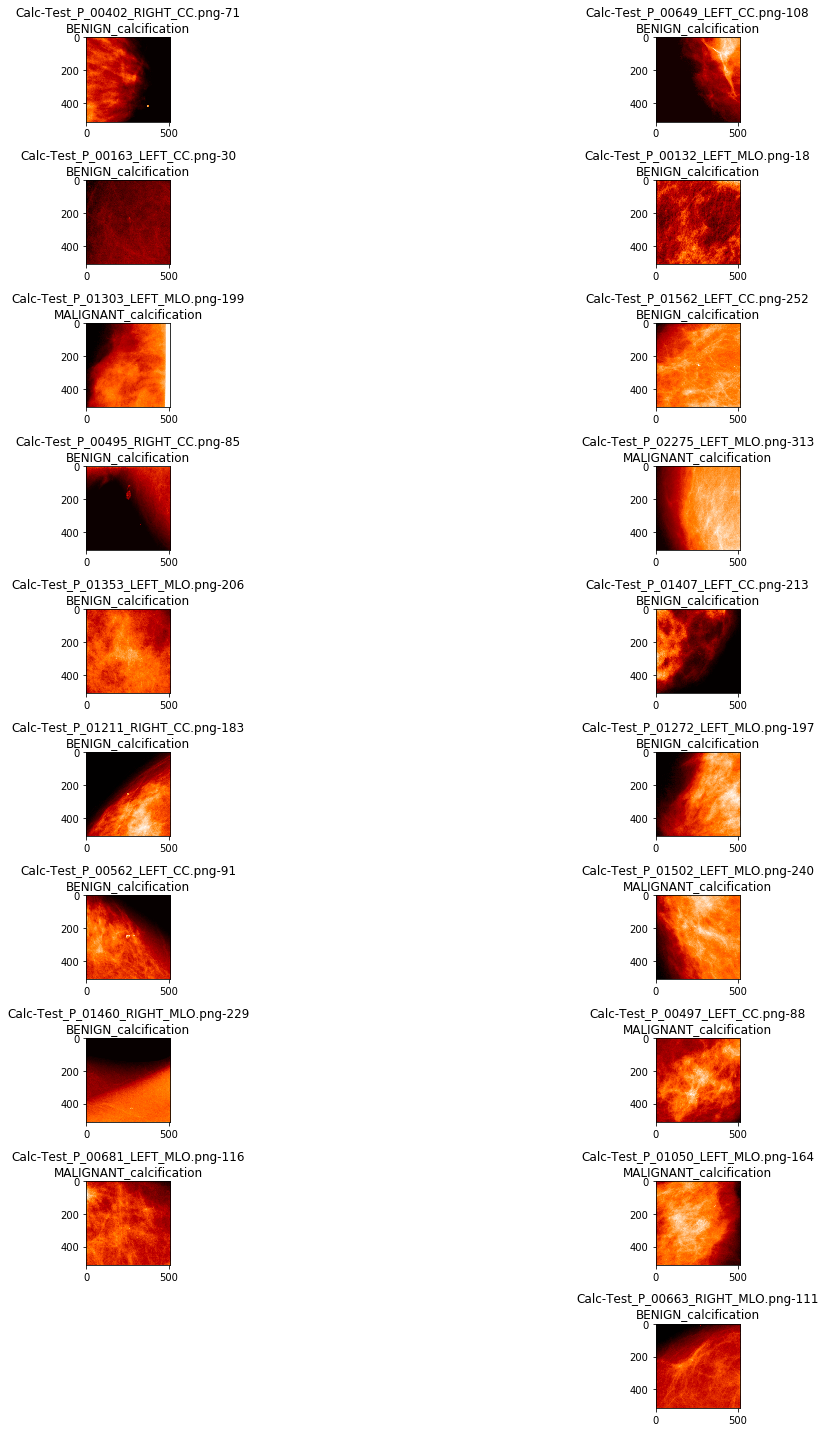

In [90]:
# random images 
N = 20
idx = random.sample(range(len(test_calc_patch)), k=N)
plt.figure(figsize=(20,20))
for i, j in enumerate(idx):
    plt.subplot(10,2,i+1)
    plt.imshow(test_calc_patch[j].reshape(512,512), cmap='gist_heat')
    plt.title(test_calc_FN[j] + "-" + str(j) + "\n" + test_calc_Lbl[j])
    plt.tight_layout()
plt.show()

In [91]:
np.save(os.path.join("npy_new3", "test_calc_patch.npy"), test_calc_patch)
np.save(os.path.join("npy_new3", "test_calc_Lbl.npy"), np.array(test_calc_Lbl))
np.save(os.path.join("npy_new3", "test_calc_FN.npy"), test_calc_FN)
np.save(os.path.join("npy_new3", "test_calc_roi_size.npy"), np.array(test_calc_roi_size))

In [92]:
#Mass_test
test_labels = pd.read_pickle("label old ver/test_label.pkl")
test_labels['IMAGE_NAME2'] = test_labels.index
test_labels = test_labels.drop_duplicates(['IMAGE_NAME2'])

## use a copy on the local drive to make testing faster
mask_dir = "D:/mammography/mask/test_png/Mass"
img_dir = "D:/mammography/full/test_png/Mass"

roi_sizes = []

test_mass_patch, test_mass_Lbl, test_mass_FN, test_mass_roi_size = \
    create_patches(roi_sizes, mask_dir, img_dir, Lbls=test_labels, debug=True)

  0%|▏                                                                                 | 1/378 [00:00<01:29,  4.20it/s]

(1846, 4006)
Mask Mass-Test_P_00016_LEFT_CC_1.png  Height: 344 Width: 345
start_row 2248
end_row 3272
start_col 822
end_col 1846
roi_img.shape (1024, 1024)


  1%|▍                                                                                 | 2/378 [00:00<01:41,  3.70it/s]

(2011, 5491)
Mask Mass-Test_P_00016_LEFT_MLO_1.png  Height: 329 Width: 288
start_row 3311
end_row 4335
start_col 987
end_col 2011
roi_img.shape (1024, 1024)


  1%|▋                                                                                 | 3/378 [00:01<02:13,  2.82it/s]

(3200, 5904)
Mask Mass-Test_P_00017_LEFT_CC_1.png  Height: 174 Width: 155
start_row 3342
end_row 4366
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  1%|▊                                                                                 | 4/378 [00:01<02:34,  2.43it/s]

(3352, 5952)
Mask Mass-Test_P_00017_LEFT_MLO_1.png  Height: 180 Width: 185
start_row 3393
end_row 4417
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  1%|█                                                                                 | 5/378 [00:02<02:30,  2.47it/s]

(2641, 5116)
Mask Mass-Test_P_00032_RIGHT_CC_1.png  Height: 365 Width: 336
start_row 1456
end_row 2480
start_col 1524
end_col 2548
roi_img.shape (1024, 1024)


  2%|█▎                                                                                | 6/378 [00:02<02:30,  2.48it/s]

(2671, 5206)
Mask Mass-Test_P_00032_RIGHT_MLO_1.png  Height: 370 Width: 421
start_row 1816
end_row 2840
start_col 1067
end_col 2091
roi_img.shape (1024, 1024)


  2%|█▌                                                                                | 7/378 [00:02<02:30,  2.46it/s]

(2936, 4608)
Mask Mass-Test_P_00037_RIGHT_CC_1.png  Height: 389 Width: 323
start_row 1048
end_row 2072
start_col 1328
end_col 2352
roi_img.shape (1024, 1024)


  2%|█▋                                                                                | 8/378 [00:03<02:35,  2.39it/s]

(2928, 4640)
Mask Mass-Test_P_00037_RIGHT_MLO_1.png  Height: 437 Width: 442
start_row 1814
end_row 2838
start_col 1023
end_col 2047
roi_img.shape (1024, 1024)


  2%|█▉                                                                                | 9/378 [00:03<02:31,  2.43it/s]

(2936, 4296)
Mask Mass-Test_P_00056_LEFT_MLO_1.png  Height: 236 Width: 294
start_row 2537
end_row 3561
start_col 17
end_col 1041
roi_img.shape (1024, 1024)


  3%|██▏                                                                              | 10/378 [00:03<02:16,  2.70it/s]

(2131, 4351)
Mask Mass-Test_P_00066_LEFT_CC_1.png  Height: 229 Width: 260
start_row 1901
end_row 2925
start_col 1107
end_col 2131
roi_img.shape (1024, 1024)


  3%|██▎                                                                              | 11/378 [00:04<02:18,  2.65it/s]

(2311, 5206)
Mask Mass-Test_P_00066_LEFT_MLO_1.png  Height: 278 Width: 405
start_row 3820
end_row 4844
start_col 1204
end_col 2228
roi_img.shape (1024, 1024)


  3%|██▌                                                                              | 12/378 [00:05<02:47,  2.18it/s]

(3676, 5491)
Mask Mass-Test_P_00099_LEFT_MLO_1.png  Height: 206 Width: 155
start_row 2590
end_row 3614
start_col 749
end_col 1773
roi_img.shape (1024, 1024)


  3%|██▊                                                                              | 13/378 [00:05<02:43,  2.24it/s]

(2896, 4568)
Mask Mass-Test_P_00114_LEFT_MLO_1.png  Height: 282 Width: 298
start_row 433
end_row 1457
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


  4%|███                                                                              | 14/378 [00:05<02:30,  2.42it/s]

(2728, 3920)
Mask Mass-Test_P_00116_RIGHT_CC_1.png  Height: 281 Width: 422
start_row 1331
end_row 2355
start_col 1124
end_col 2148
roi_img.shape (1024, 1024)


  4%|███▏                                                                             | 15/378 [00:06<02:17,  2.65it/s]

(2728, 3920)
Mask Mass-Test_P_00116_RIGHT_CC_2.png  Height: 511 Width: 445
start_row 1198
end_row 2222
start_col 1704
end_col 2728
roi_img.shape (1024, 1024)


  4%|███▍                                                                             | 16/378 [00:06<02:09,  2.79it/s]

(2600, 4144)
Mask Mass-Test_P_00116_RIGHT_MLO_1.png  Height: 443 Width: 246
start_row 1312
end_row 2336
start_col 806
end_col 1830
roi_img.shape (1024, 1024)


  4%|███▋                                                                             | 17/378 [00:06<02:01,  2.96it/s]

(2600, 4144)
Mask Mass-Test_P_00116_RIGHT_MLO_2.png  Height: 446 Width: 457
start_row 880
end_row 1904
start_col 1453
end_col 2477
roi_img.shape (1024, 1024)
(4411, 6451)


  5%|███▊                                                                             | 18/378 [00:07<02:46,  2.16it/s]

Mask Mass-Test_P_00118_RIGHT_CC_1.png  Height: 224 Width: 320
start_row 3017
end_row 4041
start_col 1165
end_col 2189
roi_img.shape (1024, 1024)
(4486, 6436)


  5%|████                                                                             | 19/378 [00:08<03:21,  1.78it/s]

Mask Mass-Test_P_00118_RIGHT_MLO_1.png  Height: 328 Width: 262
start_row 2781
end_row 3805
start_col 2116
end_col 3140
roi_img.shape (1024, 1024)


  5%|████▎                                                                            | 20/378 [00:08<03:10,  1.88it/s]

(2746, 5491)
Mask Mass-Test_P_00124_RIGHT_CC_1.png  Height: 130 Width: 148
start_row 3874
end_row 4898
start_col 223
end_col 1247
roi_img.shape (1024, 1024)


  6%|████▌                                                                            | 21/378 [00:09<03:01,  1.96it/s]

(2431, 5491)
Mask Mass-Test_P_00126_RIGHT_CC_1.png  Height: 261 Width: 276
start_row 3087
end_row 4111
start_col 321
end_col 1345
roi_img.shape (1024, 1024)


  6%|████▋                                                                            | 22/378 [00:09<02:59,  1.98it/s]

(2611, 5491)
Mask Mass-Test_P_00126_RIGHT_MLO_1.png  Height: 312 Width: 305
start_row 3691
end_row 4715
start_col 740
end_col 1764
roi_img.shape (1024, 1024)
(4024, 5824)
Mask Mass-Test_P_00131_LEFT_CC_1.png  Height: 226 Width: 267
start_row 1742
end_row 2766
start_col 1452
end_col 2476
roi_img.shape (1024, 1024)


  6%|█████▏                                                                           | 24/378 [00:10<03:22,  1.75it/s]

(4000, 5768)
Mask Mass-Test_P_00131_LEFT_MLO_1.png  Height: 241 Width: 275
start_row 3056
end_row 4080
start_col 1470
end_col 2494
roi_img.shape (1024, 1024)


  7%|█████▎                                                                           | 25/378 [00:11<02:51,  2.05it/s]

(1789, 4386)
Mask Mass-Test_P_00145_LEFT_CC_1.png  Height: 344 Width: 330
start_row 2074
end_row 3098
start_col 289
end_col 1313
roi_img.shape (1024, 1024)


  7%|█████▌                                                                           | 26/378 [00:11<02:34,  2.28it/s]

(2155, 4373)
Mask Mass-Test_P_00145_LEFT_MLO_1.png  Height: 295 Width: 347
start_row 2331
end_row 3355
start_col 444
end_col 1468
roi_img.shape (1024, 1024)
(4216, 6406)
Mask Mass-Test_P_00147_RIGHT_CC_1.png  Height: 301 Width: 305
start_row 919
end_row 1943
start_col 321
end_col 1345
roi_img.shape (1024, 1024)


  7%|█████▊                                                                           | 27/378 [00:12<03:06,  1.88it/s]

(4066, 6916)


  7%|██████                                                                           | 28/378 [00:13<03:30,  1.66it/s]

Mask Mass-Test_P_00147_RIGHT_MLO_1.png  Height: 252 Width: 297
start_row 4277
end_row 5301
start_col 516
end_col 1540
roi_img.shape (1024, 1024)


  8%|██████▏                                                                          | 29/378 [00:13<03:07,  1.86it/s]

(2904, 4536)
Mask Mass-Test_P_00156_RIGHT_MLO_1.png  Height: 363 Width: 476
start_row 1196
end_row 2220
start_col 1880
end_col 2904
roi_img.shape (1024, 1024)


  8%|██████▍                                                                          | 30/378 [00:13<02:51,  2.02it/s]

(2888, 4656)
Mask Mass-Test_P_00158_RIGHT_MLO_1.png  Height: 144 Width: 146
start_row 1294
end_row 2318
start_col 1864
end_col 2888
roi_img.shape (1024, 1024)
(4128, 5744)
Mask

  8%|██████▋                                                                          | 31/378 [00:14<03:13,  1.80it/s]

 Mass-Test_P_00159_RIGHT_MLO_1.png  Height: 253 Width: 248
start_row 1224
end_row 2248
start_col 2503
end_col 3527
roi_img.shape (1024, 1024)


  8%|██████▊                                                                          | 32/378 [00:14<02:58,  1.93it/s]

(2776, 5326)
Mask Mass-Test_P_00171_RIGHT_CC_1.png  Height: 324 Width: 284
start_row 2235
end_row 3259
start_col 449
end_col 1473
roi_img.shape (1024, 1024)


  9%|███████                                                                          | 33/378 [00:15<02:59,  1.92it/s]

(3001, 5491)
Mask Mass-Test_P_00171_RIGHT_MLO_1.png  Height: 235 Width: 329
start_row 3363
end_row 4387
start_col 230
end_col 1254
roi_img.shape (1024, 1024)


  9%|███████▎                                                                         | 34/378 [00:15<02:42,  2.12it/s]

(2864, 4432)
Mask Mass-Test_P_00173_LEFT_CC_1.png  Height: 262 Width: 305
start_row 1926
end_row 2950
start_col 573
end_col 1597
roi_img.shape (1024, 1024)


  9%|███████▌                                                                         | 35/378 [00:16<02:34,  2.22it/s]

(2848, 4464)
Mask Mass-Test_P_00173_LEFT_MLO_1.png  Height: 281 Width: 234
start_row 2814
end_row 3838
start_col 372
end_col 1396
roi_img.shape (1024, 1024)


 10%|███████▋                                                                         | 36/378 [00:16<02:25,  2.35it/s]

(2864, 4560)
Mask Mass-Test_P_00173_RIGHT_CC_1.png  Height: 472 Width: 419
start_row 2167
end_row 3191
start_col 1840
end_col 2864
roi_img.shape (1024, 1024)


 10%|███████▉                                                                         | 37/378 [00:16<02:17,  2.49it/s]

(2864, 4560)
Mask Mass-Test_P_00173_RIGHT_CC_2.png  Height: 323 Width: 315
start_row 1753
end_row 2777
start_col 1454
end_col 2478
roi_img.shape (1024, 1024)


 10%|████████▏                                                                        | 38/378 [00:17<02:19,  2.43it/s]

(2920, 4536)
Mask Mass-Test_P_00173_RIGHT_MLO_1.png  Height: 236 Width: 189
start_row 1254
end_row 2278
start_col 1896
end_col 2920
roi_img.shape (1024, 1024)


 10%|████████▎                                                                        | 39/378 [00:17<02:14,  2.52it/s]

(2920, 4536)
Mask Mass-Test_P_00173_RIGHT_MLO_2.png  Height: 263 Width: 256
start_row 2207
end_row 3231
start_col 1295
end_col 2319
roi_img.shape (1024, 1024)


 11%|████████▌                                                                        | 40/378 [00:18<02:14,  2.51it/s]

(2720, 4688)
Mask Mass-Test_P_00177_LEFT_CC_1.png  Height: 135 Width: 142
start_row 1776
end_row 2800
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 11%|████████▊                                                                        | 41/378 [00:18<02:20,  2.39it/s]

(2776, 4688)
Mask Mass-Test_P_00177_LEFT_MLO_1.png  Height: 198 Width: 212
start_row 1101
end_row 2125
start_col 304
end_col 1328
roi_img.shape (1024, 1024)
(3984, 5704)
Mask Mass-Test_P_00192_RIGHT_CC_1.png  Height: 948 Width: 883
start_row 2003
end_row 3027
start_col 2155
end_col 3179
roi_img.shape (1024, 1024)


 11%|█████████▏                                                                       | 43/378 [00:19<02:35,  2.15it/s]

(2776, 4776)
Mask Mass-Test_P_00194_RIGHT_CC_1.png  Height: 648 Width: 529
start_row 2642
end_row 3666
start_col 979
end_col 2003
roi_img.shape (1024, 1024)


 12%|█████████▍                                                                       | 44/378 [00:20<02:37,  2.13it/s]

(2832, 4784)
Mask Mass-Test_P_00194_RIGHT_MLO_1.png  Height: 663 Width: 611
start_row 2989
end_row 4013
start_col 749
end_col 1773
roi_img.shape (1024, 1024)


 12%|█████████▋                                                                       | 45/378 [00:20<02:54,  1.91it/s]

(3832, 5904)
Mask Mass-Test_P_00198_LEFT_CC_1.png  Height: 291 Width: 319
start_row 795
end_row 1819
start_col 1735
end_col 2759
roi_img.shape (1024, 1024)
(4088, 5896)
Mask Mass-Test_P_00198_LEFT_MLO_1.png  Height: 185 Width: 306
start_row 2316
end_row 3340
start_col 2052
end_col 3076
roi_img.shape (1024, 1024)


 12%|██████████                                                                       | 47/378 [00:21<02:51,  1.93it/s]

(2920, 4560)
Mask Mass-Test_P_00200_LEFT_CC_1.png  Height: 799 Width: 632
start_row 1790
end_row 2814
start_col 770
end_col 1794
roi_img.shape (1024, 1024)


 13%|██████████▎                                                                      | 48/378 [00:22<02:39,  2.07it/s]

(2896, 4560)
Mask Mass-Test_P_00200_LEFT_MLO_1.png  Height: 395 Width: 374
start_row 2704
end_row 3728
start_col 524
end_col 1548
roi_img.shape (1024, 1024)


 13%|██████████▌                                                                      | 49/378 [00:22<02:30,  2.19it/s]

(2936, 4600)
Mask Mass-Test_P_00200_RIGHT_CC_1.png  Height: 754 Width: 509
start_row 1682
end_row 2706
start_col 1461
end_col 2485
roi_img.shape (1024, 1024)


 13%|██████████▋                                                                      | 50/378 [00:23<02:23,  2.28it/s]

(2896, 4560)
Mask Mass-Test_P_00200_RIGHT_MLO_1.png  Height: 537 Width: 514
start_row 1451
end_row 2475
start_col 1872
end_col 2896
roi_img.shape (1024, 1024)


 13%|██████████▉                                                                      | 51/378 [00:23<02:42,  2.01it/s]

(3984, 5784)
Mask Mass-Test_P_00202_RIGHT_CC_1.png  Height: 404 Width: 407
start_row 722
end_row 1746
start_col 2682
end_col 3706
roi_img.shape (1024, 1024)
(4152, 5952)
Mask Mass-Test_P_00202_RIGHT_MLO_1.png  Height: 382 Width: 421
start_row 2542
end_row 3566
start_col 1816
end_col 2840
roi_img.shape (1024, 1024)


 14%|███████████▎                                                                     | 53/378 [00:25<03:14,  1.67it/s]

(3346, 6631)
Mask Mass-Test_P_00203_LEFT_CC_1.png  Height: 210 Width: 192
start_row 2428
end_row 3452
start_col 2090
end_col 3114
roi_img.shape (1024, 1024)


 14%|███████████▌                                                                     | 54/378 [00:25<03:21,  1.61it/s]

(3631, 6781)
Mask Mass-Test_P_00203_LEFT_MLO_1.png  Height: 248 Width: 179
start_row 2800
end_row 3824
start_col 1743
end_col 2767
roi_img.shape (1024, 1024)
(5431, 6871)


 15%|███████████▊                                                                     | 55/378 [00:26<04:00,  1.34it/s]

Mask Mass-Test_P_00209_LEFT_MLO_1.png  Height: 142 Width: 184
start_row 1328
end_row 2352
start_col 4407
end_col 5431
roi_img.shape (1024, 1024)


 15%|████████████                                                                     | 56/378 [00:27<03:29,  1.54it/s]

(3120, 4728)
Mask Mass-Test_P_00212_RIGHT_CC_1.png  Height: 468 Width: 492
start_row 2415
end_row 3439
start_col 1537
end_col 2561
roi_img.shape (1024, 1024)


 15%|████████████▏                                                                    | 57/378 [00:27<03:05,  1.73it/s]

(3096, 4608)
Mask Mass-Test_P_00212_RIGHT_MLO_1.png  Height: 287 Width: 330
start_row 3189
end_row 4213
start_col 1495
end_col 2519
roi_img.shape (1024, 1024)


 15%|████████████▍                                                                    | 58/378 [00:28<03:03,  1.75it/s]

(3211, 6196)
Mask Mass-Test_P_00230_RIGHT_CC_1.png  Height: 180 Width: 229
start_row 3516
end_row 4540
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▋                                                                    | 59/378 [00:28<03:04,  1.73it/s]

(3196, 6466)
Mask Mass-Test_P_00230_RIGHT_MLO_1.png  Height: 220 Width: 235
start_row 3767
end_row 4791
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 16%|████████████▊                                                                    | 60/378 [00:29<02:48,  1.89it/s]

(2928, 4816)
Mask Mass-Test_P_00238_RIGHT_CC_1.png  Height: 183 Width: 135
start_row 740
end_row 1764
start_col 1512
end_col 2536
roi_img.shape (1024, 1024)


 16%|█████████████                                                                    | 61/378 [00:29<02:39,  1.99it/s]

(2944, 4824)
Mask Mass-Test_P_00238_RIGHT_MLO_1.png  Height: 173 Width: 182
start_row 2099
end_row 3123
start_col 1390
end_col 2414
roi_img.shape (1024, 1024)


 16%|█████████████▎                                                                   | 62/378 [00:30<02:51,  1.84it/s]

(3571, 6076)
Mask Mass-Test_P_00278_RIGHT_CC_1.png  Height: 213 Width: 210
start_row 3058
end_row 4082
start_col 1848
end_col 2872
roi_img.shape (1024, 1024)


 17%|█████████████▌                                                                   | 63/378 [00:30<03:02,  1.72it/s]

(3586, 6496)
Mask Mass-Test_P_00278_RIGHT_MLO_1.png  Height: 183 Width: 220
start_row 4668
end_row 5692
start_col 1825
end_col 2849
roi_img.shape (1024, 1024)


 17%|█████████████▋                                                                   | 64/378 [00:31<02:42,  1.93it/s]

(2352, 4680)
Mask Mass-Test_P_00296_LEFT_CC_1.png  Height: 613 Width: 566
start_row 2517
end_row 3541
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 17%|█████████████▉                                                                   | 65/378 [00:31<02:29,  2.10it/s]

(2528, 4720)
Mask Mass-Test_P_00296_LEFT_MLO_1.png  Height: 574 Width: 640
start_row 2677
end_row 3701
start_col 143
end_col 1167
roi_img.shape (1024, 1024)


 17%|██████████████▏                                                                  | 66/378 [00:32<02:19,  2.24it/s]

(2704, 4808)
Mask Mass-Test_P_00324_RIGHT_CC_1.png  Height: 440 Width: 360
start_row 2498
end_row 3522
start_col 1650
end_col 2674
roi_img.shape (1024, 1024)


 18%|██████████████▎                                                                  | 67/378 [00:32<02:10,  2.39it/s]

(2704, 4816)
Mask Mass-Test_P_00324_RIGHT_MLO_1.png  Height: 306 Width: 271
start_row 2093
end_row 3117
start_col 1490
end_col 2514
roi_img.shape (1024, 1024)


 18%|██████████████▌                                                                  | 68/378 [00:32<02:08,  2.41it/s]

(2371, 4996)
Mask Mass-Test_P_00340_LEFT_CC_1.png  Height: 261 Width: 241
start_row 2612
end_row 3636
start_col 1026
end_col 2050
roi_img.shape (1024, 1024)


 18%|██████████████▊                                                                  | 69/378 [00:33<02:04,  2.48it/s]

(3104, 4504)
Mask Mass-Test_P_00343_LEFT_CC_1.png  Height: 365 Width: 166
start_row 1719
end_row 2743
start_col 945
end_col 1969
roi_img.shape (1024, 1024)


 19%|███████████████                                                                  | 70/378 [00:33<02:04,  2.47it/s]

(2920, 4280)
Mask Mass-Test_P_00343_LEFT_MLO_1.png  Height: 410 Width: 214
start_row 2226
end_row 3250
start_col 879
end_col 1903
roi_img.shape (1024, 1024)


 19%|███████████████▏                                                                 | 71/378 [00:34<02:02,  2.50it/s]

(2936, 4088)
Mask Mass-Test_P_00343_RIGHT_CC_1.png  Height: 119 Width: 146
start_row 473
end_row 1497
start_col 1912
end_col 2936
roi_img.shape (1024, 1024)


 19%|███████████████▍                                                                 | 72/378 [00:34<01:55,  2.66it/s]

(2936, 4088)
Mask Mass-Test_P_00343_RIGHT_CC_2.png  Height: 409 Width: 190
start_row 1231
end_row 2255
start_col 1103
end_col 2127
roi_img.shape (1024, 1024)


 19%|███████████████▋                                                                 | 73/378 [00:34<01:55,  2.63it/s]

(3056, 4416)
Mask Mass-Test_P_00343_RIGHT_MLO_1.png  Height: 92 Width: 116
start_row 1051
end_row 2075
start_col 2014
end_col 3038
roi_img.shape (1024, 1024)


 20%|███████████████▊                                                                 | 74/378 [00:35<01:53,  2.68it/s]

(3056, 4416)
Mask Mass-Test_P_00343_RIGHT_MLO_2.png  Height: 435 Width: 320
start_row 2251
end_row 3275
start_col 1167
end_col 2191
roi_img.shape (1024, 1024)


 20%|████████████████                                                                 | 75/378 [00:35<01:58,  2.55it/s]

(3176, 4576)
Mask Mass-Test_P_00347_LEFT_CC_1.png  Height: 276 Width: 288
start_row 1542
end_row 2566
start_col 1041
end_col 2065
roi_img.shape (1024, 1024)


 20%|████████████████▎                                                                | 76/378 [00:36<02:08,  2.36it/s]

(3208, 4704)
Mask Mass-Test_P_00347_LEFT_MLO_1.png  Height: 282 Width: 246
start_row 3000
end_row 4024
start_col 1031
end_col 2055
roi_img.shape (1024, 1024)


 20%|████████████████▌                                                                | 77/378 [00:36<01:59,  2.51it/s]

(2446, 4966)
Mask Mass-Test_P_00358_RIGHT_CC_1.png  Height: 477 Width: 547
start_row 2464
end_row 3488
start_col 340
end_col 1364
roi_img.shape (1024, 1024)


 21%|████████████████▋                                                                | 78/378 [00:36<02:00,  2.49it/s]

(2491, 5431)
Mask Mass-Test_P_00358_RIGHT_MLO_1.png  Height: 571 Width: 529
start_row 2163
end_row 3187
start_col 271
end_col 1295
roi_img.shape (1024, 1024)


 21%|████████████████▉                                                                | 79/378 [00:37<02:13,  2.23it/s]

(3076, 6316)
Mask Mass-Test_P_00359_LEFT_MLO_1.png  Height: 303 Width: 402
start_row 4548
end_row 5572
start_col 1956
end_col 2980
roi_img.shape (1024, 1024)


 21%|█████████████████▏                                                               | 80/378 [00:37<02:09,  2.30it/s]

(2761, 4756)
Mask Mass-Test_P_00369_LEFT_CC_1.png  Height: 318 Width: 277
start_row 2475
end_row 3499
start_col 1105
end_col 2129
roi_img.shape (1024, 1024)


 21%|█████████████████▎                                                               | 81/378 [00:38<02:17,  2.17it/s]

(3106, 5491)
Mask Mass-Test_P_00369_LEFT_MLO_1.png  Height: 326 Width: 342
start_row 3751
end_row 4775
start_col 1506
end_col 2530
roi_img.shape (1024, 1024)


 22%|█████████████████▌                                                               | 82/378 [00:38<02:06,  2.34it/s]

(2440, 4728)
Mask Mass-Test_P_00375_RIGHT_CC_1.png  Height: 408 Width: 426
start_row 383
end_row 1407
start_col 1416
end_col 2440
roi_img.shape (1024, 1024)


 22%|█████████████████▊                                                               | 83/378 [00:39<02:03,  2.38it/s]

(2504, 4704)
Mask Mass-Test_P_00375_RIGHT_MLO_1.png  Height: 332 Width: 343
start_row 1304
end_row 2328
start_col 1036
end_col 2060
roi_img.shape (1024, 1024)


 22%|██████████████████                                                               | 84/378 [00:39<02:07,  2.31it/s]

(3091, 5386)
Mask Mass-Test_P_00379_LEFT_CC_1.png  Height: 347 Width: 415
start_row 1129
end_row 2153
start_col 409
end_col 1433
roi_img.shape (1024, 1024)


 22%|██████████████████▏                                                              | 85/378 [00:39<02:09,  2.27it/s]

(2820, 4686)
Mask Mass-Test_P_00379_LEFT_MLO_1.png  Height: 325 Width: 350
start_row 958
end_row 1982
start_col 157
end_col 1181
roi_img.shape (1024, 1024)


 23%|██████████████████▍                                                              | 86/378 [00:40<02:10,  2.25it/s]

(2781, 4621)
Mask Mass-Test_P_00381_LEFT_CC_1.png  Height: 214 Width: 214
start_row 1189
end_row 2213
start_col 1179
end_col 2203
roi_img.shape (1024, 1024)


 23%|██████████████████▋                                                              | 87/378 [00:40<02:22,  2.05it/s]

(3186, 4686)
Mask Mass-Test_P_00381_LEFT_MLO_1.png  Height: 234 Width: 175
start_row 2315
end_row 3339
start_col 1634
end_col 2658
roi_img.shape (1024, 1024)


 23%|██████████████████▊                                                              | 88/378 [00:41<02:14,  2.15it/s]

(3040, 4528)
Mask Mass-Test_P_00387_RIGHT_CC_1.png  Height: 186 Width: 178
start_row 2239
end_row 3263
start_col 1352
end_col 2376
roi_img.shape (1024, 1024)


 24%|███████████████████                                                              | 89/378 [00:41<02:12,  2.18it/s]

(3008, 4584)
Mask Mass-Test_P_00387_RIGHT_MLO_1.png  Height: 206 Width: 228
start_row 2468
end_row 3492
start_col 1458
end_col 2482
roi_img.shape (1024, 1024)


 24%|███████████████████▎                                                             | 90/378 [00:42<02:12,  2.17it/s]

(3091, 5491)
Mask Mass-Test_P_00391_LEFT_CC_1.png  Height: 332 Width: 331
start_row 2397
end_row 3421
start_col 2035
end_col 3059
roi_img.shape (1024, 1024)


 24%|███████████████████▌                                                             | 91/378 [00:42<02:13,  2.16it/s]

(2926, 5491)
Mask Mass-Test_P_00391_LEFT_MLO_1.png  Height: 341 Width: 359
start_row 2108
end_row 3132
start_col 1425
end_col 2449
roi_img.shape (1024, 1024)


 24%|███████████████████▋                                                             | 92/378 [00:43<02:09,  2.21it/s]

(2761, 5371)
Mask Mass-Test_P_00391_RIGHT_CC_1.png  Height: 507 Width: 718
start_row 2424
end_row 3448
start_col 151
end_col 1175
roi_img.shape (1024, 1024)


 25%|███████████████████▉                                                             | 93/378 [00:43<02:10,  2.18it/s]

(2941, 5491)
Mask Mass-Test_P_00391_RIGHT_MLO_1.png  Height: 312 Width: 322
start_row 2384
end_row 3408
start_col 425
end_col 1449
roi_img.shape (1024, 1024)


 25%|████████████████████▏                                                            | 94/378 [00:44<02:09,  2.19it/s]

(3112, 4640)
Mask Mass-Test_P_00394_RIGHT_MLO_1.png  Height: 366 Width: 350
start_row 1460
end_row 2484
start_col 1411
end_col 2435
roi_img.shape (1024, 1024)


 25%|████████████████████▎                                                            | 95/378 [00:44<02:17,  2.06it/s]

(3196, 5491)
Mask Mass-Test_P_00405_LEFT_CC_1.png  Height: 375 Width: 321
start_row 2300
end_row 3324
start_col 2172
end_col 3196
roi_img.shape (1024, 1024)


 25%|████████████████████▌                                                            | 96/378 [00:45<02:30,  1.88it/s]

(3406, 5491)
Mask Mass-Test_P_00405_LEFT_MLO_1.png  Height: 396 Width: 371
start_row 3453
end_row 4477
start_col 2382
end_col 3406
roi_img.shape (1024, 1024)


 26%|████████████████████▊                                                            | 97/378 [00:45<02:26,  1.92it/s]

(2986, 5311)
Mask Mass-Test_P_00409_RIGHT_CC_1.png  Height: 369 Width: 434
start_row 3313
end_row 4337
start_col 1757
end_col 2781
roi_img.shape (1024, 1024)


 26%|█████████████████████                                                            | 98/378 [00:46<02:23,  1.95it/s]

(2866, 5296)
Mask Mass-Test_P_00409_RIGHT_MLO_1.png  Height: 344 Width: 436
start_row 3530
end_row 4554
start_col 1842
end_col 2866
roi_img.shape (1024, 1024)


 26%|█████████████████████▏                                                           | 99/378 [00:46<02:14,  2.07it/s]

(2880, 4552)
Mask Mass-Test_P_00429_LEFT_CC_1.png  Height: 312 Width: 300
start_row 2593
end_row 3617
start_col 245
end_col 1269
roi_img.shape (1024, 1024)


 26%|█████████████████████▏                                                          | 100/378 [00:47<02:09,  2.15it/s]

(2888, 4576)
Mask Mass-Test_P_00429_LEFT_MLO_1.png  Height: 310 Width: 254
start_row 2393
end_row 3417
start_col 249
end_col 1273
roi_img.shape (1024, 1024)


 27%|█████████████████████▍                                                          | 101/378 [00:47<02:06,  2.20it/s]

(2896, 4528)
Mask Mass-Test_P_00433_LEFT_CC_1.png  Height: 184 Width: 202
start_row 1141
end_row 2165
start_col 96
end_col 1120
roi_img.shape (1024, 1024)


 27%|█████████████████████▌                                                          | 102/378 [00:48<02:03,  2.24it/s]

(2800, 4488)
Mask Mass-Test_P_00433_LEFT_MLO_1.png  Height: 281 Width: 327
start_row 2004
end_row 3028
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 27%|█████████████████████▊                                                          | 103/378 [00:48<02:07,  2.16it/s]

(3031, 5386)
Mask Mass-Test_P_00457_LEFT_CC_1.png  Height: 288 Width: 331
start_row 2665
end_row 3689
start_col 1059
end_col 2083
roi_img.shape (1024, 1024)


 28%|██████████████████████                                                          | 104/378 [00:49<02:09,  2.12it/s]

(2956, 5386)
Mask Mass-Test_P_00457_LEFT_MLO_1.png  Height: 376 Width: 340
start_row 3390
end_row 4414
start_col 838
end_col 1862
roi_img.shape (1024, 1024)


 28%|██████████████████████▏                                                         | 105/378 [00:49<02:16,  2.01it/s]

(3046, 6331)
Mask Mass-Test_P_00464_RIGHT_CC_1.png  Height: 410 Width: 423
start_row 4022
end_row 5046
start_col 675
end_col 1699
roi_img.shape (1024, 1024)


 28%|██████████████████████▍                                                         | 106/378 [00:50<02:23,  1.90it/s]

(2956, 6391)
Mask Mass-Test_P_00464_RIGHT_MLO_1.png  Height: 253 Width: 311
start_row 4227
end_row 5251
start_col 485
end_col 1509
roi_img.shape (1024, 1024)


 28%|██████████████████████▋                                                         | 107/378 [00:50<02:12,  2.05it/s]

(2896, 4368)
Mask Mass-Test_P_00470_RIGHT_CC_1.png  Height: 227 Width: 216
start_row 1659
end_row 2683
start_col 516
end_col 1540
roi_img.shape (1024, 1024)


 29%|██████████████████████▊                                                         | 108/378 [00:50<02:06,  2.13it/s]

(2888, 4288)
Mask Mass-Test_P_00470_RIGHT_MLO_1.png  Height: 200 Width: 177
start_row 2615
end_row 3639
start_col 438
end_col 1462
roi_img.shape (1024, 1024)


 29%|███████████████████████                                                         | 109/378 [00:51<01:59,  2.24it/s]

(2800, 4712)
Mask Mass-Test_P_00481_RIGHT_CC_1.png  Height: 252 Width: 279
start_row 2041
end_row 3065
start_col 1213
end_col 2237
roi_img.shape (1024, 1024)


 29%|███████████████████████▎                                                        | 110/378 [00:51<01:57,  2.27it/s]

(2928, 4832)
Mask Mass-Test_P_00481_RIGHT_MLO_1.png  Height: 264 Width: 279
start_row 3112
end_row 4136
start_col 1408
end_col 2432
roi_img.shape (1024, 1024)


 29%|███████████████████████▍                                                        | 111/378 [00:52<01:56,  2.29it/s]

(2731, 5146)
Mask Mass-Test_P_00482_LEFT_CC_1.png  Height: 684 Width: 766
start_row 1234
end_row 2258
start_col 1035
end_col 2059
roi_img.shape (1024, 1024)


 30%|███████████████████████▋                                                        | 112/378 [00:52<01:54,  2.33it/s]

(2731, 5176)
Mask Mass-Test_P_00482_LEFT_MLO_1.png  Height: 569 Width: 616
start_row 1382
end_row 2406
start_col 939
end_col 1963
roi_img.shape (1024, 1024)


 30%|███████████████████████▉                                                        | 113/378 [00:53<01:49,  2.42it/s]

(2624, 4720)
Mask Mass-Test_P_00490_RIGHT_CC_1.png  Height: 225 Width: 267
start_row 883
end_row 1907
start_col 1600
end_col 2624
roi_img.shape (1024, 1024)


 30%|████████████████████████▏                                                       | 114/378 [00:53<01:45,  2.51it/s]

(2648, 4696)
Mask Mass-Test_P_00490_RIGHT_MLO_1.png  Height: 255 Width: 236
start_row 1232
end_row 2256
start_col 1022
end_col 2046
roi_img.shape (1024, 1024)


 30%|████████████████████████▎                                                       | 115/378 [00:53<01:44,  2.51it/s]

(2536, 5296)
Mask Mass-Test_P_00493_RIGHT_CC_1.png  Height: 249 Width: 268
start_row 1943
end_row 2967
start_col 360
end_col 1384
roi_img.shape (1024, 1024)
(3721, 6616)
Mask

 31%|████████████████████████▌                                                       | 116/378 [00:54<02:07,  2.06it/s]

 Mass-Test_P_00494_RIGHT_CC_1.png  Height: 447 Width: 465
start_row 1709
end_row 2733
start_col 714
end_col 1738
roi_img.shape (1024, 1024)
(3826, 6391)
Mask

 31%|████████████████████████▊                                                       | 117/378 [00:55<02:20,  1.85it/s]

 Mass-Test_P_00494_RIGHT_MLO_1.png  Height: 364 Width: 424
start_row 2878
end_row 3902
start_col 1209
end_col 2233
roi_img.shape (1024, 1024)
(3631, 6751)
Mask Mass-Test_P_00498_LEFT_CC_1.png  Height: 

 31%|████████████████████████▉                                                       | 118/378 [00:55<02:31,  1.71it/s]

187 Width: 208
start_row 3493
end_row 4517
start_col 1946
end_col 2970
roi_img.shape (1024, 1024)
(3961, 6871)


 31%|█████████████████████████▏                                                      | 119/378 [00:56<02:45,  1.56it/s]

Mask Mass-Test_P_00498_LEFT_MLO_1.png  Height: 199 Width: 244
start_row 4297
end_row 5321
start_col 2204
end_col 3228
roi_img.shape (1024, 1024)


 32%|█████████████████████████▍                                                      | 120/378 [00:57<02:45,  1.56it/s]

(3646, 6331)
Mask Mass-Test_P_00500_RIGHT_MLO_1.png  Height: 263 Width: 316
start_row 2188
end_row 3212
start_col 384
end_col 1408
roi_img.shape (1024, 1024)
(4040, 5720)
Mask

 32%|█████████████████████████▌                                                      | 121/378 [00:57<02:42,  1.58it/s]

 Mass-Test_P_00510_LEFT_CC_4.png  Height: 195 Width: 201
start_row 403
end_row 1427
start_col 30
end_col 1054
roi_img.shape (1024, 1024)


 32%|█████████████████████████▊                                                      | 122/378 [00:58<02:42,  1.57it/s]

(4168, 5680)
Mask Mass-Test_P_00510_LEFT_MLO_2.png  Height: 202 Width: 174
start_row 670
end_row 1694
start_col 1102
end_col 2126
roi_img.shape (1024, 1024)
(4186, 6871)


 33%|██████████████████████████                                                      | 123/378 [00:59<02:54,  1.46it/s]

Mask Mass-Test_P_00514_LEFT_MLO_1.png  Height: 213 Width: 182
start_row 4225
end_row 5249
start_col 2090
end_col 3114
roi_img.shape (1024, 1024)


 33%|██████████████████████████▏                                                     | 124/378 [00:59<02:33,  1.66it/s]

(2632, 4760)
Mask Mass-Test_P_00516_LEFT_CC_1.png  Height: 418 Width: 423
start_row 2582
end_row 3606
start_col 271
end_col 1295
roi_img.shape (1024, 1024)


 33%|██████████████████████████▍                                                     | 125/378 [01:00<02:17,  1.84it/s]

(2624, 4744)
Mask Mass-Test_P_00516_LEFT_MLO_1.png  Height: 437 Width: 418
start_row 2614
end_row 3638
start_col 46
end_col 1070
roi_img.shape (1024, 1024)


 33%|██████████████████████████▋                                                     | 126/378 [01:00<02:24,  1.75it/s]

(3880, 5968)
Mask Mass-Test_P_00524_LEFT_CC_1.png  Height: 287 Width: 337
start_row 1323
end_row 2347
start_col 970
end_col 1994
roi_img.shape (1024, 1024)


 34%|██████████████████████████▉                                                     | 127/378 [01:01<02:29,  1.67it/s]

(3816, 5888)
Mask Mass-Test_P_00524_LEFT_MLO_1.png  Height: 152 Width: 173
start_row 2458
end_row 3482
start_col 1059
end_col 2083
roi_img.shape (1024, 1024)


 34%|███████████████████████████                                                     | 128/378 [01:01<02:14,  1.86it/s]

(2944, 4472)
Mask Mass-Test_P_00533_LEFT_CC_1.png  Height: 303 Width: 339
start_row 1769
end_row 2793
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 34%|███████████████████████████▎                                                    | 129/378 [01:02<02:01,  2.05it/s]

(3008, 4512)
Mask Mass-Test_P_00533_LEFT_MLO_1.png  Height: 269 Width: 292
start_row 2422
end_row 3446
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 34%|███████████████████████████▌                                                    | 130/378 [01:02<01:57,  2.11it/s]

(3080, 4776)
Mask Mass-Test_P_00544_LEFT_CC_1.png  Height: 178 Width: 263
start_row 1075
end_row 2099
start_col 460
end_col 1484
roi_img.shape (1024, 1024)


 35%|███████████████████████████▋                                                    | 131/378 [01:03<01:52,  2.19it/s]

(3144, 4712)
Mask Mass-Test_P_00544_LEFT_MLO_1.png  Height: 392 Width: 283
start_row 1654
end_row 2678
start_col 1302
end_col 2326
roi_img.shape (1024, 1024)


 35%|███████████████████████████▉                                                    | 132/378 [01:03<02:06,  1.95it/s]

(4126, 5491)
Mask Mass-Test_P_00576_LEFT_CC_1.png  Height: 219 Width: 225
start_row 2175
end_row 3199
start_col 3043
end_col 4067
roi_img.shape (1024, 1024)


 35%|████████████████████████████▏                                                   | 133/378 [01:04<02:16,  1.79it/s]

(4126, 5491)
Mask Mass-Test_P_00576_LEFT_MLO_1.png  Height: 184 Width: 156
start_row 3171
end_row 4195
start_col 3102
end_col 4126
roi_img.shape (1024, 1024)


 35%|████████████████████████████▎                                                   | 134/378 [01:04<02:22,  1.72it/s]

(3541, 6766)
Mask Mass-Test_P_00587_RIGHT_CC_1.png  Height: 302 Width: 267
start_row 1812
end_row 2836
start_col 965
end_col 1989
roi_img.shape (1024, 1024)
(3736, 6451)
Mask Mass-Test_P_00587_RIGHT_MLO_1.png  Height: 299 Width: 312


 36%|████████████████████████████▌                                                   | 135/378 [01:05<02:26,  1.65it/s]

start_row 2966
end_row 3990
start_col 1421
end_col 2445
roi_img.shape (1024, 1024)


 36%|████████████████████████████▊                                                   | 136/378 [01:06<02:24,  1.67it/s]

(3232, 6000)
Mask Mass-Test_P_00591_RIGHT_MLO_3.png  Height: 329 Width: 370
start_row 100
end_row 1124
start_col 2208
end_col 3232
roi_img.shape (1024, 1024)


 36%|████████████████████████████▉                                                   | 137/378 [01:06<02:10,  1.85it/s]

(2896, 4576)
Mask Mass-Test_P_00598_LEFT_CC_1.png  Height: 553 Width: 546
start_row 2114
end_row 3138
start_col 96
end_col 1120
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▏                                                  | 138/378 [01:07<02:00,  1.98it/s]

(2896, 4456)
Mask Mass-Test_P_00598_LEFT_MLO_1.png  Height: 425 Width: 398
start_row 2050
end_row 3074
start_col 145
end_col 1169
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▍                                                  | 139/378 [01:07<02:11,  1.82it/s]

(3624, 5872)
Mask Mass-Test_P_00601_LEFT_CC_1.png  Height: 223 Width: 289
start_row 2988
end_row 4012
start_col 916
end_col 1940
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▋                                                  | 140/378 [01:08<02:13,  1.78it/s]

(3648, 5816)
Mask Mass-Test_P_00601_LEFT_MLO_2.png  Height: 324 Width: 348
start_row 3588
end_row 4612
start_col 817
end_col 1841
roi_img.shape (1024, 1024)


 37%|█████████████████████████████▊                                                  | 141/378 [01:08<02:01,  1.95it/s]

(2888, 4616)
Mask Mass-Test_P_00612_RIGHT_MLO_1.png  Height: 281 Width: 377
start_row 2384
end_row 3408
start_col 1500
end_col 2524
roi_img.shape (1024, 1024)


 38%|██████████████████████████████                                                  | 142/378 [01:09<02:06,  1.86it/s]

(3211, 6001)
Mask Mass-Test_P_00615_RIGHT_CC_1.png  Height: 461 Width: 407
start_row 1157
end_row 2181
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▎                                                 | 143/378 [01:09<02:08,  1.83it/s]

(3361, 6166)
Mask Mass-Test_P_00615_RIGHT_MLO_1.png  Height: 316 Width: 385
start_row 1628
end_row 2652
start_col 445
end_col 1469
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▍                                                 | 144/378 [01:10<01:55,  2.02it/s]

(2656, 4800)
Mask Mass-Test_P_00623_LEFT_CC_1.png  Height: 363 Width: 352
start_row 1841
end_row 2865
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 38%|██████████████████████████████▋                                                 | 145/378 [01:10<01:44,  2.24it/s]

(2624, 4784)
Mask Mass-Test_P_00623_LEFT_MLO_1.png  Height: 331 Width: 298
start_row 1123
end_row 2147
start_col 462
end_col 1486
roi_img.shape (1024, 1024)


 39%|██████████████████████████████▉                                                 | 146/378 [01:10<01:38,  2.35it/s]

(2566, 5206)
Mask Mass-Test_P_00629_RIGHT_CC_1.png  Height: 416 Width: 382
start_row 2091
end_row 3115
start_col 1542
end_col 2566
roi_img.shape (1024, 1024)


 39%|███████████████████████████████                                                 | 147/378 [01:11<01:35,  2.43it/s]

(2476, 5281)
Mask Mass-Test_P_00629_RIGHT_MLO_1.png  Height: 392 Width: 312
start_row 3301
end_row 4325
start_col 1452
end_col 2476
roi_img.shape (1024, 1024)


 39%|███████████████████████████████▎                                                | 148/378 [01:11<01:44,  2.20it/s]

(3256, 5976)
Mask Mass-Test_P_00636_RIGHT_CC_1.png  Height: 354 Width: 312
start_row 3202
end_row 4226
start_col 2232
end_col 3256
roi_img.shape (1024, 1024)


 39%|███████████████████████████████▌                                                | 149/378 [01:12<01:54,  2.00it/s]

(3184, 5952)
Mask Mass-Test_P_00636_RIGHT_MLO_1.png  Height: 433 Width: 271
start_row 4200
end_row 5224
start_col 2160
end_col 3184
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▋                                                | 150/378 [01:12<01:53,  2.00it/s]

(3184, 5864)
Mask Mass-Test_P_00639_LEFT_MLO_1.png  Height: 607 Width: 648
start_row 2122
end_row 3146
start_col 683
end_col 1707
roi_img.shape (1024, 1024)


 40%|███████████████████████████████▉                                                | 151/378 [01:13<02:02,  1.86it/s]

(3584, 5744)
Mask Mass-Test_P_00641_RIGHT_CC_1.png  Height: 297 Width: 395
start_row 1110
end_row 2134
start_col 2560
end_col 3584
roi_img.shape (1024, 1024)


 40%|████████████████████████████████▏                                               | 152/378 [01:14<02:01,  1.85it/s]

(3400, 5768)
Mask Mass-Test_P_00641_RIGHT_MLO_1.png  Height: 313 Width: 487
start_row 1612
end_row 2636
start_col 1480
end_col 2504
roi_img.shape (1024, 1024)


 40%|████████████████████████████████▍                                               | 153/378 [01:14<01:52,  1.99it/s]

(3112, 4640)
Mask Mass-Test_P_00652_LEFT_CC_1.png  Height: 349 Width: 407
start_row 1965
end_row 2989
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3811, 6871)
Mask Mass-Test_P_00656_RIGHT_MLO_1.png  Height: 337 Width: 380
start_row 2859
end_row 3883
start_col 79
end_col 1103
roi_img.shape (1024, 1024)


 41%|████████████████████████████████▊                                               | 155/378 [01:15<01:59,  1.87it/s]

(3072, 4672)
Mask Mass-Test_P_00662_LEFT_CC_1.png  Height: 327 Width: 403
start_row 1265
end_row 2289
start_col 112
end_col 1136
roi_img.shape (1024, 1024)


 41%|█████████████████████████████████                                               | 156/378 [01:16<01:53,  1.95it/s]

(3056, 4592)
Mask Mass-Test_P_00662_LEFT_MLO_1.png  Height: 483 Width: 560
start_row 1146
end_row 2170
start_col 593
end_col 1617
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▏                                              | 157/378 [01:16<02:01,  1.82it/s]

(3976, 5768)
Mask Mass-Test_P_00671_LEFT_CC_1.png  Height: 261 Width: 257
start_row 2116
end_row 3140
start_col 444
end_col 1468
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▍                                              | 158/378 [01:17<02:02,  1.80it/s]

(3800, 5440)
Mask Mass-Test_P_00671_LEFT_MLO_1.png  Height: 273 Width: 240
start_row 2440
end_row 3464
start_col 891
end_col 1915
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▋                                              | 159/378 [01:18<02:08,  1.70it/s]

(3824, 5928)
Mask Mass-Test_P_00677_RIGHT_CC_1.png  Height: 292 Width: 257
start_row 2485
end_row 3509
start_col 1430
end_col 2454
roi_img.shape (1024, 1024)


 42%|█████████████████████████████████▊                                              | 160/378 [01:18<02:13,  1.64it/s]

(4032, 5960)
Mask Mass-Test_P_00677_RIGHT_MLO_1.png  Height: 330 Width: 286
start_row 3013
end_row 4037
start_col 814
end_col 1838
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████                                              | 161/378 [01:19<02:04,  1.74it/s]

(2925, 4530)
Mask Mass-Test_P_00699_RIGHT_CC_1.png  Height: 198 Width: 295
start_row 2386
end_row 3410
start_col 1744
end_col 2768
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▎                                             | 162/378 [01:19<02:06,  1.71it/s]

(3277, 4556)
Mask Mass-Test_P_00699_RIGHT_MLO_1.png  Height: 136 Width: 126
start_row 2738
end_row 3762
start_col 1758
end_col 2782
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▍                                             | 163/378 [01:20<01:51,  1.93it/s]

(2472, 4704)
Mask Mass-Test_P_00707_RIGHT_CC_1.png  Height: 205 Width: 203
start_row 1862
end_row 2886
start_col 1055
end_col 2079
roi_img.shape (1024, 1024)


 43%|██████████████████████████████████▋                                             | 164/378 [01:20<01:43,  2.06it/s]

(2680, 4776)
Mask Mass-Test_P_00707_RIGHT_MLO_1.png  Height: 235 Width: 288
start_row 1631
end_row 2655
start_col 493
end_col 1517
roi_img.shape (1024, 1024)


 44%|██████████████████████████████████▉                                             | 165/378 [01:20<01:37,  2.20it/s]

(2768, 4776)
Mask Mass-Test_P_00718_RIGHT_MLO_1.png  Height: 325 Width: 322
start_row 1043
end_row 2067
start_col 1355
end_col 2379
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████▏                                            | 166/378 [01:21<01:31,  2.32it/s]

(2792, 4560)
Mask Mass-Test_P_00738_RIGHT_CC_1.png  Height: 227 Width: 255
start_row 376
end_row 1400
start_col 1495
end_col 2519
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████▎                                            | 167/378 [01:21<01:29,  2.35it/s]

(2936, 4632)
Mask Mass-Test_P_00738_RIGHT_MLO_1.png  Height: 191 Width: 204
start_row 1130
end_row 2154
start_col 1044
end_col 2068
roi_img.shape (1024, 1024)


 44%|███████████████████████████████████▌                                            | 168/378 [01:22<01:25,  2.47it/s]

(2464, 4792)
Mask Mass-Test_P_00741_LEFT_CC_1.png  Height: 439 Width: 253
start_row 733
end_row 1757
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▊                                            | 169/378 [01:22<01:24,  2.49it/s]

(2752, 4832)
Mask Mass-Test_P_00741_LEFT_MLO_1.png  Height: 342 Width: 352
start_row 1750
end_row 2774
start_col 175
end_col 1199
roi_img.shape (1024, 1024)


 45%|███████████████████████████████████▉                                            | 170/378 [01:23<01:37,  2.13it/s]

(3916, 5791)
Mask Mass-Test_P_00758_LEFT_CC_1.png  Height: 424 Width: 523
start_row 2045
end_row 3069
start_col 2406
end_col 3430
roi_img.shape (1024, 1024)


 45%|████████████████████████████████████▏                                           | 171/378 [01:23<01:51,  1.86it/s]

(3751, 5881)
Mask Mass-Test_P_00758_LEFT_MLO_1.png  Height: 423 Width: 445
start_row 3083
end_row 4107
start_col 2537
end_col 3561
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▍                                           | 172/378 [01:24<01:44,  1.97it/s]

(3016, 4656)
Mask Mass-Test_P_00766_LEFT_CC_1.png  Height: 354 Width: 425
start_row 1409
end_row 2433
start_col 75
end_col 1099
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▌                                           | 173/378 [01:24<01:37,  2.10it/s]

(2744, 4648)
Mask Mass-Test_P_00766_LEFT_MLO_1.png  Height: 317 Width: 355
start_row 1701
end_row 2725
start_col 520
end_col 1544
roi_img.shape (1024, 1024)


 46%|████████████████████████████████████▊                                           | 174/378 [01:24<01:27,  2.33it/s]

(2206, 4786)
Mask Mass-Test_P_00773_LEFT_CC_1.png  Height: 263 Width: 221
start_row 2120
end_row 3144
start_col 813
end_col 1837
roi_img.shape (1024, 1024)


 46%|█████████████████████████████████████                                           | 175/378 [01:25<01:27,  2.31it/s]

(2416, 5341)
Mask Mass-Test_P_00773_LEFT_MLO_1.png  Height: 256 Width: 280
start_row 2630
end_row 3654
start_col 921
end_col 1945
roi_img.shape (1024, 1024)
(4126, 6196)
Mask Mass-Test_P_00788_RIGHT_MLO_1.png 

 47%|█████████████████████████████████████▏                                          | 176/378 [01:26<01:47,  1.88it/s]

 Height: 506 Width: 379
start_row 3692
end_row 4716
start_col 2889
end_col 3913
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▍                                          | 177/378 [01:26<01:51,  1.80it/s]

(3721, 5491)
Mask Mass-Test_P_00813_RIGHT_MLO_1.png  Height: 151 Width: 180
start_row 3711
end_row 4735
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▋                                          | 178/378 [01:27<01:41,  1.97it/s]

(2624, 4736)
Mask Mass-Test_P_00820_LEFT_CC_1.png  Height: 149 Width: 120
start_row 2491
end_row 3515
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 47%|█████████████████████████████████████▉                                          | 179/378 [01:27<01:31,  2.18it/s]

(2576, 4680)
Mask Mass-Test_P_00820_LEFT_MLO_1.png  Height: 231 Width: 236
start_row 2785
end_row 3809
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████                                          | 180/378 [01:27<01:26,  2.28it/s]

(2592, 4688)
Mask Mass-Test_P_00820_RIGHT_CC_1.png  Height: 249 Width: 246
start_row 834
end_row 1858
start_col 1568
end_col 2592
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▎                                         | 181/378 [01:28<01:22,  2.40it/s]

(2632, 4672)
Mask Mass-Test_P_00820_RIGHT_MLO_1.png  Height: 281 Width: 254
start_row 1585
end_row 2609
start_col 1255
end_col 2279
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▌                                         | 182/378 [01:28<01:25,  2.29it/s]

(2851, 5386)
Mask Mass-Test_P_00837_RIGHT_CC_1.png  Height: 329 Width: 294
start_row 965
end_row 1989
start_col 665
end_col 1689
roi_img.shape (1024, 1024)


 48%|██████████████████████████████████████▋                                         | 183/378 [01:29<01:31,  2.14it/s]

(3241, 5491)
Mask Mass-Test_P_00837_RIGHT_MLO_1.png  Height: 325 Width: 325
start_row 1990
end_row 3014
start_col 1132
end_col 2156
roi_img.shape (1024, 1024)


 49%|██████████████████████████████████████▉                                         | 184/378 [01:30<01:43,  1.87it/s]

(3661, 6271)
Mask Mass-Test_P_00875_RIGHT_CC_1.png  Height: 224 Width: 192
start_row 2232
end_row 3256
start_col 831
end_col 1855
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████▏                                        | 185/378 [01:30<01:47,  1.79it/s]

(3466, 6481)
Mask Mass-Test_P_00875_RIGHT_MLO_1.png  Height: 293 Width: 270
start_row 2460
end_row 3484
start_col 1375
end_col 2399
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████▎                                        | 186/378 [01:31<01:41,  1.90it/s]

(2960, 4520)
Mask Mass-Test_P_00882_RIGHT_CC_1.png  Height: 322 Width: 342
start_row 2124
end_row 3148
start_col 513
end_col 1537
roi_img.shape (1024, 1024)


 49%|███████████████████████████████████████▌                                        | 187/378 [01:31<01:32,  2.07it/s]

(2904, 4560)
Mask Mass-Test_P_00882_RIGHT_MLO_1.png  Height: 276 Width: 317
start_row 3347
end_row 4371
start_col 407
end_col 1431
roi_img.shape (1024, 1024)


 50%|███████████████████████████████████████▊                                        | 188/378 [01:31<01:26,  2.20it/s]

(2840, 4632)
Mask Mass-Test_P_00893_LEFT_CC_1.png  Height: 369 Width: 426
start_row 2543
end_row 3567
start_col 1051
end_col 2075
roi_img.shape (1024, 1024)


 50%|████████████████████████████████████████                                        | 189/378 [01:32<01:23,  2.26it/s]

(2912, 4536)
Mask Mass-Test_P_00893_LEFT_MLO_1.png  Height: 336 Width: 441
start_row 2854
end_row 3878
start_col 1087
end_col 2111
roi_img.shape (1024, 1024)


 50%|████████████████████████████████████████▏                                       | 190/378 [01:32<01:18,  2.41it/s]

(2155, 4595)
Mask Mass-Test_P_00922_RIGHT_CC_1.png  Height: 378 Width: 406
start_row 644
end_row 1668
start_col 1147
end_col 2171
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▍                                       | 191/378 [01:32<01:13,  2.55it/s]

(2155, 4582)
Mask Mass-Test_P_00922_RIGHT_MLO_1.png  Height: 558 Width: 694
start_row 1634
end_row 2658
start_col 1093
end_col 2117
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▋                                       | 192/378 [01:33<01:15,  2.47it/s]

(3104, 4600)
Mask Mass-Test_P_00924_RIGHT_CC_1.png  Height: 164 Width: 164
start_row 293
end_row 1317
start_col 1991
end_col 3015
roi_img.shape (1024, 1024)


 51%|████████████████████████████████████████▊                                       | 193/378 [01:33<01:16,  2.41it/s]

(2864, 4584)
Mask Mass-Test_P_00928_RIGHT_CC_1.png  Height: 332 Width: 292
start_row 1375
end_row 2399
start_col 1840
end_col 2864
roi_img.shape (1024, 1024)


 51%|█████████████████████████████████████████                                       | 194/378 [01:34<01:16,  2.42it/s]

(2880, 4560)
Mask Mass-Test_P_00928_RIGHT_MLO_1.png  Height: 296 Width: 306
start_row 1664
end_row 2688
start_col 1842
end_col 2866
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▎                                      | 195/378 [01:34<01:12,  2.52it/s]

(2880, 4560)
Mask Mass-Test_P_00928_RIGHT_MLO_2.png  Height: 254 Width: 303
start_row 2319
end_row 3343
start_col 1856
end_col 2880
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▍                                      | 196/378 [01:35<01:15,  2.42it/s]

(2791, 5206)
Mask Mass-Test_P_00932_LEFT_MLO_1.png  Height: 242 Width: 236
start_row 2098
end_row 3122
start_col 771
end_col 1795
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▋                                      | 197/378 [01:35<01:12,  2.50it/s]

(2304, 4776)
Mask Mass-Test_P_00942_LEFT_CC_1.png  Height: 380 Width: 328
start_row 2472
end_row 3496
start_col 82
end_col 1106
roi_img.shape (1024, 1024)


 52%|█████████████████████████████████████████▉                                      | 198/378 [01:35<01:15,  2.39it/s]

(2616, 4736)
Mask Mass-Test_P_00947_RIGHT_CC_1.png  Height: 346 Width: 332
start_row 2331
end_row 3355
start_col 1182
end_col 2206
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████                                      | 199/378 [01:36<01:17,  2.31it/s]

(2720, 4704)
Mask Mass-Test_P_00947_RIGHT_MLO_1.png  Height: 439 Width: 368
start_row 2845
end_row 3869
start_col 1179
end_col 2203
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▎                                     | 200/378 [01:36<01:27,  2.04it/s]

(3376, 5728)
Mask Mass-Test_P_00951_LEFT_CC_1.png  Height: 404 Width: 439
start_row 2148
end_row 3172
start_col 1439
end_col 2463
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▌                                     | 201/378 [01:37<01:37,  1.81it/s]

(4040, 5768)
Mask Mass-Test_P_00951_RIGHT_CC_1.png  Height: 390 Width: 389
start_row 1096
end_row 2120
start_col 3016
end_col 4040
roi_img.shape (1024, 1024)


 53%|██████████████████████████████████████████▊                                     | 202/378 [01:38<01:42,  1.72it/s]

(4016, 5752)
Mask Mass-Test_P_00951_RIGHT_MLO_1.png  Height: 327 Width: 348
start_row 1147
end_row 2171
start_col 2342
end_col 3366
roi_img.shape (1024, 1024)


 54%|██████████████████████████████████████████▉                                     | 203/378 [01:38<01:33,  1.87it/s]

(2716, 5266)
Mask Mass-Test_P_00962_RIGHT_CC_1.png  Height: 279 Width: 255
start_row 2322
end_row 3346
start_col 1499
end_col 2523
roi_img.shape (1024, 1024)


 54%|███████████████████████████████████████████▏                                    | 204/378 [01:39<01:26,  2.01it/s]

(2551, 5281)
Mask Mass-Test_P_00962_RIGHT_MLO_1.png  Height: 261 Width: 272
start_row 2471
end_row 3495
start_col 933
end_col 1957
roi_img.shape (1024, 1024)


 54%|███████████████████████████████████████████▍                                    | 205/378 [01:39<01:21,  2.12it/s]

(2896, 4592)
Mask Mass-Test_P_00966_RIGHT_MLO_1.png  Height: 282 Width: 232
start_row 1687
end_row 2711
start_col 1585
end_col 2609
roi_img.shape (1024, 1024)
(4080, 5608)
Mask Mass-Test_P_00969_LEFT_CC_1.png  Height: 224 Width: 238
start_row 440
end_row 1464
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 55%|███████████████████████████████████████████▊                                    | 207/378 [01:40<01:33,  1.83it/s]

(4080, 5608)
Mask Mass-Test_P_00969_LEFT_CC_3.png  Height: 300 Width: 449
start_row 906
end_row 1930
start_col 360
end_col 1384
roi_img.shape (1024, 1024)


 55%|████████████████████████████████████████████                                    | 208/378 [01:41<01:40,  1.68it/s]

(4008, 5688)
Mask Mass-Test_P_00969_LEFT_MLO_1.png  Height: 190 Width: 257
start_row 1062
end_row 2086
start_col 598
end_col 1622
roi_img.shape (1024, 1024)


 55%|████████████████████████████████████████████▏                                   | 209/378 [01:42<01:41,  1.67it/s]

(4008, 5688)
Mask Mass-Test_P_00969_LEFT_MLO_4.png  Height: 322 Width: 385
start_row 1667
end_row 2691
start_col 1002
end_col 2026
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▍                                   | 210/378 [01:42<01:43,  1.62it/s]

(3286, 6871)
Mask Mass-Test_P_00979_LEFT_CC_1.png  Height: 331 Width: 337
start_row 1501
end_row 2525
start_col 2262
end_col 3286
roi_img.shape (1024, 1024)


 56%|████████████████████████████████████████████▋                                   | 211/378 [01:43<01:42,  1.63it/s]

(3316, 6496)
Mask Mass-Test_P_00979_LEFT_MLO_1.png  Height: 243 Width: 324
start_row 2102
end_row 3126
start_col 1810
end_col 2834
roi_img.shape (1024, 1024)
(4306, 6871)


 56%|████████████████████████████████████████████▊                                   | 212/378 [01:44<01:51,  1.49it/s]

Mask Mass-Test_P_00980_LEFT_CC_1.png  Height: 171 Width: 208
start_row 1905
end_row 2929
start_col 2049
end_col 3073
roi_img.shape (1024, 1024)
(4366, 6421)


 56%|█████████████████████████████████████████████                                   | 213/378 [01:44<01:55,  1.43it/s]

Mask Mass-Test_P_00980_LEFT_MLO_1.png  Height: 239 Width: 227
start_row 3145
end_row 4169
start_col 1584
end_col 2608
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▎                                  | 214/378 [01:45<01:41,  1.62it/s]

(2952, 4480)
Mask Mass-Test_P_00985_RIGHT_CC_1.png  Height: 393 Width: 342
start_row 2355
end_row 3379
start_col 1405
end_col 2429
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▌                                  | 215/378 [01:45<01:30,  1.80it/s]

(2928, 4488)
Mask Mass-Test_P_00985_RIGHT_MLO_1.png  Height: 396 Width: 407
start_row 2042
end_row 3066
start_col 1133
end_col 2157
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▋                                  | 216/378 [01:46<01:25,  1.90it/s]

(2806, 5491)
Mask Mass-Test_P_00986_LEFT_MLO_1.png  Height: 405 Width: 484
start_row 1963
end_row 2987
start_col 1295
end_col 2319
roi_img.shape (1024, 1024)


 57%|█████████████████████████████████████████████▉                                  | 217/378 [01:46<01:16,  2.10it/s]

(2856, 4672)
Mask Mass-Test_P_00987_LEFT_CC_1.png  Height: 614 Width: 637
start_row 2115
end_row 3139
start_col 400
end_col 1424
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▏                                 | 218/378 [01:47<01:12,  2.20it/s]

(2992, 4632)
Mask Mass-Test_P_00987_LEFT_MLO_1.png  Height: 662 Width: 582
start_row 2406
end_row 3430
start_col 329
end_col 1353
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▎                                 | 219/378 [01:47<01:10,  2.24it/s]

(3112, 4736)
Mask Mass-Test_P_01014_LEFT_CC_1.png  Height: 323 Width: 261
start_row 2682
end_row 3706
start_col 135
end_col 1159
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▌                                 | 220/378 [01:47<01:10,  2.25it/s]

(3120, 4736)
Mask Mass-Test_P_01014_LEFT_MLO_1.png  Height: 285 Width: 286
start_row 3198
end_row 4222
start_col 115
end_col 1139
roi_img.shape (1024, 1024)


 58%|██████████████████████████████████████████████▊                                 | 221/378 [01:48<01:06,  2.34it/s]

(2488, 4752)
Mask Mass-Test_P_01044_LEFT_MLO_1.png  Height: 354 Width: 336
start_row 1777
end_row 2801
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 59%|██████████████████████████████████████████████▉                                 | 222/378 [01:48<01:17,  2.01it/s]

(3736, 6511)
Mask Mass-Test_P_01068_RIGHT_MLO_1.png  Height: 240 Width: 328
start_row 2689
end_row 3713
start_col 681
end_col 1705
roi_img.shape (1024, 1024)


 59%|███████████████████████████████████████████████▏                                | 223/378 [01:49<01:22,  1.89it/s]

(3976, 5560)
Mask Mass-Test_P_01090_LEFT_CC_1.png  Height: 354 Width: 256
start_row 1924
end_row 2948
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 59%|███████████████████████████████████████████████▍                                | 224/378 [01:50<01:23,  1.85it/s]

(3976, 5560)
Mask Mass-Test_P_01090_LEFT_CC_2.png  Height: 230 Width: 274
start_row 2224
end_row 3248
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▌                                | 225/378 [01:50<01:23,  1.84it/s]

(3976, 5560)
Mask Mass-Test_P_01090_LEFT_CC_3.png  Height: 277 Width: 228
start_row 2089
end_row 3113
start_col 273
end_col 1297
roi_img.shape (1024, 1024)


 60%|███████████████████████████████████████████████▊                                | 226/378 [01:51<01:27,  1.73it/s]

(3936, 5560)
Mask Mass-Test_P_01090_LEFT_MLO_1.png  Height: 183 Width: 184
start_row 763
end_row 1787
start_col 188
end_col 1212
roi_img.shape (1024, 1024)


 60%|████████████████████████████████████████████████                                | 227/378 [01:51<01:26,  1.75it/s]

(3936, 5560)
Mask Mass-Test_P_01090_LEFT_MLO_2.png  Height: 303 Width: 365
start_row 2163
end_row 3187
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 60%|████████████████████████████████████████████████▎                               | 228/378 [01:52<01:26,  1.74it/s]

(3936, 5560)
Mask Mass-Test_P_01090_LEFT_MLO_3.png  Height: 245 Width: 250
start_row 2314
end_row 3338
start_col 716
end_col 1740
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▍                               | 229/378 [01:53<01:25,  1.75it/s]

(3936, 5560)
Mask Mass-Test_P_01090_LEFT_MLO_4.png  Height: 228 Width: 226
start_row 2845
end_row 3869
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▋                               | 230/378 [01:53<01:30,  1.64it/s]

(3944, 5696)
Mask Mass-Test_P_01090_RIGHT_MLO_1.png  Height: 200 Width: 135
start_row 1511
end_row 2535
start_col 2920
end_col 3944
roi_img.shape (1024, 1024)


 61%|████████████████████████████████████████████████▉                               | 231/378 [01:54<01:31,  1.61it/s]

(3646, 5491)
Mask Mass-Test_P_01101_LEFT_CC_1.png  Height: 290 Width: 327
start_row 1960
end_row 2984
start_col 2245
end_col 3269
roi_img.shape (1024, 1024)
(5071, 6736)


 61%|█████████████████████████████████████████████████                               | 232/378 [01:55<01:46,  1.37it/s]

Mask Mass-Test_P_01106_LEFT_MLO_1.png  Height: 240 Width: 273
start_row 3111
end_row 4135
start_col 926
end_col 1950
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▎                              | 233/378 [01:55<01:31,  1.58it/s]

(3056, 4624)
Mask Mass-Test_P_01108_RIGHT_CC_1.png  Height: 421 Width: 443
start_row 1693
end_row 2717
start_col 1976
end_col 3000
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▌                              | 234/378 [01:56<01:20,  1.79it/s]

(3120, 4664)
Mask Mass-Test_P_01108_RIGHT_MLO_1.png  Height: 368 Width: 402
start_row 2557
end_row 3581
start_col 2096
end_col 3120
roi_img.shape (1024, 1024)
(4051, 6871)


 62%|█████████████████████████████████████████████████▋                              | 235/378 [01:56<01:27,  1.63it/s]

Mask Mass-Test_P_01110_RIGHT_CC_1.png  Height: 365 Width: 363
start_row 4297
end_row 5321
start_col 1149
end_col 2173
roi_img.shape (1024, 1024)


 62%|█████████████████████████████████████████████████▉                              | 236/378 [01:57<01:26,  1.65it/s]

(3331, 5491)
Mask Mass-Test_P_01114_RIGHT_MLO_1.png  Height: 249 Width: 300
start_row 2325
end_row 3349
start_col 66
end_col 1090
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████▏                             | 237/378 [01:57<01:14,  1.88it/s]

(2416, 5191)
Mask Mass-Test_P_01119_LEFT_CC_1.png  Height: 399 Width: 421
start_row 2878
end_row 3902
start_col 1205
end_col 2229
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████▎                             | 238/378 [01:58<01:10,  1.98it/s]

(2731, 5116)
Mask Mass-Test_P_01119_LEFT_MLO_1.png  Height: 381 Width: 382
start_row 1782
end_row 2806
start_col 1537
end_col 2561
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████▌                             | 239/378 [01:58<01:07,  2.05it/s]

(3352, 4824)
Mask Mass-Test_P_01140_LEFT_CC_1.png  Height: 260 Width: 278
start_row 1395
end_row 2419
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 63%|██████████████████████████████████████████████████▊                             | 240/378 [01:59<01:08,  2.03it/s]

(3424, 4760)
Mask Mass-Test_P_01140_LEFT_MLO_1.png  Height: 246 Width: 261
start_row 1215
end_row 2239
start_col 192
end_col 1216
roi_img.shape (1024, 1024)


 64%|███████████████████████████████████████████████████                             | 241/378 [01:59<01:03,  2.16it/s]

(3024, 4520)
Mask Mass-Test_P_01145_LEFT_MLO_1.png  Height: 242 Width: 259
start_row 1046
end_row 2070
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 64%|███████████████████████████████████████████████████▏                            | 242/378 [02:00<01:07,  2.01it/s]

(3031, 5491)
Mask Mass-Test_P_01167_LEFT_MLO_1.png  Height: 277 Width: 217
start_row 2552
end_row 3576
start_col 1204
end_col 2228
roi_img.shape (1024, 1024)


 64%|███████████████████████████████████████████████████▍                            | 243/378 [02:00<01:02,  2.15it/s]

(2696, 4792)
Mask Mass-Test_P_01183_LEFT_CC_1.png  Height: 257 Width: 215
start_row 2406
end_row 3430
start_col 811
end_col 1835
roi_img.shape (1024, 1024)


 65%|███████████████████████████████████████████████████▋                            | 244/378 [02:00<01:00,  2.22it/s]

(2936, 4808)
Mask Mass-Test_P_01183_LEFT_MLO_1.png  Height: 315 Width: 299
start_row 2116
end_row 3140
start_col 1222
end_col 2246
roi_img.shape (1024, 1024)
(4171, 6661)


 65%|███████████████████████████████████████████████████▊                            | 245/378 [02:01<01:13,  1.82it/s]

Mask Mass-Test_P_01187_LEFT_MLO_1.png  Height: 237 Width: 281
start_row 3962
end_row 4986
start_col 1638
end_col 2662
roi_img.shape (1024, 1024)


 65%|████████████████████████████████████████████████████                            | 246/378 [02:02<01:08,  1.94it/s]

(2911, 4966)
Mask Mass-Test_P_01192_LEFT_CC_1.png  Height: 381 Width: 395
start_row 1348
end_row 2372
start_col 1425
end_col 2449
roi_img.shape (1024, 1024)


 65%|████████████████████████████████████████████████████▎                           | 247/378 [02:02<01:05,  1.99it/s]

(3106, 5491)
Mask Mass-Test_P_01192_LEFT_MLO_1.png  Height: 277 Width: 343
start_row 2302
end_row 3326
start_col 877
end_col 1901
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▍                           | 248/378 [02:03<01:00,  2.14it/s]

(2592, 4832)
Mask Mass-Test_P_01204_RIGHT_CC_1.png  Height: 621 Width: 577
start_row 1029
end_row 2053
start_col 1568
end_col 2592
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▋                           | 249/378 [02:03<00:57,  2.26it/s]

(2624, 4728)
Mask Mass-Test_P_01204_RIGHT_MLO_1.png  Height: 551 Width: 515
start_row 1507
end_row 2531
start_col 1009
end_col 2033
roi_img.shape (1024, 1024)


 66%|████████████████████████████████████████████████████▉                           | 250/378 [02:04<01:03,  2.03it/s]

(3301, 6721)
Mask Mass-Test_P_01210_RIGHT_MLO_1.png  Height: 552 Width: 587
start_row 3002
end_row 4026
start_col 810
end_col 1834
roi_img.shape (1024, 1024)


 66%|█████████████████████████████████████████████████████                           | 251/378 [02:04<01:08,  1.85it/s]

(3376, 6451)
Mask Mass-Test_P_01213_LEFT_CC_1.png  Height: 261 Width: 240
start_row 2275
end_row 3299
start_col 2352
end_col 3376
roi_img.shape (1024, 1024)
(3496, 6631)
Mask

 67%|█████████████████████████████████████████████████████▎                          | 252/378 [02:05<01:12,  1.74it/s]

 Mass-Test_P_01213_LEFT_MLO_1.png  Height: 236 Width: 216
start_row 2893
end_row 3917
start_col 2472
end_col 3496
roi_img.shape (1024, 1024)


 67%|█████████████████████████████████████████████████████▌                          | 253/378 [02:06<01:14,  1.67it/s]

(3196, 6826)
Mask Mass-Test_P_01235_RIGHT_MLO_1.png  Height: 304 Width: 376
start_row 3220
end_row 4244
start_col 404
end_col 1428
roi_img.shape (1024, 1024)
(4321, 6226)


 67%|█████████████████████████████████████████████████████▊                          | 254/378 [02:06<01:19,  1.55it/s]

Mask Mass-Test_P_01251_LEFT_CC_1.png  Height: 330 Width: 330
start_row 1323
end_row 2347
start_col 1615
end_col 2639
roi_img.shape (1024, 1024)
(4681, 6436)


 67%|█████████████████████████████████████████████████████▉                          | 255/378 [02:07<01:27,  1.40it/s]

Mask Mass-Test_P_01251_LEFT_MLO_1.png  Height: 275 Width: 379
start_row 4004
end_row 5028
start_col 1318
end_col 2342
roi_img.shape (1024, 1024)


 68%|██████████████████████████████████████████████████████▏                         | 256/378 [02:08<01:16,  1.59it/s]

(2984, 4512)
Mask Mass-Test_P_01254_RIGHT_CC_1.png  Height: 282 Width: 195
start_row 2197
end_row 3221
start_col 869
end_col 1893
roi_img.shape (1024, 1024)


 68%|██████████████████████████████████████████████████████▍                         | 257/378 [02:08<01:09,  1.75it/s]

(3000, 4584)
Mask Mass-Test_P_01254_RIGHT_MLO_1.png  Height: 207 Width: 241
start_row 3002
end_row 4026
start_col 1043
end_col 2067
roi_img.shape (1024, 1024)


 68%|██████████████████████████████████████████████████████▌                         | 258/378 [02:08<01:03,  1.88it/s]

(2611, 5491)
Mask Mass-Test_P_01257_RIGHT_CC_1.png  Height: 247 Width: 264
start_row 2652
end_row 3676
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 69%|██████████████████████████████████████████████████████▊                         | 259/378 [02:09<01:00,  1.97it/s]

(2836, 5491)
Mask Mass-Test_P_01257_RIGHT_MLO_1.png  Height: 247 Width: 274
start_row 3343
end_row 4367
start_col 10
end_col 1034
roi_img.shape (1024, 1024)


 69%|███████████████████████████████████████████████████████                         | 260/378 [02:09<00:56,  2.10it/s]

(3056, 4536)
Mask Mass-Test_P_01277_RIGHT_CC_1.png  Height: 140 Width: 217
start_row 900
end_row 1924
start_col 2032
end_col 3056
roi_img.shape (1024, 1024)


 69%|███████████████████████████████████████████████████████▏                        | 261/378 [02:10<00:52,  2.21it/s]

(3008, 4480)
Mask Mass-Test_P_01277_RIGHT_MLO_1.png  Height: 171 Width: 191
start_row 1327
end_row 2351
start_col 1503
end_col 2527
roi_img.shape (1024, 1024)


 69%|███████████████████████████████████████████████████████▍                        | 262/378 [02:10<00:50,  2.31it/s]

(2744, 4632)
Mask Mass-Test_P_01294_RIGHT_CC_1.png  Height: 345 Width: 345
start_row 925
end_row 1949
start_col 1693
end_col 2717
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▋                        | 263/378 [02:10<00:47,  2.40it/s]

(2568, 4648)
Mask Mass-Test_P_01294_RIGHT_MLO_1.png  Height: 484 Width: 419
start_row 1847
end_row 2871
start_col 1514
end_col 2538
roi_img.shape (1024, 1024)


 70%|███████████████████████████████████████████████████████▊                        | 264/378 [02:11<00:45,  2.50it/s]

(2928, 4680)
Mask Mass-Test_P_01298_LEFT_CC_1.png  Height: 271 Width: 318
start_row 2137
end_row 3161
start_col 253
end_col 1277
roi_img.shape (1024, 1024)


 70%|████████████████████████████████████████████████████████                        | 265/378 [02:11<00:43,  2.57it/s]

(2760, 4712)
Mask Mass-Test_P_01298_LEFT_MLO_1.png  Height: 309 Width: 354
start_row 2531
end_row 3555
start_col 474
end_col 1498
roi_img.shape (1024, 1024)


 70%|████████████████████████████████████████████████████████▎                       | 266/378 [02:12<00:43,  2.58it/s]

(2696, 4704)
Mask Mass-Test_P_01307_RIGHT_CC_1.png  Height: 470 Width: 489
start_row 2159
end_row 3183
start_col 1433
end_col 2457
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▌                       | 267/378 [02:12<00:44,  2.51it/s]

(2672, 4712)
Mask Mass-Test_P_01307_RIGHT_MLO_1.png  Height: 535 Width: 569
start_row 2783
end_row 3807
start_col 1401
end_col 2425
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▋                       | 268/378 [02:12<00:44,  2.49it/s]

(2840, 4704)
Mask Mass-Test_P_01316_RIGHT_CC_1.png  Height: 188 Width: 163
start_row 1213
end_row 2237
start_col 1398
end_col 2422
roi_img.shape (1024, 1024)


 71%|████████████████████████████████████████████████████████▉                       | 269/378 [02:13<00:46,  2.36it/s]

(2880, 4728)
Mask Mass-Test_P_01316_RIGHT_MLO_1.png  Height: 177 Width: 173
start_row 1847
end_row 2871
start_col 780
end_col 1804
roi_img.shape (1024, 1024)


 71%|█████████████████████████████████████████████████████████▏                      | 270/378 [02:13<00:48,  2.24it/s]

(2941, 5401)
Mask Mass-Test_P_01322_RIGHT_CC_1.png  Height: 377 Width: 386
start_row 2921
end_row 3945
start_col 671
end_col 1695
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▎                      | 271/378 [02:14<00:52,  2.05it/s]

(3226, 5491)
Mask Mass-Test_P_01322_RIGHT_MLO_1.png  Height: 313 Width: 332
start_row 4030
end_row 5054
start_col 716
end_col 1740
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▌                      | 272/378 [02:15<00:57,  1.85it/s]

(3361, 6451)
Mask Mass-Test_P_01323_LEFT_CC_1.png  Height: 297 Width: 282
start_row 2735
end_row 3759
start_col 2337
end_col 3361
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▊                      | 273/378 [02:15<01:01,  1.71it/s]

(3361, 6871)
Mask Mass-Test_P_01323_LEFT_MLO_1.png  Height: 231 Width: 253
start_row 3856
end_row 4880
start_col 2337
end_col 3361
roi_img.shape (1024, 1024)


 72%|█████████████████████████████████████████████████████████▉                      | 274/378 [02:16<00:55,  1.86it/s]

(2976, 4528)
Mask Mass-Test_P_01331_LEFT_CC_1.png  Height: 259 Width: 218
start_row 1543
end_row 2567
start_col 784
end_col 1808
roi_img.shape (1024, 1024)


 73%|██████████████████████████████████████████████████████████▏                     | 275/378 [02:16<00:51,  2.01it/s]

(2976, 4552)
Mask Mass-Test_P_01331_LEFT_MLO_1.png  Height: 297 Width: 249
start_row 1502
end_row 2526
start_col 775
end_col 1799
roi_img.shape (1024, 1024)


 73%|██████████████████████████████████████████████████████████▍                     | 276/378 [02:17<00:49,  2.05it/s]

(2521, 5626)
Mask Mass-Test_P_01333_LEFT_CC_1.png  Height: 417 Width: 387
start_row 2538
end_row 3562
start_col 619
end_col 1643
roi_img.shape (1024, 1024)


 73%|██████████████████████████████████████████████████████████▌                     | 277/378 [02:17<00:50,  2.02it/s]

(2566, 6781)
Mask Mass-Test_P_01333_LEFT_MLO_1.png  Height: 395 Width: 360
start_row 3860
end_row 4884
start_col 603
end_col 1627
roi_img.shape (1024, 1024)


 74%|██████████████████████████████████████████████████████████▊                     | 278/378 [02:18<00:53,  1.87it/s]

(3271, 6481)
Mask Mass-Test_P_01347_RIGHT_CC_1.png  Height: 335 Width: 307
start_row 1233
end_row 2257
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 74%|███████████████████████████████████████████████████████████                     | 279/378 [02:18<00:56,  1.76it/s]

(3511, 6511)
Mask Mass-Test_P_01347_RIGHT_MLO_1.png  Height: 322 Width: 308
start_row 2272
end_row 3296
start_col 83
end_col 1107
roi_img.shape (1024, 1024)


 74%|███████████████████████████████████████████████████████████▎                    | 280/378 [02:19<00:56,  1.73it/s]

(3691, 5491)
Mask Mass-Test_P_01348_LEFT_MLO_1.png  Height: 215 Width: 247
start_row 3153
end_row 4177
start_col 1436
end_col 2460
roi_img.shape (1024, 1024)


 74%|███████████████████████████████████████████████████████████▍                    | 281/378 [02:19<00:51,  1.87it/s]

(2656, 4981)
Mask Mass-Test_P_01351_LEFT_CC_1.png  Height: 362 Width: 374
start_row 732
end_row 1756
start_col 0
end_col 1024
roi_img.shape (1024, 1024)
(3406, 6691)
Mask

 75%|███████████████████████████████████████████████████████████▋                    | 282/378 [02:20<00:56,  1.70it/s]

 Mass-Test_P_01365_LEFT_CC_2.png  Height: 719 Width: 730
start_row 3689
end_row 4713
start_col 1806
end_col 2830
roi_img.shape (1024, 1024)


 75%|███████████████████████████████████████████████████████████▉                    | 283/378 [02:21<00:50,  1.87it/s]

(2731, 4936)
Mask Mass-Test_P_01378_LEFT_CC_1.png  Height: 210 Width: 326
start_row 3196
end_row 4220
start_col 592
end_col 1616
roi_img.shape (1024, 1024)


 75%|████████████████████████████████████████████████████████████                    | 284/378 [02:21<00:47,  1.96it/s]

(2611, 4530)
Mask Mass-Test_P_01378_RIGHT_CC_1.png  Height: 254 Width: 295
start_row 3046
end_row 4070
start_col 1790
end_col 2814
roi_img.shape (1024, 1024)


 75%|████████████████████████████████████████████████████████████▎                   | 285/378 [02:22<00:47,  1.97it/s]

(3001, 5176)
Mask Mass-Test_P_01378_RIGHT_MLO_1.png  Height: 371 Width: 291
start_row 3500
end_row 4524
start_col 1977
end_col 3001
roi_img.shape (1024, 1024)


 76%|████████████████████████████████████████████████████████████▌                   | 286/378 [02:22<00:51,  1.80it/s]

(3968, 5464)
Mask Mass-Test_P_01381_RIGHT_CC_1.png  Height: 252 Width: 311
start_row 3714
end_row 4738
start_col 2041
end_col 3065
roi_img.shape (1024, 1024)


 76%|████████████████████████████████████████████████████████████▋                   | 287/378 [02:23<00:52,  1.74it/s]

(4072, 5680)
Mask Mass-Test_P_01381_RIGHT_MLO_1.png  Height: 363 Width: 587
start_row 4009
end_row 5033
start_col 2074
end_col 3098
roi_img.shape (1024, 1024)


 76%|████████████████████████████████████████████████████████████▉                   | 288/378 [02:23<00:48,  1.87it/s]

(2840, 4536)
Mask Mass-Test_P_01395_RIGHT_CC_1.png  Height: 270 Width: 299
start_row 977
end_row 2001
start_col 942
end_col 1966
roi_img.shape (1024, 1024)


 76%|█████████████████████████████████████████████████████████████▏                  | 289/378 [02:24<00:44,  2.00it/s]

(2968, 4712)
Mask Mass-Test_P_01395_RIGHT_MLO_1.png  Height: 235 Width: 219
start_row 2075
end_row 3099
start_col 777
end_col 1801
roi_img.shape (1024, 1024)


 77%|█████████████████████████████████████████████████████████████▍                  | 290/378 [02:24<00:46,  1.91it/s]

(3736, 5728)
Mask Mass-Test_P_01416_RIGHT_CC_1.png  Height: 386 Width: 278
start_row 1366
end_row 2390
start_col 2712
end_col 3736
roi_img.shape (1024, 1024)


 77%|█████████████████████████████████████████████████████████████▌                  | 291/378 [02:25<00:47,  1.84it/s]

(3720, 5640)
Mask Mass-Test_P_01416_RIGHT_MLO_1.png  Height: 399 Width: 377
start_row 943
end_row 1967
start_col 1772
end_col 2796
roi_img.shape (1024, 1024)


 77%|█████████████████████████████████████████████████████████████▊                  | 292/378 [02:25<00:43,  1.98it/s]

(3128, 4728)
Mask Mass-Test_P_01467_RIGHT_CC_2.png  Height: 317 Width: 330
start_row 1818
end_row 2842
start_col 2089
end_col 3113
roi_img.shape (1024, 1024)


 78%|██████████████████████████████████████████████████████████████                  | 293/378 [02:26<00:42,  1.99it/s]

(3536, 5168)
Mask Mass-Test_P_01477_LEFT_CC_1.png  Height: 419 Width: 463
start_row 1482
end_row 2506
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 78%|██████████████████████████████████████████████████████████████▏                 | 294/378 [02:26<00:44,  1.87it/s]

(3526, 6211)
Mask Mass-Test_P_01489_RIGHT_MLO_1.png  Height: 221 Width: 303
start_row 1730
end_row 2754
start_col 43
end_col 1067
roi_img.shape (1024, 1024)


 78%|██████████████████████████████████████████████████████████████▍                 | 295/378 [02:27<00:45,  1.81it/s]

(3656, 5952)
Mask Mass-Test_P_01502_LEFT_CC_1.png  Height: 292 Width: 275
start_row 2861
end_row 3885
start_col 135
end_col 1159
roi_img.shape (1024, 1024)


 78%|██████████████████████████████████████████████████████████████▋                 | 296/378 [02:28<00:47,  1.74it/s]

(3856, 5792)
Mask Mass-Test_P_01502_LEFT_MLO_1.png  Height: 207 Width: 226
start_row 2889
end_row 3913
start_col 599
end_col 1623
roi_img.shape (1024, 1024)


 79%|██████████████████████████████████████████████████████████████▊                 | 297/378 [02:28<00:43,  1.87it/s]

(2896, 5146)
Mask Mass-Test_P_01510_RIGHT_CC_1.png  Height: 346 Width: 346
start_row 1876
end_row 2900
start_col 537
end_col 1561
roi_img.shape (1024, 1024)


 79%|███████████████████████████████████████████████████████████████                 | 298/378 [02:29<00:41,  1.92it/s]

(3151, 5491)
Mask Mass-Test_P_01510_RIGHT_MLO_1.png  Height: 280 Width: 333
start_row 2934
end_row 3958
start_col 772
end_col 1796
roi_img.shape (1024, 1024)


 79%|███████████████████████████████████████████████████████████████▎                | 299/378 [02:29<00:37,  2.11it/s]

(2461, 4921)
Mask Mass-Test_P_01512_LEFT_CC_1.png  Height: 290 Width: 301
start_row 2134
end_row 3158
start_col 692
end_col 1716
roi_img.shape (1024, 1024)


 79%|███████████████████████████████████████████████████████████████▍                | 300/378 [02:29<00:35,  2.21it/s]

(2596, 5296)
Mask Mass-Test_P_01512_LEFT_MLO_1.png  Height: 388 Width: 353
start_row 2763
end_row 3787
start_col 333
end_col 1357
roi_img.shape (1024, 1024)


 80%|███████████████████████████████████████████████████████████████▋                | 301/378 [02:30<00:34,  2.26it/s]

(2761, 5266)
Mask Mass-Test_P_01518_LEFT_CC_1.png  Height: 184 Width: 255
start_row 1853
end_row 2877
start_col 1638
end_col 2662
roi_img.shape (1024, 1024)


 80%|███████████████████████████████████████████████████████████████▉                | 302/378 [02:30<00:34,  2.20it/s]

(2971, 5491)
Mask Mass-Test_P_01518_LEFT_MLO_1.png  Height: 252 Width: 224
start_row 2769
end_row 3793
start_col 1662
end_col 2686
roi_img.shape (1024, 1024)


 80%|████████████████████████████████████████████████████████████████▏               | 303/378 [02:31<00:36,  2.06it/s]

(3241, 5551)
Mask Mass-Test_P_01534_RIGHT_CC_1.png  Height: 220 Width: 290
start_row 1282
end_row 2306
start_col 799
end_col 1823
roi_img.shape (1024, 1024)
(3751, 6526)
Mask Mass-Test_P_01534_RIGHT_MLO_1.png  Height: 

 80%|████████████████████████████████████████████████████████████████▎               | 304/378 [02:31<00:40,  1.83it/s]

249 Width: 273
start_row 2871
end_row 3895
start_col 1237
end_col 2261
roi_img.shape (1024, 1024)


 81%|████████████████████████████████████████████████████████████████▌               | 305/378 [02:32<00:35,  2.04it/s]

(2191, 4951)
Mask Mass-Test_P_01539_RIGHT_CC_1.png  Height: 260 Width: 291
start_row 1681
end_row 2705
start_col 19
end_col 1043
roi_img.shape (1024, 1024)


 81%|████████████████████████████████████████████████████████████████▊               | 306/378 [02:32<00:31,  2.27it/s]

(2206, 5026)
Mask Mass-Test_P_01539_RIGHT_MLO_1.png  Height: 312 Width: 356
start_row 2149
end_row 3173
start_col 180
end_col 1204
roi_img.shape (1024, 1024)


 81%|████████████████████████████████████████████████████████████████▉               | 307/378 [02:33<00:31,  2.26it/s]

(2704, 4752)
Mask Mass-Test_P_01546_LEFT_CC_1.png  Height: 298 Width: 331
start_row 1893
end_row 2917
start_col 1506
end_col 2530
roi_img.shape (1024, 1024)


 81%|█████████████████████████████████████████████████████████████████▏              | 308/378 [02:33<00:30,  2.31it/s]

(2824, 4704)
Mask Mass-Test_P_01546_LEFT_MLO_1.png  Height: 448 Width: 429
start_row 2397
end_row 3421
start_col 1690
end_col 2714
roi_img.shape (1024, 1024)


 82%|█████████████████████████████████████████████████████████████████▍              | 309/378 [02:33<00:31,  2.16it/s]

(3238, 4686)
Mask Mass-Test_P_01551_LEFT_CC_1.png  Height: 224 Width: 267
start_row 1165
end_row 2189
start_col 780
end_col 1804
roi_img.shape (1024, 1024)


 82%|█████████████████████████████████████████████████████████████████▌              | 310/378 [02:34<00:35,  1.93it/s]

(3781, 5386)
Mask Mass-Test_P_01551_LEFT_MLO_1.png  Height: 482 Width: 544
start_row 1489
end_row 2513
start_col 1305
end_col 2329
roi_img.shape (1024, 1024)


 82%|█████████████████████████████████████████████████████████████████▊              | 311/378 [02:35<00:34,  1.97it/s]

(2881, 5491)
Mask Mass-Test_P_01558_RIGHT_CC_1.png  Height: 331 Width: 347
start_row 2481
end_row 3505
start_col 125
end_col 1149
roi_img.shape (1024, 1024)


 83%|██████████████████████████████████████████████████████████████████              | 312/378 [02:35<00:35,  1.87it/s]

(3346, 5491)
Mask Mass-Test_P_01558_RIGHT_MLO_1.png  Height: 343 Width: 386
start_row 2355
end_row 3379
start_col 850
end_col 1874
roi_img.shape (1024, 1024)


 83%|██████████████████████████████████████████████████████████████████▏             | 313/378 [02:36<00:32,  2.03it/s]

(3096, 4552)
Mask Mass-Test_P_01566_RIGHT_CC_1.png  Height: 227 Width: 240
start_row 514
end_row 1538
start_col 2072
end_col 3096
roi_img.shape (1024, 1024)


 83%|██████████████████████████████████████████████████████████████████▍             | 314/378 [02:36<00:29,  2.19it/s]

(3096, 4552)
Mask Mass-Test_P_01566_RIGHT_CC_2.png  Height: 272 Width: 252
start_row 938
end_row 1962
start_col 1591
end_col 2615
roi_img.shape (1024, 1024)


 83%|██████████████████████████████████████████████████████████████████▋             | 315/378 [02:36<00:28,  2.23it/s]

(3080, 4632)
Mask Mass-Test_P_01566_RIGHT_MLO_1.png  Height: 250 Width: 205
start_row 634
end_row 1658
start_col 1738
end_col 2762
roi_img.shape (1024, 1024)


 84%|██████████████████████████████████████████████████████████████████▉             | 316/378 [02:37<00:26,  2.36it/s]

(3080, 4632)
Mask Mass-Test_P_01566_RIGHT_MLO_2.png  Height: 244 Width: 182
start_row 1390
end_row 2414
start_col 1076
end_col 2100
roi_img.shape (1024, 1024)


 84%|███████████████████████████████████████████████████████████████████             | 317/378 [02:37<00:24,  2.45it/s]

(3080, 4632)
Mask Mass-Test_P_01566_RIGHT_MLO_3.png  Height: 315 Width: 244
start_row 2037
end_row 3061
start_col 980
end_col 2004
roi_img.shape (1024, 1024)
(4891, 6541)


 84%|███████████████████████████████████████████████████████████████████▎            | 318/378 [02:38<00:33,  1.78it/s]

Mask Mass-Test_P_01578_LEFT_MLO_1.png  Height: 241 Width: 245
start_row 3088
end_row 4112
start_col 1970
end_col 2994
roi_img.shape (1024, 1024)


 84%|███████████████████████████████████████████████████████████████████▌            | 319/378 [02:38<00:30,  1.96it/s]

(2491, 5236)
Mask Mass-Test_P_01590_LEFT_CC_1.png  Height: 228 Width: 273
start_row 1907
end_row 2931
start_col 1467
end_col 2491
roi_img.shape (1024, 1024)


 85%|███████████████████████████████████████████████████████████████████▋            | 320/378 [02:39<00:28,  2.01it/s]

(2821, 5491)
Mask Mass-Test_P_01590_LEFT_MLO_1.png  Height: 220 Width: 318
start_row 2561
end_row 3585
start_col 1797
end_col 2821
roi_img.shape (1024, 1024)


 85%|███████████████████████████████████████████████████████████████████▉            | 321/378 [02:39<00:28,  1.99it/s]

(2859, 4686)
Mask Mass-Test_P_01595_LEFT_CC_1.png  Height: 379 Width: 413
start_row 1962
end_row 2986
start_col 974
end_col 1998
roi_img.shape (1024, 1024)


 85%|████████████████████████████████████████████████████████████████████▏           | 322/378 [02:40<00:27,  2.06it/s]

(2690, 4686)
Mask Mass-Test_P_01595_LEFT_MLO_1.png  Height: 323 Width: 328
start_row 3064
end_row 4088
start_col 914
end_col 1938
roi_img.shape (1024, 1024)


 85%|████████████████████████████████████████████████████████████████████▎           | 323/378 [02:41<00:29,  1.86it/s]

(3556, 6286)
Mask Mass-Test_P_01599_LEFT_CC_1.png  Height: 223 Width: 299
start_row 3119
end_row 4143
start_col 1748
end_col 2772
roi_img.shape (1024, 1024)
(3841, 5986)
Mask Mass-Test_P_01599_LEFT_MLO_1.png  Height: 212 Width:

 86%|████████████████████████████████████████████████████████████████████▌           | 324/378 [02:41<00:30,  1.76it/s]

 354
start_row 4045
end_row 5069
start_col 1938
end_col 2962
roi_img.shape (1024, 1024)


 86%|████████████████████████████████████████████████████████████████████▊           | 325/378 [02:42<00:27,  1.93it/s]

(2641, 5011)
Mask Mass-Test_P_01605_LEFT_CC_2.png  Height: 233 Width: 217
start_row 1456
end_row 2480
start_col 925
end_col 1949
roi_img.shape (1024, 1024)


 86%|████████████████████████████████████████████████████████████████████▉           | 326/378 [02:42<00:27,  1.86it/s]

(3271, 6241)
Mask Mass-Test_P_01614_LEFT_MLO_1.png  Height: 223 Width: 215
start_row 1300
end_row 2324
start_col 1714
end_col 2738
roi_img.shape (1024, 1024)


 87%|█████████████████████████████████████████████████████████████████████▏          | 327/378 [02:43<00:26,  1.94it/s]

(2824, 4696)
Mask Mass-Test_P_01617_LEFT_CC_1.png  Height: 582 Width: 725
start_row 1109
end_row 2133
start_col 757
end_col 1781
roi_img.shape (1024, 1024)


 87%|█████████████████████████████████████████████████████████████████████▍          | 328/378 [02:43<00:24,  2.05it/s]

(3000, 4632)
Mask Mass-Test_P_01617_LEFT_MLO_1.png  Height: 678 Width: 766
start_row 1426
end_row 2450
start_col 1134
end_col 2158
roi_img.shape (1024, 1024)


 87%|█████████████████████████████████████████████████████████████████████▋          | 329/378 [02:44<00:26,  1.82it/s]

(3511, 6466)
Mask Mass-Test_P_01623_RIGHT_CC_1.png  Height: 465 Width: 527
start_row 3338
end_row 4362
start_col 481
end_col 1505
roi_img.shape (1024, 1024)
(3646, 6511)
Mask Mass-Test_P_01623_RIGHT_MLO_1.png  Height: 524 Width: 579
start_row 3206


 87%|█████████████████████████████████████████████████████████████████████▊          | 330/378 [02:44<00:27,  1.72it/s]

end_row 4230
start_col 425
end_col 1449
roi_img.shape (1024, 1024)


 88%|██████████████████████████████████████████████████████████████████████          | 331/378 [02:45<00:25,  1.84it/s]

(2521, 5281)
Mask Mass-Test_P_01640_LEFT_MLO_1.png  Height: 536 Width: 701
start_row 1613
end_row 2637
start_col 1246
end_col 2270
roi_img.shape (1024, 1024)


 88%|██████████████████████████████████████████████████████████████████████▎         | 332/378 [02:45<00:23,  2.00it/s]

(2880, 4800)
Mask Mass-Test_P_01645_RIGHT_CC_1.png  Height: 294 Width: 292
start_row 911
end_row 1935
start_col 1502
end_col 2526
roi_img.shape (1024, 1024)


 88%|██████████████████████████████████████████████████████████████████████▍         | 333/378 [02:46<00:20,  2.17it/s]

(2720, 4664)
Mask Mass-Test_P_01651_RIGHT_CC_1.png  Height: 361 Width: 382
start_row 978
end_row 2002
start_col 1588
end_col 2612
roi_img.shape (1024, 1024)


 88%|██████████████████████████████████████████████████████████████████████▋         | 334/378 [02:46<00:19,  2.26it/s]

(2768, 4640)
Mask Mass-Test_P_01651_RIGHT_MLO_1.png  Height: 364 Width: 403
start_row 2809
end_row 3833
start_col 1415
end_col 2439
roi_img.shape (1024, 1024)


 89%|██████████████████████████████████████████████████████████████████████▉         | 335/378 [02:47<00:20,  2.14it/s]

(2881, 5281)
Mask Mass-Test_P_01661_LEFT_CC_1.png  Height: 591 Width: 558
start_row 1065
end_row 2089
start_col 1857
end_col 2881
roi_img.shape (1024, 1024)


 89%|███████████████████████████████████████████████████████████████████████         | 336/378 [02:47<00:19,  2.15it/s]

(2641, 5251)
Mask Mass-Test_P_01661_LEFT_MLO_1.png  Height: 452 Width: 740
start_row 2098
end_row 3122
start_col 1136
end_col 2160
roi_img.shape (1024, 1024)


 89%|███████████████████████████████████████████████████████████████████████▎        | 337/378 [02:47<00:18,  2.17it/s]

(3056, 4648)
Mask Mass-Test_P_01666_RIGHT_CC_1.png  Height: 309 Width: 229
start_row 1664
end_row 2688
start_col 1126
end_col 2150
roi_img.shape (1024, 1024)


 89%|███████████████████████████████████████████████████████████████████████▌        | 338/378 [02:48<00:19,  2.10it/s]

(3032, 4632)
Mask Mass-Test_P_01666_RIGHT_MLO_1.png  Height: 334 Width: 318
start_row 2217
end_row 3241
start_col 984
end_col 2008
roi_img.shape (1024, 1024)


 90%|███████████████████████████████████████████████████████████████████████▋        | 339/378 [02:49<00:19,  2.04it/s]

(3031, 5386)
Mask Mass-Test_P_01673_RIGHT_CC_1.png  Height: 271 Width: 273
start_row 2811
end_row 3835
start_col 1697
end_col 2721
roi_img.shape (1024, 1024)


 90%|███████████████████████████████████████████████████████████████████████▉        | 340/378 [02:49<00:19,  1.95it/s]

(3196, 5311)
Mask Mass-Test_P_01673_RIGHT_MLO_1.png  Height: 230 Width: 187
start_row 2107
end_row 3131
start_col 1366
end_col 2390
roi_img.shape (1024, 1024)


 90%|████████████████████████████████████████████████████████████████████████▏       | 341/378 [02:49<00:17,  2.16it/s]

(2386, 5251)
Mask Mass-Test_P_01677_RIGHT_MLO_1.png  Height: 209 Width: 214
start_row 1782
end_row 2806
start_col 185
end_col 1209
roi_img.shape (1024, 1024)


 90%|████████████████████████████████████████████████████████████████████████▍       | 342/378 [02:50<00:15,  2.25it/s]

(2952, 4440)
Mask Mass-Test_P_01684_LEFT_CC_1.png  Height: 401 Width: 341
start_row 1696
end_row 2720
start_col 136
end_col 1160
roi_img.shape (1024, 1024)


 91%|████████████████████████████████████████████████████████████████████████▌       | 343/378 [02:50<00:14,  2.36it/s]

(2912, 4440)
Mask Mass-Test_P_01684_LEFT_MLO_1.png  Height: 368 Width: 305
start_row 2572
end_row 3596
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 91%|████████████████████████████████████████████████████████████████████████▊       | 344/378 [02:51<00:16,  2.12it/s]

(3706, 5386)
Mask Mass-Test_P_01690_LEFT_CC_1.png  Height: 252 Width: 298
start_row 2717
end_row 3741
start_col 822
end_col 1846
roi_img.shape (1024, 1024)


 91%|█████████████████████████████████████████████████████████████████████████       | 345/378 [02:51<00:16,  2.02it/s]

(3781, 5296)
Mask Mass-Test_P_01690_LEFT_MLO_1.png  Height: 228 Width: 216
start_row 3209
end_row 4233
start_col 1016
end_col 2040
roi_img.shape (1024, 1024)


 92%|█████████████████████████████████████████████████████████████████████████▏      | 346/378 [02:52<00:17,  1.84it/s]

(3864, 5752)
Mask Mass-Test_P_01697_LEFT_CC_1.png  Height: 290 Width: 297
start_row 2318
end_row 3342
start_col 1280
end_col 2304
roi_img.shape (1024, 1024)
(4128, 5768)
Mask Mass-Test_P_01697_LEFT_MLO_1.png  Height: 258 Width: 295
start_row 2618
end_row 3642
start_col 1561
end_col 2585
roi_img.shape (1024, 1024)


 92%|█████████████████████████████████████████████████████████████████████████▋      | 348/378 [02:53<00:17,  1.70it/s]

(3766, 5836)
Mask Mass-Test_P_01716_RIGHT_CC_1.png  Height: 216 Width: 275
start_row 2028
end_row 3052
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 92%|█████████████████████████████████████████████████████████████████████████▊      | 349/378 [02:54<00:17,  1.69it/s]

(3376, 5446)
Mask Mass-Test_P_01716_RIGHT_MLO_1.png  Height: 271 Width: 294
start_row 2920
end_row 3944
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 93%|██████████████████████████████████████████████████████████████████████████      | 350/378 [02:54<00:14,  1.95it/s]

(2720, 4712)
Mask Mass-Test_P_01719_RIGHT_CC_1.png  Height: 354 Width: 133
start_row 1656
end_row 2680
start_col 1696
end_col 2720
roi_img.shape (1024, 1024)


 93%|██████████████████████████████████████████████████████████████████████████▎     | 351/378 [02:55<00:12,  2.18it/s]

(2640, 4784)
Mask Mass-Test_P_01719_RIGHT_MLO_1.png  Height: 387 Width: 256
start_row 1627
end_row 2651
start_col 1616
end_col 2640
roi_img.shape (1024, 1024)


 93%|██████████████████████████████████████████████████████████████████████████▍     | 352/378 [02:55<00:13,  1.99it/s]

(3288, 5872)
Mask Mass-Test_P_01726_RIGHT_CC_1.png  Height: 300 Width: 347
start_row 1814
end_row 2838
start_col 1309
end_col 2333
roi_img.shape (1024, 1024)


 93%|██████████████████████████████████████████████████████████████████████████▋     | 353/378 [02:56<00:13,  1.84it/s]

(3416, 6032)
Mask Mass-Test_P_01726_RIGHT_MLO_1.png  Height: 324 Width: 294
start_row 2371
end_row 3395
start_col 757
end_col 1781
roi_img.shape (1024, 1024)


 94%|██████████████████████████████████████████████████████████████████████████▉     | 354/378 [02:56<00:12,  1.97it/s]

(3096, 4728)
Mask Mass-Test_P_01741_LEFT_CC_1.png  Height: 424 Width: 462
start_row 2407
end_row 3431
start_col 461
end_col 1485
roi_img.shape (1024, 1024)


 94%|███████████████████████████████████████████████████████████████████████████▏    | 355/378 [02:57<00:11,  2.08it/s]

(3096, 4680)
Mask Mass-Test_P_01741_LEFT_MLO_1.png  Height: 329 Width: 322
start_row 3438
end_row 4462
start_col 97
end_col 1121
roi_img.shape (1024, 1024)


 94%|███████████████████████████████████████████████████████████████████████████▎    | 356/378 [02:57<00:09,  2.33it/s]

(2191, 4681)
Mask Mass-Test_P_01765_RIGHT_CC_1.png  Height: 398 Width: 324
start_row 2216
end_row 3240
start_col 1167
end_col 2191
roi_img.shape (1024, 1024)


 94%|███████████████████████████████████████████████████████████████████████████▌    | 357/378 [02:57<00:08,  2.54it/s]

(2131, 5101)
Mask Mass-Test_P_01765_RIGHT_MLO_1.png  Height: 316 Width: 306
start_row 2240
end_row 3264
start_col 1107
end_col 2131
roi_img.shape (1024, 1024)
(4426, 6511)


 95%|███████████████████████████████████████████████████████████████████████████▊    | 358/378 [02:58<00:10,  1.91it/s]

Mask Mass-Test_P_01778_RIGHT_CC_1.png  Height: 267 Width: 365
start_row 4022
end_row 5046
start_col 1353
end_col 2377
roi_img.shape (1024, 1024)


 95%|███████████████████████████████████████████████████████████████████████████▉    | 359/378 [02:59<00:10,  1.77it/s]

(3744, 5984)
Mask Mass-Test_P_01787_LEFT_CC_1.png  Height: 222 Width: 210
start_row 1576
end_row 2600
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 95%|████████████████████████████████████████████████████████████████████████████▏   | 360/378 [02:59<00:10,  1.67it/s]

(3984, 5912)
Mask Mass-Test_P_01787_LEFT_MLO_1.png  Height: 202 Width: 264
start_row 1310
end_row 2334
start_col 486
end_col 1510
roi_img.shape (1024, 1024)
(4066, 6466)
Mask Mass-Test_P_01795_LEFT_CC_1.png  Height: 178 Width: 181
start_row 3830


 96%|████████████████████████████████████████████████████████████████████████████▍   | 361/378 [03:00<00:10,  1.57it/s]

end_row 4854
start_col 1084
end_col 2108
roi_img.shape (1024, 1024)
(4096, 6616)


 96%|████████████████████████████████████████████████████████████████████████████▌   | 362/378 [03:01<00:10,  1.49it/s]

Mask Mass-Test_P_01795_LEFT_MLO_1.png  Height: 192 Width: 194
start_row 5021
end_row 6045
start_col 1399
end_col 2423
roi_img.shape (1024, 1024)


 96%|████████████████████████████████████████████████████████████████████████████▊   | 363/378 [03:01<00:08,  1.73it/s]

(2296, 4906)
Mask Mass-Test_P_01796_LEFT_CC_1.png  Height: 312 Width: 307
start_row 1240
end_row 2264
start_col 1272
end_col 2296
roi_img.shape (1024, 1024)


 96%|█████████████████████████████████████████████████████████████████████████████   | 364/378 [03:02<00:07,  1.87it/s]

(2686, 5401)
Mask Mass-Test_P_01796_LEFT_MLO_1.png  Height: 280 Width: 250
start_row 2390
end_row 3414
start_col 1514
end_col 2538
roi_img.shape (1024, 1024)
(4186, 6826)


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 365/378 [03:02<00:07,  1.64it/s]

Mask Mass-Test_P_01797_LEFT_CC_1.png  Height: 256 Width: 315
start_row 3044
end_row 4068
start_col 2781
end_col 3805
roi_img.shape (1024, 1024)
(4126, 6871)


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 366/378 [03:03<00:08,  1.50it/s]

Mask Mass-Test_P_01797_LEFT_MLO_1.png  Height: 291 Width: 378
start_row 4347
end_row 5371
start_col 2400
end_col 3424
roi_img.shape (1024, 1024)


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 367/378 [03:04<00:06,  1.69it/s]

(3008, 4712)
Mask Mass-Test_P_01800_LEFT_CC_1.png  Height: 395 Width: 231
start_row 552
end_row 1576
start_col 0
end_col 1024
roi_img.shape (1024, 1024)


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 368/378 [03:04<00:05,  1.86it/s]

(2952, 4672)
Mask Mass-Test_P_01800_LEFT_MLO_1.png  Height: 229 Width: 254
start_row 556
end_row 1580
start_col 392
end_col 1416
roi_img.shape (1024, 1024)


 98%|██████████████████████████████████████████████████████████████████████████████  | 369/378 [03:05<00:04,  1.94it/s]

(2952, 4720)
Mask Mass-Test_P_01800_RIGHT_CC_1.png  Height: 201 Width: 177
start_row 172
end_row 1196
start_col 1820
end_col 2844
roi_img.shape (1024, 1024)


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 370/378 [03:05<00:03,  2.06it/s]

(2671, 5311)
Mask Mass-Test_P_01807_RIGHT_MLO_1.png  Height: 280 Width: 295
start_row 2596
end_row 3620
start_col 622
end_col 1646
roi_img.shape (1024, 1024)


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 371/378 [03:05<00:03,  2.20it/s]

(2688, 4728)
Mask Mass-Test_P_01815_RIGHT_CC_1.png  Height: 358 Width: 378
start_row 868
end_row 1892
start_col 1664
end_col 2688
roi_img.shape (1024, 1024)


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 372/378 [03:06<00:02,  2.32it/s]

(2696, 4728)
Mask Mass-Test_P_01815_RIGHT_MLO_1.png  Height: 362 Width: 296
start_row 1485
end_row 2509
start_col 1216
end_col 2240
roi_img.shape (1024, 1024)


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 373/378 [03:06<00:02,  2.38it/s]

(2888, 4592)
Mask Mass-Test_P_01825_RIGHT_CC_1.png  Height: 302 Width: 284
start_row 1481
end_row 2505
start_col 1864
end_col 2888
roi_img.shape (1024, 1024)


 99%|███████████████████████████████████████████████████████████████████████████████▏| 374/378 [03:06<00:01,  2.44it/s]

(2888, 4520)
Mask Mass-Test_P_01825_RIGHT_MLO_1.png  Height: 227 Width: 200
start_row 2549
end_row 3573
start_col 1864
end_col 2888
roi_img.shape (1024, 1024)


 99%|███████████████████████████████████████████████████████████████████████████████▎| 375/378 [03:07<00:01,  2.32it/s]

(2968, 4752)
Mask Mass-Test_P_01833_RIGHT_MLO_1.png  Height: 467 Width: 497
start_row 1411
end_row 2435
start_col 1604
end_col 2628
roi_img.shape (1024, 1024)


 99%|███████████████████████████████████████████████████████████████████████████████▌| 376/378 [03:07<00:00,  2.47it/s]

(2281, 4711)
Mask Mass-Test_P_01865_LEFT_MLO_1.png  Height: 168 Width: 305
start_row 2374
end_row 3398
start_col 1166
end_col 2190
roi_img.shape (1024, 1024)


100%|███████████████████████████████████████████████████████████████████████████████▊| 377/378 [03:08<00:00,  2.82it/s]

(2041, 3946)
Mask Mass-Test_P_01912_RIGHT_CC_1.png  Height: 406 Width: 370
start_row 1708
end_row 2732
start_col 1017
end_col 2041
roi_img.shape (1024, 1024)


100%|████████████████████████████████████████████████████████████████████████████████| 378/378 [03:08<00:00,  2.01it/s]

(2386, 5011)
Mask Mass-Test_P_01912_RIGHT_MLO_1.png  Height: 319 Width: 348
start_row 2144
end_row 3168
start_col 1237
end_col 2261
roi_img.shape (1024, 1024)


In [93]:
np.save(os.path.join("npy_new3", "test_mass_patch.npy"), test_mass_patch)
np.save(os.path.join("npy_new3", "test_mass_Lbl.npy"), np.array(test_mass_Lbl))
np.save(os.path.join("npy_new3", "test_mass_FN.npy"), test_mass_FN)
np.save(os.path.join("npy_new3", "test_mass_roi_size.npy"), np.array(test_mass_roi_size))

In [94]:
#데이터 합치기
train_patch = np.concatenate([train_mass_patch, train_calc_patch], axis=0)
train_Lbl = np.concatenate([train_mass_Lbl, train_calc_Lbl], axis=0)
train_FN = np.concatenate([train_mass_FN, train_calc_FN], axis=0)

test_patch = np.concatenate([test_mass_patch, test_calc_patch], axis=0)
test_Lbl = np.concatenate([test_mass_Lbl, test_calc_Lbl], axis=0)
test_FN = np.concatenate([test_mass_FN, test_calc_FN], axis=0)

In [95]:
np.save(os.path.join("abnormal_new3", "abnormal_train_patch.npy"), train_patch)
np.save(os.path.join("abnormal_new3", "abnormal_train_Lbl.npy"), train_Lbl)
np.save(os.path.join("abnormal_new3", "abnormal_train_FN.npy"), train_FN)

np.save(os.path.join("abnormal_new3", "abnormal_test_patch.npy"), test_patch)
np.save(os.path.join("abnormal_new3", "abnormal_test_Lbl.npy"), test_Lbl)
np.save(os.path.join("abnormal_new3", "abnormal_test_FN.npy"), test_FN)

In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

In [97]:
#train data
CBIS_train_patches = np.load(os.path.join("abnormal_new3", "abnormal_train_patch.npy" ))
CBIS_train_labels = np.load(os.path.join("abnormal_new3", "abnormal_train_Lbl.npy" ))
CBIS_train_FNs = np.load(os.path.join("abnormal_new3", "abnormal_train_FN.npy" ))

#test data
CBIS_test_patches = np.load(os.path.join("abnormal_new3", "abnormal_test_patch.npy" ))
CBIS_test_labels = np.load(os.path.join("abnormal_new3", "abnormal_test_Lbl.npy" ))
CBIS_test_FNs = np.load(os.path.join("abnormal_new3", "abnormal_test_FN.npy" ))



print("Abnaormal train Patches:", CBIS_train_patches.shape)
print("Abnaormal train Labels:", CBIS_train_labels.shape)
print("Abnaormal train File Names:", CBIS_train_FNs.shape)
print("\n")
print("Abnaormal test Patches:", CBIS_test_patches.shape)
print("Abnaormal test Labels:", CBIS_test_labels.shape)
print("Abnaormal test File Names:", CBIS_test_FNs.shape)

Abnaormal train Patches: (2864, 512, 512, 1)
Abnaormal train Labels: (2864,)
Abnaormal train File Names: (2864,)


Abnaormal test Patches: (704, 512, 512, 1)
Abnaormal test Labels: (704,)
Abnaormal test File Names: (704,)


In [98]:
#combine train and test data 

CBIS_all_patches = np.concatenate([CBIS_train_patches, CBIS_test_patches], axis=0)
CBIS_all_labels = np.concatenate([CBIS_train_labels, CBIS_test_labels], axis=0)
CBIS_all_FNs = np.concatenate([CBIS_train_FNs, CBIS_test_FNs], axis=0)

CBIS_all_patches, CBIS_all_labels, CBIS_all_FNs = \
shuffle(CBIS_all_patches, CBIS_all_labels, CBIS_all_FNs, random_state=19510705)

In [99]:
#split the combined data into train and test
train_patches, test_patches, train_labels, test_labels, train_FNs, test_FNs = \
train_test_split(CBIS_all_patches, CBIS_all_labels, CBIS_all_FNs, test_size = 0.183565, random_state=19430727)

In [100]:
#train data
train_images = train_patches
train_labels = train_labels
train_FNs = train_FNs

#test data
test_images = test_patches
test_labels = test_labels
test_FNs = test_FNs

In [101]:
le = preprocessing.LabelEncoder()
le.fit(train_labels)

LabelEncoder()

In [102]:
list(le.classes_)

['BENIGN_calcification',
 'BENIGN_mass',
 'MALIGNANT_calcification',
 'MALIGNANT_mass']

In [103]:
#Convert Normal to 0 
train_labels_en = le.transform(train_labels)
#train_labels_en[train_labels_en==]=0

test_labels_en = le.transform(test_labels)
#test_labels_en[test_labels_en==5]=0

In [104]:
classes = le.classes_

In [105]:
train_bin_labels = np.zeros(len(train_labels_en)).astype(np.int32)
train_bin_labels[train_labels_en != 0] = 1

test_bin_labels = np.zeros(len(test_labels_en)).astype(np.int32)
test_bin_labels[test_labels_en != 0] = 1

In [106]:
np.save(os.path.join("Label3", "train_labels_en.npy"), train_labels_en)
np.save(os.path.join("Label3", "test_labels_en.npy"), test_labels_en)
np.save(os.path.join("Label3", "train_bin_labels.npy"), train_bin_labels)
np.save(os.path.join("Label3", "test_bin_labels.npy"), test_bin_labels)

In [107]:
X_val, X_test, y_val, y_test, y_val_multi, y_test_multi = \
    train_test_split(test_images, test_bin_labels, test_labels_en, test_size=0.5, random_state=19730104)
X_train, y_train, y_train_multi = \
     shuffle(train_images, train_bin_labels, train_labels_en, random_state=100)

In [108]:
np.save(os.path.join("Data_new3", 'X_train.npy'), X_train)
np.save(os.path.join("Data_new3", 'y_train.npy'), y_train)
np.save(os.path.join("Data_new3", 'train_labels_multi.npy'), y_train_multi)

np.save(os.path.join("Data_new3", 'X_val.npy'), X_val)
np.save(os.path.join("Data_new3", 'y_val.npy'), y_val)
np.save(os.path.join("Data_new3", 'y_val_labels_multi.npy'), y_val_multi)

np.save(os.path.join("Data_new3", 'X_test.npy'), X_test)
np.save(os.path.join("Data_new3", 'y_test.npy'), y_test)
np.save(os.path.join("Data_new3", 'y_test_labels_multi.npy'), y_test_multi)